# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

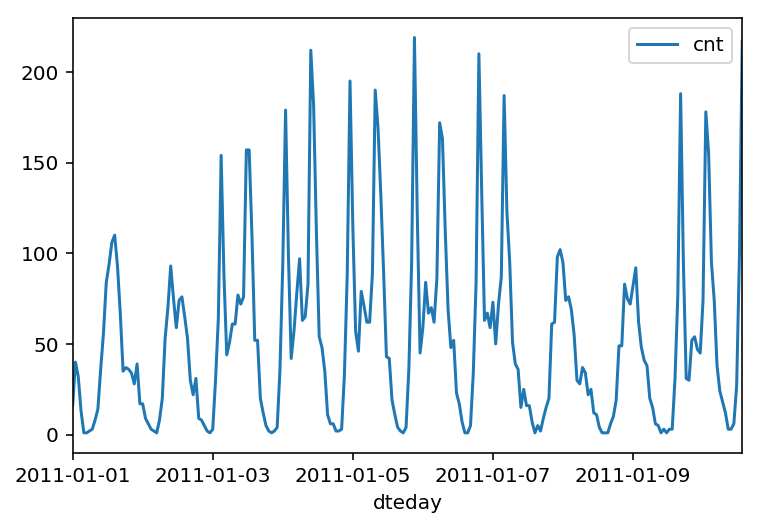

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

In [6]:
data.columns

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [10]:
# Defining the sigmoid function for activations
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))    

In [11]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))   # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        # self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        # Train the network on batch of features and targets.
        #   features: 2D array, each row is one data record, each column is a feature
        #   targets: 1D array of target values
 
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer

            # The output layer has only one node and is used for the regression,
            # the output of the node is the same as the input of the node. That is, 
            # the activation function is  f(x)=x
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs  # Output layer error is the difference between desired target and actual output.
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            # The derivative of the output activation function f(x)=x is 1
            output_error_term = error * 1.0

            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]

            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        # Run a forward pass through the network with input features 
        #   features: 1D array of feature values 
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
      
        # The output layer has only one node and is used for the regression,
        # the output of the node is the same as the input of the node. That is, 
        # the activation function is  f(x)=x
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [13]:
%%time
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        

    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########
    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 6.23 ms



----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [15]:
import sys
import datetime

def trainer(ite, l_r, h_n):
    time_init = datetime.datetime.now()
    
    ### Set the hyperparameters here ###
    iterations = ite
    learning_rate = l_r
    hidden_nodes = h_n
    output_nodes = 1

    losses = {'train':[], 'validation':[]}
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    for ii in range(iterations):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']

        network.train(X, y)

        # Printing out the training progress
        train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                         + "% ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5] \
                         + " (Iterations: " + str(iterations) \
                         + " Learning rate: " + str(learning_rate) \
                         + " Hidden nodes: " + str(hidden_nodes) \
                         + " Time: " + str(datetime.datetime.now() - time_init) + " )")
        sys.stdout.flush()

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        # stop calculating if breaks
        if ii/float(iterations) > 1.0 and learning_rate == np.nan :
            print("xxx stop calculating if breaks, ii/float(iterations) >1.0" + str(ii/float(iterations)) + "learning_rate == np.nan == " + str(learning_rate == np.nan))
            break
    
    print('\n')    
    return {'iterations': iterations, 'learning_rate': learning_rate, 'hidden_nodes': hidden_nodes,
            'train_loss': train_loss, 'validation_loss': val_loss, 'time': datetime.datetime.now() - time_init}, network, losses

## Trying different combination of hyper parameters

In [ ]:
import os.path

test_results = pd.DataFrame(columns=['iterations','learning_rate','hidden_nodes','train_loss','validation_loss', 'time']) 
    
iteration_counter = 10
max_iteration = 5000
iteration_increment = 10

while(iteration_counter <= max_iteration):
    learning_rate_counter = 0.01
    max_learning_rate = 5
    learning_rate_increment = 0.01
    while(learning_rate_counter <= max_learning_rate):
        hidden_node_counter = 1
        max_hidden_nodes = 50
        hidden_node_increment = 1
        while(hidden_node_counter <= max_hidden_nodes):
            res, nn, losses = trainer(iteration_counter, learning_rate_counter, hidden_node_counter)
            test_results = test_results.append(res, ignore_index=True)
            test_results.to_csv('test_results.csv', encoding='utf-8', index=False)
            hidden_node_counter += hidden_node_increment
        learning_rate_counter += learning_rate_increment
    iteration_counter += iteration_increment
     

Progress: 90.0% ... Training loss: 1.114 ... Validation loss: 1.698 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 1 Time: 0:00:00.148993 )

Progress: 10.0% ... Training loss: 1.441 ... Validation loss: 1.437 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 2 Time: 0:00:00.034615 )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Progress: 90.0% ... Training loss: 1.399 ... Validation loss: 1.413 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 2 Time: 0:00:00.154535 )

Progress: 90.0% ... Training loss: 1.630 ... Validation loss: 1.522 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 3 Time: 0:00:00.187847 )

Progress: 90.0% ... Training loss: 0.970 ... Validation loss: 1.424 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 4 Time: 0:00:00.346493 )

Progress: 90.0% ... Training loss: 1.140 ... Validation loss: 1.281 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 5 Time: 0:00:00.242039 )

Progress: 90.0% ... Training loss: 0.961 ... Validation loss: 1.418 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 6 Time: 0:00:00.274719 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.286 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 7 Time: 0:00:00.269355 )

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.268 (Iterations: 10 Learning rate: 0.01 Hidden nodes: 8 Time: 0:00:00.23

Progress: 90.0% ... Training loss: 1.104 ... Validation loss: 1.588 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 8 Time: 0:00:00.221474 )

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.411 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 9 Time: 0:00:00.251365 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.558 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 10 Time: 0:00:00.233613 )

Progress: 90.0% ... Training loss: 1.007 ... Validation loss: 1.526 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 11 Time: 0:00:00.242887 )

Progress: 90.0% ... Training loss: 1.020 ... Validation loss: 1.574 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 12 Time: 0:00:00.224609 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.311 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 13 Time: 0:00:00.265101 )

Progress: 90.0% ... Training loss: 0.932 ... Validation loss: 1.272 (Iterations: 10 Learning rate: 0.02 Hidden nodes: 14 Time: 0:00:

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.324 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 14 Time: 0:00:00.279475 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 15 Time: 0:00:00.254313 )

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 16 Time: 0:00:00.255261 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.429 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 17 Time: 0:00:00.257463 )

Progress: 90.0% ... Training loss: 0.881 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 18 Time: 0:00:00.268880 )

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 19 Time: 0:00:00.292797 )

Progress: 90.0% ... Training loss: 0.914 ... Validation loss: 1.338 (Iterations: 10 Learning rate: 0.03 Hidden nodes: 20 Time: 0:0

Progress: 90.0% ... Training loss: 1.030 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 20 Time: 0:00:00.318781 )

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.352 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 21 Time: 0:00:00.320292 )

Progress: 90.0% ... Training loss: 0.928 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 22 Time: 0:00:00.334951 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.354 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 23 Time: 0:00:00.322389 )

Progress: 90.0% ... Training loss: 0.887 ... Validation loss: 1.296 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 24 Time: 0:00:00.289753 )

Progress: 90.0% ... Training loss: 0.922 ... Validation loss: 1.354 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 25 Time: 0:00:00.305879 )

Progress: 90.0% ... Training loss: 0.903 ... Validation loss: 1.308 (Iterations: 10 Learning rate: 0.04 Hidden nodes: 26 Time: 0:0

Progress: 90.0% ... Training loss: 0.877 ... Validation loss: 1.271 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 26 Time: 0:00:00.311868 )

Progress: 90.0% ... Training loss: 1.017 ... Validation loss: 1.382 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 27 Time: 0:00:00.334694 )

Progress: 90.0% ... Training loss: 0.944 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 28 Time: 0:00:00.344240 )

Progress: 90.0% ... Training loss: 0.951 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 29 Time: 0:00:00.337786 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.452 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 30 Time: 0:00:00.343510 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.353 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 31 Time: 0:00:00.361517 )

Progress: 90.0% ... Training loss: 0.893 ... Validation loss: 1.283 (Iterations: 10 Learning rate: 0.05 Hidden nodes: 32 Time: 0:0

Progress: 90.0% ... Training loss: 0.934 ... Validation loss: 1.324 (Iterations: 10 Learning rate: 0.060000000000000005 Hidden nodes: 29 Time: 0:00:00.324213 )

Progress: 90.0% ... Training loss: 0.909 ... Validation loss: 1.333 (Iterations: 10 Learning rate: 0.060000000000000005 Hidden nodes: 30 Time: 0:00:00.327968 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.338 (Iterations: 10 Learning rate: 0.060000000000000005 Hidden nodes: 31 Time: 0:00:00.331224 )

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.340 (Iterations: 10 Learning rate: 0.060000000000000005 Hidden nodes: 32 Time: 0:00:00.319213 )

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.404 (Iterations: 10 Learning rate: 0.060000000000000005 Hidden nodes: 33 Time: 0:00:00.325155 )

Progress: 90.0% ... Training loss: 1.008 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 0.060000000000000005 Hidden nodes: 34 Time: 0:00:00.328191 )

Progress: 90.0% ... Training loss:

Progress: 90.0% ... Training loss: 1.013 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 33 Time: 0:00:00.336899 )

Progress: 90.0% ... Training loss: 0.854 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 34 Time: 0:00:00.353118 )

Progress: 90.0% ... Training loss: 0.942 ... Validation loss: 1.424 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 35 Time: 0:00:00.367527 )

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.431 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 36 Time: 0:00:00.348152 )

Progress: 90.0% ... Training loss: 0.932 ... Validation loss: 1.316 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 37 Time: 0:00:00.366873 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 38 Time: 0:00:00.366052 )

Progress: 90.0% ... Training loss: 0.916 ... Validation loss: 1.383 (Iterations: 10 Learning rate: 0.07 Hidden nodes: 39 Time: 0:0

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.412 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 39 Time: 0:00:00.761401 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.262 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 40 Time: 0:00:00.439777 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.459 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 41 Time: 0:00:00.450899 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.335 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 42 Time: 0:00:00.444475 )

Progress: 90.0% ... Training loss: 0.893 ... Validation loss: 1.283 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 43 Time: 0:00:00.398298 )

Progress: 90.0% ... Training loss: 0.893 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 44 Time: 0:00:00.387115 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.489 (Iterations: 10 Learning rate: 0.08 Hidden nodes: 45 Time: 0:0

Progress: 90.0% ... Training loss: 0.931 ... Validation loss: 1.286 (Iterations: 10 Learning rate: 0.09 Hidden nodes: 45 Time: 0:00:00.502727 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.480 (Iterations: 10 Learning rate: 0.09 Hidden nodes: 46 Time: 0:00:00.548136 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.297 (Iterations: 10 Learning rate: 0.09 Hidden nodes: 47 Time: 0:00:01.927721 )

Progress: 90.0% ... Training loss: 0.902 ... Validation loss: 1.349 (Iterations: 10 Learning rate: 0.09 Hidden nodes: 48 Time: 0:00:00.526671 )

Progress: 90.0% ... Training loss: 0.958 ... Validation loss: 1.247 (Iterations: 10 Learning rate: 0.09 Hidden nodes: 49 Time: 0:00:00.492947 )

Progress: 90.0% ... Training loss: 0.849 ... Validation loss: 1.288 (Iterations: 10 Learning rate: 0.09 Hidden nodes: 50 Time: 0:00:00.479521 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.298 (Iterations: 10 Learning rate: 0.09999999999999999 Hidden node

Progress: 90.0% ... Training loss: 0.909 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 0.09999999999999999 Hidden nodes: 46 Time: 0:00:00.406474 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.315 (Iterations: 10 Learning rate: 0.09999999999999999 Hidden nodes: 47 Time: 0:00:00.405123 )

Progress: 90.0% ... Training loss: 0.900 ... Validation loss: 1.421 (Iterations: 10 Learning rate: 0.09999999999999999 Hidden nodes: 48 Time: 0:00:00.419106 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.480 (Iterations: 10 Learning rate: 0.09999999999999999 Hidden nodes: 49 Time: 0:00:00.403229 )

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 0.09999999999999999 Hidden nodes: 50 Time: 0:00:00.441373 )

Progress: 90.0% ... Training loss: 1.006 ... Validation loss: 1.571 (Iterations: 10 Learning rate: 0.10999999999999999 Hidden nodes: 1 Time: 0:00:00.138333 )

Progress: 90.0% ... Training loss: 1.124 

Progress: 90.0% ... Training loss: 0.948 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.10999999999999999 Hidden nodes: 47 Time: 0:00:00.408336 )

Progress: 90.0% ... Training loss: 0.943 ... Validation loss: 1.233 (Iterations: 10 Learning rate: 0.10999999999999999 Hidden nodes: 48 Time: 0:00:00.414467 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 0.10999999999999999 Hidden nodes: 49 Time: 0:00:00.409772 )

Progress: 90.0% ... Training loss: 1.006 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 0.10999999999999999 Hidden nodes: 50 Time: 0:00:00.416307 )

Progress: 90.0% ... Training loss: 1.170 ... Validation loss: 1.319 (Iterations: 10 Learning rate: 0.11999999999999998 Hidden nodes: 1 Time: 0:00:00.139111 )

Progress: 90.0% ... Training loss: 0.952 ... Validation loss: 1.319 (Iterations: 10 Learning rate: 0.11999999999999998 Hidden nodes: 2 Time: 0:00:00.165689 )

Progress: 90.0% ... Training loss: 0.962 .

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.245 (Iterations: 10 Learning rate: 0.11999999999999998 Hidden nodes: 48 Time: 0:00:00.407906 )

Progress: 90.0% ... Training loss: 0.887 ... Validation loss: 1.342 (Iterations: 10 Learning rate: 0.11999999999999998 Hidden nodes: 49 Time: 0:00:00.423120 )

Progress: 90.0% ... Training loss: 0.889 ... Validation loss: 1.240 (Iterations: 10 Learning rate: 0.11999999999999998 Hidden nodes: 50 Time: 0:00:00.435126 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.507 (Iterations: 10 Learning rate: 0.12999999999999998 Hidden nodes: 1 Time: 0:00:00.121494 )

Progress: 90.0% ... Training loss: 0.884 ... Validation loss: 1.239 (Iterations: 10 Learning rate: 0.12999999999999998 Hidden nodes: 2 Time: 0:00:00.160621 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 0.12999999999999998 Hidden nodes: 3 Time: 0:00:00.174968 )

Progress: 90.0% ... Training loss: 0.957 ..

Progress: 90.0% ... Training loss: 0.884 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 0.12999999999999998 Hidden nodes: 49 Time: 0:00:00.393533 )

Progress: 90.0% ... Training loss: 0.941 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 0.12999999999999998 Hidden nodes: 50 Time: 0:00:00.425526 )

Progress: 90.0% ... Training loss: 1.220 ... Validation loss: 1.319 (Iterations: 10 Learning rate: 0.13999999999999999 Hidden nodes: 1 Time: 0:00:00.135423 )

Progress: 90.0% ... Training loss: 1.201 ... Validation loss: 1.330 (Iterations: 10 Learning rate: 0.13999999999999999 Hidden nodes: 2 Time: 0:00:00.161350 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.432 (Iterations: 10 Learning rate: 0.13999999999999999 Hidden nodes: 3 Time: 0:00:00.162646 )

Progress: 90.0% ... Training loss: 0.960 ... Validation loss: 1.383 (Iterations: 10 Learning rate: 0.13999999999999999 Hidden nodes: 4 Time: 0:00:00.177602 )

Progress: 90.0% ... Training loss: 0.950 ...

Progress: 90.0% ... Training loss: 0.866 ... Validation loss: 1.302 (Iterations: 10 Learning rate: 0.13999999999999999 Hidden nodes: 50 Time: 0:00:00.435470 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 0.15 Hidden nodes: 1 Time: 0:00:00.126866 )

Progress: 90.0% ... Training loss: 0.856 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 0.15 Hidden nodes: 2 Time: 0:00:00.143070 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.283 (Iterations: 10 Learning rate: 0.15 Hidden nodes: 3 Time: 0:00:00.161767 )

Progress: 90.0% ... Training loss: 0.885 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 0.15 Hidden nodes: 4 Time: 0:00:00.183028 )

Progress: 90.0% ... Training loss: 0.836 ... Validation loss: 1.353 (Iterations: 10 Learning rate: 0.15 Hidden nodes: 5 Time: 0:00:00.186986 )

Progress: 90.0% ... Training loss: 0.901 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 0.15 Hidden nodes: 6 

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 6 Time: 0:00:00.177673 )

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 7 Time: 0:00:00.186705 )

Progress: 90.0% ... Training loss: 0.877 ... Validation loss: 1.318 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 8 Time: 0:00:00.196269 )

Progress: 90.0% ... Training loss: 0.864 ... Validation loss: 1.318 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 9 Time: 0:00:00.188174 )

Progress: 90.0% ... Training loss: 0.937 ... Validation loss: 1.329 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 10 Time: 0:00:00.220095 )

Progress: 90.0% ... Training loss: 0.946 ... Validation loss: 1.407 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 11 Time: 0:00:00.200272 )

Progress: 90.0% ... Training loss: 0.932 ... Validation loss: 1.295 (Iterations: 10 Learning rate: 0.16 Hidden nodes: 12 Time: 0:00:00

Progress: 90.0% ... Training loss: 0.875 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 12 Time: 0:00:00.220318 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.326 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 13 Time: 0:00:00.208356 )

Progress: 90.0% ... Training loss: 0.861 ... Validation loss: 1.339 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 14 Time: 0:00:00.213262 )

Progress: 90.0% ... Training loss: 0.942 ... Validation loss: 1.357 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 15 Time: 0:00:00.219882 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.447 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 16 Time: 0:00:00.224112 )

Progress: 90.0% ... Training loss: 0.879 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 17 Time: 0:00:00.246999 )

Progress: 90.0% ... Training loss: 0.901 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 0.17 Hidden nodes: 18 Time: 0:0

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 0.18000000000000002 Hidden nodes: 16 Time: 0:00:00.241955 )

Progress: 90.0% ... Training loss: 0.888 ... Validation loss: 1.350 (Iterations: 10 Learning rate: 0.18000000000000002 Hidden nodes: 17 Time: 0:00:00.217398 )

Progress: 90.0% ... Training loss: 0.900 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 0.18000000000000002 Hidden nodes: 18 Time: 0:00:00.242059 )

Progress: 90.0% ... Training loss: 0.842 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 0.18000000000000002 Hidden nodes: 19 Time: 0:00:00.249440 )

Progress: 90.0% ... Training loss: 0.938 ... Validation loss: 1.245 (Iterations: 10 Learning rate: 0.18000000000000002 Hidden nodes: 20 Time: 0:00:00.282490 )

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.398 (Iterations: 10 Learning rate: 0.18000000000000002 Hidden nodes: 21 Time: 0:00:00.285572 )

Progress: 90.0% ... Training loss: 0.874

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.275 (Iterations: 10 Learning rate: 0.19000000000000003 Hidden nodes: 17 Time: 0:00:00.242992 )

Progress: 90.0% ... Training loss: 0.969 ... Validation loss: 1.482 (Iterations: 10 Learning rate: 0.19000000000000003 Hidden nodes: 18 Time: 0:00:00.307292 )

Progress: 90.0% ... Training loss: 0.926 ... Validation loss: 1.326 (Iterations: 10 Learning rate: 0.19000000000000003 Hidden nodes: 19 Time: 0:00:00.260966 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.268 (Iterations: 10 Learning rate: 0.19000000000000003 Hidden nodes: 20 Time: 0:00:00.265012 )

Progress: 90.0% ... Training loss: 0.918 ... Validation loss: 1.261 (Iterations: 10 Learning rate: 0.19000000000000003 Hidden nodes: 21 Time: 0:00:00.243576 )

Progress: 90.0% ... Training loss: 0.879 ... Validation loss: 1.265 (Iterations: 10 Learning rate: 0.19000000000000003 Hidden nodes: 22 Time: 0:00:00.269087 )

Progress: 90.0% ... Training loss: 1.013

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 0.20000000000000004 Hidden nodes: 18 Time: 0:00:00.241472 )

Progress: 90.0% ... Training loss: 0.881 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 0.20000000000000004 Hidden nodes: 19 Time: 0:00:00.238603 )

Progress: 90.0% ... Training loss: 0.856 ... Validation loss: 1.438 (Iterations: 10 Learning rate: 0.20000000000000004 Hidden nodes: 20 Time: 0:00:00.251454 )

Progress: 90.0% ... Training loss: 0.856 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 0.20000000000000004 Hidden nodes: 21 Time: 0:00:00.234968 )

Progress: 90.0% ... Training loss: 0.920 ... Validation loss: 1.276 (Iterations: 10 Learning rate: 0.20000000000000004 Hidden nodes: 22 Time: 0:00:00.236878 )

Progress: 90.0% ... Training loss: 0.871 ... Validation loss: 1.196 (Iterations: 10 Learning rate: 0.20000000000000004 Hidden nodes: 23 Time: 0:00:00.262083 )

Progress: 90.0% ... Training loss: 0.864

Progress: 90.0% ... Training loss: 0.909 ... Validation loss: 1.293 (Iterations: 10 Learning rate: 0.21000000000000005 Hidden nodes: 19 Time: 0:00:00.234428 )

Progress: 90.0% ... Training loss: 0.928 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 0.21000000000000005 Hidden nodes: 20 Time: 0:00:00.261936 )

Progress: 90.0% ... Training loss: 0.872 ... Validation loss: 1.399 (Iterations: 10 Learning rate: 0.21000000000000005 Hidden nodes: 21 Time: 0:00:00.261215 )

Progress: 90.0% ... Training loss: 0.890 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 0.21000000000000005 Hidden nodes: 22 Time: 0:00:00.265242 )

Progress: 90.0% ... Training loss: 0.909 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 0.21000000000000005 Hidden nodes: 23 Time: 0:00:00.261062 )

Progress: 90.0% ... Training loss: 0.893 ... Validation loss: 1.432 (Iterations: 10 Learning rate: 0.21000000000000005 Hidden nodes: 24 Time: 0:00:00.266044 )

Progress: 90.0% ... Training loss: 0.913

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.267 (Iterations: 10 Learning rate: 0.22000000000000006 Hidden nodes: 20 Time: 0:00:00.258661 )

Progress: 90.0% ... Training loss: 0.863 ... Validation loss: 1.324 (Iterations: 10 Learning rate: 0.22000000000000006 Hidden nodes: 21 Time: 0:00:00.280475 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.352 (Iterations: 10 Learning rate: 0.22000000000000006 Hidden nodes: 22 Time: 0:00:00.279069 )

Progress: 90.0% ... Training loss: 0.886 ... Validation loss: 1.229 (Iterations: 10 Learning rate: 0.22000000000000006 Hidden nodes: 23 Time: 0:00:00.287041 )

Progress: 90.0% ... Training loss: 0.832 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 0.22000000000000006 Hidden nodes: 24 Time: 0:00:00.293030 )

Progress: 90.0% ... Training loss: 0.854 ... Validation loss: 1.253 (Iterations: 10 Learning rate: 0.22000000000000006 Hidden nodes: 25 Time: 0:00:00.276390 )

Progress: 90.0% ... Training loss: 0.864

Progress: 90.0% ... Training loss: 0.883 ... Validation loss: 1.303 (Iterations: 10 Learning rate: 0.23000000000000007 Hidden nodes: 21 Time: 0:00:00.239547 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.636 (Iterations: 10 Learning rate: 0.23000000000000007 Hidden nodes: 22 Time: 0:00:00.257571 )

Progress: 90.0% ... Training loss: 0.912 ... Validation loss: 1.394 (Iterations: 10 Learning rate: 0.23000000000000007 Hidden nodes: 23 Time: 0:00:00.254488 )

Progress: 90.0% ... Training loss: 0.902 ... Validation loss: 1.158 (Iterations: 10 Learning rate: 0.23000000000000007 Hidden nodes: 24 Time: 0:00:00.275554 )

Progress: 90.0% ... Training loss: 0.883 ... Validation loss: 1.459 (Iterations: 10 Learning rate: 0.23000000000000007 Hidden nodes: 25 Time: 0:00:00.271431 )

Progress: 90.0% ... Training loss: 0.894 ... Validation loss: 1.422 (Iterations: 10 Learning rate: 0.23000000000000007 Hidden nodes: 26 Time: 0:00:00.297402 )

Progress: 90.0% ... Training loss: 0.857

Progress: 90.0% ... Training loss: 0.879 ... Validation loss: 1.436 (Iterations: 10 Learning rate: 0.24000000000000007 Hidden nodes: 22 Time: 0:00:00.241153 )

Progress: 90.0% ... Training loss: 0.820 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 0.24000000000000007 Hidden nodes: 23 Time: 0:00:00.260265 )

Progress: 90.0% ... Training loss: 0.846 ... Validation loss: 1.290 (Iterations: 10 Learning rate: 0.24000000000000007 Hidden nodes: 24 Time: 0:00:00.296933 )

Progress: 90.0% ... Training loss: 1.054 ... Validation loss: 1.202 (Iterations: 10 Learning rate: 0.24000000000000007 Hidden nodes: 25 Time: 0:00:00.308764 )

Progress: 90.0% ... Training loss: 0.862 ... Validation loss: 1.417 (Iterations: 10 Learning rate: 0.24000000000000007 Hidden nodes: 26 Time: 0:00:00.290442 )

Progress: 90.0% ... Training loss: 0.855 ... Validation loss: 1.217 (Iterations: 10 Learning rate: 0.24000000000000007 Hidden nodes: 27 Time: 0:00:00.287747 )

Progress: 90.0% ... Training loss: 0.872

Progress: 90.0% ... Training loss: 0.887 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 0.25000000000000006 Hidden nodes: 23 Time: 0:00:00.282684 )

Progress: 90.0% ... Training loss: 0.819 ... Validation loss: 1.214 (Iterations: 10 Learning rate: 0.25000000000000006 Hidden nodes: 24 Time: 0:00:00.276514 )

Progress: 90.0% ... Training loss: 1.059 ... Validation loss: 1.755 (Iterations: 10 Learning rate: 0.25000000000000006 Hidden nodes: 25 Time: 0:00:00.260707 )

Progress: 90.0% ... Training loss: 1.001 ... Validation loss: 1.241 (Iterations: 10 Learning rate: 0.25000000000000006 Hidden nodes: 26 Time: 0:00:00.289613 )

Progress: 90.0% ... Training loss: 0.844 ... Validation loss: 1.267 (Iterations: 10 Learning rate: 0.25000000000000006 Hidden nodes: 27 Time: 0:00:00.286522 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.282 (Iterations: 10 Learning rate: 0.25000000000000006 Hidden nodes: 28 Time: 0:00:00.292557 )

Progress: 90.0% ... Training loss: 1.053

Progress: 90.0% ... Training loss: 0.883 ... Validation loss: 1.352 (Iterations: 10 Learning rate: 0.26000000000000006 Hidden nodes: 24 Time: 0:00:00.272286 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.242 (Iterations: 10 Learning rate: 0.26000000000000006 Hidden nodes: 25 Time: 0:00:00.294361 )

Progress: 90.0% ... Training loss: 1.161 ... Validation loss: 1.979 (Iterations: 10 Learning rate: 0.26000000000000006 Hidden nodes: 26 Time: 0:00:00.287957 )

Progress: 90.0% ... Training loss: 0.878 ... Validation loss: 1.287 (Iterations: 10 Learning rate: 0.26000000000000006 Hidden nodes: 27 Time: 0:00:00.315683 )

Progress: 90.0% ... Training loss: 0.856 ... Validation loss: 1.232 (Iterations: 10 Learning rate: 0.26000000000000006 Hidden nodes: 28 Time: 0:00:00.306523 )

Progress: 90.0% ... Training loss: 1.274 ... Validation loss: 1.264 (Iterations: 10 Learning rate: 0.26000000000000006 Hidden nodes: 29 Time: 0:00:00.320927 )

Progress: 90.0% ... Training loss: 0.914

Progress: 90.0% ... Training loss: 0.826 ... Validation loss: 1.330 (Iterations: 10 Learning rate: 0.2700000000000001 Hidden nodes: 25 Time: 0:00:00.277524 )

Progress: 90.0% ... Training loss: 0.897 ... Validation loss: 1.272 (Iterations: 10 Learning rate: 0.2700000000000001 Hidden nodes: 26 Time: 0:00:00.294365 )

Progress: 90.0% ... Training loss: 0.922 ... Validation loss: 1.563 (Iterations: 10 Learning rate: 0.2700000000000001 Hidden nodes: 27 Time: 0:00:00.284575 )

Progress: 90.0% ... Training loss: 1.053 ... Validation loss: 1.195 (Iterations: 10 Learning rate: 0.2700000000000001 Hidden nodes: 28 Time: 0:00:00.288523 )

Progress: 90.0% ... Training loss: 1.157 ... Validation loss: 1.247 (Iterations: 10 Learning rate: 0.2700000000000001 Hidden nodes: 29 Time: 0:00:00.325158 )

Progress: 90.0% ... Training loss: 0.953 ... Validation loss: 1.567 (Iterations: 10 Learning rate: 0.2700000000000001 Hidden nodes: 30 Time: 0:00:00.319915 )

Progress: 90.0% ... Training loss: 0.900 ... V

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.290 (Iterations: 10 Learning rate: 0.2800000000000001 Hidden nodes: 26 Time: 0:00:00.300096 )

Progress: 90.0% ... Training loss: 0.953 ... Validation loss: 1.147 (Iterations: 10 Learning rate: 0.2800000000000001 Hidden nodes: 27 Time: 0:00:00.296275 )

Progress: 90.0% ... Training loss: 1.894 ... Validation loss: 1.758 (Iterations: 10 Learning rate: 0.2800000000000001 Hidden nodes: 28 Time: 0:00:00.296117 )

Progress: 90.0% ... Training loss: 2.435 ... Validation loss: 3.763 (Iterations: 10 Learning rate: 0.2800000000000001 Hidden nodes: 29 Time: 0:00:00.316013 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.657 (Iterations: 10 Learning rate: 0.2800000000000001 Hidden nodes: 30 Time: 0:00:00.283321 )

Progress: 90.0% ... Training loss: 7.338 ... Validation loss: 5.897 (Iterations: 10 Learning rate: 0.2800000000000001 Hidden nodes: 31 Time: 0:00:00.325686 )

Progress: 90.0% ... Training loss: 3.366 ... V

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.197 (Iterations: 10 Learning rate: 0.2900000000000001 Hidden nodes: 27 Time: 0:00:00.323354 )

Progress: 90.0% ... Training loss: 1.215 ... Validation loss: 2.062 (Iterations: 10 Learning rate: 0.2900000000000001 Hidden nodes: 28 Time: 0:00:00.306164 )

Progress: 90.0% ... Training loss: 1.015 ... Validation loss: 1.202 (Iterations: 10 Learning rate: 0.2900000000000001 Hidden nodes: 29 Time: 0:00:00.297695 )

Progress: 90.0% ... Training loss: 3.890 ... Validation loss: 3.164 (Iterations: 10 Learning rate: 0.2900000000000001 Hidden nodes: 30 Time: 0:00:00.316606 )

Progress: 90.0% ... Training loss: 12.87 ... Validation loss: 15.45 (Iterations: 10 Learning rate: 0.2900000000000001 Hidden nodes: 31 Time: 0:00:00.325341 )

Progress: 90.0% ... Training loss: 13.09 ... Validation loss: 11.43 (Iterations: 10 Learning rate: 0.2900000000000001 Hidden nodes: 32 Time: 0:00:00.345971 )

Progress: 90.0% ... Training loss: 24.37 ... V

Progress: 90.0% ... Training loss: 1.155 ... Validation loss: 1.942 (Iterations: 10 Learning rate: 0.3000000000000001 Hidden nodes: 28 Time: 0:00:00.296713 )

Progress: 90.0% ... Training loss: 4.096 ... Validation loss: 3.561 (Iterations: 10 Learning rate: 0.3000000000000001 Hidden nodes: 29 Time: 0:00:00.311057 )

Progress: 90.0% ... Training loss: 1.404 ... Validation loss: 1.297 (Iterations: 10 Learning rate: 0.3000000000000001 Hidden nodes: 30 Time: 0:00:00.320038 )

Progress: 90.0% ... Training loss: 15.67 ... Validation loss: 19.22 (Iterations: 10 Learning rate: 0.3000000000000001 Hidden nodes: 31 Time: 0:00:00.332253 )

Progress: 90.0% ... Training loss: 1.410 ... Validation loss: 1.340 (Iterations: 10 Learning rate: 0.3000000000000001 Hidden nodes: 32 Time: 0:00:00.325465 )

Progress: 90.0% ... Training loss: 1.337 ... Validation loss: 2.271 (Iterations: 10 Learning rate: 0.3000000000000001 Hidden nodes: 33 Time: 0:00:00.319742 )

Progress: 90.0% ... Training loss: 28.11 ... V

Progress: 90.0% ... Training loss: 3.210 ... Validation loss: 4.654 (Iterations: 10 Learning rate: 0.3100000000000001 Hidden nodes: 29 Time: 0:00:00.659864 )

Progress: 90.0% ... Training loss: 7.525 ... Validation loss: 9.860 (Iterations: 10 Learning rate: 0.3100000000000001 Hidden nodes: 30 Time: 0:00:00.376269 )

Progress: 90.0% ... Training loss: 3.531 ... Validation loss: 3.068 (Iterations: 10 Learning rate: 0.3100000000000001 Hidden nodes: 31 Time: 0:00:00.384160 )

Progress: 90.0% ... Training loss: 23.59 ... Validation loss: 28.04 (Iterations: 10 Learning rate: 0.3100000000000001 Hidden nodes: 32 Time: 0:00:00.480336 )

Progress: 90.0% ... Training loss: 1.116 ... Validation loss: 1.284 (Iterations: 10 Learning rate: 0.3100000000000001 Hidden nodes: 33 Time: 0:00:00.323090 )

Progress: 90.0% ... Training loss: 0.942 ... Validation loss: 1.446 (Iterations: 10 Learning rate: 0.3100000000000001 Hidden nodes: 34 Time: 0:00:00.358093 )

Progress: 90.0% ... Training loss: 0.891 ... V

Progress: 90.0% ... Training loss: 15.08 ... Validation loss: 12.39 (Iterations: 10 Learning rate: 0.3200000000000001 Hidden nodes: 30 Time: 0:00:00.577950 )

Progress: 90.0% ... Training loss: 7.462 ... Validation loss: 9.346 (Iterations: 10 Learning rate: 0.3200000000000001 Hidden nodes: 31 Time: 0:00:00.451033 )

Progress: 90.0% ... Training loss: 0.918 ... Validation loss: 1.449 (Iterations: 10 Learning rate: 0.3200000000000001 Hidden nodes: 32 Time: 0:00:00.503050 )

Progress: 90.0% ... Training loss: 0.935 ... Validation loss: 1.426 (Iterations: 10 Learning rate: 0.3200000000000001 Hidden nodes: 33 Time: 0:00:00.405444 )

Progress: 90.0% ... Training loss: 0.890 ... Validation loss: 1.297 (Iterations: 10 Learning rate: 0.3200000000000001 Hidden nodes: 34 Time: 0:00:00.357434 )

Progress: 90.0% ... Training loss: 0.880 ... Validation loss: 1.394 (Iterations: 10 Learning rate: 0.3200000000000001 Hidden nodes: 35 Time: 0:00:00.400899 )

Progress: 90.0% ... Training loss: 1.146 ... V

Progress: 90.0% ... Training loss: 0.944 ... Validation loss: 1.407 (Iterations: 10 Learning rate: 0.3300000000000001 Hidden nodes: 31 Time: 0:00:00.750008 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 0.3300000000000001 Hidden nodes: 32 Time: 0:00:00.424812 )

Progress: 90.0% ... Training loss: 5.085 ... Validation loss: 4.250 (Iterations: 10 Learning rate: 0.3300000000000001 Hidden nodes: 33 Time: 0:00:00.568545 )

Progress: 90.0% ... Training loss: 0.920 ... Validation loss: 1.424 (Iterations: 10 Learning rate: 0.3300000000000001 Hidden nodes: 34 Time: 0:00:00.423002 )

Progress: 90.0% ... Training loss: 0.923 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 0.3300000000000001 Hidden nodes: 35 Time: 0:00:00.408843 )

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 0.3300000000000001 Hidden nodes: 36 Time: 0:00:00.398245 )

Progress: 90.0% ... Training loss: 1.219 ... V

Progress: 90.0% ... Training loss: 1.559 ... Validation loss: 2.471 (Iterations: 10 Learning rate: 0.34000000000000014 Hidden nodes: 32 Time: 0:00:00.394197 )

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.316 (Iterations: 10 Learning rate: 0.34000000000000014 Hidden nodes: 33 Time: 0:00:00.364299 )

Progress: 90.0% ... Training loss: 53.53 ... Validation loss: 47.47 (Iterations: 10 Learning rate: 0.34000000000000014 Hidden nodes: 34 Time: 0:00:00.387348 )

Progress: 90.0% ... Training loss: 1.910 ... Validation loss: 1.570 (Iterations: 10 Learning rate: 0.34000000000000014 Hidden nodes: 35 Time: 0:00:00.357604 )

Progress: 90.0% ... Training loss: 1.233 ... Validation loss: 1.339 (Iterations: 10 Learning rate: 0.34000000000000014 Hidden nodes: 36 Time: 0:00:00.352182 )

Progress: 90.0% ... Training loss: 0.991 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 0.34000000000000014 Hidden nodes: 37 Time: 0:00:00.676323 )

Progress: 90.0% ... Training loss: 0.950

Progress: 90.0% ... Training loss: 0.914 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 0.35000000000000014 Hidden nodes: 33 Time: 0:00:00.340315 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.544 (Iterations: 10 Learning rate: 0.35000000000000014 Hidden nodes: 34 Time: 0:00:00.327757 )

Progress: 90.0% ... Training loss: 1.024 ... Validation loss: 1.283 (Iterations: 10 Learning rate: 0.35000000000000014 Hidden nodes: 35 Time: 0:00:00.334082 )

Progress: 90.0% ... Training loss: 0.937 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 0.35000000000000014 Hidden nodes: 36 Time: 0:00:00.348299 )

Progress: 90.0% ... Training loss: 1.545 ... Validation loss: 1.393 (Iterations: 10 Learning rate: 0.35000000000000014 Hidden nodes: 37 Time: 0:00:00.388732 )

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.329 (Iterations: 10 Learning rate: 0.35000000000000014 Hidden nodes: 38 Time: 0:00:00.393181 )

Progress: 90.0% ... Training loss: 1.884

Progress: 90.0% ... Training loss: 1.126 ... Validation loss: 1.844 (Iterations: 10 Learning rate: 0.36000000000000015 Hidden nodes: 34 Time: 0:00:00.343722 )

Progress: 90.0% ... Training loss: 2.201 ... Validation loss: 3.020 (Iterations: 10 Learning rate: 0.36000000000000015 Hidden nodes: 35 Time: 0:00:00.349447 )

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.382 (Iterations: 10 Learning rate: 0.36000000000000015 Hidden nodes: 36 Time: 0:00:00.345574 )

Progress: 90.0% ... Training loss: 54.38 ... Validation loss: 50.84 (Iterations: 10 Learning rate: 0.36000000000000015 Hidden nodes: 37 Time: 0:00:00.359672 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.550 (Iterations: 10 Learning rate: 0.36000000000000015 Hidden nodes: 38 Time: 0:00:00.416580 )

Progress: 90.0% ... Training loss: 2.743 ... Validation loss: 2.957 (Iterations: 10 Learning rate: 0.36000000000000015 Hidden nodes: 39 Time: 0:00:00.377133 )

Progress: 90.0% ... Training loss: 1.037

Progress: 90.0% ... Training loss: 1.249 ... Validation loss: 1.340 (Iterations: 10 Learning rate: 0.37000000000000016 Hidden nodes: 35 Time: 0:00:00.361863 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.331 (Iterations: 10 Learning rate: 0.37000000000000016 Hidden nodes: 36 Time: 0:00:00.397306 )

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 0.37000000000000016 Hidden nodes: 37 Time: 0:00:00.406672 )

Progress: 90.0% ... Training loss: 1.922 ... Validation loss: 2.184 (Iterations: 10 Learning rate: 0.37000000000000016 Hidden nodes: 38 Time: 0:00:00.428646 )

Progress: 90.0% ... Training loss: 1.699 ... Validation loss: 1.380 (Iterations: 10 Learning rate: 0.37000000000000016 Hidden nodes: 39 Time: 0:00:00.422354 )

Progress: 90.0% ... Training loss: 3.407 ... Validation loss: 3.196 (Iterations: 10 Learning rate: 0.37000000000000016 Hidden nodes: 40 Time: 0:00:00.422852 )

Progress: 90.0% ... Training loss: 3.144

Progress: 90.0% ... Training loss: 2.753 ... Validation loss: 1.743 (Iterations: 10 Learning rate: 0.38000000000000017 Hidden nodes: 36 Time: 0:00:00.356898 )

Progress: 90.0% ... Training loss: 3.189 ... Validation loss: 1.874 (Iterations: 10 Learning rate: 0.38000000000000017 Hidden nodes: 37 Time: 0:00:00.354306 )

Progress: 90.0% ... Training loss: 3.012 ... Validation loss: 2.648 (Iterations: 10 Learning rate: 0.38000000000000017 Hidden nodes: 38 Time: 0:00:00.431360 )

Progress: 90.0% ... Training loss: 3.252 ... Validation loss: 1.661 (Iterations: 10 Learning rate: 0.38000000000000017 Hidden nodes: 39 Time: 0:00:00.381508 )

Progress: 90.0% ... Training loss: 3.769 ... Validation loss: 2.966 (Iterations: 10 Learning rate: 0.38000000000000017 Hidden nodes: 40 Time: 0:00:00.412681 )

Progress: 90.0% ... Training loss: 2.905 ... Validation loss: 1.316 (Iterations: 10 Learning rate: 0.38000000000000017 Hidden nodes: 41 Time: 0:00:00.413119 )

Progress: 90.0% ... Training loss: 5.417

Progress: 90.0% ... Training loss: 2.977 ... Validation loss: 2.435 (Iterations: 10 Learning rate: 0.3900000000000002 Hidden nodes: 37 Time: 0:00:00.422738 )

Progress: 90.0% ... Training loss: 4.450 ... Validation loss: 3.093 (Iterations: 10 Learning rate: 0.3900000000000002 Hidden nodes: 38 Time: 0:00:00.382011 )

Progress: 90.0% ... Training loss: 1.155 ... Validation loss: 1.274 (Iterations: 10 Learning rate: 0.3900000000000002 Hidden nodes: 39 Time: 0:00:00.372656 )

Progress: 90.0% ... Training loss: 2.374 ... Validation loss: 2.314 (Iterations: 10 Learning rate: 0.3900000000000002 Hidden nodes: 40 Time: 0:00:00.382625 )

Progress: 90.0% ... Training loss: 1.216 ... Validation loss: 1.520 (Iterations: 10 Learning rate: 0.3900000000000002 Hidden nodes: 41 Time: 0:00:00.385227 )

Progress: 90.0% ... Training loss: 4.574 ... Validation loss: 2.742 (Iterations: 10 Learning rate: 0.3900000000000002 Hidden nodes: 42 Time: 0:00:00.386447 )

Progress: 90.0% ... Training loss: 7.089 ... V

Progress: 90.0% ... Training loss: 4.443 ... Validation loss: 1.986 (Iterations: 10 Learning rate: 0.4000000000000002 Hidden nodes: 38 Time: 0:00:00.387086 )

Progress: 90.0% ... Training loss: 3.485 ... Validation loss: 1.726 (Iterations: 10 Learning rate: 0.4000000000000002 Hidden nodes: 39 Time: 0:00:00.384319 )

Progress: 90.0% ... Training loss: 3.602 ... Validation loss: 1.635 (Iterations: 10 Learning rate: 0.4000000000000002 Hidden nodes: 40 Time: 0:00:00.407817 )

Progress: 90.0% ... Training loss: 3.540 ... Validation loss: 2.654 (Iterations: 10 Learning rate: 0.4000000000000002 Hidden nodes: 41 Time: 0:00:00.396293 )

Progress: 90.0% ... Training loss: 2.977 ... Validation loss: 1.444 (Iterations: 10 Learning rate: 0.4000000000000002 Hidden nodes: 42 Time: 0:00:00.403413 )

Progress: 90.0% ... Training loss: 1.209 ... Validation loss: 1.523 (Iterations: 10 Learning rate: 0.4000000000000002 Hidden nodes: 43 Time: 0:00:00.395151 )

Progress: 90.0% ... Training loss: 4.797 ... V

Progress: 90.0% ... Training loss: 1.649 ... Validation loss: 1.301 (Iterations: 10 Learning rate: 0.4100000000000002 Hidden nodes: 39 Time: 0:00:00.380221 )

Progress: 90.0% ... Training loss: 4.228 ... Validation loss: 2.838 (Iterations: 10 Learning rate: 0.4100000000000002 Hidden nodes: 40 Time: 0:00:00.399412 )

Progress: 90.0% ... Training loss: 2.153 ... Validation loss: 1.679 (Iterations: 10 Learning rate: 0.4100000000000002 Hidden nodes: 41 Time: 0:00:00.392159 )

Progress: 90.0% ... Training loss: 5.111 ... Validation loss: 2.823 (Iterations: 10 Learning rate: 0.4100000000000002 Hidden nodes: 42 Time: 0:00:00.401527 )

Progress: 90.0% ... Training loss: 1.370 ... Validation loss: 1.260 (Iterations: 10 Learning rate: 0.4100000000000002 Hidden nodes: 43 Time: 0:00:00.396975 )

Progress: 90.0% ... Training loss: 6.472 ... Validation loss: 2.932 (Iterations: 10 Learning rate: 0.4100000000000002 Hidden nodes: 44 Time: 0:00:00.405403 )

Progress: 90.0% ... Training loss: 5.851 ... V

Progress: 90.0% ... Training loss: 2.819 ... Validation loss: 1.918 (Iterations: 10 Learning rate: 0.4200000000000002 Hidden nodes: 40 Time: 0:00:00.430636 )

Progress: 90.0% ... Training loss: 3.362 ... Validation loss: 1.963 (Iterations: 10 Learning rate: 0.4200000000000002 Hidden nodes: 41 Time: 0:00:00.372606 )

Progress: 90.0% ... Training loss: 8.091 ... Validation loss: 3.478 (Iterations: 10 Learning rate: 0.4200000000000002 Hidden nodes: 42 Time: 0:00:00.413525 )

Progress: 90.0% ... Training loss: 6.715 ... Validation loss: 1.888 (Iterations: 10 Learning rate: 0.4200000000000002 Hidden nodes: 43 Time: 0:00:00.385206 )

Progress: 90.0% ... Training loss: 1.034 ... Validation loss: 1.485 (Iterations: 10 Learning rate: 0.4200000000000002 Hidden nodes: 44 Time: 0:00:00.394284 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.438 (Iterations: 10 Learning rate: 0.4200000000000002 Hidden nodes: 45 Time: 0:00:00.403411 )

Progress: 90.0% ... Training loss: 6.184 ... V

Progress: 90.0% ... Training loss: 4.769 ... Validation loss: 2.155 (Iterations: 10 Learning rate: 0.4300000000000002 Hidden nodes: 41 Time: 0:00:00.400590 )

Progress: 90.0% ... Training loss: 5.451 ... Validation loss: 1.666 (Iterations: 10 Learning rate: 0.4300000000000002 Hidden nodes: 42 Time: 0:00:00.367681 )

Progress: 90.0% ... Training loss: 2.886 ... Validation loss: 1.272 (Iterations: 10 Learning rate: 0.4300000000000002 Hidden nodes: 43 Time: 0:00:00.392973 )

Progress: 90.0% ... Training loss: 9.195 ... Validation loss: 2.072 (Iterations: 10 Learning rate: 0.4300000000000002 Hidden nodes: 44 Time: 0:00:00.414235 )

Progress: 90.0% ... Training loss: 6.383 ... Validation loss: 3.425 (Iterations: 10 Learning rate: 0.4300000000000002 Hidden nodes: 45 Time: 0:00:00.402215 )

Progress: 90.0% ... Training loss: 2.826 ... Validation loss: 1.935 (Iterations: 10 Learning rate: 0.4300000000000002 Hidden nodes: 46 Time: 0:00:00.390154 )

Progress: 90.0% ... Training loss: 0.898 ... V

Progress: 90.0% ... Training loss: 8.113 ... Validation loss: 3.427 (Iterations: 10 Learning rate: 0.4400000000000002 Hidden nodes: 42 Time: 0:00:00.383043 )

Progress: 90.0% ... Training loss: 3.945 ... Validation loss: 2.304 (Iterations: 10 Learning rate: 0.4400000000000002 Hidden nodes: 43 Time: 0:00:00.394921 )

Progress: 90.0% ... Training loss: 5.792 ... Validation loss: 1.532 (Iterations: 10 Learning rate: 0.4400000000000002 Hidden nodes: 44 Time: 0:00:00.384297 )

Progress: 90.0% ... Training loss: 3.725 ... Validation loss: 2.096 (Iterations: 10 Learning rate: 0.4400000000000002 Hidden nodes: 45 Time: 0:00:00.418895 )

Progress: 90.0% ... Training loss: 68.53 ... Validation loss: 10.68 (Iterations: 10 Learning rate: 0.4400000000000002 Hidden nodes: 46 Time: 0:00:00.405198 )

Progress: 90.0% ... Training loss: 1.285 ... Validation loss: 1.317 (Iterations: 10 Learning rate: 0.4400000000000002 Hidden nodes: 47 Time: 0:00:00.414858 )

Progress: 90.0% ... Training loss: 1.960 ... V

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.400 (Iterations: 10 Learning rate: 0.45000000000000023 Hidden nodes: 43 Time: 0:00:00.377473 )

Progress: 90.0% ... Training loss: 1.455 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 0.45000000000000023 Hidden nodes: 44 Time: 0:00:00.395861 )

Progress: 90.0% ... Training loss: 1.306 ... Validation loss: 1.329 (Iterations: 10 Learning rate: 0.45000000000000023 Hidden nodes: 45 Time: 0:00:00.464436 )

Progress: 90.0% ... Training loss: 0.994 ... Validation loss: 1.384 (Iterations: 10 Learning rate: 0.45000000000000023 Hidden nodes: 46 Time: 0:00:00.407845 )

Progress: 90.0% ... Training loss: 1.318 ... Validation loss: 1.465 (Iterations: 10 Learning rate: 0.45000000000000023 Hidden nodes: 47 Time: 0:00:00.423793 )

Progress: 90.0% ... Training loss: 2.958 ... Validation loss: 1.490 (Iterations: 10 Learning rate: 0.45000000000000023 Hidden nodes: 48 Time: 0:00:00.459552 )

Progress: 90.0% ... Training loss: 2.684

Progress: 90.0% ... Training loss: 7.243 ... Validation loss: 3.465 (Iterations: 10 Learning rate: 0.46000000000000024 Hidden nodes: 44 Time: 0:00:00.388988 )

Progress: 90.0% ... Training loss: 1.434 ... Validation loss: 1.330 (Iterations: 10 Learning rate: 0.46000000000000024 Hidden nodes: 45 Time: 0:00:00.396183 )

Progress: 90.0% ... Training loss: 1.045 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 0.46000000000000024 Hidden nodes: 46 Time: 0:00:00.423228 )

Progress: 90.0% ... Training loss: 1.568 ... Validation loss: 1.433 (Iterations: 10 Learning rate: 0.46000000000000024 Hidden nodes: 47 Time: 0:00:00.461754 )

Progress: 90.0% ... Training loss: 1.026 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 0.46000000000000024 Hidden nodes: 48 Time: 0:00:00.454951 )

Progress: 90.0% ... Training loss: 3.684 ... Validation loss: 1.776 (Iterations: 10 Learning rate: 0.46000000000000024 Hidden nodes: 49 Time: 0:00:00.462825 )

Progress: 90.0% ... Training loss: 1.026

Progress: 90.0% ... Training loss: 1.091 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 0.47000000000000025 Hidden nodes: 45 Time: 0:00:00.398378 )

Progress: 90.0% ... Training loss: 1.508 ... Validation loss: 1.253 (Iterations: 10 Learning rate: 0.47000000000000025 Hidden nodes: 46 Time: 0:00:00.392378 )

Progress: 90.0% ... Training loss: 3.823 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 0.47000000000000025 Hidden nodes: 47 Time: 0:00:00.425497 )

Progress: 90.0% ... Training loss: 4.891 ... Validation loss: 2.285 (Iterations: 10 Learning rate: 0.47000000000000025 Hidden nodes: 48 Time: 0:00:00.401099 )

Progress: 90.0% ... Training loss: 1.514 ... Validation loss: 1.461 (Iterations: 10 Learning rate: 0.47000000000000025 Hidden nodes: 49 Time: 0:00:00.443516 )

Progress: 90.0% ... Training loss: 5.532 ... Validation loss: 2.136 (Iterations: 10 Learning rate: 0.47000000000000025 Hidden nodes: 50 Time: 0:00:00.441041 )

Progress: 90.0% ... Training loss: 0.973

Progress: 90.0% ... Training loss: 1.784 ... Validation loss: 1.645 (Iterations: 10 Learning rate: 0.48000000000000026 Hidden nodes: 46 Time: 0:00:00.434990 )

Progress: 90.0% ... Training loss: 3.507 ... Validation loss: 1.473 (Iterations: 10 Learning rate: 0.48000000000000026 Hidden nodes: 47 Time: 0:00:00.418029 )

Progress: 90.0% ... Training loss: 4.617 ... Validation loss: 1.450 (Iterations: 10 Learning rate: 0.48000000000000026 Hidden nodes: 48 Time: 0:00:00.414913 )

Progress: 90.0% ... Training loss: 1.067 ... Validation loss: 1.354 (Iterations: 10 Learning rate: 0.48000000000000026 Hidden nodes: 49 Time: 0:00:00.464791 )

Progress: 90.0% ... Training loss: 5.346 ... Validation loss: 1.544 (Iterations: 10 Learning rate: 0.48000000000000026 Hidden nodes: 50 Time: 0:00:00.491330 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.193 (Iterations: 10 Learning rate: 0.49000000000000027 Hidden nodes: 1 Time: 0:00:00.169866 )

Progress: 90.0% ... Training loss: 0.966 

Progress: 90.0% ... Training loss: 0.969 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 0.49000000000000027 Hidden nodes: 47 Time: 0:00:00.425327 )

Progress: 90.0% ... Training loss: 4.783 ... Validation loss: 1.255 (Iterations: 10 Learning rate: 0.49000000000000027 Hidden nodes: 48 Time: 0:00:00.388574 )

Progress: 90.0% ... Training loss: 3.171 ... Validation loss: 1.423 (Iterations: 10 Learning rate: 0.49000000000000027 Hidden nodes: 49 Time: 0:00:00.459911 )

Progress: 90.0% ... Training loss: 3.797 ... Validation loss: 1.670 (Iterations: 10 Learning rate: 0.49000000000000027 Hidden nodes: 50 Time: 0:00:00.439181 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.349 (Iterations: 10 Learning rate: 0.5000000000000002 Hidden nodes: 1 Time: 0:00:00.134915 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.318 (Iterations: 10 Learning rate: 0.5000000000000002 Hidden nodes: 2 Time: 0:00:00.151642 )

Progress: 90.0% ... Training loss: 0.844 ...

Progress: 90.0% ... Training loss: 5.924 ... Validation loss: 1.713 (Iterations: 10 Learning rate: 0.5000000000000002 Hidden nodes: 48 Time: 0:00:00.416487 )

Progress: 90.0% ... Training loss: 3.664 ... Validation loss: 1.471 (Iterations: 10 Learning rate: 0.5000000000000002 Hidden nodes: 49 Time: 0:00:00.437784 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 0.5000000000000002 Hidden nodes: 50 Time: 0:00:00.431340 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.292 (Iterations: 10 Learning rate: 0.5100000000000002 Hidden nodes: 1 Time: 0:00:00.138080 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.385 (Iterations: 10 Learning rate: 0.5100000000000002 Hidden nodes: 2 Time: 0:00:00.172952 )

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.276 (Iterations: 10 Learning rate: 0.5100000000000002 Hidden nodes: 3 Time: 0:00:00.156095 )

Progress: 90.0% ... Training loss: 0.811 ... Vali

Progress: 90.0% ... Training loss: 1.210 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.5100000000000002 Hidden nodes: 49 Time: 0:00:00.428297 )

Progress: 90.0% ... Training loss: 3.136 ... Validation loss: 1.427 (Iterations: 10 Learning rate: 0.5100000000000002 Hidden nodes: 50 Time: 0:00:00.441874 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.274 (Iterations: 10 Learning rate: 0.5200000000000002 Hidden nodes: 1 Time: 0:00:00.168282 )

Progress: 90.0% ... Training loss: 0.833 ... Validation loss: 1.299 (Iterations: 10 Learning rate: 0.5200000000000002 Hidden nodes: 2 Time: 0:00:00.186260 )

Progress: 90.0% ... Training loss: 0.852 ... Validation loss: 1.352 (Iterations: 10 Learning rate: 0.5200000000000002 Hidden nodes: 3 Time: 0:00:00.143839 )

Progress: 90.0% ... Training loss: 0.761 ... Validation loss: 1.248 (Iterations: 10 Learning rate: 0.5200000000000002 Hidden nodes: 4 Time: 0:00:00.182022 )

Progress: 90.0% ... Training loss: 0.873 ... Valid

Progress: 90.0% ... Training loss: 2.067 ... Validation loss: 1.416 (Iterations: 10 Learning rate: 0.5200000000000002 Hidden nodes: 50 Time: 0:00:00.454889 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 0.5300000000000002 Hidden nodes: 1 Time: 0:00:00.143154 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.323 (Iterations: 10 Learning rate: 0.5300000000000002 Hidden nodes: 2 Time: 0:00:00.152098 )

Progress: 90.0% ... Training loss: 0.838 ... Validation loss: 1.296 (Iterations: 10 Learning rate: 0.5300000000000002 Hidden nodes: 3 Time: 0:00:00.162420 )

Progress: 90.0% ... Training loss: 0.800 ... Validation loss: 1.300 (Iterations: 10 Learning rate: 0.5300000000000002 Hidden nodes: 4 Time: 0:00:00.168223 )

Progress: 90.0% ... Training loss: 0.798 ... Validation loss: 1.246 (Iterations: 10 Learning rate: 0.5300000000000002 Hidden nodes: 5 Time: 0:00:00.180419 )

Progress: 90.0% ... Training loss: 0.906 ... Valida

Progress: 90.0% ... Training loss: 0.937 ... Validation loss: 1.495 (Iterations: 10 Learning rate: 0.5400000000000003 Hidden nodes: 1 Time: 0:00:00.145202 )

Progress: 90.0% ... Training loss: 0.953 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 0.5400000000000003 Hidden nodes: 2 Time: 0:00:00.154697 )

Progress: 90.0% ... Training loss: 0.823 ... Validation loss: 1.265 (Iterations: 10 Learning rate: 0.5400000000000003 Hidden nodes: 3 Time: 0:00:00.178287 )

Progress: 90.0% ... Training loss: 0.864 ... Validation loss: 1.301 (Iterations: 10 Learning rate: 0.5400000000000003 Hidden nodes: 4 Time: 0:00:00.185543 )

Progress: 90.0% ... Training loss: 0.950 ... Validation loss: 1.432 (Iterations: 10 Learning rate: 0.5400000000000003 Hidden nodes: 5 Time: 0:00:00.195910 )

Progress: 90.0% ... Training loss: 0.803 ... Validation loss: 1.235 (Iterations: 10 Learning rate: 0.5400000000000003 Hidden nodes: 6 Time: 0:00:00.180244 )

Progress: 90.0% ... Training loss: 0.881 ... Validat

Progress: 90.0% ... Training loss: 0.942 ... Validation loss: 1.382 (Iterations: 10 Learning rate: 0.5500000000000003 Hidden nodes: 2 Time: 0:00:00.171089 )

Progress: 90.0% ... Training loss: 0.704 ... Validation loss: 1.113 (Iterations: 10 Learning rate: 0.5500000000000003 Hidden nodes: 3 Time: 0:00:00.162949 )

Progress: 90.0% ... Training loss: 0.816 ... Validation loss: 1.271 (Iterations: 10 Learning rate: 0.5500000000000003 Hidden nodes: 4 Time: 0:00:00.163891 )

Progress: 90.0% ... Training loss: 0.897 ... Validation loss: 1.279 (Iterations: 10 Learning rate: 0.5500000000000003 Hidden nodes: 5 Time: 0:00:00.174047 )

Progress: 90.0% ... Training loss: 0.913 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 0.5500000000000003 Hidden nodes: 6 Time: 0:00:00.190080 )

Progress: 90.0% ... Training loss: 0.846 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 0.5500000000000003 Hidden nodes: 7 Time: 0:00:00.185761 )

Progress: 90.0% ... Training loss: 0.739 ... Validat

Progress: 90.0% ... Training loss: 0.849 ... Validation loss: 1.321 (Iterations: 10 Learning rate: 0.5600000000000003 Hidden nodes: 3 Time: 0:00:00.157534 )

Progress: 90.0% ... Training loss: 0.934 ... Validation loss: 1.435 (Iterations: 10 Learning rate: 0.5600000000000003 Hidden nodes: 4 Time: 0:00:00.167845 )

Progress: 90.0% ... Training loss: 0.746 ... Validation loss: 1.175 (Iterations: 10 Learning rate: 0.5600000000000003 Hidden nodes: 5 Time: 0:00:00.177356 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.338 (Iterations: 10 Learning rate: 0.5600000000000003 Hidden nodes: 6 Time: 0:00:00.162766 )

Progress: 90.0% ... Training loss: 0.762 ... Validation loss: 1.322 (Iterations: 10 Learning rate: 0.5600000000000003 Hidden nodes: 7 Time: 0:00:00.186441 )

Progress: 90.0% ... Training loss: 0.815 ... Validation loss: 1.166 (Iterations: 10 Learning rate: 0.5600000000000003 Hidden nodes: 8 Time: 0:00:00.187242 )

Progress: 90.0% ... Training loss: 0.793 ... Validat

Progress: 90.0% ... Training loss: 0.872 ... Validation loss: 1.342 (Iterations: 10 Learning rate: 0.5700000000000003 Hidden nodes: 4 Time: 0:00:00.171853 )

Progress: 90.0% ... Training loss: 0.692 ... Validation loss: 1.230 (Iterations: 10 Learning rate: 0.5700000000000003 Hidden nodes: 5 Time: 0:00:00.176375 )

Progress: 90.0% ... Training loss: 0.852 ... Validation loss: 1.241 (Iterations: 10 Learning rate: 0.5700000000000003 Hidden nodes: 6 Time: 0:00:00.179415 )

Progress: 90.0% ... Training loss: 0.941 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 0.5700000000000003 Hidden nodes: 7 Time: 0:00:00.186888 )

Progress: 90.0% ... Training loss: 0.872 ... Validation loss: 1.190 (Iterations: 10 Learning rate: 0.5700000000000003 Hidden nodes: 8 Time: 0:00:00.188526 )

Progress: 90.0% ... Training loss: 0.759 ... Validation loss: 1.284 (Iterations: 10 Learning rate: 0.5700000000000003 Hidden nodes: 9 Time: 0:00:00.202409 )

Progress: 90.0% ... Training loss: 0.770 ... Validat

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.327 (Iterations: 10 Learning rate: 0.5800000000000003 Hidden nodes: 5 Time: 0:00:00.174001 )

Progress: 90.0% ... Training loss: 0.942 ... Validation loss: 1.447 (Iterations: 10 Learning rate: 0.5800000000000003 Hidden nodes: 6 Time: 0:00:00.181325 )

Progress: 90.0% ... Training loss: 0.873 ... Validation loss: 1.280 (Iterations: 10 Learning rate: 0.5800000000000003 Hidden nodes: 7 Time: 0:00:00.184648 )

Progress: 90.0% ... Training loss: 0.806 ... Validation loss: 1.137 (Iterations: 10 Learning rate: 0.5800000000000003 Hidden nodes: 8 Time: 0:00:00.239143 )

Progress: 90.0% ... Training loss: 0.871 ... Validation loss: 1.339 (Iterations: 10 Learning rate: 0.5800000000000003 Hidden nodes: 9 Time: 0:00:00.183243 )

Progress: 90.0% ... Training loss: 0.830 ... Validation loss: 1.539 (Iterations: 10 Learning rate: 0.5800000000000003 Hidden nodes: 10 Time: 0:00:00.189522 )

Progress: 90.0% ... Training loss: 0.941 ... Valida

Progress: 90.0% ... Training loss: 0.948 ... Validation loss: 1.285 (Iterations: 10 Learning rate: 0.5900000000000003 Hidden nodes: 6 Time: 0:00:00.171175 )

Progress: 90.0% ... Training loss: 0.800 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 0.5900000000000003 Hidden nodes: 7 Time: 0:00:00.203364 )

Progress: 90.0% ... Training loss: 0.774 ... Validation loss: 1.187 (Iterations: 10 Learning rate: 0.5900000000000003 Hidden nodes: 8 Time: 0:00:00.213667 )

Progress: 90.0% ... Training loss: 0.748 ... Validation loss: 1.179 (Iterations: 10 Learning rate: 0.5900000000000003 Hidden nodes: 9 Time: 0:00:00.199925 )

Progress: 90.0% ... Training loss: 0.871 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 0.5900000000000003 Hidden nodes: 10 Time: 0:00:00.205125 )

Progress: 90.0% ... Training loss: 0.718 ... Validation loss: 1.116 (Iterations: 10 Learning rate: 0.5900000000000003 Hidden nodes: 11 Time: 0:00:00.198830 )

Progress: 90.0% ... Training loss: 0.819 ... Valid

Progress: 90.0% ... Training loss: 0.822 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 0.6000000000000003 Hidden nodes: 7 Time: 0:00:00.203442 )

Progress: 90.0% ... Training loss: 0.770 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 0.6000000000000003 Hidden nodes: 8 Time: 0:00:00.208577 )

Progress: 90.0% ... Training loss: 0.812 ... Validation loss: 1.177 (Iterations: 10 Learning rate: 0.6000000000000003 Hidden nodes: 9 Time: 0:00:00.228499 )

Progress: 90.0% ... Training loss: 0.836 ... Validation loss: 1.322 (Iterations: 10 Learning rate: 0.6000000000000003 Hidden nodes: 10 Time: 0:00:00.212994 )

Progress: 90.0% ... Training loss: 0.797 ... Validation loss: 1.192 (Iterations: 10 Learning rate: 0.6000000000000003 Hidden nodes: 11 Time: 0:00:00.213040 )

Progress: 90.0% ... Training loss: 0.756 ... Validation loss: 1.191 (Iterations: 10 Learning rate: 0.6000000000000003 Hidden nodes: 12 Time: 0:00:00.215549 )

Progress: 90.0% ... Training loss: 0.910 ... Vali

Progress: 90.0% ... Training loss: 0.735 ... Validation loss: 1.153 (Iterations: 10 Learning rate: 0.6100000000000003 Hidden nodes: 8 Time: 0:00:00.186282 )

Progress: 90.0% ... Training loss: 0.843 ... Validation loss: 1.295 (Iterations: 10 Learning rate: 0.6100000000000003 Hidden nodes: 9 Time: 0:00:00.182269 )

Progress: 90.0% ... Training loss: 0.838 ... Validation loss: 1.331 (Iterations: 10 Learning rate: 0.6100000000000003 Hidden nodes: 10 Time: 0:00:00.195427 )

Progress: 90.0% ... Training loss: 0.795 ... Validation loss: 1.469 (Iterations: 10 Learning rate: 0.6100000000000003 Hidden nodes: 11 Time: 0:00:00.213910 )

Progress: 90.0% ... Training loss: 0.802 ... Validation loss: 1.594 (Iterations: 10 Learning rate: 0.6100000000000003 Hidden nodes: 12 Time: 0:00:00.222081 )

Progress: 90.0% ... Training loss: 0.911 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 0.6100000000000003 Hidden nodes: 13 Time: 0:00:00.218614 )

Progress: 90.0% ... Training loss: 3.137 ... Val

Progress: 90.0% ... Training loss: 0.807 ... Validation loss: 1.198 (Iterations: 10 Learning rate: 0.6200000000000003 Hidden nodes: 9 Time: 0:00:00.190607 )

Progress: 90.0% ... Training loss: 0.807 ... Validation loss: 1.200 (Iterations: 10 Learning rate: 0.6200000000000003 Hidden nodes: 10 Time: 0:00:00.184870 )

Progress: 90.0% ... Training loss: 0.820 ... Validation loss: 1.641 (Iterations: 10 Learning rate: 0.6200000000000003 Hidden nodes: 11 Time: 0:00:00.210293 )

Progress: 90.0% ... Training loss: 0.825 ... Validation loss: 1.167 (Iterations: 10 Learning rate: 0.6200000000000003 Hidden nodes: 12 Time: 0:00:00.208721 )

Progress: 90.0% ... Training loss: 2.192 ... Validation loss: 3.459 (Iterations: 10 Learning rate: 0.6200000000000003 Hidden nodes: 13 Time: 0:00:00.208402 )

Progress: 90.0% ... Training loss: 1.946 ... Validation loss: 1.547 (Iterations: 10 Learning rate: 0.6200000000000003 Hidden nodes: 14 Time: 0:00:00.224450 )

Progress: 90.0% ... Training loss: 3.124 ... Va

Progress: 90.0% ... Training loss: 0.820 ... Validation loss: 1.183 (Iterations: 10 Learning rate: 0.6300000000000003 Hidden nodes: 10 Time: 0:00:00.205809 )

Progress: 90.0% ... Training loss: 0.800 ... Validation loss: 1.186 (Iterations: 10 Learning rate: 0.6300000000000003 Hidden nodes: 11 Time: 0:00:00.208170 )

Progress: 90.0% ... Training loss: 1.056 ... Validation loss: 1.170 (Iterations: 10 Learning rate: 0.6300000000000003 Hidden nodes: 12 Time: 0:00:00.186690 )

Progress: 90.0% ... Training loss: 0.757 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 0.6300000000000003 Hidden nodes: 13 Time: 0:00:00.216777 )

Progress: 90.0% ... Training loss: 1.367 ... Validation loss: 1.259 (Iterations: 10 Learning rate: 0.6300000000000003 Hidden nodes: 14 Time: 0:00:00.236515 )

Progress: 90.0% ... Training loss: 0.870 ... Validation loss: 1.348 (Iterations: 10 Learning rate: 0.6300000000000003 Hidden nodes: 15 Time: 0:00:00.269937 )

Progress: 90.0% ... Training loss: 0.770 ... V

Progress: 90.0% ... Training loss: 0.698 ... Validation loss: 1.186 (Iterations: 10 Learning rate: 0.6400000000000003 Hidden nodes: 11 Time: 0:00:00.219591 )

Progress: 90.0% ... Training loss: 0.775 ... Validation loss: 1.456 (Iterations: 10 Learning rate: 0.6400000000000003 Hidden nodes: 12 Time: 0:00:00.218819 )

Progress: 90.0% ... Training loss: 1.132 ... Validation loss: 1.939 (Iterations: 10 Learning rate: 0.6400000000000003 Hidden nodes: 13 Time: 0:00:00.226684 )

Progress: 90.0% ... Training loss: 1.494 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 0.6400000000000003 Hidden nodes: 14 Time: 0:00:00.239040 )

Progress: 90.0% ... Training loss: 0.789 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 0.6400000000000003 Hidden nodes: 15 Time: 0:00:00.231932 )

Progress: 90.0% ... Training loss: 0.805 ... Validation loss: 1.305 (Iterations: 10 Learning rate: 0.6400000000000003 Hidden nodes: 16 Time: 0:00:00.243783 )

Progress: 90.0% ... Training loss: 2.244 ... V

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.137 (Iterations: 10 Learning rate: 0.6500000000000004 Hidden nodes: 12 Time: 0:00:00.234199 )

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.838 (Iterations: 10 Learning rate: 0.6500000000000004 Hidden nodes: 13 Time: 0:00:00.278338 )

Progress: 90.0% ... Training loss: 0.796 ... Validation loss: 1.408 (Iterations: 10 Learning rate: 0.6500000000000004 Hidden nodes: 14 Time: 0:00:00.237817 )

Progress: 90.0% ... Training loss: 0.835 ... Validation loss: 1.538 (Iterations: 10 Learning rate: 0.6500000000000004 Hidden nodes: 15 Time: 0:00:00.230574 )

Progress: 90.0% ... Training loss: 0.851 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 0.6500000000000004 Hidden nodes: 16 Time: 0:00:00.348604 )

Progress: 90.0% ... Training loss: 0.857 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 0.6500000000000004 Hidden nodes: 17 Time: 0:00:00.272664 )

Progress: 90.0% ... Training loss: 0.899 ... V

Progress: 90.0% ... Training loss: 0.835 ... Validation loss: 1.131 (Iterations: 10 Learning rate: 0.6600000000000004 Hidden nodes: 13 Time: 0:00:00.222818 )

Progress: 90.0% ... Training loss: 0.758 ... Validation loss: 1.292 (Iterations: 10 Learning rate: 0.6600000000000004 Hidden nodes: 14 Time: 0:00:00.213609 )

Progress: 90.0% ... Training loss: 0.810 ... Validation loss: 1.343 (Iterations: 10 Learning rate: 0.6600000000000004 Hidden nodes: 15 Time: 0:00:00.225203 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.570 (Iterations: 10 Learning rate: 0.6600000000000004 Hidden nodes: 16 Time: 0:00:00.236171 )

Progress: 90.0% ... Training loss: 0.905 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 0.6600000000000004 Hidden nodes: 17 Time: 0:00:00.286103 )

Progress: 90.0% ... Training loss: 0.921 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 0.6600000000000004 Hidden nodes: 18 Time: 0:00:00.274586 )

Progress: 90.0% ... Training loss: 1.013 ... V

Progress: 90.0% ... Training loss: 0.733 ... Validation loss: 1.216 (Iterations: 10 Learning rate: 0.6700000000000004 Hidden nodes: 14 Time: 0:00:00.211489 )

Progress: 90.0% ... Training loss: 3.419 ... Validation loss: 2.594 (Iterations: 10 Learning rate: 0.6700000000000004 Hidden nodes: 15 Time: 0:00:00.214915 )

Progress: 90.0% ... Training loss: 0.895 ... Validation loss: 1.451 (Iterations: 10 Learning rate: 0.6700000000000004 Hidden nodes: 16 Time: 0:00:00.214473 )

Progress: 90.0% ... Training loss: 0.923 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 0.6700000000000004 Hidden nodes: 17 Time: 0:00:00.243282 )

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.502 (Iterations: 10 Learning rate: 0.6700000000000004 Hidden nodes: 18 Time: 0:00:00.250623 )

Progress: 90.0% ... Training loss: 0.924 ... Validation loss: 1.454 (Iterations: 10 Learning rate: 0.6700000000000004 Hidden nodes: 19 Time: 0:00:00.240826 )

Progress: 90.0% ... Training loss: 1.073 ... V

Progress: 90.0% ... Training loss: 12.94 ... Validation loss: 17.05 (Iterations: 10 Learning rate: 0.6800000000000004 Hidden nodes: 15 Time: 0:00:00.238007 )

Progress: 90.0% ... Training loss: 0.847 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 0.6800000000000004 Hidden nodes: 16 Time: 0:00:00.229091 )

Progress: 90.0% ... Training loss: 15.09 ... Validation loss: 10.98 (Iterations: 10 Learning rate: 0.6800000000000004 Hidden nodes: 17 Time: 0:00:00.255580 )

Progress: 90.0% ... Training loss: 0.943 ... Validation loss: 1.507 (Iterations: 10 Learning rate: 0.6800000000000004 Hidden nodes: 18 Time: 0:00:00.231262 )

Progress: 90.0% ... Training loss: 1.434 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 0.6800000000000004 Hidden nodes: 19 Time: 0:00:00.261517 )

Progress: 90.0% ... Training loss: 0.994 ... Validation loss: 1.357 (Iterations: 10 Learning rate: 0.6800000000000004 Hidden nodes: 20 Time: 0:00:00.252747 )

Progress: 90.0% ... Training loss: 1.551 ... V

Progress: 90.0% ... Training loss: 0.937 ... Validation loss: 1.269 (Iterations: 10 Learning rate: 0.6900000000000004 Hidden nodes: 16 Time: 0:00:00.231350 )

Progress: 90.0% ... Training loss: 0.894 ... Validation loss: 1.396 (Iterations: 10 Learning rate: 0.6900000000000004 Hidden nodes: 17 Time: 0:00:00.239955 )

Progress: 90.0% ... Training loss: 1.057 ... Validation loss: 1.689 (Iterations: 10 Learning rate: 0.6900000000000004 Hidden nodes: 18 Time: 0:00:00.249186 )

Progress: 90.0% ... Training loss: 1.402 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 0.6900000000000004 Hidden nodes: 19 Time: 0:00:00.269328 )

Progress: 90.0% ... Training loss: 1.131 ... Validation loss: 1.292 (Iterations: 10 Learning rate: 0.6900000000000004 Hidden nodes: 20 Time: 0:00:00.258116 )

Progress: 90.0% ... Training loss: 1.573 ... Validation loss: 1.286 (Iterations: 10 Learning rate: 0.6900000000000004 Hidden nodes: 21 Time: 0:00:00.256423 )

Progress: 90.0% ... Training loss: 1.246 ... V

Progress: 90.0% ... Training loss: 0.958 ... Validation loss: 1.465 (Iterations: 10 Learning rate: 0.7000000000000004 Hidden nodes: 17 Time: 0:00:00.249116 )

Progress: 90.0% ... Training loss: 0.938 ... Validation loss: 1.421 (Iterations: 10 Learning rate: 0.7000000000000004 Hidden nodes: 18 Time: 0:00:00.252047 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.469 (Iterations: 10 Learning rate: 0.7000000000000004 Hidden nodes: 19 Time: 0:00:00.246917 )

Progress: 90.0% ... Training loss: 1.671 ... Validation loss: 1.321 (Iterations: 10 Learning rate: 0.7000000000000004 Hidden nodes: 20 Time: 0:00:00.255149 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 0.7000000000000004 Hidden nodes: 21 Time: 0:00:00.257131 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 0.7000000000000004 Hidden nodes: 22 Time: 0:00:00.303046 )

Progress: 90.0% ... Training loss: 1.642 ... V

Progress: 90.0% ... Training loss: 1.141 ... Validation loss: 1.748 (Iterations: 10 Learning rate: 0.7100000000000004 Hidden nodes: 18 Time: 0:00:00.249251 )

Progress: 90.0% ... Training loss: 1.044 ... Validation loss: 1.320 (Iterations: 10 Learning rate: 0.7100000000000004 Hidden nodes: 19 Time: 0:00:00.303926 )

Progress: 90.0% ... Training loss: 1.827 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 0.7100000000000004 Hidden nodes: 20 Time: 0:00:00.263363 )

Progress: 90.0% ... Training loss: 1.659 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 0.7100000000000004 Hidden nodes: 21 Time: 0:00:00.298518 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.309 (Iterations: 10 Learning rate: 0.7100000000000004 Hidden nodes: 22 Time: 0:00:00.271256 )

Progress: 90.0% ... Training loss: 1.124 ... Validation loss: 1.350 (Iterations: 10 Learning rate: 0.7100000000000004 Hidden nodes: 23 Time: 0:00:00.275315 )

Progress: 90.0% ... Training loss: 1.335 ... V

Progress: 90.0% ... Training loss: 1.041 ... Validation loss: 1.583 (Iterations: 10 Learning rate: 0.7200000000000004 Hidden nodes: 19 Time: 0:00:00.250227 )

Progress: 90.0% ... Training loss: 1.067 ... Validation loss: 1.323 (Iterations: 10 Learning rate: 0.7200000000000004 Hidden nodes: 20 Time: 0:00:00.260130 )

Progress: 90.0% ... Training loss: 1.353 ... Validation loss: 1.264 (Iterations: 10 Learning rate: 0.7200000000000004 Hidden nodes: 21 Time: 0:00:00.273566 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.330 (Iterations: 10 Learning rate: 0.7200000000000004 Hidden nodes: 22 Time: 0:00:00.267402 )

Progress: 90.0% ... Training loss: 2.452 ... Validation loss: 1.458 (Iterations: 10 Learning rate: 0.7200000000000004 Hidden nodes: 23 Time: 0:00:00.280120 )

Progress: 90.0% ... Training loss: 1.248 ... Validation loss: 1.187 (Iterations: 10 Learning rate: 0.7200000000000004 Hidden nodes: 24 Time: 0:00:00.287410 )

Progress: 90.0% ... Training loss: 3.085 ... V

Progress: 90.0% ... Training loss: 1.517 ... Validation loss: 1.968 (Iterations: 10 Learning rate: 0.7300000000000004 Hidden nodes: 20 Time: 0:00:00.269255 )

Progress: 90.0% ... Training loss: 2.242 ... Validation loss: 1.432 (Iterations: 10 Learning rate: 0.7300000000000004 Hidden nodes: 21 Time: 0:00:00.263011 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 0.7300000000000004 Hidden nodes: 22 Time: 0:00:00.267933 )

Progress: 90.0% ... Training loss: 2.541 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 0.7300000000000004 Hidden nodes: 23 Time: 0:00:00.265748 )

Progress: 90.0% ... Training loss: 1.673 ... Validation loss: 1.594 (Iterations: 10 Learning rate: 0.7300000000000004 Hidden nodes: 24 Time: 0:00:00.274587 )

Progress: 90.0% ... Training loss: 3.264 ... Validation loss: 1.437 (Iterations: 10 Learning rate: 0.7300000000000004 Hidden nodes: 25 Time: 0:00:00.289517 )

Progress: 90.0% ... Training loss: 3.066 ... V

Progress: 90.0% ... Training loss: 1.809 ... Validation loss: 1.953 (Iterations: 10 Learning rate: 0.7400000000000004 Hidden nodes: 21 Time: 0:00:00.263272 )

Progress: 90.0% ... Training loss: 1.098 ... Validation loss: 1.296 (Iterations: 10 Learning rate: 0.7400000000000004 Hidden nodes: 22 Time: 0:00:00.273998 )

Progress: 90.0% ... Training loss: 1.957 ... Validation loss: 1.938 (Iterations: 10 Learning rate: 0.7400000000000004 Hidden nodes: 23 Time: 0:00:00.272790 )

Progress: 90.0% ... Training loss: 1.594 ... Validation loss: 1.380 (Iterations: 10 Learning rate: 0.7400000000000004 Hidden nodes: 24 Time: 0:00:00.298236 )

Progress: 90.0% ... Training loss: 2.182 ... Validation loss: 1.245 (Iterations: 10 Learning rate: 0.7400000000000004 Hidden nodes: 25 Time: 0:00:00.284569 )

Progress: 90.0% ... Training loss: 1.294 ... Validation loss: 1.295 (Iterations: 10 Learning rate: 0.7400000000000004 Hidden nodes: 26 Time: 0:00:00.281063 )

Progress: 90.0% ... Training loss: 3.055 ... V

Progress: 90.0% ... Training loss: 2.514 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 22 Time: 0:00:00.263161 )

Progress: 90.0% ... Training loss: 1.092 ... Validation loss: 1.468 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 23 Time: 0:00:00.267972 )

Progress: 90.0% ... Training loss: 1.437 ... Validation loss: 1.259 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 24 Time: 0:00:00.294057 )

Progress: 90.0% ... Training loss: 2.084 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 25 Time: 0:00:00.282343 )

Progress: 90.0% ... Training loss: 1.770 ... Validation loss: 1.559 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 26 Time: 0:00:00.302698 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.396 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 27 Time: 0:00:00.301756 )

Progress: 90.0% ... Training loss: 2.555 ... V

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Progress: 90.0% ... Training loss: 1.178 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 48 Time: 0:00:00.455836 )

Progress: 90.0% ... Training loss: 3.301 ... Validation loss: 1.554 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 49 Time: 0:00:00.419016 )

Progress: 90.0% ... Training loss: 12.13 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.7500000000000004 Hidden nodes: 50 Time: 0:00:00.434598 )

Progress: 90.0% ... Training loss: 0.934 ... Validation loss: 1.474 (Iterations: 10 Learning rate: 0.7600000000000005 Hidden nodes: 1 Time: 0:00:00.170275 )

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.431 (Iterations: 10 Learning rate: 0.7600000000000005 Hidden nodes: 2 Time: 0:00:00.173118 )

Progress: 90.0% ... Training loss: 0.755 ... Validation loss: 1.234 (Iterations: 10 Learning rate: 0.7600000000000005 Hidden nodes: 3 Time: 0:00:00.162844 )

Progress: 90.0% ... Training loss: 0.785 ... Vali

Progress: 90.0% ... Training loss: 1.597 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 0.7600000000000005 Hidden nodes: 49 Time: 0:00:00.434901 )

Progress: 90.0% ... Training loss: 2.036 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 0.7600000000000005 Hidden nodes: 50 Time: 0:00:00.439851 )

Progress: 90.0% ... Training loss: 0.931 ... Validation loss: 1.221 (Iterations: 10 Learning rate: 0.7700000000000005 Hidden nodes: 1 Time: 0:00:00.144501 )

Progress: 90.0% ... Training loss: 0.923 ... Validation loss: 1.318 (Iterations: 10 Learning rate: 0.7700000000000005 Hidden nodes: 2 Time: 0:00:00.157552 )

Progress: 90.0% ... Training loss: 0.668 ... Validation loss: 1.119 (Iterations: 10 Learning rate: 0.7700000000000005 Hidden nodes: 3 Time: 0:00:00.159810 )

Progress: 90.0% ... Training loss: 0.805 ... Validation loss: 1.238 (Iterations: 10 Learning rate: 0.7700000000000005 Hidden nodes: 4 Time: 0:00:00.176118 )

Progress: 90.0% ... Training loss: 0.679 ... Valid

Progress: 90.0% ... Training loss: 1.719 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 0.7700000000000005 Hidden nodes: 50 Time: 0:00:00.441548 )

Progress: 90.0% ... Training loss: 0.881 ... Validation loss: 1.422 (Iterations: 10 Learning rate: 0.7800000000000005 Hidden nodes: 1 Time: 0:00:00.154412 )

Progress: 90.0% ... Training loss: 0.923 ... Validation loss: 1.309 (Iterations: 10 Learning rate: 0.7800000000000005 Hidden nodes: 2 Time: 0:00:00.168021 )

Progress: 90.0% ... Training loss: 0.706 ... Validation loss: 1.060 (Iterations: 10 Learning rate: 0.7800000000000005 Hidden nodes: 3 Time: 0:00:00.148809 )

Progress: 90.0% ... Training loss: 0.666 ... Validation loss: 1.128 (Iterations: 10 Learning rate: 0.7800000000000005 Hidden nodes: 4 Time: 0:00:00.167760 )

Progress: 90.0% ... Training loss: 0.757 ... Validation loss: 1.305 (Iterations: 10 Learning rate: 0.7800000000000005 Hidden nodes: 5 Time: 0:00:00.167073 )

Progress: 90.0% ... Training loss: 0.741 ... Valida

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.399 (Iterations: 10 Learning rate: 0.7900000000000005 Hidden nodes: 1 Time: 0:00:00.138590 )

Progress: 90.0% ... Training loss: 0.961 ... Validation loss: 1.430 (Iterations: 10 Learning rate: 0.7900000000000005 Hidden nodes: 2 Time: 0:00:00.148383 )

Progress: 90.0% ... Training loss: 0.645 ... Validation loss: 1.086 (Iterations: 10 Learning rate: 0.7900000000000005 Hidden nodes: 3 Time: 0:00:00.152006 )

Progress: 90.0% ... Training loss: 0.675 ... Validation loss: 1.239 (Iterations: 10 Learning rate: 0.7900000000000005 Hidden nodes: 4 Time: 0:00:00.158407 )

Progress: 90.0% ... Training loss: 0.833 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 0.7900000000000005 Hidden nodes: 5 Time: 0:00:00.178395 )

Progress: 90.0% ... Training loss: 0.819 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 0.7900000000000005 Hidden nodes: 6 Time: 0:00:00.186989 )

Progress: 90.0% ... Training loss: 0.737 ... Validat

Progress: 90.0% ... Training loss: 0.931 ... Validation loss: 1.431 (Iterations: 10 Learning rate: 0.8000000000000005 Hidden nodes: 2 Time: 0:00:00.153780 )

Progress: 90.0% ... Training loss: 0.682 ... Validation loss: 1.169 (Iterations: 10 Learning rate: 0.8000000000000005 Hidden nodes: 3 Time: 0:00:00.158307 )

Progress: 90.0% ... Training loss: 0.737 ... Validation loss: 1.278 (Iterations: 10 Learning rate: 0.8000000000000005 Hidden nodes: 4 Time: 0:00:00.178763 )

Progress: 90.0% ... Training loss: 0.700 ... Validation loss: 1.112 (Iterations: 10 Learning rate: 0.8000000000000005 Hidden nodes: 5 Time: 0:00:00.173957 )

Progress: 90.0% ... Training loss: 0.841 ... Validation loss: 1.442 (Iterations: 10 Learning rate: 0.8000000000000005 Hidden nodes: 6 Time: 0:00:00.232427 )

Progress: 90.0% ... Training loss: 0.708 ... Validation loss: 1.112 (Iterations: 10 Learning rate: 0.8000000000000005 Hidden nodes: 7 Time: 0:00:00.199700 )

Progress: 90.0% ... Training loss: 0.771 ... Validat

Progress: 90.0% ... Training loss: 0.736 ... Validation loss: 1.236 (Iterations: 10 Learning rate: 0.8100000000000005 Hidden nodes: 3 Time: 0:00:00.158839 )

Progress: 90.0% ... Training loss: 0.768 ... Validation loss: 1.213 (Iterations: 10 Learning rate: 0.8100000000000005 Hidden nodes: 4 Time: 0:00:00.196227 )

Progress: 90.0% ... Training loss: 0.691 ... Validation loss: 1.059 (Iterations: 10 Learning rate: 0.8100000000000005 Hidden nodes: 5 Time: 0:00:00.165245 )

Progress: 90.0% ... Training loss: 0.760 ... Validation loss: 1.209 (Iterations: 10 Learning rate: 0.8100000000000005 Hidden nodes: 6 Time: 0:00:00.193170 )

Progress: 90.0% ... Training loss: 0.740 ... Validation loss: 1.165 (Iterations: 10 Learning rate: 0.8100000000000005 Hidden nodes: 7 Time: 0:00:00.193772 )

Progress: 90.0% ... Training loss: 0.706 ... Validation loss: 1.095 (Iterations: 10 Learning rate: 0.8100000000000005 Hidden nodes: 8 Time: 0:00:00.205391 )

Progress: 90.0% ... Training loss: 0.710 ... Validat

Progress: 90.0% ... Training loss: 0.792 ... Validation loss: 1.215 (Iterations: 10 Learning rate: 0.8200000000000005 Hidden nodes: 4 Time: 0:00:00.163481 )

Progress: 90.0% ... Training loss: 0.723 ... Validation loss: 1.275 (Iterations: 10 Learning rate: 0.8200000000000005 Hidden nodes: 5 Time: 0:00:00.168113 )

Progress: 90.0% ... Training loss: 0.726 ... Validation loss: 1.315 (Iterations: 10 Learning rate: 0.8200000000000005 Hidden nodes: 6 Time: 0:00:00.177878 )

Progress: 90.0% ... Training loss: 0.695 ... Validation loss: 1.170 (Iterations: 10 Learning rate: 0.8200000000000005 Hidden nodes: 7 Time: 0:00:00.192255 )

Progress: 90.0% ... Training loss: 0.789 ... Validation loss: 1.210 (Iterations: 10 Learning rate: 0.8200000000000005 Hidden nodes: 8 Time: 0:00:00.201056 )

Progress: 90.0% ... Training loss: 0.722 ... Validation loss: 1.077 (Iterations: 10 Learning rate: 0.8200000000000005 Hidden nodes: 9 Time: 0:00:00.197577 )

Progress: 90.0% ... Training loss: 0.722 ... Validat

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 0.8300000000000005 Hidden nodes: 5 Time: 0:00:00.176164 )

Progress: 90.0% ... Training loss: 0.744 ... Validation loss: 1.267 (Iterations: 10 Learning rate: 0.8300000000000005 Hidden nodes: 6 Time: 0:00:00.180953 )

Progress: 90.0% ... Training loss: 0.783 ... Validation loss: 1.446 (Iterations: 10 Learning rate: 0.8300000000000005 Hidden nodes: 7 Time: 0:00:00.181994 )

Progress: 90.0% ... Training loss: 0.774 ... Validation loss: 1.282 (Iterations: 10 Learning rate: 0.8300000000000005 Hidden nodes: 8 Time: 0:00:00.186743 )

Progress: 90.0% ... Training loss: 0.835 ... Validation loss: 1.068 (Iterations: 10 Learning rate: 0.8300000000000005 Hidden nodes: 9 Time: 0:00:00.184258 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.126 (Iterations: 10 Learning rate: 0.8300000000000005 Hidden nodes: 10 Time: 0:00:00.214699 )

Progress: 90.0% ... Training loss: 0.840 ... Valida

Progress: 90.0% ... Training loss: 0.777 ... Validation loss: 1.239 (Iterations: 10 Learning rate: 0.8400000000000005 Hidden nodes: 6 Time: 0:00:00.169036 )

Progress: 90.0% ... Training loss: 0.787 ... Validation loss: 1.161 (Iterations: 10 Learning rate: 0.8400000000000005 Hidden nodes: 7 Time: 0:00:00.160105 )

Progress: 90.0% ... Training loss: 0.803 ... Validation loss: 1.623 (Iterations: 10 Learning rate: 0.8400000000000005 Hidden nodes: 8 Time: 0:00:00.173635 )

Progress: 90.0% ... Training loss: 1.059 ... Validation loss: 1.105 (Iterations: 10 Learning rate: 0.8400000000000005 Hidden nodes: 9 Time: 0:00:00.175712 )

Progress: 90.0% ... Training loss: 1.137 ... Validation loss: 1.990 (Iterations: 10 Learning rate: 0.8400000000000005 Hidden nodes: 10 Time: 0:00:00.190161 )

Progress: 90.0% ... Training loss: 1.668 ... Validation loss: 3.056 (Iterations: 10 Learning rate: 0.8400000000000005 Hidden nodes: 11 Time: 0:00:00.196038 )

Progress: 90.0% ... Training loss: 0.762 ... Valid

Progress: 90.0% ... Training loss: 0.953 ... Validation loss: 1.130 (Iterations: 10 Learning rate: 0.8500000000000005 Hidden nodes: 7 Time: 0:00:00.197237 )

Progress: 90.0% ... Training loss: 0.649 ... Validation loss: 1.107 (Iterations: 10 Learning rate: 0.8500000000000005 Hidden nodes: 8 Time: 0:00:00.173263 )

Progress: 90.0% ... Training loss: 1.246 ... Validation loss: 1.317 (Iterations: 10 Learning rate: 0.8500000000000005 Hidden nodes: 9 Time: 0:00:00.183690 )

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.851 (Iterations: 10 Learning rate: 0.8500000000000005 Hidden nodes: 10 Time: 0:00:00.215576 )

Progress: 90.0% ... Training loss: 0.790 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.8500000000000005 Hidden nodes: 11 Time: 0:00:00.218078 )

Progress: 90.0% ... Training loss: 4.924 ... Validation loss: 3.753 (Iterations: 10 Learning rate: 0.8500000000000005 Hidden nodes: 12 Time: 0:00:00.224695 )

Progress: 90.0% ... Training loss: 0.850 ... Vali

Progress: 90.0% ... Training loss: 0.839 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 0.8600000000000005 Hidden nodes: 8 Time: 0:00:00.190173 )

Progress: 90.0% ... Training loss: 0.714 ... Validation loss: 1.102 (Iterations: 10 Learning rate: 0.8600000000000005 Hidden nodes: 9 Time: 0:00:00.199613 )

Progress: 90.0% ... Training loss: 0.863 ... Validation loss: 1.597 (Iterations: 10 Learning rate: 0.8600000000000005 Hidden nodes: 10 Time: 0:00:00.191019 )

Progress: 90.0% ... Training loss: 1.362 ... Validation loss: 1.173 (Iterations: 10 Learning rate: 0.8600000000000005 Hidden nodes: 11 Time: 0:00:00.205097 )

Progress: 90.0% ... Training loss: 0.887 ... Validation loss: 1.331 (Iterations: 10 Learning rate: 0.8600000000000005 Hidden nodes: 12 Time: 0:00:00.219816 )

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.413 (Iterations: 10 Learning rate: 0.8600000000000005 Hidden nodes: 13 Time: 0:00:00.209471 )

Progress: 90.0% ... Training loss: 1.339 ... Val

Progress: 90.0% ... Training loss: 0.833 ... Validation loss: 1.157 (Iterations: 10 Learning rate: 0.8700000000000006 Hidden nodes: 9 Time: 0:00:00.203078 )

Progress: 90.0% ... Training loss: 0.829 ... Validation loss: 1.128 (Iterations: 10 Learning rate: 0.8700000000000006 Hidden nodes: 10 Time: 0:00:00.204081 )

Progress: 90.0% ... Training loss: 0.804 ... Validation loss: 1.271 (Iterations: 10 Learning rate: 0.8700000000000006 Hidden nodes: 11 Time: 0:00:00.205849 )

Progress: 90.0% ... Training loss: 0.800 ... Validation loss: 1.292 (Iterations: 10 Learning rate: 0.8700000000000006 Hidden nodes: 12 Time: 0:00:00.207512 )

Progress: 90.0% ... Training loss: 0.894 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 0.8700000000000006 Hidden nodes: 13 Time: 0:00:00.262414 )

Progress: 90.0% ... Training loss: 0.904 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 0.8700000000000006 Hidden nodes: 14 Time: 0:00:00.241398 )

Progress: 90.0% ... Training loss: 0.967 ... Va

Progress: 90.0% ... Training loss: 0.766 ... Validation loss: 1.148 (Iterations: 10 Learning rate: 0.8800000000000006 Hidden nodes: 10 Time: 0:00:00.172446 )

Progress: 90.0% ... Training loss: 0.912 ... Validation loss: 1.100 (Iterations: 10 Learning rate: 0.8800000000000006 Hidden nodes: 11 Time: 0:00:00.202935 )

Progress: 90.0% ... Training loss: 0.849 ... Validation loss: 1.250 (Iterations: 10 Learning rate: 0.8800000000000006 Hidden nodes: 12 Time: 0:00:00.201660 )

Progress: 90.0% ... Training loss: 0.907 ... Validation loss: 1.426 (Iterations: 10 Learning rate: 0.8800000000000006 Hidden nodes: 13 Time: 0:00:00.217211 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 0.8800000000000006 Hidden nodes: 14 Time: 0:00:00.220723 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.533 (Iterations: 10 Learning rate: 0.8800000000000006 Hidden nodes: 15 Time: 0:00:00.232220 )

Progress: 90.0% ... Training loss: 1.113 ... V

Progress: 90.0% ... Training loss: 4.979 ... Validation loss: 3.760 (Iterations: 10 Learning rate: 0.8900000000000006 Hidden nodes: 11 Time: 0:00:00.218903 )

Progress: 90.0% ... Training loss: 0.918 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 0.8900000000000006 Hidden nodes: 12 Time: 0:00:00.218052 )

Progress: 90.0% ... Training loss: 0.902 ... Validation loss: 1.398 (Iterations: 10 Learning rate: 0.8900000000000006 Hidden nodes: 13 Time: 0:00:00.212496 )

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.496 (Iterations: 10 Learning rate: 0.8900000000000006 Hidden nodes: 14 Time: 0:00:00.225227 )

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.546 (Iterations: 10 Learning rate: 0.8900000000000006 Hidden nodes: 15 Time: 0:00:00.231544 )

Progress: 90.0% ... Training loss: 1.505 ... Validation loss: 1.287 (Iterations: 10 Learning rate: 0.8900000000000006 Hidden nodes: 16 Time: 0:00:00.252517 )

Progress: 90.0% ... Training loss: 0.979 ... V

Progress: 90.0% ... Training loss: 0.918 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 0.9000000000000006 Hidden nodes: 12 Time: 0:00:00.219774 )

Progress: 90.0% ... Training loss: 0.915 ... Validation loss: 1.432 (Iterations: 10 Learning rate: 0.9000000000000006 Hidden nodes: 13 Time: 0:00:00.219135 )

Progress: 90.0% ... Training loss: 1.118 ... Validation loss: 1.281 (Iterations: 10 Learning rate: 0.9000000000000006 Hidden nodes: 14 Time: 0:00:00.218007 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 0.9000000000000006 Hidden nodes: 15 Time: 0:00:00.228094 )

Progress: 90.0% ... Training loss: 0.969 ... Validation loss: 1.278 (Iterations: 10 Learning rate: 0.9000000000000006 Hidden nodes: 16 Time: 0:00:00.235093 )

Progress: 90.0% ... Training loss: 1.548 ... Validation loss: 1.915 (Iterations: 10 Learning rate: 0.9000000000000006 Hidden nodes: 17 Time: 0:00:00.229524 )

Progress: 90.0% ... Training loss: 1.042 ... V

Progress: 90.0% ... Training loss: 0.882 ... Validation loss: 1.299 (Iterations: 10 Learning rate: 0.9100000000000006 Hidden nodes: 13 Time: 0:00:00.245251 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.352 (Iterations: 10 Learning rate: 0.9100000000000006 Hidden nodes: 14 Time: 0:00:00.226639 )

Progress: 90.0% ... Training loss: 1.249 ... Validation loss: 1.332 (Iterations: 10 Learning rate: 0.9100000000000006 Hidden nodes: 15 Time: 0:00:00.221984 )

Progress: 90.0% ... Training loss: 0.958 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.9100000000000006 Hidden nodes: 16 Time: 0:00:00.236608 )

Progress: 90.0% ... Training loss: 1.515 ... Validation loss: 1.635 (Iterations: 10 Learning rate: 0.9100000000000006 Hidden nodes: 17 Time: 0:00:00.261088 )

Progress: 90.0% ... Training loss: 1.573 ... Validation loss: 1.264 (Iterations: 10 Learning rate: 0.9100000000000006 Hidden nodes: 18 Time: 0:00:00.257207 )

Progress: 90.0% ... Training loss: 1.956 ... V

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.434 (Iterations: 10 Learning rate: 0.9200000000000006 Hidden nodes: 14 Time: 0:00:00.216348 )

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.433 (Iterations: 10 Learning rate: 0.9200000000000006 Hidden nodes: 15 Time: 0:00:00.225378 )

Progress: 90.0% ... Training loss: 1.598 ... Validation loss: 1.243 (Iterations: 10 Learning rate: 0.9200000000000006 Hidden nodes: 16 Time: 0:00:00.217666 )

Progress: 90.0% ... Training loss: 1.095 ... Validation loss: 1.288 (Iterations: 10 Learning rate: 0.9200000000000006 Hidden nodes: 17 Time: 0:00:00.267257 )

Progress: 90.0% ... Training loss: 1.428 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 0.9200000000000006 Hidden nodes: 18 Time: 0:00:00.241359 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 0.9200000000000006 Hidden nodes: 19 Time: 0:00:00.262987 )

Progress: 90.0% ... Training loss: 1.164 ... V

Progress: 90.0% ... Training loss: 1.053 ... Validation loss: 1.627 (Iterations: 10 Learning rate: 0.9300000000000006 Hidden nodes: 15 Time: 0:00:00.234689 )

Progress: 90.0% ... Training loss: 1.250 ... Validation loss: 1.344 (Iterations: 10 Learning rate: 0.9300000000000006 Hidden nodes: 16 Time: 0:00:00.243352 )

Progress: 90.0% ... Training loss: 1.050 ... Validation loss: 1.322 (Iterations: 10 Learning rate: 0.9300000000000006 Hidden nodes: 17 Time: 0:00:00.264702 )

Progress: 90.0% ... Training loss: 1.840 ... Validation loss: 1.823 (Iterations: 10 Learning rate: 0.9300000000000006 Hidden nodes: 18 Time: 0:00:00.242759 )

Progress: 90.0% ... Training loss: 1.263 ... Validation loss: 1.445 (Iterations: 10 Learning rate: 0.9300000000000006 Hidden nodes: 19 Time: 0:00:00.297688 )

Progress: 90.0% ... Training loss: 1.881 ... Validation loss: 1.305 (Iterations: 10 Learning rate: 0.9300000000000006 Hidden nodes: 20 Time: 0:00:00.265244 )

Progress: 90.0% ... Training loss: 0.957 ... V

Progress: 90.0% ... Training loss: 1.291 ... Validation loss: 1.303 (Iterations: 10 Learning rate: 0.9400000000000006 Hidden nodes: 16 Time: 0:00:00.270090 )

Progress: 90.0% ... Training loss: 1.976 ... Validation loss: 1.332 (Iterations: 10 Learning rate: 0.9400000000000006 Hidden nodes: 17 Time: 0:00:00.293749 )

Progress: 90.0% ... Training loss: 1.311 ... Validation loss: 1.207 (Iterations: 10 Learning rate: 0.9400000000000006 Hidden nodes: 18 Time: 0:00:00.263259 )

Progress: 90.0% ... Training loss: 1.435 ... Validation loss: 1.380 (Iterations: 10 Learning rate: 0.9400000000000006 Hidden nodes: 19 Time: 0:00:00.263718 )

Progress: 90.0% ... Training loss: 1.128 ... Validation loss: 1.500 (Iterations: 10 Learning rate: 0.9400000000000006 Hidden nodes: 20 Time: 0:00:00.278397 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 0.9400000000000006 Hidden nodes: 21 Time: 0:00:00.272233 )

Progress: 90.0% ... Training loss: 0.985 ... V

Progress: 90.0% ... Training loss: 1.552 ... Validation loss: 1.901 (Iterations: 10 Learning rate: 0.9500000000000006 Hidden nodes: 17 Time: 0:00:00.252349 )

Progress: 90.0% ... Training loss: 1.644 ... Validation loss: 1.401 (Iterations: 10 Learning rate: 0.9500000000000006 Hidden nodes: 18 Time: 0:00:00.230244 )

Progress: 90.0% ... Training loss: 1.484 ... Validation loss: 1.759 (Iterations: 10 Learning rate: 0.9500000000000006 Hidden nodes: 19 Time: 0:00:00.271543 )

Progress: 90.0% ... Training loss: 1.126 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 0.9500000000000006 Hidden nodes: 20 Time: 0:00:00.276133 )

Progress: 90.0% ... Training loss: 1.662 ... Validation loss: 1.618 (Iterations: 10 Learning rate: 0.9500000000000006 Hidden nodes: 21 Time: 0:00:00.265314 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 0.9500000000000006 Hidden nodes: 22 Time: 0:00:00.279351 )

Progress: 90.0% ... Training loss: 1.482 ... V

Progress: 90.0% ... Training loss: 1.878 ... Validation loss: 1.319 (Iterations: 10 Learning rate: 0.9600000000000006 Hidden nodes: 18 Time: 0:00:00.281332 )

Progress: 90.0% ... Training loss: 1.469 ... Validation loss: 1.248 (Iterations: 10 Learning rate: 0.9600000000000006 Hidden nodes: 19 Time: 0:00:00.285176 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.9600000000000006 Hidden nodes: 20 Time: 0:00:00.233851 )

Progress: 90.0% ... Training loss: 1.262 ... Validation loss: 1.412 (Iterations: 10 Learning rate: 0.9600000000000006 Hidden nodes: 21 Time: 0:00:00.262765 )

Progress: 90.0% ... Training loss: 1.150 ... Validation loss: 1.280 (Iterations: 10 Learning rate: 0.9600000000000006 Hidden nodes: 22 Time: 0:00:00.267931 )

Progress: 90.0% ... Training loss: 2.085 ... Validation loss: 1.698 (Iterations: 10 Learning rate: 0.9600000000000006 Hidden nodes: 23 Time: 0:00:00.251606 )

Progress: 90.0% ... Training loss: 1.048 ... V

Progress: 90.0% ... Training loss: 1.663 ... Validation loss: 1.404 (Iterations: 10 Learning rate: 0.9700000000000006 Hidden nodes: 19 Time: 0:00:00.271297 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 0.9700000000000006 Hidden nodes: 20 Time: 0:00:00.255433 )

Progress: 90.0% ... Training loss: 1.254 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 0.9700000000000006 Hidden nodes: 21 Time: 0:00:00.255343 )

Progress: 90.0% ... Training loss: 1.845 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 0.9700000000000006 Hidden nodes: 22 Time: 0:00:00.288108 )

Progress: 90.0% ... Training loss: 1.674 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 0.9700000000000006 Hidden nodes: 23 Time: 0:00:00.284471 )

Progress: 90.0% ... Training loss: 1.985 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 0.9700000000000006 Hidden nodes: 24 Time: 0:00:00.300699 )

Progress: 90.0% ... Training loss: 0.972 ... V

Progress: 90.0% ... Training loss: 1.920 ... Validation loss: 1.820 (Iterations: 10 Learning rate: 0.9800000000000006 Hidden nodes: 20 Time: 0:00:00.290008 )

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 0.9800000000000006 Hidden nodes: 21 Time: 0:00:00.265493 )

Progress: 90.0% ... Training loss: 1.035 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 0.9800000000000006 Hidden nodes: 22 Time: 0:00:00.267592 )

Progress: 90.0% ... Training loss: 1.170 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 0.9800000000000006 Hidden nodes: 23 Time: 0:00:00.275646 )

Progress: 90.0% ... Training loss: 1.672 ... Validation loss: 1.312 (Iterations: 10 Learning rate: 0.9800000000000006 Hidden nodes: 24 Time: 0:00:00.292663 )

Progress: 90.0% ... Training loss: 1.500 ... Validation loss: 1.411 (Iterations: 10 Learning rate: 0.9800000000000006 Hidden nodes: 25 Time: 0:00:00.293537 )

Progress: 90.0% ... Training loss: 1.353 ... V

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 0.9900000000000007 Hidden nodes: 21 Time: 0:00:00.270108 )

Progress: 90.0% ... Training loss: 1.774 ... Validation loss: 1.719 (Iterations: 10 Learning rate: 0.9900000000000007 Hidden nodes: 22 Time: 0:00:00.239026 )

Progress: 90.0% ... Training loss: 1.908 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 0.9900000000000007 Hidden nodes: 23 Time: 0:00:00.251563 )

Progress: 90.0% ... Training loss: 1.149 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 0.9900000000000007 Hidden nodes: 24 Time: 0:00:00.324379 )

Progress: 90.0% ... Training loss: 1.057 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 0.9900000000000007 Hidden nodes: 25 Time: 0:00:00.316857 )

Progress: 90.0% ... Training loss: 1.329 ... Validation loss: 1.468 (Iterations: 10 Learning rate: 0.9900000000000007 Hidden nodes: 26 Time: 0:00:00.309914 )

Progress: 90.0% ... Training loss: 1.377 ... V

Progress: 90.0% ... Training loss: 1.306 ... Validation loss: 1.519 (Iterations: 10 Learning rate: 1.0000000000000007 Hidden nodes: 22 Time: 0:00:00.267075 )

Progress: 90.0% ... Training loss: 1.702 ... Validation loss: 1.630 (Iterations: 10 Learning rate: 1.0000000000000007 Hidden nodes: 23 Time: 0:00:00.292621 )

Progress: 90.0% ... Training loss: 1.583 ... Validation loss: 1.334 (Iterations: 10 Learning rate: 1.0000000000000007 Hidden nodes: 24 Time: 0:00:00.320327 )

Progress: 90.0% ... Training loss: 1.364 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 1.0000000000000007 Hidden nodes: 25 Time: 0:00:00.307578 )

Progress: 90.0% ... Training loss: 1.080 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 1.0000000000000007 Hidden nodes: 26 Time: 0:00:00.298085 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0000000000000007 Hidden nodes: 27 Time: 0:00:00.338732 )

Progress: 90.0% ... Training loss: 1.621 ... V

Progress: 90.0% ... Training loss: 1.434 ... Validation loss: 1.438 (Iterations: 10 Learning rate: 1.0100000000000007 Hidden nodes: 23 Time: 0:00:00.294825 )

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0100000000000007 Hidden nodes: 24 Time: 0:00:00.317603 )

Progress: 90.0% ... Training loss: 1.706 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 1.0100000000000007 Hidden nodes: 25 Time: 0:00:00.269713 )

Progress: 90.0% ... Training loss: 1.333 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0100000000000007 Hidden nodes: 26 Time: 0:00:00.293750 )

Progress: 90.0% ... Training loss: 1.072 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 1.0100000000000007 Hidden nodes: 27 Time: 0:00:00.322308 )

Progress: 90.0% ... Training loss: 1.243 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0100000000000007 Hidden nodes: 28 Time: 0:00:00.308299 )

Progress: 90.0% ... Training loss: 1.172 ... V

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.383 (Iterations: 10 Learning rate: 1.0200000000000007 Hidden nodes: 24 Time: 0:00:00.294902 )

Progress: 90.0% ... Training loss: 1.675 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.0200000000000007 Hidden nodes: 25 Time: 0:00:00.286835 )

Progress: 90.0% ... Training loss: 1.312 ... Validation loss: 1.424 (Iterations: 10 Learning rate: 1.0200000000000007 Hidden nodes: 26 Time: 0:00:00.322745 )

Progress: 90.0% ... Training loss: 0.994 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0200000000000007 Hidden nodes: 27 Time: 0:00:00.303500 )

Progress: 90.0% ... Training loss: 1.366 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 1.0200000000000007 Hidden nodes: 28 Time: 0:00:00.321033 )

Progress: 90.0% ... Training loss: 1.314 ... Validation loss: 1.407 (Iterations: 10 Learning rate: 1.0200000000000007 Hidden nodes: 29 Time: 0:00:00.321089 )

Progress: 90.0% ... Training loss: 2.763 ... V

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.0300000000000007 Hidden nodes: 25 Time: 0:00:00.275755 )

Progress: 90.0% ... Training loss: 1.249 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0300000000000007 Hidden nodes: 26 Time: 0:00:00.288147 )

Progress: 90.0% ... Training loss: 1.411 ... Validation loss: 1.682 (Iterations: 10 Learning rate: 1.0300000000000007 Hidden nodes: 27 Time: 0:00:00.291239 )

Progress: 90.0% ... Training loss: 1.679 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 1.0300000000000007 Hidden nodes: 28 Time: 0:00:00.296965 )

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.354 (Iterations: 10 Learning rate: 1.0300000000000007 Hidden nodes: 29 Time: 0:00:00.318821 )

Progress: 90.0% ... Training loss: 1.064 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0300000000000007 Hidden nodes: 30 Time: 0:00:00.317657 )

Progress: 90.0% ... Training loss: 1.382 ... V

Progress: 90.0% ... Training loss: 1.498 ... Validation loss: 1.440 (Iterations: 10 Learning rate: 1.0400000000000007 Hidden nodes: 26 Time: 0:00:00.308288 )

Progress: 90.0% ... Training loss: 1.238 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0400000000000007 Hidden nodes: 27 Time: 0:00:00.293123 )

Progress: 90.0% ... Training loss: 1.064 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0400000000000007 Hidden nodes: 28 Time: 0:00:00.322753 )

Progress: 90.0% ... Training loss: 1.344 ... Validation loss: 1.512 (Iterations: 10 Learning rate: 1.0400000000000007 Hidden nodes: 29 Time: 0:00:00.302677 )

Progress: 90.0% ... Training loss: 1.418 ... Validation loss: 1.382 (Iterations: 10 Learning rate: 1.0400000000000007 Hidden nodes: 30 Time: 0:00:00.330900 )

Progress: 90.0% ... Training loss: 1.565 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0400000000000007 Hidden nodes: 31 Time: 0:00:00.326847 )

Progress: 90.0% ... Training loss: 2.542 ... V

Progress: 90.0% ... Training loss: 1.362 ... Validation loss: 1.409 (Iterations: 10 Learning rate: 1.0500000000000007 Hidden nodes: 27 Time: 0:00:00.276711 )

Progress: 90.0% ... Training loss: 1.988 ... Validation loss: 1.710 (Iterations: 10 Learning rate: 1.0500000000000007 Hidden nodes: 28 Time: 0:00:00.284629 )

Progress: 90.0% ... Training loss: 0.996 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.0500000000000007 Hidden nodes: 29 Time: 0:00:00.334292 )

Progress: 90.0% ... Training loss: 2.207 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0500000000000007 Hidden nodes: 30 Time: 0:00:00.321275 )

Progress: 90.0% ... Training loss: 1.547 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.0500000000000007 Hidden nodes: 31 Time: 0:00:00.326991 )

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0500000000000007 Hidden nodes: 32 Time: 0:00:00.323636 )

Progress: 90.0% ... Training loss: 1.737 ... V

Progress: 90.0% ... Training loss: 1.071 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0600000000000007 Hidden nodes: 28 Time: 0:00:00.300515 )

Progress: 90.0% ... Training loss: 2.844 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 1.0600000000000007 Hidden nodes: 29 Time: 0:00:00.311229 )

Progress: 90.0% ... Training loss: 6.453 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0600000000000007 Hidden nodes: 30 Time: 0:00:00.303726 )

Progress: 90.0% ... Training loss: 1109. ... Validation loss: 496.3 (Iterations: 10 Learning rate: 1.0600000000000007 Hidden nodes: 31 Time: 0:00:00.318567 )

Progress: 90.0% ... Training loss: 9.659 ... Validation loss: 6.391 (Iterations: 10 Learning rate: 1.0600000000000007 Hidden nodes: 32 Time: 0:00:00.333603 )

Progress: 90.0% ... Training loss: 308.6 ... Validation loss: 34.47 (Iterations: 10 Learning rate: 1.0600000000000007 Hidden nodes: 33 Time: 0:00:00.351819 )

Progress: 90.0% ... Training loss: 9.115 ... V

Progress: 90.0% ... Training loss: 1.539 ... Validation loss: 1.357 (Iterations: 10 Learning rate: 1.0700000000000007 Hidden nodes: 29 Time: 0:00:00.303949 )

Progress: 90.0% ... Training loss: 1.092 ... Validation loss: 1.357 (Iterations: 10 Learning rate: 1.0700000000000007 Hidden nodes: 30 Time: 0:00:00.331146 )

Progress: 90.0% ... Training loss: 3.790 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.0700000000000007 Hidden nodes: 31 Time: 0:00:00.339227 )

Progress: 90.0% ... Training loss: 1.582 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0700000000000007 Hidden nodes: 32 Time: 0:00:00.317598 )

Progress: 90.0% ... Training loss: 1.808 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 1.0700000000000007 Hidden nodes: 33 Time: 0:00:00.330617 )

Progress: 90.0% ... Training loss: 125.8 ... Validation loss: 21.06 (Iterations: 10 Learning rate: 1.0700000000000007 Hidden nodes: 34 Time: 0:00:00.344059 )

Progress: 90.0% ... Training loss: 6.962 ... V

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0800000000000007 Hidden nodes: 30 Time: 0:00:00.316044 )

Progress: 90.0% ... Training loss: 4.399 ... Validation loss: 1.820 (Iterations: 10 Learning rate: 1.0800000000000007 Hidden nodes: 31 Time: 0:00:00.317014 )

Progress: 90.0% ... Training loss: 1.451 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0800000000000007 Hidden nodes: 32 Time: 0:00:00.344326 )

Progress: 90.0% ... Training loss: 2.962 ... Validation loss: 1.433 (Iterations: 10 Learning rate: 1.0800000000000007 Hidden nodes: 33 Time: 0:00:00.343286 )

Progress: 90.0% ... Training loss: 1.179 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.0800000000000007 Hidden nodes: 34 Time: 0:00:00.376234 )

Progress: 90.0% ... Training loss: 3.989 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.0800000000000007 Hidden nodes: 35 Time: 0:00:00.323391 )

Progress: 90.0% ... Training loss: 1.067 ... V

Progress: 90.0% ... Training loss: 1.091 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0900000000000007 Hidden nodes: 31 Time: 0:00:00.312980 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0900000000000007 Hidden nodes: 32 Time: 0:00:00.342453 )

Progress: 90.0% ... Training loss: 1.212 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0900000000000007 Hidden nodes: 33 Time: 0:00:00.345802 )

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.0900000000000007 Hidden nodes: 34 Time: 0:00:00.344222 )

Progress: 90.0% ... Training loss: 1.015 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0900000000000007 Hidden nodes: 35 Time: 0:00:00.358860 )

Progress: 90.0% ... Training loss: 90.43 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.0900000000000007 Hidden nodes: 36 Time: 0:00:00.349485 )

Progress: 90.0% ... Training loss: 4.648 ... V

Progress: 90.0% ... Training loss: 5.358 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 1.1000000000000008 Hidden nodes: 32 Time: 0:00:00.323836 )

Progress: 90.0% ... Training loss: 1.453 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.1000000000000008 Hidden nodes: 33 Time: 0:00:00.345565 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1000000000000008 Hidden nodes: 34 Time: 0:00:00.355150 )

Progress: 90.0% ... Training loss: 1.466 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 1.1000000000000008 Hidden nodes: 35 Time: 0:00:00.358605 )

Progress: 90.0% ... Training loss: 1.918 ... Validation loss: 1.380 (Iterations: 10 Learning rate: 1.1000000000000008 Hidden nodes: 36 Time: 0:00:00.356057 )

Progress: 90.0% ... Training loss: 1.327 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1000000000000008 Hidden nodes: 37 Time: 0:00:00.365902 )

Progress: 90.0% ... Training loss: 3.252 ... V

Progress: 90.0% ... Training loss: 67.93 ... Validation loss: 22.65 (Iterations: 10 Learning rate: 1.1100000000000008 Hidden nodes: 33 Time: 0:00:00.337892 )

Progress: 90.0% ... Training loss: 1.154 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 1.1100000000000008 Hidden nodes: 34 Time: 0:00:00.349799 )

Progress: 90.0% ... Training loss: 1.058 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 1.1100000000000008 Hidden nodes: 35 Time: 0:00:00.335564 )

Progress: 90.0% ... Training loss: 1.100 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1100000000000008 Hidden nodes: 36 Time: 0:00:00.374761 )

Progress: 90.0% ... Training loss: 5.980 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 1.1100000000000008 Hidden nodes: 37 Time: 0:00:00.350363 )

Progress: 90.0% ... Training loss: 1.147 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1100000000000008 Hidden nodes: 38 Time: 0:00:00.398397 )

Progress: 90.0% ... Training loss: 65942 ... V

Progress: 90.0% ... Training loss: 1.073 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.1200000000000008 Hidden nodes: 34 Time: 0:00:00.345314 )

Progress: 90.0% ... Training loss: 1.231 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.1200000000000008 Hidden nodes: 35 Time: 0:00:00.345385 )

Progress: 90.0% ... Training loss: 1.187 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1200000000000008 Hidden nodes: 36 Time: 0:00:00.371508 )

Progress: 90.0% ... Training loss: 2.096 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.1200000000000008 Hidden nodes: 37 Time: 0:00:00.347316 )

Progress: 90.0% ... Training loss: 2.098 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 1.1200000000000008 Hidden nodes: 38 Time: 0:00:00.389287 )

Progress: 90.0% ... Training loss: 12.20 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1200000000000008 Hidden nodes: 39 Time: 0:00:00.365896 )

Progress: 90.0% ... Training loss: 0.974 ... V

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1300000000000008 Hidden nodes: 35 Time: 0:00:00.394347 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1300000000000008 Hidden nodes: 36 Time: 0:00:00.358593 )

Progress: 90.0% ... Training loss: 0.993 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 1.1300000000000008 Hidden nodes: 37 Time: 0:00:00.371484 )

Progress: 90.0% ... Training loss: 3.196 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1300000000000008 Hidden nodes: 38 Time: 0:00:00.371672 )

Progress: 90.0% ... Training loss: 1.852 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 1.1300000000000008 Hidden nodes: 39 Time: 0:00:00.362358 )

Progress: 90.0% ... Training loss: 24.70 ... Validation loss: 12.69 (Iterations: 10 Learning rate: 1.1300000000000008 Hidden nodes: 40 Time: 0:00:00.382936 )

Progress: 90.0% ... Training loss: 10.61 ... V

Progress: 90.0% ... Training loss: 1.030 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1400000000000008 Hidden nodes: 36 Time: 0:00:00.375719 )

Progress: 90.0% ... Training loss: 108.3 ... Validation loss: 19.74 (Iterations: 10 Learning rate: 1.1400000000000008 Hidden nodes: 37 Time: 0:00:00.371216 )

Progress: 90.0% ... Training loss: 1.069 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1400000000000008 Hidden nodes: 38 Time: 0:00:00.372095 )

Progress: 90.0% ... Training loss: 1.568 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 1.1400000000000008 Hidden nodes: 39 Time: 0:00:00.417135 )

Progress: 90.0% ... Training loss: 1799. ... Validation loss: 1758. (Iterations: 10 Learning rate: 1.1400000000000008 Hidden nodes: 40 Time: 0:00:00.415974 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1400000000000008 Hidden nodes: 41 Time: 0:00:00.393846 )

Progress: 90.0% ... Training loss: 1196. ... V

Progress: 90.0% ... Training loss: 2.492 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1500000000000008 Hidden nodes: 37 Time: 0:00:00.383944 )

Progress: 90.0% ... Training loss: 5.690 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1500000000000008 Hidden nodes: 38 Time: 0:00:00.394697 )

Progress: 90.0% ... Training loss: 1.236 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1500000000000008 Hidden nodes: 39 Time: 0:00:00.390904 )

Progress: 90.0% ... Training loss: 9.025 ... Validation loss: 1.418 (Iterations: 10 Learning rate: 1.1500000000000008 Hidden nodes: 40 Time: 0:00:00.395945 )

Progress: 90.0% ... Training loss: 34000 ... Validation loss: 30414 (Iterations: 10 Learning rate: 1.1500000000000008 Hidden nodes: 41 Time: 0:00:00.396942 )

Progress: 90.0% ... Training loss: 36036 ... Validation loss: 13662 (Iterations: 10 Learning rate: 1.1500000000000008 Hidden nodes: 42 Time: 0:00:00.376651 )

Progress: 90.0% ... Training loss: 1.988 ... V

Progress: 90.0% ... Training loss: 3.136 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1600000000000008 Hidden nodes: 38 Time: 0:00:00.347399 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1600000000000008 Hidden nodes: 39 Time: 0:00:00.375406 )

Progress: 90.0% ... Training loss: 27.61 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 1.1600000000000008 Hidden nodes: 40 Time: 0:00:00.388687 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1600000000000008 Hidden nodes: 41 Time: 0:00:00.389539 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1600000000000008 Hidden nodes: 42 Time: 0:00:00.685651 )

Progress: 90.0% ... Training loss: 2773. ... Validation loss: 1924. (Iterations: 10 Learning rate: 1.1600000000000008 Hidden nodes: 43 Time: 0:00:00.457761 )

Progress: 90.0% ... Training loss: 0.975 ... V

Progress: 90.0% ... Training loss: 6.048 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.1700000000000008 Hidden nodes: 39 Time: 0:00:00.407043 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1700000000000008 Hidden nodes: 40 Time: 0:00:00.411976 )

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1700000000000008 Hidden nodes: 41 Time: 0:00:00.433256 )

Progress: 90.0% ... Training loss: 5.550 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1700000000000008 Hidden nodes: 42 Time: 0:00:00.425179 )

Progress: 90.0% ... Training loss: 1.625 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.1700000000000008 Hidden nodes: 43 Time: 0:00:00.436496 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1700000000000008 Hidden nodes: 44 Time: 0:00:00.457387 )

Progress: 90.0% ... Training loss: 4625. ... V

Progress: 90.0% ... Training loss: 5.964 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1800000000000008 Hidden nodes: 40 Time: 0:00:00.395079 )

Progress: 90.0% ... Training loss: 5.070 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1800000000000008 Hidden nodes: 41 Time: 0:00:00.431089 )

Progress: 90.0% ... Training loss: 1.010 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1800000000000008 Hidden nodes: 42 Time: 0:00:00.396840 )

Progress: 90.0% ... Training loss: 36312 ... Validation loss: 30442 (Iterations: 10 Learning rate: 1.1800000000000008 Hidden nodes: 43 Time: 0:00:00.424813 )

Progress: 90.0% ... Training loss: 14.01 ... Validation loss: 12.25 (Iterations: 10 Learning rate: 1.1800000000000008 Hidden nodes: 44 Time: 0:00:00.433930 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1800000000000008 Hidden nodes: 45 Time: 0:00:00.408744 )

Progress: 90.0% ... Training loss: 1.224 ... V

Progress: 90.0% ... Training loss: 93399 ... Validation loss: 80719 (Iterations: 10 Learning rate: 1.1900000000000008 Hidden nodes: 41 Time: 0:00:00.384206 )

Progress: 90.0% ... Training loss: 12.06 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 1.1900000000000008 Hidden nodes: 42 Time: 0:00:00.390648 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.1900000000000008 Hidden nodes: 43 Time: 0:00:00.408117 )

Progress: 90.0% ... Training loss: 94162 ... Validation loss: 62346 (Iterations: 10 Learning rate: 1.1900000000000008 Hidden nodes: 44 Time: 0:00:00.421678 )

Progress: 90.0% ... Training loss: 20377 ... Validation loss: 14621 (Iterations: 10 Learning rate: 1.1900000000000008 Hidden nodes: 45 Time: 0:00:00.420612 )

Progress: 90.0% ... Training loss: 3.286 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.1900000000000008 Hidden nodes: 46 Time: 0:00:00.451349 )

Progress: 90.0% ... Training loss: 2.501 ... V

Progress: 90.0% ... Training loss: 58334 ... Validation loss: 21018 (Iterations: 10 Learning rate: 1.2000000000000008 Hidden nodes: 42 Time: 0:00:00.719433 )

Progress: 90.0% ... Training loss: 3.140 ... Validation loss: 1.782 (Iterations: 10 Learning rate: 1.2000000000000008 Hidden nodes: 43 Time: 0:00:00.760679 )

Progress: 90.0% ... Training loss: 1.726 ... Validation loss: 1.483 (Iterations: 10 Learning rate: 1.2000000000000008 Hidden nodes: 44 Time: 0:00:00.611209 )

Progress: 90.0% ... Training loss: 43245 ... Validation loss: 15299 (Iterations: 10 Learning rate: 1.2000000000000008 Hidden nodes: 45 Time: 0:00:00.566899 )

Progress: 90.0% ... Training loss: 8.892 ... Validation loss: 1.445 (Iterations: 10 Learning rate: 1.2000000000000008 Hidden nodes: 46 Time: 0:00:00.415586 )

Progress: 90.0% ... Training loss: 1.139 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.2000000000000008 Hidden nodes: 47 Time: 0:00:00.436689 )

Progress: 90.0% ... Training loss: 5.983 ... V

Progress: 90.0% ... Training loss: 18.33 ... Validation loss: 1.997 (Iterations: 10 Learning rate: 1.2100000000000009 Hidden nodes: 43 Time: 0:00:00.386868 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2100000000000009 Hidden nodes: 44 Time: 0:00:00.372350 )

Progress: 90.0% ... Training loss: 9.730 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2100000000000009 Hidden nodes: 45 Time: 0:00:00.396240 )

Progress: 90.0% ... Training loss: 40452 ... Validation loss: 22155 (Iterations: 10 Learning rate: 1.2100000000000009 Hidden nodes: 46 Time: 0:00:00.405491 )

Progress: 90.0% ... Training loss: 1.345 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2100000000000009 Hidden nodes: 47 Time: 0:00:00.393557 )

Progress: 90.0% ... Training loss: 17.48 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2100000000000009 Hidden nodes: 48 Time: 0:00:00.440291 )

Progress: 90.0% ... Training loss: 620.2 ... V

Progress: 90.0% ... Training loss: 1.418 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 1.2200000000000009 Hidden nodes: 44 Time: 0:00:00.384393 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2200000000000009 Hidden nodes: 45 Time: 0:00:00.402367 )

Progress: 90.0% ... Training loss: 3.707 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2200000000000009 Hidden nodes: 46 Time: 0:00:00.432262 )

Progress: 90.0% ... Training loss: 1.183 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.2200000000000009 Hidden nodes: 47 Time: 0:00:00.429959 )

Progress: 90.0% ... Training loss: 15.49 ... Validation loss: 1.413 (Iterations: 10 Learning rate: 1.2200000000000009 Hidden nodes: 48 Time: 0:00:00.405101 )

Progress: 90.0% ... Training loss: 137.6 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2200000000000009 Hidden nodes: 49 Time: 0:00:00.457611 )

Progress: 90.0% ... Training loss: 24.52 ... V

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2300000000000009 Hidden nodes: 45 Time: 0:00:00.403484 )

Progress: 90.0% ... Training loss: 749.9 ... Validation loss: 24.26 (Iterations: 10 Learning rate: 1.2300000000000009 Hidden nodes: 46 Time: 0:00:00.419440 )

Progress: 90.0% ... Training loss: 3.752 ... Validation loss: 1.650 (Iterations: 10 Learning rate: 1.2300000000000009 Hidden nodes: 47 Time: 0:00:00.458259 )

Progress: 90.0% ... Training loss: 22.52 ... Validation loss: 1.410 (Iterations: 10 Learning rate: 1.2300000000000009 Hidden nodes: 48 Time: 0:00:00.440245 )

Progress: 90.0% ... Training loss: 14.03 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2300000000000009 Hidden nodes: 49 Time: 0:00:00.451103 )

Progress: 90.0% ... Training loss: 20.89 ... Validation loss: 3.663 (Iterations: 10 Learning rate: 1.2300000000000009 Hidden nodes: 50 Time: 0:00:00.455972 )

Progress: 90.0% ... Training loss: 0.964 ... V

Progress: 90.0% ... Training loss: 1.824 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2400000000000009 Hidden nodes: 46 Time: 0:00:00.427339 )

Progress: 90.0% ... Training loss: 50.37 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2400000000000009 Hidden nodes: 47 Time: 0:00:00.429884 )

Progress: 90.0% ... Training loss: 120.5 ... Validation loss: 10.75 (Iterations: 10 Learning rate: 1.2400000000000009 Hidden nodes: 48 Time: 0:00:00.458683 )

Progress: 90.0% ... Training loss: 8.940 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2400000000000009 Hidden nodes: 49 Time: 0:00:00.446290 )

Progress: 90.0% ... Training loss: 134.8 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2400000000000009 Hidden nodes: 50 Time: 0:00:00.447323 )

Progress: 90.0% ... Training loss: 0.911 ... Validation loss: 1.443 (Iterations: 10 Learning rate: 1.2500000000000009 Hidden nodes: 1 Time: 0:00:00.155286 )

Progress: 90.0% ... Training loss: 0.708 ... Va

Progress: 90.0% ... Training loss: 9.804 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2500000000000009 Hidden nodes: 47 Time: 0:00:00.483887 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.2500000000000009 Hidden nodes: 48 Time: 0:00:00.442493 )

Progress: 90.0% ... Training loss: 5.544 ... Validation loss: 1.526 (Iterations: 10 Learning rate: 1.2500000000000009 Hidden nodes: 49 Time: 0:00:00.468428 )

Progress: 90.0% ... Training loss: 1.172 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.2500000000000009 Hidden nodes: 50 Time: 0:00:00.457623 )

Progress: 90.0% ... Training loss: 0.882 ... Validation loss: 1.479 (Iterations: 10 Learning rate: 1.260000000000001 Hidden nodes: 1 Time: 0:00:00.149622 )

Progress: 90.0% ... Training loss: 0.942 ... Validation loss: 1.287 (Iterations: 10 Learning rate: 1.260000000000001 Hidden nodes: 2 Time: 0:00:00.140771 )

Progress: 90.0% ... Training loss: 0.842 ... Valid

Progress: 90.0% ... Training loss: 28.53 ... Validation loss: 8.232 (Iterations: 10 Learning rate: 1.260000000000001 Hidden nodes: 48 Time: 0:00:00.430073 )

Progress: 90.0% ... Training loss: 8.981 ... Validation loss: 5.432 (Iterations: 10 Learning rate: 1.260000000000001 Hidden nodes: 49 Time: 0:00:00.405345 )

Progress: 90.0% ... Training loss: 1199. ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.260000000000001 Hidden nodes: 50 Time: 0:00:00.426586 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.271 (Iterations: 10 Learning rate: 1.270000000000001 Hidden nodes: 1 Time: 0:00:00.138693 )

Progress: 90.0% ... Training loss: 0.791 ... Validation loss: 1.312 (Iterations: 10 Learning rate: 1.270000000000001 Hidden nodes: 2 Time: 0:00:00.145887 )

Progress: 90.0% ... Training loss: 0.774 ... Validation loss: 1.323 (Iterations: 10 Learning rate: 1.270000000000001 Hidden nodes: 3 Time: 0:00:00.162432 )

Progress: 90.0% ... Training loss: 0.720 ... Validation

Progress: 90.0% ... Training loss: 7.816 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.270000000000001 Hidden nodes: 49 Time: 0:00:00.433545 )

Progress: 90.0% ... Training loss: 38.67 ... Validation loss: 1.538 (Iterations: 10 Learning rate: 1.270000000000001 Hidden nodes: 50 Time: 0:00:00.523111 )

Progress: 90.0% ... Training loss: 0.906 ... Validation loss: 1.470 (Iterations: 10 Learning rate: 1.280000000000001 Hidden nodes: 1 Time: 0:00:00.200603 )

Progress: 90.0% ... Training loss: 0.671 ... Validation loss: 1.228 (Iterations: 10 Learning rate: 1.280000000000001 Hidden nodes: 2 Time: 0:00:00.192560 )

Progress: 90.0% ... Training loss: 0.792 ... Validation loss: 1.118 (Iterations: 10 Learning rate: 1.280000000000001 Hidden nodes: 3 Time: 0:00:00.208587 )

Progress: 90.0% ... Training loss: 0.669 ... Validation loss: 1.161 (Iterations: 10 Learning rate: 1.280000000000001 Hidden nodes: 4 Time: 0:00:00.195097 )

Progress: 90.0% ... Training loss: 0.791 ... Validation 

Progress: 90.0% ... Training loss: 8.634 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.280000000000001 Hidden nodes: 50 Time: 0:00:00.489842 )

Progress: 90.0% ... Training loss: 0.917 ... Validation loss: 1.209 (Iterations: 10 Learning rate: 1.290000000000001 Hidden nodes: 1 Time: 0:00:00.132714 )

Progress: 90.0% ... Training loss: 0.715 ... Validation loss: 1.274 (Iterations: 10 Learning rate: 1.290000000000001 Hidden nodes: 2 Time: 0:00:00.143549 )

Progress: 90.0% ... Training loss: 0.656 ... Validation loss: 1.202 (Iterations: 10 Learning rate: 1.290000000000001 Hidden nodes: 3 Time: 0:00:00.159174 )

Progress: 90.0% ... Training loss: 0.916 ... Validation loss: 1.477 (Iterations: 10 Learning rate: 1.290000000000001 Hidden nodes: 4 Time: 0:00:00.170509 )

Progress: 90.0% ... Training loss: 0.721 ... Validation loss: 1.008 (Iterations: 10 Learning rate: 1.290000000000001 Hidden nodes: 5 Time: 0:00:00.188748 )

Progress: 90.0% ... Training loss: 0.700 ... Validation l

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 1.300000000000001 Hidden nodes: 1 Time: 0:00:00.138180 )

Progress: 90.0% ... Training loss: 0.640 ... Validation loss: 1.128 (Iterations: 10 Learning rate: 1.300000000000001 Hidden nodes: 2 Time: 0:00:00.143798 )

Progress: 90.0% ... Training loss: 0.743 ... Validation loss: 1.259 (Iterations: 10 Learning rate: 1.300000000000001 Hidden nodes: 3 Time: 0:00:00.167486 )

Progress: 90.0% ... Training loss: 0.683 ... Validation loss: 1.132 (Iterations: 10 Learning rate: 1.300000000000001 Hidden nodes: 4 Time: 0:00:00.163093 )

Progress: 90.0% ... Training loss: 0.775 ... Validation loss: 1.487 (Iterations: 10 Learning rate: 1.300000000000001 Hidden nodes: 5 Time: 0:00:00.183875 )

Progress: 90.0% ... Training loss: 0.704 ... Validation loss: 1.289 (Iterations: 10 Learning rate: 1.300000000000001 Hidden nodes: 6 Time: 0:00:00.174680 )

Progress: 90.0% ... Training loss: 0.802 ... Validation lo

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.316 (Iterations: 10 Learning rate: 1.310000000000001 Hidden nodes: 2 Time: 0:00:00.159667 )

Progress: 90.0% ... Training loss: 0.840 ... Validation loss: 1.354 (Iterations: 10 Learning rate: 1.310000000000001 Hidden nodes: 3 Time: 0:00:00.195717 )

Progress: 90.0% ... Training loss: 0.726 ... Validation loss: 1.259 (Iterations: 10 Learning rate: 1.310000000000001 Hidden nodes: 4 Time: 0:00:00.165537 )

Progress: 90.0% ... Training loss: 0.658 ... Validation loss: 1.255 (Iterations: 10 Learning rate: 1.310000000000001 Hidden nodes: 5 Time: 0:00:00.168836 )

Progress: 90.0% ... Training loss: 0.802 ... Validation loss: 1.040 (Iterations: 10 Learning rate: 1.310000000000001 Hidden nodes: 6 Time: 0:00:00.165389 )

Progress: 90.0% ... Training loss: 0.857 ... Validation loss: 1.328 (Iterations: 10 Learning rate: 1.310000000000001 Hidden nodes: 7 Time: 0:00:00.186930 )

Progress: 90.0% ... Training loss: 0.879 ... Validation lo

Progress: 90.0% ... Training loss: 0.723 ... Validation loss: 1.085 (Iterations: 10 Learning rate: 1.320000000000001 Hidden nodes: 3 Time: 0:00:00.143212 )

Progress: 90.0% ... Training loss: 0.725 ... Validation loss: 1.349 (Iterations: 10 Learning rate: 1.320000000000001 Hidden nodes: 4 Time: 0:00:00.165481 )

Progress: 90.0% ... Training loss: 0.704 ... Validation loss: 1.260 (Iterations: 10 Learning rate: 1.320000000000001 Hidden nodes: 5 Time: 0:00:00.150940 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.025 (Iterations: 10 Learning rate: 1.320000000000001 Hidden nodes: 6 Time: 0:00:00.202979 )

Progress: 90.0% ... Training loss: 1.816 ... Validation loss: 3.175 (Iterations: 10 Learning rate: 1.320000000000001 Hidden nodes: 7 Time: 0:00:00.208111 )

Progress: 90.0% ... Training loss: 0.811 ... Validation loss: 1.257 (Iterations: 10 Learning rate: 1.320000000000001 Hidden nodes: 8 Time: 0:00:00.183680 )

Progress: 90.0% ... Training loss: 0.785 ... Validation lo

Progress: 90.0% ... Training loss: 0.820 ... Validation loss: 1.466 (Iterations: 10 Learning rate: 1.330000000000001 Hidden nodes: 4 Time: 0:00:00.164236 )

Progress: 90.0% ... Training loss: 0.779 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.330000000000001 Hidden nodes: 5 Time: 0:00:00.168715 )

Progress: 90.0% ... Training loss: 0.676 ... Validation loss: 1.220 (Iterations: 10 Learning rate: 1.330000000000001 Hidden nodes: 6 Time: 0:00:00.177239 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.109 (Iterations: 10 Learning rate: 1.330000000000001 Hidden nodes: 7 Time: 0:00:00.219810 )

Progress: 90.0% ... Training loss: 0.813 ... Validation loss: 1.431 (Iterations: 10 Learning rate: 1.330000000000001 Hidden nodes: 8 Time: 0:00:00.194153 )

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.420 (Iterations: 10 Learning rate: 1.330000000000001 Hidden nodes: 9 Time: 0:00:00.261948 )

Progress: 90.0% ... Training loss: 1.041 ... Validation lo

Progress: 90.0% ... Training loss: 0.788 ... Validation loss: 1.528 (Iterations: 10 Learning rate: 1.340000000000001 Hidden nodes: 5 Time: 0:00:00.165769 )

Progress: 90.0% ... Training loss: 0.703 ... Validation loss: 1.134 (Iterations: 10 Learning rate: 1.340000000000001 Hidden nodes: 6 Time: 0:00:00.193079 )

Progress: 90.0% ... Training loss: 0.677 ... Validation loss: 1.197 (Iterations: 10 Learning rate: 1.340000000000001 Hidden nodes: 7 Time: 0:00:00.197179 )

Progress: 90.0% ... Training loss: 0.778 ... Validation loss: 1.207 (Iterations: 10 Learning rate: 1.340000000000001 Hidden nodes: 8 Time: 0:00:00.205062 )

Progress: 90.0% ... Training loss: 0.860 ... Validation loss: 1.227 (Iterations: 10 Learning rate: 1.340000000000001 Hidden nodes: 9 Time: 0:00:00.204913 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.490 (Iterations: 10 Learning rate: 1.340000000000001 Hidden nodes: 10 Time: 0:00:00.193173 )

Progress: 90.0% ... Training loss: 0.978 ... Validation l

Progress: 90.0% ... Training loss: 0.907 ... Validation loss: 1.054 (Iterations: 10 Learning rate: 1.350000000000001 Hidden nodes: 6 Time: 0:00:00.165439 )

Progress: 90.0% ... Training loss: 0.856 ... Validation loss: 1.162 (Iterations: 10 Learning rate: 1.350000000000001 Hidden nodes: 7 Time: 0:00:00.185119 )

Progress: 90.0% ... Training loss: 0.738 ... Validation loss: 1.159 (Iterations: 10 Learning rate: 1.350000000000001 Hidden nodes: 8 Time: 0:00:00.163047 )

Progress: 90.0% ... Training loss: 0.885 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 1.350000000000001 Hidden nodes: 9 Time: 0:00:00.208366 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.323 (Iterations: 10 Learning rate: 1.350000000000001 Hidden nodes: 10 Time: 0:00:00.192473 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.350000000000001 Hidden nodes: 11 Time: 0:00:00.211440 )

Progress: 90.0% ... Training loss: 1.128 ... Validation 

Progress: 90.0% ... Training loss: 0.758 ... Validation loss: 1.461 (Iterations: 10 Learning rate: 1.360000000000001 Hidden nodes: 7 Time: 0:00:00.177911 )

Progress: 90.0% ... Training loss: 0.763 ... Validation loss: 1.261 (Iterations: 10 Learning rate: 1.360000000000001 Hidden nodes: 8 Time: 0:00:00.201841 )

Progress: 90.0% ... Training loss: 1.022 ... Validation loss: 1.312 (Iterations: 10 Learning rate: 1.360000000000001 Hidden nodes: 9 Time: 0:00:00.210856 )

Progress: 90.0% ... Training loss: 1.076 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 1.360000000000001 Hidden nodes: 10 Time: 0:00:00.213335 )

Progress: 90.0% ... Training loss: 1.348 ... Validation loss: 1.214 (Iterations: 10 Learning rate: 1.360000000000001 Hidden nodes: 11 Time: 0:00:00.201075 )

Progress: 90.0% ... Training loss: 1.266 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 1.360000000000001 Hidden nodes: 12 Time: 0:00:00.206265 )

Progress: 90.0% ... Training loss: 1.236 ... Validation

Progress: 90.0% ... Training loss: 0.861 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 1.370000000000001 Hidden nodes: 8 Time: 0:00:00.158308 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 1.370000000000001 Hidden nodes: 9 Time: 0:00:00.224199 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.319 (Iterations: 10 Learning rate: 1.370000000000001 Hidden nodes: 10 Time: 0:00:00.221113 )

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 1.370000000000001 Hidden nodes: 11 Time: 0:00:00.213820 )

Progress: 90.0% ... Training loss: 1.218 ... Validation loss: 1.536 (Iterations: 10 Learning rate: 1.370000000000001 Hidden nodes: 12 Time: 0:00:00.208329 )

Progress: 90.0% ... Training loss: 1.091 ... Validation loss: 1.487 (Iterations: 10 Learning rate: 1.370000000000001 Hidden nodes: 13 Time: 0:00:00.240264 )

Progress: 90.0% ... Training loss: 1.064 ... Validatio

Progress: 90.0% ... Training loss: 0.903 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 1.380000000000001 Hidden nodes: 9 Time: 0:00:00.219190 )

Progress: 90.0% ... Training loss: 0.961 ... Validation loss: 1.330 (Iterations: 10 Learning rate: 1.380000000000001 Hidden nodes: 10 Time: 0:00:00.228601 )

Progress: 90.0% ... Training loss: 1.128 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 1.380000000000001 Hidden nodes: 11 Time: 0:00:00.196880 )

Progress: 90.0% ... Training loss: 1.228 ... Validation loss: 1.687 (Iterations: 10 Learning rate: 1.380000000000001 Hidden nodes: 12 Time: 0:00:00.254972 )

Progress: 90.0% ... Training loss: 1.039 ... Validation loss: 1.260 (Iterations: 10 Learning rate: 1.380000000000001 Hidden nodes: 13 Time: 0:00:00.226432 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.380000000000001 Hidden nodes: 14 Time: 0:00:00.220971 )

Progress: 90.0% ... Training loss: 1.366 ... Validati

Progress: 90.0% ... Training loss: 1.073 ... Validation loss: 1.245 (Iterations: 10 Learning rate: 1.390000000000001 Hidden nodes: 10 Time: 0:00:00.202049 )

Progress: 90.0% ... Training loss: 1.318 ... Validation loss: 1.746 (Iterations: 10 Learning rate: 1.390000000000001 Hidden nodes: 11 Time: 0:00:00.211304 )

Progress: 90.0% ... Training loss: 1.400 ... Validation loss: 1.269 (Iterations: 10 Learning rate: 1.390000000000001 Hidden nodes: 12 Time: 0:00:00.220563 )

Progress: 90.0% ... Training loss: 1.077 ... Validation loss: 1.512 (Iterations: 10 Learning rate: 1.390000000000001 Hidden nodes: 13 Time: 0:00:00.219781 )

Progress: 90.0% ... Training loss: 1.024 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.390000000000001 Hidden nodes: 14 Time: 0:00:00.193103 )

Progress: 90.0% ... Training loss: 1.059 ... Validation loss: 1.327 (Iterations: 10 Learning rate: 1.390000000000001 Hidden nodes: 15 Time: 0:00:00.207724 )

Progress: 90.0% ... Training loss: 1.065 ... Validat

Progress: 90.0% ... Training loss: 1.208 ... Validation loss: 1.306 (Iterations: 10 Learning rate: 1.400000000000001 Hidden nodes: 11 Time: 0:00:00.233306 )

Progress: 90.0% ... Training loss: 1.339 ... Validation loss: 1.762 (Iterations: 10 Learning rate: 1.400000000000001 Hidden nodes: 12 Time: 0:00:00.188068 )

Progress: 90.0% ... Training loss: 1.570 ... Validation loss: 1.272 (Iterations: 10 Learning rate: 1.400000000000001 Hidden nodes: 13 Time: 0:00:00.212174 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.401 (Iterations: 10 Learning rate: 1.400000000000001 Hidden nodes: 14 Time: 0:00:00.202017 )

Progress: 90.0% ... Training loss: 1.152 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 1.400000000000001 Hidden nodes: 15 Time: 0:00:00.213703 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.397 (Iterations: 10 Learning rate: 1.400000000000001 Hidden nodes: 16 Time: 0:00:00.272343 )

Progress: 90.0% ... Training loss: 1.065 ... Validat

Progress: 90.0% ... Training loss: 0.987 ... Validation loss: 1.428 (Iterations: 10 Learning rate: 1.410000000000001 Hidden nodes: 12 Time: 0:00:00.209512 )

Progress: 90.0% ... Training loss: 1.185 ... Validation loss: 1.309 (Iterations: 10 Learning rate: 1.410000000000001 Hidden nodes: 13 Time: 0:00:00.226003 )

Progress: 90.0% ... Training loss: 1.267 ... Validation loss: 1.565 (Iterations: 10 Learning rate: 1.410000000000001 Hidden nodes: 14 Time: 0:00:00.237961 )

Progress: 90.0% ... Training loss: 1.514 ... Validation loss: 1.256 (Iterations: 10 Learning rate: 1.410000000000001 Hidden nodes: 15 Time: 0:00:00.248959 )

Progress: 90.0% ... Training loss: 1.096 ... Validation loss: 1.293 (Iterations: 10 Learning rate: 1.410000000000001 Hidden nodes: 16 Time: 0:00:00.228430 )

Progress: 90.0% ... Training loss: 1.259 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.410000000000001 Hidden nodes: 17 Time: 0:00:00.265016 )

Progress: 90.0% ... Training loss: 0.908 ... Validat

Progress: 90.0% ... Training loss: 1.370 ... Validation loss: 1.240 (Iterations: 10 Learning rate: 1.420000000000001 Hidden nodes: 13 Time: 0:00:00.213733 )

Progress: 90.0% ... Training loss: 0.916 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 1.420000000000001 Hidden nodes: 14 Time: 0:00:00.225231 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.420000000000001 Hidden nodes: 15 Time: 0:00:00.239233 )

Progress: 90.0% ... Training loss: 1.072 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 1.420000000000001 Hidden nodes: 16 Time: 0:00:00.239529 )

Progress: 90.0% ... Training loss: 1.315 ... Validation loss: 1.440 (Iterations: 10 Learning rate: 1.420000000000001 Hidden nodes: 17 Time: 0:00:00.247999 )

Progress: 90.0% ... Training loss: 1.161 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.420000000000001 Hidden nodes: 18 Time: 0:00:00.286722 )

Progress: 90.0% ... Training loss: 1.315 ... Validat

Progress: 90.0% ... Training loss: 1.432 ... Validation loss: 1.579 (Iterations: 10 Learning rate: 1.430000000000001 Hidden nodes: 14 Time: 0:00:00.237478 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 1.430000000000001 Hidden nodes: 15 Time: 0:00:00.256146 )

Progress: 90.0% ... Training loss: 1.130 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.430000000000001 Hidden nodes: 16 Time: 0:00:00.226940 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.430000000000001 Hidden nodes: 17 Time: 0:00:00.212521 )

Progress: 90.0% ... Training loss: 1.341 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 1.430000000000001 Hidden nodes: 18 Time: 0:00:00.245154 )

Progress: 90.0% ... Training loss: 1.037 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.430000000000001 Hidden nodes: 19 Time: 0:00:00.245273 )

Progress: 90.0% ... Training loss: 1.071 ... Validat

Progress: 90.0% ... Training loss: 1.635 ... Validation loss: 1.256 (Iterations: 10 Learning rate: 1.440000000000001 Hidden nodes: 15 Time: 0:00:00.243197 )

Progress: 90.0% ... Training loss: 1.255 ... Validation loss: 1.339 (Iterations: 10 Learning rate: 1.440000000000001 Hidden nodes: 16 Time: 0:00:00.226816 )

Progress: 90.0% ... Training loss: 1.258 ... Validation loss: 1.592 (Iterations: 10 Learning rate: 1.440000000000001 Hidden nodes: 17 Time: 0:00:00.231945 )

Progress: 90.0% ... Training loss: 1.062 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 1.440000000000001 Hidden nodes: 18 Time: 0:00:00.231120 )

Progress: 90.0% ... Training loss: 1.235 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.440000000000001 Hidden nodes: 19 Time: 0:00:00.303794 )

Progress: 90.0% ... Training loss: 0.996 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.440000000000001 Hidden nodes: 20 Time: 0:00:00.291214 )

Progress: 90.0% ... Training loss: 3.090 ... Validat

Progress: 90.0% ... Training loss: 1.185 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 1.450000000000001 Hidden nodes: 16 Time: 0:00:00.230578 )

Progress: 90.0% ... Training loss: 1.062 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.450000000000001 Hidden nodes: 17 Time: 0:00:00.291215 )

Progress: 90.0% ... Training loss: 1.376 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 1.450000000000001 Hidden nodes: 18 Time: 0:00:00.281184 )

Progress: 90.0% ... Training loss: 1.056 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.450000000000001 Hidden nodes: 19 Time: 0:00:00.323367 )

Progress: 90.0% ... Training loss: 1.542 ... Validation loss: 1.450 (Iterations: 10 Learning rate: 1.450000000000001 Hidden nodes: 20 Time: 0:00:00.328381 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.450000000000001 Hidden nodes: 21 Time: 0:00:00.307190 )

Progress: 90.0% ... Training loss: 0.992 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 1.460000000000001 Hidden nodes: 17 Time: 0:00:00.258363 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.460000000000001 Hidden nodes: 18 Time: 0:00:00.246323 )

Progress: 90.0% ... Training loss: 1.088 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 1.460000000000001 Hidden nodes: 19 Time: 0:00:00.288265 )

Progress: 90.0% ... Training loss: 2.481 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.460000000000001 Hidden nodes: 20 Time: 0:00:00.302571 )

Progress: 90.0% ... Training loss: 1.429 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 1.460000000000001 Hidden nodes: 21 Time: 0:00:00.283012 )

Progress: 90.0% ... Training loss: 2.108 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.460000000000001 Hidden nodes: 22 Time: 0:00:00.264037 )

Progress: 90.0% ... Training loss: 92.69 ... Validat

Progress: 90.0% ... Training loss: 1.107 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 1.470000000000001 Hidden nodes: 18 Time: 0:00:00.285517 )

Progress: 90.0% ... Training loss: 1.046 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.470000000000001 Hidden nodes: 19 Time: 0:00:00.246114 )

Progress: 90.0% ... Training loss: 1.145 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.470000000000001 Hidden nodes: 20 Time: 0:00:00.270762 )

Progress: 90.0% ... Training loss: 1.894 ... Validation loss: 1.542 (Iterations: 10 Learning rate: 1.470000000000001 Hidden nodes: 21 Time: 0:00:00.267109 )

Progress: 90.0% ... Training loss: 1.350 ... Validation loss: 1.409 (Iterations: 10 Learning rate: 1.470000000000001 Hidden nodes: 22 Time: 0:00:00.300153 )

Progress: 90.0% ... Training loss: 1.020 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.470000000000001 Hidden nodes: 23 Time: 0:00:00.281508 )

Progress: 90.0% ... Training loss: 93712 ... Validat

Progress: 90.0% ... Training loss: 2.746 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.480000000000001 Hidden nodes: 19 Time: 0:00:00.227863 )

Progress: 90.0% ... Training loss: 1.287 ... Validation loss: 1.457 (Iterations: 10 Learning rate: 1.480000000000001 Hidden nodes: 20 Time: 0:00:00.291248 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.480000000000001 Hidden nodes: 21 Time: 0:00:00.258546 )

Progress: 90.0% ... Training loss: 1.063 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.480000000000001 Hidden nodes: 22 Time: 0:00:00.288236 )

Progress: 90.0% ... Training loss: 40.67 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.480000000000001 Hidden nodes: 23 Time: 0:00:00.273054 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.480000000000001 Hidden nodes: 24 Time: 0:00:00.321655 )

Progress: 90.0% ... Training loss: 15.49 ... Validat

Progress: 90.0% ... Training loss: 1.749 ... Validation loss: 1.484 (Iterations: 10 Learning rate: 1.490000000000001 Hidden nodes: 20 Time: 0:00:00.255144 )

Progress: 90.0% ... Training loss: 0.993 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.490000000000001 Hidden nodes: 21 Time: 0:00:00.245563 )

Progress: 90.0% ... Training loss: 1.908 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.490000000000001 Hidden nodes: 22 Time: 0:00:00.260446 )

Progress: 90.0% ... Training loss: 6.486 ... Validation loss: 1.762 (Iterations: 10 Learning rate: 1.490000000000001 Hidden nodes: 23 Time: 0:00:00.282528 )

Progress: 90.0% ... Training loss: 2.055 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 1.490000000000001 Hidden nodes: 24 Time: 0:00:00.306016 )

Progress: 90.0% ... Training loss: 1.094 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.490000000000001 Hidden nodes: 25 Time: 0:00:00.300888 )

Progress: 90.0% ... Training loss: 409.2 ... Validat

Progress: 90.0% ... Training loss: 1.138 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 1.500000000000001 Hidden nodes: 21 Time: 0:00:00.285873 )

Progress: 90.0% ... Training loss: 1.113 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.500000000000001 Hidden nodes: 22 Time: 0:00:00.278318 )

Progress: 90.0% ... Training loss: 1.183 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.500000000000001 Hidden nodes: 23 Time: 0:00:00.273608 )

Progress: 90.0% ... Training loss: 4.070 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.500000000000001 Hidden nodes: 24 Time: 0:00:00.262721 )

Progress: 90.0% ... Training loss: 1.157 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.500000000000001 Hidden nodes: 25 Time: 0:00:00.274713 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.500000000000001 Hidden nodes: 26 Time: 0:00:00.365456 )

Progress: 90.0% ... Training loss: 1.368 ... Validat

Progress: 90.0% ... Training loss: 1.170 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 1.5100000000000011 Hidden nodes: 22 Time: 0:00:00.281515 )

Progress: 90.0% ... Training loss: 2.058 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.5100000000000011 Hidden nodes: 23 Time: 0:00:00.267214 )

Progress: 90.0% ... Training loss: 15452 ... Validation loss: 71380 (Iterations: 10 Learning rate: 1.5100000000000011 Hidden nodes: 24 Time: 0:00:00.272356 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5100000000000011 Hidden nodes: 25 Time: 0:00:00.287804 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5100000000000011 Hidden nodes: 26 Time: 0:00:00.279233 )

Progress: 90.0% ... Training loss: 1.040 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.5100000000000011 Hidden nodes: 27 Time: 0:00:00.288025 )

Progress: 90.0% ... Training loss: 3453. ... V

Progress: 90.0% ... Training loss: 1.242 ... Validation loss: 1.416 (Iterations: 10 Learning rate: 1.5200000000000011 Hidden nodes: 23 Time: 0:00:00.275573 )

Progress: 90.0% ... Training loss: 1.134 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5200000000000011 Hidden nodes: 24 Time: 0:00:00.285989 )

Progress: 90.0% ... Training loss: 1.018 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 1.5200000000000011 Hidden nodes: 25 Time: 0:00:00.296471 )

Progress: 90.0% ... Training loss: 1.271 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5200000000000011 Hidden nodes: 26 Time: 0:00:00.299443 )

Progress: 90.0% ... Training loss: 4.231 ... Validation loss: 1.489 (Iterations: 10 Learning rate: 1.5200000000000011 Hidden nodes: 27 Time: 0:00:00.310055 )

Progress: 90.0% ... Training loss: 3.809 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5200000000000011 Hidden nodes: 28 Time: 0:00:00.336529 )

Progress: 90.0% ... Training loss: 8.801 ... V

Progress: 90.0% ... Training loss: 1.715 ... Validation loss: 1.315 (Iterations: 10 Learning rate: 1.5300000000000011 Hidden nodes: 24 Time: 0:00:00.287594 )

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.5300000000000011 Hidden nodes: 25 Time: 0:00:00.302056 )

Progress: 90.0% ... Training loss: 52846 ... Validation loss: 63579 (Iterations: 10 Learning rate: 1.5300000000000011 Hidden nodes: 26 Time: 0:00:00.291267 )

Progress: 90.0% ... Training loss: 1.118 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5300000000000011 Hidden nodes: 27 Time: 0:00:00.348367 )

Progress: 90.0% ... Training loss: 5.216 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5300000000000011 Hidden nodes: 28 Time: 0:00:00.310071 )

Progress: 90.0% ... Training loss: 33814 ... Validation loss: 15833 (Iterations: 10 Learning rate: 1.5300000000000011 Hidden nodes: 29 Time: 0:00:00.343603 )

Progress: 90.0% ... Training loss: 1.044 ... V

Progress: 90.0% ... Training loss: 0.991 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5400000000000011 Hidden nodes: 25 Time: 0:00:00.284762 )

Progress: 90.0% ... Training loss: 2.985 ... Validation loss: 1.396 (Iterations: 10 Learning rate: 1.5400000000000011 Hidden nodes: 26 Time: 0:00:00.288192 )

Progress: 90.0% ... Training loss: 728.8 ... Validation loss: 271.7 (Iterations: 10 Learning rate: 1.5400000000000011 Hidden nodes: 27 Time: 0:00:00.281646 )

Progress: 90.0% ... Training loss: 37105 ... Validation loss: 35011 (Iterations: 10 Learning rate: 1.5400000000000011 Hidden nodes: 28 Time: 0:00:00.313593 )

Progress: 90.0% ... Training loss: 6294. ... Validation loss: 2821. (Iterations: 10 Learning rate: 1.5400000000000011 Hidden nodes: 29 Time: 0:00:00.324632 )

Progress: 90.0% ... Training loss: 1.660 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5400000000000011 Hidden nodes: 30 Time: 0:00:00.315499 )

Progress: 90.0% ... Training loss: 52081 ... V

Progress: 90.0% ... Training loss: 4.219 ... Validation loss: 1.384 (Iterations: 10 Learning rate: 1.5500000000000012 Hidden nodes: 26 Time: 0:00:00.288506 )

Progress: 90.0% ... Training loss: 2.918 ... Validation loss: 1.324 (Iterations: 10 Learning rate: 1.5500000000000012 Hidden nodes: 27 Time: 0:00:00.276925 )

Progress: 90.0% ... Training loss: 1.425 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5500000000000012 Hidden nodes: 28 Time: 0:00:00.327700 )

Progress: 90.0% ... Training loss: 1.070 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5500000000000012 Hidden nodes: 29 Time: 0:00:00.375554 )

Progress: 90.0% ... Training loss: 2.302 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5500000000000012 Hidden nodes: 30 Time: 0:00:00.306908 )

Progress: 90.0% ... Training loss: 1.490 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 1.5500000000000012 Hidden nodes: 31 Time: 0:00:00.330283 )

Progress: 90.0% ... Training loss: 6.887 ... V

Progress: 90.0% ... Training loss: 1.074 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5600000000000012 Hidden nodes: 27 Time: 0:00:00.309999 )

Progress: 90.0% ... Training loss: 10.05 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5600000000000012 Hidden nodes: 28 Time: 0:00:00.301457 )

Progress: 90.0% ... Training loss: 1.108 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5600000000000012 Hidden nodes: 29 Time: 0:00:00.334966 )

Progress: 90.0% ... Training loss: 2.105 ... Validation loss: 1.161 (Iterations: 10 Learning rate: 1.5600000000000012 Hidden nodes: 30 Time: 0:00:00.324018 )

Progress: 90.0% ... Training loss: 35891 ... Validation loss: 40660 (Iterations: 10 Learning rate: 1.5600000000000012 Hidden nodes: 31 Time: 0:00:00.341733 )

Progress: 90.0% ... Training loss: 14.83 ... Validation loss: 1.447 (Iterations: 10 Learning rate: 1.5600000000000012 Hidden nodes: 32 Time: 0:00:00.376885 )

Progress: 90.0% ... Training loss: 5174. ... V

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5700000000000012 Hidden nodes: 28 Time: 0:00:00.298854 )

Progress: 90.0% ... Training loss: 35190 ... Validation loss: 41162 (Iterations: 10 Learning rate: 1.5700000000000012 Hidden nodes: 29 Time: 0:00:00.311169 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5700000000000012 Hidden nodes: 30 Time: 0:00:00.346617 )

Progress: 90.0% ... Training loss: 1.390 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5700000000000012 Hidden nodes: 31 Time: 0:00:00.345921 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5700000000000012 Hidden nodes: 32 Time: 0:00:00.354028 )

Progress: 90.0% ... Training loss: 64.72 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5700000000000012 Hidden nodes: 33 Time: 0:00:00.355229 )

Progress: 90.0% ... Training loss: 1.013 ... V

Progress: 90.0% ... Training loss: 12.80 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.5800000000000012 Hidden nodes: 29 Time: 0:00:00.287053 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5800000000000012 Hidden nodes: 30 Time: 0:00:00.275416 )

Progress: 90.0% ... Training loss: 1.041 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5800000000000012 Hidden nodes: 31 Time: 0:00:00.312789 )

Progress: 90.0% ... Training loss: 13.43 ... Validation loss: 2.647 (Iterations: 10 Learning rate: 1.5800000000000012 Hidden nodes: 32 Time: 0:00:00.317673 )

Progress: 90.0% ... Training loss: 13.45 ... Validation loss: 1.384 (Iterations: 10 Learning rate: 1.5800000000000012 Hidden nodes: 33 Time: 0:00:00.334472 )

Progress: 90.0% ... Training loss: 12.07 ... Validation loss: 1.642 (Iterations: 10 Learning rate: 1.5800000000000012 Hidden nodes: 34 Time: 0:00:00.354409 )

Progress: 90.0% ... Training loss: 23.32 ... V

Progress: 90.0% ... Training loss: 1.355 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5900000000000012 Hidden nodes: 30 Time: 0:00:00.326496 )

Progress: 90.0% ... Training loss: 1.775 ... Validation loss: 1.410 (Iterations: 10 Learning rate: 1.5900000000000012 Hidden nodes: 31 Time: 0:00:00.315587 )

Progress: 90.0% ... Training loss: 1.905 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5900000000000012 Hidden nodes: 32 Time: 0:00:00.357492 )

Progress: 90.0% ... Training loss: 98571 ... Validation loss: 55320 (Iterations: 10 Learning rate: 1.5900000000000012 Hidden nodes: 33 Time: 0:00:00.351397 )

Progress: 90.0% ... Training loss: 127.3 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.5900000000000012 Hidden nodes: 34 Time: 0:00:00.361122 )

Progress: 90.0% ... Training loss: 21993 ... Validation loss: 10774 (Iterations: 10 Learning rate: 1.5900000000000012 Hidden nodes: 35 Time: 0:00:00.375280 )

Progress: 90.0% ... Training loss: 1.774 ... V

Progress: 90.0% ... Training loss: 1.271 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6000000000000012 Hidden nodes: 31 Time: 0:00:00.373290 )

Progress: 90.0% ... Training loss: 18893 ... Validation loss: 21256 (Iterations: 10 Learning rate: 1.6000000000000012 Hidden nodes: 32 Time: 0:00:00.305652 )

Progress: 90.0% ... Training loss: 136.8 ... Validation loss: 68.30 (Iterations: 10 Learning rate: 1.6000000000000012 Hidden nodes: 33 Time: 0:00:00.336860 )

Progress: 90.0% ... Training loss: 7.129 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6000000000000012 Hidden nodes: 34 Time: 0:00:00.334725 )

Progress: 90.0% ... Training loss: 28.55 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6000000000000012 Hidden nodes: 35 Time: 0:00:00.374107 )

Progress: 90.0% ... Training loss: 24.74 ... Validation loss: 2.632 (Iterations: 10 Learning rate: 1.6000000000000012 Hidden nodes: 36 Time: 0:00:00.345657 )

Progress: 90.0% ... Training loss: 1.948 ... V

Progress: 90.0% ... Training loss: 30551 ... Validation loss: 23754 (Iterations: 10 Learning rate: 1.6100000000000012 Hidden nodes: 32 Time: 0:00:00.311148 )

Progress: 90.0% ... Training loss: 0.998 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6100000000000012 Hidden nodes: 33 Time: 0:00:00.319736 )

Progress: 90.0% ... Training loss: 2.996 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6100000000000012 Hidden nodes: 34 Time: 0:00:00.372660 )

Progress: 90.0% ... Training loss: 138.8 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6100000000000012 Hidden nodes: 35 Time: 0:00:00.334136 )

Progress: 90.0% ... Training loss: 142.0 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 1.6100000000000012 Hidden nodes: 36 Time: 0:00:00.353724 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6100000000000012 Hidden nodes: 37 Time: 0:00:00.559082 )

Progress: 90.0% ... Training loss: 0.996 ... V

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6200000000000012 Hidden nodes: 33 Time: 0:00:00.362278 )

Progress: 90.0% ... Training loss: 1.050 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.6200000000000012 Hidden nodes: 34 Time: 0:00:00.361112 )

Progress: 90.0% ... Training loss: 1.041 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6200000000000012 Hidden nodes: 35 Time: 0:00:00.359281 )

Progress: 90.0% ... Training loss: 1.046 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6200000000000012 Hidden nodes: 36 Time: 0:00:00.382244 )

Progress: 90.0% ... Training loss: 133.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6200000000000012 Hidden nodes: 37 Time: 0:00:00.350928 )

Progress: 90.0% ... Training loss: 1.242 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 1.6200000000000012 Hidden nodes: 38 Time: 0:00:00.353089 )

Progress: 90.0% ... Training loss: 1.762 ... V

Progress: 90.0% ... Training loss: 0.993 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6300000000000012 Hidden nodes: 34 Time: 0:00:00.357990 )

Progress: 90.0% ... Training loss: 1.578 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6300000000000012 Hidden nodes: 35 Time: 0:00:00.361456 )

Progress: 90.0% ... Training loss: 14.80 ... Validation loss: 1.432 (Iterations: 10 Learning rate: 1.6300000000000012 Hidden nodes: 36 Time: 0:00:00.393161 )

Progress: 90.0% ... Training loss: 33238 ... Validation loss: 22142 (Iterations: 10 Learning rate: 1.6300000000000012 Hidden nodes: 37 Time: 0:00:00.375997 )

Progress: 90.0% ... Training loss: 211.8 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6300000000000012 Hidden nodes: 38 Time: 0:00:00.352611 )

Progress: 90.0% ... Training loss: 51159 ... Validation loss: 22351 (Iterations: 10 Learning rate: 1.6300000000000012 Hidden nodes: 39 Time: 0:00:00.423656 )

Progress: 90.0% ... Training loss: 1.285 ... V

Progress: 90.0% ... Training loss: 202.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6400000000000012 Hidden nodes: 35 Time: 0:00:00.351441 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6400000000000012 Hidden nodes: 36 Time: 0:00:00.356580 )

Progress: 90.0% ... Training loss: 7.521 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6400000000000012 Hidden nodes: 37 Time: 0:00:00.366138 )

Progress: 90.0% ... Training loss: 10211 ... Validation loss: 62905 (Iterations: 10 Learning rate: 1.6400000000000012 Hidden nodes: 38 Time: 0:00:00.385191 )

Progress: 90.0% ... Training loss: 16.40 ... Validation loss: 4.573 (Iterations: 10 Learning rate: 1.6400000000000012 Hidden nodes: 39 Time: 0:00:00.376134 )

Progress: 90.0% ... Training loss: 1.198 ... Validation loss: 6.753 (Iterations: 10 Learning rate: 1.6400000000000012 Hidden nodes: 40 Time: 0:00:00.372068 )

Progress: 90.0% ... Training loss: 2304. ... V

Progress: 90.0% ... Training loss: 7.644 ... Validation loss: 3.524 (Iterations: 10 Learning rate: 1.6500000000000012 Hidden nodes: 36 Time: 0:00:00.353774 )

Progress: 90.0% ... Training loss: 1.918 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6500000000000012 Hidden nodes: 37 Time: 0:00:00.386966 )

Progress: 90.0% ... Training loss: 4.771 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 1.6500000000000012 Hidden nodes: 38 Time: 0:00:00.418869 )

Progress: 90.0% ... Training loss: 78229 ... Validation loss: 58058 (Iterations: 10 Learning rate: 1.6500000000000012 Hidden nodes: 39 Time: 0:00:00.414321 )

Progress: 90.0% ... Training loss: 26149 ... Validation loss: 14030 (Iterations: 10 Learning rate: 1.6500000000000012 Hidden nodes: 40 Time: 0:00:00.393767 )

Progress: 90.0% ... Training loss: 145.8 ... Validation loss: 56.10 (Iterations: 10 Learning rate: 1.6500000000000012 Hidden nodes: 41 Time: 0:00:00.393290 )

Progress: 90.0% ... Training loss: 1.391 ... V

Progress: 90.0% ... Training loss: 28608 ... Validation loss: 12535 (Iterations: 10 Learning rate: 1.6600000000000013 Hidden nodes: 37 Time: 0:00:00.412909 )

Progress: 90.0% ... Training loss: 21.61 ... Validation loss: 13.63 (Iterations: 10 Learning rate: 1.6600000000000013 Hidden nodes: 38 Time: 0:00:00.393640 )

Progress: 90.0% ... Training loss: 1.565 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.6600000000000013 Hidden nodes: 39 Time: 0:00:00.384166 )

Progress: 90.0% ... Training loss: 28760 ... Validation loss: 17274 (Iterations: 10 Learning rate: 1.6600000000000013 Hidden nodes: 40 Time: 0:00:00.374294 )

Progress: 90.0% ... Training loss: 9.922 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6600000000000013 Hidden nodes: 41 Time: 0:00:00.423385 )

Progress: 90.0% ... Training loss: 20.98 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6600000000000013 Hidden nodes: 42 Time: 0:00:00.367125 )

Progress: 90.0% ... Training loss: 133.7 ... V

Progress: 90.0% ... Training loss: 63939 ... Validation loss: 41396 (Iterations: 10 Learning rate: 1.6700000000000013 Hidden nodes: 38 Time: 0:00:00.334251 )

Progress: 90.0% ... Training loss: 6.458 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6700000000000013 Hidden nodes: 39 Time: 0:00:00.331463 )

Progress: 90.0% ... Training loss: 6.268 ... Validation loss: 1.486 (Iterations: 10 Learning rate: 1.6700000000000013 Hidden nodes: 40 Time: 0:00:00.344473 )

Progress: 90.0% ... Training loss: 1.182 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6700000000000013 Hidden nodes: 41 Time: 0:00:00.389442 )

Progress: 90.0% ... Training loss: 12923 ... Validation loss: 10281 (Iterations: 10 Learning rate: 1.6700000000000013 Hidden nodes: 42 Time: 0:00:00.385440 )

Progress: 90.0% ... Training loss: 34026 ... Validation loss: 19029 (Iterations: 10 Learning rate: 1.6700000000000013 Hidden nodes: 43 Time: 0:00:00.410300 )

Progress: 90.0% ... Training loss: 2.047 ... V

Progress: 90.0% ... Training loss: 1.464 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6800000000000013 Hidden nodes: 39 Time: 0:00:00.401221 )

Progress: 90.0% ... Training loss: 67245 ... Validation loss: 32391 (Iterations: 10 Learning rate: 1.6800000000000013 Hidden nodes: 40 Time: 0:00:00.379003 )

Progress: 90.0% ... Training loss: 1.022 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6800000000000013 Hidden nodes: 41 Time: 0:00:00.395421 )

Progress: 90.0% ... Training loss: 367.5 ... Validation loss: 5.039 (Iterations: 10 Learning rate: 1.6800000000000013 Hidden nodes: 42 Time: 0:00:00.383484 )

Progress: 90.0% ... Training loss: 8.974 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 1.6800000000000013 Hidden nodes: 43 Time: 0:00:00.411035 )

Progress: 90.0% ... Training loss: 64.79 ... Validation loss: 5.648 (Iterations: 10 Learning rate: 1.6800000000000013 Hidden nodes: 44 Time: 0:00:00.413561 )

Progress: 90.0% ... Training loss: 4.348 ... V

Progress: 90.0% ... Training loss: 18.39 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6900000000000013 Hidden nodes: 40 Time: 0:00:00.404198 )

Progress: 90.0% ... Training loss: 2.313 ... Validation loss: 1.066 (Iterations: 10 Learning rate: 1.6900000000000013 Hidden nodes: 41 Time: 0:00:00.378468 )

Progress: 90.0% ... Training loss: 2.922 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.6900000000000013 Hidden nodes: 42 Time: 0:00:00.401290 )

Progress: 90.0% ... Training loss: 39.17 ... Validation loss: 1.610 (Iterations: 10 Learning rate: 1.6900000000000013 Hidden nodes: 43 Time: 0:00:00.419727 )

Progress: 90.0% ... Training loss: 3.939 ... Validation loss: 1.042 (Iterations: 10 Learning rate: 1.6900000000000013 Hidden nodes: 44 Time: 0:00:00.383570 )

Progress: 90.0% ... Training loss: 28.78 ... Validation loss: 1.859 (Iterations: 10 Learning rate: 1.6900000000000013 Hidden nodes: 45 Time: 0:00:00.399121 )

Progress: 90.0% ... Training loss: 8.335 ... V

Progress: 90.0% ... Training loss: 981.1 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7000000000000013 Hidden nodes: 41 Time: 0:00:00.366147 )

Progress: 90.0% ... Training loss: 3.970 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7000000000000013 Hidden nodes: 42 Time: 0:00:00.363998 )

Progress: 90.0% ... Training loss: 1.222 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7000000000000013 Hidden nodes: 43 Time: 0:00:00.387666 )

Progress: 90.0% ... Training loss: 50.58 ... Validation loss: 10.68 (Iterations: 10 Learning rate: 1.7000000000000013 Hidden nodes: 44 Time: 0:00:00.374609 )

Progress: 90.0% ... Training loss: 5039. ... Validation loss: 2936. (Iterations: 10 Learning rate: 1.7000000000000013 Hidden nodes: 45 Time: 0:00:00.395154 )

Progress: 90.0% ... Training loss: 244.3 ... Validation loss: 9.801 (Iterations: 10 Learning rate: 1.7000000000000013 Hidden nodes: 46 Time: 0:00:00.433655 )

Progress: 90.0% ... Training loss: 7.483 ... V

Progress: 90.0% ... Training loss: 2.669 ... Validation loss: 3.002 (Iterations: 10 Learning rate: 1.7100000000000013 Hidden nodes: 42 Time: 0:00:00.383479 )

Progress: 90.0% ... Training loss: 1.518 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7100000000000013 Hidden nodes: 43 Time: 0:00:00.401239 )

Progress: 90.0% ... Training loss: 15.04 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7100000000000013 Hidden nodes: 44 Time: 0:00:00.430042 )

Progress: 90.0% ... Training loss: 3.192 ... Validation loss: 2.180 (Iterations: 10 Learning rate: 1.7100000000000013 Hidden nodes: 45 Time: 0:00:00.394633 )

Progress: 90.0% ... Training loss: 7.946 ... Validation loss: 1.649 (Iterations: 10 Learning rate: 1.7100000000000013 Hidden nodes: 46 Time: 0:00:00.414549 )

Progress: 90.0% ... Training loss: 6.029 ... Validation loss: 1.575 (Iterations: 10 Learning rate: 1.7100000000000013 Hidden nodes: 47 Time: 0:00:00.428966 )

Progress: 90.0% ... Training loss: 8.101 ... V

Progress: 90.0% ... Training loss: 36.76 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7200000000000013 Hidden nodes: 43 Time: 0:00:00.396798 )

Progress: 90.0% ... Training loss: 24452 ... Validation loss: 15272 (Iterations: 10 Learning rate: 1.7200000000000013 Hidden nodes: 44 Time: 0:00:00.440523 )

Progress: 90.0% ... Training loss: 34.37 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7200000000000013 Hidden nodes: 45 Time: 0:00:00.410943 )

Progress: 90.0% ... Training loss: 1.163 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7200000000000013 Hidden nodes: 46 Time: 0:00:00.421731 )

Progress: 90.0% ... Training loss: 27528 ... Validation loss: 18602 (Iterations: 10 Learning rate: 1.7200000000000013 Hidden nodes: 47 Time: 0:00:00.436128 )

Progress: 90.0% ... Training loss: 2.090 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 1.7200000000000013 Hidden nodes: 48 Time: 0:00:00.430740 )

Progress: 90.0% ... Training loss: 3.588 ... V

Progress: 90.0% ... Training loss: 0.993 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7300000000000013 Hidden nodes: 44 Time: 0:00:00.393307 )

Progress: 90.0% ... Training loss: 4.153 ... Validation loss: 2.362 (Iterations: 10 Learning rate: 1.7300000000000013 Hidden nodes: 45 Time: 0:00:00.404497 )

Progress: 90.0% ... Training loss: 266.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7300000000000013 Hidden nodes: 46 Time: 0:00:00.408205 )

Progress: 90.0% ... Training loss: 56.54 ... Validation loss: 2.323 (Iterations: 10 Learning rate: 1.7300000000000013 Hidden nodes: 47 Time: 0:00:00.430746 )

Progress: 90.0% ... Training loss: 699.2 ... Validation loss: 304.8 (Iterations: 10 Learning rate: 1.7300000000000013 Hidden nodes: 48 Time: 0:00:00.451368 )

Progress: 90.0% ... Training loss: 43916 ... Validation loss: 31252 (Iterations: 10 Learning rate: 1.7300000000000013 Hidden nodes: 49 Time: 0:00:00.478359 )

Progress: 90.0% ... Training loss: 50.20 ... V

Progress: 90.0% ... Training loss: 68232 ... Validation loss: 42118 (Iterations: 10 Learning rate: 1.7400000000000013 Hidden nodes: 45 Time: 0:00:00.422924 )

Progress: 90.0% ... Training loss: 7.859 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.7400000000000013 Hidden nodes: 46 Time: 0:00:00.428154 )

Progress: 90.0% ... Training loss: 233.7 ... Validation loss: 242.1 (Iterations: 10 Learning rate: 1.7400000000000013 Hidden nodes: 47 Time: 0:00:00.427801 )

Progress: 90.0% ... Training loss: 2.825 ... Validation loss: 1.705 (Iterations: 10 Learning rate: 1.7400000000000013 Hidden nodes: 48 Time: 0:00:00.425226 )

Progress: 90.0% ... Training loss: 16704 ... Validation loss: 11489 (Iterations: 10 Learning rate: 1.7400000000000013 Hidden nodes: 49 Time: 0:00:00.452939 )

Progress: 90.0% ... Training loss: 2.463 ... Validation loss: 1.349 (Iterations: 10 Learning rate: 1.7400000000000013 Hidden nodes: 50 Time: 0:00:00.421315 )

Progress: 90.0% ... Training loss: 0.950 ... V

Progress: 90.0% ... Training loss: 44852 ... Validation loss: 33017 (Iterations: 10 Learning rate: 1.7500000000000013 Hidden nodes: 46 Time: 0:00:00.400937 )

Progress: 90.0% ... Training loss: 6.591 ... Validation loss: 2.528 (Iterations: 10 Learning rate: 1.7500000000000013 Hidden nodes: 47 Time: 0:00:00.422106 )

Progress: 90.0% ... Training loss: 77.50 ... Validation loss: 1.399 (Iterations: 10 Learning rate: 1.7500000000000013 Hidden nodes: 48 Time: 0:00:00.431840 )

Progress: 90.0% ... Training loss: 3.294 ... Validation loss: 2.379 (Iterations: 10 Learning rate: 1.7500000000000013 Hidden nodes: 49 Time: 0:00:00.460906 )

Progress: 90.0% ... Training loss: 2.948 ... Validation loss: 1.914 (Iterations: 10 Learning rate: 1.7500000000000013 Hidden nodes: 50 Time: 0:00:00.425217 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.426 (Iterations: 10 Learning rate: 1.7600000000000013 Hidden nodes: 1 Time: 0:00:00.148221 )

Progress: 90.0% ... Training loss: 0.972 ... Va

Progress: 90.0% ... Training loss: 1.798 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7600000000000013 Hidden nodes: 47 Time: 0:00:00.454264 )

Progress: 90.0% ... Training loss: 168.6 ... Validation loss: 4.889 (Iterations: 10 Learning rate: 1.7600000000000013 Hidden nodes: 48 Time: 0:00:00.437073 )

Progress: 90.0% ... Training loss: 33.65 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7600000000000013 Hidden nodes: 49 Time: 0:00:00.425939 )

Progress: 90.0% ... Training loss: 2.342 ... Validation loss: 1.277 (Iterations: 10 Learning rate: 1.7600000000000013 Hidden nodes: 50 Time: 0:00:00.443525 )

Progress: 90.0% ... Training loss: 0.932 ... Validation loss: 1.455 (Iterations: 10 Learning rate: 1.7700000000000014 Hidden nodes: 1 Time: 0:00:00.143046 )

Progress: 90.0% ... Training loss: 0.692 ... Validation loss: 1.171 (Iterations: 10 Learning rate: 1.7700000000000014 Hidden nodes: 2 Time: 0:00:00.149427 )

Progress: 90.0% ... Training loss: 0.685 ... Val

Progress: 90.0% ... Training loss: 3.616 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7700000000000014 Hidden nodes: 48 Time: 0:00:00.425335 )

Progress: 90.0% ... Training loss: 1.642 ... Validation loss: 1.794 (Iterations: 10 Learning rate: 1.7700000000000014 Hidden nodes: 49 Time: 0:00:00.425318 )

Progress: 90.0% ... Training loss: 92.80 ... Validation loss: 16.34 (Iterations: 10 Learning rate: 1.7700000000000014 Hidden nodes: 50 Time: 0:00:00.396813 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.271 (Iterations: 10 Learning rate: 1.7800000000000014 Hidden nodes: 1 Time: 0:00:00.127427 )

Progress: 90.0% ... Training loss: 0.727 ... Validation loss: 1.152 (Iterations: 10 Learning rate: 1.7800000000000014 Hidden nodes: 2 Time: 0:00:00.148132 )

Progress: 90.0% ... Training loss: 0.760 ... Validation loss: 1.300 (Iterations: 10 Learning rate: 1.7800000000000014 Hidden nodes: 3 Time: 0:00:00.186901 )

Progress: 90.0% ... Training loss: 0.701 ... Vali

Progress: 90.0% ... Training loss: 4.176 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7800000000000014 Hidden nodes: 49 Time: 0:00:00.467327 )

Progress: 90.0% ... Training loss: 13.55 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.7800000000000014 Hidden nodes: 50 Time: 0:00:00.461590 )

Progress: 90.0% ... Training loss: 0.948 ... Validation loss: 1.265 (Iterations: 10 Learning rate: 1.7900000000000014 Hidden nodes: 1 Time: 0:00:00.140167 )

Progress: 90.0% ... Training loss: 0.953 ... Validation loss: 1.430 (Iterations: 10 Learning rate: 1.7900000000000014 Hidden nodes: 2 Time: 0:00:00.146016 )

Progress: 90.0% ... Training loss: 0.698 ... Validation loss: 1.249 (Iterations: 10 Learning rate: 1.7900000000000014 Hidden nodes: 3 Time: 0:00:00.166756 )

Progress: 90.0% ... Training loss: 0.702 ... Validation loss: 0.971 (Iterations: 10 Learning rate: 1.7900000000000014 Hidden nodes: 4 Time: 0:00:00.161465 )

Progress: 90.0% ... Training loss: 0.667 ... Valid

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.7900000000000014 Hidden nodes: 50 Time: 0:00:00.411049 )

Progress: 90.0% ... Training loss: 0.960 ... Validation loss: 1.472 (Iterations: 10 Learning rate: 1.8000000000000014 Hidden nodes: 1 Time: 0:00:00.134945 )

Progress: 90.0% ... Training loss: 0.720 ... Validation loss: 1.234 (Iterations: 10 Learning rate: 1.8000000000000014 Hidden nodes: 2 Time: 0:00:00.144728 )

Progress: 90.0% ... Training loss: 0.727 ... Validation loss: 1.135 (Iterations: 10 Learning rate: 1.8000000000000014 Hidden nodes: 3 Time: 0:00:00.158794 )

Progress: 90.0% ... Training loss: 0.718 ... Validation loss: 1.065 (Iterations: 10 Learning rate: 1.8000000000000014 Hidden nodes: 4 Time: 0:00:00.148382 )

Progress: 90.0% ... Training loss: 0.705 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 1.8000000000000014 Hidden nodes: 5 Time: 0:00:00.164133 )

Progress: 90.0% ... Training loss: 0.698 ... Valida

Progress: 90.0% ... Training loss: 0.860 ... Validation loss: 1.404 (Iterations: 10 Learning rate: 1.8100000000000014 Hidden nodes: 1 Time: 0:00:00.131119 )

Progress: 90.0% ... Training loss: 0.760 ... Validation loss: 1.180 (Iterations: 10 Learning rate: 1.8100000000000014 Hidden nodes: 2 Time: 0:00:00.150882 )

Progress: 90.0% ... Training loss: 0.693 ... Validation loss: 1.275 (Iterations: 10 Learning rate: 1.8100000000000014 Hidden nodes: 3 Time: 0:00:00.175750 )

Progress: 90.0% ... Training loss: 0.797 ... Validation loss: 1.523 (Iterations: 10 Learning rate: 1.8100000000000014 Hidden nodes: 4 Time: 0:00:00.138365 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.932 (Iterations: 10 Learning rate: 1.8100000000000014 Hidden nodes: 5 Time: 0:00:00.154727 )

Progress: 90.0% ... Training loss: 0.794 ... Validation loss: 1.277 (Iterations: 10 Learning rate: 1.8100000000000014 Hidden nodes: 6 Time: 0:00:00.139376 )

Progress: 90.0% ... Training loss: 0.919 ... Validat

Progress: 90.0% ... Training loss: 0.845 ... Validation loss: 1.433 (Iterations: 10 Learning rate: 1.8200000000000014 Hidden nodes: 2 Time: 0:00:00.151662 )

Progress: 90.0% ... Training loss: 0.655 ... Validation loss: 1.041 (Iterations: 10 Learning rate: 1.8200000000000014 Hidden nodes: 3 Time: 0:00:00.148103 )

Progress: 90.0% ... Training loss: 0.622 ... Validation loss: 1.103 (Iterations: 10 Learning rate: 1.8200000000000014 Hidden nodes: 4 Time: 0:00:00.157819 )

Progress: 90.0% ... Training loss: 0.685 ... Validation loss: 1.247 (Iterations: 10 Learning rate: 1.8200000000000014 Hidden nodes: 5 Time: 0:00:00.155231 )

Progress: 90.0% ... Training loss: 0.659 ... Validation loss: 1.061 (Iterations: 10 Learning rate: 1.8200000000000014 Hidden nodes: 6 Time: 0:00:00.164919 )

Progress: 90.0% ... Training loss: 0.874 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.8200000000000014 Hidden nodes: 7 Time: 0:00:00.194203 )

Progress: 90.0% ... Training loss: 1.070 ... Validat

Progress: 90.0% ... Training loss: 0.671 ... Validation loss: 1.097 (Iterations: 10 Learning rate: 1.8300000000000014 Hidden nodes: 3 Time: 0:00:00.165231 )

Progress: 90.0% ... Training loss: 0.686 ... Validation loss: 0.987 (Iterations: 10 Learning rate: 1.8300000000000014 Hidden nodes: 4 Time: 0:00:00.162941 )

Progress: 90.0% ... Training loss: 0.700 ... Validation loss: 1.296 (Iterations: 10 Learning rate: 1.8300000000000014 Hidden nodes: 5 Time: 0:00:00.158213 )

Progress: 90.0% ... Training loss: 0.808 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 1.8300000000000014 Hidden nodes: 6 Time: 0:00:00.184626 )

Progress: 90.0% ... Training loss: 0.918 ... Validation loss: 1.441 (Iterations: 10 Learning rate: 1.8300000000000014 Hidden nodes: 7 Time: 0:00:00.160630 )

Progress: 90.0% ... Training loss: 1.041 ... Validation loss: 1.291 (Iterations: 10 Learning rate: 1.8300000000000014 Hidden nodes: 8 Time: 0:00:00.180810 )

Progress: 90.0% ... Training loss: 1.204 ... Validat

Progress: 90.0% ... Training loss: 0.684 ... Validation loss: 1.291 (Iterations: 10 Learning rate: 1.8400000000000014 Hidden nodes: 4 Time: 0:00:00.184132 )

Progress: 90.0% ... Training loss: 0.660 ... Validation loss: 1.125 (Iterations: 10 Learning rate: 1.8400000000000014 Hidden nodes: 5 Time: 0:00:00.173125 )

Progress: 90.0% ... Training loss: 0.735 ... Validation loss: 1.280 (Iterations: 10 Learning rate: 1.8400000000000014 Hidden nodes: 6 Time: 0:00:00.179437 )

Progress: 90.0% ... Training loss: 0.850 ... Validation loss: 1.266 (Iterations: 10 Learning rate: 1.8400000000000014 Hidden nodes: 7 Time: 0:00:00.187285 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.486 (Iterations: 10 Learning rate: 1.8400000000000014 Hidden nodes: 8 Time: 0:00:00.176701 )

Progress: 90.0% ... Training loss: 1.070 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 1.8400000000000014 Hidden nodes: 9 Time: 0:00:00.209297 )

Progress: 90.0% ... Training loss: 0.980 ... Validat

Progress: 90.0% ... Training loss: 0.675 ... Validation loss: 1.238 (Iterations: 10 Learning rate: 1.8500000000000014 Hidden nodes: 5 Time: 0:00:00.197671 )

Progress: 90.0% ... Training loss: 0.748 ... Validation loss: 1.317 (Iterations: 10 Learning rate: 1.8500000000000014 Hidden nodes: 6 Time: 0:00:00.170758 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 1.8500000000000014 Hidden nodes: 7 Time: 0:00:00.195280 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.535 (Iterations: 10 Learning rate: 1.8500000000000014 Hidden nodes: 8 Time: 0:00:00.173745 )

Progress: 90.0% ... Training loss: 1.027 ... Validation loss: 1.472 (Iterations: 10 Learning rate: 1.8500000000000014 Hidden nodes: 9 Time: 0:00:00.169601 )

Progress: 90.0% ... Training loss: 1.010 ... Validation loss: 1.436 (Iterations: 10 Learning rate: 1.8500000000000014 Hidden nodes: 10 Time: 0:00:00.184581 )

Progress: 90.0% ... Training loss: 1.095 ... Valida

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.480 (Iterations: 10 Learning rate: 1.8600000000000014 Hidden nodes: 6 Time: 0:00:00.174983 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.254 (Iterations: 10 Learning rate: 1.8600000000000014 Hidden nodes: 7 Time: 0:00:00.208755 )

Progress: 90.0% ... Training loss: 1.003 ... Validation loss: 1.519 (Iterations: 10 Learning rate: 1.8600000000000014 Hidden nodes: 8 Time: 0:00:00.174235 )

Progress: 90.0% ... Training loss: 1.029 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 1.8600000000000014 Hidden nodes: 9 Time: 0:00:00.160647 )

Progress: 90.0% ... Training loss: 1.028 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 1.8600000000000014 Hidden nodes: 10 Time: 0:00:00.180561 )

Progress: 90.0% ... Training loss: 1.238 ... Validation loss: 1.258 (Iterations: 10 Learning rate: 1.8600000000000014 Hidden nodes: 11 Time: 0:00:00.205870 )

Progress: 90.0% ... Training loss: 1.248 ... Valid

Progress: 90.0% ... Training loss: 0.923 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 1.8700000000000014 Hidden nodes: 7 Time: 0:00:00.178449 )

Progress: 90.0% ... Training loss: 0.865 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 1.8700000000000014 Hidden nodes: 8 Time: 0:00:00.168017 )

Progress: 90.0% ... Training loss: 1.166 ... Validation loss: 1.328 (Iterations: 10 Learning rate: 1.8700000000000014 Hidden nodes: 9 Time: 0:00:00.201112 )

Progress: 90.0% ... Training loss: 1.065 ... Validation loss: 1.506 (Iterations: 10 Learning rate: 1.8700000000000014 Hidden nodes: 10 Time: 0:00:00.174660 )

Progress: 90.0% ... Training loss: 1.051 ... Validation loss: 1.450 (Iterations: 10 Learning rate: 1.8700000000000014 Hidden nodes: 11 Time: 0:00:00.190772 )

Progress: 90.0% ... Training loss: 1.060 ... Validation loss: 1.341 (Iterations: 10 Learning rate: 1.8700000000000014 Hidden nodes: 12 Time: 0:00:00.239314 )

Progress: 90.0% ... Training loss: 1.006 ... Vali

Progress: 90.0% ... Training loss: 0.913 ... Validation loss: 1.420 (Iterations: 10 Learning rate: 1.8800000000000014 Hidden nodes: 8 Time: 0:00:00.176690 )

Progress: 90.0% ... Training loss: 1.187 ... Validation loss: 1.236 (Iterations: 10 Learning rate: 1.8800000000000014 Hidden nodes: 9 Time: 0:00:00.163307 )

Progress: 90.0% ... Training loss: 1.110 ... Validation loss: 1.286 (Iterations: 10 Learning rate: 1.8800000000000014 Hidden nodes: 10 Time: 0:00:00.204346 )

Progress: 90.0% ... Training loss: 1.286 ... Validation loss: 1.307 (Iterations: 10 Learning rate: 1.8800000000000014 Hidden nodes: 11 Time: 0:00:00.197583 )

Progress: 90.0% ... Training loss: 1.063 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 1.8800000000000014 Hidden nodes: 12 Time: 0:00:00.219849 )

Progress: 90.0% ... Training loss: 1.221 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.8800000000000014 Hidden nodes: 13 Time: 0:00:00.223083 )

Progress: 90.0% ... Training loss: 1.023 ... Val

Progress: 90.0% ... Training loss: 1.189 ... Validation loss: 1.263 (Iterations: 10 Learning rate: 1.8900000000000015 Hidden nodes: 9 Time: 0:00:00.177577 )

Progress: 90.0% ... Training loss: 1.133 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 1.8900000000000015 Hidden nodes: 10 Time: 0:00:00.185841 )

Progress: 90.0% ... Training loss: 1.059 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.8900000000000015 Hidden nodes: 11 Time: 0:00:00.197880 )

Progress: 90.0% ... Training loss: 1.098 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.8900000000000015 Hidden nodes: 12 Time: 0:00:00.192906 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.8900000000000015 Hidden nodes: 13 Time: 0:00:00.199283 )

Progress: 90.0% ... Training loss: 1.211 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.8900000000000015 Hidden nodes: 14 Time: 0:00:00.194235 )

Progress: 90.0% ... Training loss: 1.107 ... Va

Progress: 90.0% ... Training loss: 1.056 ... Validation loss: 1.433 (Iterations: 10 Learning rate: 1.9000000000000015 Hidden nodes: 10 Time: 0:00:00.194186 )

Progress: 90.0% ... Training loss: 1.093 ... Validation loss: 1.449 (Iterations: 10 Learning rate: 1.9000000000000015 Hidden nodes: 11 Time: 0:00:00.181863 )

Progress: 90.0% ... Training loss: 1.274 ... Validation loss: 1.286 (Iterations: 10 Learning rate: 1.9000000000000015 Hidden nodes: 12 Time: 0:00:00.230726 )

Progress: 90.0% ... Training loss: 1.119 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9000000000000015 Hidden nodes: 13 Time: 0:00:00.224254 )

Progress: 90.0% ... Training loss: 1.079 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9000000000000015 Hidden nodes: 14 Time: 0:00:00.244538 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9000000000000015 Hidden nodes: 15 Time: 0:00:00.205575 )

Progress: 90.0% ... Training loss: 3.005 ... V

Progress: 90.0% ... Training loss: 1.006 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9100000000000015 Hidden nodes: 11 Time: 0:00:00.198682 )

Progress: 90.0% ... Training loss: 0.926 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 1.9100000000000015 Hidden nodes: 12 Time: 0:00:00.210010 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9100000000000015 Hidden nodes: 13 Time: 0:00:00.206792 )

Progress: 90.0% ... Training loss: 0.950 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.9100000000000015 Hidden nodes: 14 Time: 0:00:00.200357 )

Progress: 90.0% ... Training loss: 2.301 ... Validation loss: 1.754 (Iterations: 10 Learning rate: 1.9100000000000015 Hidden nodes: 15 Time: 0:00:00.224951 )

Progress: 90.0% ... Training loss: 1.294 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.9100000000000015 Hidden nodes: 16 Time: 0:00:00.217595 )

Progress: 90.0% ... Training loss: 1.139 ... V

Progress: 90.0% ... Training loss: 1.209 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.9200000000000015 Hidden nodes: 12 Time: 0:00:00.193070 )

Progress: 90.0% ... Training loss: 1.058 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 1.9200000000000015 Hidden nodes: 13 Time: 0:00:00.206546 )

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 1.402 (Iterations: 10 Learning rate: 1.9200000000000015 Hidden nodes: 14 Time: 0:00:00.204518 )

Progress: 90.0% ... Training loss: 1.179 ... Validation loss: 1.469 (Iterations: 10 Learning rate: 1.9200000000000015 Hidden nodes: 15 Time: 0:00:00.227201 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9200000000000015 Hidden nodes: 16 Time: 0:00:00.212011 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9200000000000015 Hidden nodes: 17 Time: 0:00:00.249185 )

Progress: 90.0% ... Training loss: 1.082 ... V

Progress: 90.0% ... Training loss: 1.015 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 1.9300000000000015 Hidden nodes: 13 Time: 0:00:00.198758 )

Progress: 90.0% ... Training loss: 1.012 ... Validation loss: 1.434 (Iterations: 10 Learning rate: 1.9300000000000015 Hidden nodes: 14 Time: 0:00:00.206946 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.9300000000000015 Hidden nodes: 15 Time: 0:00:00.213718 )

Progress: 90.0% ... Training loss: 1.463 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9300000000000015 Hidden nodes: 16 Time: 0:00:00.236563 )

Progress: 90.0% ... Training loss: 1.031 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 1.9300000000000015 Hidden nodes: 17 Time: 0:00:00.231747 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9300000000000015 Hidden nodes: 18 Time: 0:00:00.254475 )

Progress: 90.0% ... Training loss: 0.978 ... V

Progress: 90.0% ... Training loss: 1.319 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 1.9400000000000015 Hidden nodes: 14 Time: 0:00:00.211188 )

Progress: 90.0% ... Training loss: 1.402 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 1.9400000000000015 Hidden nodes: 15 Time: 0:00:00.259215 )

Progress: 90.0% ... Training loss: 1.148 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 1.9400000000000015 Hidden nodes: 16 Time: 0:00:00.236566 )

Progress: 90.0% ... Training loss: 1.498 ... Validation loss: 1.338 (Iterations: 10 Learning rate: 1.9400000000000015 Hidden nodes: 17 Time: 0:00:00.242933 )

Progress: 90.0% ... Training loss: 2.166 ... Validation loss: 1.482 (Iterations: 10 Learning rate: 1.9400000000000015 Hidden nodes: 18 Time: 0:00:00.234690 )

Progress: 90.0% ... Training loss: 2.180 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9400000000000015 Hidden nodes: 19 Time: 0:00:00.267685 )

Progress: 90.0% ... Training loss: 1.000 ... V

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.9500000000000015 Hidden nodes: 15 Time: 0:00:00.939471 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 1.9500000000000015 Hidden nodes: 16 Time: 0:00:00.951451 )

Progress: 90.0% ... Training loss: 1.193 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 1.9500000000000015 Hidden nodes: 17 Time: 0:00:01.056372 )

Progress: 90.0% ... Training loss: 1.436 ... Validation loss: 1.400 (Iterations: 10 Learning rate: 1.9500000000000015 Hidden nodes: 18 Time: 0:00:01.006568 )

Progress: 90.0% ... Training loss: 1.551 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 1.9500000000000015 Hidden nodes: 19 Time: 0:00:00.946166 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.400 (Iterations: 10 Learning rate: 1.9500000000000015 Hidden nodes: 20 Time: 0:00:01.050029 )

Progress: 90.0% ... Training loss: 0.980 ... V

Progress: 90.0% ... Training loss: 1.082 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 1.9600000000000015 Hidden nodes: 16 Time: 0:00:01.118971 )

Progress: 90.0% ... Training loss: 1.111 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.9600000000000015 Hidden nodes: 17 Time: 0:00:00.946090 )

Progress: 90.0% ... Training loss: 10563 ... Validation loss: 8380. (Iterations: 10 Learning rate: 1.9600000000000015 Hidden nodes: 18 Time: 0:00:01.018927 )

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9600000000000015 Hidden nodes: 19 Time: 0:00:01.140557 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 1.9600000000000015 Hidden nodes: 20 Time: 0:00:00.268044 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9600000000000015 Hidden nodes: 21 Time: 0:00:00.239519 )

Progress: 90.0% ... Training loss: 0.970 ... V

Progress: 90.0% ... Training loss: 1.038 ... Validation loss: 1.458 (Iterations: 10 Learning rate: 1.9700000000000015 Hidden nodes: 17 Time: 0:00:00.350202 )

Progress: 90.0% ... Training loss: 2.265 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9700000000000015 Hidden nodes: 18 Time: 0:00:00.822110 )

Progress: 90.0% ... Training loss: 1.128 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 1.9700000000000015 Hidden nodes: 19 Time: 0:00:01.771116 )

Progress: 90.0% ... Training loss: 1.630 ... Validation loss: 1.396 (Iterations: 10 Learning rate: 1.9700000000000015 Hidden nodes: 20 Time: 0:00:01.132326 )

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9700000000000015 Hidden nodes: 21 Time: 0:00:01.043342 )

Progress: 90.0% ... Training loss: 34220 ... Validation loss: 49817 (Iterations: 10 Learning rate: 1.9700000000000015 Hidden nodes: 22 Time: 0:00:01.148226 )

Progress: 90.0% ... Training loss: 57.55 ... V

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 1.9800000000000015 Hidden nodes: 18 Time: 0:00:01.184849 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9800000000000015 Hidden nodes: 19 Time: 0:00:01.279195 )

Progress: 90.0% ... Training loss: 1.415 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9800000000000015 Hidden nodes: 20 Time: 0:00:01.318290 )

Progress: 90.0% ... Training loss: 4.278 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 1.9800000000000015 Hidden nodes: 21 Time: 0:00:01.162260 )

Progress: 90.0% ... Training loss: 3.944 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9800000000000015 Hidden nodes: 22 Time: 0:00:01.232097 )

Progress: 90.0% ... Training loss: 116.3 ... Validation loss: 59.39 (Iterations: 10 Learning rate: 1.9800000000000015 Hidden nodes: 23 Time: 0:00:01.316597 )

Progress: 90.0% ... Training loss: 1.937 ... V

Progress: 90.0% ... Training loss: 1.807 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9900000000000015 Hidden nodes: 19 Time: 0:00:00.247649 )

Progress: 90.0% ... Training loss: 1.758 ... Validation loss: 1.936 (Iterations: 10 Learning rate: 1.9900000000000015 Hidden nodes: 20 Time: 0:00:00.240668 )

Progress: 90.0% ... Training loss: 47346 ... Validation loss: 13380 (Iterations: 10 Learning rate: 1.9900000000000015 Hidden nodes: 21 Time: 0:00:00.308820 )

Progress: 90.0% ... Training loss: 0.997 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9900000000000015 Hidden nodes: 22 Time: 0:00:00.253416 )

Progress: 90.0% ... Training loss: 1.068 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 1.9900000000000015 Hidden nodes: 23 Time: 0:00:00.247076 )

Progress: 90.0% ... Training loss: 42061 ... Validation loss: 36156 (Iterations: 10 Learning rate: 1.9900000000000015 Hidden nodes: 24 Time: 0:00:00.276391 )

Progress: 90.0% ... Training loss: 2.522 ... V

Progress: 90.0% ... Training loss: 1.245 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0000000000000013 Hidden nodes: 20 Time: 0:00:00.261532 )

Progress: 90.0% ... Training loss: 1.093 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0000000000000013 Hidden nodes: 21 Time: 0:00:00.309642 )

Progress: 90.0% ... Training loss: 1.121 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 2.0000000000000013 Hidden nodes: 22 Time: 0:00:00.271160 )

Progress: 90.0% ... Training loss: 1.431 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0000000000000013 Hidden nodes: 23 Time: 0:00:00.240169 )

Progress: 90.0% ... Training loss: 1.281 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.0000000000000013 Hidden nodes: 24 Time: 0:00:00.254497 )

Progress: 90.0% ... Training loss: 0.996 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0000000000000013 Hidden nodes: 25 Time: 0:00:00.250359 )

Progress: 90.0% ... Training loss: 92.23 ... V

Progress: 90.0% ... Training loss: 0.960 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.010000000000001 Hidden nodes: 21 Time: 0:00:00.227502 )

Progress: 90.0% ... Training loss: 1.066 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 2.010000000000001 Hidden nodes: 22 Time: 0:00:00.246542 )

Progress: 90.0% ... Training loss: 3.581 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.010000000000001 Hidden nodes: 23 Time: 0:00:00.260383 )

Progress: 90.0% ... Training loss: 7.316 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.010000000000001 Hidden nodes: 24 Time: 0:00:00.261040 )

Progress: 90.0% ... Training loss: 1.163 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.010000000000001 Hidden nodes: 25 Time: 0:00:00.278205 )

Progress: 90.0% ... Training loss: 1.256 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.010000000000001 Hidden nodes: 26 Time: 0:00:00.356055 )

Progress: 90.0% ... Training loss: 0.976 ... Validat

Progress: 90.0% ... Training loss: 1.112 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.020000000000001 Hidden nodes: 22 Time: 0:00:00.233697 )

Progress: 90.0% ... Training loss: 1.007 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.020000000000001 Hidden nodes: 23 Time: 0:00:00.232005 )

Progress: 90.0% ... Training loss: 1.318 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 2.020000000000001 Hidden nodes: 24 Time: 0:00:00.237575 )

Progress: 90.0% ... Training loss: 1.865 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 2.020000000000001 Hidden nodes: 25 Time: 0:00:00.277247 )

Progress: 90.0% ... Training loss: 1.247 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.020000000000001 Hidden nodes: 26 Time: 0:00:00.245580 )

Progress: 90.0% ... Training loss: 167.8 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.020000000000001 Hidden nodes: 27 Time: 0:00:00.253502 )

Progress: 90.0% ... Training loss: 15.94 ... Validat

Progress: 90.0% ... Training loss: 74211 ... Validation loss: 59093 (Iterations: 10 Learning rate: 2.0300000000000007 Hidden nodes: 23 Time: 0:00:00.248608 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0300000000000007 Hidden nodes: 24 Time: 0:00:00.244610 )

Progress: 90.0% ... Training loss: 1.024 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0300000000000007 Hidden nodes: 25 Time: 0:00:00.270774 )

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0300000000000007 Hidden nodes: 26 Time: 0:00:00.281291 )

Progress: 90.0% ... Training loss: 281.6 ... Validation loss: 20.68 (Iterations: 10 Learning rate: 2.0300000000000007 Hidden nodes: 27 Time: 0:00:00.263086 )

Progress: 90.0% ... Training loss: 12.37 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0300000000000007 Hidden nodes: 28 Time: 0:00:00.279883 )

Progress: 90.0% ... Training loss: 60.59 ... V

Progress: 90.0% ... Training loss: 4.064 ... Validation loss: 1.633 (Iterations: 10 Learning rate: 2.0400000000000005 Hidden nodes: 24 Time: 0:00:00.265040 )

Progress: 90.0% ... Training loss: 20000 ... Validation loss: 11313 (Iterations: 10 Learning rate: 2.0400000000000005 Hidden nodes: 25 Time: 0:00:00.302134 )

Progress: 90.0% ... Training loss: 1.026 ... Validation loss: 3.231 (Iterations: 10 Learning rate: 2.0400000000000005 Hidden nodes: 26 Time: 0:00:00.338500 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0400000000000005 Hidden nodes: 27 Time: 0:00:00.337120 )

Progress: 90.0% ... Training loss: 361.3 ... Validation loss: 66.20 (Iterations: 10 Learning rate: 2.0400000000000005 Hidden nodes: 28 Time: 0:00:00.294791 )

Progress: 90.0% ... Training loss: 55.89 ... Validation loss: 1.822 (Iterations: 10 Learning rate: 2.0400000000000005 Hidden nodes: 29 Time: 0:00:00.297207 )

Progress: 90.0% ... Training loss: 1.033 ... V

Progress: 90.0% ... Training loss: 7.319 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 2.0500000000000003 Hidden nodes: 25 Time: 0:00:00.265883 )

Progress: 90.0% ... Training loss: 17600 ... Validation loss: 16239 (Iterations: 10 Learning rate: 2.0500000000000003 Hidden nodes: 26 Time: 0:00:00.281060 )

Progress: 90.0% ... Training loss: 1.897 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0500000000000003 Hidden nodes: 27 Time: 0:00:00.291185 )

Progress: 90.0% ... Training loss: 1.010 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0500000000000003 Hidden nodes: 28 Time: 0:00:00.292621 )

Progress: 90.0% ... Training loss: 3.248 ... Validation loss: 1.746 (Iterations: 10 Learning rate: 2.0500000000000003 Hidden nodes: 29 Time: 0:00:00.288289 )

Progress: 90.0% ... Training loss: 0.987 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0500000000000003 Hidden nodes: 30 Time: 0:00:00.315249 )

Progress: 90.0% ... Training loss: 102.3 ... V

Progress: 90.0% ... Training loss: 29482 ... Validation loss: 11219 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 29 Time: 0:00:00.294522 )

Progress: 90.0% ... Training loss: 5.295 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 30 Time: 0:00:00.307333 )

Progress: 90.0% ... Training loss: 1.322 ... Validation loss: 9.344 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 31 Time: 0:00:00.304025 )

Progress: 90.0% ... Training loss: 2.269 ... Validation loss: 1.270 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 32 Time: 0:00:00.332028 )

Progress: 90.0% ... Training loss: 41.49 ... Validation loss: 18.40 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 33 Time: 0:00:00.336666 )

Progress: 90.0% ... Training loss: 68.42 ... Validation loss: 11.19 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 34 Time: 0:00:00.343396 )

Progress: 90.0% ... Training loss: 1.133 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.06 Hidden nodes: 35 Time: 0:0

Progress: 90.0% ... Training loss: 13.18 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 35 Time: 0:00:00.397398 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 36 Time: 0:00:00.375722 )

Progress: 90.0% ... Training loss: 1901. ... Validation loss: 733.8 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 37 Time: 0:00:00.366111 )

Progress: 90.0% ... Training loss: 7.834 ... Validation loss: 1.678 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 38 Time: 0:00:00.346758 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 39 Time: 0:00:00.360761 )

Progress: 90.0% ... Training loss: 183.2 ... Validation loss: 130.3 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 40 Time: 0:00:00.359667 )

Progress: 90.0% ... Training loss: 1.014 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.07 Hidden nodes: 41 Time: 0:0

Progress: 90.0% ... Training loss: 30.68 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0799999999999996 Hidden nodes: 38 Time: 0:00:00.364413 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0799999999999996 Hidden nodes: 39 Time: 0:00:00.486913 )

Progress: 90.0% ... Training loss: 8.906 ... Validation loss: 5.984 (Iterations: 10 Learning rate: 2.0799999999999996 Hidden nodes: 40 Time: 0:00:00.353657 )

Progress: 90.0% ... Training loss: 1.028 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.0799999999999996 Hidden nodes: 41 Time: 0:00:00.375137 )

Progress: 90.0% ... Training loss: 3.320 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.0799999999999996 Hidden nodes: 42 Time: 0:00:00.389847 )

Progress: 90.0% ... Training loss: 6.054 ... Validation loss: 1.447 (Iterations: 10 Learning rate: 2.0799999999999996 Hidden nodes: 43 Time: 0:00:00.619490 )

Progress: 90.0% ... Training loss: 77434 ... V

Progress: 90.0% ... Training loss: 27022 ... Validation loss: 23175 (Iterations: 10 Learning rate: 2.0899999999999994 Hidden nodes: 39 Time: 0:00:00.353336 )

Progress: 90.0% ... Training loss: 2.395 ... Validation loss: 1.339 (Iterations: 10 Learning rate: 2.0899999999999994 Hidden nodes: 40 Time: 0:00:00.322302 )

Progress: 90.0% ... Training loss: 23821 ... Validation loss: 28849 (Iterations: 10 Learning rate: 2.0899999999999994 Hidden nodes: 41 Time: 0:00:00.358845 )

Progress: 90.0% ... Training loss: 3.343 ... Validation loss: 8.844 (Iterations: 10 Learning rate: 2.0899999999999994 Hidden nodes: 42 Time: 0:00:00.356305 )

Progress: 90.0% ... Training loss: 1.162 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 2.0899999999999994 Hidden nodes: 43 Time: 0:00:00.372299 )

Progress: 90.0% ... Training loss: 4.904 ... Validation loss: 4.528 (Iterations: 10 Learning rate: 2.0899999999999994 Hidden nodes: 44 Time: 0:00:00.364270 )

Progress: 90.0% ... Training loss: 59.13 ... V

Progress: 90.0% ... Training loss: 6.372 ... Validation loss: 2.826 (Iterations: 10 Learning rate: 2.099999999999999 Hidden nodes: 40 Time: 0:00:00.379982 )

Progress: 90.0% ... Training loss: 4.411 ... Validation loss: 3.374 (Iterations: 10 Learning rate: 2.099999999999999 Hidden nodes: 41 Time: 0:00:00.363506 )

Progress: 90.0% ... Training loss: 19050 ... Validation loss: 79053 (Iterations: 10 Learning rate: 2.099999999999999 Hidden nodes: 42 Time: 0:00:00.388544 )

Progress: 90.0% ... Training loss: 1.334 ... Validation loss: 9.411 (Iterations: 10 Learning rate: 2.099999999999999 Hidden nodes: 43 Time: 0:00:00.396338 )

Progress: 90.0% ... Training loss: 6.994 ... Validation loss: 3.176 (Iterations: 10 Learning rate: 2.099999999999999 Hidden nodes: 44 Time: 0:00:00.410216 )

Progress: 90.0% ... Training loss: 1.575 ... Validation loss: 1.599 (Iterations: 10 Learning rate: 2.099999999999999 Hidden nodes: 45 Time: 0:00:00.433998 )

Progress: 90.0% ... Training loss: 31824 ... Validat

Progress: 90.0% ... Training loss: 10.15 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.109999999999999 Hidden nodes: 41 Time: 0:00:00.368070 )

Progress: 90.0% ... Training loss: 4.978 ... Validation loss: 2.965 (Iterations: 10 Learning rate: 2.109999999999999 Hidden nodes: 42 Time: 0:00:00.369339 )

Progress: 90.0% ... Training loss: 1.203 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 2.109999999999999 Hidden nodes: 43 Time: 0:00:00.414531 )

Progress: 90.0% ... Training loss: 7.346 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 2.109999999999999 Hidden nodes: 44 Time: 0:00:00.415410 )

Progress: 90.0% ... Training loss: 2.939 ... Validation loss: 1.343 (Iterations: 10 Learning rate: 2.109999999999999 Hidden nodes: 45 Time: 0:00:00.399553 )

Progress: 90.0% ... Training loss: 20.38 ... Validation loss: 3.475 (Iterations: 10 Learning rate: 2.109999999999999 Hidden nodes: 46 Time: 0:00:00.413804 )

Progress: 90.0% ... Training loss: 292.3 ... Validat

Progress: 90.0% ... Training loss: 7.324 ... Validation loss: 1.693 (Iterations: 10 Learning rate: 2.1199999999999988 Hidden nodes: 42 Time: 0:00:00.369260 )

Progress: 90.0% ... Training loss: 409.8 ... Validation loss: 317.8 (Iterations: 10 Learning rate: 2.1199999999999988 Hidden nodes: 43 Time: 0:00:00.390465 )

Progress: 90.0% ... Training loss: 321.0 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1199999999999988 Hidden nodes: 44 Time: 0:00:00.403300 )

Progress: 90.0% ... Training loss: 3.280 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1199999999999988 Hidden nodes: 45 Time: 0:00:00.421080 )

Progress: 90.0% ... Training loss: 47416 ... Validation loss: 28596 (Iterations: 10 Learning rate: 2.1199999999999988 Hidden nodes: 46 Time: 0:00:00.442710 )

Progress: 90.0% ... Training loss: 13.56 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1199999999999988 Hidden nodes: 47 Time: 0:00:00.406461 )

Progress: 90.0% ... Training loss: 0.974 ... V

Progress: 90.0% ... Training loss: 1.056 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1299999999999986 Hidden nodes: 43 Time: 0:00:00.392958 )

Progress: 90.0% ... Training loss: 80.79 ... Validation loss: 1.443 (Iterations: 10 Learning rate: 2.1299999999999986 Hidden nodes: 44 Time: 0:00:00.418051 )

Progress: 90.0% ... Training loss: 1319. ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1299999999999986 Hidden nodes: 45 Time: 0:00:00.397040 )

Progress: 90.0% ... Training loss: 245.4 ... Validation loss: 31.68 (Iterations: 10 Learning rate: 2.1299999999999986 Hidden nodes: 46 Time: 0:00:00.449939 )

Progress: 90.0% ... Training loss: 9.307 ... Validation loss: 3.582 (Iterations: 10 Learning rate: 2.1299999999999986 Hidden nodes: 47 Time: 0:00:00.409837 )

Progress: 90.0% ... Training loss: 8.800 ... Validation loss: 5.850 (Iterations: 10 Learning rate: 2.1299999999999986 Hidden nodes: 48 Time: 0:00:00.424949 )

Progress: 90.0% ... Training loss: 1.025 ... V

Progress: 90.0% ... Training loss: 116.4 ... Validation loss: 1.380 (Iterations: 10 Learning rate: 2.1399999999999983 Hidden nodes: 44 Time: 0:00:00.428218 )

Progress: 90.0% ... Training loss: 2.686 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1399999999999983 Hidden nodes: 45 Time: 0:00:00.397979 )

Progress: 90.0% ... Training loss: 16.14 ... Validation loss: 2.993 (Iterations: 10 Learning rate: 2.1399999999999983 Hidden nodes: 46 Time: 0:00:00.401646 )

Progress: 90.0% ... Training loss: 3.355 ... Validation loss: 2.235 (Iterations: 10 Learning rate: 2.1399999999999983 Hidden nodes: 47 Time: 0:00:00.415117 )

Progress: 90.0% ... Training loss: 25642 ... Validation loss: 18829 (Iterations: 10 Learning rate: 2.1399999999999983 Hidden nodes: 48 Time: 0:00:00.410147 )

Progress: 90.0% ... Training loss: 1.840 ... Validation loss: 1.741 (Iterations: 10 Learning rate: 2.1399999999999983 Hidden nodes: 49 Time: 0:00:00.429543 )

Progress: 90.0% ... Training loss: 426.6 ... V

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.149999999999998 Hidden nodes: 45 Time: 0:00:00.394147 )

Progress: 90.0% ... Training loss: 124.5 ... Validation loss: 125.2 (Iterations: 10 Learning rate: 2.149999999999998 Hidden nodes: 46 Time: 0:00:00.414940 )

Progress: 90.0% ... Training loss: 9.915 ... Validation loss: 5.022 (Iterations: 10 Learning rate: 2.149999999999998 Hidden nodes: 47 Time: 0:00:00.419503 )

Progress: 90.0% ... Training loss: 1.453 ... Validation loss: 1.144 (Iterations: 10 Learning rate: 2.149999999999998 Hidden nodes: 48 Time: 0:00:00.452087 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.149999999999998 Hidden nodes: 49 Time: 0:00:00.431643 )

Progress: 90.0% ... Training loss: 15179 ... Validation loss: 60423 (Iterations: 10 Learning rate: 2.149999999999998 Hidden nodes: 50 Time: 0:00:00.434190 )

Progress: 90.0% ... Training loss: 0.970 ... Validat

Progress: 90.0% ... Training loss: 1.415 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.159999999999998 Hidden nodes: 46 Time: 0:00:00.432516 )

Progress: 90.0% ... Training loss: 8.603 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.159999999999998 Hidden nodes: 47 Time: 0:00:00.424332 )

Progress: 90.0% ... Training loss: 1.152 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.159999999999998 Hidden nodes: 48 Time: 0:00:00.411338 )

Progress: 90.0% ... Training loss: 77.38 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.159999999999998 Hidden nodes: 49 Time: 0:00:00.440055 )

Progress: 90.0% ... Training loss: 64918 ... Validation loss: 2901. (Iterations: 10 Learning rate: 2.159999999999998 Hidden nodes: 50 Time: 0:00:00.443440 )

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.282 (Iterations: 10 Learning rate: 2.1699999999999977 Hidden nodes: 1 Time: 0:00:00.128683 )

Progress: 90.0% ... Training loss: 0.635 ... Validat

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1699999999999977 Hidden nodes: 47 Time: 0:00:00.415186 )

Progress: 90.0% ... Training loss: 7291. ... Validation loss: 4816. (Iterations: 10 Learning rate: 2.1699999999999977 Hidden nodes: 48 Time: 0:00:00.436836 )

Progress: 90.0% ... Training loss: 233.0 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.1699999999999977 Hidden nodes: 49 Time: 0:00:00.453343 )

Progress: 90.0% ... Training loss: 70.59 ... Validation loss: 7.251 (Iterations: 10 Learning rate: 2.1699999999999977 Hidden nodes: 50 Time: 0:00:00.614387 )

Progress: 90.0% ... Training loss: 0.896 ... Validation loss: 1.213 (Iterations: 10 Learning rate: 2.1799999999999975 Hidden nodes: 1 Time: 0:00:00.168101 )

Progress: 90.0% ... Training loss: 0.633 ... Validation loss: 1.043 (Iterations: 10 Learning rate: 2.1799999999999975 Hidden nodes: 2 Time: 0:00:00.258727 )

Progress: 90.0% ... Training loss: 0.628 ... Val

Progress: 90.0% ... Training loss: 96694 ... Validation loss: 12365 (Iterations: 10 Learning rate: 2.1799999999999975 Hidden nodes: 48 Time: 0:00:00.424236 )

Progress: 90.0% ... Training loss: 2.287 ... Validation loss: 2.288 (Iterations: 10 Learning rate: 2.1799999999999975 Hidden nodes: 49 Time: 0:00:00.432306 )

Progress: 90.0% ... Training loss: 386.8 ... Validation loss: 2.055 (Iterations: 10 Learning rate: 2.1799999999999975 Hidden nodes: 50 Time: 0:00:00.458147 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.1899999999999973 Hidden nodes: 1 Time: 0:00:00.150259 )

Progress: 90.0% ... Training loss: 0.650 ... Validation loss: 1.214 (Iterations: 10 Learning rate: 2.1899999999999973 Hidden nodes: 2 Time: 0:00:00.156107 )

Progress: 90.0% ... Training loss: 0.701 ... Validation loss: 1.223 (Iterations: 10 Learning rate: 2.1899999999999973 Hidden nodes: 3 Time: 0:00:00.160146 )

Progress: 90.0% ... Training loss: 0.758 ... Vali

Progress: 90.0% ... Training loss: 3.861 ... Validation loss: 3.997 (Iterations: 10 Learning rate: 2.1899999999999973 Hidden nodes: 49 Time: 0:00:00.432942 )

Progress: 90.0% ... Training loss: 2.075 ... Validation loss: 1.864 (Iterations: 10 Learning rate: 2.1899999999999973 Hidden nodes: 50 Time: 0:00:00.434265 )

Progress: 90.0% ... Training loss: 0.914 ... Validation loss: 1.459 (Iterations: 10 Learning rate: 2.199999999999997 Hidden nodes: 1 Time: 0:00:00.143193 )

Progress: 90.0% ... Training loss: 0.658 ... Validation loss: 1.013 (Iterations: 10 Learning rate: 2.199999999999997 Hidden nodes: 2 Time: 0:00:00.149321 )

Progress: 90.0% ... Training loss: 0.663 ... Validation loss: 1.210 (Iterations: 10 Learning rate: 2.199999999999997 Hidden nodes: 3 Time: 0:00:00.153953 )

Progress: 90.0% ... Training loss: 0.658 ... Validation loss: 1.191 (Iterations: 10 Learning rate: 2.199999999999997 Hidden nodes: 4 Time: 0:00:00.150173 )

Progress: 90.0% ... Training loss: 0.816 ... Validatio

Progress: 90.0% ... Training loss: 1.074 ... Validation loss: 6.565 (Iterations: 10 Learning rate: 2.199999999999997 Hidden nodes: 50 Time: 0:00:00.434140 )

Progress: 90.0% ... Training loss: 0.907 ... Validation loss: 1.249 (Iterations: 10 Learning rate: 2.209999999999997 Hidden nodes: 1 Time: 0:00:00.145576 )

Progress: 90.0% ... Training loss: 0.684 ... Validation loss: 1.267 (Iterations: 10 Learning rate: 2.209999999999997 Hidden nodes: 2 Time: 0:00:00.129804 )

Progress: 90.0% ... Training loss: 0.670 ... Validation loss: 1.285 (Iterations: 10 Learning rate: 2.209999999999997 Hidden nodes: 3 Time: 0:00:00.147493 )

Progress: 90.0% ... Training loss: 0.657 ... Validation loss: 1.159 (Iterations: 10 Learning rate: 2.209999999999997 Hidden nodes: 4 Time: 0:00:00.180675 )

Progress: 90.0% ... Training loss: 0.906 ... Validation loss: 1.445 (Iterations: 10 Learning rate: 2.209999999999997 Hidden nodes: 5 Time: 0:00:00.156539 )

Progress: 90.0% ... Training loss: 0.821 ... Validation l

Progress: 90.0% ... Training loss: 0.868 ... Validation loss: 1.457 (Iterations: 10 Learning rate: 2.2199999999999966 Hidden nodes: 1 Time: 0:00:00.136360 )

Progress: 90.0% ... Training loss: 0.734 ... Validation loss: 1.305 (Iterations: 10 Learning rate: 2.2199999999999966 Hidden nodes: 2 Time: 0:00:00.162926 )

Progress: 90.0% ... Training loss: 0.646 ... Validation loss: 1.246 (Iterations: 10 Learning rate: 2.2199999999999966 Hidden nodes: 3 Time: 0:00:00.157802 )

Progress: 90.0% ... Training loss: 0.691 ... Validation loss: 1.188 (Iterations: 10 Learning rate: 2.2199999999999966 Hidden nodes: 4 Time: 0:00:00.180061 )

Progress: 90.0% ... Training loss: 0.666 ... Validation loss: 1.054 (Iterations: 10 Learning rate: 2.2199999999999966 Hidden nodes: 5 Time: 0:00:00.167365 )

Progress: 90.0% ... Training loss: 0.819 ... Validation loss: 1.192 (Iterations: 10 Learning rate: 2.2199999999999966 Hidden nodes: 6 Time: 0:00:00.191367 )

Progress: 90.0% ... Training loss: 0.937 ... Validat

Progress: 90.0% ... Training loss: 0.914 ... Validation loss: 1.307 (Iterations: 10 Learning rate: 2.2299999999999964 Hidden nodes: 2 Time: 0:00:00.119295 )

Progress: 90.0% ... Training loss: 0.649 ... Validation loss: 1.013 (Iterations: 10 Learning rate: 2.2299999999999964 Hidden nodes: 3 Time: 0:00:00.158883 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.071 (Iterations: 10 Learning rate: 2.2299999999999964 Hidden nodes: 4 Time: 0:00:00.152856 )

Progress: 90.0% ... Training loss: 0.682 ... Validation loss: 1.231 (Iterations: 10 Learning rate: 2.2299999999999964 Hidden nodes: 5 Time: 0:00:00.176937 )

Progress: 90.0% ... Training loss: 0.773 ... Validation loss: 1.287 (Iterations: 10 Learning rate: 2.2299999999999964 Hidden nodes: 6 Time: 0:00:00.170524 )

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.416 (Iterations: 10 Learning rate: 2.2299999999999964 Hidden nodes: 7 Time: 0:00:00.191306 )

Progress: 90.0% ... Training loss: 1.122 ... Validat

Progress: 90.0% ... Training loss: 0.661 ... Validation loss: 1.073 (Iterations: 10 Learning rate: 2.239999999999996 Hidden nodes: 3 Time: 0:00:00.152865 )

Progress: 90.0% ... Training loss: 0.630 ... Validation loss: 1.108 (Iterations: 10 Learning rate: 2.239999999999996 Hidden nodes: 4 Time: 0:00:00.151360 )

Progress: 90.0% ... Training loss: 0.717 ... Validation loss: 1.249 (Iterations: 10 Learning rate: 2.239999999999996 Hidden nodes: 5 Time: 0:00:00.159734 )

Progress: 90.0% ... Training loss: 0.895 ... Validation loss: 1.244 (Iterations: 10 Learning rate: 2.239999999999996 Hidden nodes: 6 Time: 0:00:00.193743 )

Progress: 90.0% ... Training loss: 0.951 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 2.239999999999996 Hidden nodes: 7 Time: 0:00:00.182888 )

Progress: 90.0% ... Training loss: 0.996 ... Validation loss: 1.452 (Iterations: 10 Learning rate: 2.239999999999996 Hidden nodes: 8 Time: 0:00:00.201263 )

Progress: 90.0% ... Training loss: 0.971 ... Validation lo

Progress: 90.0% ... Training loss: 0.718 ... Validation loss: 1.197 (Iterations: 10 Learning rate: 2.249999999999996 Hidden nodes: 4 Time: 0:00:00.162353 )

Progress: 90.0% ... Training loss: 0.923 ... Validation loss: 1.457 (Iterations: 10 Learning rate: 2.249999999999996 Hidden nodes: 5 Time: 0:00:00.169070 )

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.267 (Iterations: 10 Learning rate: 2.249999999999996 Hidden nodes: 6 Time: 0:00:00.166716 )

Progress: 90.0% ... Training loss: 1.078 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.249999999999996 Hidden nodes: 7 Time: 0:00:00.212382 )

Progress: 90.0% ... Training loss: 1.033 ... Validation loss: 1.396 (Iterations: 10 Learning rate: 2.249999999999996 Hidden nodes: 8 Time: 0:00:00.197903 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.249999999999996 Hidden nodes: 9 Time: 0:00:00.200332 )

Progress: 90.0% ... Training loss: 1.010 ... Validation lo

Progress: 90.0% ... Training loss: 0.836 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 2.259999999999996 Hidden nodes: 5 Time: 0:00:00.160229 )

Progress: 90.0% ... Training loss: 0.897 ... Validation loss: 1.393 (Iterations: 10 Learning rate: 2.259999999999996 Hidden nodes: 6 Time: 0:00:00.168499 )

Progress: 90.0% ... Training loss: 1.047 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 2.259999999999996 Hidden nodes: 7 Time: 0:00:00.171697 )

Progress: 90.0% ... Training loss: 1.054 ... Validation loss: 1.260 (Iterations: 10 Learning rate: 2.259999999999996 Hidden nodes: 8 Time: 0:00:00.191428 )

Progress: 90.0% ... Training loss: 0.991 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 2.259999999999996 Hidden nodes: 9 Time: 0:00:00.241028 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 2.259999999999996 Hidden nodes: 10 Time: 0:00:00.275750 )

Progress: 90.0% ... Training loss: 1.003 ... Validation l

Progress: 90.0% ... Training loss: 0.970 ... Validation loss: 1.289 (Iterations: 10 Learning rate: 2.2699999999999956 Hidden nodes: 6 Time: 0:00:00.170030 )

Progress: 90.0% ... Training loss: 0.894 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 2.2699999999999956 Hidden nodes: 7 Time: 0:00:00.168293 )

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.342 (Iterations: 10 Learning rate: 2.2699999999999956 Hidden nodes: 8 Time: 0:00:00.173788 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 2.2699999999999956 Hidden nodes: 9 Time: 0:00:00.177186 )

Progress: 90.0% ... Training loss: 1.149 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 2.2699999999999956 Hidden nodes: 10 Time: 0:00:00.191690 )

Progress: 90.0% ... Training loss: 1.057 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 2.2699999999999956 Hidden nodes: 11 Time: 0:00:00.203150 )

Progress: 90.0% ... Training loss: 1.045 ... Valid

Progress: 90.0% ... Training loss: 0.991 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 2.2799999999999954 Hidden nodes: 7 Time: 0:00:00.187001 )

Progress: 90.0% ... Training loss: 1.012 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 2.2799999999999954 Hidden nodes: 8 Time: 0:00:00.175844 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.451 (Iterations: 10 Learning rate: 2.2799999999999954 Hidden nodes: 9 Time: 0:00:00.188930 )

Progress: 90.0% ... Training loss: 1.005 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 2.2799999999999954 Hidden nodes: 10 Time: 0:00:00.179493 )

Progress: 90.0% ... Training loss: 1.119 ... Validation loss: 1.330 (Iterations: 10 Learning rate: 2.2799999999999954 Hidden nodes: 11 Time: 0:00:00.206376 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.2799999999999954 Hidden nodes: 12 Time: 0:00:00.221384 )

Progress: 90.0% ... Training loss: 1.336 ... Vali

Progress: 90.0% ... Training loss: 1.037 ... Validation loss: 1.346 (Iterations: 10 Learning rate: 2.289999999999995 Hidden nodes: 8 Time: 0:00:00.199424 )

Progress: 90.0% ... Training loss: 1.073 ... Validation loss: 1.281 (Iterations: 10 Learning rate: 2.289999999999995 Hidden nodes: 9 Time: 0:00:00.177374 )

Progress: 90.0% ... Training loss: 1.053 ... Validation loss: 1.464 (Iterations: 10 Learning rate: 2.289999999999995 Hidden nodes: 10 Time: 0:00:00.205683 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.289999999999995 Hidden nodes: 11 Time: 0:00:00.204955 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.289999999999995 Hidden nodes: 12 Time: 0:00:00.212267 )

Progress: 90.0% ... Training loss: 3.466 ... Validation loss: 1.969 (Iterations: 10 Learning rate: 2.289999999999995 Hidden nodes: 13 Time: 0:00:00.192919 )

Progress: 90.0% ... Training loss: 0.971 ... Validatio

Progress: 90.0% ... Training loss: 0.941 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 2.299999999999995 Hidden nodes: 9 Time: 0:00:00.195858 )

Progress: 90.0% ... Training loss: 1.180 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 2.299999999999995 Hidden nodes: 10 Time: 0:00:00.197776 )

Progress: 90.0% ... Training loss: 1.136 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.299999999999995 Hidden nodes: 11 Time: 0:00:00.189693 )

Progress: 90.0% ... Training loss: 1.184 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 2.299999999999995 Hidden nodes: 12 Time: 0:00:00.206449 )

Progress: 90.0% ... Training loss: 1.031 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 2.299999999999995 Hidden nodes: 13 Time: 0:00:00.207699 )

Progress: 90.0% ... Training loss: 1.003 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 2.299999999999995 Hidden nodes: 14 Time: 0:00:00.212808 )

Progress: 90.0% ... Training loss: 1.140 ... Validati

Progress: 90.0% ... Training loss: 1.012 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 2.3099999999999947 Hidden nodes: 10 Time: 0:00:00.188147 )

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 2.3099999999999947 Hidden nodes: 11 Time: 0:00:00.210796 )

Progress: 90.0% ... Training loss: 1.128 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.3099999999999947 Hidden nodes: 12 Time: 0:00:00.203716 )

Progress: 90.0% ... Training loss: 0.920 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.3099999999999947 Hidden nodes: 13 Time: 0:00:00.214148 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3099999999999947 Hidden nodes: 14 Time: 0:00:00.207914 )

Progress: 90.0% ... Training loss: 149.8 ... Validation loss: 72.17 (Iterations: 10 Learning rate: 2.3099999999999947 Hidden nodes: 15 Time: 0:00:00.221783 )

Progress: 90.0% ... Training loss: 1.014 ... V

Progress: 90.0% ... Training loss: 1.054 ... Validation loss: 1.415 (Iterations: 10 Learning rate: 2.3199999999999945 Hidden nodes: 11 Time: 0:00:00.198278 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3199999999999945 Hidden nodes: 12 Time: 0:00:00.198817 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 2.3199999999999945 Hidden nodes: 13 Time: 0:00:00.205743 )

Progress: 90.0% ... Training loss: 1.448 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 2.3199999999999945 Hidden nodes: 14 Time: 0:00:00.220701 )

Progress: 90.0% ... Training loss: 63519 ... Validation loss: 62555 (Iterations: 10 Learning rate: 2.3199999999999945 Hidden nodes: 15 Time: 0:00:00.222909 )

Progress: 90.0% ... Training loss: 1.024 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 2.3199999999999945 Hidden nodes: 16 Time: 0:00:00.207418 )

Progress: 90.0% ... Training loss: 35938 ... V

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3299999999999943 Hidden nodes: 12 Time: 0:00:00.199232 )

Progress: 90.0% ... Training loss: 1.022 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.3299999999999943 Hidden nodes: 13 Time: 0:00:00.221875 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3299999999999943 Hidden nodes: 14 Time: 0:00:00.216232 )

Progress: 90.0% ... Training loss: 1.021 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 2.3299999999999943 Hidden nodes: 15 Time: 0:00:00.234412 )

Progress: 90.0% ... Training loss: 1.338 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.3299999999999943 Hidden nodes: 16 Time: 0:00:00.246106 )

Progress: 90.0% ... Training loss: 1.029 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 2.3299999999999943 Hidden nodes: 17 Time: 0:00:00.246274 )

Progress: 90.0% ... Training loss: 1.510 ... V

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.339999999999994 Hidden nodes: 13 Time: 0:00:00.205675 )

Progress: 90.0% ... Training loss: 1.035 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 2.339999999999994 Hidden nodes: 14 Time: 0:00:00.224044 )

Progress: 90.0% ... Training loss: 30.64 ... Validation loss: 6.152 (Iterations: 10 Learning rate: 2.339999999999994 Hidden nodes: 15 Time: 0:00:00.241691 )

Progress: 90.0% ... Training loss: 0.935 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.339999999999994 Hidden nodes: 16 Time: 0:00:00.244869 )

Progress: 90.0% ... Training loss: 2.120 ... Validation loss: 1.559 (Iterations: 10 Learning rate: 2.339999999999994 Hidden nodes: 17 Time: 0:00:00.229730 )

Progress: 90.0% ... Training loss: 1.943 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.339999999999994 Hidden nodes: 18 Time: 0:00:00.259880 )

Progress: 90.0% ... Training loss: 22955 ... Validat

Progress: 90.0% ... Training loss: 1.158 ... Validation loss: 1.297 (Iterations: 10 Learning rate: 2.349999999999994 Hidden nodes: 14 Time: 0:00:00.197023 )

Progress: 90.0% ... Training loss: 1.051 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.349999999999994 Hidden nodes: 15 Time: 0:00:00.218377 )

Progress: 90.0% ... Training loss: 1.256 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 2.349999999999994 Hidden nodes: 16 Time: 0:00:00.216946 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.349999999999994 Hidden nodes: 17 Time: 0:00:00.215977 )

Progress: 90.0% ... Training loss: 3.898 ... Validation loss: 1.469 (Iterations: 10 Learning rate: 2.349999999999994 Hidden nodes: 18 Time: 0:00:00.243783 )

Progress: 90.0% ... Training loss: 1.304 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 2.349999999999994 Hidden nodes: 19 Time: 0:00:00.258599 )

Progress: 90.0% ... Training loss: 52620 ... Validat

Progress: 90.0% ... Training loss: 1.284 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3599999999999937 Hidden nodes: 15 Time: 0:00:00.202985 )

Progress: 90.0% ... Training loss: 1.205 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.3599999999999937 Hidden nodes: 16 Time: 0:00:00.222301 )

Progress: 90.0% ... Training loss: 4.210 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3599999999999937 Hidden nodes: 17 Time: 0:00:00.218357 )

Progress: 90.0% ... Training loss: 15.52 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3599999999999937 Hidden nodes: 18 Time: 0:00:00.237796 )

Progress: 90.0% ... Training loss: 14.45 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3599999999999937 Hidden nodes: 19 Time: 0:00:00.263331 )

Progress: 90.0% ... Training loss: 738.9 ... Validation loss: 56.42 (Iterations: 10 Learning rate: 2.3599999999999937 Hidden nodes: 20 Time: 0:00:00.249588 )

Progress: 90.0% ... Training loss: 27805 ... V

Progress: 90.0% ... Training loss: 1.286 ... Validation loss: 1.394 (Iterations: 10 Learning rate: 2.3699999999999934 Hidden nodes: 16 Time: 0:00:00.214609 )

Progress: 90.0% ... Training loss: 775.4 ... Validation loss: 63.33 (Iterations: 10 Learning rate: 2.3699999999999934 Hidden nodes: 17 Time: 0:00:00.239754 )

Progress: 90.0% ... Training loss: 1.088 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3699999999999934 Hidden nodes: 18 Time: 0:00:00.249729 )

Progress: 90.0% ... Training loss: 1.279 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.3699999999999934 Hidden nodes: 19 Time: 0:00:00.255914 )

Progress: 90.0% ... Training loss: 1.119 ... Validation loss: 1.394 (Iterations: 10 Learning rate: 2.3699999999999934 Hidden nodes: 20 Time: 0:00:00.276579 )

Progress: 90.0% ... Training loss: 9.487 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.3699999999999934 Hidden nodes: 21 Time: 0:00:00.278792 )

Progress: 90.0% ... Training loss: 2.836 ... V

Progress: 90.0% ... Training loss: 1.155 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 2.3799999999999932 Hidden nodes: 17 Time: 0:00:00.229823 )

Progress: 90.0% ... Training loss: 1.943 ... Validation loss: 1.582 (Iterations: 10 Learning rate: 2.3799999999999932 Hidden nodes: 18 Time: 0:00:00.254769 )

Progress: 90.0% ... Training loss: 1.158 ... Validation loss: 1.407 (Iterations: 10 Learning rate: 2.3799999999999932 Hidden nodes: 19 Time: 0:00:00.258536 )

Progress: 90.0% ... Training loss: 22.39 ... Validation loss: 7.902 (Iterations: 10 Learning rate: 2.3799999999999932 Hidden nodes: 20 Time: 0:00:00.261352 )

Progress: 90.0% ... Training loss: 3.455 ... Validation loss: 1.427 (Iterations: 10 Learning rate: 2.3799999999999932 Hidden nodes: 21 Time: 0:00:00.267851 )

Progress: 90.0% ... Training loss: 2.161 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 2.3799999999999932 Hidden nodes: 22 Time: 0:00:00.282298 )

Progress: 90.0% ... Training loss: 1.939 ... V

Progress: 90.0% ... Training loss: 0.993 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.389999999999993 Hidden nodes: 18 Time: 0:00:00.228021 )

Progress: 90.0% ... Training loss: 1.037 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.389999999999993 Hidden nodes: 19 Time: 0:00:00.228971 )

Progress: 90.0% ... Training loss: 5.101 ... Validation loss: 1.764 (Iterations: 10 Learning rate: 2.389999999999993 Hidden nodes: 20 Time: 0:00:00.253290 )

Progress: 90.0% ... Training loss: 155.0 ... Validation loss: 47.56 (Iterations: 10 Learning rate: 2.389999999999993 Hidden nodes: 21 Time: 0:00:00.255345 )

Progress: 90.0% ... Training loss: 2.959 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.389999999999993 Hidden nodes: 22 Time: 0:00:00.279657 )

Progress: 90.0% ... Training loss: 3.497 ... Validation loss: 1.416 (Iterations: 10 Learning rate: 2.389999999999993 Hidden nodes: 23 Time: 0:00:00.274540 )

Progress: 90.0% ... Training loss: 46856 ... Validat

Progress: 90.0% ... Training loss: 6.006 ... Validation loss: 1.554 (Iterations: 10 Learning rate: 2.399999999999993 Hidden nodes: 19 Time: 0:00:00.259686 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.399999999999993 Hidden nodes: 20 Time: 0:00:00.278698 )

Progress: 90.0% ... Training loss: 1.092 ... Validation loss: 1.381 (Iterations: 10 Learning rate: 2.399999999999993 Hidden nodes: 21 Time: 0:00:00.258925 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.399999999999993 Hidden nodes: 22 Time: 0:00:00.286376 )

Progress: 90.0% ... Training loss: 1.164 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 2.399999999999993 Hidden nodes: 23 Time: 0:00:00.259099 )

Progress: 90.0% ... Training loss: 9.383 ... Validation loss: 3.707 (Iterations: 10 Learning rate: 2.399999999999993 Hidden nodes: 24 Time: 0:00:00.286467 )

Progress: 90.0% ... Training loss: 7.776 ... Validat

Progress: 90.0% ... Training loss: 3.804 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4099999999999926 Hidden nodes: 20 Time: 0:00:00.260575 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4099999999999926 Hidden nodes: 21 Time: 0:00:00.265468 )

Progress: 90.0% ... Training loss: 1.194 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.4099999999999926 Hidden nodes: 22 Time: 0:00:00.267226 )

Progress: 90.0% ... Training loss: 1.709 ... Validation loss: 1.408 (Iterations: 10 Learning rate: 2.4099999999999926 Hidden nodes: 23 Time: 0:00:00.279102 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4099999999999926 Hidden nodes: 24 Time: 0:00:00.268803 )

Progress: 90.0% ... Training loss: 31168 ... Validation loss: 13788 (Iterations: 10 Learning rate: 2.4099999999999926 Hidden nodes: 25 Time: 0:00:00.331343 )

Progress: 90.0% ... Training loss: 1.380 ... V

Progress: 90.0% ... Training loss: 67690 ... Validation loss: 43852 (Iterations: 10 Learning rate: 2.4199999999999924 Hidden nodes: 21 Time: 0:00:00.276943 )

Progress: 90.0% ... Training loss: 1.053 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4199999999999924 Hidden nodes: 22 Time: 0:00:00.271820 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4199999999999924 Hidden nodes: 23 Time: 0:00:00.252986 )

Progress: 90.0% ... Training loss: 27963 ... Validation loss: 24751 (Iterations: 10 Learning rate: 2.4199999999999924 Hidden nodes: 24 Time: 0:00:00.266085 )

Progress: 90.0% ... Training loss: 45.17 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4199999999999924 Hidden nodes: 25 Time: 0:00:00.284874 )

Progress: 90.0% ... Training loss: 224.7 ... Validation loss: 32.60 (Iterations: 10 Learning rate: 2.4199999999999924 Hidden nodes: 26 Time: 0:00:00.286870 )

Progress: 90.0% ... Training loss: 1.120 ... V

Progress: 90.0% ... Training loss: 3.710 ... Validation loss: 1.414 (Iterations: 10 Learning rate: 2.429999999999992 Hidden nodes: 22 Time: 0:00:00.261175 )

Progress: 90.0% ... Training loss: 1.667 ... Validation loss: 52848 (Iterations: 10 Learning rate: 2.429999999999992 Hidden nodes: 23 Time: 0:00:00.264219 )

Progress: 90.0% ... Training loss: 1.185 ... Validation loss: 4.502 (Iterations: 10 Learning rate: 2.429999999999992 Hidden nodes: 24 Time: 0:00:00.250277 )

Progress: 90.0% ... Training loss: 805.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.429999999999992 Hidden nodes: 25 Time: 0:00:00.285645 )

Progress: 90.0% ... Training loss: 2.405 ... Validation loss: 1.810 (Iterations: 10 Learning rate: 2.429999999999992 Hidden nodes: 26 Time: 0:00:00.310790 )

Progress: 90.0% ... Training loss: 4.310 ... Validation loss: 1.482 (Iterations: 10 Learning rate: 2.429999999999992 Hidden nodes: 27 Time: 0:00:00.301760 )

Progress: 90.0% ... Training loss: 1.253 ... Validat

Progress: 90.0% ... Training loss: 2.500 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.439999999999992 Hidden nodes: 23 Time: 0:00:00.249155 )

Progress: 90.0% ... Training loss: 1.199 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.439999999999992 Hidden nodes: 24 Time: 0:00:00.251982 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.439999999999992 Hidden nodes: 25 Time: 0:00:00.279428 )

Progress: 90.0% ... Training loss: 1.011 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.439999999999992 Hidden nodes: 26 Time: 0:00:00.290382 )

Progress: 90.0% ... Training loss: 5.289 ... Validation loss: 2.985 (Iterations: 10 Learning rate: 2.439999999999992 Hidden nodes: 27 Time: 0:00:00.291915 )

Progress: 90.0% ... Training loss: 27378 ... Validation loss: 12623 (Iterations: 10 Learning rate: 2.439999999999992 Hidden nodes: 28 Time: 0:00:00.305156 )

Progress: 90.0% ... Training loss: 6.898 ... Validat

Progress: 90.0% ... Training loss: 49981 ... Validation loss: 13566 (Iterations: 10 Learning rate: 2.4499999999999917 Hidden nodes: 24 Time: 0:00:00.313579 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4499999999999917 Hidden nodes: 25 Time: 0:00:00.280822 )

Progress: 90.0% ... Training loss: 1.100 ... Validation loss: 1.286 (Iterations: 10 Learning rate: 2.4499999999999917 Hidden nodes: 26 Time: 0:00:00.273780 )

Progress: 90.0% ... Training loss: 3.314 ... Validation loss: 2.888 (Iterations: 10 Learning rate: 2.4499999999999917 Hidden nodes: 27 Time: 0:00:00.307110 )

Progress: 90.0% ... Training loss: 15.99 ... Validation loss: 1.395 (Iterations: 10 Learning rate: 2.4499999999999917 Hidden nodes: 28 Time: 0:00:00.307019 )

Progress: 90.0% ... Training loss: 38960 ... Validation loss: 25068 (Iterations: 10 Learning rate: 2.4499999999999917 Hidden nodes: 29 Time: 0:00:00.305462 )

Progress: 90.0% ... Training loss: 53.90 ... V

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4599999999999915 Hidden nodes: 25 Time: 0:00:00.297041 )

Progress: 90.0% ... Training loss: 1.460 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.4599999999999915 Hidden nodes: 26 Time: 0:00:00.298697 )

Progress: 90.0% ... Training loss: 17.07 ... Validation loss: 2.553 (Iterations: 10 Learning rate: 2.4599999999999915 Hidden nodes: 27 Time: 0:00:00.280301 )

Progress: 90.0% ... Training loss: 1.037 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4599999999999915 Hidden nodes: 28 Time: 0:00:00.301001 )

Progress: 90.0% ... Training loss: 2.012 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4599999999999915 Hidden nodes: 29 Time: 0:00:00.302684 )

Progress: 90.0% ... Training loss: 83.48 ... Validation loss: 2.621 (Iterations: 10 Learning rate: 2.4599999999999915 Hidden nodes: 30 Time: 0:00:00.351227 )

Progress: 90.0% ... Training loss: 32209 ... V

Progress: 90.0% ... Training loss: 1.047 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4699999999999913 Hidden nodes: 26 Time: 0:00:00.319943 )

Progress: 90.0% ... Training loss: 39867 ... Validation loss: 26064 (Iterations: 10 Learning rate: 2.4699999999999913 Hidden nodes: 27 Time: 0:00:00.307404 )

Progress: 90.0% ... Training loss: 3.847 ... Validation loss: 3.925 (Iterations: 10 Learning rate: 2.4699999999999913 Hidden nodes: 28 Time: 0:00:00.300907 )

Progress: 90.0% ... Training loss: 40.07 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.4699999999999913 Hidden nodes: 29 Time: 0:00:00.322290 )

Progress: 90.0% ... Training loss: 26.17 ... Validation loss: 9.609 (Iterations: 10 Learning rate: 2.4699999999999913 Hidden nodes: 30 Time: 0:00:00.330166 )

Progress: 90.0% ... Training loss: 1.761 ... Validation loss: 1.348 (Iterations: 10 Learning rate: 2.4699999999999913 Hidden nodes: 31 Time: 0:00:00.323140 )

Progress: 90.0% ... Training loss: 0.974 ... V

Progress: 90.0% ... Training loss: 151.1 ... Validation loss: 147.3 (Iterations: 10 Learning rate: 2.479999999999991 Hidden nodes: 27 Time: 0:00:00.292349 )

Progress: 90.0% ... Training loss: 1.209 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 2.479999999999991 Hidden nodes: 28 Time: 0:00:00.301232 )

Progress: 90.0% ... Training loss: 12062 ... Validation loss: 87548 (Iterations: 10 Learning rate: 2.479999999999991 Hidden nodes: 29 Time: 0:00:00.343327 )

Progress: 90.0% ... Training loss: 3.329 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.479999999999991 Hidden nodes: 30 Time: 0:00:00.327201 )

Progress: 90.0% ... Training loss: 2.867 ... Validation loss: 1.195 (Iterations: 10 Learning rate: 2.479999999999991 Hidden nodes: 31 Time: 0:00:00.327503 )

Progress: 90.0% ... Training loss: 4.714 ... Validation loss: 3.148 (Iterations: 10 Learning rate: 2.479999999999991 Hidden nodes: 32 Time: 0:00:00.343438 )

Progress: 90.0% ... Training loss: 6.959 ... Validat

Progress: 90.0% ... Training loss: 73897 ... Validation loss: 59581 (Iterations: 10 Learning rate: 2.489999999999991 Hidden nodes: 28 Time: 0:00:00.332413 )

Progress: 90.0% ... Training loss: 84106 ... Validation loss: 36683 (Iterations: 10 Learning rate: 2.489999999999991 Hidden nodes: 29 Time: 0:00:00.305863 )

Progress: 90.0% ... Training loss: 188.6 ... Validation loss: 1.764 (Iterations: 10 Learning rate: 2.489999999999991 Hidden nodes: 30 Time: 0:00:00.313311 )

Progress: 90.0% ... Training loss: 148.1 ... Validation loss: 13.62 (Iterations: 10 Learning rate: 2.489999999999991 Hidden nodes: 31 Time: 0:00:00.332510 )

Progress: 90.0% ... Training loss: 3.240 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 2.489999999999991 Hidden nodes: 32 Time: 0:00:00.336950 )

Progress: 90.0% ... Training loss: 4.766 ... Validation loss: 4.370 (Iterations: 10 Learning rate: 2.489999999999991 Hidden nodes: 33 Time: 0:00:00.330973 )

Progress: 90.0% ... Training loss: 1.142 ... Validat

Progress: 90.0% ... Training loss: 2.885 ... Validation loss: 1.472 (Iterations: 10 Learning rate: 2.4999999999999907 Hidden nodes: 29 Time: 0:00:00.305438 )

Progress: 90.0% ... Training loss: 5.522 ... Validation loss: 4.353 (Iterations: 10 Learning rate: 2.4999999999999907 Hidden nodes: 30 Time: 0:00:00.295276 )

Progress: 90.0% ... Training loss: 5.417 ... Validation loss: 4.238 (Iterations: 10 Learning rate: 2.4999999999999907 Hidden nodes: 31 Time: 0:00:00.325808 )

Progress: 90.0% ... Training loss: 1.171 ... Validation loss: 7.520 (Iterations: 10 Learning rate: 2.4999999999999907 Hidden nodes: 32 Time: 0:00:00.316899 )

Progress: 90.0% ... Training loss: 51696 ... Validation loss: 49450 (Iterations: 10 Learning rate: 2.4999999999999907 Hidden nodes: 33 Time: 0:00:00.355301 )

Progress: 90.0% ... Training loss: 65.19 ... Validation loss: 62.99 (Iterations: 10 Learning rate: 2.4999999999999907 Hidden nodes: 34 Time: 0:00:00.342831 )

Progress: 90.0% ... Training loss: 4.580 ... V

Progress: 90.0% ... Training loss: 4.145 ... Validation loss: 1.381 (Iterations: 10 Learning rate: 2.5099999999999905 Hidden nodes: 30 Time: 0:00:00.303199 )

Progress: 90.0% ... Training loss: 39790 ... Validation loss: 20116 (Iterations: 10 Learning rate: 2.5099999999999905 Hidden nodes: 31 Time: 0:00:00.327043 )

Progress: 90.0% ... Training loss: 70.29 ... Validation loss: 2.025 (Iterations: 10 Learning rate: 2.5099999999999905 Hidden nodes: 32 Time: 0:00:00.314446 )

Progress: 90.0% ... Training loss: 7.701 ... Validation loss: 6.235 (Iterations: 10 Learning rate: 2.5099999999999905 Hidden nodes: 33 Time: 0:00:00.318819 )

Progress: 90.0% ... Training loss: 4.463 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5099999999999905 Hidden nodes: 34 Time: 0:00:00.333392 )

Progress: 90.0% ... Training loss: 4.172 ... Validation loss: 3.357 (Iterations: 10 Learning rate: 2.5099999999999905 Hidden nodes: 35 Time: 0:00:00.352660 )

Progress: 90.0% ... Training loss: 17.77 ... V

Progress: 90.0% ... Training loss: 5.634 ... Validation loss: 4.422 (Iterations: 10 Learning rate: 2.5199999999999902 Hidden nodes: 31 Time: 0:00:00.324140 )

Progress: 90.0% ... Training loss: 45.11 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5199999999999902 Hidden nodes: 32 Time: 0:00:00.292371 )

Progress: 90.0% ... Training loss: 9.422 ... Validation loss: 5.286 (Iterations: 10 Learning rate: 2.5199999999999902 Hidden nodes: 33 Time: 0:00:00.316021 )

Progress: 90.0% ... Training loss: 17.09 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5199999999999902 Hidden nodes: 34 Time: 0:00:00.344982 )

Progress: 90.0% ... Training loss: 2.817 ... Validation loss: 1.347 (Iterations: 10 Learning rate: 2.5199999999999902 Hidden nodes: 35 Time: 0:00:00.316262 )

Progress: 90.0% ... Training loss: 52.41 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5199999999999902 Hidden nodes: 36 Time: 0:00:00.346106 )

Progress: 90.0% ... Training loss: 1.025 ... V

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.52999999999999 Hidden nodes: 32 Time: 0:00:00.332849 )

Progress: 90.0% ... Training loss: 1.066 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 2.52999999999999 Hidden nodes: 33 Time: 0:00:00.336441 )

Progress: 90.0% ... Training loss: 12633 ... Validation loss: 8680. (Iterations: 10 Learning rate: 2.52999999999999 Hidden nodes: 34 Time: 0:00:00.369235 )

Progress: 90.0% ... Training loss: 2.069 ... Validation loss: 6.817 (Iterations: 10 Learning rate: 2.52999999999999 Hidden nodes: 35 Time: 0:00:00.340773 )

Progress: 90.0% ... Training loss: 1.598 ... Validation loss: 4.380 (Iterations: 10 Learning rate: 2.52999999999999 Hidden nodes: 36 Time: 0:00:00.311058 )

Progress: 90.0% ... Training loss: 1.007 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.52999999999999 Hidden nodes: 37 Time: 0:00:00.350089 )

Progress: 90.0% ... Training loss: 217.3 ... Validation lo

Progress: 90.0% ... Training loss: 108.3 ... Validation loss: 15.54 (Iterations: 10 Learning rate: 2.53999999999999 Hidden nodes: 34 Time: 0:00:00.369908 )

Progress: 90.0% ... Training loss: 2.698 ... Validation loss: 1.507 (Iterations: 10 Learning rate: 2.53999999999999 Hidden nodes: 35 Time: 0:00:00.347708 )

Progress: 90.0% ... Training loss: 1453. ... Validation loss: 1083. (Iterations: 10 Learning rate: 2.53999999999999 Hidden nodes: 36 Time: 0:00:00.358012 )

Progress: 90.0% ... Training loss: 1.316 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 2.53999999999999 Hidden nodes: 37 Time: 0:00:00.378825 )

Progress: 90.0% ... Training loss: 2.058 ... Validation loss: 2.149 (Iterations: 10 Learning rate: 2.53999999999999 Hidden nodes: 38 Time: 0:00:00.380329 )

Progress: 90.0% ... Training loss: 1.437 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.53999999999999 Hidden nodes: 39 Time: 0:00:00.372446 )

Progress: 90.0% ... Training loss: 1.914 ... Validation lo

Progress: 90.0% ... Training loss: 5.362 ... Validation loss: 4.337 (Iterations: 10 Learning rate: 2.5499999999999896 Hidden nodes: 35 Time: 0:00:00.356741 )

Progress: 90.0% ... Training loss: 10117 ... Validation loss: 2436. (Iterations: 10 Learning rate: 2.5499999999999896 Hidden nodes: 36 Time: 0:00:00.364657 )

Progress: 90.0% ... Training loss: 4.796 ... Validation loss: 4.300 (Iterations: 10 Learning rate: 2.5499999999999896 Hidden nodes: 37 Time: 0:00:00.384899 )

Progress: 90.0% ... Training loss: 6.111 ... Validation loss: 3.379 (Iterations: 10 Learning rate: 2.5499999999999896 Hidden nodes: 38 Time: 0:00:00.371781 )

Progress: 90.0% ... Training loss: 170.3 ... Validation loss: 2.581 (Iterations: 10 Learning rate: 2.5499999999999896 Hidden nodes: 39 Time: 0:00:00.380991 )

Progress: 90.0% ... Training loss: 191.5 ... Validation loss: 1.508 (Iterations: 10 Learning rate: 2.5499999999999896 Hidden nodes: 40 Time: 0:00:00.420352 )

Progress: 90.0% ... Training loss: 5.170 ... V

Progress: 90.0% ... Training loss: 3.413 ... Validation loss: 3.172 (Iterations: 10 Learning rate: 2.5599999999999894 Hidden nodes: 36 Time: 0:00:00.347628 )

Progress: 90.0% ... Training loss: 2.581 ... Validation loss: 2.008 (Iterations: 10 Learning rate: 2.5599999999999894 Hidden nodes: 37 Time: 0:00:00.343301 )

Progress: 90.0% ... Training loss: 1.526 ... Validation loss: 92626 (Iterations: 10 Learning rate: 2.5599999999999894 Hidden nodes: 38 Time: 0:00:00.364022 )

Progress: 90.0% ... Training loss: 57.78 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5599999999999894 Hidden nodes: 39 Time: 0:00:00.367427 )

Progress: 90.0% ... Training loss: 9.359 ... Validation loss: 1.411 (Iterations: 10 Learning rate: 2.5599999999999894 Hidden nodes: 40 Time: 0:00:00.370561 )

Progress: 90.0% ... Training loss: 1.602 ... Validation loss: 8.438 (Iterations: 10 Learning rate: 2.5599999999999894 Hidden nodes: 41 Time: 0:00:00.377510 )

Progress: 90.0% ... Training loss: 925.2 ... V

Progress: 90.0% ... Training loss: 8.736 ... Validation loss: 5.241 (Iterations: 10 Learning rate: 2.569999999999989 Hidden nodes: 37 Time: 0:00:00.350854 )

Progress: 90.0% ... Training loss: 1.167 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 2.569999999999989 Hidden nodes: 38 Time: 0:00:00.365759 )

Progress: 90.0% ... Training loss: 3.783 ... Validation loss: 2.623 (Iterations: 10 Learning rate: 2.569999999999989 Hidden nodes: 39 Time: 0:00:00.354027 )

Progress: 90.0% ... Training loss: 11825 ... Validation loss: 74472 (Iterations: 10 Learning rate: 2.569999999999989 Hidden nodes: 40 Time: 0:00:00.399578 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.569999999999989 Hidden nodes: 41 Time: 0:00:00.368198 )

Progress: 90.0% ... Training loss: 17342 ... Validation loss: 4495. (Iterations: 10 Learning rate: 2.569999999999989 Hidden nodes: 42 Time: 0:00:00.399499 )

Progress: 90.0% ... Training loss: 127.2 ... Validat

Progress: 90.0% ... Training loss: 1.107 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.579999999999989 Hidden nodes: 38 Time: 0:00:00.341002 )

Progress: 90.0% ... Training loss: 2.372 ... Validation loss: 1.501 (Iterations: 10 Learning rate: 2.579999999999989 Hidden nodes: 39 Time: 0:00:00.362153 )

Progress: 90.0% ... Training loss: 1.134 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 2.579999999999989 Hidden nodes: 40 Time: 0:00:00.356649 )

Progress: 90.0% ... Training loss: 3.006 ... Validation loss: 1.717 (Iterations: 10 Learning rate: 2.579999999999989 Hidden nodes: 41 Time: 0:00:00.358539 )

Progress: 90.0% ... Training loss: 2.105 ... Validation loss: 2.134 (Iterations: 10 Learning rate: 2.579999999999989 Hidden nodes: 42 Time: 0:00:00.359437 )

Progress: 90.0% ... Training loss: 146.7 ... Validation loss: 2.168 (Iterations: 10 Learning rate: 2.579999999999989 Hidden nodes: 43 Time: 0:00:00.412565 )

Progress: 90.0% ... Training loss: 1.851 ... Validat

Progress: 90.0% ... Training loss: 1193. ... Validation loss: 462.5 (Iterations: 10 Learning rate: 2.5899999999999888 Hidden nodes: 39 Time: 0:00:00.390686 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5899999999999888 Hidden nodes: 40 Time: 0:00:00.388430 )

Progress: 90.0% ... Training loss: 3.189 ... Validation loss: 2.128 (Iterations: 10 Learning rate: 2.5899999999999888 Hidden nodes: 41 Time: 0:00:00.380891 )

Progress: 90.0% ... Training loss: 7.857 ... Validation loss: 8.518 (Iterations: 10 Learning rate: 2.5899999999999888 Hidden nodes: 42 Time: 0:00:00.396412 )

Progress: 90.0% ... Training loss: 39.23 ... Validation loss: 1.435 (Iterations: 10 Learning rate: 2.5899999999999888 Hidden nodes: 43 Time: 0:00:00.380475 )

Progress: 90.0% ... Training loss: 1.612 ... Validation loss: 1.532 (Iterations: 10 Learning rate: 2.5899999999999888 Hidden nodes: 44 Time: 0:00:00.414870 )

Progress: 90.0% ... Training loss: 381.1 ... V

Progress: 90.0% ... Training loss: 11.61 ... Validation loss: 1.770 (Iterations: 10 Learning rate: 2.5999999999999885 Hidden nodes: 40 Time: 0:00:00.400206 )

Progress: 90.0% ... Training loss: 29.35 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5999999999999885 Hidden nodes: 41 Time: 0:00:00.406834 )

Progress: 90.0% ... Training loss: 118.1 ... Validation loss: 15.74 (Iterations: 10 Learning rate: 2.5999999999999885 Hidden nodes: 42 Time: 0:00:00.407633 )

Progress: 90.0% ... Training loss: 1.591 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5999999999999885 Hidden nodes: 43 Time: 0:00:00.387726 )

Progress: 90.0% ... Training loss: 196.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.5999999999999885 Hidden nodes: 44 Time: 0:00:00.393352 )

Progress: 90.0% ... Training loss: 51289 ... Validation loss: 39372 (Iterations: 10 Learning rate: 2.5999999999999885 Hidden nodes: 45 Time: 0:00:00.395382 )

Progress: 90.0% ... Training loss: 3.731 ... V

Progress: 90.0% ... Training loss: 9.481 ... Validation loss: 5.343 (Iterations: 10 Learning rate: 2.6099999999999883 Hidden nodes: 41 Time: 0:00:00.371296 )

Progress: 90.0% ... Training loss: 9.852 ... Validation loss: 8.692 (Iterations: 10 Learning rate: 2.6099999999999883 Hidden nodes: 42 Time: 0:00:00.379750 )

Progress: 90.0% ... Training loss: 1.403 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.6099999999999883 Hidden nodes: 43 Time: 0:00:00.384716 )

Progress: 90.0% ... Training loss: 1615. ... Validation loss: 379.2 (Iterations: 10 Learning rate: 2.6099999999999883 Hidden nodes: 44 Time: 0:00:00.387955 )

Progress: 90.0% ... Training loss: 2.939 ... Validation loss: 1.816 (Iterations: 10 Learning rate: 2.6099999999999883 Hidden nodes: 45 Time: 0:00:00.391536 )

Progress: 90.0% ... Training loss: 2558. ... Validation loss: 366.6 (Iterations: 10 Learning rate: 2.6099999999999883 Hidden nodes: 46 Time: 0:00:00.410255 )

Progress: 90.0% ... Training loss: 30.77 ... V

Progress: 90.0% ... Training loss: 43.58 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.619999999999988 Hidden nodes: 42 Time: 0:00:00.399612 )

Progress: 90.0% ... Training loss: 7.734 ... Validation loss: 2.310 (Iterations: 10 Learning rate: 2.619999999999988 Hidden nodes: 43 Time: 0:00:00.374912 )

Progress: 90.0% ... Training loss: 7.854 ... Validation loss: 5.328 (Iterations: 10 Learning rate: 2.619999999999988 Hidden nodes: 44 Time: 0:00:00.385722 )

Progress: 90.0% ... Training loss: 3.160 ... Validation loss: 2.249 (Iterations: 10 Learning rate: 2.619999999999988 Hidden nodes: 45 Time: 0:00:00.414330 )

Progress: 90.0% ... Training loss: 7.706 ... Validation loss: 6.177 (Iterations: 10 Learning rate: 2.619999999999988 Hidden nodes: 46 Time: 0:00:00.416891 )

Progress: 90.0% ... Training loss: 79.55 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.619999999999988 Hidden nodes: 47 Time: 0:00:00.410073 )

Progress: 90.0% ... Training loss: 115.7 ... Validat

Progress: 90.0% ... Training loss: 7.553 ... Validation loss: 2.374 (Iterations: 10 Learning rate: 2.629999999999988 Hidden nodes: 43 Time: 0:00:00.394064 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.629999999999988 Hidden nodes: 44 Time: 0:00:00.396526 )

Progress: 90.0% ... Training loss: 50369 ... Validation loss: 50322 (Iterations: 10 Learning rate: 2.629999999999988 Hidden nodes: 45 Time: 0:00:00.442030 )

Progress: 90.0% ... Training loss: 1180. ... Validation loss: 662.7 (Iterations: 10 Learning rate: 2.629999999999988 Hidden nodes: 46 Time: 0:00:00.447812 )

Progress: 90.0% ... Training loss: 1.263 ... Validation loss: 1.043 (Iterations: 10 Learning rate: 2.629999999999988 Hidden nodes: 47 Time: 0:00:00.424512 )

Progress: 90.0% ... Training loss: 1.032 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.629999999999988 Hidden nodes: 48 Time: 0:00:00.416587 )

Progress: 90.0% ... Training loss: 5.151 ... Validat

Progress: 90.0% ... Training loss: 26293 ... Validation loss: 23329 (Iterations: 10 Learning rate: 2.6399999999999877 Hidden nodes: 44 Time: 0:00:00.407857 )

Progress: 90.0% ... Training loss: 1.104 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.6399999999999877 Hidden nodes: 45 Time: 0:00:00.394606 )

Progress: 90.0% ... Training loss: 1.165 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.6399999999999877 Hidden nodes: 46 Time: 0:00:00.361546 )

Progress: 90.0% ... Training loss: 10487 ... Validation loss: 31095 (Iterations: 10 Learning rate: 2.6399999999999877 Hidden nodes: 47 Time: 0:00:00.393004 )

Progress: 90.0% ... Training loss: 4.200 ... Validation loss: 3.445 (Iterations: 10 Learning rate: 2.6399999999999877 Hidden nodes: 48 Time: 0:00:00.390760 )

Progress: 90.0% ... Training loss: 2.669 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.6399999999999877 Hidden nodes: 49 Time: 0:00:00.423496 )

Progress: 90.0% ... Training loss: 72.79 ... V

Progress: 90.0% ... Training loss: 1.874 ... Validation loss: 2.172 (Iterations: 10 Learning rate: 2.6499999999999875 Hidden nodes: 45 Time: 0:00:00.382318 )

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.6499999999999875 Hidden nodes: 46 Time: 0:00:00.440485 )

Progress: 90.0% ... Training loss: 6.612 ... Validation loss: 4.156 (Iterations: 10 Learning rate: 2.6499999999999875 Hidden nodes: 47 Time: 0:00:00.433946 )

Progress: 90.0% ... Training loss: 74.49 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.6499999999999875 Hidden nodes: 48 Time: 0:00:00.435386 )

Progress: 90.0% ... Training loss: 8.675 ... Validation loss: 6.988 (Iterations: 10 Learning rate: 2.6499999999999875 Hidden nodes: 49 Time: 0:00:00.415469 )

Progress: 90.0% ... Training loss: 101.4 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.6499999999999875 Hidden nodes: 50 Time: 0:00:00.488864 )

Progress: 90.0% ... Training loss: 0.958 ... V

Progress: 90.0% ... Training loss: 1.229 ... Validation loss: 1.111 (Iterations: 10 Learning rate: 2.6599999999999873 Hidden nodes: 46 Time: 0:00:00.437287 )

Progress: 90.0% ... Training loss: 9.681 ... Validation loss: 2.341 (Iterations: 10 Learning rate: 2.6599999999999873 Hidden nodes: 47 Time: 0:00:00.389119 )

Progress: 90.0% ... Training loss: 9.718 ... Validation loss: 5.983 (Iterations: 10 Learning rate: 2.6599999999999873 Hidden nodes: 48 Time: 0:00:00.436829 )

Progress: 90.0% ... Training loss: 1.568 ... Validation loss: 1.485 (Iterations: 10 Learning rate: 2.6599999999999873 Hidden nodes: 49 Time: 0:00:00.431442 )

Progress: 90.0% ... Training loss: 1.115 ... Validation loss: 7.797 (Iterations: 10 Learning rate: 2.6599999999999873 Hidden nodes: 50 Time: 0:00:00.428646 )

Progress: 90.0% ... Training loss: 0.858 ... Validation loss: 1.177 (Iterations: 10 Learning rate: 2.669999999999987 Hidden nodes: 1 Time: 0:00:00.137463 )

Progress: 90.0% ... Training loss: 0.713 ... Val

Progress: 90.0% ... Training loss: 2.102 ... Validation loss: 2.445 (Iterations: 10 Learning rate: 2.669999999999987 Hidden nodes: 47 Time: 0:00:00.388890 )

Progress: 90.0% ... Training loss: 76879 ... Validation loss: 81309 (Iterations: 10 Learning rate: 2.669999999999987 Hidden nodes: 48 Time: 0:00:00.428631 )

Progress: 90.0% ... Training loss: 2910. ... Validation loss: 1458. (Iterations: 10 Learning rate: 2.669999999999987 Hidden nodes: 49 Time: 0:00:00.456412 )

Progress: 90.0% ... Training loss: 23156 ... Validation loss: 26512 (Iterations: 10 Learning rate: 2.669999999999987 Hidden nodes: 50 Time: 0:00:00.445025 )

Progress: 90.0% ... Training loss: 0.930 ... Validation loss: 1.484 (Iterations: 10 Learning rate: 2.679999999999987 Hidden nodes: 1 Time: 0:00:00.143452 )

Progress: 90.0% ... Training loss: 0.744 ... Validation loss: 1.204 (Iterations: 10 Learning rate: 2.679999999999987 Hidden nodes: 2 Time: 0:00:00.144160 )

Progress: 90.0% ... Training loss: 0.739 ... Validatio

Progress: 90.0% ... Training loss: 9.066 ... Validation loss: 5.346 (Iterations: 10 Learning rate: 2.679999999999987 Hidden nodes: 48 Time: 0:00:00.410094 )

Progress: 90.0% ... Training loss: 2.546 ... Validation loss: 1.692 (Iterations: 10 Learning rate: 2.679999999999987 Hidden nodes: 49 Time: 0:00:00.442656 )

Progress: 90.0% ... Training loss: 3.137 ... Validation loss: 3.087 (Iterations: 10 Learning rate: 2.679999999999987 Hidden nodes: 50 Time: 0:00:00.431699 )

Progress: 90.0% ... Training loss: 0.860 ... Validation loss: 1.422 (Iterations: 10 Learning rate: 2.6899999999999866 Hidden nodes: 1 Time: 0:00:00.136841 )

Progress: 90.0% ... Training loss: 0.654 ... Validation loss: 1.141 (Iterations: 10 Learning rate: 2.6899999999999866 Hidden nodes: 2 Time: 0:00:00.136919 )

Progress: 90.0% ... Training loss: 0.636 ... Validation loss: 0.973 (Iterations: 10 Learning rate: 2.6899999999999866 Hidden nodes: 3 Time: 0:00:00.143840 )

Progress: 90.0% ... Training loss: 0.761 ... Validat

Progress: 90.0% ... Training loss: 7.327 ... Validation loss: 6.242 (Iterations: 10 Learning rate: 2.6899999999999866 Hidden nodes: 49 Time: 0:00:00.456790 )

Progress: 90.0% ... Training loss: 56413 ... Validation loss: 37201 (Iterations: 10 Learning rate: 2.6899999999999866 Hidden nodes: 50 Time: 0:00:00.500317 )

Progress: 90.0% ... Training loss: 0.960 ... Validation loss: 1.308 (Iterations: 10 Learning rate: 2.6999999999999864 Hidden nodes: 1 Time: 0:00:00.161399 )

Progress: 90.0% ... Training loss: 0.656 ... Validation loss: 1.281 (Iterations: 10 Learning rate: 2.6999999999999864 Hidden nodes: 2 Time: 0:00:00.183755 )

Progress: 90.0% ... Training loss: 0.848 ... Validation loss: 1.796 (Iterations: 10 Learning rate: 2.6999999999999864 Hidden nodes: 3 Time: 0:00:00.171622 )

Progress: 90.0% ... Training loss: 0.737 ... Validation loss: 1.257 (Iterations: 10 Learning rate: 2.6999999999999864 Hidden nodes: 4 Time: 0:00:00.197367 )

Progress: 90.0% ... Training loss: 0.781 ... Valid

Progress: 90.0% ... Training loss: 2.556 ... Validation loss: 2.380 (Iterations: 10 Learning rate: 2.6999999999999864 Hidden nodes: 50 Time: 0:00:00.431892 )

Progress: 90.0% ... Training loss: 0.890 ... Validation loss: 1.502 (Iterations: 10 Learning rate: 2.709999999999986 Hidden nodes: 1 Time: 0:00:00.129744 )

Progress: 90.0% ... Training loss: 0.658 ... Validation loss: 1.113 (Iterations: 10 Learning rate: 2.709999999999986 Hidden nodes: 2 Time: 0:00:00.149884 )

Progress: 90.0% ... Training loss: 0.673 ... Validation loss: 1.029 (Iterations: 10 Learning rate: 2.709999999999986 Hidden nodes: 3 Time: 0:00:00.147028 )

Progress: 90.0% ... Training loss: 0.687 ... Validation loss: 1.291 (Iterations: 10 Learning rate: 2.709999999999986 Hidden nodes: 4 Time: 0:00:00.157080 )

Progress: 90.0% ... Training loss: 0.893 ... Validation loss: 1.400 (Iterations: 10 Learning rate: 2.709999999999986 Hidden nodes: 5 Time: 0:00:00.169686 )

Progress: 90.0% ... Training loss: 1.023 ... Validation 

Progress: 90.0% ... Training loss: 0.934 ... Validation loss: 1.424 (Iterations: 10 Learning rate: 2.719999999999986 Hidden nodes: 1 Time: 0:00:00.184571 )

Progress: 90.0% ... Training loss: 0.782 ... Validation loss: 1.462 (Iterations: 10 Learning rate: 2.719999999999986 Hidden nodes: 2 Time: 0:00:00.141370 )

Progress: 90.0% ... Training loss: 0.624 ... Validation loss: 1.020 (Iterations: 10 Learning rate: 2.719999999999986 Hidden nodes: 3 Time: 0:00:00.128481 )

Progress: 90.0% ... Training loss: 0.662 ... Validation loss: 1.253 (Iterations: 10 Learning rate: 2.719999999999986 Hidden nodes: 4 Time: 0:00:00.146741 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 2.719999999999986 Hidden nodes: 5 Time: 0:00:00.174605 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.506 (Iterations: 10 Learning rate: 2.719999999999986 Hidden nodes: 6 Time: 0:00:00.172502 )

Progress: 90.0% ... Training loss: 0.953 ... Validation lo

Progress: 90.0% ... Training loss: 0.689 ... Validation loss: 1.273 (Iterations: 10 Learning rate: 2.7299999999999858 Hidden nodes: 2 Time: 0:00:00.135203 )

Progress: 90.0% ... Training loss: 0.612 ... Validation loss: 1.111 (Iterations: 10 Learning rate: 2.7299999999999858 Hidden nodes: 3 Time: 0:00:00.141225 )

Progress: 90.0% ... Training loss: 0.851 ... Validation loss: 1.288 (Iterations: 10 Learning rate: 2.7299999999999858 Hidden nodes: 4 Time: 0:00:00.200671 )

Progress: 90.0% ... Training loss: 0.690 ... Validation loss: 1.202 (Iterations: 10 Learning rate: 2.7299999999999858 Hidden nodes: 5 Time: 0:00:00.171848 )

Progress: 90.0% ... Training loss: 0.894 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 2.7299999999999858 Hidden nodes: 6 Time: 0:00:00.176696 )

Progress: 90.0% ... Training loss: 1.163 ... Validation loss: 1.296 (Iterations: 10 Learning rate: 2.7299999999999858 Hidden nodes: 7 Time: 0:00:00.175072 )

Progress: 90.0% ... Training loss: 0.935 ... Validat

Progress: 90.0% ... Training loss: 0.772 ... Validation loss: 0.966 (Iterations: 10 Learning rate: 2.7399999999999856 Hidden nodes: 3 Time: 0:00:00.134443 )

Progress: 90.0% ... Training loss: 0.683 ... Validation loss: 1.181 (Iterations: 10 Learning rate: 2.7399999999999856 Hidden nodes: 4 Time: 0:00:00.142281 )

Progress: 90.0% ... Training loss: 0.775 ... Validation loss: 1.343 (Iterations: 10 Learning rate: 2.7399999999999856 Hidden nodes: 5 Time: 0:00:00.158472 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.404 (Iterations: 10 Learning rate: 2.7399999999999856 Hidden nodes: 6 Time: 0:00:00.161115 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7399999999999856 Hidden nodes: 7 Time: 0:00:00.184740 )

Progress: 90.0% ... Training loss: 0.951 ... Validation loss: 1.408 (Iterations: 10 Learning rate: 2.7399999999999856 Hidden nodes: 8 Time: 0:00:00.171450 )

Progress: 90.0% ... Training loss: 0.955 ... Validat

Progress: 90.0% ... Training loss: 0.695 ... Validation loss: 0.970 (Iterations: 10 Learning rate: 2.7499999999999853 Hidden nodes: 4 Time: 0:00:00.170041 )

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 2.7499999999999853 Hidden nodes: 5 Time: 0:00:00.176334 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.7499999999999853 Hidden nodes: 6 Time: 0:00:00.209234 )

Progress: 90.0% ... Training loss: 0.955 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 2.7499999999999853 Hidden nodes: 7 Time: 0:00:00.200949 )

Progress: 90.0% ... Training loss: 1.180 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.7499999999999853 Hidden nodes: 8 Time: 0:00:00.209156 )

Progress: 90.0% ... Training loss: 1.024 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.7499999999999853 Hidden nodes: 9 Time: 0:00:00.199215 )

Progress: 90.0% ... Training loss: 0.951 ... Validat

Progress: 90.0% ... Training loss: 0.854 ... Validation loss: 1.350 (Iterations: 10 Learning rate: 2.759999999999985 Hidden nodes: 5 Time: 0:00:00.159439 )

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.456 (Iterations: 10 Learning rate: 2.759999999999985 Hidden nodes: 6 Time: 0:00:00.196335 )

Progress: 90.0% ... Training loss: 0.921 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 2.759999999999985 Hidden nodes: 7 Time: 0:00:00.187223 )

Progress: 90.0% ... Training loss: 0.987 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 2.759999999999985 Hidden nodes: 8 Time: 0:00:00.204381 )

Progress: 90.0% ... Training loss: 1.013 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 2.759999999999985 Hidden nodes: 9 Time: 0:00:00.205720 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.352 (Iterations: 10 Learning rate: 2.759999999999985 Hidden nodes: 10 Time: 0:00:00.241456 )

Progress: 90.0% ... Training loss: 1.075 ... Validation l

Progress: 90.0% ... Training loss: 1.073 ... Validation loss: 1.332 (Iterations: 10 Learning rate: 2.769999999999985 Hidden nodes: 6 Time: 0:00:00.174000 )

Progress: 90.0% ... Training loss: 1.025 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.769999999999985 Hidden nodes: 7 Time: 0:00:00.171335 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.422 (Iterations: 10 Learning rate: 2.769999999999985 Hidden nodes: 8 Time: 0:00:00.163779 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.769999999999985 Hidden nodes: 9 Time: 0:00:00.150995 )

Progress: 90.0% ... Training loss: 1.025 ... Validation loss: 1.381 (Iterations: 10 Learning rate: 2.769999999999985 Hidden nodes: 10 Time: 0:00:00.192512 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 2.769999999999985 Hidden nodes: 11 Time: 0:00:00.186915 )

Progress: 90.0% ... Training loss: 0.984 ... Validation 

Progress: 90.0% ... Training loss: 0.916 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 2.7799999999999847 Hidden nodes: 7 Time: 0:00:00.152264 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 2.7799999999999847 Hidden nodes: 8 Time: 0:00:00.170801 )

Progress: 90.0% ... Training loss: 0.932 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 2.7799999999999847 Hidden nodes: 9 Time: 0:00:00.173814 )

Progress: 90.0% ... Training loss: 1.011 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7799999999999847 Hidden nodes: 10 Time: 0:00:00.192695 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7799999999999847 Hidden nodes: 11 Time: 0:00:00.191693 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7799999999999847 Hidden nodes: 12 Time: 0:00:00.204798 )

Progress: 90.0% ... Training loss: 1.073 ... Vali

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.420 (Iterations: 10 Learning rate: 2.7899999999999845 Hidden nodes: 8 Time: 0:00:00.166265 )

Progress: 90.0% ... Training loss: 0.963 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 2.7899999999999845 Hidden nodes: 9 Time: 0:00:00.194844 )

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.329 (Iterations: 10 Learning rate: 2.7899999999999845 Hidden nodes: 10 Time: 0:00:00.208418 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7899999999999845 Hidden nodes: 11 Time: 0:00:00.195628 )

Progress: 90.0% ... Training loss: 594.3 ... Validation loss: 599.0 (Iterations: 10 Learning rate: 2.7899999999999845 Hidden nodes: 12 Time: 0:00:00.197816 )

Progress: 90.0% ... Training loss: 1.077 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 2.7899999999999845 Hidden nodes: 13 Time: 0:00:00.219871 )

Progress: 90.0% ... Training loss: 0.977 ... Val

Progress: 90.0% ... Training loss: 1.100 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7999999999999843 Hidden nodes: 9 Time: 0:00:00.183728 )

Progress: 90.0% ... Training loss: 0.998 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 2.7999999999999843 Hidden nodes: 10 Time: 0:00:00.232751 )

Progress: 90.0% ... Training loss: 1.067 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7999999999999843 Hidden nodes: 11 Time: 0:00:00.198497 )

Progress: 90.0% ... Training loss: 1.129 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 2.7999999999999843 Hidden nodes: 12 Time: 0:00:00.211877 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7999999999999843 Hidden nodes: 13 Time: 0:00:00.208609 )

Progress: 90.0% ... Training loss: 1.026 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.7999999999999843 Hidden nodes: 14 Time: 0:00:00.248133 )

Progress: 90.0% ... Training loss: 0.967 ... Va

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.809999999999984 Hidden nodes: 10 Time: 0:00:00.188314 )

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 2.809999999999984 Hidden nodes: 11 Time: 0:00:00.205244 )

Progress: 90.0% ... Training loss: 1.014 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.809999999999984 Hidden nodes: 12 Time: 0:00:00.207742 )

Progress: 90.0% ... Training loss: 1.167 ... Validation loss: 1.354 (Iterations: 10 Learning rate: 2.809999999999984 Hidden nodes: 13 Time: 0:00:00.205028 )

Progress: 90.0% ... Training loss: 912.3 ... Validation loss: 396.8 (Iterations: 10 Learning rate: 2.809999999999984 Hidden nodes: 14 Time: 0:00:00.226925 )

Progress: 90.0% ... Training loss: 1.167 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 2.809999999999984 Hidden nodes: 15 Time: 0:00:00.244345 )

Progress: 90.0% ... Training loss: 40819 ... Validat

Progress: 90.0% ... Training loss: 43.05 ... Validation loss: 6.284 (Iterations: 10 Learning rate: 2.819999999999984 Hidden nodes: 11 Time: 0:00:00.235721 )

Progress: 90.0% ... Training loss: 2211. ... Validation loss: 834.2 (Iterations: 10 Learning rate: 2.819999999999984 Hidden nodes: 12 Time: 0:00:00.232294 )

Progress: 90.0% ... Training loss: 18287 ... Validation loss: 63336 (Iterations: 10 Learning rate: 2.819999999999984 Hidden nodes: 13 Time: 0:00:00.235649 )

Progress: 90.0% ... Training loss: 1.088 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 2.819999999999984 Hidden nodes: 14 Time: 0:00:00.226721 )

Progress: 90.0% ... Training loss: 2.436 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.819999999999984 Hidden nodes: 15 Time: 0:00:00.225039 )

Progress: 90.0% ... Training loss: 1.285 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 2.819999999999984 Hidden nodes: 16 Time: 0:00:00.246739 )

Progress: 90.0% ... Training loss: 11618 ... Validat

Progress: 90.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8299999999999836 Hidden nodes: 12 Time: 0:00:00.211716 )

Progress: 90.0% ... Training loss: 1.258 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 2.8299999999999836 Hidden nodes: 13 Time: 0:00:00.213088 )

Progress: 90.0% ... Training loss: 10.92 ... Validation loss: 12.52 (Iterations: 10 Learning rate: 2.8299999999999836 Hidden nodes: 14 Time: 0:00:00.204950 )

Progress: 90.0% ... Training loss: 1358. ... Validation loss: 711.9 (Iterations: 10 Learning rate: 2.8299999999999836 Hidden nodes: 15 Time: 0:00:00.228333 )

Progress: 90.0% ... Training loss: 2.389 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 2.8299999999999836 Hidden nodes: 16 Time: 0:00:00.230888 )

Progress: 90.0% ... Training loss: 1.221 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.8299999999999836 Hidden nodes: 17 Time: 0:00:00.265976 )

Progress: 90.0% ... Training loss: 2.062 ... V

Progress: 90.0% ... Training loss: 5.927 ... Validation loss: 3.632 (Iterations: 10 Learning rate: 2.8399999999999834 Hidden nodes: 13 Time: 0:00:00.190927 )

Progress: 90.0% ... Training loss: 1.008 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8399999999999834 Hidden nodes: 14 Time: 0:00:00.190543 )

Progress: 90.0% ... Training loss: 1.649 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8399999999999834 Hidden nodes: 15 Time: 0:00:00.210456 )

Progress: 90.0% ... Training loss: 1.349 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8399999999999834 Hidden nodes: 16 Time: 0:00:00.209875 )

Progress: 90.0% ... Training loss: 1.063 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8399999999999834 Hidden nodes: 17 Time: 0:00:00.215466 )

Progress: 90.0% ... Training loss: 1.024 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8399999999999834 Hidden nodes: 18 Time: 0:00:00.211660 )

Progress: 90.0% ... Training loss: 2.413 ... V

Progress: 90.0% ... Training loss: 1.463 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 2.849999999999983 Hidden nodes: 14 Time: 0:00:00.194922 )

Progress: 90.0% ... Training loss: 4.807 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 2.849999999999983 Hidden nodes: 15 Time: 0:00:00.187705 )

Progress: 90.0% ... Training loss: 56.60 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.849999999999983 Hidden nodes: 16 Time: 0:00:00.212721 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.849999999999983 Hidden nodes: 17 Time: 0:00:00.218183 )

Progress: 90.0% ... Training loss: 1.084 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 2.849999999999983 Hidden nodes: 18 Time: 0:00:00.210246 )

Progress: 90.0% ... Training loss: 1.166 ... Validation loss: 1.416 (Iterations: 10 Learning rate: 2.849999999999983 Hidden nodes: 19 Time: 0:00:00.227464 )

Progress: 90.0% ... Training loss: 3.840 ... Validat

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 2.859999999999983 Hidden nodes: 15 Time: 0:00:00.218477 )

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 2.859999999999983 Hidden nodes: 16 Time: 0:00:00.230716 )

Progress: 90.0% ... Training loss: 2.967 ... Validation loss: 1.384 (Iterations: 10 Learning rate: 2.859999999999983 Hidden nodes: 17 Time: 0:00:00.243444 )

Progress: 90.0% ... Training loss: 1.127 ... Validation loss: 1.403 (Iterations: 10 Learning rate: 2.859999999999983 Hidden nodes: 18 Time: 0:00:00.255406 )

Progress: 90.0% ... Training loss: 1.905 ... Validation loss: 1.533 (Iterations: 10 Learning rate: 2.859999999999983 Hidden nodes: 19 Time: 0:00:00.279044 )

Progress: 90.0% ... Training loss: 1.265 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.859999999999983 Hidden nodes: 20 Time: 0:00:00.241870 )

Progress: 90.0% ... Training loss: 0.992 ... Validat

Progress: 90.0% ... Training loss: 7.252 ... Validation loss: 3.503 (Iterations: 10 Learning rate: 2.869999999999983 Hidden nodes: 16 Time: 0:00:00.212635 )

Progress: 90.0% ... Training loss: 1.134 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.869999999999983 Hidden nodes: 17 Time: 0:00:00.242189 )

Progress: 90.0% ... Training loss: 1.291 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.869999999999983 Hidden nodes: 18 Time: 0:00:00.249091 )

Progress: 90.0% ... Training loss: 44.37 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.869999999999983 Hidden nodes: 19 Time: 0:00:00.268029 )

Progress: 90.0% ... Training loss: 1818. ... Validation loss: 1108. (Iterations: 10 Learning rate: 2.869999999999983 Hidden nodes: 20 Time: 0:00:00.270108 )

Progress: 90.0% ... Training loss: 40003 ... Validation loss: 19562 (Iterations: 10 Learning rate: 2.869999999999983 Hidden nodes: 21 Time: 0:00:00.242409 )

Progress: 90.0% ... Training loss: 9.604 ... Validat

Progress: 90.0% ... Training loss: 1.085 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 2.8799999999999826 Hidden nodes: 17 Time: 0:00:00.221649 )

Progress: 90.0% ... Training loss: 64115 ... Validation loss: 44233 (Iterations: 10 Learning rate: 2.8799999999999826 Hidden nodes: 18 Time: 0:00:00.241783 )

Progress: 90.0% ... Training loss: 31335 ... Validation loss: 30936 (Iterations: 10 Learning rate: 2.8799999999999826 Hidden nodes: 19 Time: 0:00:00.248144 )

Progress: 90.0% ... Training loss: 41.26 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8799999999999826 Hidden nodes: 20 Time: 0:00:00.246544 )

Progress: 90.0% ... Training loss: 46711 ... Validation loss: 28913 (Iterations: 10 Learning rate: 2.8799999999999826 Hidden nodes: 21 Time: 0:00:00.240579 )

Progress: 90.0% ... Training loss: 1.818 ... Validation loss: 9.120 (Iterations: 10 Learning rate: 2.8799999999999826 Hidden nodes: 22 Time: 0:00:00.236330 )

Progress: 90.0% ... Training loss: 1.880 ... V

Progress: 90.0% ... Training loss: 42.82 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8899999999999824 Hidden nodes: 18 Time: 0:00:00.248495 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.8899999999999824 Hidden nodes: 19 Time: 0:00:00.233557 )

Progress: 90.0% ... Training loss: 57500 ... Validation loss: 27990 (Iterations: 10 Learning rate: 2.8899999999999824 Hidden nodes: 20 Time: 0:00:00.296821 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.8899999999999824 Hidden nodes: 21 Time: 0:00:00.250641 )

Progress: 90.0% ... Training loss: 3.020 ... Validation loss: 2.849 (Iterations: 10 Learning rate: 2.8899999999999824 Hidden nodes: 22 Time: 0:00:00.249378 )

Progress: 90.0% ... Training loss: 70935 ... Validation loss: 39439 (Iterations: 10 Learning rate: 2.8899999999999824 Hidden nodes: 23 Time: 0:00:00.242962 )

Progress: 90.0% ... Training loss: 1.386 ... V

Progress: 90.0% ... Training loss: 2.744 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 2.899999999999982 Hidden nodes: 19 Time: 0:00:00.243660 )

Progress: 90.0% ... Training loss: 0.961 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.899999999999982 Hidden nodes: 20 Time: 0:00:00.249724 )

Progress: 90.0% ... Training loss: 25.41 ... Validation loss: 2.237 (Iterations: 10 Learning rate: 2.899999999999982 Hidden nodes: 21 Time: 0:00:00.258792 )

Progress: 90.0% ... Training loss: 1.055 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 2.899999999999982 Hidden nodes: 22 Time: 0:00:00.272038 )

Progress: 90.0% ... Training loss: 1306. ... Validation loss: 334.5 (Iterations: 10 Learning rate: 2.899999999999982 Hidden nodes: 23 Time: 0:00:00.265962 )

Progress: 90.0% ... Training loss: 39.79 ... Validation loss: 1.944 (Iterations: 10 Learning rate: 2.899999999999982 Hidden nodes: 24 Time: 0:00:00.271019 )

Progress: 90.0% ... Training loss: 6.322 ... Validat

Progress: 90.0% ... Training loss: 60149 ... Validation loss: 35766 (Iterations: 10 Learning rate: 2.909999999999982 Hidden nodes: 20 Time: 0:00:00.289874 )

Progress: 90.0% ... Training loss: 1.135 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.909999999999982 Hidden nodes: 21 Time: 0:00:00.282180 )

Progress: 90.0% ... Training loss: 413.3 ... Validation loss: 403.2 (Iterations: 10 Learning rate: 2.909999999999982 Hidden nodes: 22 Time: 0:00:00.273016 )

Progress: 90.0% ... Training loss: 4.525 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 2.909999999999982 Hidden nodes: 23 Time: 0:00:00.285445 )

Progress: 90.0% ... Training loss: 1.425 ... Validation loss: 1.148 (Iterations: 10 Learning rate: 2.909999999999982 Hidden nodes: 24 Time: 0:00:00.264218 )

Progress: 90.0% ... Training loss: 13.73 ... Validation loss: 3.519 (Iterations: 10 Learning rate: 2.909999999999982 Hidden nodes: 25 Time: 0:00:00.290096 )

Progress: 90.0% ... Training loss: 12.49 ... Validat

Progress: 90.0% ... Training loss: 60.62 ... Validation loss: 5.379 (Iterations: 10 Learning rate: 2.9199999999999817 Hidden nodes: 21 Time: 0:00:00.258867 )

Progress: 90.0% ... Training loss: 31189 ... Validation loss: 17266 (Iterations: 10 Learning rate: 2.9199999999999817 Hidden nodes: 22 Time: 0:00:00.256212 )

Progress: 90.0% ... Training loss: 1.068 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 2.9199999999999817 Hidden nodes: 23 Time: 0:00:00.254731 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9199999999999817 Hidden nodes: 24 Time: 0:00:00.268126 )

Progress: 90.0% ... Training loss: 2.634 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9199999999999817 Hidden nodes: 25 Time: 0:00:00.261503 )

Progress: 90.0% ... Training loss: 249.5 ... Validation loss: 148.2 (Iterations: 10 Learning rate: 2.9199999999999817 Hidden nodes: 26 Time: 0:00:00.281212 )

Progress: 90.0% ... Training loss: 1.240 ... V

Progress: 90.0% ... Training loss: 109.0 ... Validation loss: 138.4 (Iterations: 10 Learning rate: 2.9299999999999815 Hidden nodes: 22 Time: 0:00:00.249549 )

Progress: 90.0% ... Training loss: 6.359 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9299999999999815 Hidden nodes: 23 Time: 0:00:00.296549 )

Progress: 90.0% ... Training loss: 17586 ... Validation loss: 10698 (Iterations: 10 Learning rate: 2.9299999999999815 Hidden nodes: 24 Time: 0:00:00.295142 )

Progress: 90.0% ... Training loss: 1.838 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9299999999999815 Hidden nodes: 25 Time: 0:00:00.271989 )

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9299999999999815 Hidden nodes: 26 Time: 0:00:00.297067 )

Progress: 90.0% ... Training loss: 1.675 ... Validation loss: 1.582 (Iterations: 10 Learning rate: 2.9299999999999815 Hidden nodes: 27 Time: 0:00:00.306820 )

Progress: 90.0% ... Training loss: 3.735 ... V

Progress: 90.0% ... Training loss: 2.822 ... Validation loss: 2.161 (Iterations: 10 Learning rate: 2.9399999999999813 Hidden nodes: 23 Time: 0:00:00.265392 )

Progress: 90.0% ... Training loss: 3.468 ... Validation loss: 2.961 (Iterations: 10 Learning rate: 2.9399999999999813 Hidden nodes: 24 Time: 0:00:00.281305 )

Progress: 90.0% ... Training loss: 4.134 ... Validation loss: 3.244 (Iterations: 10 Learning rate: 2.9399999999999813 Hidden nodes: 25 Time: 0:00:00.282642 )

Progress: 90.0% ... Training loss: 1.153 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9399999999999813 Hidden nodes: 26 Time: 0:00:00.301496 )

Progress: 90.0% ... Training loss: 2.110 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 2.9399999999999813 Hidden nodes: 27 Time: 0:00:00.295604 )

Progress: 90.0% ... Training loss: 5.043 ... Validation loss: 3.304 (Iterations: 10 Learning rate: 2.9399999999999813 Hidden nodes: 28 Time: 0:00:00.295107 )

Progress: 90.0% ... Training loss: 5.184 ... V

Progress: 90.0% ... Training loss: 5.322 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.949999999999981 Hidden nodes: 24 Time: 0:00:00.255587 )

Progress: 90.0% ... Training loss: 1.192 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.949999999999981 Hidden nodes: 25 Time: 0:00:00.258447 )

Progress: 90.0% ... Training loss: 1.011 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.949999999999981 Hidden nodes: 26 Time: 0:00:00.286688 )

Progress: 90.0% ... Training loss: 16.01 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.949999999999981 Hidden nodes: 27 Time: 0:00:00.273507 )

Progress: 90.0% ... Training loss: 54699 ... Validation loss: 52577 (Iterations: 10 Learning rate: 2.949999999999981 Hidden nodes: 28 Time: 0:00:00.262356 )

Progress: 90.0% ... Training loss: 1.034 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.949999999999981 Hidden nodes: 29 Time: 0:00:00.282661 )

Progress: 90.0% ... Training loss: 46.46 ... Validat

Progress: 90.0% ... Training loss: 2.671 ... Validation loss: 1.613 (Iterations: 10 Learning rate: 2.959999999999981 Hidden nodes: 25 Time: 0:00:00.264671 )

Progress: 90.0% ... Training loss: 8.659 ... Validation loss: 1.127 (Iterations: 10 Learning rate: 2.959999999999981 Hidden nodes: 26 Time: 0:00:00.291489 )

Progress: 90.0% ... Training loss: 16.70 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.959999999999981 Hidden nodes: 27 Time: 0:00:00.305936 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 2.959999999999981 Hidden nodes: 28 Time: 0:00:00.288936 )

Progress: 90.0% ... Training loss: 41774 ... Validation loss: 47027 (Iterations: 10 Learning rate: 2.959999999999981 Hidden nodes: 29 Time: 0:00:00.301656 )

Progress: 90.0% ... Training loss: 21936 ... Validation loss: 10124 (Iterations: 10 Learning rate: 2.959999999999981 Hidden nodes: 30 Time: 0:00:00.306590 )

Progress: 90.0% ... Training loss: 1.908 ... Validat

Progress: 90.0% ... Training loss: 8.743 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9699999999999807 Hidden nodes: 26 Time: 0:00:00.295992 )

Progress: 90.0% ... Training loss: 8242. ... Validation loss: 2121. (Iterations: 10 Learning rate: 2.9699999999999807 Hidden nodes: 27 Time: 0:00:00.269462 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9699999999999807 Hidden nodes: 28 Time: 0:00:00.303135 )

Progress: 90.0% ... Training loss: 33.39 ... Validation loss: 3.013 (Iterations: 10 Learning rate: 2.9699999999999807 Hidden nodes: 29 Time: 0:00:00.341689 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9699999999999807 Hidden nodes: 30 Time: 0:00:00.352347 )

Progress: 90.0% ... Training loss: 3.405 ... Validation loss: 2.409 (Iterations: 10 Learning rate: 2.9699999999999807 Hidden nodes: 31 Time: 0:00:00.311747 )

Progress: 90.0% ... Training loss: 1.005 ... V

Progress: 90.0% ... Training loss: 3.703 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9799999999999804 Hidden nodes: 27 Time: 0:00:00.280158 )

Progress: 90.0% ... Training loss: 84.64 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9799999999999804 Hidden nodes: 28 Time: 0:00:00.341525 )

Progress: 90.0% ... Training loss: 5.904 ... Validation loss: 2.773 (Iterations: 10 Learning rate: 2.9799999999999804 Hidden nodes: 29 Time: 0:00:00.294938 )

Progress: 90.0% ... Training loss: 1.031 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9799999999999804 Hidden nodes: 30 Time: 0:00:00.343930 )

Progress: 90.0% ... Training loss: 2.455 ... Validation loss: 1.491 (Iterations: 10 Learning rate: 2.9799999999999804 Hidden nodes: 31 Time: 0:00:00.353230 )

Progress: 90.0% ... Training loss: 1.915 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.9799999999999804 Hidden nodes: 32 Time: 0:00:00.317714 )

Progress: 90.0% ... Training loss: 100.4 ... V

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 2.9899999999999802 Hidden nodes: 28 Time: 0:00:00.304519 )

Progress: 90.0% ... Training loss: 143.8 ... Validation loss: 1.562 (Iterations: 10 Learning rate: 2.9899999999999802 Hidden nodes: 29 Time: 0:00:00.312496 )

Progress: 90.0% ... Training loss: 3.334 ... Validation loss: 2.669 (Iterations: 10 Learning rate: 2.9899999999999802 Hidden nodes: 30 Time: 0:00:00.318973 )

Progress: 90.0% ... Training loss: 187.0 ... Validation loss: 6.473 (Iterations: 10 Learning rate: 2.9899999999999802 Hidden nodes: 31 Time: 0:00:00.323789 )

Progress: 90.0% ... Training loss: 9.899 ... Validation loss: 8.431 (Iterations: 10 Learning rate: 2.9899999999999802 Hidden nodes: 32 Time: 0:00:00.325589 )

Progress: 90.0% ... Training loss: 1.594 ... Validation loss: 1.769 (Iterations: 10 Learning rate: 2.9899999999999802 Hidden nodes: 33 Time: 0:00:00.423659 )

Progress: 90.0% ... Training loss: 1.919 ... V

Progress: 90.0% ... Training loss: 0.997 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 2.99999999999998 Hidden nodes: 29 Time: 0:00:00.307113 )

Progress: 90.0% ... Training loss: 6.608 ... Validation loss: 4.381 (Iterations: 10 Learning rate: 2.99999999999998 Hidden nodes: 30 Time: 0:00:00.305609 )

Progress: 90.0% ... Training loss: 9.767 ... Validation loss: 1.454 (Iterations: 10 Learning rate: 2.99999999999998 Hidden nodes: 31 Time: 0:00:00.317881 )

Progress: 90.0% ... Training loss: 12.33 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 2.99999999999998 Hidden nodes: 32 Time: 0:00:00.315930 )

Progress: 90.0% ... Training loss: 26.86 ... Validation loss: 1.391 (Iterations: 10 Learning rate: 2.99999999999998 Hidden nodes: 33 Time: 0:00:00.346516 )

Progress: 90.0% ... Training loss: 6.153 ... Validation loss: 4.901 (Iterations: 10 Learning rate: 2.99999999999998 Hidden nodes: 34 Time: 0:00:00.295715 )

Progress: 90.0% ... Training loss: 2.207 ... Validation lo

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.00999999999998 Hidden nodes: 31 Time: 0:00:00.330679 )

Progress: 90.0% ... Training loss: 2.158 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 3.00999999999998 Hidden nodes: 32 Time: 0:00:00.336264 )

Progress: 90.0% ... Training loss: 1.736 ... Validation loss: 1.222 (Iterations: 10 Learning rate: 3.00999999999998 Hidden nodes: 33 Time: 0:00:00.332543 )

Progress: 90.0% ... Training loss: 1.553 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.00999999999998 Hidden nodes: 34 Time: 0:00:00.348211 )

Progress: 90.0% ... Training loss: 9.649 ... Validation loss: 6.737 (Iterations: 10 Learning rate: 3.00999999999998 Hidden nodes: 35 Time: 0:00:00.350873 )

Progress: 90.0% ... Training loss: 10.51 ... Validation loss: 6.461 (Iterations: 10 Learning rate: 3.00999999999998 Hidden nodes: 36 Time: 0:00:00.358904 )

Progress: 90.0% ... Training loss: 6.992 ... Validation lo

Progress: 90.0% ... Training loss: 1.075 ... Validation loss: 9.783 (Iterations: 10 Learning rate: 3.0199999999999796 Hidden nodes: 32 Time: 0:00:00.316203 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0199999999999796 Hidden nodes: 33 Time: 0:00:00.334672 )

Progress: 90.0% ... Training loss: 9.937 ... Validation loss: 1.514 (Iterations: 10 Learning rate: 3.0199999999999796 Hidden nodes: 34 Time: 0:00:00.337178 )

Progress: 90.0% ... Training loss: 4.453 ... Validation loss: 3.605 (Iterations: 10 Learning rate: 3.0199999999999796 Hidden nodes: 35 Time: 0:00:00.383654 )

Progress: 90.0% ... Training loss: 8.763 ... Validation loss: 9.712 (Iterations: 10 Learning rate: 3.0199999999999796 Hidden nodes: 36 Time: 0:00:00.350521 )

Progress: 90.0% ... Training loss: 705.8 ... Validation loss: 203.9 (Iterations: 10 Learning rate: 3.0199999999999796 Hidden nodes: 37 Time: 0:00:00.339532 )

Progress: 90.0% ... Training loss: 1.958 ... V

Progress: 90.0% ... Training loss: 8.153 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0299999999999794 Hidden nodes: 33 Time: 0:00:00.341622 )

Progress: 90.0% ... Training loss: 18.78 ... Validation loss: 1.437 (Iterations: 10 Learning rate: 3.0299999999999794 Hidden nodes: 34 Time: 0:00:00.321294 )

Progress: 90.0% ... Training loss: 1.675 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0299999999999794 Hidden nodes: 35 Time: 0:00:00.358521 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0299999999999794 Hidden nodes: 36 Time: 0:00:00.369723 )

Progress: 90.0% ... Training loss: 1.480 ... Validation loss: 8.353 (Iterations: 10 Learning rate: 3.0299999999999794 Hidden nodes: 37 Time: 0:00:00.376202 )

Progress: 90.0% ... Training loss: 482.6 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 3.0299999999999794 Hidden nodes: 38 Time: 0:00:00.376270 )

Progress: 90.0% ... Training loss: 1.839 ... V

Progress: 90.0% ... Training loss: 2.708 ... Validation loss: 1.003 (Iterations: 10 Learning rate: 3.039999999999979 Hidden nodes: 34 Time: 0:00:00.527516 )

Progress: 90.0% ... Training loss: 9.393 ... Validation loss: 4.425 (Iterations: 10 Learning rate: 3.039999999999979 Hidden nodes: 35 Time: 0:00:00.355664 )

Progress: 90.0% ... Training loss: 5.630 ... Validation loss: 3.918 (Iterations: 10 Learning rate: 3.039999999999979 Hidden nodes: 36 Time: 0:00:00.370306 )

Progress: 90.0% ... Training loss: 5.243 ... Validation loss: 2.314 (Iterations: 10 Learning rate: 3.039999999999979 Hidden nodes: 37 Time: 0:00:00.376207 )

Progress: 90.0% ... Training loss: 1.069 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.039999999999979 Hidden nodes: 38 Time: 0:00:00.369067 )

Progress: 90.0% ... Training loss: 119.2 ... Validation loss: 4.177 (Iterations: 10 Learning rate: 3.039999999999979 Hidden nodes: 39 Time: 0:00:00.382008 )

Progress: 90.0% ... Training loss: 0.973 ... Validat

Progress: 90.0% ... Training loss: 4.721 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.049999999999979 Hidden nodes: 35 Time: 0:00:00.339661 )

Progress: 90.0% ... Training loss: 2.451 ... Validation loss: 2.098 (Iterations: 10 Learning rate: 3.049999999999979 Hidden nodes: 36 Time: 0:00:00.330288 )

Progress: 90.0% ... Training loss: 5.646 ... Validation loss: 3.740 (Iterations: 10 Learning rate: 3.049999999999979 Hidden nodes: 37 Time: 0:00:00.388854 )

Progress: 90.0% ... Training loss: 83494 ... Validation loss: 58079 (Iterations: 10 Learning rate: 3.049999999999979 Hidden nodes: 38 Time: 0:00:00.377276 )

Progress: 90.0% ... Training loss: 1.026 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.049999999999979 Hidden nodes: 39 Time: 0:00:00.363245 )

Progress: 90.0% ... Training loss: 6.615 ... Validation loss: 4.473 (Iterations: 10 Learning rate: 3.049999999999979 Hidden nodes: 40 Time: 0:00:00.355859 )

Progress: 90.0% ... Training loss: 1.147 ... Validat

Progress: 90.0% ... Training loss: 5.315 ... Validation loss: 3.474 (Iterations: 10 Learning rate: 3.0599999999999787 Hidden nodes: 36 Time: 0:00:00.319161 )

Progress: 90.0% ... Training loss: 63396 ... Validation loss: 27549 (Iterations: 10 Learning rate: 3.0599999999999787 Hidden nodes: 37 Time: 0:00:00.339996 )

Progress: 90.0% ... Training loss: 1.069 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0599999999999787 Hidden nodes: 38 Time: 0:00:00.357106 )

Progress: 90.0% ... Training loss: 5.284 ... Validation loss: 1.776 (Iterations: 10 Learning rate: 3.0599999999999787 Hidden nodes: 39 Time: 0:00:00.361867 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0599999999999787 Hidden nodes: 40 Time: 0:00:00.366567 )

Progress: 90.0% ... Training loss: 19377 ... Validation loss: 13032 (Iterations: 10 Learning rate: 3.0599999999999787 Hidden nodes: 41 Time: 0:00:00.335398 )

Progress: 90.0% ... Training loss: 6.258 ... V

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0699999999999785 Hidden nodes: 37 Time: 0:00:00.340817 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0699999999999785 Hidden nodes: 38 Time: 0:00:00.350069 )

Progress: 90.0% ... Training loss: 9.277 ... Validation loss: 3.062 (Iterations: 10 Learning rate: 3.0699999999999785 Hidden nodes: 39 Time: 0:00:00.363305 )

Progress: 90.0% ... Training loss: 2.774 ... Validation loss: 2.926 (Iterations: 10 Learning rate: 3.0699999999999785 Hidden nodes: 40 Time: 0:00:00.367304 )

Progress: 90.0% ... Training loss: 1.369 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0699999999999785 Hidden nodes: 41 Time: 0:00:00.361941 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0699999999999785 Hidden nodes: 42 Time: 0:00:00.383103 )

Progress: 90.0% ... Training loss: 0.974 ... V

Progress: 90.0% ... Training loss: 5.391 ... Validation loss: 1.342 (Iterations: 10 Learning rate: 3.0799999999999783 Hidden nodes: 38 Time: 0:00:00.360618 )

Progress: 90.0% ... Training loss: 1.579 ... Validation loss: 1.593 (Iterations: 10 Learning rate: 3.0799999999999783 Hidden nodes: 39 Time: 0:00:00.376310 )

Progress: 90.0% ... Training loss: 6.306 ... Validation loss: 3.026 (Iterations: 10 Learning rate: 3.0799999999999783 Hidden nodes: 40 Time: 0:00:00.376113 )

Progress: 90.0% ... Training loss: 1.316 ... Validation loss: 9.704 (Iterations: 10 Learning rate: 3.0799999999999783 Hidden nodes: 41 Time: 0:00:00.336233 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.0799999999999783 Hidden nodes: 42 Time: 0:00:00.360755 )

Progress: 90.0% ... Training loss: 50801 ... Validation loss: 37173 (Iterations: 10 Learning rate: 3.0799999999999783 Hidden nodes: 43 Time: 0:00:00.379442 )

Progress: 90.0% ... Training loss: 3.022 ... V

Progress: 90.0% ... Training loss: 8.887 ... Validation loss: 2.654 (Iterations: 10 Learning rate: 3.089999999999978 Hidden nodes: 39 Time: 0:00:00.360478 )

Progress: 90.0% ... Training loss: 18.95 ... Validation loss: 9.272 (Iterations: 10 Learning rate: 3.089999999999978 Hidden nodes: 40 Time: 0:00:00.395723 )

Progress: 90.0% ... Training loss: 552.8 ... Validation loss: 1.579 (Iterations: 10 Learning rate: 3.089999999999978 Hidden nodes: 41 Time: 0:00:00.386319 )

Progress: 90.0% ... Training loss: 4.805 ... Validation loss: 3.872 (Iterations: 10 Learning rate: 3.089999999999978 Hidden nodes: 42 Time: 0:00:00.373399 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.089999999999978 Hidden nodes: 43 Time: 0:00:00.407146 )

Progress: 90.0% ... Training loss: 4.247 ... Validation loss: 1.394 (Iterations: 10 Learning rate: 3.089999999999978 Hidden nodes: 44 Time: 0:00:00.408539 )

Progress: 90.0% ... Training loss: 1073. ... Validat

Progress: 90.0% ... Training loss: 10748 ... Validation loss: 91688 (Iterations: 10 Learning rate: 3.099999999999978 Hidden nodes: 40 Time: 0:00:00.384813 )

Progress: 90.0% ... Training loss: 1.504 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.099999999999978 Hidden nodes: 41 Time: 0:00:00.385105 )

Progress: 90.0% ... Training loss: 6.890 ... Validation loss: 2.942 (Iterations: 10 Learning rate: 3.099999999999978 Hidden nodes: 42 Time: 0:00:00.375309 )

Progress: 90.0% ... Training loss: 2581. ... Validation loss: 874.0 (Iterations: 10 Learning rate: 3.099999999999978 Hidden nodes: 43 Time: 0:00:00.406201 )

Progress: 90.0% ... Training loss: 22.30 ... Validation loss: 2.883 (Iterations: 10 Learning rate: 3.099999999999978 Hidden nodes: 44 Time: 0:00:00.419322 )

Progress: 90.0% ... Training loss: 4.590 ... Validation loss: 4.220 (Iterations: 10 Learning rate: 3.099999999999978 Hidden nodes: 45 Time: 0:00:00.404485 )

Progress: 90.0% ... Training loss: 6.357 ... Validat

Progress: 90.0% ... Training loss: 66516 ... Validation loss: 58108 (Iterations: 10 Learning rate: 3.1099999999999777 Hidden nodes: 41 Time: 0:00:00.375915 )

Progress: 90.0% ... Training loss: 2.143 ... Validation loss: 2.596 (Iterations: 10 Learning rate: 3.1099999999999777 Hidden nodes: 42 Time: 0:00:00.396561 )

Progress: 90.0% ... Training loss: 16847 ... Validation loss: 8942. (Iterations: 10 Learning rate: 3.1099999999999777 Hidden nodes: 43 Time: 0:00:00.424054 )

Progress: 90.0% ... Training loss: 77779 ... Validation loss: 84846 (Iterations: 10 Learning rate: 3.1099999999999777 Hidden nodes: 44 Time: 0:00:00.420496 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.1099999999999777 Hidden nodes: 45 Time: 0:00:00.409813 )

Progress: 90.0% ... Training loss: 7.308 ... Validation loss: 5.551 (Iterations: 10 Learning rate: 3.1099999999999777 Hidden nodes: 46 Time: 0:00:00.417402 )

Progress: 90.0% ... Training loss: 1.141 ... V

Progress: 90.0% ... Training loss: 2.330 ... Validation loss: 1.045 (Iterations: 10 Learning rate: 3.1199999999999775 Hidden nodes: 42 Time: 0:00:00.371075 )

Progress: 90.0% ... Training loss: 2.503 ... Validation loss: 3.051 (Iterations: 10 Learning rate: 3.1199999999999775 Hidden nodes: 43 Time: 0:00:00.411634 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.1199999999999775 Hidden nodes: 44 Time: 0:00:00.399324 )

Progress: 90.0% ... Training loss: 7.953 ... Validation loss: 6.189 (Iterations: 10 Learning rate: 3.1199999999999775 Hidden nodes: 45 Time: 0:00:00.418927 )

Progress: 90.0% ... Training loss: 9.421 ... Validation loss: 2.045 (Iterations: 10 Learning rate: 3.1199999999999775 Hidden nodes: 46 Time: 0:00:00.423463 )

Progress: 90.0% ... Training loss: 1.130 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.1199999999999775 Hidden nodes: 47 Time: 0:00:00.426205 )

Progress: 90.0% ... Training loss: 8.410 ... V

Progress: 90.0% ... Training loss: 1.018 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.1299999999999772 Hidden nodes: 43 Time: 0:00:00.399596 )

Progress: 90.0% ... Training loss: 9.826 ... Validation loss: 6.877 (Iterations: 10 Learning rate: 3.1299999999999772 Hidden nodes: 44 Time: 0:00:00.410082 )

Progress: 90.0% ... Training loss: 2.068 ... Validation loss: 1.682 (Iterations: 10 Learning rate: 3.1299999999999772 Hidden nodes: 45 Time: 0:00:00.390884 )

Progress: 90.0% ... Training loss: 2.601 ... Validation loss: 2.252 (Iterations: 10 Learning rate: 3.1299999999999772 Hidden nodes: 46 Time: 0:00:00.416414 )

Progress: 90.0% ... Training loss: 2.155 ... Validation loss: 1.059 (Iterations: 10 Learning rate: 3.1299999999999772 Hidden nodes: 47 Time: 0:00:00.410627 )

Progress: 90.0% ... Training loss: 5.473 ... Validation loss: 2.440 (Iterations: 10 Learning rate: 3.1299999999999772 Hidden nodes: 48 Time: 0:00:00.565192 )

Progress: 90.0% ... Training loss: 376.8 ... V

Progress: 90.0% ... Training loss: 13424 ... Validation loss: 56541 (Iterations: 10 Learning rate: 3.139999999999977 Hidden nodes: 44 Time: 0:00:00.389389 )

Progress: 90.0% ... Training loss: 110.6 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.139999999999977 Hidden nodes: 45 Time: 0:00:00.369740 )

Progress: 90.0% ... Training loss: 1.354 ... Validation loss: 8.483 (Iterations: 10 Learning rate: 3.139999999999977 Hidden nodes: 46 Time: 0:00:00.391498 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.139999999999977 Hidden nodes: 47 Time: 0:00:00.443074 )

Progress: 90.0% ... Training loss: 109.8 ... Validation loss: 1.506 (Iterations: 10 Learning rate: 3.139999999999977 Hidden nodes: 48 Time: 0:00:00.448814 )

Progress: 90.0% ... Training loss: 1.112 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.139999999999977 Hidden nodes: 49 Time: 0:00:00.441258 )

Progress: 90.0% ... Training loss: 1.715 ... Validat

Progress: 90.0% ... Training loss: 12.31 ... Validation loss: 6.423 (Iterations: 10 Learning rate: 3.149999999999977 Hidden nodes: 45 Time: 0:00:00.426412 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.149999999999977 Hidden nodes: 46 Time: 0:00:00.412633 )

Progress: 90.0% ... Training loss: 1.080 ... Validation loss: 9.558 (Iterations: 10 Learning rate: 3.149999999999977 Hidden nodes: 47 Time: 0:00:00.396611 )

Progress: 90.0% ... Training loss: 7.830 ... Validation loss: 3.598 (Iterations: 10 Learning rate: 3.149999999999977 Hidden nodes: 48 Time: 0:00:00.416157 )

Progress: 90.0% ... Training loss: 8610. ... Validation loss: 7058. (Iterations: 10 Learning rate: 3.149999999999977 Hidden nodes: 49 Time: 0:00:00.461424 )

Progress: 90.0% ... Training loss: 7.738 ... Validation loss: 3.084 (Iterations: 10 Learning rate: 3.149999999999977 Hidden nodes: 50 Time: 0:00:00.420925 )

Progress: 90.0% ... Training loss: 0.939 ... Validat

Progress: 90.0% ... Training loss: 1.319 ... Validation loss: 1.055 (Iterations: 10 Learning rate: 3.1599999999999766 Hidden nodes: 46 Time: 0:00:00.400656 )

Progress: 90.0% ... Training loss: 5.875 ... Validation loss: 5.668 (Iterations: 10 Learning rate: 3.1599999999999766 Hidden nodes: 47 Time: 0:00:00.379919 )

Progress: 90.0% ... Training loss: 2.170 ... Validation loss: 6.998 (Iterations: 10 Learning rate: 3.1599999999999766 Hidden nodes: 48 Time: 0:00:00.386879 )

Progress: 90.0% ... Training loss: 2364. ... Validation loss: 1926. (Iterations: 10 Learning rate: 3.1599999999999766 Hidden nodes: 49 Time: 0:00:00.401684 )

Progress: 90.0% ... Training loss: 2.835 ... Validation loss: 1.719 (Iterations: 10 Learning rate: 3.1599999999999766 Hidden nodes: 50 Time: 0:00:00.401458 )

Progress: 90.0% ... Training loss: 0.871 ... Validation loss: 1.455 (Iterations: 10 Learning rate: 3.1699999999999764 Hidden nodes: 1 Time: 0:00:00.132501 )

Progress: 90.0% ... Training loss: 0.614 ... Va

Progress: 90.0% ... Training loss: 318.6 ... Validation loss: 49.94 (Iterations: 10 Learning rate: 3.1699999999999764 Hidden nodes: 47 Time: 0:00:00.442383 )

Progress: 90.0% ... Training loss: 1.459 ... Validation loss: 1.020 (Iterations: 10 Learning rate: 3.1699999999999764 Hidden nodes: 48 Time: 0:00:00.401862 )

Progress: 90.0% ... Training loss: 2.015 ... Validation loss: 2.193 (Iterations: 10 Learning rate: 3.1699999999999764 Hidden nodes: 49 Time: 0:00:00.408827 )

Progress: 90.0% ... Training loss: 3770. ... Validation loss: 4228. (Iterations: 10 Learning rate: 3.1699999999999764 Hidden nodes: 50 Time: 0:00:00.442494 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.315 (Iterations: 10 Learning rate: 3.179999999999976 Hidden nodes: 1 Time: 0:00:00.136929 )

Progress: 90.0% ... Training loss: 0.609 ... Validation loss: 1.053 (Iterations: 10 Learning rate: 3.179999999999976 Hidden nodes: 2 Time: 0:00:00.153103 )

Progress: 90.0% ... Training loss: 0.667 ... Valid

Progress: 90.0% ... Training loss: 7.158 ... Validation loss: 2.351 (Iterations: 10 Learning rate: 3.179999999999976 Hidden nodes: 48 Time: 0:00:00.390402 )

Progress: 90.0% ... Training loss: 21.27 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.179999999999976 Hidden nodes: 49 Time: 0:00:00.415973 )

Progress: 90.0% ... Training loss: 8.045 ... Validation loss: 3.831 (Iterations: 10 Learning rate: 3.179999999999976 Hidden nodes: 50 Time: 0:00:00.412554 )

Progress: 90.0% ... Training loss: 0.867 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 3.189999999999976 Hidden nodes: 1 Time: 0:00:00.132027 )

Progress: 90.0% ... Training loss: 0.651 ... Validation loss: 1.160 (Iterations: 10 Learning rate: 3.189999999999976 Hidden nodes: 2 Time: 0:00:00.136750 )

Progress: 90.0% ... Training loss: 0.645 ... Validation loss: 1.075 (Iterations: 10 Learning rate: 3.189999999999976 Hidden nodes: 3 Time: 0:00:00.137262 )

Progress: 90.0% ... Training loss: 0.907 ... Validation

Progress: 90.0% ... Training loss: 1.351 ... Validation loss: 1.029 (Iterations: 10 Learning rate: 3.189999999999976 Hidden nodes: 49 Time: 0:00:00.401626 )

Progress: 90.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.189999999999976 Hidden nodes: 50 Time: 0:00:00.437155 )

Progress: 90.0% ... Training loss: 0.937 ... Validation loss: 1.253 (Iterations: 10 Learning rate: 3.1999999999999758 Hidden nodes: 1 Time: 0:00:00.146657 )

Progress: 90.0% ... Training loss: 0.679 ... Validation loss: 1.132 (Iterations: 10 Learning rate: 3.1999999999999758 Hidden nodes: 2 Time: 0:00:00.166801 )

Progress: 90.0% ... Training loss: 0.644 ... Validation loss: 1.123 (Iterations: 10 Learning rate: 3.1999999999999758 Hidden nodes: 3 Time: 0:00:00.145219 )

Progress: 90.0% ... Training loss: 0.894 ... Validation loss: 1.412 (Iterations: 10 Learning rate: 3.1999999999999758 Hidden nodes: 4 Time: 0:00:00.163919 )

Progress: 90.0% ... Training loss: 0.948 ... Validat

Progress: 90.0% ... Training loss: 5.697 ... Validation loss: 5.311 (Iterations: 10 Learning rate: 3.1999999999999758 Hidden nodes: 50 Time: 0:00:00.426596 )

Progress: 90.0% ... Training loss: 0.892 ... Validation loss: 1.210 (Iterations: 10 Learning rate: 3.2099999999999755 Hidden nodes: 1 Time: 0:00:00.145076 )

Progress: 90.0% ... Training loss: 0.657 ... Validation loss: 1.160 (Iterations: 10 Learning rate: 3.2099999999999755 Hidden nodes: 2 Time: 0:00:00.152228 )

Progress: 90.0% ... Training loss: 0.638 ... Validation loss: 0.914 (Iterations: 10 Learning rate: 3.2099999999999755 Hidden nodes: 3 Time: 0:00:00.156513 )

Progress: 90.0% ... Training loss: 0.919 ... Validation loss: 1.396 (Iterations: 10 Learning rate: 3.2099999999999755 Hidden nodes: 4 Time: 0:00:00.162462 )

Progress: 90.0% ... Training loss: 0.892 ... Validation loss: 1.261 (Iterations: 10 Learning rate: 3.2099999999999755 Hidden nodes: 5 Time: 0:00:00.155474 )

Progress: 90.0% ... Training loss: 0.997 ... Valida

Progress: 90.0% ... Training loss: 0.881 ... Validation loss: 1.447 (Iterations: 10 Learning rate: 3.2199999999999753 Hidden nodes: 1 Time: 0:00:00.156094 )

Progress: 90.0% ... Training loss: 0.727 ... Validation loss: 1.240 (Iterations: 10 Learning rate: 3.2199999999999753 Hidden nodes: 2 Time: 0:00:00.140933 )

Progress: 90.0% ... Training loss: 0.795 ... Validation loss: 0.985 (Iterations: 10 Learning rate: 3.2199999999999753 Hidden nodes: 3 Time: 0:00:00.152080 )

Progress: 90.0% ... Training loss: 0.776 ... Validation loss: 1.312 (Iterations: 10 Learning rate: 3.2199999999999753 Hidden nodes: 4 Time: 0:00:00.160129 )

Progress: 90.0% ... Training loss: 0.906 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 3.2199999999999753 Hidden nodes: 5 Time: 0:00:00.178628 )

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 3.2199999999999753 Hidden nodes: 6 Time: 0:00:00.176547 )

Progress: 90.0% ... Training loss: 1.004 ... Validat

Progress: 90.0% ... Training loss: 0.641 ... Validation loss: 1.238 (Iterations: 10 Learning rate: 3.229999999999975 Hidden nodes: 2 Time: 0:00:00.153894 )

Progress: 90.0% ... Training loss: 0.688 ... Validation loss: 1.297 (Iterations: 10 Learning rate: 3.229999999999975 Hidden nodes: 3 Time: 0:00:00.148586 )

Progress: 90.0% ... Training loss: 0.872 ... Validation loss: 1.302 (Iterations: 10 Learning rate: 3.229999999999975 Hidden nodes: 4 Time: 0:00:00.166502 )

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.385 (Iterations: 10 Learning rate: 3.229999999999975 Hidden nodes: 5 Time: 0:00:00.169691 )

Progress: 90.0% ... Training loss: 0.940 ... Validation loss: 1.347 (Iterations: 10 Learning rate: 3.229999999999975 Hidden nodes: 6 Time: 0:00:00.163285 )

Progress: 90.0% ... Training loss: 0.948 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 3.229999999999975 Hidden nodes: 7 Time: 0:00:00.163831 )

Progress: 90.0% ... Training loss: 1.013 ... Validation lo

Progress: 90.0% ... Training loss: 0.837 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 3.239999999999975 Hidden nodes: 3 Time: 0:00:00.165802 )

Progress: 90.0% ... Training loss: 0.713 ... Validation loss: 1.156 (Iterations: 10 Learning rate: 3.239999999999975 Hidden nodes: 4 Time: 0:00:00.159998 )

Progress: 90.0% ... Training loss: 0.912 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 3.239999999999975 Hidden nodes: 5 Time: 0:00:00.156244 )

Progress: 90.0% ... Training loss: 0.941 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 3.239999999999975 Hidden nodes: 6 Time: 0:00:00.165990 )

Progress: 90.0% ... Training loss: 0.916 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 3.239999999999975 Hidden nodes: 7 Time: 0:00:00.169844 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 3.239999999999975 Hidden nodes: 8 Time: 0:00:00.176212 )

Progress: 90.0% ... Training loss: 1.978 ... Validation lo

Progress: 90.0% ... Training loss: 0.906 ... Validation loss: 1.413 (Iterations: 10 Learning rate: 3.2499999999999747 Hidden nodes: 4 Time: 0:00:00.139690 )

Progress: 90.0% ... Training loss: 0.896 ... Validation loss: 1.395 (Iterations: 10 Learning rate: 3.2499999999999747 Hidden nodes: 5 Time: 0:00:00.154293 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 3.2499999999999747 Hidden nodes: 6 Time: 0:00:00.149707 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.2499999999999747 Hidden nodes: 7 Time: 0:00:00.158642 )

Progress: 90.0% ... Training loss: 1.006 ... Validation loss: 1.331 (Iterations: 10 Learning rate: 3.2499999999999747 Hidden nodes: 8 Time: 0:00:00.158902 )

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 3.2499999999999747 Hidden nodes: 9 Time: 0:00:00.166736 )

Progress: 90.0% ... Training loss: 1.036 ... Validat

Progress: 90.0% ... Training loss: 0.893 ... Validation loss: 1.329 (Iterations: 10 Learning rate: 3.2599999999999745 Hidden nodes: 5 Time: 0:00:00.173298 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.2599999999999745 Hidden nodes: 6 Time: 0:00:00.192645 )

Progress: 90.0% ... Training loss: 1.075 ... Validation loss: 1.326 (Iterations: 10 Learning rate: 3.2599999999999745 Hidden nodes: 7 Time: 0:00:00.214797 )

Progress: 90.0% ... Training loss: 0.993 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.2599999999999745 Hidden nodes: 8 Time: 0:00:00.175416 )

Progress: 90.0% ... Training loss: 0.936 ... Validation loss: 1.392 (Iterations: 10 Learning rate: 3.2599999999999745 Hidden nodes: 9 Time: 0:00:00.214887 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.2599999999999745 Hidden nodes: 10 Time: 0:00:00.190418 )

Progress: 90.0% ... Training loss: 0.972 ... Valida

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 3.2699999999999743 Hidden nodes: 6 Time: 0:00:00.158737 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 3.2699999999999743 Hidden nodes: 7 Time: 0:00:00.160012 )

Progress: 90.0% ... Training loss: 1.071 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 3.2699999999999743 Hidden nodes: 8 Time: 0:00:00.164902 )

Progress: 90.0% ... Training loss: 1.137 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.2699999999999743 Hidden nodes: 9 Time: 0:00:00.163920 )

Progress: 90.0% ... Training loss: 282.9 ... Validation loss: 175.0 (Iterations: 10 Learning rate: 3.2699999999999743 Hidden nodes: 10 Time: 0:00:00.194620 )

Progress: 90.0% ... Training loss: 0.960 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.2699999999999743 Hidden nodes: 11 Time: 0:00:00.203370 )

Progress: 90.0% ... Training loss: 0.978 ... Valid

Progress: 90.0% ... Training loss: 1.080 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 3.279999999999974 Hidden nodes: 7 Time: 0:00:00.157272 )

Progress: 90.0% ... Training loss: 0.964 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 3.279999999999974 Hidden nodes: 8 Time: 0:00:00.178980 )

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 3.279999999999974 Hidden nodes: 9 Time: 0:00:00.168334 )

Progress: 90.0% ... Training loss: 1.014 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.279999999999974 Hidden nodes: 10 Time: 0:00:00.163220 )

Progress: 90.0% ... Training loss: 1.021 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.279999999999974 Hidden nodes: 11 Time: 0:00:00.186135 )

Progress: 90.0% ... Training loss: 1.076 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 3.279999999999974 Hidden nodes: 12 Time: 0:00:00.178672 )

Progress: 90.0% ... Training loss: 1.004 ... Validation

Progress: 90.0% ... Training loss: 1.154 ... Validation loss: 1.395 (Iterations: 10 Learning rate: 3.289999999999974 Hidden nodes: 8 Time: 0:00:00.186701 )

Progress: 90.0% ... Training loss: 0.997 ... Validation loss: 1.348 (Iterations: 10 Learning rate: 3.289999999999974 Hidden nodes: 9 Time: 0:00:00.170725 )

Progress: 90.0% ... Training loss: 1.194 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.289999999999974 Hidden nodes: 10 Time: 0:00:00.186421 )

Progress: 90.0% ... Training loss: 1.236 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.289999999999974 Hidden nodes: 11 Time: 0:00:00.183562 )

Progress: 90.0% ... Training loss: 8.301 ... Validation loss: 1.400 (Iterations: 10 Learning rate: 3.289999999999974 Hidden nodes: 12 Time: 0:00:00.194615 )

Progress: 90.0% ... Training loss: 75381 ... Validation loss: 19847 (Iterations: 10 Learning rate: 3.289999999999974 Hidden nodes: 13 Time: 0:00:00.193561 )

Progress: 90.0% ... Training loss: 36756 ... Validatio

Progress: 90.0% ... Training loss: 1.456 ... Validation loss: 1.409 (Iterations: 10 Learning rate: 3.2999999999999736 Hidden nodes: 9 Time: 0:00:00.211451 )

Progress: 90.0% ... Training loss: 3791. ... Validation loss: 4030. (Iterations: 10 Learning rate: 3.2999999999999736 Hidden nodes: 10 Time: 0:00:00.216495 )

Progress: 90.0% ... Training loss: 1.071 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 3.2999999999999736 Hidden nodes: 11 Time: 0:00:00.182958 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.2999999999999736 Hidden nodes: 12 Time: 0:00:00.209605 )

Progress: 90.0% ... Training loss: 1.039 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.2999999999999736 Hidden nodes: 13 Time: 0:00:00.195278 )

Progress: 90.0% ... Training loss: 22807 ... Validation loss: 52471 (Iterations: 10 Learning rate: 3.2999999999999736 Hidden nodes: 14 Time: 0:00:00.185252 )

Progress: 90.0% ... Training loss: 531.1 ... Va

Progress: 90.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3099999999999734 Hidden nodes: 10 Time: 0:00:00.196065 )

Progress: 90.0% ... Training loss: 1.057 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.3099999999999734 Hidden nodes: 11 Time: 0:00:00.193314 )

Progress: 90.0% ... Training loss: 47677 ... Validation loss: 58616 (Iterations: 10 Learning rate: 3.3099999999999734 Hidden nodes: 12 Time: 0:00:00.211294 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.3099999999999734 Hidden nodes: 13 Time: 0:00:00.195485 )

Progress: 90.0% ... Training loss: 1.241 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 3.3099999999999734 Hidden nodes: 14 Time: 0:00:00.206343 )

Progress: 90.0% ... Training loss: 9.325 ... Validation loss: 8.809 (Iterations: 10 Learning rate: 3.3099999999999734 Hidden nodes: 15 Time: 0:00:00.246000 )

Progress: 90.0% ... Training loss: 4.954 ... V

Progress: 90.0% ... Training loss: 0.970 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.319999999999973 Hidden nodes: 11 Time: 0:00:00.183614 )

Progress: 90.0% ... Training loss: 1.341 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.319999999999973 Hidden nodes: 12 Time: 0:00:00.190747 )

Progress: 90.0% ... Training loss: 1.264 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.319999999999973 Hidden nodes: 13 Time: 0:00:00.216727 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.319999999999973 Hidden nodes: 14 Time: 0:00:00.202848 )

Progress: 90.0% ... Training loss: 1.085 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.319999999999973 Hidden nodes: 15 Time: 0:00:00.244905 )

Progress: 90.0% ... Training loss: 2.274 ... Validation loss: 1.393 (Iterations: 10 Learning rate: 3.319999999999973 Hidden nodes: 16 Time: 0:00:00.216513 )

Progress: 90.0% ... Training loss: 1.430 ... Validat

Progress: 90.0% ... Training loss: 1.742 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.329999999999973 Hidden nodes: 12 Time: 0:00:00.180247 )

Progress: 90.0% ... Training loss: 3.239 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.329999999999973 Hidden nodes: 13 Time: 0:00:00.188139 )

Progress: 90.0% ... Training loss: 60.62 ... Validation loss: 15.80 (Iterations: 10 Learning rate: 3.329999999999973 Hidden nodes: 14 Time: 0:00:00.194311 )

Progress: 90.0% ... Training loss: 87990 ... Validation loss: 67410 (Iterations: 10 Learning rate: 3.329999999999973 Hidden nodes: 15 Time: 0:00:00.224349 )

Progress: 90.0% ... Training loss: 1.518 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.329999999999973 Hidden nodes: 16 Time: 0:00:00.220230 )

Progress: 90.0% ... Training loss: 92744 ... Validation loss: 58819 (Iterations: 10 Learning rate: 3.329999999999973 Hidden nodes: 17 Time: 0:00:00.231374 )

Progress: 90.0% ... Training loss: 1.062 ... Validat

Progress: 90.0% ... Training loss: 9079. ... Validation loss: 6551. (Iterations: 10 Learning rate: 3.3399999999999728 Hidden nodes: 13 Time: 0:00:00.220211 )

Progress: 90.0% ... Training loss: 1.701 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3399999999999728 Hidden nodes: 14 Time: 0:00:00.220459 )

Progress: 90.0% ... Training loss: 1.813 ... Validation loss: 1.694 (Iterations: 10 Learning rate: 3.3399999999999728 Hidden nodes: 15 Time: 0:00:00.225275 )

Progress: 90.0% ... Training loss: 1.172 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3399999999999728 Hidden nodes: 16 Time: 0:00:00.241860 )

Progress: 90.0% ... Training loss: 70894 ... Validation loss: 60588 (Iterations: 10 Learning rate: 3.3399999999999728 Hidden nodes: 17 Time: 0:00:00.229274 )

Progress: 90.0% ... Training loss: 29277 ... Validation loss: 13658 (Iterations: 10 Learning rate: 3.3399999999999728 Hidden nodes: 18 Time: 0:00:00.223118 )

Progress: 90.0% ... Training loss: 4.755 ... V

Progress: 90.0% ... Training loss: 1.203 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3499999999999726 Hidden nodes: 14 Time: 0:00:00.232912 )

Progress: 90.0% ... Training loss: 1.401 ... Validation loss: 1.683 (Iterations: 10 Learning rate: 3.3499999999999726 Hidden nodes: 15 Time: 0:00:00.224104 )

Progress: 90.0% ... Training loss: 1364. ... Validation loss: 999.4 (Iterations: 10 Learning rate: 3.3499999999999726 Hidden nodes: 16 Time: 0:00:00.247965 )

Progress: 90.0% ... Training loss: 6971. ... Validation loss: 376.0 (Iterations: 10 Learning rate: 3.3499999999999726 Hidden nodes: 17 Time: 0:00:00.227294 )

Progress: 90.0% ... Training loss: 1.469 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3499999999999726 Hidden nodes: 18 Time: 0:00:00.227613 )

Progress: 90.0% ... Training loss: 1.163 ... Validation loss: 1.394 (Iterations: 10 Learning rate: 3.3499999999999726 Hidden nodes: 19 Time: 0:00:00.257768 )

Progress: 90.0% ... Training loss: 13.59 ... V

Progress: 90.0% ... Training loss: 39525 ... Validation loss: 22214 (Iterations: 10 Learning rate: 3.3599999999999723 Hidden nodes: 15 Time: 0:00:00.227876 )

Progress: 90.0% ... Training loss: 1.065 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3599999999999723 Hidden nodes: 16 Time: 0:00:00.230477 )

Progress: 90.0% ... Training loss: 43.39 ... Validation loss: 19.33 (Iterations: 10 Learning rate: 3.3599999999999723 Hidden nodes: 17 Time: 0:00:00.227671 )

Progress: 90.0% ... Training loss: 9.461 ... Validation loss: 5.008 (Iterations: 10 Learning rate: 3.3599999999999723 Hidden nodes: 18 Time: 0:00:00.237632 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3599999999999723 Hidden nodes: 19 Time: 0:00:00.242983 )

Progress: 90.0% ... Training loss: 20290 ... Validation loss: 14395 (Iterations: 10 Learning rate: 3.3599999999999723 Hidden nodes: 20 Time: 0:00:00.243524 )

Progress: 90.0% ... Training loss: 1.154 ... V

Progress: 90.0% ... Training loss: 3.593 ... Validation loss: 3.230 (Iterations: 10 Learning rate: 3.369999999999972 Hidden nodes: 16 Time: 0:00:00.238617 )

Progress: 90.0% ... Training loss: 1.405 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.369999999999972 Hidden nodes: 17 Time: 0:00:00.231853 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.369999999999972 Hidden nodes: 18 Time: 0:00:00.246859 )

Progress: 90.0% ... Training loss: 74.46 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.369999999999972 Hidden nodes: 19 Time: 0:00:00.249194 )

Progress: 90.0% ... Training loss: 96161 ... Validation loss: 82533 (Iterations: 10 Learning rate: 3.369999999999972 Hidden nodes: 20 Time: 0:00:00.249011 )

Progress: 90.0% ... Training loss: 9.130 ... Validation loss: 1.390 (Iterations: 10 Learning rate: 3.369999999999972 Hidden nodes: 21 Time: 0:00:00.253527 )

Progress: 90.0% ... Training loss: 5.462 ... Validat

Progress: 90.0% ... Training loss: 1.086 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.379999999999972 Hidden nodes: 17 Time: 0:00:00.216676 )

Progress: 90.0% ... Training loss: 13712 ... Validation loss: 10750 (Iterations: 10 Learning rate: 3.379999999999972 Hidden nodes: 18 Time: 0:00:00.247608 )

Progress: 90.0% ... Training loss: 23633 ... Validation loss: 10417 (Iterations: 10 Learning rate: 3.379999999999972 Hidden nodes: 19 Time: 0:00:00.227985 )

Progress: 90.0% ... Training loss: 17.60 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.379999999999972 Hidden nodes: 20 Time: 0:00:00.242948 )

Progress: 90.0% ... Training loss: 3.367 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 3.379999999999972 Hidden nodes: 21 Time: 0:00:00.229292 )

Progress: 90.0% ... Training loss: 29.83 ... Validation loss: 5.036 (Iterations: 10 Learning rate: 3.379999999999972 Hidden nodes: 22 Time: 0:00:00.246049 )

Progress: 90.0% ... Training loss: 11.63 ... Validat

Progress: 90.0% ... Training loss: 95368 ... Validation loss: 86243 (Iterations: 10 Learning rate: 3.3899999999999717 Hidden nodes: 18 Time: 0:00:00.247063 )

Progress: 90.0% ... Training loss: 205.1 ... Validation loss: 113.2 (Iterations: 10 Learning rate: 3.3899999999999717 Hidden nodes: 19 Time: 0:00:00.246194 )

Progress: 90.0% ... Training loss: 1.729 ... Validation loss: 1.322 (Iterations: 10 Learning rate: 3.3899999999999717 Hidden nodes: 20 Time: 0:00:00.261286 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3899999999999717 Hidden nodes: 21 Time: 0:00:00.275215 )

Progress: 90.0% ... Training loss: 2.617 ... Validation loss: 2.921 (Iterations: 10 Learning rate: 3.3899999999999717 Hidden nodes: 22 Time: 0:00:00.286077 )

Progress: 90.0% ... Training loss: 4.006 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3899999999999717 Hidden nodes: 23 Time: 0:00:00.282761 )

Progress: 90.0% ... Training loss: 2.276 ... V

Progress: 90.0% ... Training loss: 2.759 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3999999999999715 Hidden nodes: 19 Time: 0:00:00.226778 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.3999999999999715 Hidden nodes: 20 Time: 0:00:00.220429 )

Progress: 90.0% ... Training loss: 1.498 ... Validation loss: 9.947 (Iterations: 10 Learning rate: 3.3999999999999715 Hidden nodes: 21 Time: 0:00:00.226433 )

Progress: 90.0% ... Training loss: 1.269 ... Validation loss: 2.691 (Iterations: 10 Learning rate: 3.3999999999999715 Hidden nodes: 22 Time: 0:00:00.258801 )

Progress: 90.0% ... Training loss: 16.07 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 3.3999999999999715 Hidden nodes: 23 Time: 0:00:00.268649 )

Progress: 90.0% ... Training loss: 5.102 ... Validation loss: 3.950 (Iterations: 10 Learning rate: 3.3999999999999715 Hidden nodes: 24 Time: 0:00:00.274482 )

Progress: 90.0% ... Training loss: 61201 ... V

Progress: 90.0% ... Training loss: 1.464 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4099999999999713 Hidden nodes: 20 Time: 0:00:00.293550 )

Progress: 90.0% ... Training loss: 10.41 ... Validation loss: 1.397 (Iterations: 10 Learning rate: 3.4099999999999713 Hidden nodes: 21 Time: 0:00:00.282233 )

Progress: 90.0% ... Training loss: 1.215 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4099999999999713 Hidden nodes: 22 Time: 0:00:00.238640 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4099999999999713 Hidden nodes: 23 Time: 0:00:00.248160 )

Progress: 90.0% ... Training loss: 59.82 ... Validation loss: 1.540 (Iterations: 10 Learning rate: 3.4099999999999713 Hidden nodes: 24 Time: 0:00:00.263097 )

Progress: 90.0% ... Training loss: 9.396 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4099999999999713 Hidden nodes: 25 Time: 0:00:00.265925 )

Progress: 90.0% ... Training loss: 19.81 ... V

Progress: 90.0% ... Training loss: 12.76 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.419999999999971 Hidden nodes: 21 Time: 0:00:00.255083 )

Progress: 90.0% ... Training loss: 6.519 ... Validation loss: 4.905 (Iterations: 10 Learning rate: 3.419999999999971 Hidden nodes: 22 Time: 0:00:00.264982 )

Progress: 90.0% ... Training loss: 1.512 ... Validation loss: 6.313 (Iterations: 10 Learning rate: 3.419999999999971 Hidden nodes: 23 Time: 0:00:00.276674 )

Progress: 90.0% ... Training loss: 356.7 ... Validation loss: 211.1 (Iterations: 10 Learning rate: 3.419999999999971 Hidden nodes: 24 Time: 0:00:00.286769 )

Progress: 90.0% ... Training loss: 74.33 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.419999999999971 Hidden nodes: 25 Time: 0:00:00.267353 )

Progress: 90.0% ... Training loss: 8.846 ... Validation loss: 4.354 (Iterations: 10 Learning rate: 3.419999999999971 Hidden nodes: 26 Time: 0:00:00.281023 )

Progress: 90.0% ... Training loss: 2.235 ... Validat

Progress: 90.0% ... Training loss: 1.291 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.429999999999971 Hidden nodes: 22 Time: 0:00:00.258816 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.429999999999971 Hidden nodes: 23 Time: 0:00:00.289329 )

Progress: 90.0% ... Training loss: 6.846 ... Validation loss: 1.741 (Iterations: 10 Learning rate: 3.429999999999971 Hidden nodes: 24 Time: 0:00:00.285914 )

Progress: 90.0% ... Training loss: 4.305 ... Validation loss: 1.448 (Iterations: 10 Learning rate: 3.429999999999971 Hidden nodes: 25 Time: 0:00:00.280736 )

Progress: 90.0% ... Training loss: 135.6 ... Validation loss: 14.71 (Iterations: 10 Learning rate: 3.429999999999971 Hidden nodes: 26 Time: 0:00:00.303688 )

Progress: 90.0% ... Training loss: 315.9 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.429999999999971 Hidden nodes: 27 Time: 0:00:00.350750 )

Progress: 90.0% ... Training loss: 1.562 ... Validat

Progress: 90.0% ... Training loss: 1.140 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4399999999999706 Hidden nodes: 23 Time: 0:00:00.255158 )

Progress: 90.0% ... Training loss: 35.45 ... Validation loss: 18.45 (Iterations: 10 Learning rate: 3.4399999999999706 Hidden nodes: 24 Time: 0:00:00.266297 )

Progress: 90.0% ... Training loss: 16.23 ... Validation loss: 5.406 (Iterations: 10 Learning rate: 3.4399999999999706 Hidden nodes: 25 Time: 0:00:00.330577 )

Progress: 90.0% ... Training loss: 4.107 ... Validation loss: 2.052 (Iterations: 10 Learning rate: 3.4399999999999706 Hidden nodes: 26 Time: 0:00:00.299805 )

Progress: 90.0% ... Training loss: 1.117 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4399999999999706 Hidden nodes: 27 Time: 0:00:00.328165 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4399999999999706 Hidden nodes: 28 Time: 0:00:00.294780 )

Progress: 90.0% ... Training loss: 4.504 ... V

Progress: 90.0% ... Training loss: 42995 ... Validation loss: 46787 (Iterations: 10 Learning rate: 3.4499999999999704 Hidden nodes: 24 Time: 0:00:00.284174 )

Progress: 90.0% ... Training loss: 2.059 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 3.4499999999999704 Hidden nodes: 25 Time: 0:00:00.285191 )

Progress: 90.0% ... Training loss: 2.045 ... Validation loss: 8.903 (Iterations: 10 Learning rate: 3.4499999999999704 Hidden nodes: 26 Time: 0:00:00.296315 )

Progress: 90.0% ... Training loss: 10.93 ... Validation loss: 1.441 (Iterations: 10 Learning rate: 3.4499999999999704 Hidden nodes: 27 Time: 0:00:00.291269 )

Progress: 90.0% ... Training loss: 3.559 ... Validation loss: 2.495 (Iterations: 10 Learning rate: 3.4499999999999704 Hidden nodes: 28 Time: 0:00:00.282122 )

Progress: 90.0% ... Training loss: 2.578 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4499999999999704 Hidden nodes: 29 Time: 0:00:00.308923 )

Progress: 90.0% ... Training loss: 1.372 ... V

Progress: 90.0% ... Training loss: 25219 ... Validation loss: 30017 (Iterations: 10 Learning rate: 3.45999999999997 Hidden nodes: 25 Time: 0:00:00.300747 )

Progress: 90.0% ... Training loss: 26.87 ... Validation loss: 12.91 (Iterations: 10 Learning rate: 3.45999999999997 Hidden nodes: 26 Time: 0:00:00.291361 )

Progress: 90.0% ... Training loss: 7.146 ... Validation loss: 4.262 (Iterations: 10 Learning rate: 3.45999999999997 Hidden nodes: 27 Time: 0:00:00.307080 )

Progress: 90.0% ... Training loss: 18709 ... Validation loss: 17009 (Iterations: 10 Learning rate: 3.45999999999997 Hidden nodes: 28 Time: 0:00:00.301252 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.45999999999997 Hidden nodes: 29 Time: 0:00:00.298713 )

Progress: 90.0% ... Training loss: 1.429 ... Validation loss: 7.943 (Iterations: 10 Learning rate: 3.45999999999997 Hidden nodes: 30 Time: 0:00:00.306890 )

Progress: 90.0% ... Training loss: 28541 ... Validation lo

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.46999999999997 Hidden nodes: 27 Time: 0:00:00.295146 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.46999999999997 Hidden nodes: 28 Time: 0:00:00.309947 )

Progress: 90.0% ... Training loss: 5.316 ... Validation loss: 5.678 (Iterations: 10 Learning rate: 3.46999999999997 Hidden nodes: 29 Time: 0:00:00.291335 )

Progress: 90.0% ... Training loss: 916.2 ... Validation loss: 248.5 (Iterations: 10 Learning rate: 3.46999999999997 Hidden nodes: 30 Time: 0:00:00.316417 )

Progress: 90.0% ... Training loss: 1.255 ... Validation loss: 1.308 (Iterations: 10 Learning rate: 3.46999999999997 Hidden nodes: 31 Time: 0:00:00.315327 )

Progress: 90.0% ... Training loss: 1.182 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.46999999999997 Hidden nodes: 32 Time: 0:00:00.334244 )

Progress: 90.0% ... Training loss: 67.15 ... Validation lo

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.47999999999997 Hidden nodes: 29 Time: 0:00:00.299678 )

Progress: 90.0% ... Training loss: 1.081 ... Validation loss: 3.410 (Iterations: 10 Learning rate: 3.47999999999997 Hidden nodes: 30 Time: 0:00:00.314084 )

Progress: 90.0% ... Training loss: 7.733 ... Validation loss: 6.689 (Iterations: 10 Learning rate: 3.47999999999997 Hidden nodes: 31 Time: 0:00:00.297874 )

Progress: 90.0% ... Training loss: 1.204 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 3.47999999999997 Hidden nodes: 32 Time: 0:00:00.317080 )

Progress: 90.0% ... Training loss: 2.275 ... Validation loss: 9.313 (Iterations: 10 Learning rate: 3.47999999999997 Hidden nodes: 33 Time: 0:00:00.337097 )

Progress: 90.0% ... Training loss: 1.690 ... Validation loss: 78331 (Iterations: 10 Learning rate: 3.47999999999997 Hidden nodes: 34 Time: 0:00:00.356574 )

Progress: 90.0% ... Training loss: 9.068 ... Validation lo

Progress: 90.0% ... Training loss: 25389 ... Validation loss: 16959 (Iterations: 10 Learning rate: 3.4899999999999696 Hidden nodes: 30 Time: 0:00:00.316864 )

Progress: 90.0% ... Training loss: 6.973 ... Validation loss: 5.279 (Iterations: 10 Learning rate: 3.4899999999999696 Hidden nodes: 31 Time: 0:00:00.335992 )

Progress: 90.0% ... Training loss: 2.010 ... Validation loss: 8.579 (Iterations: 10 Learning rate: 3.4899999999999696 Hidden nodes: 32 Time: 0:00:00.315810 )

Progress: 90.0% ... Training loss: 85.98 ... Validation loss: 57.85 (Iterations: 10 Learning rate: 3.4899999999999696 Hidden nodes: 33 Time: 0:00:00.341300 )

Progress: 90.0% ... Training loss: 2.446 ... Validation loss: 1.434 (Iterations: 10 Learning rate: 3.4899999999999696 Hidden nodes: 34 Time: 0:00:00.309767 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4899999999999696 Hidden nodes: 35 Time: 0:00:00.334431 )

Progress: 90.0% ... Training loss: 5.165 ... V

Progress: 90.0% ... Training loss: 5.375 ... Validation loss: 5.089 (Iterations: 10 Learning rate: 3.4999999999999694 Hidden nodes: 31 Time: 0:00:00.298736 )

Progress: 90.0% ... Training loss: 197.4 ... Validation loss: 5.047 (Iterations: 10 Learning rate: 3.4999999999999694 Hidden nodes: 32 Time: 0:00:00.293993 )

Progress: 90.0% ... Training loss: 2.139 ... Validation loss: 1.615 (Iterations: 10 Learning rate: 3.4999999999999694 Hidden nodes: 33 Time: 0:00:00.295002 )

Progress: 90.0% ... Training loss: 1.163 ... Validation loss: 4.327 (Iterations: 10 Learning rate: 3.4999999999999694 Hidden nodes: 34 Time: 0:00:00.303748 )

Progress: 90.0% ... Training loss: 1.191 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.4999999999999694 Hidden nodes: 35 Time: 0:00:00.330092 )

Progress: 90.0% ... Training loss: 1.478 ... Validation loss: 8.660 (Iterations: 10 Learning rate: 3.4999999999999694 Hidden nodes: 36 Time: 0:00:00.335146 )

Progress: 90.0% ... Training loss: 3.731 ... V

Progress: 90.0% ... Training loss: 1.732 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.509999999999969 Hidden nodes: 32 Time: 0:00:00.298672 )

Progress: 90.0% ... Training loss: 3.271 ... Validation loss: 1.516 (Iterations: 10 Learning rate: 3.509999999999969 Hidden nodes: 33 Time: 0:00:00.328416 )

Progress: 90.0% ... Training loss: 80.44 ... Validation loss: 11.34 (Iterations: 10 Learning rate: 3.509999999999969 Hidden nodes: 34 Time: 0:00:00.341643 )

Progress: 90.0% ... Training loss: 8.183 ... Validation loss: 6.575 (Iterations: 10 Learning rate: 3.509999999999969 Hidden nodes: 35 Time: 0:00:00.332371 )

Progress: 90.0% ... Training loss: 6.974 ... Validation loss: 6.760 (Iterations: 10 Learning rate: 3.509999999999969 Hidden nodes: 36 Time: 0:00:00.371034 )

Progress: 90.0% ... Training loss: 1.267 ... Validation loss: 1.084 (Iterations: 10 Learning rate: 3.509999999999969 Hidden nodes: 37 Time: 0:00:00.332925 )

Progress: 90.0% ... Training loss: 8.542 ... Validat

Progress: 90.0% ... Training loss: 1.064 ... Validation loss: 1.496 (Iterations: 10 Learning rate: 3.519999999999969 Hidden nodes: 33 Time: 0:00:00.342377 )

Progress: 90.0% ... Training loss: 1.199 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.519999999999969 Hidden nodes: 34 Time: 0:00:00.354161 )

Progress: 90.0% ... Training loss: 3.786 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.519999999999969 Hidden nodes: 35 Time: 0:00:00.372948 )

Progress: 90.0% ... Training loss: 1.473 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.519999999999969 Hidden nodes: 36 Time: 0:00:00.345589 )

Progress: 90.0% ... Training loss: 1.535 ... Validation loss: 6.330 (Iterations: 10 Learning rate: 3.519999999999969 Hidden nodes: 37 Time: 0:00:00.346105 )

Progress: 90.0% ... Training loss: 9.203 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.519999999999969 Hidden nodes: 38 Time: 0:00:00.365212 )

Progress: 90.0% ... Training loss: 482.3 ... Validat

Progress: 90.0% ... Training loss: 10.63 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5299999999999687 Hidden nodes: 34 Time: 0:00:00.331313 )

Progress: 90.0% ... Training loss: 1.058 ... Validation loss: 9.598 (Iterations: 10 Learning rate: 3.5299999999999687 Hidden nodes: 35 Time: 0:00:00.285049 )

Progress: 90.0% ... Training loss: 1.657 ... Validation loss: 9.526 (Iterations: 10 Learning rate: 3.5299999999999687 Hidden nodes: 36 Time: 0:00:00.333571 )

Progress: 90.0% ... Training loss: 1.879 ... Validation loss: 1.528 (Iterations: 10 Learning rate: 3.5299999999999687 Hidden nodes: 37 Time: 0:00:00.315010 )

Progress: 90.0% ... Training loss: 1.410 ... Validation loss: 5.448 (Iterations: 10 Learning rate: 3.5299999999999687 Hidden nodes: 38 Time: 0:00:00.339058 )

Progress: 90.0% ... Training loss: 8.359 ... Validation loss: 7.843 (Iterations: 10 Learning rate: 3.5299999999999687 Hidden nodes: 39 Time: 0:00:00.376647 )

Progress: 90.0% ... Training loss: 17268 ... V

Progress: 90.0% ... Training loss: 1.562 ... Validation loss: 1.423 (Iterations: 10 Learning rate: 3.5399999999999685 Hidden nodes: 35 Time: 0:00:00.330557 )

Progress: 90.0% ... Training loss: 5.526 ... Validation loss: 5.601 (Iterations: 10 Learning rate: 3.5399999999999685 Hidden nodes: 36 Time: 0:00:00.360225 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5399999999999685 Hidden nodes: 37 Time: 0:00:00.333713 )

Progress: 90.0% ... Training loss: 1.634 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5399999999999685 Hidden nodes: 38 Time: 0:00:00.370737 )

Progress: 90.0% ... Training loss: 3.450 ... Validation loss: 3.834 (Iterations: 10 Learning rate: 3.5399999999999685 Hidden nodes: 39 Time: 0:00:00.375443 )

Progress: 90.0% ... Training loss: 2.180 ... Validation loss: 2.479 (Iterations: 10 Learning rate: 3.5399999999999685 Hidden nodes: 40 Time: 0:00:00.363196 )

Progress: 90.0% ... Training loss: 6.373 ... V

Progress: 90.0% ... Training loss: 1.240 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5499999999999683 Hidden nodes: 36 Time: 0:00:00.321376 )

Progress: 90.0% ... Training loss: 2.542 ... Validation loss: 4.608 (Iterations: 10 Learning rate: 3.5499999999999683 Hidden nodes: 37 Time: 0:00:00.359649 )

Progress: 90.0% ... Training loss: 1.169 ... Validation loss: 7.180 (Iterations: 10 Learning rate: 3.5499999999999683 Hidden nodes: 38 Time: 0:00:00.365572 )

Progress: 90.0% ... Training loss: 4.215 ... Validation loss: 3.764 (Iterations: 10 Learning rate: 3.5499999999999683 Hidden nodes: 39 Time: 0:00:00.352556 )

Progress: 90.0% ... Training loss: 3.396 ... Validation loss: 2.067 (Iterations: 10 Learning rate: 3.5499999999999683 Hidden nodes: 40 Time: 0:00:00.349829 )

Progress: 90.0% ... Training loss: 180.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5499999999999683 Hidden nodes: 41 Time: 0:00:00.379366 )

Progress: 90.0% ... Training loss: 0.982 ... V

Progress: 90.0% ... Training loss: 4.217 ... Validation loss: 1.988 (Iterations: 10 Learning rate: 3.559999999999968 Hidden nodes: 37 Time: 0:00:00.344857 )

Progress: 90.0% ... Training loss: 1.023 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.559999999999968 Hidden nodes: 38 Time: 0:00:00.346488 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.559999999999968 Hidden nodes: 39 Time: 0:00:00.356445 )

Progress: 90.0% ... Training loss: 342.2 ... Validation loss: 185.6 (Iterations: 10 Learning rate: 3.559999999999968 Hidden nodes: 40 Time: 0:00:00.378696 )

Progress: 90.0% ... Training loss: 5.212 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 3.559999999999968 Hidden nodes: 41 Time: 0:00:00.378369 )

Progress: 90.0% ... Training loss: 41.33 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.559999999999968 Hidden nodes: 42 Time: 0:00:00.390947 )

Progress: 90.0% ... Training loss: 1.575 ... Validat

Progress: 90.0% ... Training loss: 1.049 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.569999999999968 Hidden nodes: 38 Time: 0:00:00.343627 )

Progress: 90.0% ... Training loss: 5.149 ... Validation loss: 5.048 (Iterations: 10 Learning rate: 3.569999999999968 Hidden nodes: 39 Time: 0:00:00.376150 )

Progress: 90.0% ... Training loss: 18314 ... Validation loss: 17483 (Iterations: 10 Learning rate: 3.569999999999968 Hidden nodes: 40 Time: 0:00:00.387781 )

Progress: 90.0% ... Training loss: 85604 ... Validation loss: 46458 (Iterations: 10 Learning rate: 3.569999999999968 Hidden nodes: 41 Time: 0:00:00.375364 )

Progress: 90.0% ... Training loss: 23652 ... Validation loss: 35460 (Iterations: 10 Learning rate: 3.569999999999968 Hidden nodes: 42 Time: 0:00:00.390739 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.569999999999968 Hidden nodes: 43 Time: 0:00:00.409461 )

Progress: 90.0% ... Training loss: 42.20 ... Validat

Progress: 90.0% ... Training loss: 2.377 ... Validation loss: 1.837 (Iterations: 10 Learning rate: 3.5799999999999677 Hidden nodes: 39 Time: 0:00:00.338946 )

Progress: 90.0% ... Training loss: 1.520 ... Validation loss: 1.799 (Iterations: 10 Learning rate: 3.5799999999999677 Hidden nodes: 40 Time: 0:00:00.414745 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 3.5799999999999677 Hidden nodes: 41 Time: 0:00:00.387262 )

Progress: 90.0% ... Training loss: 1.161 ... Validation loss: 1.259 (Iterations: 10 Learning rate: 3.5799999999999677 Hidden nodes: 42 Time: 0:00:00.373114 )

Progress: 90.0% ... Training loss: 8626. ... Validation loss: 17.30 (Iterations: 10 Learning rate: 3.5799999999999677 Hidden nodes: 43 Time: 0:00:00.422094 )

Progress: 90.0% ... Training loss: 80135 ... Validation loss: 72911 (Iterations: 10 Learning rate: 3.5799999999999677 Hidden nodes: 44 Time: 0:00:00.426613 )

Progress: 90.0% ... Training loss: 12920 ... V

Progress: 90.0% ... Training loss: 1.343 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5899999999999674 Hidden nodes: 40 Time: 0:00:00.388795 )

Progress: 90.0% ... Training loss: 4.074 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5899999999999674 Hidden nodes: 41 Time: 0:00:00.402801 )

Progress: 90.0% ... Training loss: 3.447 ... Validation loss: 3.260 (Iterations: 10 Learning rate: 3.5899999999999674 Hidden nodes: 42 Time: 0:00:00.366962 )

Progress: 90.0% ... Training loss: 2.649 ... Validation loss: 1.940 (Iterations: 10 Learning rate: 3.5899999999999674 Hidden nodes: 43 Time: 0:00:00.374653 )

Progress: 90.0% ... Training loss: 3.348 ... Validation loss: 2.331 (Iterations: 10 Learning rate: 3.5899999999999674 Hidden nodes: 44 Time: 0:00:00.406229 )

Progress: 90.0% ... Training loss: 3.639 ... Validation loss: 3.196 (Iterations: 10 Learning rate: 3.5899999999999674 Hidden nodes: 45 Time: 0:00:00.440606 )

Progress: 90.0% ... Training loss: 2.827 ... V

Progress: 90.0% ... Training loss: 6.515 ... Validation loss: 4.395 (Iterations: 10 Learning rate: 3.5999999999999672 Hidden nodes: 41 Time: 0:00:00.392918 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5999999999999672 Hidden nodes: 42 Time: 0:00:00.371408 )

Progress: 90.0% ... Training loss: 1.976 ... Validation loss: 8.449 (Iterations: 10 Learning rate: 3.5999999999999672 Hidden nodes: 43 Time: 0:00:00.394975 )

Progress: 90.0% ... Training loss: 21.87 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.5999999999999672 Hidden nodes: 44 Time: 0:00:00.389550 )

Progress: 90.0% ... Training loss: 59357 ... Validation loss: 14943 (Iterations: 10 Learning rate: 3.5999999999999672 Hidden nodes: 45 Time: 0:00:00.419074 )

Progress: 90.0% ... Training loss: 2.553 ... Validation loss: 2.193 (Iterations: 10 Learning rate: 3.5999999999999672 Hidden nodes: 46 Time: 0:00:00.413041 )

Progress: 90.0% ... Training loss: 6153. ... V

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.609999999999967 Hidden nodes: 42 Time: 0:00:00.381213 )

Progress: 90.0% ... Training loss: 1.170 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.609999999999967 Hidden nodes: 43 Time: 0:00:00.397564 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.609999999999967 Hidden nodes: 44 Time: 0:00:00.386922 )

Progress: 90.0% ... Training loss: 2441. ... Validation loss: 19.52 (Iterations: 10 Learning rate: 3.609999999999967 Hidden nodes: 45 Time: 0:00:00.419699 )

Progress: 90.0% ... Training loss: 1.034 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.609999999999967 Hidden nodes: 46 Time: 0:00:00.418891 )

Progress: 90.0% ... Training loss: 1135. ... Validation loss: 1.618 (Iterations: 10 Learning rate: 3.609999999999967 Hidden nodes: 47 Time: 0:00:00.421914 )

Progress: 90.0% ... Training loss: 1.293 ... Validat

Progress: 90.0% ... Training loss: 4.303 ... Validation loss: 3.474 (Iterations: 10 Learning rate: 3.619999999999967 Hidden nodes: 43 Time: 0:00:00.363839 )

Progress: 90.0% ... Training loss: 1.034 ... Validation loss: 1.091 (Iterations: 10 Learning rate: 3.619999999999967 Hidden nodes: 44 Time: 0:00:00.346710 )

Progress: 90.0% ... Training loss: 0.970 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.619999999999967 Hidden nodes: 45 Time: 0:00:00.370050 )

Progress: 90.0% ... Training loss: 24858 ... Validation loss: 11940 (Iterations: 10 Learning rate: 3.619999999999967 Hidden nodes: 46 Time: 0:00:00.347996 )

Progress: 90.0% ... Training loss: 3.202 ... Validation loss: 2.522 (Iterations: 10 Learning rate: 3.619999999999967 Hidden nodes: 47 Time: 0:00:00.377752 )

Progress: 90.0% ... Training loss: 1.376 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.619999999999967 Hidden nodes: 48 Time: 0:00:00.392306 )

Progress: 90.0% ... Training loss: 0.971 ... Validat

Progress: 90.0% ... Training loss: 4.327 ... Validation loss: 3.545 (Iterations: 10 Learning rate: 3.6299999999999666 Hidden nodes: 44 Time: 0:00:00.343276 )

Progress: 90.0% ... Training loss: 7.065 ... Validation loss: 2.245 (Iterations: 10 Learning rate: 3.6299999999999666 Hidden nodes: 45 Time: 0:00:00.367579 )

Progress: 90.0% ... Training loss: 2.238 ... Validation loss: 1.593 (Iterations: 10 Learning rate: 3.6299999999999666 Hidden nodes: 46 Time: 0:00:00.387203 )

Progress: 90.0% ... Training loss: 4.390 ... Validation loss: 3.960 (Iterations: 10 Learning rate: 3.6299999999999666 Hidden nodes: 47 Time: 0:00:00.394251 )

Progress: 90.0% ... Training loss: 4.728 ... Validation loss: 5.849 (Iterations: 10 Learning rate: 3.6299999999999666 Hidden nodes: 48 Time: 0:00:00.383686 )

Progress: 90.0% ... Training loss: 9.603 ... Validation loss: 9.546 (Iterations: 10 Learning rate: 3.6299999999999666 Hidden nodes: 49 Time: 0:00:00.364160 )

Progress: 90.0% ... Training loss: 4.231 ... V

Progress: 90.0% ... Training loss: 9.266 ... Validation loss: 7.316 (Iterations: 10 Learning rate: 3.6399999999999664 Hidden nodes: 45 Time: 0:00:00.392848 )

Progress: 90.0% ... Training loss: 2.897 ... Validation loss: 1.437 (Iterations: 10 Learning rate: 3.6399999999999664 Hidden nodes: 46 Time: 0:00:00.413312 )

Progress: 90.0% ... Training loss: 1.455 ... Validation loss: 8.394 (Iterations: 10 Learning rate: 3.6399999999999664 Hidden nodes: 47 Time: 0:00:00.419426 )

Progress: 90.0% ... Training loss: 177.2 ... Validation loss: 1.837 (Iterations: 10 Learning rate: 3.6399999999999664 Hidden nodes: 48 Time: 0:00:00.417465 )

Progress: 90.0% ... Training loss: 58426 ... Validation loss: 28727 (Iterations: 10 Learning rate: 3.6399999999999664 Hidden nodes: 49 Time: 0:00:00.421223 )

Progress: 90.0% ... Training loss: 24887 ... Validation loss: 33691 (Iterations: 10 Learning rate: 3.6399999999999664 Hidden nodes: 50 Time: 0:00:00.446801 )

Progress: 90.0% ... Training loss: 0.827 ... V

Progress: 90.0% ... Training loss: 9.312 ... Validation loss: 8.338 (Iterations: 10 Learning rate: 3.649999999999966 Hidden nodes: 46 Time: 0:00:00.395802 )

Progress: 90.0% ... Training loss: 3.615 ... Validation loss: 8.860 (Iterations: 10 Learning rate: 3.649999999999966 Hidden nodes: 47 Time: 0:00:00.422302 )

Progress: 90.0% ... Training loss: 153.5 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.649999999999966 Hidden nodes: 48 Time: 0:00:00.433018 )

Progress: 90.0% ... Training loss: 3.605 ... Validation loss: 1.336 (Iterations: 10 Learning rate: 3.649999999999966 Hidden nodes: 49 Time: 0:00:00.413762 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.649999999999966 Hidden nodes: 50 Time: 0:00:00.435772 )

Progress: 90.0% ... Training loss: 0.948 ... Validation loss: 1.402 (Iterations: 10 Learning rate: 3.659999999999966 Hidden nodes: 1 Time: 0:00:00.147000 )

Progress: 90.0% ... Training loss: 0.657 ... Validati

Progress: 90.0% ... Training loss: 1.232 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.659999999999966 Hidden nodes: 47 Time: 0:00:00.418896 )

Progress: 90.0% ... Training loss: 1.179 ... Validation loss: 5.435 (Iterations: 10 Learning rate: 3.659999999999966 Hidden nodes: 48 Time: 0:00:00.403332 )

Progress: 90.0% ... Training loss: 1429. ... Validation loss: 24.75 (Iterations: 10 Learning rate: 3.659999999999966 Hidden nodes: 49 Time: 0:00:00.445869 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.659999999999966 Hidden nodes: 50 Time: 0:00:00.420675 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.260 (Iterations: 10 Learning rate: 3.6699999999999657 Hidden nodes: 1 Time: 0:00:00.124233 )

Progress: 90.0% ... Training loss: 0.702 ... Validation loss: 0.941 (Iterations: 10 Learning rate: 3.6699999999999657 Hidden nodes: 2 Time: 0:00:00.159062 )

Progress: 90.0% ... Training loss: 0.837 ... Validat

Progress: 90.0% ... Training loss: 4.034 ... Validation loss: 4.330 (Iterations: 10 Learning rate: 3.6699999999999657 Hidden nodes: 48 Time: 0:00:00.427253 )

Progress: 90.0% ... Training loss: 4.982 ... Validation loss: 1.629 (Iterations: 10 Learning rate: 3.6699999999999657 Hidden nodes: 49 Time: 0:00:00.413472 )

Progress: 90.0% ... Training loss: 1.815 ... Validation loss: 2.369 (Iterations: 10 Learning rate: 3.6699999999999657 Hidden nodes: 50 Time: 0:00:00.419779 )

Progress: 90.0% ... Training loss: 0.892 ... Validation loss: 1.470 (Iterations: 10 Learning rate: 3.6799999999999655 Hidden nodes: 1 Time: 0:00:00.126824 )

Progress: 90.0% ... Training loss: 0.848 ... Validation loss: 1.414 (Iterations: 10 Learning rate: 3.6799999999999655 Hidden nodes: 2 Time: 0:00:00.145147 )

Progress: 90.0% ... Training loss: 0.839 ... Validation loss: 1.355 (Iterations: 10 Learning rate: 3.6799999999999655 Hidden nodes: 3 Time: 0:00:00.155680 )

Progress: 90.0% ... Training loss: 0.889 ... Vali

Progress: 90.0% ... Training loss: 1.531 ... Validation loss: 1.559 (Iterations: 10 Learning rate: 3.6799999999999655 Hidden nodes: 49 Time: 0:00:00.421785 )

Progress: 90.0% ... Training loss: 5294. ... Validation loss: 3578. (Iterations: 10 Learning rate: 3.6799999999999655 Hidden nodes: 50 Time: 0:00:00.450100 )

Progress: 90.0% ... Training loss: 0.958 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 3.6899999999999653 Hidden nodes: 1 Time: 0:00:00.142719 )

Progress: 90.0% ... Training loss: 0.827 ... Validation loss: 1.358 (Iterations: 10 Learning rate: 3.6899999999999653 Hidden nodes: 2 Time: 0:00:00.137305 )

Progress: 90.0% ... Training loss: 0.619 ... Validation loss: 1.121 (Iterations: 10 Learning rate: 3.6899999999999653 Hidden nodes: 3 Time: 0:00:00.162215 )

Progress: 90.0% ... Training loss: 1.022 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 3.6899999999999653 Hidden nodes: 4 Time: 0:00:00.155723 )

Progress: 90.0% ... Training loss: 0.973 ... Valid

Progress: 90.0% ... Training loss: 4.112 ... Validation loss: 3.154 (Iterations: 10 Learning rate: 3.6899999999999653 Hidden nodes: 50 Time: 0:00:00.432779 )

Progress: 90.0% ... Training loss: 0.945 ... Validation loss: 1.455 (Iterations: 10 Learning rate: 3.699999999999965 Hidden nodes: 1 Time: 0:00:00.146960 )

Progress: 90.0% ... Training loss: 0.847 ... Validation loss: 1.038 (Iterations: 10 Learning rate: 3.699999999999965 Hidden nodes: 2 Time: 0:00:00.145725 )

Progress: 90.0% ... Training loss: 0.664 ... Validation loss: 1.141 (Iterations: 10 Learning rate: 3.699999999999965 Hidden nodes: 3 Time: 0:00:00.241747 )

Progress: 90.0% ... Training loss: 0.908 ... Validation loss: 1.411 (Iterations: 10 Learning rate: 3.699999999999965 Hidden nodes: 4 Time: 0:00:00.254857 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 3.699999999999965 Hidden nodes: 5 Time: 0:00:00.148046 )

Progress: 90.0% ... Training loss: 1.411 ... Validation 

Progress: 90.0% ... Training loss: 0.841 ... Validation loss: 1.159 (Iterations: 10 Learning rate: 3.709999999999965 Hidden nodes: 1 Time: 0:00:00.136558 )

Progress: 90.0% ... Training loss: 0.707 ... Validation loss: 1.443 (Iterations: 10 Learning rate: 3.709999999999965 Hidden nodes: 2 Time: 0:00:00.155437 )

Progress: 90.0% ... Training loss: 0.761 ... Validation loss: 1.335 (Iterations: 10 Learning rate: 3.709999999999965 Hidden nodes: 3 Time: 0:00:00.158454 )

Progress: 90.0% ... Training loss: 0.901 ... Validation loss: 1.385 (Iterations: 10 Learning rate: 3.709999999999965 Hidden nodes: 4 Time: 0:00:00.174344 )

Progress: 90.0% ... Training loss: 0.953 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 3.709999999999965 Hidden nodes: 5 Time: 0:00:00.173796 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 3.709999999999965 Hidden nodes: 6 Time: 0:00:00.165144 )

Progress: 90.0% ... Training loss: 0.947 ... Validation lo

Progress: 90.0% ... Training loss: 0.692 ... Validation loss: 1.050 (Iterations: 10 Learning rate: 3.7199999999999647 Hidden nodes: 2 Time: 0:00:00.135385 )

Progress: 90.0% ... Training loss: 0.882 ... Validation loss: 1.431 (Iterations: 10 Learning rate: 3.7199999999999647 Hidden nodes: 3 Time: 0:00:00.168702 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.401 (Iterations: 10 Learning rate: 3.7199999999999647 Hidden nodes: 4 Time: 0:00:00.164613 )

Progress: 90.0% ... Training loss: 0.921 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.7199999999999647 Hidden nodes: 5 Time: 0:00:00.168602 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 3.7199999999999647 Hidden nodes: 6 Time: 0:00:00.164484 )

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.353 (Iterations: 10 Learning rate: 3.7199999999999647 Hidden nodes: 7 Time: 0:00:00.176648 )

Progress: 90.0% ... Training loss: 0.977 ... Validat

Progress: 90.0% ... Training loss: 0.767 ... Validation loss: 1.266 (Iterations: 10 Learning rate: 3.7299999999999645 Hidden nodes: 3 Time: 0:00:00.181690 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 3.7299999999999645 Hidden nodes: 4 Time: 0:00:00.152943 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.303 (Iterations: 10 Learning rate: 3.7299999999999645 Hidden nodes: 5 Time: 0:00:00.156637 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 3.7299999999999645 Hidden nodes: 6 Time: 0:00:00.161250 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.405 (Iterations: 10 Learning rate: 3.7299999999999645 Hidden nodes: 7 Time: 0:00:00.166341 )

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.7299999999999645 Hidden nodes: 8 Time: 0:00:00.190417 )

Progress: 90.0% ... Training loss: 0.961 ... Validat

Progress: 90.0% ... Training loss: 0.878 ... Validation loss: 1.401 (Iterations: 10 Learning rate: 3.7399999999999642 Hidden nodes: 4 Time: 0:00:00.158335 )

Progress: 90.0% ... Training loss: 0.890 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 3.7399999999999642 Hidden nodes: 5 Time: 0:00:00.155759 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.7399999999999642 Hidden nodes: 6 Time: 0:00:00.151935 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.407 (Iterations: 10 Learning rate: 3.7399999999999642 Hidden nodes: 7 Time: 0:00:00.170166 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 3.7399999999999642 Hidden nodes: 8 Time: 0:00:00.166838 )

Progress: 90.0% ... Training loss: 0.969 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.7399999999999642 Hidden nodes: 9 Time: 0:00:00.179641 )

Progress: 90.0% ... Training loss: 1.066 ... Validat

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.395 (Iterations: 10 Learning rate: 3.749999999999964 Hidden nodes: 5 Time: 0:00:00.161128 )

Progress: 90.0% ... Training loss: 0.911 ... Validation loss: 1.376 (Iterations: 10 Learning rate: 3.749999999999964 Hidden nodes: 6 Time: 0:00:00.150464 )

Progress: 90.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.749999999999964 Hidden nodes: 7 Time: 0:00:00.176419 )

Progress: 90.0% ... Training loss: 1.012 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.749999999999964 Hidden nodes: 8 Time: 0:00:00.151446 )

Progress: 90.0% ... Training loss: 1.201 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 3.749999999999964 Hidden nodes: 9 Time: 0:00:00.173530 )

Progress: 90.0% ... Training loss: 1.898 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.749999999999964 Hidden nodes: 10 Time: 0:00:00.191816 )

Progress: 90.0% ... Training loss: 47237 ... Validation l

Progress: 90.0% ... Training loss: 1.028 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.759999999999964 Hidden nodes: 6 Time: 0:00:00.166502 )

Progress: 90.0% ... Training loss: 1.265 ... Validation loss: 1.587 (Iterations: 10 Learning rate: 3.759999999999964 Hidden nodes: 7 Time: 0:00:00.160428 )

Progress: 90.0% ... Training loss: 1.001 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.759999999999964 Hidden nodes: 8 Time: 0:00:00.167991 )

Progress: 90.0% ... Training loss: 1.508 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.759999999999964 Hidden nodes: 9 Time: 0:00:00.189235 )

Progress: 90.0% ... Training loss: 1.051 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.759999999999964 Hidden nodes: 10 Time: 0:00:00.181878 )

Progress: 90.0% ... Training loss: 1.281 ... Validation loss: 1.380 (Iterations: 10 Learning rate: 3.759999999999964 Hidden nodes: 11 Time: 0:00:00.190864 )

Progress: 90.0% ... Training loss: 2.018 ... Validation 

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.7699999999999636 Hidden nodes: 7 Time: 0:00:00.161490 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 3.7699999999999636 Hidden nodes: 8 Time: 0:00:00.161305 )

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.7699999999999636 Hidden nodes: 9 Time: 0:00:00.164438 )

Progress: 90.0% ... Training loss: 1.112 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.7699999999999636 Hidden nodes: 10 Time: 0:00:00.187294 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 3.7699999999999636 Hidden nodes: 11 Time: 0:00:00.177043 )

Progress: 90.0% ... Training loss: 1.324 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.7699999999999636 Hidden nodes: 12 Time: 0:00:00.203191 )

Progress: 90.0% ... Training loss: 1.500 ... Vali

Progress: 90.0% ... Training loss: 1.338 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.7799999999999634 Hidden nodes: 8 Time: 0:00:00.178008 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.7799999999999634 Hidden nodes: 9 Time: 0:00:00.179868 )

Progress: 90.0% ... Training loss: 4.159 ... Validation loss: 1.523 (Iterations: 10 Learning rate: 3.7799999999999634 Hidden nodes: 10 Time: 0:00:00.175381 )

Progress: 90.0% ... Training loss: 24442 ... Validation loss: 28157 (Iterations: 10 Learning rate: 3.7799999999999634 Hidden nodes: 11 Time: 0:00:00.239251 )

Progress: 90.0% ... Training loss: 1.400 ... Validation loss: 1.340 (Iterations: 10 Learning rate: 3.7799999999999634 Hidden nodes: 12 Time: 0:00:00.213976 )

Progress: 90.0% ... Training loss: 1.330 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.7799999999999634 Hidden nodes: 13 Time: 0:00:00.236406 )

Progress: 90.0% ... Training loss: 1.074 ... Val

Progress: 90.0% ... Training loss: 1.009 ... Validation loss: 1.356 (Iterations: 10 Learning rate: 3.789999999999963 Hidden nodes: 9 Time: 0:00:00.196502 )

Progress: 90.0% ... Training loss: 0.943 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.789999999999963 Hidden nodes: 10 Time: 0:00:00.174802 )

Progress: 90.0% ... Training loss: 4.242 ... Validation loss: 1.548 (Iterations: 10 Learning rate: 3.789999999999963 Hidden nodes: 11 Time: 0:00:00.207032 )

Progress: 90.0% ... Training loss: 236.2 ... Validation loss: 12.22 (Iterations: 10 Learning rate: 3.789999999999963 Hidden nodes: 12 Time: 0:00:00.209887 )

Progress: 90.0% ... Training loss: 1.197 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.789999999999963 Hidden nodes: 13 Time: 0:00:00.203661 )

Progress: 90.0% ... Training loss: 11580 ... Validation loss: 36714 (Iterations: 10 Learning rate: 3.789999999999963 Hidden nodes: 14 Time: 0:00:00.226640 )

Progress: 90.0% ... Training loss: 1.392 ... Validati

Progress: 90.0% ... Training loss: 1.001 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 3.799999999999963 Hidden nodes: 10 Time: 0:00:00.189703 )

Progress: 90.0% ... Training loss: 2.009 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.799999999999963 Hidden nodes: 11 Time: 0:00:00.189538 )

Progress: 90.0% ... Training loss: 0.951 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 3.799999999999963 Hidden nodes: 12 Time: 0:00:00.180613 )

Progress: 90.0% ... Training loss: 83.36 ... Validation loss: 30.55 (Iterations: 10 Learning rate: 3.799999999999963 Hidden nodes: 13 Time: 0:00:00.182020 )

Progress: 90.0% ... Training loss: 2.688 ... Validation loss: 1.411 (Iterations: 10 Learning rate: 3.799999999999963 Hidden nodes: 14 Time: 0:00:00.203679 )

Progress: 90.0% ... Training loss: 6.192 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 3.799999999999963 Hidden nodes: 15 Time: 0:00:00.196791 )

Progress: 90.0% ... Training loss: 1.805 ... Validat

Progress: 90.0% ... Training loss: 38388 ... Validation loss: 23338 (Iterations: 10 Learning rate: 3.8099999999999627 Hidden nodes: 11 Time: 0:00:00.192542 )

Progress: 90.0% ... Training loss: 202.5 ... Validation loss: 189.9 (Iterations: 10 Learning rate: 3.8099999999999627 Hidden nodes: 12 Time: 0:00:00.191756 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8099999999999627 Hidden nodes: 13 Time: 0:00:00.189173 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 3.8099999999999627 Hidden nodes: 14 Time: 0:00:00.196224 )

Progress: 90.0% ... Training loss: 1.287 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8099999999999627 Hidden nodes: 15 Time: 0:00:00.266227 )

Progress: 90.0% ... Training loss: 1.731 ... Validation loss: 1.477 (Iterations: 10 Learning rate: 3.8099999999999627 Hidden nodes: 16 Time: 0:00:00.215299 )

Progress: 90.0% ... Training loss: 33059 ... V

Progress: 90.0% ... Training loss: 14.75 ... Validation loss: 6.164 (Iterations: 10 Learning rate: 3.8199999999999625 Hidden nodes: 12 Time: 0:00:00.203567 )

Progress: 90.0% ... Training loss: 35.02 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8199999999999625 Hidden nodes: 13 Time: 0:00:00.203803 )

Progress: 90.0% ... Training loss: 330.9 ... Validation loss: 74.50 (Iterations: 10 Learning rate: 3.8199999999999625 Hidden nodes: 14 Time: 0:00:00.212689 )

Progress: 90.0% ... Training loss: 8.123 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8199999999999625 Hidden nodes: 15 Time: 0:00:00.206410 )

Progress: 90.0% ... Training loss: 8.525 ... Validation loss: 8.664 (Iterations: 10 Learning rate: 3.8199999999999625 Hidden nodes: 16 Time: 0:00:00.223150 )

Progress: 90.0% ... Training loss: 1.062 ... Validation loss: 1.381 (Iterations: 10 Learning rate: 3.8199999999999625 Hidden nodes: 17 Time: 0:00:00.215022 )

Progress: 90.0% ... Training loss: 0.968 ... V

Progress: 90.0% ... Training loss: 1.369 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 3.8299999999999623 Hidden nodes: 13 Time: 0:00:00.207222 )

Progress: 90.0% ... Training loss: 77.47 ... Validation loss: 42.85 (Iterations: 10 Learning rate: 3.8299999999999623 Hidden nodes: 14 Time: 0:00:00.203091 )

Progress: 90.0% ... Training loss: 37035 ... Validation loss: 17147 (Iterations: 10 Learning rate: 3.8299999999999623 Hidden nodes: 15 Time: 0:00:00.204230 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8299999999999623 Hidden nodes: 16 Time: 0:00:00.260156 )

Progress: 90.0% ... Training loss: 4.237 ... Validation loss: 2.291 (Iterations: 10 Learning rate: 3.8299999999999623 Hidden nodes: 17 Time: 0:00:00.249741 )

Progress: 90.0% ... Training loss: 8.140 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8299999999999623 Hidden nodes: 18 Time: 0:00:00.212012 )

Progress: 90.0% ... Training loss: 220.5 ... V

Progress: 90.0% ... Training loss: 55175 ... Validation loss: 33764 (Iterations: 10 Learning rate: 3.839999999999962 Hidden nodes: 14 Time: 0:00:00.224493 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 3.839999999999962 Hidden nodes: 15 Time: 0:00:00.225944 )

Progress: 90.0% ... Training loss: 6.173 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.839999999999962 Hidden nodes: 16 Time: 0:00:00.202553 )

Progress: 90.0% ... Training loss: 28289 ... Validation loss: 20719 (Iterations: 10 Learning rate: 3.839999999999962 Hidden nodes: 17 Time: 0:00:00.219437 )

Progress: 90.0% ... Training loss: 3.578 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.839999999999962 Hidden nodes: 18 Time: 0:00:00.245805 )

Progress: 90.0% ... Training loss: 4.958 ... Validation loss: 4.951 (Iterations: 10 Learning rate: 3.839999999999962 Hidden nodes: 19 Time: 0:00:00.245278 )

Progress: 90.0% ... Training loss: 2.588 ... Validat

Progress: 90.0% ... Training loss: 12463 ... Validation loss: 66029 (Iterations: 10 Learning rate: 3.849999999999962 Hidden nodes: 15 Time: 0:00:00.239670 )

Progress: 90.0% ... Training loss: 23482 ... Validation loss: 13894 (Iterations: 10 Learning rate: 3.849999999999962 Hidden nodes: 16 Time: 0:00:00.252522 )

Progress: 90.0% ... Training loss: 29.91 ... Validation loss: 5.368 (Iterations: 10 Learning rate: 3.849999999999962 Hidden nodes: 17 Time: 0:00:00.253253 )

Progress: 90.0% ... Training loss: 5.852 ... Validation loss: 3.076 (Iterations: 10 Learning rate: 3.849999999999962 Hidden nodes: 18 Time: 0:00:00.223742 )

Progress: 90.0% ... Training loss: 56.64 ... Validation loss: 1.829 (Iterations: 10 Learning rate: 3.849999999999962 Hidden nodes: 19 Time: 0:00:00.224456 )

Progress: 90.0% ... Training loss: 58.05 ... Validation loss: 1.425 (Iterations: 10 Learning rate: 3.849999999999962 Hidden nodes: 20 Time: 0:00:00.264402 )

Progress: 90.0% ... Training loss: 43995 ... Validat

Progress: 90.0% ... Training loss: 1.078 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8599999999999617 Hidden nodes: 16 Time: 0:00:00.220714 )

Progress: 90.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8599999999999617 Hidden nodes: 17 Time: 0:00:00.218295 )

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8599999999999617 Hidden nodes: 18 Time: 0:00:00.247929 )

Progress: 90.0% ... Training loss: 19063 ... Validation loss: 16488 (Iterations: 10 Learning rate: 3.8599999999999617 Hidden nodes: 19 Time: 0:00:00.249006 )

Progress: 90.0% ... Training loss: 1.012 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 3.8599999999999617 Hidden nodes: 20 Time: 0:00:00.255156 )

Progress: 90.0% ... Training loss: 44.18 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8599999999999617 Hidden nodes: 21 Time: 0:00:00.236065 )

Progress: 90.0% ... Training loss: 1.979 ... V

Progress: 90.0% ... Training loss: 0.958 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 3.8699999999999615 Hidden nodes: 17 Time: 0:00:00.234032 )

Progress: 90.0% ... Training loss: 46.94 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8699999999999615 Hidden nodes: 18 Time: 0:00:00.242263 )

Progress: 90.0% ... Training loss: 4.858 ... Validation loss: 2.779 (Iterations: 10 Learning rate: 3.8699999999999615 Hidden nodes: 19 Time: 0:00:00.235477 )

Progress: 90.0% ... Training loss: 1.443 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.8699999999999615 Hidden nodes: 20 Time: 0:00:00.268096 )

Progress: 90.0% ... Training loss: 1.809 ... Validation loss: 6.960 (Iterations: 10 Learning rate: 3.8699999999999615 Hidden nodes: 21 Time: 0:00:00.272278 )

Progress: 90.0% ... Training loss: 3.906 ... Validation loss: 2.297 (Iterations: 10 Learning rate: 3.8699999999999615 Hidden nodes: 22 Time: 0:00:00.325215 )

Progress: 90.0% ... Training loss: 1.018 ... V

Progress: 90.0% ... Training loss: 1.130 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 3.8799999999999613 Hidden nodes: 18 Time: 0:00:00.228953 )

Progress: 90.0% ... Training loss: 1.490 ... Validation loss: 1.467 (Iterations: 10 Learning rate: 3.8799999999999613 Hidden nodes: 19 Time: 0:00:00.229771 )

Progress: 90.0% ... Training loss: 78598 ... Validation loss: 58530 (Iterations: 10 Learning rate: 3.8799999999999613 Hidden nodes: 20 Time: 0:00:00.235564 )

Progress: 90.0% ... Training loss: 1.695 ... Validation loss: 1.338 (Iterations: 10 Learning rate: 3.8799999999999613 Hidden nodes: 21 Time: 0:00:00.276434 )

Progress: 90.0% ... Training loss: 4.976 ... Validation loss: 1.865 (Iterations: 10 Learning rate: 3.8799999999999613 Hidden nodes: 22 Time: 0:00:00.237473 )

Progress: 90.0% ... Training loss: 18.35 ... Validation loss: 3.958 (Iterations: 10 Learning rate: 3.8799999999999613 Hidden nodes: 23 Time: 0:00:00.254778 )

Progress: 90.0% ... Training loss: 20.43 ... V

Progress: 90.0% ... Training loss: 4.539 ... Validation loss: 1.515 (Iterations: 10 Learning rate: 3.889999999999961 Hidden nodes: 19 Time: 0:00:00.239603 )

Progress: 90.0% ... Training loss: 1.656 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.889999999999961 Hidden nodes: 20 Time: 0:00:00.264011 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.889999999999961 Hidden nodes: 21 Time: 0:00:00.283161 )

Progress: 90.0% ... Training loss: 1.654 ... Validation loss: 1.729 (Iterations: 10 Learning rate: 3.889999999999961 Hidden nodes: 22 Time: 0:00:00.306117 )

Progress: 90.0% ... Training loss: 5.105 ... Validation loss: 1.930 (Iterations: 10 Learning rate: 3.889999999999961 Hidden nodes: 23 Time: 0:00:00.308971 )

Progress: 90.0% ... Training loss: 2.547 ... Validation loss: 8.502 (Iterations: 10 Learning rate: 3.889999999999961 Hidden nodes: 24 Time: 0:00:00.274866 )

Progress: 90.0% ... Training loss: 0.976 ... Validat

Progress: 90.0% ... Training loss: 0.965 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.899999999999961 Hidden nodes: 20 Time: 0:00:00.254054 )

Progress: 90.0% ... Training loss: 3.794 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.899999999999961 Hidden nodes: 21 Time: 0:00:00.231705 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.899999999999961 Hidden nodes: 22 Time: 0:00:00.249052 )

Progress: 90.0% ... Training loss: 1.213 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.899999999999961 Hidden nodes: 23 Time: 0:00:00.246763 )

Progress: 90.0% ... Training loss: 10.68 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 3.899999999999961 Hidden nodes: 24 Time: 0:00:00.263165 )

Progress: 90.0% ... Training loss: 1.962 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.899999999999961 Hidden nodes: 25 Time: 0:00:00.261613 )

Progress: 90.0% ... Training loss: 1.749 ... Validat

Progress: 90.0% ... Training loss: 41405 ... Validation loss: 11521 (Iterations: 10 Learning rate: 3.9099999999999606 Hidden nodes: 21 Time: 0:00:00.258901 )

Progress: 90.0% ... Training loss: 1.289 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 3.9099999999999606 Hidden nodes: 22 Time: 0:00:00.259172 )

Progress: 90.0% ... Training loss: 297.1 ... Validation loss: 233.4 (Iterations: 10 Learning rate: 3.9099999999999606 Hidden nodes: 23 Time: 0:00:00.287574 )

Progress: 90.0% ... Training loss: 4.854 ... Validation loss: 2.689 (Iterations: 10 Learning rate: 3.9099999999999606 Hidden nodes: 24 Time: 0:00:00.265666 )

Progress: 90.0% ... Training loss: 5.926 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9099999999999606 Hidden nodes: 25 Time: 0:00:00.284131 )

Progress: 90.0% ... Training loss: 38030 ... Validation loss: 16694 (Iterations: 10 Learning rate: 3.9099999999999606 Hidden nodes: 26 Time: 0:00:00.280892 )

Progress: 90.0% ... Training loss: 1.644 ... V

Progress: 90.0% ... Training loss: 1.014 ... Validation loss: 4.651 (Iterations: 10 Learning rate: 3.9199999999999604 Hidden nodes: 22 Time: 0:00:00.252555 )

Progress: 90.0% ... Training loss: 1.003 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 3.9199999999999604 Hidden nodes: 23 Time: 0:00:00.223461 )

Progress: 90.0% ... Training loss: 7.736 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9199999999999604 Hidden nodes: 24 Time: 0:00:00.243133 )

Progress: 90.0% ... Training loss: 1.022 ... Validation loss: 7.262 (Iterations: 10 Learning rate: 3.9199999999999604 Hidden nodes: 25 Time: 0:00:00.310665 )

Progress: 90.0% ... Training loss: 38.72 ... Validation loss: 5.245 (Iterations: 10 Learning rate: 3.9199999999999604 Hidden nodes: 26 Time: 0:00:00.282030 )

Progress: 90.0% ... Training loss: 2.553 ... Validation loss: 1.353 (Iterations: 10 Learning rate: 3.9199999999999604 Hidden nodes: 27 Time: 0:00:00.315412 )

Progress: 90.0% ... Training loss: 38.42 ... V

Progress: 90.0% ... Training loss: 24051 ... Validation loss: 27727 (Iterations: 10 Learning rate: 3.92999999999996 Hidden nodes: 23 Time: 0:00:00.272846 )

Progress: 90.0% ... Training loss: 9.500 ... Validation loss: 4.108 (Iterations: 10 Learning rate: 3.92999999999996 Hidden nodes: 24 Time: 0:00:00.271459 )

Progress: 90.0% ... Training loss: 23768 ... Validation loss: 21832 (Iterations: 10 Learning rate: 3.92999999999996 Hidden nodes: 25 Time: 0:00:00.321011 )

Progress: 90.0% ... Training loss: 59.32 ... Validation loss: 1.473 (Iterations: 10 Learning rate: 3.92999999999996 Hidden nodes: 26 Time: 0:00:00.286414 )

Progress: 90.0% ... Training loss: 20306 ... Validation loss: 25781 (Iterations: 10 Learning rate: 3.92999999999996 Hidden nodes: 27 Time: 0:00:00.315202 )

Progress: 90.0% ... Training loss: 2.043 ... Validation loss: 1.814 (Iterations: 10 Learning rate: 3.92999999999996 Hidden nodes: 28 Time: 0:00:00.286461 )

Progress: 90.0% ... Training loss: 1.737 ... Validation lo

Progress: 90.0% ... Training loss: 1.093 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.93999999999996 Hidden nodes: 25 Time: 0:00:00.311125 )

Progress: 90.0% ... Training loss: 5.749 ... Validation loss: 1.804 (Iterations: 10 Learning rate: 3.93999999999996 Hidden nodes: 26 Time: 0:00:00.263820 )

Progress: 90.0% ... Training loss: 34.24 ... Validation loss: 21.59 (Iterations: 10 Learning rate: 3.93999999999996 Hidden nodes: 27 Time: 0:00:00.294573 )

Progress: 90.0% ... Training loss: 1.236 ... Validation loss: 1.161 (Iterations: 10 Learning rate: 3.93999999999996 Hidden nodes: 28 Time: 0:00:00.301789 )

Progress: 90.0% ... Training loss: 106.6 ... Validation loss: 64.40 (Iterations: 10 Learning rate: 3.93999999999996 Hidden nodes: 29 Time: 0:00:00.295756 )

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 75150 (Iterations: 10 Learning rate: 3.93999999999996 Hidden nodes: 30 Time: 0:00:00.297731 )

Progress: 90.0% ... Training loss: 0.974 ... Validation lo

Progress: 90.0% ... Training loss: 4.042 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 3.9499999999999598 Hidden nodes: 26 Time: 0:00:00.290060 )

Progress: 90.0% ... Training loss: 1.662 ... Validation loss: 6.693 (Iterations: 10 Learning rate: 3.9499999999999598 Hidden nodes: 27 Time: 0:00:00.308361 )

Progress: 90.0% ... Training loss: 7.061 ... Validation loss: 2.888 (Iterations: 10 Learning rate: 3.9499999999999598 Hidden nodes: 28 Time: 0:00:00.312442 )

Progress: 90.0% ... Training loss: 1.212 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9499999999999598 Hidden nodes: 29 Time: 0:00:00.309367 )

Progress: 90.0% ... Training loss: 5.706 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9499999999999598 Hidden nodes: 30 Time: 0:00:00.318691 )

Progress: 90.0% ... Training loss: 1.411 ... Validation loss: 67728 (Iterations: 10 Learning rate: 3.9499999999999598 Hidden nodes: 31 Time: 0:00:00.294460 )

Progress: 90.0% ... Training loss: 12664 ... V

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9599999999999596 Hidden nodes: 27 Time: 0:00:00.268767 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9599999999999596 Hidden nodes: 28 Time: 0:00:00.272834 )

Progress: 90.0% ... Training loss: 1.955 ... Validation loss: 9.214 (Iterations: 10 Learning rate: 3.9599999999999596 Hidden nodes: 29 Time: 0:00:00.272647 )

Progress: 90.0% ... Training loss: 5.726 ... Validation loss: 2.672 (Iterations: 10 Learning rate: 3.9599999999999596 Hidden nodes: 30 Time: 0:00:00.275320 )

Progress: 90.0% ... Training loss: 2.575 ... Validation loss: 1.876 (Iterations: 10 Learning rate: 3.9599999999999596 Hidden nodes: 31 Time: 0:00:00.305226 )

Progress: 90.0% ... Training loss: 1.636 ... Validation loss: 1.247 (Iterations: 10 Learning rate: 3.9599999999999596 Hidden nodes: 32 Time: 0:00:00.321590 )

Progress: 90.0% ... Training loss: 2.449 ... V

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9699999999999593 Hidden nodes: 28 Time: 0:00:00.273163 )

Progress: 90.0% ... Training loss: 1.368 ... Validation loss: 1.140 (Iterations: 10 Learning rate: 3.9699999999999593 Hidden nodes: 29 Time: 0:00:00.277885 )

Progress: 90.0% ... Training loss: 6.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9699999999999593 Hidden nodes: 30 Time: 0:00:00.318851 )

Progress: 90.0% ... Training loss: 1.139 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 3.9699999999999593 Hidden nodes: 31 Time: 0:00:00.308306 )

Progress: 90.0% ... Training loss: 7.863 ... Validation loss: 2.524 (Iterations: 10 Learning rate: 3.9699999999999593 Hidden nodes: 32 Time: 0:00:00.328865 )

Progress: 90.0% ... Training loss: 657.6 ... Validation loss: 440.6 (Iterations: 10 Learning rate: 3.9699999999999593 Hidden nodes: 33 Time: 0:00:00.340509 )

Progress: 90.0% ... Training loss: 5.555 ... V

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.979999999999959 Hidden nodes: 29 Time: 0:00:00.299991 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.979999999999959 Hidden nodes: 30 Time: 0:00:00.322878 )

Progress: 90.0% ... Training loss: 37368 ... Validation loss: 29683 (Iterations: 10 Learning rate: 3.979999999999959 Hidden nodes: 31 Time: 0:00:00.324431 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.979999999999959 Hidden nodes: 32 Time: 0:00:00.363000 )

Progress: 90.0% ... Training loss: 7.232 ... Validation loss: 6.786 (Iterations: 10 Learning rate: 3.979999999999959 Hidden nodes: 33 Time: 0:00:00.316963 )

Progress: 90.0% ... Training loss: 1.792 ... Validation loss: 1.568 (Iterations: 10 Learning rate: 3.979999999999959 Hidden nodes: 34 Time: 0:00:00.315569 )

Progress: 90.0% ... Training loss: 20817 ... Validat

Progress: 90.0% ... Training loss: 3.536 ... Validation loss: 2.463 (Iterations: 10 Learning rate: 3.989999999999959 Hidden nodes: 30 Time: 0:00:00.267403 )

Progress: 90.0% ... Training loss: 68550 ... Validation loss: 22859 (Iterations: 10 Learning rate: 3.989999999999959 Hidden nodes: 31 Time: 0:00:00.307287 )

Progress: 90.0% ... Training loss: 10887 ... Validation loss: 75398 (Iterations: 10 Learning rate: 3.989999999999959 Hidden nodes: 32 Time: 0:00:00.309021 )

Progress: 90.0% ... Training loss: 2478. ... Validation loss: 99.46 (Iterations: 10 Learning rate: 3.989999999999959 Hidden nodes: 33 Time: 0:00:00.326430 )

Progress: 90.0% ... Training loss: 3.957 ... Validation loss: 2.558 (Iterations: 10 Learning rate: 3.989999999999959 Hidden nodes: 34 Time: 0:00:00.315838 )

Progress: 90.0% ... Training loss: 7.654 ... Validation loss: 7.432 (Iterations: 10 Learning rate: 3.989999999999959 Hidden nodes: 35 Time: 0:00:00.304724 )

Progress: 90.0% ... Training loss: 6809. ... Validat

Progress: 90.0% ... Training loss: 2.455 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9999999999999587 Hidden nodes: 31 Time: 0:00:00.284855 )

Progress: 90.0% ... Training loss: 1.111 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 3.9999999999999587 Hidden nodes: 32 Time: 0:00:00.322007 )

Progress: 90.0% ... Training loss: 5.129 ... Validation loss: 4.431 (Iterations: 10 Learning rate: 3.9999999999999587 Hidden nodes: 33 Time: 0:00:00.340224 )

Progress: 90.0% ... Training loss: 3.099 ... Validation loss: 1.256 (Iterations: 10 Learning rate: 3.9999999999999587 Hidden nodes: 34 Time: 0:00:00.301173 )

Progress: 90.0% ... Training loss: 1.483 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 3.9999999999999587 Hidden nodes: 35 Time: 0:00:00.321868 )

Progress: 90.0% ... Training loss: 1.404 ... Validation loss: 9.492 (Iterations: 10 Learning rate: 3.9999999999999587 Hidden nodes: 36 Time: 0:00:00.311564 )

Progress: 90.0% ... Training loss: 1.179 ... V

Progress: 90.0% ... Training loss: 36.59 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.009999999999959 Hidden nodes: 32 Time: 0:00:00.361301 )

Progress: 90.0% ... Training loss: 20.34 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 4.009999999999959 Hidden nodes: 33 Time: 0:00:00.380374 )

Progress: 90.0% ... Training loss: 1.451 ... Validation loss: 81580 (Iterations: 10 Learning rate: 4.009999999999959 Hidden nodes: 34 Time: 0:00:00.338304 )

Progress: 90.0% ... Training loss: 1.895 ... Validation loss: 1.467 (Iterations: 10 Learning rate: 4.009999999999959 Hidden nodes: 35 Time: 0:00:00.318797 )

Progress: 90.0% ... Training loss: 2.743 ... Validation loss: 2.769 (Iterations: 10 Learning rate: 4.009999999999959 Hidden nodes: 36 Time: 0:00:00.348152 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.009999999999959 Hidden nodes: 37 Time: 0:00:00.322641 )

Progress: 90.0% ... Training loss: 8.433 ... Validat

Progress: 90.0% ... Training loss: 416.3 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.019999999999959 Hidden nodes: 33 Time: 0:00:00.333129 )

Progress: 90.0% ... Training loss: 1722. ... Validation loss: 972.4 (Iterations: 10 Learning rate: 4.019999999999959 Hidden nodes: 34 Time: 0:00:00.341554 )

Progress: 90.0% ... Training loss: 1.031 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.019999999999959 Hidden nodes: 35 Time: 0:00:00.337563 )

Progress: 90.0% ... Training loss: 37.50 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.019999999999959 Hidden nodes: 36 Time: 0:00:00.357187 )

Progress: 90.0% ... Training loss: 119.5 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.019999999999959 Hidden nodes: 37 Time: 0:00:00.349850 )

Progress: 90.0% ... Training loss: 49504 ... Validation loss: 44506 (Iterations: 10 Learning rate: 4.019999999999959 Hidden nodes: 38 Time: 0:00:00.382898 )

Progress: 90.0% ... Training loss: 269.5 ... Validat

Progress: 90.0% ... Training loss: 2.516 ... Validation loss: 1.534 (Iterations: 10 Learning rate: 4.0299999999999585 Hidden nodes: 34 Time: 0:00:00.311432 )

Progress: 90.0% ... Training loss: 1.795 ... Validation loss: 1.679 (Iterations: 10 Learning rate: 4.0299999999999585 Hidden nodes: 35 Time: 0:00:00.299925 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.0299999999999585 Hidden nodes: 36 Time: 0:00:00.327667 )

Progress: 90.0% ... Training loss: 1.184 ... Validation loss: 9.337 (Iterations: 10 Learning rate: 4.0299999999999585 Hidden nodes: 37 Time: 0:00:00.310244 )

Progress: 90.0% ... Training loss: 8.503 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.0299999999999585 Hidden nodes: 38 Time: 0:00:00.316426 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.0299999999999585 Hidden nodes: 39 Time: 0:00:00.355488 )

Progress: 90.0% ... Training loss: 2.120 ... V

Progress: 90.0% ... Training loss: 1.281 ... Validation loss: 9.668 (Iterations: 10 Learning rate: 4.039999999999958 Hidden nodes: 35 Time: 0:00:00.349357 )

Progress: 90.0% ... Training loss: 2.180 ... Validation loss: 1.340 (Iterations: 10 Learning rate: 4.039999999999958 Hidden nodes: 36 Time: 0:00:00.349914 )

Progress: 90.0% ... Training loss: 1245. ... Validation loss: 11.89 (Iterations: 10 Learning rate: 4.039999999999958 Hidden nodes: 37 Time: 0:00:00.356844 )

Progress: 90.0% ... Training loss: 6.734 ... Validation loss: 2.972 (Iterations: 10 Learning rate: 4.039999999999958 Hidden nodes: 38 Time: 0:00:00.369724 )

Progress: 90.0% ... Training loss: 21066 ... Validation loss: 24814 (Iterations: 10 Learning rate: 4.039999999999958 Hidden nodes: 39 Time: 0:00:00.380898 )

Progress: 90.0% ... Training loss: 1.053 ... Validation loss: 6.799 (Iterations: 10 Learning rate: 4.039999999999958 Hidden nodes: 40 Time: 0:00:00.407908 )

Progress: 90.0% ... Training loss: 42.87 ... Validat

Progress: 90.0% ... Training loss: 6416. ... Validation loss: 2384. (Iterations: 10 Learning rate: 4.049999999999958 Hidden nodes: 36 Time: 0:00:00.367247 )

Progress: 90.0% ... Training loss: 2.995 ... Validation loss: 3.102 (Iterations: 10 Learning rate: 4.049999999999958 Hidden nodes: 37 Time: 0:00:00.361258 )

Progress: 90.0% ... Training loss: 7.477 ... Validation loss: 7.418 (Iterations: 10 Learning rate: 4.049999999999958 Hidden nodes: 38 Time: 0:00:00.349248 )

Progress: 90.0% ... Training loss: 4.460 ... Validation loss: 1.680 (Iterations: 10 Learning rate: 4.049999999999958 Hidden nodes: 39 Time: 0:00:00.377028 )

Progress: 90.0% ... Training loss: 1.082 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.049999999999958 Hidden nodes: 40 Time: 0:00:00.395623 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.049999999999958 Hidden nodes: 41 Time: 0:00:00.398195 )

Progress: 90.0% ... Training loss: 20.50 ... Validat

Progress: 90.0% ... Training loss: 1.255 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.059999999999958 Hidden nodes: 37 Time: 0:00:00.315746 )

Progress: 90.0% ... Training loss: 3.934 ... Validation loss: 2.577 (Iterations: 10 Learning rate: 4.059999999999958 Hidden nodes: 38 Time: 0:00:00.332909 )

Progress: 90.0% ... Training loss: 21.17 ... Validation loss: 1.342 (Iterations: 10 Learning rate: 4.059999999999958 Hidden nodes: 39 Time: 0:00:00.376151 )

Progress: 90.0% ... Training loss: 3.795 ... Validation loss: 2.793 (Iterations: 10 Learning rate: 4.059999999999958 Hidden nodes: 40 Time: 0:00:00.379032 )

Progress: 90.0% ... Training loss: 5.162 ... Validation loss: 3.508 (Iterations: 10 Learning rate: 4.059999999999958 Hidden nodes: 41 Time: 0:00:00.366390 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.059999999999958 Hidden nodes: 42 Time: 0:00:00.363924 )

Progress: 90.0% ... Training loss: 13043 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.069999999999958 Hidden nodes: 38 Time: 0:00:00.342671 )

Progress: 90.0% ... Training loss: 1.062 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.069999999999958 Hidden nodes: 39 Time: 0:00:00.358700 )

Progress: 90.0% ... Training loss: 10399 ... Validation loss: 59241 (Iterations: 10 Learning rate: 4.069999999999958 Hidden nodes: 40 Time: 0:00:00.381865 )

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.069999999999958 Hidden nodes: 41 Time: 0:00:00.377881 )

Progress: 90.0% ... Training loss: 3.012 ... Validation loss: 1.673 (Iterations: 10 Learning rate: 4.069999999999958 Hidden nodes: 42 Time: 0:00:00.335540 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.069999999999958 Hidden nodes: 43 Time: 0:00:00.397604 )

Progress: 90.0% ... Training loss: 6.140 ... Validat

Progress: 90.0% ... Training loss: 4.047 ... Validation loss: 2.916 (Iterations: 10 Learning rate: 4.079999999999957 Hidden nodes: 39 Time: 0:00:00.371091 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.079999999999957 Hidden nodes: 40 Time: 0:00:00.369271 )

Progress: 90.0% ... Training loss: 2051. ... Validation loss: 2.038 (Iterations: 10 Learning rate: 4.079999999999957 Hidden nodes: 41 Time: 0:00:00.373408 )

Progress: 90.0% ... Training loss: 44280 ... Validation loss: 43956 (Iterations: 10 Learning rate: 4.079999999999957 Hidden nodes: 42 Time: 0:00:00.422501 )

Progress: 90.0% ... Training loss: 5.525 ... Validation loss: 6.092 (Iterations: 10 Learning rate: 4.079999999999957 Hidden nodes: 43 Time: 0:00:00.397923 )

Progress: 90.0% ... Training loss: 1.368 ... Validation loss: 1.397 (Iterations: 10 Learning rate: 4.079999999999957 Hidden nodes: 44 Time: 0:00:00.390264 )

Progress: 90.0% ... Training loss: 3.186 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.089999999999957 Hidden nodes: 40 Time: 0:00:00.378214 )

Progress: 90.0% ... Training loss: 11.93 ... Validation loss: 1.607 (Iterations: 10 Learning rate: 4.089999999999957 Hidden nodes: 41 Time: 0:00:00.402605 )

Progress: 90.0% ... Training loss: 244.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.089999999999957 Hidden nodes: 42 Time: 0:00:00.392219 )

Progress: 90.0% ... Training loss: 264.3 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.089999999999957 Hidden nodes: 43 Time: 0:00:00.386991 )

Progress: 90.0% ... Training loss: 1.502 ... Validation loss: 1.503 (Iterations: 10 Learning rate: 4.089999999999957 Hidden nodes: 44 Time: 0:00:00.390509 )

Progress: 90.0% ... Training loss: 1.964 ... Validation loss: 1.844 (Iterations: 10 Learning rate: 4.089999999999957 Hidden nodes: 45 Time: 0:00:00.389210 )

Progress: 90.0% ... Training loss: 0.978 ... Validat

Progress: 90.0% ... Training loss: 457.4 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.099999999999957 Hidden nodes: 41 Time: 0:00:00.407094 )

Progress: 90.0% ... Training loss: 372.0 ... Validation loss: 9.100 (Iterations: 10 Learning rate: 4.099999999999957 Hidden nodes: 42 Time: 0:00:00.417125 )

Progress: 90.0% ... Training loss: 300.7 ... Validation loss: 117.5 (Iterations: 10 Learning rate: 4.099999999999957 Hidden nodes: 43 Time: 0:00:00.382711 )

Progress: 90.0% ... Training loss: 150.0 ... Validation loss: 2.291 (Iterations: 10 Learning rate: 4.099999999999957 Hidden nodes: 44 Time: 0:00:00.411560 )

Progress: 90.0% ... Training loss: 8.816 ... Validation loss: 3.845 (Iterations: 10 Learning rate: 4.099999999999957 Hidden nodes: 45 Time: 0:00:00.371271 )

Progress: 90.0% ... Training loss: 4267. ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.099999999999957 Hidden nodes: 46 Time: 0:00:00.378020 )

Progress: 90.0% ... Training loss: 22.58 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.109999999999957 Hidden nodes: 42 Time: 0:00:00.393676 )

Progress: 90.0% ... Training loss: 7.803 ... Validation loss: 5.833 (Iterations: 10 Learning rate: 4.109999999999957 Hidden nodes: 43 Time: 0:00:00.396039 )

Progress: 90.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.109999999999957 Hidden nodes: 44 Time: 0:00:00.424342 )

Progress: 90.0% ... Training loss: 8.782 ... Validation loss: 1.025 (Iterations: 10 Learning rate: 4.109999999999957 Hidden nodes: 45 Time: 0:00:00.391618 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.109999999999957 Hidden nodes: 46 Time: 0:00:00.430837 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.109999999999957 Hidden nodes: 47 Time: 0:00:00.409781 )

Progress: 90.0% ... Training loss: 36.62 ... Validat

Progress: 90.0% ... Training loss: 1.780 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.119999999999957 Hidden nodes: 43 Time: 0:00:00.369673 )

Progress: 90.0% ... Training loss: 3.854 ... Validation loss: 2.039 (Iterations: 10 Learning rate: 4.119999999999957 Hidden nodes: 44 Time: 0:00:00.367131 )

Progress: 90.0% ... Training loss: 4458. ... Validation loss: 5.367 (Iterations: 10 Learning rate: 4.119999999999957 Hidden nodes: 45 Time: 0:00:00.380511 )

Progress: 90.0% ... Training loss: 5025. ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.119999999999957 Hidden nodes: 46 Time: 0:00:00.333031 )

Progress: 90.0% ... Training loss: 5.903 ... Validation loss: 3.597 (Iterations: 10 Learning rate: 4.119999999999957 Hidden nodes: 47 Time: 0:00:00.371355 )

Progress: 90.0% ... Training loss: 4.064 ... Validation loss: 2.876 (Iterations: 10 Learning rate: 4.119999999999957 Hidden nodes: 48 Time: 0:00:00.428545 )

Progress: 90.0% ... Training loss: 0.974 ... Validat

Progress: 90.0% ... Training loss: 4.834 ... Validation loss: 2.407 (Iterations: 10 Learning rate: 4.129999999999956 Hidden nodes: 44 Time: 0:00:00.342115 )

Progress: 90.0% ... Training loss: 1.244 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.129999999999956 Hidden nodes: 45 Time: 0:00:00.410949 )

Progress: 90.0% ... Training loss: 1.289 ... Validation loss: 1.141 (Iterations: 10 Learning rate: 4.129999999999956 Hidden nodes: 46 Time: 0:00:00.415032 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.129999999999956 Hidden nodes: 47 Time: 0:00:00.399887 )

Progress: 90.0% ... Training loss: 1.685 ... Validation loss: 1.607 (Iterations: 10 Learning rate: 4.129999999999956 Hidden nodes: 48 Time: 0:00:00.406397 )

Progress: 90.0% ... Training loss: 1.251 ... Validation loss: 3.297 (Iterations: 10 Learning rate: 4.129999999999956 Hidden nodes: 49 Time: 0:00:00.416001 )

Progress: 90.0% ... Training loss: 6.741 ... Validat

Progress: 90.0% ... Training loss: 162.6 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.139999999999956 Hidden nodes: 45 Time: 0:00:00.428378 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.139999999999956 Hidden nodes: 46 Time: 0:00:00.388825 )

Progress: 90.0% ... Training loss: 1.014 ... Validation loss: 3.750 (Iterations: 10 Learning rate: 4.139999999999956 Hidden nodes: 47 Time: 0:00:00.400124 )

Progress: 90.0% ... Training loss: 1.004 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.139999999999956 Hidden nodes: 48 Time: 0:00:00.391739 )

Progress: 90.0% ... Training loss: 2.722 ... Validation loss: 1.825 (Iterations: 10 Learning rate: 4.139999999999956 Hidden nodes: 49 Time: 0:00:00.448285 )

Progress: 90.0% ... Training loss: 2.596 ... Validation loss: 2.392 (Iterations: 10 Learning rate: 4.139999999999956 Hidden nodes: 50 Time: 0:00:00.436980 )

Progress: 90.0% ... Training loss: 0.853 ... Validat

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.149999999999956 Hidden nodes: 46 Time: 0:00:00.391909 )

Progress: 90.0% ... Training loss: 1.319 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.149999999999956 Hidden nodes: 47 Time: 0:00:00.409166 )

Progress: 90.0% ... Training loss: 11084 ... Validation loss: 56587 (Iterations: 10 Learning rate: 4.149999999999956 Hidden nodes: 48 Time: 0:00:00.437451 )

Progress: 90.0% ... Training loss: 90.65 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.149999999999956 Hidden nodes: 49 Time: 0:00:00.507352 )

Progress: 90.0% ... Training loss: 1.396 ... Validation loss: 1.129 (Iterations: 10 Learning rate: 4.149999999999956 Hidden nodes: 50 Time: 0:00:00.583296 )

Progress: 90.0% ... Training loss: 0.876 ... Validation loss: 1.416 (Iterations: 10 Learning rate: 4.159999999999956 Hidden nodes: 1 Time: 0:00:00.125075 )

Progress: 90.0% ... Training loss: 0.896 ... Validati

Progress: 90.0% ... Training loss: 3.959 ... Validation loss: 2.605 (Iterations: 10 Learning rate: 4.159999999999956 Hidden nodes: 47 Time: 0:00:00.362871 )

Progress: 90.0% ... Training loss: 7.092 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.159999999999956 Hidden nodes: 48 Time: 0:00:00.467658 )

Progress: 90.0% ... Training loss: 107.5 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.159999999999956 Hidden nodes: 49 Time: 0:00:00.397332 )

Progress: 90.0% ... Training loss: 8.031 ... Validation loss: 4.552 (Iterations: 10 Learning rate: 4.159999999999956 Hidden nodes: 50 Time: 0:00:00.442241 )

Progress: 90.0% ... Training loss: 0.905 ... Validation loss: 1.219 (Iterations: 10 Learning rate: 4.1699999999999555 Hidden nodes: 1 Time: 0:00:00.181566 )

Progress: 90.0% ... Training loss: 0.590 ... Validation loss: 0.915 (Iterations: 10 Learning rate: 4.1699999999999555 Hidden nodes: 2 Time: 0:00:00.164894 )

Progress: 90.0% ... Training loss: 0.890 ... Validat

Progress: 90.0% ... Training loss: 1.291 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.1699999999999555 Hidden nodes: 48 Time: 0:00:00.442613 )

Progress: 90.0% ... Training loss: 2.420 ... Validation loss: 2.092 (Iterations: 10 Learning rate: 4.1699999999999555 Hidden nodes: 49 Time: 0:00:00.394846 )

Progress: 90.0% ... Training loss: 9.949 ... Validation loss: 7.569 (Iterations: 10 Learning rate: 4.1699999999999555 Hidden nodes: 50 Time: 0:00:00.425383 )

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.406 (Iterations: 10 Learning rate: 4.179999999999955 Hidden nodes: 1 Time: 0:00:00.153852 )

Progress: 90.0% ... Training loss: 0.619 ... Validation loss: 1.068 (Iterations: 10 Learning rate: 4.179999999999955 Hidden nodes: 2 Time: 0:00:00.179758 )

Progress: 90.0% ... Training loss: 0.864 ... Validation loss: 1.091 (Iterations: 10 Learning rate: 4.179999999999955 Hidden nodes: 3 Time: 0:00:00.176005 )

Progress: 90.0% ... Training loss: 0.978 ... Validat

Progress: 90.0% ... Training loss: 420.8 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.179999999999955 Hidden nodes: 49 Time: 0:00:00.425737 )

Progress: 90.0% ... Training loss: 6.424 ... Validation loss: 5.536 (Iterations: 10 Learning rate: 4.179999999999955 Hidden nodes: 50 Time: 0:00:00.443227 )

Progress: 90.0% ... Training loss: 0.859 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 4.189999999999955 Hidden nodes: 1 Time: 0:00:00.144752 )

Progress: 90.0% ... Training loss: 0.622 ... Validation loss: 1.021 (Iterations: 10 Learning rate: 4.189999999999955 Hidden nodes: 2 Time: 0:00:00.160047 )

Progress: 90.0% ... Training loss: 0.878 ... Validation loss: 1.381 (Iterations: 10 Learning rate: 4.189999999999955 Hidden nodes: 3 Time: 0:00:00.146609 )

Progress: 90.0% ... Training loss: 0.910 ... Validation loss: 1.440 (Iterations: 10 Learning rate: 4.189999999999955 Hidden nodes: 4 Time: 0:00:00.181397 )

Progress: 90.0% ... Training loss: 0.937 ... Validation 

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.189999999999955 Hidden nodes: 50 Time: 0:00:00.438425 )

Progress: 90.0% ... Training loss: 0.949 ... Validation loss: 1.310 (Iterations: 10 Learning rate: 4.199999999999955 Hidden nodes: 1 Time: 0:00:00.144792 )

Progress: 90.0% ... Training loss: 0.631 ... Validation loss: 1.060 (Iterations: 10 Learning rate: 4.199999999999955 Hidden nodes: 2 Time: 0:00:00.141646 )

Progress: 90.0% ... Training loss: 0.826 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 4.199999999999955 Hidden nodes: 3 Time: 0:00:00.178022 )

Progress: 90.0% ... Training loss: 0.898 ... Validation loss: 1.323 (Iterations: 10 Learning rate: 4.199999999999955 Hidden nodes: 4 Time: 0:00:00.172726 )

Progress: 90.0% ... Training loss: 1.007 ... Validation loss: 1.308 (Iterations: 10 Learning rate: 4.199999999999955 Hidden nodes: 5 Time: 0:00:00.158078 )

Progress: 90.0% ... Training loss: 1.027 ... Validation l

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.331 (Iterations: 10 Learning rate: 4.209999999999955 Hidden nodes: 1 Time: 0:00:00.151560 )

Progress: 90.0% ... Training loss: 0.633 ... Validation loss: 0.985 (Iterations: 10 Learning rate: 4.209999999999955 Hidden nodes: 2 Time: 0:00:00.139265 )

Progress: 90.0% ... Training loss: 0.866 ... Validation loss: 1.378 (Iterations: 10 Learning rate: 4.209999999999955 Hidden nodes: 3 Time: 0:00:00.154108 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.401 (Iterations: 10 Learning rate: 4.209999999999955 Hidden nodes: 4 Time: 0:00:00.154096 )

Progress: 90.0% ... Training loss: 0.912 ... Validation loss: 1.281 (Iterations: 10 Learning rate: 4.209999999999955 Hidden nodes: 5 Time: 0:00:00.166576 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.209999999999955 Hidden nodes: 6 Time: 0:00:00.204659 )

Progress: 90.0% ... Training loss: 0.963 ... Validation lo

Progress: 90.0% ... Training loss: 0.699 ... Validation loss: 1.165 (Iterations: 10 Learning rate: 4.2199999999999545 Hidden nodes: 2 Time: 0:00:00.125000 )

Progress: 90.0% ... Training loss: 0.824 ... Validation loss: 1.292 (Iterations: 10 Learning rate: 4.2199999999999545 Hidden nodes: 3 Time: 0:00:00.144011 )

Progress: 90.0% ... Training loss: 0.903 ... Validation loss: 1.414 (Iterations: 10 Learning rate: 4.2199999999999545 Hidden nodes: 4 Time: 0:00:00.152107 )

Progress: 90.0% ... Training loss: 0.961 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 4.2199999999999545 Hidden nodes: 5 Time: 0:00:00.145066 )

Progress: 90.0% ... Training loss: 0.996 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.2199999999999545 Hidden nodes: 6 Time: 0:00:00.150012 )

Progress: 90.0% ... Training loss: 0.931 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 4.2199999999999545 Hidden nodes: 7 Time: 0:00:00.163074 )

Progress: 90.0% ... Training loss: 0.965 ... Validat

Progress: 90.0% ... Training loss: 0.674 ... Validation loss: 1.131 (Iterations: 10 Learning rate: 4.229999999999954 Hidden nodes: 3 Time: 0:00:00.131920 )

Progress: 90.0% ... Training loss: 0.897 ... Validation loss: 1.314 (Iterations: 10 Learning rate: 4.229999999999954 Hidden nodes: 4 Time: 0:00:00.147245 )

Progress: 90.0% ... Training loss: 1.039 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.229999999999954 Hidden nodes: 5 Time: 0:00:00.159212 )

Progress: 90.0% ... Training loss: 1.010 ... Validation loss: 1.347 (Iterations: 10 Learning rate: 4.229999999999954 Hidden nodes: 6 Time: 0:00:00.140943 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.229999999999954 Hidden nodes: 7 Time: 0:00:00.154494 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.229999999999954 Hidden nodes: 8 Time: 0:00:00.159434 )

Progress: 90.0% ... Training loss: 0.995 ... Validation lo

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.239999999999954 Hidden nodes: 4 Time: 0:00:00.140671 )

Progress: 90.0% ... Training loss: 1.002 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 4.239999999999954 Hidden nodes: 5 Time: 0:00:00.186407 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.239999999999954 Hidden nodes: 6 Time: 0:00:00.191241 )

Progress: 90.0% ... Training loss: 0.925 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 4.239999999999954 Hidden nodes: 7 Time: 0:00:00.194044 )

Progress: 90.0% ... Training loss: 15.80 ... Validation loss: 9.508 (Iterations: 10 Learning rate: 4.239999999999954 Hidden nodes: 8 Time: 0:00:00.177217 )

Progress: 90.0% ... Training loss: 445.2 ... Validation loss: 475.8 (Iterations: 10 Learning rate: 4.239999999999954 Hidden nodes: 9 Time: 0:00:00.184107 )

Progress: 90.0% ... Training loss: 0.990 ... Validation lo

Progress: 90.0% ... Training loss: 0.970 ... Validation loss: 1.389 (Iterations: 10 Learning rate: 4.249999999999954 Hidden nodes: 5 Time: 0:00:00.160728 )

Progress: 90.0% ... Training loss: 0.922 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.249999999999954 Hidden nodes: 6 Time: 0:00:00.170256 )

Progress: 90.0% ... Training loss: 0.931 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 4.249999999999954 Hidden nodes: 7 Time: 0:00:00.175302 )

Progress: 90.0% ... Training loss: 1.168 ... Validation loss: 1.408 (Iterations: 10 Learning rate: 4.249999999999954 Hidden nodes: 8 Time: 0:00:00.193774 )

Progress: 90.0% ... Training loss: 0.928 ... Validation loss: 1.377 (Iterations: 10 Learning rate: 4.249999999999954 Hidden nodes: 9 Time: 0:00:00.204736 )

Progress: 90.0% ... Training loss: 1.102 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.249999999999954 Hidden nodes: 10 Time: 0:00:00.204548 )

Progress: 90.0% ... Training loss: 0.980 ... Validation l

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.259999999999954 Hidden nodes: 6 Time: 0:00:00.172624 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.259999999999954 Hidden nodes: 7 Time: 0:00:00.197582 )

Progress: 90.0% ... Training loss: 0.875 ... Validation loss: 1.319 (Iterations: 10 Learning rate: 4.259999999999954 Hidden nodes: 8 Time: 0:00:00.175068 )

Progress: 90.0% ... Training loss: 1.016 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 4.259999999999954 Hidden nodes: 9 Time: 0:00:00.184633 )

Progress: 90.0% ... Training loss: 1.320 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 4.259999999999954 Hidden nodes: 10 Time: 0:00:00.219589 )

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.381 (Iterations: 10 Learning rate: 4.259999999999954 Hidden nodes: 11 Time: 0:00:00.303454 )

Progress: 90.0% ... Training loss: 1.052 ... Validation 

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.269999999999953 Hidden nodes: 7 Time: 0:00:00.169988 )

Progress: 90.0% ... Training loss: 0.950 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.269999999999953 Hidden nodes: 8 Time: 0:00:00.165135 )

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.375 (Iterations: 10 Learning rate: 4.269999999999953 Hidden nodes: 9 Time: 0:00:00.158342 )

Progress: 90.0% ... Training loss: 4.169 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.269999999999953 Hidden nodes: 10 Time: 0:00:00.180701 )

Progress: 90.0% ... Training loss: 9.557 ... Validation loss: 7.430 (Iterations: 10 Learning rate: 4.269999999999953 Hidden nodes: 11 Time: 0:00:00.180295 )

Progress: 90.0% ... Training loss: 22229 ... Validation loss: 76132 (Iterations: 10 Learning rate: 4.269999999999953 Hidden nodes: 12 Time: 0:00:00.180131 )

Progress: 90.0% ... Training loss: 86054 ... Validation

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.279999999999953 Hidden nodes: 8 Time: 0:00:00.213057 )

Progress: 90.0% ... Training loss: 1.409 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.279999999999953 Hidden nodes: 9 Time: 0:00:00.178671 )

Progress: 90.0% ... Training loss: 12.48 ... Validation loss: 5.255 (Iterations: 10 Learning rate: 4.279999999999953 Hidden nodes: 10 Time: 0:00:00.197933 )

Progress: 90.0% ... Training loss: 1.081 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.279999999999953 Hidden nodes: 11 Time: 0:00:00.207461 )

Progress: 90.0% ... Training loss: 23542 ... Validation loss: 19193 (Iterations: 10 Learning rate: 4.279999999999953 Hidden nodes: 12 Time: 0:00:00.205991 )

Progress: 90.0% ... Training loss: 4.633 ... Validation loss: 4.266 (Iterations: 10 Learning rate: 4.279999999999953 Hidden nodes: 13 Time: 0:00:00.190526 )

Progress: 90.0% ... Training loss: 2.716 ... Validatio

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.289999999999953 Hidden nodes: 9 Time: 0:00:00.171760 )

Progress: 90.0% ... Training loss: 1.047 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 4.289999999999953 Hidden nodes: 10 Time: 0:00:00.185021 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.289999999999953 Hidden nodes: 11 Time: 0:00:00.184932 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 4.289999999999953 Hidden nodes: 12 Time: 0:00:00.165809 )

Progress: 90.0% ... Training loss: 1.012 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.289999999999953 Hidden nodes: 13 Time: 0:00:00.191924 )

Progress: 90.0% ... Training loss: 35333 ... Validation loss: 41127 (Iterations: 10 Learning rate: 4.289999999999953 Hidden nodes: 14 Time: 0:00:00.205540 )

Progress: 90.0% ... Training loss: 1.348 ... Validati

Progress: 90.0% ... Training loss: 1.429 ... Validation loss: 1.407 (Iterations: 10 Learning rate: 4.299999999999953 Hidden nodes: 10 Time: 0:00:00.194200 )

Progress: 90.0% ... Training loss: 177.1 ... Validation loss: 100.7 (Iterations: 10 Learning rate: 4.299999999999953 Hidden nodes: 11 Time: 0:00:00.210616 )

Progress: 90.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.299999999999953 Hidden nodes: 12 Time: 0:00:00.219842 )

Progress: 90.0% ... Training loss: 1.824 ... Validation loss: 8.956 (Iterations: 10 Learning rate: 4.299999999999953 Hidden nodes: 13 Time: 0:00:00.199208 )

Progress: 90.0% ... Training loss: 1022. ... Validation loss: 587.1 (Iterations: 10 Learning rate: 4.299999999999953 Hidden nodes: 14 Time: 0:00:00.209442 )

Progress: 90.0% ... Training loss: 39516 ... Validation loss: 22891 (Iterations: 10 Learning rate: 4.299999999999953 Hidden nodes: 15 Time: 0:00:00.220737 )

Progress: 90.0% ... Training loss: 14596 ... Validat

Progress: 90.0% ... Training loss: 2.005 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.3099999999999525 Hidden nodes: 11 Time: 0:00:00.175313 )

Progress: 90.0% ... Training loss: 1.111 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.3099999999999525 Hidden nodes: 12 Time: 0:00:00.187323 )

Progress: 90.0% ... Training loss: 2.116 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.3099999999999525 Hidden nodes: 13 Time: 0:00:00.186475 )

Progress: 90.0% ... Training loss: 1.031 ... Validation loss: 1.341 (Iterations: 10 Learning rate: 4.3099999999999525 Hidden nodes: 14 Time: 0:00:00.214668 )

Progress: 90.0% ... Training loss: 1.222 ... Validation loss: 1.386 (Iterations: 10 Learning rate: 4.3099999999999525 Hidden nodes: 15 Time: 0:00:00.200474 )

Progress: 90.0% ... Training loss: 25.21 ... Validation loss: 6.104 (Iterations: 10 Learning rate: 4.3099999999999525 Hidden nodes: 16 Time: 0:00:00.211641 )

Progress: 90.0% ... Training loss: 1.029 ... V

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.319999999999952 Hidden nodes: 12 Time: 0:00:00.198811 )

Progress: 90.0% ... Training loss: 1.263 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.319999999999952 Hidden nodes: 13 Time: 0:00:00.207197 )

Progress: 90.0% ... Training loss: 20859 ... Validation loss: 21196 (Iterations: 10 Learning rate: 4.319999999999952 Hidden nodes: 14 Time: 0:00:00.253083 )

Progress: 90.0% ... Training loss: 1.463 ... Validation loss: 1.516 (Iterations: 10 Learning rate: 4.319999999999952 Hidden nodes: 15 Time: 0:00:00.218255 )

Progress: 90.0% ... Training loss: 1.457 ... Validation loss: 1.561 (Iterations: 10 Learning rate: 4.319999999999952 Hidden nodes: 16 Time: 0:00:00.198517 )

Progress: 90.0% ... Training loss: 1.018 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.319999999999952 Hidden nodes: 17 Time: 0:00:00.212183 )

Progress: 90.0% ... Training loss: 0.974 ... Validat

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.329999999999952 Hidden nodes: 13 Time: 0:00:00.210232 )

Progress: 90.0% ... Training loss: 1.091 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.329999999999952 Hidden nodes: 14 Time: 0:00:00.196847 )

Progress: 90.0% ... Training loss: 0.992 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.329999999999952 Hidden nodes: 15 Time: 0:00:00.199461 )

Progress: 90.0% ... Training loss: 2367. ... Validation loss: 2617. (Iterations: 10 Learning rate: 4.329999999999952 Hidden nodes: 16 Time: 0:00:00.212607 )

Progress: 90.0% ... Training loss: 8.321 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.329999999999952 Hidden nodes: 17 Time: 0:00:00.227603 )

Progress: 90.0% ... Training loss: 1.614 ... Validation loss: 1.318 (Iterations: 10 Learning rate: 4.329999999999952 Hidden nodes: 18 Time: 0:00:00.245055 )

Progress: 90.0% ... Training loss: 28523 ... Validat

Progress: 90.0% ... Training loss: 57178 ... Validation loss: 24819 (Iterations: 10 Learning rate: 4.339999999999952 Hidden nodes: 14 Time: 0:00:00.218469 )

Progress: 90.0% ... Training loss: 3.469 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.339999999999952 Hidden nodes: 15 Time: 0:00:00.196217 )

Progress: 90.0% ... Training loss: 1.093 ... Validation loss: 5.308 (Iterations: 10 Learning rate: 4.339999999999952 Hidden nodes: 16 Time: 0:00:00.210664 )

Progress: 90.0% ... Training loss: 1.026 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 4.339999999999952 Hidden nodes: 17 Time: 0:00:00.245027 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.339999999999952 Hidden nodes: 18 Time: 0:00:00.210001 )

Progress: 90.0% ... Training loss: 6.918 ... Validation loss: 3.998 (Iterations: 10 Learning rate: 4.339999999999952 Hidden nodes: 19 Time: 0:00:00.219246 )

Progress: 90.0% ... Training loss: 0.985 ... Validat

Progress: 90.0% ... Training loss: 2.431 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.349999999999952 Hidden nodes: 15 Time: 0:00:00.223957 )

Progress: 90.0% ... Training loss: 1.070 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.349999999999952 Hidden nodes: 16 Time: 0:00:00.210977 )

Progress: 90.0% ... Training loss: 38.34 ... Validation loss: 17.89 (Iterations: 10 Learning rate: 4.349999999999952 Hidden nodes: 17 Time: 0:00:00.234752 )

Progress: 90.0% ... Training loss: 3.241 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.349999999999952 Hidden nodes: 18 Time: 0:00:00.227761 )

Progress: 90.0% ... Training loss: 4.173 ... Validation loss: 1.654 (Iterations: 10 Learning rate: 4.349999999999952 Hidden nodes: 19 Time: 0:00:00.237894 )

Progress: 90.0% ... Training loss: 3.955 ... Validation loss: 3.966 (Iterations: 10 Learning rate: 4.349999999999952 Hidden nodes: 20 Time: 0:00:00.228036 )

Progress: 90.0% ... Training loss: 9.082 ... Validat

Progress: 90.0% ... Training loss: 39895 ... Validation loss: 27456 (Iterations: 10 Learning rate: 4.3599999999999515 Hidden nodes: 16 Time: 0:00:00.232727 )

Progress: 90.0% ... Training loss: 3.885 ... Validation loss: 2.089 (Iterations: 10 Learning rate: 4.3599999999999515 Hidden nodes: 17 Time: 0:00:00.234262 )

Progress: 90.0% ... Training loss: 10.01 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 4.3599999999999515 Hidden nodes: 18 Time: 0:00:00.264610 )

Progress: 90.0% ... Training loss: 3.928 ... Validation loss: 2.400 (Iterations: 10 Learning rate: 4.3599999999999515 Hidden nodes: 19 Time: 0:00:00.210802 )

Progress: 90.0% ... Training loss: 22.05 ... Validation loss: 4.674 (Iterations: 10 Learning rate: 4.3599999999999515 Hidden nodes: 20 Time: 0:00:00.238607 )

Progress: 90.0% ... Training loss: 1.099 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 4.3599999999999515 Hidden nodes: 21 Time: 0:00:00.233129 )

Progress: 90.0% ... Training loss: 2.068 ... V

Progress: 90.0% ... Training loss: 2.271 ... Validation loss: 1.365 (Iterations: 10 Learning rate: 4.369999999999951 Hidden nodes: 17 Time: 0:00:00.228144 )

Progress: 90.0% ... Training loss: 5.082 ... Validation loss: 1.417 (Iterations: 10 Learning rate: 4.369999999999951 Hidden nodes: 18 Time: 0:00:00.213258 )

Progress: 90.0% ... Training loss: 45418 ... Validation loss: 22991 (Iterations: 10 Learning rate: 4.369999999999951 Hidden nodes: 19 Time: 0:00:00.250166 )

Progress: 90.0% ... Training loss: 1.095 ... Validation loss: 9.212 (Iterations: 10 Learning rate: 4.369999999999951 Hidden nodes: 20 Time: 0:00:00.255790 )

Progress: 90.0% ... Training loss: 2.623 ... Validation loss: 2.379 (Iterations: 10 Learning rate: 4.369999999999951 Hidden nodes: 21 Time: 0:00:00.278402 )

Progress: 90.0% ... Training loss: 1.079 ... Validation loss: 3.750 (Iterations: 10 Learning rate: 4.369999999999951 Hidden nodes: 22 Time: 0:00:00.260774 )

Progress: 90.0% ... Training loss: 22.99 ... Validat

Progress: 90.0% ... Training loss: 69989 ... Validation loss: 33414 (Iterations: 10 Learning rate: 4.379999999999951 Hidden nodes: 18 Time: 0:00:00.219006 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.379999999999951 Hidden nodes: 19 Time: 0:00:00.238389 )

Progress: 90.0% ... Training loss: 29168 ... Validation loss: 23682 (Iterations: 10 Learning rate: 4.379999999999951 Hidden nodes: 20 Time: 0:00:00.253380 )

Progress: 90.0% ... Training loss: 66482 ... Validation loss: 32332 (Iterations: 10 Learning rate: 4.379999999999951 Hidden nodes: 21 Time: 0:00:00.289353 )

Progress: 90.0% ... Training loss: 1.010 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.379999999999951 Hidden nodes: 22 Time: 0:00:00.246773 )

Progress: 90.0% ... Training loss: 1.471 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.379999999999951 Hidden nodes: 23 Time: 0:00:00.266630 )

Progress: 90.0% ... Training loss: 81.88 ... Validat

Progress: 90.0% ... Training loss: 1.005 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.389999999999951 Hidden nodes: 19 Time: 0:00:00.266484 )

Progress: 90.0% ... Training loss: 3.795 ... Validation loss: 2.512 (Iterations: 10 Learning rate: 4.389999999999951 Hidden nodes: 20 Time: 0:00:00.261849 )

Progress: 90.0% ... Training loss: 3.810 ... Validation loss: 4.408 (Iterations: 10 Learning rate: 4.389999999999951 Hidden nodes: 21 Time: 0:00:00.246558 )

Progress: 90.0% ... Training loss: 3.615 ... Validation loss: 3.953 (Iterations: 10 Learning rate: 4.389999999999951 Hidden nodes: 22 Time: 0:00:00.268537 )

Progress: 90.0% ... Training loss: 2.188 ... Validation loss: 8.183 (Iterations: 10 Learning rate: 4.389999999999951 Hidden nodes: 23 Time: 0:00:00.252474 )

Progress: 90.0% ... Training loss: 10900 ... Validation loss: 67504 (Iterations: 10 Learning rate: 4.389999999999951 Hidden nodes: 24 Time: 0:00:00.276328 )

Progress: 90.0% ... Training loss: 0.963 ... Validat

Progress: 90.0% ... Training loss: 1.910 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 4.399999999999951 Hidden nodes: 20 Time: 0:00:00.269823 )

Progress: 90.0% ... Training loss: 3.017 ... Validation loss: 3.873 (Iterations: 10 Learning rate: 4.399999999999951 Hidden nodes: 21 Time: 0:00:00.230304 )

Progress: 90.0% ... Training loss: 1.703 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.399999999999951 Hidden nodes: 22 Time: 0:00:00.244097 )

Progress: 90.0% ... Training loss: 8.756 ... Validation loss: 4.653 (Iterations: 10 Learning rate: 4.399999999999951 Hidden nodes: 23 Time: 0:00:00.239345 )

Progress: 90.0% ... Training loss: 16.48 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.399999999999951 Hidden nodes: 24 Time: 0:00:00.290223 )

Progress: 90.0% ... Training loss: 12.53 ... Validation loss: 1.423 (Iterations: 10 Learning rate: 4.399999999999951 Hidden nodes: 25 Time: 0:00:00.269310 )

Progress: 90.0% ... Training loss: 0.974 ... Validat

Progress: 90.0% ... Training loss: 1.654 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.40999999999995 Hidden nodes: 22 Time: 0:00:00.239972 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.40999999999995 Hidden nodes: 23 Time: 0:00:00.273945 )

Progress: 90.0% ... Training loss: 5.544 ... Validation loss: 5.601 (Iterations: 10 Learning rate: 4.40999999999995 Hidden nodes: 24 Time: 0:00:00.298375 )

Progress: 90.0% ... Training loss: 48.15 ... Validation loss: 3.508 (Iterations: 10 Learning rate: 4.40999999999995 Hidden nodes: 25 Time: 0:00:00.276332 )

Progress: 90.0% ... Training loss: 3.198 ... Validation loss: 1.582 (Iterations: 10 Learning rate: 4.40999999999995 Hidden nodes: 26 Time: 0:00:00.287025 )

Progress: 90.0% ... Training loss: 3.059 ... Validation loss: 2.693 (Iterations: 10 Learning rate: 4.40999999999995 Hidden nodes: 27 Time: 0:00:00.289354 )

Progress: 90.0% ... Training loss: 3.104 ... Validation lo

Progress: 90.0% ... Training loss: 1.077 ... Validation loss: 1.042 (Iterations: 10 Learning rate: 4.41999999999995 Hidden nodes: 24 Time: 0:00:00.277641 )

Progress: 90.0% ... Training loss: 1.492 ... Validation loss: 8.452 (Iterations: 10 Learning rate: 4.41999999999995 Hidden nodes: 25 Time: 0:00:00.279444 )

Progress: 90.0% ... Training loss: 1.338 ... Validation loss: 9.666 (Iterations: 10 Learning rate: 4.41999999999995 Hidden nodes: 26 Time: 0:00:00.395634 )

Progress: 90.0% ... Training loss: 12.33 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.41999999999995 Hidden nodes: 27 Time: 0:00:00.386833 )

Progress: 90.0% ... Training loss: 121.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.41999999999995 Hidden nodes: 28 Time: 0:00:00.384193 )

Progress: 90.0% ... Training loss: 1.711 ... Validation loss: 1.349 (Iterations: 10 Learning rate: 4.41999999999995 Hidden nodes: 29 Time: 0:00:00.433155 )

Progress: 90.0% ... Training loss: 38355 ... Validation lo

Progress: 90.0% ... Training loss: 764.0 ... Validation loss: 2.619 (Iterations: 10 Learning rate: 4.42999999999995 Hidden nodes: 26 Time: 0:00:00.257870 )

Progress: 90.0% ... Training loss: 1.143 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.42999999999995 Hidden nodes: 27 Time: 0:00:00.247421 )

Progress: 90.0% ... Training loss: 12.71 ... Validation loss: 1.745 (Iterations: 10 Learning rate: 4.42999999999995 Hidden nodes: 28 Time: 0:00:00.259862 )

Progress: 90.0% ... Training loss: 1.015 ... Validation loss: 5.329 (Iterations: 10 Learning rate: 4.42999999999995 Hidden nodes: 29 Time: 0:00:00.274519 )

Progress: 90.0% ... Training loss: 2.406 ... Validation loss: 1.990 (Iterations: 10 Learning rate: 4.42999999999995 Hidden nodes: 30 Time: 0:00:00.282147 )

Progress: 90.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.42999999999995 Hidden nodes: 31 Time: 0:00:00.301678 )

Progress: 90.0% ... Training loss: 2.024 ... Validation lo

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.43999999999995 Hidden nodes: 28 Time: 0:00:00.294185 )

Progress: 90.0% ... Training loss: 1.569 ... Validation loss: 1.549 (Iterations: 10 Learning rate: 4.43999999999995 Hidden nodes: 29 Time: 0:00:00.297026 )

Progress: 90.0% ... Training loss: 4.045 ... Validation loss: 1.436 (Iterations: 10 Learning rate: 4.43999999999995 Hidden nodes: 30 Time: 0:00:00.318476 )

Progress: 90.0% ... Training loss: 2.971 ... Validation loss: 2.012 (Iterations: 10 Learning rate: 4.43999999999995 Hidden nodes: 31 Time: 0:00:00.309777 )

Progress: 90.0% ... Training loss: 1.928 ... Validation loss: 2.514 (Iterations: 10 Learning rate: 4.43999999999995 Hidden nodes: 32 Time: 0:00:00.339815 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.43999999999995 Hidden nodes: 33 Time: 0:00:00.293871 )

Progress: 90.0% ... Training loss: 7.751 ... Validation lo

Progress: 90.0% ... Training loss: 1.872 ... Validation loss: 7.046 (Iterations: 10 Learning rate: 4.4499999999999496 Hidden nodes: 29 Time: 0:00:00.287123 )

Progress: 90.0% ... Training loss: 2.896 ... Validation loss: 3.326 (Iterations: 10 Learning rate: 4.4499999999999496 Hidden nodes: 30 Time: 0:00:00.304936 )

Progress: 90.0% ... Training loss: 4.838 ... Validation loss: 2.289 (Iterations: 10 Learning rate: 4.4499999999999496 Hidden nodes: 31 Time: 0:00:00.301163 )

Progress: 90.0% ... Training loss: 3.825 ... Validation loss: 3.047 (Iterations: 10 Learning rate: 4.4499999999999496 Hidden nodes: 32 Time: 0:00:00.316088 )

Progress: 90.0% ... Training loss: 1.045 ... Validation loss: 8.430 (Iterations: 10 Learning rate: 4.4499999999999496 Hidden nodes: 33 Time: 0:00:00.320393 )

Progress: 90.0% ... Training loss: 1.188 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 4.4499999999999496 Hidden nodes: 34 Time: 0:00:00.324733 )

Progress: 90.0% ... Training loss: 4.749 ... V

Progress: 90.0% ... Training loss: 6.190 ... Validation loss: 3.102 (Iterations: 10 Learning rate: 4.459999999999949 Hidden nodes: 30 Time: 0:00:00.330111 )

Progress: 90.0% ... Training loss: 0.986 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.459999999999949 Hidden nodes: 31 Time: 0:00:00.304697 )

Progress: 90.0% ... Training loss: 1.253 ... Validation loss: 6.000 (Iterations: 10 Learning rate: 4.459999999999949 Hidden nodes: 32 Time: 0:00:00.305024 )

Progress: 90.0% ... Training loss: 22023 ... Validation loss: 20220 (Iterations: 10 Learning rate: 4.459999999999949 Hidden nodes: 33 Time: 0:00:00.324525 )

Progress: 90.0% ... Training loss: 3.567 ... Validation loss: 2.275 (Iterations: 10 Learning rate: 4.459999999999949 Hidden nodes: 34 Time: 0:00:00.340325 )

Progress: 90.0% ... Training loss: 4.261 ... Validation loss: 1.744 (Iterations: 10 Learning rate: 4.459999999999949 Hidden nodes: 35 Time: 0:00:00.316742 )

Progress: 90.0% ... Training loss: 294.9 ... Validat

Progress: 90.0% ... Training loss: 51.36 ... Validation loss: 3.059 (Iterations: 10 Learning rate: 4.469999999999949 Hidden nodes: 31 Time: 0:00:00.321390 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.469999999999949 Hidden nodes: 32 Time: 0:00:00.320932 )

Progress: 90.0% ... Training loss: 420.9 ... Validation loss: 225.8 (Iterations: 10 Learning rate: 4.469999999999949 Hidden nodes: 33 Time: 0:00:00.334215 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.469999999999949 Hidden nodes: 34 Time: 0:00:00.325124 )

Progress: 90.0% ... Training loss: 6.109 ... Validation loss: 4.617 (Iterations: 10 Learning rate: 4.469999999999949 Hidden nodes: 35 Time: 0:00:00.382807 )

Progress: 90.0% ... Training loss: 2.589 ... Validation loss: 2.511 (Iterations: 10 Learning rate: 4.469999999999949 Hidden nodes: 36 Time: 0:00:00.354099 )

Progress: 90.0% ... Training loss: 0.994 ... Validat

Progress: 90.0% ... Training loss: 1.051 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.479999999999949 Hidden nodes: 32 Time: 0:00:00.328479 )

Progress: 90.0% ... Training loss: 30613 ... Validation loss: 17475 (Iterations: 10 Learning rate: 4.479999999999949 Hidden nodes: 33 Time: 0:00:00.325606 )

Progress: 90.0% ... Training loss: 1.681 ... Validation loss: 1.345 (Iterations: 10 Learning rate: 4.479999999999949 Hidden nodes: 34 Time: 0:00:00.344796 )

Progress: 90.0% ... Training loss: 9.377 ... Validation loss: 5.723 (Iterations: 10 Learning rate: 4.479999999999949 Hidden nodes: 35 Time: 0:00:00.344281 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.479999999999949 Hidden nodes: 36 Time: 0:00:00.351611 )

Progress: 90.0% ... Training loss: 0.997 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.479999999999949 Hidden nodes: 37 Time: 0:00:00.380772 )

Progress: 90.0% ... Training loss: 18.02 ... Validat

Progress: 90.0% ... Training loss: 1.900 ... Validation loss: 8.527 (Iterations: 10 Learning rate: 4.489999999999949 Hidden nodes: 33 Time: 0:00:00.324655 )

Progress: 90.0% ... Training loss: 8737. ... Validation loss: 1.517 (Iterations: 10 Learning rate: 4.489999999999949 Hidden nodes: 34 Time: 0:00:00.351601 )

Progress: 90.0% ... Training loss: 13816 ... Validation loss: 87425 (Iterations: 10 Learning rate: 4.489999999999949 Hidden nodes: 35 Time: 0:00:00.356133 )

Progress: 90.0% ... Training loss: 3.204 ... Validation loss: 2.340 (Iterations: 10 Learning rate: 4.489999999999949 Hidden nodes: 36 Time: 0:00:00.318736 )

Progress: 90.0% ... Training loss: 1.013 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.489999999999949 Hidden nodes: 37 Time: 0:00:00.349894 )

Progress: 90.0% ... Training loss: 72.28 ... Validation loss: 59.05 (Iterations: 10 Learning rate: 4.489999999999949 Hidden nodes: 38 Time: 0:00:00.352147 )

Progress: 90.0% ... Training loss: 1.648 ... Validat

Progress: 90.0% ... Training loss: 6.508 ... Validation loss: 3.085 (Iterations: 10 Learning rate: 4.4999999999999485 Hidden nodes: 34 Time: 0:00:00.335845 )

Progress: 90.0% ... Training loss: 1.243 ... Validation loss: 9.570 (Iterations: 10 Learning rate: 4.4999999999999485 Hidden nodes: 35 Time: 0:00:00.340786 )

Progress: 90.0% ... Training loss: 1.472 ... Validation loss: 1.237 (Iterations: 10 Learning rate: 4.4999999999999485 Hidden nodes: 36 Time: 0:00:00.352952 )

Progress: 90.0% ... Training loss: 5.196 ... Validation loss: 6.681 (Iterations: 10 Learning rate: 4.4999999999999485 Hidden nodes: 37 Time: 0:00:00.354219 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.4999999999999485 Hidden nodes: 38 Time: 0:00:00.361062 )

Progress: 90.0% ... Training loss: 9.724 ... Validation loss: 9.582 (Iterations: 10 Learning rate: 4.4999999999999485 Hidden nodes: 39 Time: 0:00:00.357773 )

Progress: 90.0% ... Training loss: 0.975 ... V

Progress: 90.0% ... Training loss: 3.369 ... Validation loss: 3.131 (Iterations: 10 Learning rate: 4.509999999999948 Hidden nodes: 35 Time: 0:00:00.407443 )

Progress: 90.0% ... Training loss: 1.123 ... Validation loss: 6.006 (Iterations: 10 Learning rate: 4.509999999999948 Hidden nodes: 36 Time: 0:00:00.409153 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.509999999999948 Hidden nodes: 37 Time: 0:00:00.360882 )

Progress: 90.0% ... Training loss: 2.797 ... Validation loss: 2.946 (Iterations: 10 Learning rate: 4.509999999999948 Hidden nodes: 38 Time: 0:00:00.372860 )

Progress: 90.0% ... Training loss: 4.496 ... Validation loss: 3.789 (Iterations: 10 Learning rate: 4.509999999999948 Hidden nodes: 39 Time: 0:00:00.344780 )

Progress: 90.0% ... Training loss: 4.083 ... Validation loss: 3.467 (Iterations: 10 Learning rate: 4.509999999999948 Hidden nodes: 40 Time: 0:00:00.366418 )

Progress: 90.0% ... Training loss: 0.989 ... Validat

Progress: 90.0% ... Training loss: 1.265 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.519999999999948 Hidden nodes: 36 Time: 0:00:00.354746 )

Progress: 90.0% ... Training loss: 9.291 ... Validation loss: 6.604 (Iterations: 10 Learning rate: 4.519999999999948 Hidden nodes: 37 Time: 0:00:00.359367 )

Progress: 90.0% ... Training loss: 1.369 ... Validation loss: 6.308 (Iterations: 10 Learning rate: 4.519999999999948 Hidden nodes: 38 Time: 0:00:00.467549 )

Progress: 90.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.519999999999948 Hidden nodes: 39 Time: 0:00:00.464475 )

Progress: 90.0% ... Training loss: 2.704 ... Validation loss: 4.981 (Iterations: 10 Learning rate: 4.519999999999948 Hidden nodes: 40 Time: 0:00:00.352663 )

Progress: 90.0% ... Training loss: 6.289 ... Validation loss: 7.626 (Iterations: 10 Learning rate: 4.519999999999948 Hidden nodes: 41 Time: 0:00:00.370472 )

Progress: 90.0% ... Training loss: 103.0 ... Validat

Progress: 90.0% ... Training loss: 6.587 ... Validation loss: 9.251 (Iterations: 10 Learning rate: 4.529999999999948 Hidden nodes: 37 Time: 0:00:00.347144 )

Progress: 90.0% ... Training loss: 139.5 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.529999999999948 Hidden nodes: 38 Time: 0:00:00.359593 )

Progress: 90.0% ... Training loss: 1.048 ... Validation loss: 1.028 (Iterations: 10 Learning rate: 4.529999999999948 Hidden nodes: 39 Time: 0:00:00.357146 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.529999999999948 Hidden nodes: 40 Time: 0:00:00.378459 )

Progress: 90.0% ... Training loss: 8.875 ... Validation loss: 9.195 (Iterations: 10 Learning rate: 4.529999999999948 Hidden nodes: 41 Time: 0:00:00.343340 )

Progress: 90.0% ... Training loss: 2.259 ... Validation loss: 6.444 (Iterations: 10 Learning rate: 4.529999999999948 Hidden nodes: 42 Time: 0:00:00.393096 )

Progress: 90.0% ... Training loss: 0.974 ... Validat

Progress: 90.0% ... Training loss: 5.059 ... Validation loss: 3.109 (Iterations: 10 Learning rate: 4.539999999999948 Hidden nodes: 38 Time: 0:00:00.360897 )

Progress: 90.0% ... Training loss: 7.736 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.539999999999948 Hidden nodes: 39 Time: 0:00:00.322501 )

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.539999999999948 Hidden nodes: 40 Time: 0:00:00.334499 )

Progress: 90.0% ... Training loss: 2.738 ... Validation loss: 8.239 (Iterations: 10 Learning rate: 4.539999999999948 Hidden nodes: 41 Time: 0:00:00.342327 )

Progress: 90.0% ... Training loss: 7.504 ... Validation loss: 9.037 (Iterations: 10 Learning rate: 4.539999999999948 Hidden nodes: 42 Time: 0:00:00.346597 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.539999999999948 Hidden nodes: 43 Time: 0:00:00.359193 )

Progress: 90.0% ... Training loss: 4.598 ... Validat

Progress: 90.0% ... Training loss: 1.122 ... Validation loss: 4.421 (Iterations: 10 Learning rate: 4.549999999999947 Hidden nodes: 39 Time: 0:00:00.345338 )

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.549999999999947 Hidden nodes: 40 Time: 0:00:00.408851 )

Progress: 90.0% ... Training loss: 1.650 ... Validation loss: 5.059 (Iterations: 10 Learning rate: 4.549999999999947 Hidden nodes: 41 Time: 0:00:00.395024 )

Progress: 90.0% ... Training loss: 344.6 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.549999999999947 Hidden nodes: 42 Time: 0:00:00.370771 )

Progress: 90.0% ... Training loss: 1.361 ... Validation loss: 1.654 (Iterations: 10 Learning rate: 4.549999999999947 Hidden nodes: 43 Time: 0:00:00.360881 )

Progress: 90.0% ... Training loss: 816.0 ... Validation loss: 7.004 (Iterations: 10 Learning rate: 4.549999999999947 Hidden nodes: 44 Time: 0:00:00.377509 )

Progress: 90.0% ... Training loss: 1.237 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.559999999999947 Hidden nodes: 40 Time: 0:00:00.375178 )

Progress: 90.0% ... Training loss: 5.536 ... Validation loss: 1.844 (Iterations: 10 Learning rate: 4.559999999999947 Hidden nodes: 41 Time: 0:00:00.363614 )

Progress: 90.0% ... Training loss: 1.254 ... Validation loss: 6.405 (Iterations: 10 Learning rate: 4.559999999999947 Hidden nodes: 42 Time: 0:00:00.392536 )

Progress: 90.0% ... Training loss: 8.681 ... Validation loss: 7.194 (Iterations: 10 Learning rate: 4.559999999999947 Hidden nodes: 43 Time: 0:00:00.377337 )

Progress: 90.0% ... Training loss: 2.878 ... Validation loss: 2.410 (Iterations: 10 Learning rate: 4.559999999999947 Hidden nodes: 44 Time: 0:00:00.387250 )

Progress: 90.0% ... Training loss: 0.962 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.559999999999947 Hidden nodes: 45 Time: 0:00:00.393747 )

Progress: 90.0% ... Training loss: 2.478 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.569999999999947 Hidden nodes: 41 Time: 0:00:00.339922 )

Progress: 90.0% ... Training loss: 1.372 ... Validation loss: 1.188 (Iterations: 10 Learning rate: 4.569999999999947 Hidden nodes: 42 Time: 0:00:00.389961 )

Progress: 90.0% ... Training loss: 3.436 ... Validation loss: 2.101 (Iterations: 10 Learning rate: 4.569999999999947 Hidden nodes: 43 Time: 0:00:00.345341 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.569999999999947 Hidden nodes: 44 Time: 0:00:00.370628 )

Progress: 90.0% ... Training loss: 1.606 ... Validation loss: 1.418 (Iterations: 10 Learning rate: 4.569999999999947 Hidden nodes: 45 Time: 0:00:00.370261 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.569999999999947 Hidden nodes: 46 Time: 0:00:00.407731 )

Progress: 90.0% ... Training loss: 9.687 ... Validat

Progress: 90.0% ... Training loss: 8.432 ... Validation loss: 1.060 (Iterations: 10 Learning rate: 4.579999999999947 Hidden nodes: 42 Time: 0:00:00.363563 )

Progress: 90.0% ... Training loss: 9.359 ... Validation loss: 4.324 (Iterations: 10 Learning rate: 4.579999999999947 Hidden nodes: 43 Time: 0:00:00.388728 )

Progress: 90.0% ... Training loss: 1.407 ... Validation loss: 1.518 (Iterations: 10 Learning rate: 4.579999999999947 Hidden nodes: 44 Time: 0:00:00.359917 )

Progress: 90.0% ... Training loss: 530.3 ... Validation loss: 1.337 (Iterations: 10 Learning rate: 4.579999999999947 Hidden nodes: 45 Time: 0:00:00.386483 )

Progress: 90.0% ... Training loss: 679.7 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.579999999999947 Hidden nodes: 46 Time: 0:00:00.417672 )

Progress: 90.0% ... Training loss: 5.951 ... Validation loss: 4.790 (Iterations: 10 Learning rate: 4.579999999999947 Hidden nodes: 47 Time: 0:00:00.402014 )

Progress: 90.0% ... Training loss: 0.974 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.589999999999947 Hidden nodes: 43 Time: 0:00:00.366896 )

Progress: 90.0% ... Training loss: 1.894 ... Validation loss: 1.440 (Iterations: 10 Learning rate: 4.589999999999947 Hidden nodes: 44 Time: 0:00:00.394347 )

Progress: 90.0% ... Training loss: 1.759 ... Validation loss: 1.073 (Iterations: 10 Learning rate: 4.589999999999947 Hidden nodes: 45 Time: 0:00:00.401058 )

Progress: 90.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.589999999999947 Hidden nodes: 46 Time: 0:00:00.386415 )

Progress: 90.0% ... Training loss: 59.02 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.589999999999947 Hidden nodes: 47 Time: 0:00:00.390491 )

Progress: 90.0% ... Training loss: 4.695 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.589999999999947 Hidden nodes: 48 Time: 0:00:00.421521 )

Progress: 90.0% ... Training loss: 0.977 ... Validat

Progress: 90.0% ... Training loss: 8.675 ... Validation loss: 8.169 (Iterations: 10 Learning rate: 4.599999999999946 Hidden nodes: 44 Time: 0:00:00.367545 )

Progress: 90.0% ... Training loss: 6.546 ... Validation loss: 5.672 (Iterations: 10 Learning rate: 4.599999999999946 Hidden nodes: 45 Time: 0:00:00.363327 )

Progress: 90.0% ... Training loss: 1.055 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 4.599999999999946 Hidden nodes: 46 Time: 0:00:00.383399 )

Progress: 90.0% ... Training loss: 1.589 ... Validation loss: 1.190 (Iterations: 10 Learning rate: 4.599999999999946 Hidden nodes: 47 Time: 0:00:00.387924 )

Progress: 90.0% ... Training loss: 95633 ... Validation loss: 46259 (Iterations: 10 Learning rate: 4.599999999999946 Hidden nodes: 48 Time: 0:00:00.384866 )

Progress: 90.0% ... Training loss: 1.960 ... Validation loss: 1.140 (Iterations: 10 Learning rate: 4.599999999999946 Hidden nodes: 49 Time: 0:00:00.379597 )

Progress: 90.0% ... Training loss: 5.707 ... Validat

Progress: 90.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.609999999999946 Hidden nodes: 45 Time: 0:00:00.383461 )

Progress: 90.0% ... Training loss: 2262. ... Validation loss: 522.3 (Iterations: 10 Learning rate: 4.609999999999946 Hidden nodes: 46 Time: 0:00:00.375835 )

Progress: 90.0% ... Training loss: 7.905 ... Validation loss: 7.164 (Iterations: 10 Learning rate: 4.609999999999946 Hidden nodes: 47 Time: 0:00:00.457083 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.609999999999946 Hidden nodes: 48 Time: 0:00:00.420194 )

Progress: 90.0% ... Training loss: 4.022 ... Validation loss: 3.065 (Iterations: 10 Learning rate: 4.609999999999946 Hidden nodes: 49 Time: 0:00:00.414148 )

Progress: 90.0% ... Training loss: 2.590 ... Validation loss: 4.251 (Iterations: 10 Learning rate: 4.609999999999946 Hidden nodes: 50 Time: 0:00:00.405238 )

Progress: 90.0% ... Training loss: 0.845 ... Validat

Progress: 90.0% ... Training loss: 4.448 ... Validation loss: 3.800 (Iterations: 10 Learning rate: 4.619999999999946 Hidden nodes: 46 Time: 0:00:00.418405 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.619999999999946 Hidden nodes: 47 Time: 0:00:00.402016 )

Progress: 90.0% ... Training loss: 5.389 ... Validation loss: 4.269 (Iterations: 10 Learning rate: 4.619999999999946 Hidden nodes: 48 Time: 0:00:00.459500 )

Progress: 90.0% ... Training loss: 45045 ... Validation loss: 13504 (Iterations: 10 Learning rate: 4.619999999999946 Hidden nodes: 49 Time: 0:00:00.394952 )

Progress: 90.0% ... Training loss: 1.603 ... Validation loss: 6.660 (Iterations: 10 Learning rate: 4.619999999999946 Hidden nodes: 50 Time: 0:00:00.413310 )

Progress: 90.0% ... Training loss: 0.970 ... Validation loss: 1.511 (Iterations: 10 Learning rate: 4.629999999999946 Hidden nodes: 1 Time: 0:00:00.120937 )

Progress: 90.0% ... Training loss: 0.647 ... Validati

Progress: 90.0% ... Training loss: 6.456 ... Validation loss: 5.115 (Iterations: 10 Learning rate: 4.629999999999946 Hidden nodes: 47 Time: 0:00:00.386190 )

Progress: 90.0% ... Training loss: 2.620 ... Validation loss: 1.580 (Iterations: 10 Learning rate: 4.629999999999946 Hidden nodes: 48 Time: 0:00:00.406982 )

Progress: 90.0% ... Training loss: 5.276 ... Validation loss: 2.197 (Iterations: 10 Learning rate: 4.629999999999946 Hidden nodes: 49 Time: 0:00:00.414671 )

Progress: 90.0% ... Training loss: 2521. ... Validation loss: 1.395 (Iterations: 10 Learning rate: 4.629999999999946 Hidden nodes: 50 Time: 0:00:00.398895 )

Progress: 90.0% ... Training loss: 0.838 ... Validation loss: 1.173 (Iterations: 10 Learning rate: 4.6399999999999455 Hidden nodes: 1 Time: 0:00:00.130600 )

Progress: 90.0% ... Training loss: 0.651 ... Validation loss: 0.920 (Iterations: 10 Learning rate: 4.6399999999999455 Hidden nodes: 2 Time: 0:00:00.162912 )

Progress: 90.0% ... Training loss: 0.875 ... Validat

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.6399999999999455 Hidden nodes: 48 Time: 0:00:00.416071 )

Progress: 90.0% ... Training loss: 1254. ... Validation loss: 14.35 (Iterations: 10 Learning rate: 4.6399999999999455 Hidden nodes: 49 Time: 0:00:00.412764 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.6399999999999455 Hidden nodes: 50 Time: 0:00:00.446340 )

Progress: 90.0% ... Training loss: 0.947 ... Validation loss: 1.266 (Iterations: 10 Learning rate: 4.649999999999945 Hidden nodes: 1 Time: 0:00:00.130787 )

Progress: 90.0% ... Training loss: 0.692 ... Validation loss: 1.207 (Iterations: 10 Learning rate: 4.649999999999945 Hidden nodes: 2 Time: 0:00:00.185272 )

Progress: 90.0% ... Training loss: 0.865 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 4.649999999999945 Hidden nodes: 3 Time: 0:00:00.154561 )

Progress: 90.0% ... Training loss: 0.943 ... Validat

Progress: 90.0% ... Training loss: 3.440 ... Validation loss: 1.096 (Iterations: 10 Learning rate: 4.649999999999945 Hidden nodes: 49 Time: 0:00:00.433379 )

Progress: 90.0% ... Training loss: 0.987 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.649999999999945 Hidden nodes: 50 Time: 0:00:00.419858 )

Progress: 90.0% ... Training loss: 0.852 ... Validation loss: 1.384 (Iterations: 10 Learning rate: 4.659999999999945 Hidden nodes: 1 Time: 0:00:00.139778 )

Progress: 90.0% ... Training loss: 0.628 ... Validation loss: 0.991 (Iterations: 10 Learning rate: 4.659999999999945 Hidden nodes: 2 Time: 0:00:00.155769 )

Progress: 90.0% ... Training loss: 0.870 ... Validation loss: 1.387 (Iterations: 10 Learning rate: 4.659999999999945 Hidden nodes: 3 Time: 0:00:00.144514 )

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.362 (Iterations: 10 Learning rate: 4.659999999999945 Hidden nodes: 4 Time: 0:00:00.159138 )

Progress: 90.0% ... Training loss: 0.978 ... Validation 

Progress: 90.0% ... Training loss: 1.005 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.659999999999945 Hidden nodes: 50 Time: 0:00:00.446463 )

Progress: 90.0% ... Training loss: 0.841 ... Validation loss: 1.351 (Iterations: 10 Learning rate: 4.669999999999945 Hidden nodes: 1 Time: 0:00:00.157579 )

Progress: 90.0% ... Training loss: 0.593 ... Validation loss: 0.928 (Iterations: 10 Learning rate: 4.669999999999945 Hidden nodes: 2 Time: 0:00:00.256481 )

Progress: 90.0% ... Training loss: 0.701 ... Validation loss: 1.115 (Iterations: 10 Learning rate: 4.669999999999945 Hidden nodes: 3 Time: 0:00:00.199528 )

Progress: 90.0% ... Training loss: 0.890 ... Validation loss: 1.347 (Iterations: 10 Learning rate: 4.669999999999945 Hidden nodes: 4 Time: 0:00:00.218967 )

Progress: 90.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.669999999999945 Hidden nodes: 5 Time: 0:00:00.220300 )

Progress: 90.0% ... Training loss: 0.923 ... Validation l

Progress: 90.0% ... Training loss: 0.999 ... Validation loss: 1.424 (Iterations: 10 Learning rate: 4.679999999999945 Hidden nodes: 1 Time: 0:00:00.116230 )

Progress: 90.0% ... Training loss: 0.691 ... Validation loss: 1.124 (Iterations: 10 Learning rate: 4.679999999999945 Hidden nodes: 2 Time: 0:00:00.165062 )

Progress: 90.0% ... Training loss: 0.660 ... Validation loss: 1.072 (Iterations: 10 Learning rate: 4.679999999999945 Hidden nodes: 3 Time: 0:00:00.156872 )

Progress: 90.0% ... Training loss: 0.956 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 4.679999999999945 Hidden nodes: 4 Time: 0:00:00.172051 )

Progress: 90.0% ... Training loss: 0.958 ... Validation loss: 1.379 (Iterations: 10 Learning rate: 4.679999999999945 Hidden nodes: 5 Time: 0:00:00.187876 )

Progress: 90.0% ... Training loss: 0.961 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.679999999999945 Hidden nodes: 6 Time: 0:00:00.177819 )

Progress: 90.0% ... Training loss: 2.536 ... Validation lo

Progress: 90.0% ... Training loss: 0.588 ... Validation loss: 0.939 (Iterations: 10 Learning rate: 4.689999999999944 Hidden nodes: 2 Time: 0:00:00.130995 )

Progress: 90.0% ... Training loss: 0.890 ... Validation loss: 1.383 (Iterations: 10 Learning rate: 4.689999999999944 Hidden nodes: 3 Time: 0:00:00.150931 )

Progress: 90.0% ... Training loss: 0.929 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 4.689999999999944 Hidden nodes: 4 Time: 0:00:00.133617 )

Progress: 90.0% ... Training loss: 0.927 ... Validation loss: 1.226 (Iterations: 10 Learning rate: 4.689999999999944 Hidden nodes: 5 Time: 0:00:00.152576 )

Progress: 90.0% ... Training loss: 0.939 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 4.689999999999944 Hidden nodes: 6 Time: 0:00:00.167306 )

Progress: 90.0% ... Training loss: 1.044 ... Validation loss: 1.413 (Iterations: 10 Learning rate: 4.689999999999944 Hidden nodes: 7 Time: 0:00:00.202429 )

Progress: 90.0% ... Training loss: 374.1 ... Validation lo

Progress: 90.0% ... Training loss: 0.879 ... Validation loss: 1.398 (Iterations: 10 Learning rate: 4.699999999999944 Hidden nodes: 3 Time: 0:00:00.151984 )

Progress: 90.0% ... Training loss: 1.005 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 4.699999999999944 Hidden nodes: 4 Time: 0:00:00.160959 )

Progress: 90.0% ... Training loss: 0.916 ... Validation loss: 1.363 (Iterations: 10 Learning rate: 4.699999999999944 Hidden nodes: 5 Time: 0:00:00.170869 )

Progress: 90.0% ... Training loss: 1.052 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.699999999999944 Hidden nodes: 6 Time: 0:00:00.169202 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.699999999999944 Hidden nodes: 7 Time: 0:00:00.142236 )

Progress: 90.0% ... Training loss: 0.950 ... Validation loss: 1.374 (Iterations: 10 Learning rate: 4.699999999999944 Hidden nodes: 8 Time: 0:00:00.196742 )

Progress: 90.0% ... Training loss: 1.050 ... Validation lo

Progress: 90.0% ... Training loss: 0.901 ... Validation loss: 1.340 (Iterations: 10 Learning rate: 4.709999999999944 Hidden nodes: 4 Time: 0:00:00.160421 )

Progress: 90.0% ... Training loss: 0.959 ... Validation loss: 1.325 (Iterations: 10 Learning rate: 4.709999999999944 Hidden nodes: 5 Time: 0:00:00.178828 )

Progress: 90.0% ... Training loss: 0.930 ... Validation loss: 1.361 (Iterations: 10 Learning rate: 4.709999999999944 Hidden nodes: 6 Time: 0:00:00.196598 )

Progress: 90.0% ... Training loss: 0.913 ... Validation loss: 1.393 (Iterations: 10 Learning rate: 4.709999999999944 Hidden nodes: 7 Time: 0:00:00.186283 )

Progress: 90.0% ... Training loss: 1.005 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 4.709999999999944 Hidden nodes: 8 Time: 0:00:00.202274 )

Progress: 90.0% ... Training loss: 1.381 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.709999999999944 Hidden nodes: 9 Time: 0:00:00.196687 )

Progress: 90.0% ... Training loss: 0.977 ... Validation lo

Progress: 90.0% ... Training loss: 0.957 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 4.719999999999944 Hidden nodes: 5 Time: 0:00:00.171744 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.719999999999944 Hidden nodes: 6 Time: 0:00:00.160867 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.719999999999944 Hidden nodes: 7 Time: 0:00:00.173812 )

Progress: 90.0% ... Training loss: 41.11 ... Validation loss: 17.60 (Iterations: 10 Learning rate: 4.719999999999944 Hidden nodes: 8 Time: 0:00:00.184024 )

Progress: 90.0% ... Training loss: 40282 ... Validation loss: 28450 (Iterations: 10 Learning rate: 4.719999999999944 Hidden nodes: 9 Time: 0:00:00.176423 )

Progress: 90.0% ... Training loss: 1.250 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 4.719999999999944 Hidden nodes: 10 Time: 0:00:00.183780 )

Progress: 90.0% ... Training loss: 2.417 ... Validation l

Progress: 90.0% ... Training loss: 0.968 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 4.729999999999944 Hidden nodes: 6 Time: 0:00:00.141988 )

Progress: 90.0% ... Training loss: 0.967 ... Validation loss: 1.369 (Iterations: 10 Learning rate: 4.729999999999944 Hidden nodes: 7 Time: 0:00:00.155311 )

Progress: 90.0% ... Training loss: 5.332 ... Validation loss: 3.677 (Iterations: 10 Learning rate: 4.729999999999944 Hidden nodes: 8 Time: 0:00:00.171478 )

Progress: 90.0% ... Training loss: 1.000 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.729999999999944 Hidden nodes: 9 Time: 0:00:00.188306 )

Progress: 90.0% ... Training loss: 43.67 ... Validation loss: 38.43 (Iterations: 10 Learning rate: 4.729999999999944 Hidden nodes: 10 Time: 0:00:00.202882 )

Progress: 90.0% ... Training loss: 11339 ... Validation loss: 20865 (Iterations: 10 Learning rate: 4.729999999999944 Hidden nodes: 11 Time: 0:00:00.217625 )

Progress: 90.0% ... Training loss: 14984 ... Validation 

Progress: 90.0% ... Training loss: 1.101 ... Validation loss: 1.385 (Iterations: 10 Learning rate: 4.739999999999943 Hidden nodes: 7 Time: 0:00:00.165385 )

Progress: 90.0% ... Training loss: 26978 ... Validation loss: 16689 (Iterations: 10 Learning rate: 4.739999999999943 Hidden nodes: 8 Time: 0:00:00.191654 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.739999999999943 Hidden nodes: 9 Time: 0:00:00.180717 )

Progress: 90.0% ... Training loss: 29964 ... Validation loss: 31609 (Iterations: 10 Learning rate: 4.739999999999943 Hidden nodes: 10 Time: 0:00:00.178244 )

Progress: 90.0% ... Training loss: 2.557 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.739999999999943 Hidden nodes: 11 Time: 0:00:00.235736 )

Progress: 90.0% ... Training loss: 38831 ... Validation loss: 36250 (Iterations: 10 Learning rate: 4.739999999999943 Hidden nodes: 12 Time: 0:00:00.198143 )

Progress: 90.0% ... Training loss: 1.288 ... Validation

Progress: 90.0% ... Training loss: 1.073 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.749999999999943 Hidden nodes: 8 Time: 0:00:00.185174 )

Progress: 90.0% ... Training loss: 1.540 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.749999999999943 Hidden nodes: 9 Time: 0:00:00.168037 )

Progress: 90.0% ... Training loss: 1.051 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.749999999999943 Hidden nodes: 10 Time: 0:00:00.182648 )

Progress: 90.0% ... Training loss: 9.473 ... Validation loss: 1.453 (Iterations: 10 Learning rate: 4.749999999999943 Hidden nodes: 11 Time: 0:00:00.162530 )

Progress: 90.0% ... Training loss: 52860 ... Validation loss: 40705 (Iterations: 10 Learning rate: 4.749999999999943 Hidden nodes: 12 Time: 0:00:00.219297 )

Progress: 90.0% ... Training loss: 58856 ... Validation loss: 76104 (Iterations: 10 Learning rate: 4.749999999999943 Hidden nodes: 13 Time: 0:00:00.229562 )

Progress: 90.0% ... Training loss: 6.215 ... Validatio

Progress: 90.0% ... Training loss: 47472 ... Validation loss: 24667 (Iterations: 10 Learning rate: 4.759999999999943 Hidden nodes: 9 Time: 0:00:00.221393 )

Progress: 90.0% ... Training loss: 1.413 ... Validation loss: 1.388 (Iterations: 10 Learning rate: 4.759999999999943 Hidden nodes: 10 Time: 0:00:00.176907 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.371 (Iterations: 10 Learning rate: 4.759999999999943 Hidden nodes: 11 Time: 0:00:00.208961 )

Progress: 90.0% ... Training loss: 1.833 ... Validation loss: 6.620 (Iterations: 10 Learning rate: 4.759999999999943 Hidden nodes: 12 Time: 0:00:00.202059 )

Progress: 90.0% ... Training loss: 4.286 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.759999999999943 Hidden nodes: 13 Time: 0:00:00.201185 )

Progress: 90.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.759999999999943 Hidden nodes: 14 Time: 0:00:00.241440 )

Progress: 90.0% ... Training loss: 9.438 ... Validati

Progress: 90.0% ... Training loss: 71.71 ... Validation loss: 41.45 (Iterations: 10 Learning rate: 4.769999999999943 Hidden nodes: 10 Time: 0:00:00.176327 )

Progress: 90.0% ... Training loss: 1.001 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.769999999999943 Hidden nodes: 11 Time: 0:00:00.265559 )

Progress: 90.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.769999999999943 Hidden nodes: 12 Time: 0:00:00.197621 )

Progress: 90.0% ... Training loss: 2.641 ... Validation loss: 9.830 (Iterations: 10 Learning rate: 4.769999999999943 Hidden nodes: 13 Time: 0:00:00.220517 )

Progress: 90.0% ... Training loss: 94667 ... Validation loss: 44904 (Iterations: 10 Learning rate: 4.769999999999943 Hidden nodes: 14 Time: 0:00:00.252276 )

Progress: 90.0% ... Training loss: 8.307 ... Validation loss: 1.412 (Iterations: 10 Learning rate: 4.769999999999943 Hidden nodes: 15 Time: 0:00:00.217939 )

Progress: 90.0% ... Training loss: 1.466 ... Validat

Progress: 90.0% ... Training loss: 4.969 ... Validation loss: 2.412 (Iterations: 10 Learning rate: 4.7799999999999425 Hidden nodes: 11 Time: 0:00:00.245326 )

Progress: 90.0% ... Training loss: 1.114 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.7799999999999425 Hidden nodes: 12 Time: 0:00:00.187516 )

Progress: 90.0% ... Training loss: 99787 ... Validation loss: 28995 (Iterations: 10 Learning rate: 4.7799999999999425 Hidden nodes: 13 Time: 0:00:00.191888 )

Progress: 90.0% ... Training loss: 1.745 ... Validation loss: 1.277 (Iterations: 10 Learning rate: 4.7799999999999425 Hidden nodes: 14 Time: 0:00:00.219771 )

Progress: 90.0% ... Training loss: 36.34 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 4.7799999999999425 Hidden nodes: 15 Time: 0:00:00.255126 )

Progress: 90.0% ... Training loss: 2.806 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.7799999999999425 Hidden nodes: 16 Time: 0:00:00.227776 )

Progress: 90.0% ... Training loss: 48.68 ... V

Progress: 90.0% ... Training loss: 2.804 ... Validation loss: 1.768 (Iterations: 10 Learning rate: 4.789999999999942 Hidden nodes: 12 Time: 0:00:00.202898 )

Progress: 90.0% ... Training loss: 2.183 ... Validation loss: 1.018 (Iterations: 10 Learning rate: 4.789999999999942 Hidden nodes: 13 Time: 0:00:00.184027 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 4.789999999999942 Hidden nodes: 14 Time: 0:00:00.206430 )

Progress: 90.0% ... Training loss: 3.215 ... Validation loss: 1.723 (Iterations: 10 Learning rate: 4.789999999999942 Hidden nodes: 15 Time: 0:00:00.221719 )

Progress: 90.0% ... Training loss: 1.017 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.789999999999942 Hidden nodes: 16 Time: 0:00:00.222356 )

Progress: 90.0% ... Training loss: 3.567 ... Validation loss: 1.852 (Iterations: 10 Learning rate: 4.789999999999942 Hidden nodes: 17 Time: 0:00:00.243223 )

Progress: 90.0% ... Training loss: 23658 ... Validat

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.799999999999942 Hidden nodes: 13 Time: 0:00:00.182674 )

Progress: 90.0% ... Training loss: 3.793 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.799999999999942 Hidden nodes: 14 Time: 0:00:00.191775 )

Progress: 90.0% ... Training loss: 1.405 ... Validation loss: 1.465 (Iterations: 10 Learning rate: 4.799999999999942 Hidden nodes: 15 Time: 0:00:00.218298 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.799999999999942 Hidden nodes: 16 Time: 0:00:00.230421 )

Progress: 90.0% ... Training loss: 9.375 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.799999999999942 Hidden nodes: 17 Time: 0:00:00.237062 )

Progress: 90.0% ... Training loss: 46092 ... Validation loss: 33049 (Iterations: 10 Learning rate: 4.799999999999942 Hidden nodes: 18 Time: 0:00:00.230300 )

Progress: 90.0% ... Training loss: 1.235 ... Validat

Progress: 90.0% ... Training loss: 1.637 ... Validation loss: 1.232 (Iterations: 10 Learning rate: 4.809999999999942 Hidden nodes: 14 Time: 0:00:00.212838 )

Progress: 90.0% ... Training loss: 24.43 ... Validation loss: 1.507 (Iterations: 10 Learning rate: 4.809999999999942 Hidden nodes: 15 Time: 0:00:00.201551 )

Progress: 90.0% ... Training loss: 13.39 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.809999999999942 Hidden nodes: 16 Time: 0:00:00.220336 )

Progress: 90.0% ... Training loss: 0.966 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.809999999999942 Hidden nodes: 17 Time: 0:00:00.238420 )

Progress: 90.0% ... Training loss: 12982 ... Validation loss: 1880. (Iterations: 10 Learning rate: 4.809999999999942 Hidden nodes: 18 Time: 0:00:00.213583 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.809999999999942 Hidden nodes: 19 Time: 0:00:00.264632 )

Progress: 90.0% ... Training loss: 32.93 ... Validat

Progress: 90.0% ... Training loss: 747.6 ... Validation loss: 494.2 (Iterations: 10 Learning rate: 4.819999999999942 Hidden nodes: 15 Time: 0:00:00.294039 )

Progress: 90.0% ... Training loss: 2741. ... Validation loss: 2244. (Iterations: 10 Learning rate: 4.819999999999942 Hidden nodes: 16 Time: 0:00:00.260535 )

Progress: 90.0% ... Training loss: 343.8 ... Validation loss: 321.8 (Iterations: 10 Learning rate: 4.819999999999942 Hidden nodes: 17 Time: 0:00:00.265543 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.819999999999942 Hidden nodes: 18 Time: 0:00:00.228108 )

Progress: 90.0% ... Training loss: 273.1 ... Validation loss: 3.232 (Iterations: 10 Learning rate: 4.819999999999942 Hidden nodes: 19 Time: 0:00:00.233235 )

Progress: 90.0% ... Training loss: 2.885 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.819999999999942 Hidden nodes: 20 Time: 0:00:00.213760 )

Progress: 90.0% ... Training loss: 1.102 ... Validat

Progress: 90.0% ... Training loss: 1.094 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.8299999999999415 Hidden nodes: 16 Time: 0:00:00.219960 )

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.8299999999999415 Hidden nodes: 17 Time: 0:00:00.227962 )

Progress: 90.0% ... Training loss: 3.793 ... Validation loss: 1.368 (Iterations: 10 Learning rate: 4.8299999999999415 Hidden nodes: 18 Time: 0:00:00.220912 )

Progress: 90.0% ... Training loss: 1.815 ... Validation loss: 9.286 (Iterations: 10 Learning rate: 4.8299999999999415 Hidden nodes: 19 Time: 0:00:00.240288 )

Progress: 90.0% ... Training loss: 1.807 ... Validation loss: 8.857 (Iterations: 10 Learning rate: 4.8299999999999415 Hidden nodes: 20 Time: 0:00:00.246282 )

Progress: 90.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.8299999999999415 Hidden nodes: 21 Time: 0:00:00.234871 )

Progress: 90.0% ... Training loss: 9.661 ... V

Progress: 90.0% ... Training loss: 1.822 ... Validation loss: 8.004 (Iterations: 10 Learning rate: 4.839999999999941 Hidden nodes: 17 Time: 0:00:00.221829 )

Progress: 90.0% ... Training loss: 1.465 ... Validation loss: 1.364 (Iterations: 10 Learning rate: 4.839999999999941 Hidden nodes: 18 Time: 0:00:00.302451 )

Progress: 90.0% ... Training loss: 3.012 ... Validation loss: 1.589 (Iterations: 10 Learning rate: 4.839999999999941 Hidden nodes: 19 Time: 0:00:00.255381 )

Progress: 90.0% ... Training loss: 3.982 ... Validation loss: 1.360 (Iterations: 10 Learning rate: 4.839999999999941 Hidden nodes: 20 Time: 0:00:00.233375 )

Progress: 90.0% ... Training loss: 0.985 ... Validation loss: 1.370 (Iterations: 10 Learning rate: 4.839999999999941 Hidden nodes: 21 Time: 0:00:00.279128 )

Progress: 90.0% ... Training loss: 1.165 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.839999999999941 Hidden nodes: 22 Time: 0:00:00.275622 )

Progress: 90.0% ... Training loss: 201.3 ... Validat

Progress: 90.0% ... Training loss: 53468 ... Validation loss: 33309 (Iterations: 10 Learning rate: 4.849999999999941 Hidden nodes: 18 Time: 0:00:00.275406 )

Progress: 90.0% ... Training loss: 8.703 ... Validation loss: 1.395 (Iterations: 10 Learning rate: 4.849999999999941 Hidden nodes: 19 Time: 0:00:00.232944 )

Progress: 90.0% ... Training loss: 5.871 ... Validation loss: 1.302 (Iterations: 10 Learning rate: 4.849999999999941 Hidden nodes: 20 Time: 0:00:00.259761 )

Progress: 90.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.849999999999941 Hidden nodes: 21 Time: 0:00:00.256006 )

Progress: 90.0% ... Training loss: 7.622 ... Validation loss: 5.740 (Iterations: 10 Learning rate: 4.849999999999941 Hidden nodes: 22 Time: 0:00:00.271191 )

Progress: 90.0% ... Training loss: 0.984 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.849999999999941 Hidden nodes: 23 Time: 0:00:00.251050 )

Progress: 90.0% ... Training loss: 64395 ... Validat

Progress: 90.0% ... Training loss: 1.018 ... Validation loss: 1.366 (Iterations: 10 Learning rate: 4.859999999999941 Hidden nodes: 19 Time: 0:00:00.239814 )

Progress: 90.0% ... Training loss: 3.301 ... Validation loss: 1.623 (Iterations: 10 Learning rate: 4.859999999999941 Hidden nodes: 20 Time: 0:00:00.236505 )

Progress: 90.0% ... Training loss: 2.106 ... Validation loss: 1.521 (Iterations: 10 Learning rate: 4.859999999999941 Hidden nodes: 21 Time: 0:00:00.237910 )

Progress: 90.0% ... Training loss: 0.954 ... Validation loss: 1.373 (Iterations: 10 Learning rate: 4.859999999999941 Hidden nodes: 22 Time: 0:00:00.232757 )

Progress: 90.0% ... Training loss: 2094. ... Validation loss: 2127. (Iterations: 10 Learning rate: 4.859999999999941 Hidden nodes: 23 Time: 0:00:00.255548 )

Progress: 90.0% ... Training loss: 2.288 ... Validation loss: 1.304 (Iterations: 10 Learning rate: 4.859999999999941 Hidden nodes: 24 Time: 0:00:00.250450 )

Progress: 90.0% ... Training loss: 5.034 ... Validat

Progress: 90.0% ... Training loss: 1.015 ... Validation loss: 1.359 (Iterations: 10 Learning rate: 4.869999999999941 Hidden nodes: 20 Time: 0:00:00.264324 )

Progress: 90.0% ... Training loss: 5.289 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.869999999999941 Hidden nodes: 21 Time: 0:00:00.250580 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.869999999999941 Hidden nodes: 22 Time: 0:00:00.276327 )

Progress: 90.0% ... Training loss: 1.529 ... Validation loss: 5.794 (Iterations: 10 Learning rate: 4.869999999999941 Hidden nodes: 23 Time: 0:00:00.291452 )

Progress: 90.0% ... Training loss: 2.283 ... Validation loss: 1.668 (Iterations: 10 Learning rate: 4.869999999999941 Hidden nodes: 24 Time: 0:00:00.267091 )

Progress: 90.0% ... Training loss: 2.250 ... Validation loss: 1.133 (Iterations: 10 Learning rate: 4.869999999999941 Hidden nodes: 25 Time: 0:00:00.331384 )

Progress: 90.0% ... Training loss: 1.372 ... Validat

Progress: 90.0% ... Training loss: 1.049 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.87999999999994 Hidden nodes: 22 Time: 0:00:00.263582 )

Progress: 90.0% ... Training loss: 1.053 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.87999999999994 Hidden nodes: 23 Time: 0:00:00.264593 )

Progress: 90.0% ... Training loss: 1.615 ... Validation loss: 1.948 (Iterations: 10 Learning rate: 4.87999999999994 Hidden nodes: 24 Time: 0:00:00.278063 )

Progress: 90.0% ... Training loss: 5.167 ... Validation loss: 2.117 (Iterations: 10 Learning rate: 4.87999999999994 Hidden nodes: 25 Time: 0:00:00.269253 )

Progress: 90.0% ... Training loss: 4.872 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.87999999999994 Hidden nodes: 26 Time: 0:00:00.300428 )

Progress: 90.0% ... Training loss: 1.344 ... Validation loss: 5.306 (Iterations: 10 Learning rate: 4.87999999999994 Hidden nodes: 27 Time: 0:00:00.307917 )

Progress: 90.0% ... Training loss: 31.71 ... Validation lo

Progress: 90.0% ... Training loss: 1.144 ... Validation loss: 1.411 (Iterations: 10 Learning rate: 4.88999999999994 Hidden nodes: 24 Time: 0:00:00.271186 )

Progress: 90.0% ... Training loss: 1.237 ... Validation loss: 3.180 (Iterations: 10 Learning rate: 4.88999999999994 Hidden nodes: 25 Time: 0:00:00.270671 )

Progress: 90.0% ... Training loss: 12.48 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.88999999999994 Hidden nodes: 26 Time: 0:00:00.255233 )

Progress: 90.0% ... Training loss: 1152. ... Validation loss: 32.03 (Iterations: 10 Learning rate: 4.88999999999994 Hidden nodes: 27 Time: 0:00:00.292105 )

Progress: 90.0% ... Training loss: 1.384 ... Validation loss: 1.372 (Iterations: 10 Learning rate: 4.88999999999994 Hidden nodes: 28 Time: 0:00:00.279803 )

Progress: 90.0% ... Training loss: 1.165 ... Validation loss: 1.041 (Iterations: 10 Learning rate: 4.88999999999994 Hidden nodes: 29 Time: 0:00:00.275237 )

Progress: 90.0% ... Training loss: 22362 ... Validation lo

Progress: 90.0% ... Training loss: 2.557 ... Validation loss: 1.341 (Iterations: 10 Learning rate: 4.89999999999994 Hidden nodes: 26 Time: 0:00:00.332143 )

Progress: 90.0% ... Training loss: 3.929 ... Validation loss: 4.063 (Iterations: 10 Learning rate: 4.89999999999994 Hidden nodes: 27 Time: 0:00:00.283259 )

Progress: 90.0% ... Training loss: 1.624 ... Validation loss: 1.619 (Iterations: 10 Learning rate: 4.89999999999994 Hidden nodes: 28 Time: 0:00:00.289626 )

Progress: 90.0% ... Training loss: 2.986 ... Validation loss: 2.447 (Iterations: 10 Learning rate: 4.89999999999994 Hidden nodes: 29 Time: 0:00:00.305825 )

Progress: 90.0% ... Training loss: 1.186 ... Validation loss: 5.097 (Iterations: 10 Learning rate: 4.89999999999994 Hidden nodes: 30 Time: 0:00:00.290509 )

Progress: 90.0% ... Training loss: 1.226 ... Validation loss: 9.050 (Iterations: 10 Learning rate: 4.89999999999994 Hidden nodes: 31 Time: 0:00:00.432620 )

Progress: 90.0% ... Training loss: 20660 ... Validation lo

Progress: 90.0% ... Training loss: 4.398 ... Validation loss: 1.568 (Iterations: 10 Learning rate: 4.90999999999994 Hidden nodes: 28 Time: 0:00:00.293411 )

Progress: 90.0% ... Training loss: 41.86 ... Validation loss: 1.717 (Iterations: 10 Learning rate: 4.90999999999994 Hidden nodes: 29 Time: 0:00:00.295792 )

Progress: 90.0% ... Training loss: 3666. ... Validation loss: 772.5 (Iterations: 10 Learning rate: 4.90999999999994 Hidden nodes: 30 Time: 0:00:00.300635 )

Progress: 90.0% ... Training loss: 6.780 ... Validation loss: 5.765 (Iterations: 10 Learning rate: 4.90999999999994 Hidden nodes: 31 Time: 0:00:00.293924 )

Progress: 90.0% ... Training loss: 8.850 ... Validation loss: 8.528 (Iterations: 10 Learning rate: 4.90999999999994 Hidden nodes: 32 Time: 0:00:00.314896 )

Progress: 90.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.90999999999994 Hidden nodes: 33 Time: 0:00:00.311833 )

Progress: 90.0% ... Training loss: 1.432 ... Validation lo

Progress: 90.0% ... Training loss: 92688 ... Validation loss: 93001 (Iterations: 10 Learning rate: 4.9199999999999395 Hidden nodes: 29 Time: 0:00:00.290486 )

Progress: 90.0% ... Training loss: 135.1 ... Validation loss: 1.483 (Iterations: 10 Learning rate: 4.9199999999999395 Hidden nodes: 30 Time: 0:00:00.284937 )

Progress: 90.0% ... Training loss: 1055. ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.9199999999999395 Hidden nodes: 31 Time: 0:00:00.280574 )

Progress: 90.0% ... Training loss: 3.035 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.9199999999999395 Hidden nodes: 32 Time: 0:00:00.312861 )

Progress: 90.0% ... Training loss: 9.591 ... Validation loss: 7.382 (Iterations: 10 Learning rate: 4.9199999999999395 Hidden nodes: 33 Time: 0:00:00.342144 )

Progress: 90.0% ... Training loss: 16442 ... Validation loss: 98507 (Iterations: 10 Learning rate: 4.9199999999999395 Hidden nodes: 34 Time: 0:00:00.358209 )

Progress: 90.0% ... Training loss: 83.85 ... V

Progress: 90.0% ... Training loss: 30189 ... Validation loss: 12268 (Iterations: 10 Learning rate: 4.929999999999939 Hidden nodes: 30 Time: 0:00:00.310599 )

Progress: 90.0% ... Training loss: 92.03 ... Validation loss: 38.45 (Iterations: 10 Learning rate: 4.929999999999939 Hidden nodes: 31 Time: 0:00:00.299162 )

Progress: 90.0% ... Training loss: 4.640 ... Validation loss: 2.318 (Iterations: 10 Learning rate: 4.929999999999939 Hidden nodes: 32 Time: 0:00:00.303782 )

Progress: 90.0% ... Training loss: 1.145 ... Validation loss: 7.392 (Iterations: 10 Learning rate: 4.929999999999939 Hidden nodes: 33 Time: 0:00:00.323066 )

Progress: 90.0% ... Training loss: 6.674 ... Validation loss: 7.275 (Iterations: 10 Learning rate: 4.929999999999939 Hidden nodes: 34 Time: 0:00:00.340592 )

Progress: 90.0% ... Training loss: 82.78 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.929999999999939 Hidden nodes: 35 Time: 0:00:00.339435 )

Progress: 90.0% ... Training loss: 6.242 ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.939999999999939 Hidden nodes: 31 Time: 0:00:00.329417 )

Progress: 90.0% ... Training loss: 179.3 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.939999999999939 Hidden nodes: 32 Time: 0:00:00.326034 )

Progress: 90.0% ... Training loss: 20659 ... Validation loss: 14291 (Iterations: 10 Learning rate: 4.939999999999939 Hidden nodes: 33 Time: 0:00:00.318026 )

Progress: 90.0% ... Training loss: 5.727 ... Validation loss: 4.833 (Iterations: 10 Learning rate: 4.939999999999939 Hidden nodes: 34 Time: 0:00:00.342196 )

Progress: 90.0% ... Training loss: 1.583 ... Validation loss: 1.076 (Iterations: 10 Learning rate: 4.939999999999939 Hidden nodes: 35 Time: 0:00:00.343075 )

Progress: 90.0% ... Training loss: 54310 ... Validation loss: 38897 (Iterations: 10 Learning rate: 4.939999999999939 Hidden nodes: 36 Time: 0:00:00.360763 )

Progress: 90.0% ... Training loss: 6.657 ... Validat

Progress: 90.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.949999999999939 Hidden nodes: 32 Time: 0:00:00.341276 )

Progress: 90.0% ... Training loss: 195.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.949999999999939 Hidden nodes: 33 Time: 0:00:00.333529 )

Progress: 90.0% ... Training loss: 0.988 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.949999999999939 Hidden nodes: 34 Time: 0:00:00.331480 )

Progress: 90.0% ... Training loss: 4.350 ... Validation loss: 3.696 (Iterations: 10 Learning rate: 4.949999999999939 Hidden nodes: 35 Time: 0:00:00.340748 )

Progress: 90.0% ... Training loss: 1.337 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.949999999999939 Hidden nodes: 36 Time: 0:00:00.313319 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.949999999999939 Hidden nodes: 37 Time: 0:00:00.331778 )

Progress: 90.0% ... Training loss: 1.090 ... Validat

Progress: 90.0% ... Training loss: 1.996 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.959999999999939 Hidden nodes: 33 Time: 0:00:00.308938 )

Progress: 90.0% ... Training loss: 3.124 ... Validation loss: 2.851 (Iterations: 10 Learning rate: 4.959999999999939 Hidden nodes: 34 Time: 0:00:00.325336 )

Progress: 90.0% ... Training loss: 32027 ... Validation loss: 27608 (Iterations: 10 Learning rate: 4.959999999999939 Hidden nodes: 35 Time: 0:00:00.328639 )

Progress: 90.0% ... Training loss: 3.769 ... Validation loss: 3.361 (Iterations: 10 Learning rate: 4.959999999999939 Hidden nodes: 36 Time: 0:00:00.324662 )

Progress: 90.0% ... Training loss: 8.199 ... Validation loss: 7.803 (Iterations: 10 Learning rate: 4.959999999999939 Hidden nodes: 37 Time: 0:00:00.360032 )

Progress: 90.0% ... Training loss: 1.083 ... Validation loss: 2.055 (Iterations: 10 Learning rate: 4.959999999999939 Hidden nodes: 38 Time: 0:00:00.360637 )

Progress: 90.0% ... Training loss: 1108. ... Validat

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.9699999999999385 Hidden nodes: 34 Time: 0:00:00.325115 )

Progress: 90.0% ... Training loss: 1.704 ... Validation loss: 7.206 (Iterations: 10 Learning rate: 4.9699999999999385 Hidden nodes: 35 Time: 0:00:00.353304 )

Progress: 90.0% ... Training loss: 1.015 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.9699999999999385 Hidden nodes: 36 Time: 0:00:00.326310 )

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.9699999999999385 Hidden nodes: 37 Time: 0:00:00.574623 )

Progress: 90.0% ... Training loss: 258.5 ... Validation loss: 18.94 (Iterations: 10 Learning rate: 4.9699999999999385 Hidden nodes: 38 Time: 0:00:00.357240 )

Progress: 90.0% ... Training loss: 50536 ... Validation loss: 6186. (Iterations: 10 Learning rate: 4.9699999999999385 Hidden nodes: 39 Time: 0:00:00.371390 )

Progress: 90.0% ... Training loss: 1.202 ... V

Progress: 90.0% ... Training loss: 1.169 ... Validation loss: 7.031 (Iterations: 10 Learning rate: 4.979999999999938 Hidden nodes: 35 Time: 0:00:00.323219 )

Progress: 90.0% ... Training loss: 2.340 ... Validation loss: 8.821 (Iterations: 10 Learning rate: 4.979999999999938 Hidden nodes: 36 Time: 0:00:00.309002 )

Progress: 90.0% ... Training loss: 1.026 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.979999999999938 Hidden nodes: 37 Time: 0:00:00.338319 )

Progress: 90.0% ... Training loss: 1.901 ... Validation loss: 2.028 (Iterations: 10 Learning rate: 4.979999999999938 Hidden nodes: 38 Time: 0:00:00.319758 )

Progress: 90.0% ... Training loss: 14.74 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.979999999999938 Hidden nodes: 39 Time: 0:00:00.347362 )

Progress: 90.0% ... Training loss: 4.363 ... Validation loss: 2.837 (Iterations: 10 Learning rate: 4.979999999999938 Hidden nodes: 40 Time: 0:00:00.329526 )

Progress: 90.0% ... Training loss: 3.048 ... Validat

Progress: 90.0% ... Training loss: 14047 ... Validation loss: 61246 (Iterations: 10 Learning rate: 4.989999999999938 Hidden nodes: 36 Time: 0:00:00.358424 )

Progress: 90.0% ... Training loss: 932.9 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.989999999999938 Hidden nodes: 37 Time: 0:00:00.330125 )

Progress: 90.0% ... Training loss: 152.2 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.989999999999938 Hidden nodes: 38 Time: 0:00:00.362786 )

Progress: 90.0% ... Training loss: 6.722 ... Validation loss: 8.243 (Iterations: 10 Learning rate: 4.989999999999938 Hidden nodes: 39 Time: 0:00:00.361169 )

Progress: 90.0% ... Training loss: 1.179 ... Validation loss: 1.590 (Iterations: 10 Learning rate: 4.989999999999938 Hidden nodes: 40 Time: 0:00:00.379026 )

Progress: 90.0% ... Training loss: 6.369 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.989999999999938 Hidden nodes: 41 Time: 0:00:00.380817 )

Progress: 90.0% ... Training loss: 6.100 ... Validat

Progress: 90.0% ... Training loss: 4.547 ... Validation loss: 1.367 (Iterations: 10 Learning rate: 4.999999999999938 Hidden nodes: 37 Time: 0:00:00.328608 )

Progress: 90.0% ... Training loss: 1.222 ... Validation loss: 8.718 (Iterations: 10 Learning rate: 4.999999999999938 Hidden nodes: 38 Time: 0:00:00.370732 )

Progress: 90.0% ... Training loss: 5.071 ... Validation loss: 2.021 (Iterations: 10 Learning rate: 4.999999999999938 Hidden nodes: 39 Time: 0:00:00.324166 )

Progress: 90.0% ... Training loss: 4.556 ... Validation loss: 1.952 (Iterations: 10 Learning rate: 4.999999999999938 Hidden nodes: 40 Time: 0:00:00.336450 )

Progress: 90.0% ... Training loss: 7.493 ... Validation loss: 5.855 (Iterations: 10 Learning rate: 4.999999999999938 Hidden nodes: 41 Time: 0:00:00.348119 )

Progress: 90.0% ... Training loss: 2.236 ... Validation loss: 2.676 (Iterations: 10 Learning rate: 4.999999999999938 Hidden nodes: 42 Time: 0:00:00.356934 )

Progress: 90.0% ... Training loss: 18302 ... Validat

Progress: 95.0% ... Training loss: 1.023 ... Validation loss: 1.421 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 42 Time: 0:00:00.814719 )

Progress: 95.0% ... Training loss: 0.924 ... Validation loss: 1.356 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 43 Time: 0:00:00.810611 )

Progress: 95.0% ... Training loss: 0.968 ... Validation loss: 1.384 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 44 Time: 0:00:00.857801 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 45 Time: 0:00:00.972681 )

Progress: 95.0% ... Training loss: 0.927 ... Validation loss: 1.394 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 46 Time: 0:00:00.896180 )

Progress: 95.0% ... Training loss: 0.929 ... Validation loss: 1.339 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 47 Time: 0:00:00.815523 )

Progress: 95.0% ... Training loss: 0.935 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.01 Hidden nodes: 48 Time: 0:0

Progress: 95.0% ... Training loss: 0.924 ... Validation loss: 1.442 (Iterations: 20 Learning rate: 0.02 Hidden nodes: 48 Time: 0:00:00.853894 )

Progress: 95.0% ... Training loss: 0.912 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 0.02 Hidden nodes: 49 Time: 0:00:00.998267 )

Progress: 95.0% ... Training loss: 0.994 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 0.02 Hidden nodes: 50 Time: 0:00:00.868038 )

Progress: 95.0% ... Training loss: 0.970 ... Validation loss: 1.385 (Iterations: 20 Learning rate: 0.03 Hidden nodes: 1 Time: 0:00:00.288395 )

Progress: 95.0% ... Training loss: 0.997 ... Validation loss: 1.326 (Iterations: 20 Learning rate: 0.03 Hidden nodes: 2 Time: 0:00:00.296113 )

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.404 (Iterations: 20 Learning rate: 0.03 Hidden nodes: 3 Time: 0:00:00.356726 )

Progress: 95.0% ... Training loss: 0.935 ... Validation loss: 1.283 (Iterations: 20 Learning rate: 0.03 Hidden nodes: 4 Time: 0:00:00

Progress: 95.0% ... Training loss: 1.009 ... Validation loss: 1.546 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 4 Time: 0:00:00.369341 )

Progress: 95.0% ... Training loss: 0.896 ... Validation loss: 1.358 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 5 Time: 0:00:00.305684 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.551 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 6 Time: 0:00:00.384637 )

Progress: 95.0% ... Training loss: 1.000 ... Validation loss: 1.331 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 7 Time: 0:00:00.315643 )

Progress: 95.0% ... Training loss: 0.929 ... Validation loss: 1.359 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 8 Time: 0:00:00.366176 )

Progress: 95.0% ... Training loss: 0.965 ... Validation loss: 1.449 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 9 Time: 0:00:00.405520 )

Progress: 95.0% ... Training loss: 0.940 ... Validation loss: 1.325 (Iterations: 20 Learning rate: 0.04 Hidden nodes: 10 Time: 0:00:00.3

Progress: 95.0% ... Training loss: 0.964 ... Validation loss: 1.419 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 10 Time: 0:00:00.430445 )

Progress: 95.0% ... Training loss: 0.906 ... Validation loss: 1.317 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 11 Time: 0:00:00.404001 )

Progress: 95.0% ... Training loss: 0.915 ... Validation loss: 1.279 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 12 Time: 0:00:00.427198 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.479 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 13 Time: 0:00:00.409272 )

Progress: 95.0% ... Training loss: 0.957 ... Validation loss: 1.395 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 14 Time: 0:00:00.483013 )

Progress: 95.0% ... Training loss: 0.924 ... Validation loss: 1.340 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 15 Time: 0:00:00.497766 )

Progress: 95.0% ... Training loss: 0.949 ... Validation loss: 1.359 (Iterations: 20 Learning rate: 0.05 Hidden nodes: 16 Time: 0:0

Progress: 95.0% ... Training loss: 0.944 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.060000000000000005 Hidden nodes: 15 Time: 0:00:00.486556 )

Progress: 95.0% ... Training loss: 0.899 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 0.060000000000000005 Hidden nodes: 16 Time: 0:00:00.449216 )

Progress: 95.0% ... Training loss: 0.964 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 0.060000000000000005 Hidden nodes: 17 Time: 0:00:00.510940 )

Progress: 95.0% ... Training loss: 0.938 ... Validation loss: 1.321 (Iterations: 20 Learning rate: 0.060000000000000005 Hidden nodes: 18 Time: 0:00:00.489076 )

Progress: 95.0% ... Training loss: 0.950 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 0.060000000000000005 Hidden nodes: 19 Time: 0:00:00.457452 )

Progress: 95.0% ... Training loss: 0.916 ... Validation loss: 1.294 (Iterations: 20 Learning rate: 0.060000000000000005 Hidden nodes: 20 Time: 0:00:00.490273 )

Progress: 95.0% ... Training loss:

Progress: 95.0% ... Training loss: 0.860 ... Validation loss: 1.234 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 17 Time: 0:00:00.459701 )

Progress: 95.0% ... Training loss: 0.949 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 18 Time: 0:00:00.432717 )

Progress: 95.0% ... Training loss: 0.834 ... Validation loss: 1.336 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 19 Time: 0:00:00.510073 )

Progress: 95.0% ... Training loss: 0.966 ... Validation loss: 1.442 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 20 Time: 0:00:00.489828 )

Progress: 95.0% ... Training loss: 0.947 ... Validation loss: 1.380 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 21 Time: 0:00:00.503652 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.334 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 22 Time: 0:00:00.516996 )

Progress: 95.0% ... Training loss: 0.849 ... Validation loss: 1.266 (Iterations: 20 Learning rate: 0.07 Hidden nodes: 23 Time: 0:0

Progress: 95.0% ... Training loss: 0.924 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 23 Time: 0:00:00.545178 )

Progress: 95.0% ... Training loss: 0.846 ... Validation loss: 1.381 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 24 Time: 0:00:00.540098 )

Progress: 95.0% ... Training loss: 0.867 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 25 Time: 0:00:00.627758 )

Progress: 95.0% ... Training loss: 0.886 ... Validation loss: 1.339 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 26 Time: 0:00:00.586891 )

Progress: 95.0% ... Training loss: 0.862 ... Validation loss: 1.326 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 27 Time: 0:00:00.571323 )

Progress: 95.0% ... Training loss: 0.905 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 28 Time: 0:00:00.594016 )

Progress: 95.0% ... Training loss: 0.880 ... Validation loss: 1.279 (Iterations: 20 Learning rate: 0.08 Hidden nodes: 29 Time: 0:0

Progress: 95.0% ... Training loss: 0.878 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 29 Time: 0:00:00.621496 )

Progress: 95.0% ... Training loss: 0.869 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 30 Time: 0:00:00.713208 )

Progress: 95.0% ... Training loss: 0.854 ... Validation loss: 1.332 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 31 Time: 0:00:00.622056 )

Progress: 95.0% ... Training loss: 0.859 ... Validation loss: 1.286 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 32 Time: 0:00:00.626582 )

Progress: 95.0% ... Training loss: 0.871 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 33 Time: 0:00:00.689371 )

Progress: 95.0% ... Training loss: 0.856 ... Validation loss: 1.239 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 34 Time: 0:00:00.714547 )

Progress: 95.0% ... Training loss: 0.915 ... Validation loss: 1.339 (Iterations: 20 Learning rate: 0.09 Hidden nodes: 35 Time: 0:0

Progress: 95.0% ... Training loss: 0.869 ... Validation loss: 1.325 (Iterations: 20 Learning rate: 0.09999999999999999 Hidden nodes: 32 Time: 0:00:00.617286 )

Progress: 95.0% ... Training loss: 0.844 ... Validation loss: 1.344 (Iterations: 20 Learning rate: 0.09999999999999999 Hidden nodes: 33 Time: 0:00:00.660894 )

Progress: 95.0% ... Training loss: 0.895 ... Validation loss: 1.274 (Iterations: 20 Learning rate: 0.09999999999999999 Hidden nodes: 34 Time: 0:00:00.709483 )

Progress: 95.0% ... Training loss: 0.795 ... Validation loss: 1.309 (Iterations: 20 Learning rate: 0.09999999999999999 Hidden nodes: 35 Time: 0:00:00.661280 )

Progress: 95.0% ... Training loss: 0.872 ... Validation loss: 1.424 (Iterations: 20 Learning rate: 0.09999999999999999 Hidden nodes: 36 Time: 0:00:00.658272 )

Progress: 95.0% ... Training loss: 0.893 ... Validation loss: 1.386 (Iterations: 20 Learning rate: 0.09999999999999999 Hidden nodes: 37 Time: 0:00:00.723193 )

Progress: 95.0% ... Training loss: 0.934

Progress: 95.0% ... Training loss: 0.891 ... Validation loss: 1.350 (Iterations: 20 Learning rate: 0.10999999999999999 Hidden nodes: 33 Time: 0:00:00.914874 )

Progress: 95.0% ... Training loss: 0.864 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 0.10999999999999999 Hidden nodes: 34 Time: 0:00:00.793636 )

Progress: 95.0% ... Training loss: 0.875 ... Validation loss: 1.299 (Iterations: 20 Learning rate: 0.10999999999999999 Hidden nodes: 35 Time: 0:00:00.690565 )

Progress: 95.0% ... Training loss: 0.871 ... Validation loss: 1.311 (Iterations: 20 Learning rate: 0.10999999999999999 Hidden nodes: 36 Time: 0:00:00.700752 )

Progress: 95.0% ... Training loss: 0.898 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 0.10999999999999999 Hidden nodes: 37 Time: 0:00:00.721798 )

Progress: 95.0% ... Training loss: 0.898 ... Validation loss: 1.333 (Iterations: 20 Learning rate: 0.10999999999999999 Hidden nodes: 38 Time: 0:00:00.766432 )

Progress: 95.0% ... Training loss: 0.825

Progress: 95.0% ... Training loss: 0.903 ... Validation loss: 1.442 (Iterations: 20 Learning rate: 0.11999999999999998 Hidden nodes: 34 Time: 0:00:00.716434 )

Progress: 95.0% ... Training loss: 0.837 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.11999999999999998 Hidden nodes: 35 Time: 0:00:00.716728 )

Progress: 95.0% ... Training loss: 0.954 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.11999999999999998 Hidden nodes: 36 Time: 0:00:00.691449 )

Progress: 95.0% ... Training loss: 0.882 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 0.11999999999999998 Hidden nodes: 37 Time: 0:00:00.726438 )

Progress: 95.0% ... Training loss: 0.857 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 0.11999999999999998 Hidden nodes: 38 Time: 0:00:00.725292 )

Progress: 95.0% ... Training loss: 0.841 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 0.11999999999999998 Hidden nodes: 39 Time: 0:00:00.723615 )

Progress: 95.0% ... Training loss: 0.854

Progress: 95.0% ... Training loss: 0.818 ... Validation loss: 1.347 (Iterations: 20 Learning rate: 0.12999999999999998 Hidden nodes: 35 Time: 0:00:00.717661 )

Progress: 95.0% ... Training loss: 0.865 ... Validation loss: 1.396 (Iterations: 20 Learning rate: 0.12999999999999998 Hidden nodes: 36 Time: 0:00:00.744256 )

Progress: 95.0% ... Training loss: 0.840 ... Validation loss: 1.247 (Iterations: 20 Learning rate: 0.12999999999999998 Hidden nodes: 37 Time: 0:00:00.766581 )

Progress: 95.0% ... Training loss: 0.833 ... Validation loss: 1.336 (Iterations: 20 Learning rate: 0.12999999999999998 Hidden nodes: 38 Time: 0:00:00.720051 )

Progress: 95.0% ... Training loss: 0.816 ... Validation loss: 1.415 (Iterations: 20 Learning rate: 0.12999999999999998 Hidden nodes: 39 Time: 0:00:00.755469 )

Progress: 95.0% ... Training loss: 0.823 ... Validation loss: 1.183 (Iterations: 20 Learning rate: 0.12999999999999998 Hidden nodes: 40 Time: 0:00:00.783553 )

Progress: 95.0% ... Training loss: 0.827

Progress: 95.0% ... Training loss: 0.885 ... Validation loss: 1.226 (Iterations: 20 Learning rate: 0.13999999999999999 Hidden nodes: 36 Time: 0:00:00.706151 )

Progress: 95.0% ... Training loss: 0.903 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 0.13999999999999999 Hidden nodes: 37 Time: 0:00:00.686988 )

Progress: 95.0% ... Training loss: 0.860 ... Validation loss: 1.532 (Iterations: 20 Learning rate: 0.13999999999999999 Hidden nodes: 38 Time: 0:00:00.755350 )

Progress: 95.0% ... Training loss: 0.890 ... Validation loss: 1.355 (Iterations: 20 Learning rate: 0.13999999999999999 Hidden nodes: 39 Time: 0:00:00.775632 )

Progress: 95.0% ... Training loss: 0.839 ... Validation loss: 1.225 (Iterations: 20 Learning rate: 0.13999999999999999 Hidden nodes: 40 Time: 0:00:00.754774 )

Progress: 95.0% ... Training loss: 0.837 ... Validation loss: 1.249 (Iterations: 20 Learning rate: 0.13999999999999999 Hidden nodes: 41 Time: 0:00:00.786316 )

Progress: 95.0% ... Training loss: 0.853

Progress: 95.0% ... Training loss: 0.825 ... Validation loss: 1.315 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 41 Time: 0:00:00.815500 )

Progress: 95.0% ... Training loss: 0.754 ... Validation loss: 1.190 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 42 Time: 0:00:00.766873 )

Progress: 95.0% ... Training loss: 0.838 ... Validation loss: 1.432 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 43 Time: 0:00:00.804480 )

Progress: 95.0% ... Training loss: 0.861 ... Validation loss: 1.187 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 44 Time: 0:00:00.805289 )

Progress: 95.0% ... Training loss: 0.892 ... Validation loss: 1.253 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 45 Time: 0:00:00.800121 )

Progress: 95.0% ... Training loss: 0.797 ... Validation loss: 1.232 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 46 Time: 0:00:00.978875 )

Progress: 95.0% ... Training loss: 0.833 ... Validation loss: 1.238 (Iterations: 20 Learning rate: 0.15 Hidden nodes: 47 Time: 0:0

Progress: 95.0% ... Training loss: 1.146 ... Validation loss: 2.149 (Iterations: 20 Learning rate: 0.16 Hidden nodes: 47 Time: 0:00:00.874073 )

Progress: 95.0% ... Training loss: 0.856 ... Validation loss: 1.515 (Iterations: 20 Learning rate: 0.16 Hidden nodes: 48 Time: 0:00:01.022262 )

Progress: 95.0% ... Training loss: 1.232 ... Validation loss: 1.246 (Iterations: 20 Learning rate: 0.16 Hidden nodes: 49 Time: 0:00:01.024519 )

Progress: 95.0% ... Training loss: 2.222 ... Validation loss: 1.968 (Iterations: 20 Learning rate: 0.16 Hidden nodes: 50 Time: 0:00:01.029073 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.391 (Iterations: 20 Learning rate: 0.17 Hidden nodes: 1 Time: 0:00:00.330177 )

Progress: 95.0% ... Training loss: 0.898 ... Validation loss: 1.404 (Iterations: 20 Learning rate: 0.17 Hidden nodes: 2 Time: 0:00:00.291923 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 0.17 Hidden nodes: 3 Time: 0:00:0

Progress: 95.0% ... Training loss: 0.929 ... Validation loss: 1.338 (Iterations: 20 Learning rate: 0.18000000000000002 Hidden nodes: 3 Time: 0:00:00.308498 )

Progress: 95.0% ... Training loss: 0.933 ... Validation loss: 1.326 (Iterations: 20 Learning rate: 0.18000000000000002 Hidden nodes: 4 Time: 0:00:00.321995 )

Progress: 95.0% ... Training loss: 0.786 ... Validation loss: 1.257 (Iterations: 20 Learning rate: 0.18000000000000002 Hidden nodes: 5 Time: 0:00:00.347861 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.347 (Iterations: 20 Learning rate: 0.18000000000000002 Hidden nodes: 6 Time: 0:00:00.333201 )

Progress: 95.0% ... Training loss: 0.819 ... Validation loss: 1.313 (Iterations: 20 Learning rate: 0.18000000000000002 Hidden nodes: 7 Time: 0:00:00.330659 )

Progress: 95.0% ... Training loss: 0.814 ... Validation loss: 1.275 (Iterations: 20 Learning rate: 0.18000000000000002 Hidden nodes: 8 Time: 0:00:00.378593 )

Progress: 95.0% ... Training loss: 0.819 ... V

Progress: 95.0% ... Training loss: 0.900 ... Validation loss: 1.353 (Iterations: 20 Learning rate: 0.19000000000000003 Hidden nodes: 4 Time: 0:00:00.308674 )

Progress: 95.0% ... Training loss: 0.805 ... Validation loss: 1.259 (Iterations: 20 Learning rate: 0.19000000000000003 Hidden nodes: 5 Time: 0:00:00.334150 )

Progress: 95.0% ... Training loss: 0.759 ... Validation loss: 1.220 (Iterations: 20 Learning rate: 0.19000000000000003 Hidden nodes: 6 Time: 0:00:00.339627 )

Progress: 95.0% ... Training loss: 0.825 ... Validation loss: 1.319 (Iterations: 20 Learning rate: 0.19000000000000003 Hidden nodes: 7 Time: 0:00:00.380317 )

Progress: 95.0% ... Training loss: 0.842 ... Validation loss: 1.315 (Iterations: 20 Learning rate: 0.19000000000000003 Hidden nodes: 8 Time: 0:00:00.355947 )

Progress: 95.0% ... Training loss: 0.849 ... Validation loss: 1.341 (Iterations: 20 Learning rate: 0.19000000000000003 Hidden nodes: 9 Time: 0:00:00.403656 )

Progress: 95.0% ... Training loss: 0.854 ... V

Progress: 95.0% ... Training loss: 0.867 ... Validation loss: 1.318 (Iterations: 20 Learning rate: 0.20000000000000004 Hidden nodes: 5 Time: 0:00:00.377085 )

Progress: 95.0% ... Training loss: 0.959 ... Validation loss: 1.382 (Iterations: 20 Learning rate: 0.20000000000000004 Hidden nodes: 6 Time: 0:00:00.319625 )

Progress: 95.0% ... Training loss: 0.918 ... Validation loss: 1.398 (Iterations: 20 Learning rate: 0.20000000000000004 Hidden nodes: 7 Time: 0:00:00.365339 )

Progress: 95.0% ... Training loss: 0.793 ... Validation loss: 1.284 (Iterations: 20 Learning rate: 0.20000000000000004 Hidden nodes: 8 Time: 0:00:00.348822 )

Progress: 95.0% ... Training loss: 0.745 ... Validation loss: 1.212 (Iterations: 20 Learning rate: 0.20000000000000004 Hidden nodes: 9 Time: 0:00:00.337460 )

Progress: 95.0% ... Training loss: 0.926 ... Validation loss: 1.343 (Iterations: 20 Learning rate: 0.20000000000000004 Hidden nodes: 10 Time: 0:00:00.382370 )

Progress: 95.0% ... Training loss: 0.838 ... 

Progress: 95.0% ... Training loss: 0.800 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 0.21000000000000005 Hidden nodes: 6 Time: 0:00:00.324712 )

Progress: 95.0% ... Training loss: 0.871 ... Validation loss: 1.307 (Iterations: 20 Learning rate: 0.21000000000000005 Hidden nodes: 7 Time: 0:00:00.386721 )

Progress: 95.0% ... Training loss: 0.839 ... Validation loss: 1.321 (Iterations: 20 Learning rate: 0.21000000000000005 Hidden nodes: 8 Time: 0:00:00.384339 )

Progress: 95.0% ... Training loss: 0.908 ... Validation loss: 1.334 (Iterations: 20 Learning rate: 0.21000000000000005 Hidden nodes: 9 Time: 0:00:00.368488 )

Progress: 95.0% ... Training loss: 0.799 ... Validation loss: 1.299 (Iterations: 20 Learning rate: 0.21000000000000005 Hidden nodes: 10 Time: 0:00:00.423259 )

Progress: 95.0% ... Training loss: 0.838 ... Validation loss: 1.283 (Iterations: 20 Learning rate: 0.21000000000000005 Hidden nodes: 11 Time: 0:00:00.399680 )

Progress: 95.0% ... Training loss: 0.829 ...

Progress: 95.0% ... Training loss: 0.867 ... Validation loss: 1.264 (Iterations: 20 Learning rate: 0.22000000000000006 Hidden nodes: 7 Time: 0:00:00.399163 )

Progress: 95.0% ... Training loss: 0.862 ... Validation loss: 1.271 (Iterations: 20 Learning rate: 0.22000000000000006 Hidden nodes: 8 Time: 0:00:00.401730 )

Progress: 95.0% ... Training loss: 0.925 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.22000000000000006 Hidden nodes: 9 Time: 0:00:00.435433 )

Progress: 95.0% ... Training loss: 0.821 ... Validation loss: 1.243 (Iterations: 20 Learning rate: 0.22000000000000006 Hidden nodes: 10 Time: 0:00:00.434398 )

Progress: 95.0% ... Training loss: 0.851 ... Validation loss: 1.278 (Iterations: 20 Learning rate: 0.22000000000000006 Hidden nodes: 11 Time: 0:00:00.433965 )

Progress: 95.0% ... Training loss: 0.786 ... Validation loss: 1.292 (Iterations: 20 Learning rate: 0.22000000000000006 Hidden nodes: 12 Time: 0:00:00.432716 )

Progress: 95.0% ... Training loss: 0.919 ..

Progress: 95.0% ... Training loss: 0.805 ... Validation loss: 1.288 (Iterations: 20 Learning rate: 0.23000000000000007 Hidden nodes: 8 Time: 0:00:00.375049 )

Progress: 95.0% ... Training loss: 0.873 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.23000000000000007 Hidden nodes: 9 Time: 0:00:00.373045 )

Progress: 95.0% ... Training loss: 0.834 ... Validation loss: 1.358 (Iterations: 20 Learning rate: 0.23000000000000007 Hidden nodes: 10 Time: 0:00:00.404395 )

Progress: 95.0% ... Training loss: 0.780 ... Validation loss: 1.324 (Iterations: 20 Learning rate: 0.23000000000000007 Hidden nodes: 11 Time: 0:00:00.400603 )

Progress: 95.0% ... Training loss: 0.763 ... Validation loss: 1.240 (Iterations: 20 Learning rate: 0.23000000000000007 Hidden nodes: 12 Time: 0:00:00.409396 )

Progress: 95.0% ... Training loss: 0.814 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 0.23000000000000007 Hidden nodes: 13 Time: 0:00:00.458945 )

Progress: 95.0% ... Training loss: 0.860 .

Progress: 95.0% ... Training loss: 0.864 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 0.24000000000000007 Hidden nodes: 9 Time: 0:00:00.342774 )

Progress: 95.0% ... Training loss: 0.800 ... Validation loss: 1.275 (Iterations: 20 Learning rate: 0.24000000000000007 Hidden nodes: 10 Time: 0:00:00.397234 )

Progress: 95.0% ... Training loss: 0.895 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.24000000000000007 Hidden nodes: 11 Time: 0:00:00.401787 )

Progress: 95.0% ... Training loss: 0.833 ... Validation loss: 1.322 (Iterations: 20 Learning rate: 0.24000000000000007 Hidden nodes: 12 Time: 0:00:00.404522 )

Progress: 95.0% ... Training loss: 0.784 ... Validation loss: 1.241 (Iterations: 20 Learning rate: 0.24000000000000007 Hidden nodes: 13 Time: 0:00:00.492390 )

Progress: 95.0% ... Training loss: 0.842 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 0.24000000000000007 Hidden nodes: 14 Time: 0:00:00.466630 )

Progress: 95.0% ... Training loss: 0.790 

Progress: 95.0% ... Training loss: 0.862 ... Validation loss: 1.311 (Iterations: 20 Learning rate: 0.25000000000000006 Hidden nodes: 10 Time: 0:00:00.404057 )

Progress: 95.0% ... Training loss: 0.810 ... Validation loss: 1.258 (Iterations: 20 Learning rate: 0.25000000000000006 Hidden nodes: 11 Time: 0:00:00.461016 )

Progress: 95.0% ... Training loss: 0.901 ... Validation loss: 1.347 (Iterations: 20 Learning rate: 0.25000000000000006 Hidden nodes: 12 Time: 0:00:00.412818 )

Progress: 95.0% ... Training loss: 0.849 ... Validation loss: 1.405 (Iterations: 20 Learning rate: 0.25000000000000006 Hidden nodes: 13 Time: 0:00:00.432074 )

Progress: 95.0% ... Training loss: 0.820 ... Validation loss: 1.184 (Iterations: 20 Learning rate: 0.25000000000000006 Hidden nodes: 14 Time: 0:00:00.387216 )

Progress: 95.0% ... Training loss: 0.836 ... Validation loss: 1.238 (Iterations: 20 Learning rate: 0.25000000000000006 Hidden nodes: 15 Time: 0:00:00.451626 )

Progress: 95.0% ... Training loss: 0.817

Progress: 95.0% ... Training loss: 0.783 ... Validation loss: 1.161 (Iterations: 20 Learning rate: 0.26000000000000006 Hidden nodes: 11 Time: 0:00:00.414979 )

Progress: 95.0% ... Training loss: 0.735 ... Validation loss: 1.179 (Iterations: 20 Learning rate: 0.26000000000000006 Hidden nodes: 12 Time: 0:00:00.477098 )

Progress: 95.0% ... Training loss: 0.792 ... Validation loss: 1.352 (Iterations: 20 Learning rate: 0.26000000000000006 Hidden nodes: 13 Time: 0:00:00.385849 )

Progress: 95.0% ... Training loss: 0.724 ... Validation loss: 1.211 (Iterations: 20 Learning rate: 0.26000000000000006 Hidden nodes: 14 Time: 0:00:00.512880 )

Progress: 95.0% ... Training loss: 0.870 ... Validation loss: 1.304 (Iterations: 20 Learning rate: 0.26000000000000006 Hidden nodes: 15 Time: 0:00:00.685540 )

Progress: 95.0% ... Training loss: 0.777 ... Validation loss: 1.310 (Iterations: 20 Learning rate: 0.26000000000000006 Hidden nodes: 16 Time: 0:00:00.484982 )

Progress: 95.0% ... Training loss: 0.824

Progress: 95.0% ... Training loss: 0.755 ... Validation loss: 1.264 (Iterations: 20 Learning rate: 0.2700000000000001 Hidden nodes: 12 Time: 0:00:00.413305 )

Progress: 95.0% ... Training loss: 0.782 ... Validation loss: 1.236 (Iterations: 20 Learning rate: 0.2700000000000001 Hidden nodes: 13 Time: 0:00:00.466679 )

Progress: 95.0% ... Training loss: 0.848 ... Validation loss: 1.265 (Iterations: 20 Learning rate: 0.2700000000000001 Hidden nodes: 14 Time: 0:00:00.418095 )

Progress: 95.0% ... Training loss: 0.882 ... Validation loss: 1.274 (Iterations: 20 Learning rate: 0.2700000000000001 Hidden nodes: 15 Time: 0:00:00.526005 )

Progress: 95.0% ... Training loss: 0.733 ... Validation loss: 1.225 (Iterations: 20 Learning rate: 0.2700000000000001 Hidden nodes: 16 Time: 0:00:00.479855 )

Progress: 95.0% ... Training loss: 0.710 ... Validation loss: 1.263 (Iterations: 20 Learning rate: 0.2700000000000001 Hidden nodes: 17 Time: 0:00:00.523133 )

Progress: 95.0% ... Training loss: 0.754 ... V

Progress: 95.0% ... Training loss: 0.809 ... Validation loss: 1.305 (Iterations: 20 Learning rate: 0.2800000000000001 Hidden nodes: 13 Time: 0:00:00.392638 )

Progress: 95.0% ... Training loss: 0.760 ... Validation loss: 1.226 (Iterations: 20 Learning rate: 0.2800000000000001 Hidden nodes: 14 Time: 0:00:00.438332 )

Progress: 95.0% ... Training loss: 0.818 ... Validation loss: 1.470 (Iterations: 20 Learning rate: 0.2800000000000001 Hidden nodes: 15 Time: 0:00:00.451867 )

Progress: 95.0% ... Training loss: 0.838 ... Validation loss: 1.210 (Iterations: 20 Learning rate: 0.2800000000000001 Hidden nodes: 16 Time: 0:00:00.410622 )

Progress: 95.0% ... Training loss: 0.784 ... Validation loss: 1.454 (Iterations: 20 Learning rate: 0.2800000000000001 Hidden nodes: 17 Time: 0:00:00.445468 )

Progress: 95.0% ... Training loss: 0.753 ... Validation loss: 1.189 (Iterations: 20 Learning rate: 0.2800000000000001 Hidden nodes: 18 Time: 0:00:00.453211 )

Progress: 95.0% ... Training loss: 0.748 ... V

Progress: 95.0% ... Training loss: 0.795 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 0.2900000000000001 Hidden nodes: 14 Time: 0:00:00.482752 )

Progress: 95.0% ... Training loss: 0.803 ... Validation loss: 1.342 (Iterations: 20 Learning rate: 0.2900000000000001 Hidden nodes: 15 Time: 0:00:00.417996 )

Progress: 95.0% ... Training loss: 0.796 ... Validation loss: 1.317 (Iterations: 20 Learning rate: 0.2900000000000001 Hidden nodes: 16 Time: 0:00:00.440591 )

Progress: 95.0% ... Training loss: 0.831 ... Validation loss: 1.215 (Iterations: 20 Learning rate: 0.2900000000000001 Hidden nodes: 17 Time: 0:00:00.479121 )

Progress: 95.0% ... Training loss: 0.734 ... Validation loss: 1.341 (Iterations: 20 Learning rate: 0.2900000000000001 Hidden nodes: 18 Time: 0:00:00.452958 )

Progress: 95.0% ... Training loss: 0.768 ... Validation loss: 1.161 (Iterations: 20 Learning rate: 0.2900000000000001 Hidden nodes: 19 Time: 0:00:00.507179 )

Progress: 95.0% ... Training loss: 0.770 ... V

Progress: 95.0% ... Training loss: 0.761 ... Validation loss: 1.381 (Iterations: 20 Learning rate: 0.3000000000000001 Hidden nodes: 15 Time: 0:00:00.487807 )

Progress: 95.0% ... Training loss: 0.798 ... Validation loss: 1.045 (Iterations: 20 Learning rate: 0.3000000000000001 Hidden nodes: 16 Time: 0:00:00.421680 )

Progress: 95.0% ... Training loss: 0.794 ... Validation loss: 1.187 (Iterations: 20 Learning rate: 0.3000000000000001 Hidden nodes: 17 Time: 0:00:00.450672 )

Progress: 95.0% ... Training loss: 0.730 ... Validation loss: 1.219 (Iterations: 20 Learning rate: 0.3000000000000001 Hidden nodes: 18 Time: 0:00:00.531011 )

Progress: 95.0% ... Training loss: 0.760 ... Validation loss: 1.203 (Iterations: 20 Learning rate: 0.3000000000000001 Hidden nodes: 19 Time: 0:00:00.488480 )

Progress: 95.0% ... Training loss: 0.745 ... Validation loss: 1.248 (Iterations: 20 Learning rate: 0.3000000000000001 Hidden nodes: 20 Time: 0:00:00.524234 )

Progress: 95.0% ... Training loss: 0.785 ... V

Progress: 95.0% ... Training loss: 0.761 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 0.3100000000000001 Hidden nodes: 16 Time: 0:00:00.472797 )

Progress: 95.0% ... Training loss: 0.711 ... Validation loss: 1.277 (Iterations: 20 Learning rate: 0.3100000000000001 Hidden nodes: 17 Time: 0:00:00.542142 )

Progress: 95.0% ... Training loss: 0.720 ... Validation loss: 1.291 (Iterations: 20 Learning rate: 0.3100000000000001 Hidden nodes: 18 Time: 0:00:00.460057 )

Progress: 95.0% ... Training loss: 0.741 ... Validation loss: 1.231 (Iterations: 20 Learning rate: 0.3100000000000001 Hidden nodes: 19 Time: 0:00:00.522524 )

Progress: 95.0% ... Training loss: 0.735 ... Validation loss: 1.278 (Iterations: 20 Learning rate: 0.3100000000000001 Hidden nodes: 20 Time: 0:00:00.464056 )

Progress: 95.0% ... Training loss: 0.833 ... Validation loss: 1.483 (Iterations: 20 Learning rate: 0.3100000000000001 Hidden nodes: 21 Time: 0:00:00.494509 )

Progress: 95.0% ... Training loss: 0.749 ... V

Progress: 95.0% ... Training loss: 0.745 ... Validation loss: 1.280 (Iterations: 20 Learning rate: 0.3200000000000001 Hidden nodes: 17 Time: 0:00:00.473953 )

Progress: 95.0% ... Training loss: 0.780 ... Validation loss: 1.244 (Iterations: 20 Learning rate: 0.3200000000000001 Hidden nodes: 18 Time: 0:00:00.522572 )

Progress: 95.0% ... Training loss: 0.732 ... Validation loss: 1.303 (Iterations: 20 Learning rate: 0.3200000000000001 Hidden nodes: 19 Time: 0:00:00.467007 )

Progress: 95.0% ... Training loss: 0.742 ... Validation loss: 1.206 (Iterations: 20 Learning rate: 0.3200000000000001 Hidden nodes: 20 Time: 0:00:00.493107 )

Progress: 95.0% ... Training loss: 0.702 ... Validation loss: 1.165 (Iterations: 20 Learning rate: 0.3200000000000001 Hidden nodes: 21 Time: 0:00:00.464496 )

Progress: 95.0% ... Training loss: 0.740 ... Validation loss: 1.413 (Iterations: 20 Learning rate: 0.3200000000000001 Hidden nodes: 22 Time: 0:00:00.477061 )

Progress: 95.0% ... Training loss: 0.943 ... V

Progress: 95.0% ... Training loss: 0.743 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 0.3300000000000001 Hidden nodes: 18 Time: 0:00:00.490236 )

Progress: 95.0% ... Training loss: 0.747 ... Validation loss: 1.267 (Iterations: 20 Learning rate: 0.3300000000000001 Hidden nodes: 19 Time: 0:00:00.466359 )

Progress: 95.0% ... Training loss: 0.825 ... Validation loss: 1.243 (Iterations: 20 Learning rate: 0.3300000000000001 Hidden nodes: 20 Time: 0:00:00.474128 )

Progress: 95.0% ... Training loss: 0.751 ... Validation loss: 1.427 (Iterations: 20 Learning rate: 0.3300000000000001 Hidden nodes: 21 Time: 0:00:00.490182 )

Progress: 95.0% ... Training loss: 0.790 ... Validation loss: 1.147 (Iterations: 20 Learning rate: 0.3300000000000001 Hidden nodes: 22 Time: 0:00:00.517778 )

Progress: 95.0% ... Training loss: 0.818 ... Validation loss: 1.443 (Iterations: 20 Learning rate: 0.3300000000000001 Hidden nodes: 23 Time: 0:00:00.487585 )

Progress: 95.0% ... Training loss: 0.760 ... V

Progress: 95.0% ... Training loss: 0.775 ... Validation loss: 1.541 (Iterations: 20 Learning rate: 0.34000000000000014 Hidden nodes: 19 Time: 0:00:00.456198 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.081 (Iterations: 20 Learning rate: 0.34000000000000014 Hidden nodes: 20 Time: 0:00:00.477202 )

Progress: 95.0% ... Training loss: 0.763 ... Validation loss: 1.182 (Iterations: 20 Learning rate: 0.34000000000000014 Hidden nodes: 21 Time: 0:00:00.505936 )

Progress: 95.0% ... Training loss: 0.739 ... Validation loss: 1.282 (Iterations: 20 Learning rate: 0.34000000000000014 Hidden nodes: 22 Time: 0:00:00.497360 )

Progress: 95.0% ... Training loss: 0.702 ... Validation loss: 1.136 (Iterations: 20 Learning rate: 0.34000000000000014 Hidden nodes: 23 Time: 0:00:00.505472 )

Progress: 95.0% ... Training loss: 0.820 ... Validation loss: 1.411 (Iterations: 20 Learning rate: 0.34000000000000014 Hidden nodes: 24 Time: 0:00:00.506752 )

Progress: 95.0% ... Training loss: 2.106

Progress: 95.0% ... Training loss: 0.748 ... Validation loss: 1.131 (Iterations: 20 Learning rate: 0.35000000000000014 Hidden nodes: 20 Time: 0:00:00.529093 )

Progress: 95.0% ... Training loss: 0.736 ... Validation loss: 1.292 (Iterations: 20 Learning rate: 0.35000000000000014 Hidden nodes: 21 Time: 0:00:00.567967 )

Progress: 95.0% ... Training loss: 0.805 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 0.35000000000000014 Hidden nodes: 22 Time: 0:00:00.516931 )

Progress: 95.0% ... Training loss: 0.984 ... Validation loss: 1.962 (Iterations: 20 Learning rate: 0.35000000000000014 Hidden nodes: 23 Time: 0:00:00.532534 )

Progress: 95.0% ... Training loss: 0.743 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 0.35000000000000014 Hidden nodes: 24 Time: 0:00:00.517420 )

Progress: 95.0% ... Training loss: 0.752 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.35000000000000014 Hidden nodes: 25 Time: 0:00:00.567587 )

Progress: 95.0% ... Training loss: 0.781

Progress: 95.0% ... Training loss: 0.955 ... Validation loss: 1.114 (Iterations: 20 Learning rate: 0.36000000000000015 Hidden nodes: 21 Time: 0:00:00.509148 )

Progress: 95.0% ... Training loss: 1.349 ... Validation loss: 1.213 (Iterations: 20 Learning rate: 0.36000000000000015 Hidden nodes: 22 Time: 0:00:00.511668 )

Progress: 95.0% ... Training loss: 0.719 ... Validation loss: 1.257 (Iterations: 20 Learning rate: 0.36000000000000015 Hidden nodes: 23 Time: 0:00:00.498487 )

Progress: 95.0% ... Training loss: 0.773 ... Validation loss: 1.247 (Iterations: 20 Learning rate: 0.36000000000000015 Hidden nodes: 24 Time: 0:00:00.523863 )

Progress: 95.0% ... Training loss: 0.735 ... Validation loss: 1.139 (Iterations: 20 Learning rate: 0.36000000000000015 Hidden nodes: 25 Time: 0:00:00.585497 )

Progress: 95.0% ... Training loss: 0.789 ... Validation loss: 1.467 (Iterations: 20 Learning rate: 0.36000000000000015 Hidden nodes: 26 Time: 0:00:00.574681 )

Progress: 95.0% ... Training loss: 0.782

Progress: 95.0% ... Training loss: 0.762 ... Validation loss: 1.042 (Iterations: 20 Learning rate: 0.37000000000000016 Hidden nodes: 22 Time: 0:00:00.533630 )

Progress: 95.0% ... Training loss: 0.863 ... Validation loss: 1.134 (Iterations: 20 Learning rate: 0.37000000000000016 Hidden nodes: 23 Time: 0:00:00.582123 )

Progress: 95.0% ... Training loss: 0.714 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 0.37000000000000016 Hidden nodes: 24 Time: 0:00:00.546513 )

Progress: 95.0% ... Training loss: 0.728 ... Validation loss: 1.211 (Iterations: 20 Learning rate: 0.37000000000000016 Hidden nodes: 25 Time: 0:00:00.540568 )

Progress: 95.0% ... Training loss: 0.737 ... Validation loss: 1.273 (Iterations: 20 Learning rate: 0.37000000000000016 Hidden nodes: 26 Time: 0:00:00.529788 )

Progress: 95.0% ... Training loss: 0.750 ... Validation loss: 1.292 (Iterations: 20 Learning rate: 0.37000000000000016 Hidden nodes: 27 Time: 0:00:00.533941 )

Progress: 95.0% ... Training loss: 0.810

Progress: 95.0% ... Training loss: 0.742 ... Validation loss: 1.393 (Iterations: 20 Learning rate: 0.38000000000000017 Hidden nodes: 23 Time: 0:00:00.592687 )

Progress: 95.0% ... Training loss: 0.826 ... Validation loss: 1.105 (Iterations: 20 Learning rate: 0.38000000000000017 Hidden nodes: 24 Time: 0:00:00.513650 )

Progress: 95.0% ... Training loss: 0.778 ... Validation loss: 1.294 (Iterations: 20 Learning rate: 0.38000000000000017 Hidden nodes: 25 Time: 0:00:00.528546 )

Progress: 95.0% ... Training loss: 0.825 ... Validation loss: 1.293 (Iterations: 20 Learning rate: 0.38000000000000017 Hidden nodes: 26 Time: 0:00:00.556189 )

Progress: 95.0% ... Training loss: 0.789 ... Validation loss: 1.279 (Iterations: 20 Learning rate: 0.38000000000000017 Hidden nodes: 27 Time: 0:00:00.601079 )

Progress: 95.0% ... Training loss: 0.795 ... Validation loss: 1.355 (Iterations: 20 Learning rate: 0.38000000000000017 Hidden nodes: 28 Time: 0:00:00.622533 )

Progress: 95.0% ... Training loss: 0.789

Progress: 95.0% ... Training loss: 0.900 ... Validation loss: 1.775 (Iterations: 20 Learning rate: 0.3900000000000002 Hidden nodes: 24 Time: 0:00:00.511955 )

Progress: 95.0% ... Training loss: 0.767 ... Validation loss: 1.342 (Iterations: 20 Learning rate: 0.3900000000000002 Hidden nodes: 25 Time: 0:00:00.534069 )

Progress: 95.0% ... Training loss: 0.839 ... Validation loss: 1.515 (Iterations: 20 Learning rate: 0.3900000000000002 Hidden nodes: 26 Time: 0:00:00.536833 )

Progress: 95.0% ... Training loss: 0.788 ... Validation loss: 1.291 (Iterations: 20 Learning rate: 0.3900000000000002 Hidden nodes: 27 Time: 0:00:00.553587 )

Progress: 95.0% ... Training loss: 0.838 ... Validation loss: 1.415 (Iterations: 20 Learning rate: 0.3900000000000002 Hidden nodes: 28 Time: 0:00:00.580138 )

Progress: 95.0% ... Training loss: 0.801 ... Validation loss: 1.283 (Iterations: 20 Learning rate: 0.3900000000000002 Hidden nodes: 29 Time: 0:00:00.649633 )

Progress: 95.0% ... Training loss: 0.842 ... V

Progress: 95.0% ... Training loss: 0.877 ... Validation loss: 1.506 (Iterations: 20 Learning rate: 0.4000000000000002 Hidden nodes: 25 Time: 0:00:00.546651 )

Progress: 95.0% ... Training loss: 0.764 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 0.4000000000000002 Hidden nodes: 26 Time: 0:00:00.531136 )

Progress: 95.0% ... Training loss: 0.827 ... Validation loss: 1.281 (Iterations: 20 Learning rate: 0.4000000000000002 Hidden nodes: 27 Time: 0:00:00.556947 )

Progress: 95.0% ... Training loss: 0.889 ... Validation loss: 1.298 (Iterations: 20 Learning rate: 0.4000000000000002 Hidden nodes: 28 Time: 0:00:00.559902 )

Progress: 95.0% ... Training loss: 0.866 ... Validation loss: 1.357 (Iterations: 20 Learning rate: 0.4000000000000002 Hidden nodes: 29 Time: 0:00:00.592082 )

Progress: 95.0% ... Training loss: 0.910 ... Validation loss: 1.413 (Iterations: 20 Learning rate: 0.4000000000000002 Hidden nodes: 30 Time: 0:00:00.618339 )

Progress: 95.0% ... Training loss: 0.881 ... V

Progress: 95.0% ... Training loss: 0.740 ... Validation loss: 1.186 (Iterations: 20 Learning rate: 0.4100000000000002 Hidden nodes: 26 Time: 0:00:00.505283 )

Progress: 95.0% ... Training loss: 0.755 ... Validation loss: 1.287 (Iterations: 20 Learning rate: 0.4100000000000002 Hidden nodes: 27 Time: 0:00:00.647006 )

Progress: 95.0% ... Training loss: 0.893 ... Validation loss: 1.411 (Iterations: 20 Learning rate: 0.4100000000000002 Hidden nodes: 28 Time: 0:00:00.631691 )

Progress: 95.0% ... Training loss: 0.899 ... Validation loss: 1.349 (Iterations: 20 Learning rate: 0.4100000000000002 Hidden nodes: 29 Time: 0:00:00.635700 )

Progress: 95.0% ... Training loss: 0.901 ... Validation loss: 1.388 (Iterations: 20 Learning rate: 0.4100000000000002 Hidden nodes: 30 Time: 0:00:00.702720 )

Progress: 95.0% ... Training loss: 0.869 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 0.4100000000000002 Hidden nodes: 31 Time: 0:00:00.616309 )

Progress: 95.0% ... Training loss: 0.957 ... V

Progress: 95.0% ... Training loss: 0.857 ... Validation loss: 1.416 (Iterations: 20 Learning rate: 0.4200000000000002 Hidden nodes: 27 Time: 0:00:00.566820 )

Progress: 95.0% ... Training loss: 0.828 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 0.4200000000000002 Hidden nodes: 28 Time: 0:00:00.629012 )

Progress: 95.0% ... Training loss: 0.902 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 0.4200000000000002 Hidden nodes: 29 Time: 0:00:00.662592 )

Progress: 95.0% ... Training loss: 0.908 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 0.4200000000000002 Hidden nodes: 30 Time: 0:00:00.653728 )

Progress: 95.0% ... Training loss: 0.920 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.4200000000000002 Hidden nodes: 31 Time: 0:00:00.659579 )

Progress: 95.0% ... Training loss: 0.984 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 0.4200000000000002 Hidden nodes: 32 Time: 0:00:00.705814 )

Progress: 95.0% ... Training loss: 1.002 ... V

Progress: 95.0% ... Training loss: 0.934 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 0.4300000000000002 Hidden nodes: 28 Time: 0:00:00.561037 )

Progress: 95.0% ... Training loss: 0.931 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 0.4300000000000002 Hidden nodes: 29 Time: 0:00:00.588456 )

Progress: 95.0% ... Training loss: 0.932 ... Validation loss: 1.384 (Iterations: 20 Learning rate: 0.4300000000000002 Hidden nodes: 30 Time: 0:00:00.589924 )

Progress: 95.0% ... Training loss: 1.000 ... Validation loss: 1.544 (Iterations: 20 Learning rate: 0.4300000000000002 Hidden nodes: 31 Time: 0:00:00.604625 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 0.4300000000000002 Hidden nodes: 32 Time: 0:00:00.673363 )

Progress: 95.0% ... Training loss: 1.129 ... Validation loss: 1.275 (Iterations: 20 Learning rate: 0.4300000000000002 Hidden nodes: 33 Time: 0:00:00.705142 )

Progress: 95.0% ... Training loss: 1.176 ... V

Progress: 95.0% ... Training loss: 0.896 ... Validation loss: 1.430 (Iterations: 20 Learning rate: 0.4400000000000002 Hidden nodes: 29 Time: 0:00:00.580404 )

Progress: 95.0% ... Training loss: 0.948 ... Validation loss: 1.410 (Iterations: 20 Learning rate: 0.4400000000000002 Hidden nodes: 30 Time: 0:00:00.631233 )

Progress: 95.0% ... Training loss: 0.930 ... Validation loss: 1.320 (Iterations: 20 Learning rate: 0.4400000000000002 Hidden nodes: 31 Time: 0:00:00.702581 )

Progress: 95.0% ... Training loss: 1.154 ... Validation loss: 1.658 (Iterations: 20 Learning rate: 0.4400000000000002 Hidden nodes: 32 Time: 0:00:00.635832 )

Progress: 95.0% ... Training loss: 1.233 ... Validation loss: 1.755 (Iterations: 20 Learning rate: 0.4400000000000002 Hidden nodes: 33 Time: 0:00:00.673209 )

Progress: 95.0% ... Training loss: 2.100 ... Validation loss: 1.341 (Iterations: 20 Learning rate: 0.4400000000000002 Hidden nodes: 34 Time: 0:00:00.697896 )

Progress: 95.0% ... Training loss: 1.169 ... V

Progress: 95.0% ... Training loss: 0.945 ... Validation loss: 1.447 (Iterations: 20 Learning rate: 0.45000000000000023 Hidden nodes: 30 Time: 0:00:00.646600 )

Progress: 95.0% ... Training loss: 1.108 ... Validation loss: 1.283 (Iterations: 20 Learning rate: 0.45000000000000023 Hidden nodes: 31 Time: 0:00:00.630619 )

Progress: 95.0% ... Training loss: 0.985 ... Validation loss: 1.489 (Iterations: 20 Learning rate: 0.45000000000000023 Hidden nodes: 32 Time: 0:00:00.640152 )

Progress: 95.0% ... Training loss: 1.008 ... Validation loss: 1.341 (Iterations: 20 Learning rate: 0.45000000000000023 Hidden nodes: 33 Time: 0:00:00.674658 )

Progress: 95.0% ... Training loss: 1.251 ... Validation loss: 1.249 (Iterations: 20 Learning rate: 0.45000000000000023 Hidden nodes: 34 Time: 0:00:00.660769 )

Progress: 95.0% ... Training loss: 1.703 ... Validation loss: 1.974 (Iterations: 20 Learning rate: 0.45000000000000023 Hidden nodes: 35 Time: 0:00:00.756561 )

Progress: 95.0% ... Training loss: 1.810

Progress: 95.0% ... Training loss: 1.093 ... Validation loss: 1.636 (Iterations: 20 Learning rate: 0.46000000000000024 Hidden nodes: 31 Time: 0:00:00.679030 )

Progress: 95.0% ... Training loss: 1.222 ... Validation loss: 1.322 (Iterations: 20 Learning rate: 0.46000000000000024 Hidden nodes: 32 Time: 0:00:00.668117 )

Progress: 95.0% ... Training loss: 1.336 ... Validation loss: 1.285 (Iterations: 20 Learning rate: 0.46000000000000024 Hidden nodes: 33 Time: 0:00:00.602617 )

Progress: 95.0% ... Training loss: 1.132 ... Validation loss: 1.496 (Iterations: 20 Learning rate: 0.46000000000000024 Hidden nodes: 34 Time: 0:00:00.657436 )

Progress: 95.0% ... Training loss: 1.837 ... Validation loss: 1.994 (Iterations: 20 Learning rate: 0.46000000000000024 Hidden nodes: 35 Time: 0:00:00.757599 )

Progress: 95.0% ... Training loss: 1.798 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 0.46000000000000024 Hidden nodes: 36 Time: 0:00:00.696607 )

Progress: 95.0% ... Training loss: 1.077

Progress: 95.0% ... Training loss: 0.966 ... Validation loss: 1.488 (Iterations: 20 Learning rate: 0.47000000000000025 Hidden nodes: 32 Time: 0:00:00.664740 )

Progress: 95.0% ... Training loss: 1.656 ... Validation loss: 2.058 (Iterations: 20 Learning rate: 0.47000000000000025 Hidden nodes: 33 Time: 0:00:00.666246 )

Progress: 95.0% ... Training loss: 1.507 ... Validation loss: 1.280 (Iterations: 20 Learning rate: 0.47000000000000025 Hidden nodes: 34 Time: 0:00:00.687232 )

Progress: 95.0% ... Training loss: 2.116 ... Validation loss: 1.426 (Iterations: 20 Learning rate: 0.47000000000000025 Hidden nodes: 35 Time: 0:00:00.652021 )

Progress: 95.0% ... Training loss: 2.516 ... Validation loss: 2.018 (Iterations: 20 Learning rate: 0.47000000000000025 Hidden nodes: 36 Time: 0:00:00.650429 )

Progress: 95.0% ... Training loss: 2.299 ... Validation loss: 2.132 (Iterations: 20 Learning rate: 0.47000000000000025 Hidden nodes: 37 Time: 0:00:00.651891 )

Progress: 95.0% ... Training loss: 1.295

Progress: 95.0% ... Training loss: 2.329 ... Validation loss: 1.320 (Iterations: 20 Learning rate: 0.48000000000000026 Hidden nodes: 33 Time: 0:00:00.647025 )

Progress: 95.0% ... Training loss: 1.145 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 0.48000000000000026 Hidden nodes: 34 Time: 0:00:00.692902 )

Progress: 95.0% ... Training loss: 1.602 ... Validation loss: 1.771 (Iterations: 20 Learning rate: 0.48000000000000026 Hidden nodes: 35 Time: 0:00:00.695842 )

Progress: 95.0% ... Training loss: 1.769 ... Validation loss: 1.723 (Iterations: 20 Learning rate: 0.48000000000000026 Hidden nodes: 36 Time: 0:00:00.703035 )

Progress: 95.0% ... Training loss: 1.875 ... Validation loss: 1.829 (Iterations: 20 Learning rate: 0.48000000000000026 Hidden nodes: 37 Time: 0:00:00.732959 )

Progress: 95.0% ... Training loss: 1.254 ... Validation loss: 1.607 (Iterations: 20 Learning rate: 0.48000000000000026 Hidden nodes: 38 Time: 0:00:00.795820 )

Progress: 95.0% ... Training loss: 1.006

Progress: 95.0% ... Training loss: 1.423 ... Validation loss: 1.695 (Iterations: 20 Learning rate: 0.49000000000000027 Hidden nodes: 34 Time: 0:00:00.641203 )

Progress: 95.0% ... Training loss: 1.528 ... Validation loss: 1.335 (Iterations: 20 Learning rate: 0.49000000000000027 Hidden nodes: 35 Time: 0:00:00.856071 )

Progress: 95.0% ... Training loss: 1.027 ... Validation loss: 1.428 (Iterations: 20 Learning rate: 0.49000000000000027 Hidden nodes: 36 Time: 0:00:00.675115 )

Progress: 95.0% ... Training loss: 2.544 ... Validation loss: 1.879 (Iterations: 20 Learning rate: 0.49000000000000027 Hidden nodes: 37 Time: 0:00:00.697275 )

Progress: 95.0% ... Training loss: 0.955 ... Validation loss: 1.384 (Iterations: 20 Learning rate: 0.49000000000000027 Hidden nodes: 38 Time: 0:00:00.709581 )

Progress: 95.0% ... Training loss: 1.458 ... Validation loss: 1.350 (Iterations: 20 Learning rate: 0.49000000000000027 Hidden nodes: 39 Time: 0:00:00.680687 )

Progress: 95.0% ... Training loss: 2.059

Progress: 95.0% ... Training loss: 1.132 ... Validation loss: 1.492 (Iterations: 20 Learning rate: 0.5000000000000002 Hidden nodes: 35 Time: 0:00:00.675828 )

Progress: 95.0% ... Training loss: 1.309 ... Validation loss: 1.326 (Iterations: 20 Learning rate: 0.5000000000000002 Hidden nodes: 36 Time: 0:00:00.675069 )

Progress: 95.0% ... Training loss: 2.052 ... Validation loss: 1.224 (Iterations: 20 Learning rate: 0.5000000000000002 Hidden nodes: 37 Time: 0:00:00.720037 )

Progress: 95.0% ... Training loss: 3.005 ... Validation loss: 1.292 (Iterations: 20 Learning rate: 0.5000000000000002 Hidden nodes: 38 Time: 0:00:00.772720 )

Progress: 95.0% ... Training loss: 1.178 ... Validation loss: 1.275 (Iterations: 20 Learning rate: 0.5000000000000002 Hidden nodes: 39 Time: 0:00:00.770500 )

Progress: 95.0% ... Training loss: 2.346 ... Validation loss: 1.280 (Iterations: 20 Learning rate: 0.5000000000000002 Hidden nodes: 40 Time: 0:00:00.807258 )

Progress: 95.0% ... Training loss: 1.206 ... V

Progress: 95.0% ... Training loss: 2.257 ... Validation loss: 1.307 (Iterations: 20 Learning rate: 0.5100000000000002 Hidden nodes: 36 Time: 0:00:00.651205 )

Progress: 95.0% ... Training loss: 1.315 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 0.5100000000000002 Hidden nodes: 37 Time: 0:00:00.749284 )

Progress: 95.0% ... Training loss: 3.049 ... Validation loss: 1.340 (Iterations: 20 Learning rate: 0.5100000000000002 Hidden nodes: 38 Time: 0:00:00.967549 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.387 (Iterations: 20 Learning rate: 0.5100000000000002 Hidden nodes: 39 Time: 0:00:00.691811 )

Progress: 95.0% ... Training loss: 2.720 ... Validation loss: 1.787 (Iterations: 20 Learning rate: 0.5100000000000002 Hidden nodes: 40 Time: 0:00:00.745009 )

Progress: 95.0% ... Training loss: 2.622 ... Validation loss: 1.722 (Iterations: 20 Learning rate: 0.5100000000000002 Hidden nodes: 41 Time: 0:00:00.709193 )

Progress: 95.0% ... Training loss: 1.677 ... V

Progress: 95.0% ... Training loss: 2.171 ... Validation loss: 1.284 (Iterations: 20 Learning rate: 0.5200000000000002 Hidden nodes: 37 Time: 0:00:00.725698 )

Progress: 95.0% ... Training loss: 2.888 ... Validation loss: 1.339 (Iterations: 20 Learning rate: 0.5200000000000002 Hidden nodes: 38 Time: 0:00:00.725577 )

Progress: 95.0% ... Training loss: 2.134 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 0.5200000000000002 Hidden nodes: 39 Time: 0:00:00.762298 )

Progress: 95.0% ... Training loss: 0.984 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 0.5200000000000002 Hidden nodes: 40 Time: 0:00:00.773200 )

Progress: 95.0% ... Training loss: 2.615 ... Validation loss: 1.703 (Iterations: 20 Learning rate: 0.5200000000000002 Hidden nodes: 41 Time: 0:00:00.752826 )

Progress: 95.0% ... Training loss: 0.966 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.5200000000000002 Hidden nodes: 42 Time: 0:00:00.806658 )

Progress: 95.0% ... Training loss: 0.995 ... V

Progress: 95.0% ... Training loss: 1.726 ... Validation loss: 1.519 (Iterations: 20 Learning rate: 0.5300000000000002 Hidden nodes: 38 Time: 0:00:00.899696 )

Progress: 95.0% ... Training loss: 1.384 ... Validation loss: 1.467 (Iterations: 20 Learning rate: 0.5300000000000002 Hidden nodes: 39 Time: 0:00:00.956478 )

Progress: 95.0% ... Training loss: 2.378 ... Validation loss: 1.807 (Iterations: 20 Learning rate: 0.5300000000000002 Hidden nodes: 40 Time: 0:00:01.223666 )

Progress: 95.0% ... Training loss: 2.830 ... Validation loss: 1.293 (Iterations: 20 Learning rate: 0.5300000000000002 Hidden nodes: 41 Time: 0:00:00.894384 )

Progress: 95.0% ... Training loss: 1.230 ... Validation loss: 1.482 (Iterations: 20 Learning rate: 0.5300000000000002 Hidden nodes: 42 Time: 0:00:00.784409 )

Progress: 95.0% ... Training loss: 1.301 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.5300000000000002 Hidden nodes: 43 Time: 0:00:00.778312 )

Progress: 95.0% ... Training loss: 1.093 ... V

Progress: 95.0% ... Training loss: 1.680 ... Validation loss: 1.540 (Iterations: 20 Learning rate: 0.5400000000000003 Hidden nodes: 39 Time: 0:00:00.771562 )

Progress: 95.0% ... Training loss: 1.014 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 0.5400000000000003 Hidden nodes: 40 Time: 0:00:00.793907 )

Progress: 95.0% ... Training loss: 2.123 ... Validation loss: 1.509 (Iterations: 20 Learning rate: 0.5400000000000003 Hidden nodes: 41 Time: 0:00:00.820088 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.5400000000000003 Hidden nodes: 42 Time: 0:00:00.833638 )

Progress: 95.0% ... Training loss: 1.348 ... Validation loss: 1.403 (Iterations: 20 Learning rate: 0.5400000000000003 Hidden nodes: 43 Time: 0:00:00.821523 )

Progress: 95.0% ... Training loss: 1.327 ... Validation loss: 1.317 (Iterations: 20 Learning rate: 0.5400000000000003 Hidden nodes: 44 Time: 0:00:00.803593 )

Progress: 95.0% ... Training loss: 1.289 ... V

Progress: 95.0% ... Training loss: 1.050 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 0.5500000000000003 Hidden nodes: 40 Time: 0:00:00.695790 )

Progress: 95.0% ... Training loss: 1.409 ... Validation loss: 1.406 (Iterations: 20 Learning rate: 0.5500000000000003 Hidden nodes: 41 Time: 0:00:00.762667 )

Progress: 95.0% ... Training loss: 1.456 ... Validation loss: 1.444 (Iterations: 20 Learning rate: 0.5500000000000003 Hidden nodes: 42 Time: 0:00:00.838087 )

Progress: 95.0% ... Training loss: 1.441 ... Validation loss: 1.486 (Iterations: 20 Learning rate: 0.5500000000000003 Hidden nodes: 43 Time: 0:00:00.766170 )

Progress: 95.0% ... Training loss: 1.879 ... Validation loss: 1.302 (Iterations: 20 Learning rate: 0.5500000000000003 Hidden nodes: 44 Time: 0:00:00.786744 )

Progress: 95.0% ... Training loss: 1.186 ... Validation loss: 1.357 (Iterations: 20 Learning rate: 0.5500000000000003 Hidden nodes: 45 Time: 0:00:00.788063 )

Progress: 95.0% ... Training loss: 1.577 ... V

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.5600000000000003 Hidden nodes: 41 Time: 0:00:00.767029 )

Progress: 95.0% ... Training loss: 1.805 ... Validation loss: 1.375 (Iterations: 20 Learning rate: 0.5600000000000003 Hidden nodes: 42 Time: 0:00:00.766460 )

Progress: 95.0% ... Training loss: 1.937 ... Validation loss: 1.694 (Iterations: 20 Learning rate: 0.5600000000000003 Hidden nodes: 43 Time: 0:00:00.787131 )

Progress: 95.0% ... Training loss: 2.708 ... Validation loss: 1.288 (Iterations: 20 Learning rate: 0.5600000000000003 Hidden nodes: 44 Time: 0:00:00.838817 )

Progress: 95.0% ... Training loss: 2.413 ... Validation loss: 1.318 (Iterations: 20 Learning rate: 0.5600000000000003 Hidden nodes: 45 Time: 0:00:00.971987 )

Progress: 95.0% ... Training loss: 1.313 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 0.5600000000000003 Hidden nodes: 46 Time: 0:00:00.996061 )

Progress: 95.0% ... Training loss: 1.099 ... V

Progress: 95.0% ... Training loss: 1.396 ... Validation loss: 1.379 (Iterations: 20 Learning rate: 0.5700000000000003 Hidden nodes: 42 Time: 0:00:00.800145 )

Progress: 95.0% ... Training loss: 1.621 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.5700000000000003 Hidden nodes: 43 Time: 0:00:00.796699 )

Progress: 95.0% ... Training loss: 0.885 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 0.5700000000000003 Hidden nodes: 44 Time: 0:00:00.794363 )

Progress: 95.0% ... Training loss: 2.759 ... Validation loss: 1.388 (Iterations: 20 Learning rate: 0.5700000000000003 Hidden nodes: 45 Time: 0:00:00.841161 )

Progress: 95.0% ... Training loss: 1.975 ... Validation loss: 1.250 (Iterations: 20 Learning rate: 0.5700000000000003 Hidden nodes: 46 Time: 0:00:01.017755 )

Progress: 95.0% ... Training loss: 1.580 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.5700000000000003 Hidden nodes: 47 Time: 0:00:01.046644 )

Progress: 95.0% ... Training loss: 2.178 ... V

Progress: 95.0% ... Training loss: 2.797 ... Validation loss: 1.303 (Iterations: 20 Learning rate: 0.5800000000000003 Hidden nodes: 43 Time: 0:00:00.777384 )

Progress: 95.0% ... Training loss: 1.275 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.5800000000000003 Hidden nodes: 44 Time: 0:00:00.947681 )

Progress: 95.0% ... Training loss: 0.993 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 0.5800000000000003 Hidden nodes: 45 Time: 0:00:00.809831 )

Progress: 95.0% ... Training loss: 1.245 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.5800000000000003 Hidden nodes: 46 Time: 0:00:01.032920 )

Progress: 95.0% ... Training loss: 0.938 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 0.5800000000000003 Hidden nodes: 47 Time: 0:00:01.003757 )

Progress: 95.0% ... Training loss: 2.510 ... Validation loss: 1.681 (Iterations: 20 Learning rate: 0.5800000000000003 Hidden nodes: 48 Time: 0:00:01.005773 )

Progress: 95.0% ... Training loss: 1.049 ... V

Progress: 95.0% ... Training loss: 1.809 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 0.5900000000000003 Hidden nodes: 44 Time: 0:00:00.948655 )

Progress: 95.0% ... Training loss: 1.004 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 0.5900000000000003 Hidden nodes: 45 Time: 0:00:00.975621 )

Progress: 95.0% ... Training loss: 1.011 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.5900000000000003 Hidden nodes: 46 Time: 0:00:01.070107 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.5900000000000003 Hidden nodes: 47 Time: 0:00:00.980101 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.5900000000000003 Hidden nodes: 48 Time: 0:00:01.039645 )

Progress: 95.0% ... Training loss: 1.753 ... Validation loss: 1.536 (Iterations: 20 Learning rate: 0.5900000000000003 Hidden nodes: 49 Time: 0:00:01.032188 )

Progress: 95.0% ... Training loss: 1.465 ... V

Progress: 95.0% ... Training loss: 2.254 ... Validation loss: 1.674 (Iterations: 20 Learning rate: 0.6000000000000003 Hidden nodes: 45 Time: 0:00:00.970629 )

Progress: 95.0% ... Training loss: 2.891 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 0.6000000000000003 Hidden nodes: 46 Time: 0:00:01.090973 )

Progress: 95.0% ... Training loss: 1.632 ... Validation loss: 1.421 (Iterations: 20 Learning rate: 0.6000000000000003 Hidden nodes: 47 Time: 0:00:00.993023 )

Progress: 95.0% ... Training loss: 0.999 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.6000000000000003 Hidden nodes: 48 Time: 0:00:01.076719 )

Progress: 95.0% ... Training loss: 1.943 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.6000000000000003 Hidden nodes: 49 Time: 0:00:01.058975 )

Progress: 95.0% ... Training loss: 1.890 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 0.6000000000000003 Hidden nodes: 50 Time: 0:00:01.111438 )

Progress: 95.0% ... Training loss: 0.974 ... V

Progress: 95.0% ... Training loss: 1.061 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.6100000000000003 Hidden nodes: 46 Time: 0:00:01.211224 )

Progress: 95.0% ... Training loss: 1.339 ... Validation loss: 1.488 (Iterations: 20 Learning rate: 0.6100000000000003 Hidden nodes: 47 Time: 0:00:01.000526 )

Progress: 95.0% ... Training loss: 1.476 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.6100000000000003 Hidden nodes: 48 Time: 0:00:01.004311 )

Progress: 95.0% ... Training loss: 5.484 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.6100000000000003 Hidden nodes: 49 Time: 0:00:01.089102 )

Progress: 95.0% ... Training loss: 0.989 ... Validation loss: 1.375 (Iterations: 20 Learning rate: 0.6100000000000003 Hidden nodes: 50 Time: 0:00:01.008832 )

Progress: 95.0% ... Training loss: 0.970 ... Validation loss: 1.402 (Iterations: 20 Learning rate: 0.6200000000000003 Hidden nodes: 1 Time: 0:00:00.285240 )

Progress: 95.0% ... Training loss: 0.950 ... Va

Progress: 95.0% ... Training loss: 2.104 ... Validation loss: 1.599 (Iterations: 20 Learning rate: 0.6200000000000003 Hidden nodes: 47 Time: 0:00:00.950143 )

Progress: 95.0% ... Training loss: 1.267 ... Validation loss: 1.384 (Iterations: 20 Learning rate: 0.6200000000000003 Hidden nodes: 48 Time: 0:00:00.973579 )

Progress: 95.0% ... Training loss: 1.318 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.6200000000000003 Hidden nodes: 49 Time: 0:00:01.021152 )

Progress: 95.0% ... Training loss: 0.946 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 0.6200000000000003 Hidden nodes: 50 Time: 0:00:01.018608 )

Progress: 95.0% ... Training loss: 0.913 ... Validation loss: 1.225 (Iterations: 20 Learning rate: 0.6300000000000003 Hidden nodes: 1 Time: 0:00:00.262847 )

Progress: 95.0% ... Training loss: 0.667 ... Validation loss: 1.130 (Iterations: 20 Learning rate: 0.6300000000000003 Hidden nodes: 2 Time: 0:00:00.282290 )

Progress: 95.0% ... Training loss: 0.699 ... Val

Progress: 95.0% ... Training loss: 1.820 ... Validation loss: 1.329 (Iterations: 20 Learning rate: 0.6300000000000003 Hidden nodes: 48 Time: 0:00:00.991549 )

Progress: 95.0% ... Training loss: 1.455 ... Validation loss: 1.436 (Iterations: 20 Learning rate: 0.6300000000000003 Hidden nodes: 49 Time: 0:00:01.689739 )

Progress: 95.0% ... Training loss: 1.088 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.6300000000000003 Hidden nodes: 50 Time: 0:00:01.223471 )

Progress: 95.0% ... Training loss: 0.961 ... Validation loss: 1.317 (Iterations: 20 Learning rate: 0.6400000000000003 Hidden nodes: 1 Time: 0:00:00.260191 )

Progress: 95.0% ... Training loss: 0.696 ... Validation loss: 1.125 (Iterations: 20 Learning rate: 0.6400000000000003 Hidden nodes: 2 Time: 0:00:00.310267 )

Progress: 95.0% ... Training loss: 0.764 ... Validation loss: 1.178 (Iterations: 20 Learning rate: 0.6400000000000003 Hidden nodes: 3 Time: 0:00:00.281803 )

Progress: 95.0% ... Training loss: 0.592 ... Vali

Progress: 95.0% ... Training loss: 1.143 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.6400000000000003 Hidden nodes: 49 Time: 0:00:00.987531 )

Progress: 95.0% ... Training loss: 1.571 ... Validation loss: 1.464 (Iterations: 20 Learning rate: 0.6400000000000003 Hidden nodes: 50 Time: 0:00:01.066252 )

Progress: 95.0% ... Training loss: 0.902 ... Validation loss: 1.496 (Iterations: 20 Learning rate: 0.6500000000000004 Hidden nodes: 1 Time: 0:00:00.294052 )

Progress: 95.0% ... Training loss: 0.653 ... Validation loss: 1.077 (Iterations: 20 Learning rate: 0.6500000000000004 Hidden nodes: 2 Time: 0:00:00.300293 )

Progress: 95.0% ... Training loss: 0.722 ... Validation loss: 1.269 (Iterations: 20 Learning rate: 0.6500000000000004 Hidden nodes: 3 Time: 0:00:00.302828 )

Progress: 95.0% ... Training loss: 0.675 ... Validation loss: 1.178 (Iterations: 20 Learning rate: 0.6500000000000004 Hidden nodes: 4 Time: 0:00:00.381414 )

Progress: 95.0% ... Training loss: 0.673 ... Valid

Progress: 95.0% ... Training loss: 1.076 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.6500000000000004 Hidden nodes: 50 Time: 0:00:01.118673 )

Progress: 95.0% ... Training loss: 0.968 ... Validation loss: 1.326 (Iterations: 20 Learning rate: 0.6600000000000004 Hidden nodes: 1 Time: 0:00:00.261078 )

Progress: 95.0% ... Training loss: 0.970 ... Validation loss: 1.395 (Iterations: 20 Learning rate: 0.6600000000000004 Hidden nodes: 2 Time: 0:00:00.270886 )

Progress: 95.0% ... Training loss: 0.690 ... Validation loss: 1.096 (Iterations: 20 Learning rate: 0.6600000000000004 Hidden nodes: 3 Time: 0:00:00.271361 )

Progress: 95.0% ... Training loss: 0.813 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 0.6600000000000004 Hidden nodes: 4 Time: 0:00:00.328337 )

Progress: 95.0% ... Training loss: 0.884 ... Validation loss: 1.245 (Iterations: 20 Learning rate: 0.6600000000000004 Hidden nodes: 5 Time: 0:00:00.354873 )

Progress: 95.0% ... Training loss: 0.759 ... Valida

Progress: 95.0% ... Training loss: 0.947 ... Validation loss: 1.307 (Iterations: 20 Learning rate: 0.6700000000000004 Hidden nodes: 1 Time: 0:00:00.267614 )

Progress: 95.0% ... Training loss: 0.712 ... Validation loss: 1.172 (Iterations: 20 Learning rate: 0.6700000000000004 Hidden nodes: 2 Time: 0:00:00.291188 )

Progress: 95.0% ... Training loss: 0.662 ... Validation loss: 1.082 (Iterations: 20 Learning rate: 0.6700000000000004 Hidden nodes: 3 Time: 0:00:00.300091 )

Progress: 95.0% ... Training loss: 0.684 ... Validation loss: 1.176 (Iterations: 20 Learning rate: 0.6700000000000004 Hidden nodes: 4 Time: 0:00:00.320877 )

Progress: 95.0% ... Training loss: 0.634 ... Validation loss: 1.058 (Iterations: 20 Learning rate: 0.6700000000000004 Hidden nodes: 5 Time: 0:00:00.293430 )

Progress: 95.0% ... Training loss: 0.636 ... Validation loss: 1.129 (Iterations: 20 Learning rate: 0.6700000000000004 Hidden nodes: 6 Time: 0:00:00.291061 )

Progress: 95.0% ... Training loss: 0.678 ... Validat

Progress: 95.0% ... Training loss: 0.847 ... Validation loss: 1.268 (Iterations: 20 Learning rate: 0.6800000000000004 Hidden nodes: 2 Time: 0:00:00.324407 )

Progress: 95.0% ... Training loss: 0.670 ... Validation loss: 1.183 (Iterations: 20 Learning rate: 0.6800000000000004 Hidden nodes: 3 Time: 0:00:00.317498 )

Progress: 95.0% ... Training loss: 0.694 ... Validation loss: 1.183 (Iterations: 20 Learning rate: 0.6800000000000004 Hidden nodes: 4 Time: 0:00:00.351037 )

Progress: 95.0% ... Training loss: 0.675 ... Validation loss: 1.240 (Iterations: 20 Learning rate: 0.6800000000000004 Hidden nodes: 5 Time: 0:00:00.370240 )

Progress: 95.0% ... Training loss: 0.744 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.6800000000000004 Hidden nodes: 6 Time: 0:00:00.379933 )

Progress: 95.0% ... Training loss: 0.668 ... Validation loss: 1.128 (Iterations: 20 Learning rate: 0.6800000000000004 Hidden nodes: 7 Time: 0:00:00.345137 )

Progress: 95.0% ... Training loss: 0.702 ... Validat

Progress: 95.0% ... Training loss: 0.807 ... Validation loss: 1.255 (Iterations: 20 Learning rate: 0.6900000000000004 Hidden nodes: 3 Time: 0:00:00.363999 )

Progress: 95.0% ... Training loss: 0.676 ... Validation loss: 1.196 (Iterations: 20 Learning rate: 0.6900000000000004 Hidden nodes: 4 Time: 0:00:00.363663 )

Progress: 95.0% ... Training loss: 0.644 ... Validation loss: 0.928 (Iterations: 20 Learning rate: 0.6900000000000004 Hidden nodes: 5 Time: 0:00:00.337564 )

Progress: 95.0% ... Training loss: 0.645 ... Validation loss: 1.122 (Iterations: 20 Learning rate: 0.6900000000000004 Hidden nodes: 6 Time: 0:00:00.320668 )

Progress: 95.0% ... Training loss: 0.679 ... Validation loss: 1.112 (Iterations: 20 Learning rate: 0.6900000000000004 Hidden nodes: 7 Time: 0:00:00.424642 )

Progress: 95.0% ... Training loss: 0.667 ... Validation loss: 1.093 (Iterations: 20 Learning rate: 0.6900000000000004 Hidden nodes: 8 Time: 0:00:00.375372 )

Progress: 95.0% ... Training loss: 0.619 ... Validat

Progress: 95.0% ... Training loss: 0.652 ... Validation loss: 1.113 (Iterations: 20 Learning rate: 0.7000000000000004 Hidden nodes: 4 Time: 0:00:00.330192 )

Progress: 95.0% ... Training loss: 0.610 ... Validation loss: 0.995 (Iterations: 20 Learning rate: 0.7000000000000004 Hidden nodes: 5 Time: 0:00:00.315860 )

Progress: 95.0% ... Training loss: 0.692 ... Validation loss: 1.185 (Iterations: 20 Learning rate: 0.7000000000000004 Hidden nodes: 6 Time: 0:00:00.320000 )

Progress: 95.0% ... Training loss: 0.717 ... Validation loss: 1.235 (Iterations: 20 Learning rate: 0.7000000000000004 Hidden nodes: 7 Time: 0:00:00.322706 )

Progress: 95.0% ... Training loss: 0.689 ... Validation loss: 1.119 (Iterations: 20 Learning rate: 0.7000000000000004 Hidden nodes: 8 Time: 0:00:00.340199 )

Progress: 95.0% ... Training loss: 0.726 ... Validation loss: 1.422 (Iterations: 20 Learning rate: 0.7000000000000004 Hidden nodes: 9 Time: 0:00:00.352415 )

Progress: 95.0% ... Training loss: 0.721 ... Validat

Progress: 95.0% ... Training loss: 0.691 ... Validation loss: 1.071 (Iterations: 20 Learning rate: 0.7100000000000004 Hidden nodes: 5 Time: 0:00:00.314029 )

Progress: 95.0% ... Training loss: 0.659 ... Validation loss: 1.116 (Iterations: 20 Learning rate: 0.7100000000000004 Hidden nodes: 6 Time: 0:00:00.322972 )

Progress: 95.0% ... Training loss: 0.625 ... Validation loss: 1.047 (Iterations: 20 Learning rate: 0.7100000000000004 Hidden nodes: 7 Time: 0:00:00.297407 )

Progress: 95.0% ... Training loss: 0.771 ... Validation loss: 1.412 (Iterations: 20 Learning rate: 0.7100000000000004 Hidden nodes: 8 Time: 0:00:00.347508 )

Progress: 95.0% ... Training loss: 0.690 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 0.7100000000000004 Hidden nodes: 9 Time: 0:00:00.427864 )

Progress: 95.0% ... Training loss: 0.672 ... Validation loss: 1.163 (Iterations: 20 Learning rate: 0.7100000000000004 Hidden nodes: 10 Time: 0:00:00.346652 )

Progress: 95.0% ... Training loss: 0.753 ... Valida

Progress: 95.0% ... Training loss: 0.696 ... Validation loss: 1.232 (Iterations: 20 Learning rate: 0.7200000000000004 Hidden nodes: 6 Time: 0:00:00.306554 )

Progress: 95.0% ... Training loss: 0.643 ... Validation loss: 1.082 (Iterations: 20 Learning rate: 0.7200000000000004 Hidden nodes: 7 Time: 0:00:00.333388 )

Progress: 95.0% ... Training loss: 0.688 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 0.7200000000000004 Hidden nodes: 8 Time: 0:00:00.379018 )

Progress: 95.0% ... Training loss: 0.698 ... Validation loss: 1.296 (Iterations: 20 Learning rate: 0.7200000000000004 Hidden nodes: 9 Time: 0:00:00.422879 )

Progress: 95.0% ... Training loss: 0.659 ... Validation loss: 1.064 (Iterations: 20 Learning rate: 0.7200000000000004 Hidden nodes: 10 Time: 0:00:00.394787 )

Progress: 95.0% ... Training loss: 0.662 ... Validation loss: 1.271 (Iterations: 20 Learning rate: 0.7200000000000004 Hidden nodes: 11 Time: 0:00:00.387547 )

Progress: 95.0% ... Training loss: 0.706 ... Valid

Progress: 95.0% ... Training loss: 0.659 ... Validation loss: 1.125 (Iterations: 20 Learning rate: 0.7300000000000004 Hidden nodes: 7 Time: 0:00:00.345965 )

Progress: 95.0% ... Training loss: 0.716 ... Validation loss: 1.384 (Iterations: 20 Learning rate: 0.7300000000000004 Hidden nodes: 8 Time: 0:00:00.360882 )

Progress: 95.0% ... Training loss: 0.708 ... Validation loss: 1.375 (Iterations: 20 Learning rate: 0.7300000000000004 Hidden nodes: 9 Time: 0:00:00.390927 )

Progress: 95.0% ... Training loss: 0.757 ... Validation loss: 1.016 (Iterations: 20 Learning rate: 0.7300000000000004 Hidden nodes: 10 Time: 0:00:00.356969 )

Progress: 95.0% ... Training loss: 0.696 ... Validation loss: 1.413 (Iterations: 20 Learning rate: 0.7300000000000004 Hidden nodes: 11 Time: 0:00:00.412047 )

Progress: 95.0% ... Training loss: 0.633 ... Validation loss: 1.012 (Iterations: 20 Learning rate: 0.7300000000000004 Hidden nodes: 12 Time: 0:00:00.403242 )

Progress: 95.0% ... Training loss: 0.697 ... Vali

Progress: 95.0% ... Training loss: 0.663 ... Validation loss: 1.217 (Iterations: 20 Learning rate: 0.7400000000000004 Hidden nodes: 8 Time: 0:00:00.350752 )

Progress: 95.0% ... Training loss: 0.641 ... Validation loss: 1.124 (Iterations: 20 Learning rate: 0.7400000000000004 Hidden nodes: 9 Time: 0:00:00.383822 )

Progress: 95.0% ... Training loss: 0.655 ... Validation loss: 1.148 (Iterations: 20 Learning rate: 0.7400000000000004 Hidden nodes: 10 Time: 0:00:00.377095 )

Progress: 95.0% ... Training loss: 0.717 ... Validation loss: 1.340 (Iterations: 20 Learning rate: 0.7400000000000004 Hidden nodes: 11 Time: 0:00:00.380024 )

Progress: 95.0% ... Training loss: 0.688 ... Validation loss: 1.330 (Iterations: 20 Learning rate: 0.7400000000000004 Hidden nodes: 12 Time: 0:00:00.416933 )

Progress: 95.0% ... Training loss: 0.685 ... Validation loss: 1.036 (Iterations: 20 Learning rate: 0.7400000000000004 Hidden nodes: 13 Time: 0:00:00.445512 )

Progress: 95.0% ... Training loss: 0.717 ... Val

Progress: 95.0% ... Training loss: 0.651 ... Validation loss: 1.299 (Iterations: 20 Learning rate: 0.7500000000000004 Hidden nodes: 9 Time: 0:00:00.391436 )

Progress: 95.0% ... Training loss: 0.734 ... Validation loss: 0.978 (Iterations: 20 Learning rate: 0.7500000000000004 Hidden nodes: 10 Time: 0:00:00.387426 )

Progress: 95.0% ... Training loss: 0.721 ... Validation loss: 1.445 (Iterations: 20 Learning rate: 0.7500000000000004 Hidden nodes: 11 Time: 0:00:00.405661 )

Progress: 95.0% ... Training loss: 0.650 ... Validation loss: 1.265 (Iterations: 20 Learning rate: 0.7500000000000004 Hidden nodes: 12 Time: 0:00:00.437774 )

Progress: 95.0% ... Training loss: 0.675 ... Validation loss: 1.129 (Iterations: 20 Learning rate: 0.7500000000000004 Hidden nodes: 13 Time: 0:00:00.431487 )

Progress: 95.0% ... Training loss: 0.655 ... Validation loss: 1.043 (Iterations: 20 Learning rate: 0.7500000000000004 Hidden nodes: 14 Time: 0:00:00.469455 )

Progress: 95.0% ... Training loss: 0.745 ... Va

Progress: 95.0% ... Training loss: 0.767 ... Validation loss: 1.495 (Iterations: 20 Learning rate: 0.7600000000000005 Hidden nodes: 10 Time: 0:00:00.424105 )

Progress: 95.0% ... Training loss: 1.126 ... Validation loss: 2.092 (Iterations: 20 Learning rate: 0.7600000000000005 Hidden nodes: 11 Time: 0:00:00.379828 )

Progress: 95.0% ... Training loss: 0.638 ... Validation loss: 1.063 (Iterations: 20 Learning rate: 0.7600000000000005 Hidden nodes: 12 Time: 0:00:00.393606 )

Progress: 95.0% ... Training loss: 0.669 ... Validation loss: 1.199 (Iterations: 20 Learning rate: 0.7600000000000005 Hidden nodes: 13 Time: 0:00:00.439583 )

Progress: 95.0% ... Training loss: 0.800 ... Validation loss: 1.299 (Iterations: 20 Learning rate: 0.7600000000000005 Hidden nodes: 14 Time: 0:00:00.452382 )

Progress: 95.0% ... Training loss: 0.703 ... Validation loss: 1.213 (Iterations: 20 Learning rate: 0.7600000000000005 Hidden nodes: 15 Time: 0:00:00.499531 )

Progress: 95.0% ... Training loss: 0.783 ... V

Progress: 95.0% ... Training loss: 0.688 ... Validation loss: 1.047 (Iterations: 20 Learning rate: 0.7700000000000005 Hidden nodes: 11 Time: 0:00:00.428822 )

Progress: 95.0% ... Training loss: 0.659 ... Validation loss: 1.231 (Iterations: 20 Learning rate: 0.7700000000000005 Hidden nodes: 12 Time: 0:00:00.409969 )

Progress: 95.0% ... Training loss: 0.631 ... Validation loss: 1.018 (Iterations: 20 Learning rate: 0.7700000000000005 Hidden nodes: 13 Time: 0:00:00.410001 )

Progress: 95.0% ... Training loss: 0.693 ... Validation loss: 1.234 (Iterations: 20 Learning rate: 0.7700000000000005 Hidden nodes: 14 Time: 0:00:00.418615 )

Progress: 95.0% ... Training loss: 0.844 ... Validation loss: 1.285 (Iterations: 20 Learning rate: 0.7700000000000005 Hidden nodes: 15 Time: 0:00:00.425093 )

Progress: 95.0% ... Training loss: 0.904 ... Validation loss: 1.360 (Iterations: 20 Learning rate: 0.7700000000000005 Hidden nodes: 16 Time: 0:00:00.498424 )

Progress: 95.0% ... Training loss: 0.936 ... V

Progress: 95.0% ... Training loss: 0.702 ... Validation loss: 1.347 (Iterations: 20 Learning rate: 0.7800000000000005 Hidden nodes: 12 Time: 0:00:00.458206 )

Progress: 95.0% ... Training loss: 0.708 ... Validation loss: 1.176 (Iterations: 20 Learning rate: 0.7800000000000005 Hidden nodes: 13 Time: 0:00:00.433138 )

Progress: 95.0% ... Training loss: 0.716 ... Validation loss: 1.300 (Iterations: 20 Learning rate: 0.7800000000000005 Hidden nodes: 14 Time: 0:00:00.399504 )

Progress: 95.0% ... Training loss: 0.739 ... Validation loss: 1.211 (Iterations: 20 Learning rate: 0.7800000000000005 Hidden nodes: 15 Time: 0:00:00.428236 )

Progress: 95.0% ... Training loss: 0.955 ... Validation loss: 1.495 (Iterations: 20 Learning rate: 0.7800000000000005 Hidden nodes: 16 Time: 0:00:00.426895 )

Progress: 95.0% ... Training loss: 0.922 ... Validation loss: 1.397 (Iterations: 20 Learning rate: 0.7800000000000005 Hidden nodes: 17 Time: 0:00:00.434739 )

Progress: 95.0% ... Training loss: 0.965 ... V

Progress: 95.0% ... Training loss: 0.691 ... Validation loss: 1.264 (Iterations: 20 Learning rate: 0.7900000000000005 Hidden nodes: 13 Time: 0:00:00.388217 )

Progress: 95.0% ... Training loss: 0.730 ... Validation loss: 1.179 (Iterations: 20 Learning rate: 0.7900000000000005 Hidden nodes: 14 Time: 0:00:00.401161 )

Progress: 95.0% ... Training loss: 0.804 ... Validation loss: 1.304 (Iterations: 20 Learning rate: 0.7900000000000005 Hidden nodes: 15 Time: 0:00:00.387748 )

Progress: 95.0% ... Training loss: 0.938 ... Validation loss: 1.440 (Iterations: 20 Learning rate: 0.7900000000000005 Hidden nodes: 16 Time: 0:00:00.415869 )

Progress: 95.0% ... Training loss: 0.923 ... Validation loss: 1.428 (Iterations: 20 Learning rate: 0.7900000000000005 Hidden nodes: 17 Time: 0:00:00.450279 )

Progress: 95.0% ... Training loss: 0.988 ... Validation loss: 1.544 (Iterations: 20 Learning rate: 0.7900000000000005 Hidden nodes: 18 Time: 0:00:00.468482 )

Progress: 95.0% ... Training loss: 1.496 ... V

Progress: 95.0% ... Training loss: 0.722 ... Validation loss: 1.250 (Iterations: 20 Learning rate: 0.8000000000000005 Hidden nodes: 14 Time: 0:00:00.429030 )

Progress: 95.0% ... Training loss: 0.791 ... Validation loss: 1.297 (Iterations: 20 Learning rate: 0.8000000000000005 Hidden nodes: 15 Time: 0:00:00.452078 )

Progress: 95.0% ... Training loss: 0.806 ... Validation loss: 1.336 (Iterations: 20 Learning rate: 0.8000000000000005 Hidden nodes: 16 Time: 0:00:00.438873 )

Progress: 95.0% ... Training loss: 0.956 ... Validation loss: 1.498 (Iterations: 20 Learning rate: 0.8000000000000005 Hidden nodes: 17 Time: 0:00:00.466571 )

Progress: 95.0% ... Training loss: 1.146 ... Validation loss: 1.259 (Iterations: 20 Learning rate: 0.8000000000000005 Hidden nodes: 18 Time: 0:00:00.460679 )

Progress: 95.0% ... Training loss: 1.102 ... Validation loss: 1.289 (Iterations: 20 Learning rate: 0.8000000000000005 Hidden nodes: 19 Time: 0:00:00.491385 )

Progress: 95.0% ... Training loss: 1.361 ... V

Progress: 95.0% ... Training loss: 0.831 ... Validation loss: 1.345 (Iterations: 20 Learning rate: 0.8100000000000005 Hidden nodes: 15 Time: 0:00:00.420983 )

Progress: 95.0% ... Training loss: 0.955 ... Validation loss: 1.390 (Iterations: 20 Learning rate: 0.8100000000000005 Hidden nodes: 16 Time: 0:00:00.417038 )

Progress: 95.0% ... Training loss: 1.039 ... Validation loss: 1.289 (Iterations: 20 Learning rate: 0.8100000000000005 Hidden nodes: 17 Time: 0:00:00.436142 )

Progress: 95.0% ... Training loss: 1.039 ... Validation loss: 1.600 (Iterations: 20 Learning rate: 0.8100000000000005 Hidden nodes: 18 Time: 0:00:00.518258 )

Progress: 95.0% ... Training loss: 0.968 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 0.8100000000000005 Hidden nodes: 19 Time: 0:00:00.537243 )

Progress: 95.0% ... Training loss: 1.172 ... Validation loss: 1.199 (Iterations: 20 Learning rate: 0.8100000000000005 Hidden nodes: 20 Time: 0:00:00.546607 )

Progress: 95.0% ... Training loss: 0.973 ... V

Progress: 95.0% ... Training loss: 0.863 ... Validation loss: 1.344 (Iterations: 20 Learning rate: 0.8200000000000005 Hidden nodes: 16 Time: 0:00:00.487389 )

Progress: 95.0% ... Training loss: 0.935 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.8200000000000005 Hidden nodes: 17 Time: 0:00:00.470439 )

Progress: 95.0% ... Training loss: 0.993 ... Validation loss: 1.340 (Iterations: 20 Learning rate: 0.8200000000000005 Hidden nodes: 18 Time: 0:00:00.523746 )

Progress: 95.0% ... Training loss: 1.229 ... Validation loss: 1.664 (Iterations: 20 Learning rate: 0.8200000000000005 Hidden nodes: 19 Time: 0:00:00.520837 )

Progress: 95.0% ... Training loss: 1.150 ... Validation loss: 1.323 (Iterations: 20 Learning rate: 0.8200000000000005 Hidden nodes: 20 Time: 0:00:00.491084 )

Progress: 95.0% ... Training loss: 1.455 ... Validation loss: 1.727 (Iterations: 20 Learning rate: 0.8200000000000005 Hidden nodes: 21 Time: 0:00:00.518292 )

Progress: 95.0% ... Training loss: 1.285 ... V

Progress: 95.0% ... Training loss: 0.952 ... Validation loss: 1.495 (Iterations: 20 Learning rate: 0.8300000000000005 Hidden nodes: 17 Time: 0:00:00.488308 )

Progress: 95.0% ... Training loss: 1.179 ... Validation loss: 1.257 (Iterations: 20 Learning rate: 0.8300000000000005 Hidden nodes: 18 Time: 0:00:00.488200 )

Progress: 95.0% ... Training loss: 1.204 ... Validation loss: 1.628 (Iterations: 20 Learning rate: 0.8300000000000005 Hidden nodes: 19 Time: 0:00:00.481837 )

Progress: 95.0% ... Training loss: 1.358 ... Validation loss: 1.214 (Iterations: 20 Learning rate: 0.8300000000000005 Hidden nodes: 20 Time: 0:00:00.529611 )

Progress: 95.0% ... Training loss: 1.015 ... Validation loss: 1.411 (Iterations: 20 Learning rate: 0.8300000000000005 Hidden nodes: 21 Time: 0:00:00.523712 )

Progress: 95.0% ... Training loss: 1.295 ... Validation loss: 1.660 (Iterations: 20 Learning rate: 0.8300000000000005 Hidden nodes: 22 Time: 0:00:00.527643 )

Progress: 95.0% ... Training loss: 0.981 ... V

Progress: 95.0% ... Training loss: 0.936 ... Validation loss: 1.435 (Iterations: 20 Learning rate: 0.8400000000000005 Hidden nodes: 18 Time: 0:00:00.489013 )

Progress: 95.0% ... Training loss: 1.049 ... Validation loss: 1.501 (Iterations: 20 Learning rate: 0.8400000000000005 Hidden nodes: 19 Time: 0:00:00.526926 )

Progress: 95.0% ... Training loss: 0.979 ... Validation loss: 1.286 (Iterations: 20 Learning rate: 0.8400000000000005 Hidden nodes: 20 Time: 0:00:00.518233 )

Progress: 95.0% ... Training loss: 1.006 ... Validation loss: 1.402 (Iterations: 20 Learning rate: 0.8400000000000005 Hidden nodes: 21 Time: 0:00:00.521866 )

Progress: 95.0% ... Training loss: 1.163 ... Validation loss: 1.446 (Iterations: 20 Learning rate: 0.8400000000000005 Hidden nodes: 22 Time: 0:00:00.550632 )

Progress: 95.0% ... Training loss: 0.951 ... Validation loss: 1.338 (Iterations: 20 Learning rate: 0.8400000000000005 Hidden nodes: 23 Time: 0:00:00.556498 )

Progress: 95.0% ... Training loss: 1.299 ... V

Progress: 95.0% ... Training loss: 1.352 ... Validation loss: 1.305 (Iterations: 20 Learning rate: 0.8500000000000005 Hidden nodes: 19 Time: 0:00:00.477417 )

Progress: 95.0% ... Training loss: 1.092 ... Validation loss: 1.544 (Iterations: 20 Learning rate: 0.8500000000000005 Hidden nodes: 20 Time: 0:00:00.473032 )

Progress: 95.0% ... Training loss: 1.534 ... Validation loss: 1.248 (Iterations: 20 Learning rate: 0.8500000000000005 Hidden nodes: 21 Time: 0:00:00.497210 )

Progress: 95.0% ... Training loss: 1.057 ... Validation loss: 1.469 (Iterations: 20 Learning rate: 0.8500000000000005 Hidden nodes: 22 Time: 0:00:00.516921 )

Progress: 95.0% ... Training loss: 0.973 ... Validation loss: 1.333 (Iterations: 20 Learning rate: 0.8500000000000005 Hidden nodes: 23 Time: 0:00:00.565948 )

Progress: 95.0% ... Training loss: 1.065 ... Validation loss: 1.403 (Iterations: 20 Learning rate: 0.8500000000000005 Hidden nodes: 24 Time: 0:00:00.573899 )

Progress: 95.0% ... Training loss: 0.942 ... V

Progress: 95.0% ... Training loss: 1.093 ... Validation loss: 1.456 (Iterations: 20 Learning rate: 0.8600000000000005 Hidden nodes: 20 Time: 0:00:00.454224 )

Progress: 95.0% ... Training loss: 1.133 ... Validation loss: 1.449 (Iterations: 20 Learning rate: 0.8600000000000005 Hidden nodes: 21 Time: 0:00:00.477670 )

Progress: 95.0% ... Training loss: 1.430 ... Validation loss: 1.309 (Iterations: 20 Learning rate: 0.8600000000000005 Hidden nodes: 22 Time: 0:00:00.496257 )

Progress: 95.0% ... Training loss: 1.166 ... Validation loss: 1.422 (Iterations: 20 Learning rate: 0.8600000000000005 Hidden nodes: 23 Time: 0:00:00.505927 )

Progress: 95.0% ... Training loss: 1.267 ... Validation loss: 1.564 (Iterations: 20 Learning rate: 0.8600000000000005 Hidden nodes: 24 Time: 0:00:00.538095 )

Progress: 95.0% ... Training loss: 1.270 ... Validation loss: 1.480 (Iterations: 20 Learning rate: 0.8600000000000005 Hidden nodes: 25 Time: 0:00:00.571230 )

Progress: 95.0% ... Training loss: 1.232 ... V

Progress: 95.0% ... Training loss: 1.233 ... Validation loss: 1.421 (Iterations: 20 Learning rate: 0.8700000000000006 Hidden nodes: 21 Time: 0:00:00.557226 )

Progress: 95.0% ... Training loss: 1.138 ... Validation loss: 1.526 (Iterations: 20 Learning rate: 0.8700000000000006 Hidden nodes: 22 Time: 0:00:00.522214 )

Progress: 95.0% ... Training loss: 1.208 ... Validation loss: 1.443 (Iterations: 20 Learning rate: 0.8700000000000006 Hidden nodes: 23 Time: 0:00:00.557986 )

Progress: 95.0% ... Training loss: 0.934 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.8700000000000006 Hidden nodes: 24 Time: 0:00:00.505389 )

Progress: 95.0% ... Training loss: 1.615 ... Validation loss: 1.253 (Iterations: 20 Learning rate: 0.8700000000000006 Hidden nodes: 25 Time: 0:00:00.594151 )

Progress: 95.0% ... Training loss: 1.461 ... Validation loss: 1.301 (Iterations: 20 Learning rate: 0.8700000000000006 Hidden nodes: 26 Time: 0:00:00.613349 )

Progress: 95.0% ... Training loss: 1.160 ... V

Progress: 95.0% ... Training loss: 1.251 ... Validation loss: 1.409 (Iterations: 20 Learning rate: 0.8800000000000006 Hidden nodes: 22 Time: 0:00:00.514692 )

Progress: 95.0% ... Training loss: 1.761 ... Validation loss: 1.287 (Iterations: 20 Learning rate: 0.8800000000000006 Hidden nodes: 23 Time: 0:00:00.525411 )

Progress: 95.0% ... Training loss: 1.028 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.8800000000000006 Hidden nodes: 24 Time: 0:00:00.504931 )

Progress: 95.0% ... Training loss: 0.995 ... Validation loss: 1.352 (Iterations: 20 Learning rate: 0.8800000000000006 Hidden nodes: 25 Time: 0:00:00.539518 )

Progress: 95.0% ... Training loss: 1.027 ... Validation loss: 1.388 (Iterations: 20 Learning rate: 0.8800000000000006 Hidden nodes: 26 Time: 0:00:00.590178 )

Progress: 95.0% ... Training loss: 1.058 ... Validation loss: 1.328 (Iterations: 20 Learning rate: 0.8800000000000006 Hidden nodes: 27 Time: 0:00:00.598396 )

Progress: 95.0% ... Training loss: 1.173 ... V

Progress: 95.0% ... Training loss: 1.579 ... Validation loss: 1.292 (Iterations: 20 Learning rate: 0.8900000000000006 Hidden nodes: 23 Time: 0:00:00.551822 )

Progress: 95.0% ... Training loss: 1.233 ... Validation loss: 1.523 (Iterations: 20 Learning rate: 0.8900000000000006 Hidden nodes: 24 Time: 0:00:00.517419 )

Progress: 95.0% ... Training loss: 1.162 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.8900000000000006 Hidden nodes: 25 Time: 0:00:00.521453 )

Progress: 95.0% ... Training loss: 1.114 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 0.8900000000000006 Hidden nodes: 26 Time: 0:00:00.626825 )

Progress: 95.0% ... Training loss: 1.462 ... Validation loss: 1.322 (Iterations: 20 Learning rate: 0.8900000000000006 Hidden nodes: 27 Time: 0:00:00.654369 )

Progress: 95.0% ... Training loss: 1.018 ... Validation loss: 1.388 (Iterations: 20 Learning rate: 0.8900000000000006 Hidden nodes: 28 Time: 0:00:00.602970 )

Progress: 95.0% ... Training loss: 1.854 ... V

Progress: 95.0% ... Training loss: 0.947 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 0.9000000000000006 Hidden nodes: 24 Time: 0:00:00.571267 )

Progress: 95.0% ... Training loss: 1.438 ... Validation loss: 1.301 (Iterations: 20 Learning rate: 0.9000000000000006 Hidden nodes: 25 Time: 0:00:00.599172 )

Progress: 95.0% ... Training loss: 1.447 ... Validation loss: 1.526 (Iterations: 20 Learning rate: 0.9000000000000006 Hidden nodes: 26 Time: 0:00:00.572054 )

Progress: 95.0% ... Training loss: 1.072 ... Validation loss: 1.375 (Iterations: 20 Learning rate: 0.9000000000000006 Hidden nodes: 27 Time: 0:00:00.600145 )

Progress: 95.0% ... Training loss: 1.291 ... Validation loss: 1.418 (Iterations: 20 Learning rate: 0.9000000000000006 Hidden nodes: 28 Time: 0:00:00.590562 )

Progress: 95.0% ... Training loss: 1.071 ... Validation loss: 1.380 (Iterations: 20 Learning rate: 0.9000000000000006 Hidden nodes: 29 Time: 0:00:00.607351 )

Progress: 95.0% ... Training loss: 1.079 ... V

Progress: 95.0% ... Training loss: 1.457 ... Validation loss: 1.297 (Iterations: 20 Learning rate: 0.9100000000000006 Hidden nodes: 25 Time: 0:00:00.577146 )

Progress: 95.0% ... Training loss: 1.083 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9100000000000006 Hidden nodes: 26 Time: 0:00:00.616264 )

Progress: 95.0% ... Training loss: 1.048 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 0.9100000000000006 Hidden nodes: 27 Time: 0:00:00.641635 )

Progress: 95.0% ... Training loss: 0.979 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9100000000000006 Hidden nodes: 28 Time: 0:00:00.634241 )

Progress: 95.0% ... Training loss: 1.623 ... Validation loss: 1.611 (Iterations: 20 Learning rate: 0.9100000000000006 Hidden nodes: 29 Time: 0:00:00.624551 )

Progress: 95.0% ... Training loss: 1.051 ... Validation loss: 1.379 (Iterations: 20 Learning rate: 0.9100000000000006 Hidden nodes: 30 Time: 0:00:00.606262 )

Progress: 95.0% ... Training loss: 1.275 ... V

Progress: 95.0% ... Training loss: 1.007 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.9200000000000006 Hidden nodes: 26 Time: 0:00:00.635624 )

Progress: 95.0% ... Training loss: 1.133 ... Validation loss: 1.374 (Iterations: 20 Learning rate: 0.9200000000000006 Hidden nodes: 27 Time: 0:00:00.618126 )

Progress: 95.0% ... Training loss: 1.207 ... Validation loss: 1.463 (Iterations: 20 Learning rate: 0.9200000000000006 Hidden nodes: 28 Time: 0:00:00.656975 )

Progress: 95.0% ... Training loss: 1.611 ... Validation loss: 1.333 (Iterations: 20 Learning rate: 0.9200000000000006 Hidden nodes: 29 Time: 0:00:00.588311 )

Progress: 95.0% ... Training loss: 1.151 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 0.9200000000000006 Hidden nodes: 30 Time: 0:00:00.587089 )

Progress: 95.0% ... Training loss: 1.328 ... Validation loss: 1.440 (Iterations: 20 Learning rate: 0.9200000000000006 Hidden nodes: 31 Time: 0:00:00.626248 )

Progress: 95.0% ... Training loss: 16.24 ... V

Progress: 95.0% ... Training loss: 1.074 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 0.9300000000000006 Hidden nodes: 27 Time: 0:00:00.628561 )

Progress: 95.0% ... Training loss: 1.329 ... Validation loss: 1.339 (Iterations: 20 Learning rate: 0.9300000000000006 Hidden nodes: 28 Time: 0:00:00.618192 )

Progress: 95.0% ... Training loss: 1.438 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9300000000000006 Hidden nodes: 29 Time: 0:00:00.594132 )

Progress: 95.0% ... Training loss: 0.884 ... Validation loss: 1.344 (Iterations: 20 Learning rate: 0.9300000000000006 Hidden nodes: 30 Time: 0:00:00.665327 )

Progress: 95.0% ... Training loss: 1.492 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9300000000000006 Hidden nodes: 31 Time: 0:00:00.678680 )

Progress: 95.0% ... Training loss: 1.099 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 0.9300000000000006 Hidden nodes: 32 Time: 0:00:00.637738 )

Progress: 95.0% ... Training loss: 1.202 ... V

Progress: 95.0% ... Training loss: 1.006 ... Validation loss: 1.390 (Iterations: 20 Learning rate: 0.9400000000000006 Hidden nodes: 28 Time: 0:00:00.610214 )

Progress: 95.0% ... Training loss: 1.010 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.9400000000000006 Hidden nodes: 29 Time: 0:00:00.592754 )

Progress: 95.0% ... Training loss: 1.359 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9400000000000006 Hidden nodes: 30 Time: 0:00:00.592705 )

Progress: 95.0% ... Training loss: 1.049 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 0.9400000000000006 Hidden nodes: 31 Time: 0:00:00.652305 )

Progress: 95.0% ... Training loss: 1.020 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9400000000000006 Hidden nodes: 32 Time: 0:00:00.668631 )

Progress: 95.0% ... Training loss: 1.087 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9400000000000006 Hidden nodes: 33 Time: 0:00:00.662375 )

Progress: 95.0% ... Training loss: 0.987 ... V

Progress: 95.0% ... Training loss: 1.381 ... Validation loss: 1.530 (Iterations: 20 Learning rate: 0.9500000000000006 Hidden nodes: 29 Time: 0:00:00.679610 )

Progress: 95.0% ... Training loss: 1.251 ... Validation loss: 1.405 (Iterations: 20 Learning rate: 0.9500000000000006 Hidden nodes: 30 Time: 0:00:00.638599 )

Progress: 95.0% ... Training loss: 4.900 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 0.9500000000000006 Hidden nodes: 31 Time: 0:00:00.622287 )

Progress: 95.0% ... Training loss: 1.201 ... Validation loss: 1.384 (Iterations: 20 Learning rate: 0.9500000000000006 Hidden nodes: 32 Time: 0:00:00.640203 )

Progress: 95.0% ... Training loss: 1.219 ... Validation loss: 1.345 (Iterations: 20 Learning rate: 0.9500000000000006 Hidden nodes: 33 Time: 0:00:00.693981 )

Progress: 95.0% ... Training loss: 1.658 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 0.9500000000000006 Hidden nodes: 34 Time: 0:00:00.690018 )

Progress: 95.0% ... Training loss: 1.042 ... V

Progress: 95.0% ... Training loss: 1.070 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9600000000000006 Hidden nodes: 30 Time: 0:00:00.585024 )

Progress: 95.0% ... Training loss: 1.162 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 0.9600000000000006 Hidden nodes: 31 Time: 0:00:00.663935 )

Progress: 95.0% ... Training loss: 1.206 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9600000000000006 Hidden nodes: 32 Time: 0:00:00.654214 )

Progress: 95.0% ... Training loss: 1.365 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9600000000000006 Hidden nodes: 33 Time: 0:00:00.639914 )

Progress: 95.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9600000000000006 Hidden nodes: 34 Time: 0:00:00.639181 )

Progress: 95.0% ... Training loss: 1.051 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9600000000000006 Hidden nodes: 35 Time: 0:00:00.694780 )

Progress: 95.0% ... Training loss: 1.956 ... V

Progress: 95.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9700000000000006 Hidden nodes: 31 Time: 0:00:00.628771 )

Progress: 95.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9700000000000006 Hidden nodes: 32 Time: 0:00:00.683175 )

Progress: 95.0% ... Training loss: 1.111 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9700000000000006 Hidden nodes: 33 Time: 0:00:00.656060 )

Progress: 95.0% ... Training loss: 0.969 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9700000000000006 Hidden nodes: 34 Time: 0:00:00.692655 )

Progress: 95.0% ... Training loss: 0.996 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9700000000000006 Hidden nodes: 35 Time: 0:00:00.721505 )

Progress: 95.0% ... Training loss: 1.332 ... Validation loss: 1.398 (Iterations: 20 Learning rate: 0.9700000000000006 Hidden nodes: 36 Time: 0:00:00.719025 )

Progress: 95.0% ... Training loss: 0.975 ... V

Progress: 95.0% ... Training loss: 1.243 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 0.9800000000000006 Hidden nodes: 32 Time: 0:00:00.678510 )

Progress: 95.0% ... Training loss: 1.153 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9800000000000006 Hidden nodes: 33 Time: 0:00:00.619009 )

Progress: 95.0% ... Training loss: 0.947 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9800000000000006 Hidden nodes: 34 Time: 0:00:00.640952 )

Progress: 95.0% ... Training loss: 1.012 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9800000000000006 Hidden nodes: 35 Time: 0:00:00.725722 )

Progress: 95.0% ... Training loss: 1.125 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9800000000000006 Hidden nodes: 36 Time: 0:00:00.686496 )

Progress: 95.0% ... Training loss: 1.304 ... Validation loss: 1.393 (Iterations: 20 Learning rate: 0.9800000000000006 Hidden nodes: 37 Time: 0:00:00.656910 )

Progress: 95.0% ... Training loss: 1.877 ... V

Progress: 95.0% ... Training loss: 1.027 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9900000000000007 Hidden nodes: 33 Time: 0:00:00.606903 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 0.9900000000000007 Hidden nodes: 34 Time: 0:00:00.656353 )

Progress: 95.0% ... Training loss: 0.957 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9900000000000007 Hidden nodes: 35 Time: 0:00:00.724772 )

Progress: 95.0% ... Training loss: 1.138 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9900000000000007 Hidden nodes: 36 Time: 0:00:00.709718 )

Progress: 95.0% ... Training loss: 1.104 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 0.9900000000000007 Hidden nodes: 37 Time: 0:00:00.718574 )

Progress: 95.0% ... Training loss: 2.539 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 0.9900000000000007 Hidden nodes: 38 Time: 0:00:00.717142 )

Progress: 95.0% ... Training loss: 0.976 ... V

Progress: 95.0% ... Training loss: 0.980 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 1.0000000000000007 Hidden nodes: 34 Time: 0:00:00.726222 )

Progress: 95.0% ... Training loss: 1.092 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0000000000000007 Hidden nodes: 35 Time: 0:00:00.701604 )

Progress: 95.0% ... Training loss: 1.203 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 1.0000000000000007 Hidden nodes: 36 Time: 0:00:00.741103 )

Progress: 95.0% ... Training loss: 1.901 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.0000000000000007 Hidden nodes: 37 Time: 0:00:00.758743 )

Progress: 95.0% ... Training loss: 1.091 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0000000000000007 Hidden nodes: 38 Time: 0:00:00.730316 )

Progress: 95.0% ... Training loss: 44.65 ... Validation loss: 29.78 (Iterations: 20 Learning rate: 1.0000000000000007 Hidden nodes: 39 Time: 0:00:00.777614 )

Progress: 95.0% ... Training loss: 4.152 ... V

Progress: 95.0% ... Training loss: 1.111 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0100000000000007 Hidden nodes: 35 Time: 0:00:00.715600 )

Progress: 95.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0100000000000007 Hidden nodes: 36 Time: 0:00:00.717763 )

Progress: 95.0% ... Training loss: 9767. ... Validation loss: 7544. (Iterations: 20 Learning rate: 1.0100000000000007 Hidden nodes: 37 Time: 0:00:00.741386 )

Progress: 95.0% ... Training loss: 1.093 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0100000000000007 Hidden nodes: 38 Time: 0:00:00.761824 )

Progress: 95.0% ... Training loss: 1.143 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 1.0100000000000007 Hidden nodes: 39 Time: 0:00:00.727201 )

Progress: 95.0% ... Training loss: 2.052 ... Validation loss: 1.346 (Iterations: 20 Learning rate: 1.0100000000000007 Hidden nodes: 40 Time: 0:00:00.749685 )

Progress: 95.0% ... Training loss: 1.068 ... V

Progress: 95.0% ... Training loss: 1.190 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0200000000000007 Hidden nodes: 36 Time: 0:00:00.736302 )

Progress: 95.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0200000000000007 Hidden nodes: 37 Time: 0:00:00.668549 )

Progress: 95.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0200000000000007 Hidden nodes: 38 Time: 0:00:00.689603 )

Progress: 95.0% ... Training loss: 110.5 ... Validation loss: 36.33 (Iterations: 20 Learning rate: 1.0200000000000007 Hidden nodes: 39 Time: 0:00:00.705686 )

Progress: 95.0% ... Training loss: 546.8 ... Validation loss: 354.2 (Iterations: 20 Learning rate: 1.0200000000000007 Hidden nodes: 40 Time: 0:00:00.730029 )

Progress: 95.0% ... Training loss: 951.6 ... Validation loss: 651.2 (Iterations: 20 Learning rate: 1.0200000000000007 Hidden nodes: 41 Time: 0:00:00.885458 )

Progress: 95.0% ... Training loss: 91.95 ... V

Progress: 95.0% ... Training loss: 1.113 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 1.0300000000000007 Hidden nodes: 37 Time: 0:00:00.935664 )

Progress: 95.0% ... Training loss: 0.963 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0300000000000007 Hidden nodes: 38 Time: 0:00:00.880841 )

Progress: 95.0% ... Training loss: 4.186 ... Validation loss: 2.826 (Iterations: 20 Learning rate: 1.0300000000000007 Hidden nodes: 39 Time: 0:00:00.867913 )

Progress: 95.0% ... Training loss: 7.565 ... Validation loss: 3.014 (Iterations: 20 Learning rate: 1.0300000000000007 Hidden nodes: 40 Time: 0:00:00.852311 )

Progress: 95.0% ... Training loss: 2.054 ... Validation loss: 1.760 (Iterations: 20 Learning rate: 1.0300000000000007 Hidden nodes: 41 Time: 0:00:00.848341 )

Progress: 95.0% ... Training loss: 1.121 ... Validation loss: 1.381 (Iterations: 20 Learning rate: 1.0300000000000007 Hidden nodes: 42 Time: 0:00:00.803589 )

Progress: 95.0% ... Training loss: 3.483 ... V

Progress: 95.0% ... Training loss: 71.72 ... Validation loss: 32.41 (Iterations: 20 Learning rate: 1.0400000000000007 Hidden nodes: 38 Time: 0:00:00.754006 )

Progress: 95.0% ... Training loss: 1.311 ... Validation loss: 1.397 (Iterations: 20 Learning rate: 1.0400000000000007 Hidden nodes: 39 Time: 0:00:00.791152 )

Progress: 95.0% ... Training loss: 1.018 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0400000000000007 Hidden nodes: 40 Time: 0:00:00.800489 )

Progress: 95.0% ... Training loss: 2.706 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0400000000000007 Hidden nodes: 41 Time: 0:00:00.812516 )

Progress: 95.0% ... Training loss: 1.913 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 1.0400000000000007 Hidden nodes: 42 Time: 0:00:00.787275 )

Progress: 95.0% ... Training loss: 375.1 ... Validation loss: 219.9 (Iterations: 20 Learning rate: 1.0400000000000007 Hidden nodes: 43 Time: 0:00:00.965117 )

Progress: 95.0% ... Training loss: 21.59 ... V

Progress: 95.0% ... Training loss: 0.997 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0500000000000007 Hidden nodes: 39 Time: 0:00:00.798079 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0500000000000007 Hidden nodes: 40 Time: 0:00:00.974579 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0500000000000007 Hidden nodes: 41 Time: 0:00:00.955854 )

Progress: 95.0% ... Training loss: 1.666 ... Validation loss: 1.353 (Iterations: 20 Learning rate: 1.0500000000000007 Hidden nodes: 42 Time: 0:00:00.768492 )

Progress: 95.0% ... Training loss: 4.128 ... Validation loss: 1.769 (Iterations: 20 Learning rate: 1.0500000000000007 Hidden nodes: 43 Time: 0:00:00.930460 )

Progress: 95.0% ... Training loss: 1.751 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0500000000000007 Hidden nodes: 44 Time: 0:00:00.957202 )

Progress: 95.0% ... Training loss: 1.181 ... V

Progress: 95.0% ... Training loss: 5.223 ... Validation loss: 3.179 (Iterations: 20 Learning rate: 1.0600000000000007 Hidden nodes: 40 Time: 0:00:00.763033 )

Progress: 95.0% ... Training loss: 15.64 ... Validation loss: 3.571 (Iterations: 20 Learning rate: 1.0600000000000007 Hidden nodes: 41 Time: 0:00:00.881115 )

Progress: 95.0% ... Training loss: 2.343 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0600000000000007 Hidden nodes: 42 Time: 0:00:00.809672 )

Progress: 95.0% ... Training loss: 5.414 ... Validation loss: 3.212 (Iterations: 20 Learning rate: 1.0600000000000007 Hidden nodes: 43 Time: 0:00:00.903440 )

Progress: 95.0% ... Training loss: 47.48 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0600000000000007 Hidden nodes: 44 Time: 0:00:00.942307 )

Progress: 95.0% ... Training loss: 6.124 ... Validation loss: 1.442 (Iterations: 20 Learning rate: 1.0600000000000007 Hidden nodes: 45 Time: 0:00:00.972660 )

Progress: 95.0% ... Training loss: 164.1 ... V

Progress: 95.0% ... Training loss: 1.283 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 1.0700000000000007 Hidden nodes: 41 Time: 0:00:00.755367 )

Progress: 95.0% ... Training loss: 1.314 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0700000000000007 Hidden nodes: 42 Time: 0:00:00.906703 )

Progress: 95.0% ... Training loss: 2.320 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0700000000000007 Hidden nodes: 43 Time: 0:00:00.907466 )

Progress: 95.0% ... Training loss: 23.51 ... Validation loss: 1.539 (Iterations: 20 Learning rate: 1.0700000000000007 Hidden nodes: 44 Time: 0:00:00.837588 )

Progress: 95.0% ... Training loss: 4.551 ... Validation loss: 2.305 (Iterations: 20 Learning rate: 1.0700000000000007 Hidden nodes: 45 Time: 0:00:00.886925 )

Progress: 95.0% ... Training loss: 2.485 ... Validation loss: 1.589 (Iterations: 20 Learning rate: 1.0700000000000007 Hidden nodes: 46 Time: 0:00:01.005309 )

Progress: 95.0% ... Training loss: 17.57 ... V

Progress: 95.0% ... Training loss: 1.085 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0800000000000007 Hidden nodes: 42 Time: 0:00:00.809472 )

Progress: 95.0% ... Training loss: 2.274 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0800000000000007 Hidden nodes: 43 Time: 0:00:00.956416 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0800000000000007 Hidden nodes: 44 Time: 0:00:00.988636 )

Progress: 95.0% ... Training loss: 1.253 ... Validation loss: 8.535 (Iterations: 20 Learning rate: 1.0800000000000007 Hidden nodes: 45 Time: 0:00:00.972108 )

Progress: 95.0% ... Training loss: 1092. ... Validation loss: 637.5 (Iterations: 20 Learning rate: 1.0800000000000007 Hidden nodes: 46 Time: 0:00:01.045590 )

Progress: 95.0% ... Training loss: 4.493 ... Validation loss: 1.468 (Iterations: 20 Learning rate: 1.0800000000000007 Hidden nodes: 47 Time: 0:00:01.124649 )

Progress: 95.0% ... Training loss: 0.974 ... V

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0900000000000007 Hidden nodes: 43 Time: 0:00:00.803246 )

Progress: 95.0% ... Training loss: 0.979 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0900000000000007 Hidden nodes: 44 Time: 0:00:01.002331 )

Progress: 95.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0900000000000007 Hidden nodes: 45 Time: 0:00:01.281970 )

Progress: 95.0% ... Training loss: 1.342 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.0900000000000007 Hidden nodes: 46 Time: 0:00:01.046037 )

Progress: 95.0% ... Training loss: 3.123 ... Validation loss: 1.498 (Iterations: 20 Learning rate: 1.0900000000000007 Hidden nodes: 47 Time: 0:00:01.000074 )

Progress: 95.0% ... Training loss: 1.196 ... Validation loss: 4.230 (Iterations: 20 Learning rate: 1.0900000000000007 Hidden nodes: 48 Time: 0:00:01.022979 )

Progress: 95.0% ... Training loss: 1.460 ... V

Progress: 95.0% ... Training loss: 1.101 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1000000000000008 Hidden nodes: 44 Time: 0:00:01.002150 )

Progress: 95.0% ... Training loss: 1.681 ... Validation loss: 1.560 (Iterations: 20 Learning rate: 1.1000000000000008 Hidden nodes: 45 Time: 0:00:01.070243 )

Progress: 95.0% ... Training loss: 8.271 ... Validation loss: 6.505 (Iterations: 20 Learning rate: 1.1000000000000008 Hidden nodes: 46 Time: 0:00:00.925125 )

Progress: 95.0% ... Training loss: 7.084 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1000000000000008 Hidden nodes: 47 Time: 0:00:01.095186 )

Progress: 95.0% ... Training loss: 3.406 ... Validation loss: 1.431 (Iterations: 20 Learning rate: 1.1000000000000008 Hidden nodes: 48 Time: 0:00:01.040407 )

Progress: 95.0% ... Training loss: 3.940 ... Validation loss: 1.583 (Iterations: 20 Learning rate: 1.1000000000000008 Hidden nodes: 49 Time: 0:00:01.075899 )

Progress: 95.0% ... Training loss: 1.786 ... V

Progress: 95.0% ... Training loss: 1.246 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 1.1100000000000008 Hidden nodes: 45 Time: 0:00:00.946571 )

Progress: 95.0% ... Training loss: 9.066 ... Validation loss: 2.280 (Iterations: 20 Learning rate: 1.1100000000000008 Hidden nodes: 46 Time: 0:00:01.016835 )

Progress: 95.0% ... Training loss: 2619. ... Validation loss: 1939. (Iterations: 20 Learning rate: 1.1100000000000008 Hidden nodes: 47 Time: 0:00:01.066844 )

Progress: 95.0% ... Training loss: 1.309 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1100000000000008 Hidden nodes: 48 Time: 0:00:01.077678 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1100000000000008 Hidden nodes: 49 Time: 0:00:01.072075 )

Progress: 95.0% ... Training loss: 2.512 ... Validation loss: 2.380 (Iterations: 20 Learning rate: 1.1100000000000008 Hidden nodes: 50 Time: 0:00:01.065605 )

Progress: 95.0% ... Training loss: 0.934 ... V

Progress: 95.0% ... Training loss: 1.402 ... Validation loss: 1.382 (Iterations: 20 Learning rate: 1.1200000000000008 Hidden nodes: 46 Time: 0:00:00.909629 )

Progress: 95.0% ... Training loss: 0.988 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1200000000000008 Hidden nodes: 47 Time: 0:00:01.052048 )

Progress: 95.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1200000000000008 Hidden nodes: 48 Time: 0:00:01.091976 )

Progress: 95.0% ... Training loss: 1.040 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1200000000000008 Hidden nodes: 49 Time: 0:00:01.050380 )

Progress: 95.0% ... Training loss: 4.708 ... Validation loss: 1.407 (Iterations: 20 Learning rate: 1.1200000000000008 Hidden nodes: 50 Time: 0:00:01.030289 )

Progress: 95.0% ... Training loss: 0.889 ... Validation loss: 1.493 (Iterations: 20 Learning rate: 1.1300000000000008 Hidden nodes: 1 Time: 0:00:00.265239 )

Progress: 95.0% ... Training loss: 0.805 ... Va

Progress: 95.0% ... Training loss: 1.189 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1300000000000008 Hidden nodes: 47 Time: 0:00:00.975082 )

Progress: 95.0% ... Training loss: 9.481 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1300000000000008 Hidden nodes: 48 Time: 0:00:01.014065 )

Progress: 95.0% ... Training loss: 1.323 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 1.1300000000000008 Hidden nodes: 49 Time: 0:00:01.010237 )

Progress: 95.0% ... Training loss: 3.183 ... Validation loss: 9.726 (Iterations: 20 Learning rate: 1.1300000000000008 Hidden nodes: 50 Time: 0:00:00.959069 )

Progress: 95.0% ... Training loss: 0.940 ... Validation loss: 1.282 (Iterations: 20 Learning rate: 1.1400000000000008 Hidden nodes: 1 Time: 0:00:00.253813 )

Progress: 95.0% ... Training loss: 0.619 ... Validation loss: 1.009 (Iterations: 20 Learning rate: 1.1400000000000008 Hidden nodes: 2 Time: 0:00:00.275183 )

Progress: 95.0% ... Training loss: 0.629 ... Val

Progress: 95.0% ... Training loss: 1.575 ... Validation loss: 1.573 (Iterations: 20 Learning rate: 1.1400000000000008 Hidden nodes: 48 Time: 0:00:00.946999 )

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1400000000000008 Hidden nodes: 49 Time: 0:00:01.044128 )

Progress: 95.0% ... Training loss: 6.679 ... Validation loss: 1.917 (Iterations: 20 Learning rate: 1.1400000000000008 Hidden nodes: 50 Time: 0:00:01.024469 )

Progress: 95.0% ... Training loss: 0.857 ... Validation loss: 1.162 (Iterations: 20 Learning rate: 1.1500000000000008 Hidden nodes: 1 Time: 0:00:00.273725 )

Progress: 95.0% ... Training loss: 0.627 ... Validation loss: 1.092 (Iterations: 20 Learning rate: 1.1500000000000008 Hidden nodes: 2 Time: 0:00:00.297796 )

Progress: 95.0% ... Training loss: 0.624 ... Validation loss: 1.076 (Iterations: 20 Learning rate: 1.1500000000000008 Hidden nodes: 3 Time: 0:00:00.273541 )

Progress: 95.0% ... Training loss: 0.625 ... Vali

Progress: 95.0% ... Training loss: 4.443 ... Validation loss: 1.376 (Iterations: 20 Learning rate: 1.1500000000000008 Hidden nodes: 49 Time: 0:00:01.001842 )

Progress: 95.0% ... Training loss: 2.900 ... Validation loss: 1.914 (Iterations: 20 Learning rate: 1.1500000000000008 Hidden nodes: 50 Time: 0:00:01.073350 )

Progress: 95.0% ... Training loss: 0.896 ... Validation loss: 1.501 (Iterations: 20 Learning rate: 1.1600000000000008 Hidden nodes: 1 Time: 0:00:00.280289 )

Progress: 95.0% ... Training loss: 0.864 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 1.1600000000000008 Hidden nodes: 2 Time: 0:00:00.291485 )

Progress: 95.0% ... Training loss: 0.544 ... Validation loss: 0.909 (Iterations: 20 Learning rate: 1.1600000000000008 Hidden nodes: 3 Time: 0:00:00.326894 )

Progress: 95.0% ... Training loss: 0.622 ... Validation loss: 1.083 (Iterations: 20 Learning rate: 1.1600000000000008 Hidden nodes: 4 Time: 0:00:00.316797 )

Progress: 95.0% ... Training loss: 0.624 ... Valid

Progress: 95.0% ... Training loss: 1.750 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.1600000000000008 Hidden nodes: 50 Time: 0:00:01.080832 )

Progress: 95.0% ... Training loss: 0.924 ... Validation loss: 1.475 (Iterations: 20 Learning rate: 1.1700000000000008 Hidden nodes: 1 Time: 0:00:00.329032 )

Progress: 95.0% ... Training loss: 0.649 ... Validation loss: 1.121 (Iterations: 20 Learning rate: 1.1700000000000008 Hidden nodes: 2 Time: 0:00:00.285725 )

Progress: 95.0% ... Training loss: 0.619 ... Validation loss: 1.091 (Iterations: 20 Learning rate: 1.1700000000000008 Hidden nodes: 3 Time: 0:00:00.298811 )

Progress: 95.0% ... Training loss: 0.616 ... Validation loss: 1.060 (Iterations: 20 Learning rate: 1.1700000000000008 Hidden nodes: 4 Time: 0:00:00.308858 )

Progress: 95.0% ... Training loss: 0.661 ... Validation loss: 1.193 (Iterations: 20 Learning rate: 1.1700000000000008 Hidden nodes: 5 Time: 0:00:00.341604 )

Progress: 95.0% ... Training loss: 0.637 ... Valida

Progress: 95.0% ... Training loss: 0.923 ... Validation loss: 1.254 (Iterations: 20 Learning rate: 1.1800000000000008 Hidden nodes: 1 Time: 0:00:00.285166 )

Progress: 95.0% ... Training loss: 0.666 ... Validation loss: 1.188 (Iterations: 20 Learning rate: 1.1800000000000008 Hidden nodes: 2 Time: 0:00:00.338396 )

Progress: 95.0% ... Training loss: 0.640 ... Validation loss: 1.107 (Iterations: 20 Learning rate: 1.1800000000000008 Hidden nodes: 3 Time: 0:00:00.319064 )

Progress: 95.0% ... Training loss: 0.623 ... Validation loss: 1.149 (Iterations: 20 Learning rate: 1.1800000000000008 Hidden nodes: 4 Time: 0:00:00.300758 )

Progress: 95.0% ... Training loss: 0.585 ... Validation loss: 1.055 (Iterations: 20 Learning rate: 1.1800000000000008 Hidden nodes: 5 Time: 0:00:00.301196 )

Progress: 95.0% ... Training loss: 0.712 ... Validation loss: 0.927 (Iterations: 20 Learning rate: 1.1800000000000008 Hidden nodes: 6 Time: 0:00:00.343356 )

Progress: 95.0% ... Training loss: 0.608 ... Validat

Progress: 95.0% ... Training loss: 0.647 ... Validation loss: 1.146 (Iterations: 20 Learning rate: 1.1900000000000008 Hidden nodes: 2 Time: 0:00:00.246477 )

Progress: 95.0% ... Training loss: 0.640 ... Validation loss: 1.213 (Iterations: 20 Learning rate: 1.1900000000000008 Hidden nodes: 3 Time: 0:00:00.301291 )

Progress: 95.0% ... Training loss: 0.639 ... Validation loss: 1.118 (Iterations: 20 Learning rate: 1.1900000000000008 Hidden nodes: 4 Time: 0:00:00.318150 )

Progress: 95.0% ... Training loss: 0.722 ... Validation loss: 1.267 (Iterations: 20 Learning rate: 1.1900000000000008 Hidden nodes: 5 Time: 0:00:00.281226 )

Progress: 95.0% ... Training loss: 0.770 ... Validation loss: 1.532 (Iterations: 20 Learning rate: 1.1900000000000008 Hidden nodes: 6 Time: 0:00:00.346543 )

Progress: 95.0% ... Training loss: 0.693 ... Validation loss: 1.254 (Iterations: 20 Learning rate: 1.1900000000000008 Hidden nodes: 7 Time: 0:00:00.354837 )

Progress: 95.0% ... Training loss: 0.627 ... Validat

Progress: 95.0% ... Training loss: 0.684 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 1.2000000000000008 Hidden nodes: 3 Time: 0:00:00.294161 )

Progress: 95.0% ... Training loss: 0.591 ... Validation loss: 1.065 (Iterations: 20 Learning rate: 1.2000000000000008 Hidden nodes: 4 Time: 0:00:00.281412 )

Progress: 95.0% ... Training loss: 0.601 ... Validation loss: 0.960 (Iterations: 20 Learning rate: 1.2000000000000008 Hidden nodes: 5 Time: 0:00:00.295834 )

Progress: 95.0% ... Training loss: 0.712 ... Validation loss: 1.301 (Iterations: 20 Learning rate: 1.2000000000000008 Hidden nodes: 6 Time: 0:00:00.314115 )

Progress: 95.0% ... Training loss: 0.618 ... Validation loss: 0.983 (Iterations: 20 Learning rate: 1.2000000000000008 Hidden nodes: 7 Time: 0:00:00.336919 )

Progress: 95.0% ... Training loss: 0.579 ... Validation loss: 0.994 (Iterations: 20 Learning rate: 1.2000000000000008 Hidden nodes: 8 Time: 0:00:00.337457 )

Progress: 95.0% ... Training loss: 0.763 ... Validat

Progress: 95.0% ... Training loss: 0.672 ... Validation loss: 1.010 (Iterations: 20 Learning rate: 1.2100000000000009 Hidden nodes: 4 Time: 0:00:00.291805 )

Progress: 95.0% ... Training loss: 0.620 ... Validation loss: 1.109 (Iterations: 20 Learning rate: 1.2100000000000009 Hidden nodes: 5 Time: 0:00:00.292357 )

Progress: 95.0% ... Training loss: 0.596 ... Validation loss: 0.992 (Iterations: 20 Learning rate: 1.2100000000000009 Hidden nodes: 6 Time: 0:00:00.344455 )

Progress: 95.0% ... Training loss: 0.610 ... Validation loss: 0.995 (Iterations: 20 Learning rate: 1.2100000000000009 Hidden nodes: 7 Time: 0:00:00.415483 )

Progress: 95.0% ... Training loss: 0.635 ... Validation loss: 1.084 (Iterations: 20 Learning rate: 1.2100000000000009 Hidden nodes: 8 Time: 0:00:00.421197 )

Progress: 95.0% ... Training loss: 0.684 ... Validation loss: 1.209 (Iterations: 20 Learning rate: 1.2100000000000009 Hidden nodes: 9 Time: 0:00:00.346126 )

Progress: 95.0% ... Training loss: 0.878 ... Validat

Progress: 95.0% ... Training loss: 0.614 ... Validation loss: 0.967 (Iterations: 20 Learning rate: 1.2200000000000009 Hidden nodes: 5 Time: 0:00:00.345577 )

Progress: 95.0% ... Training loss: 0.615 ... Validation loss: 0.934 (Iterations: 20 Learning rate: 1.2200000000000009 Hidden nodes: 6 Time: 0:00:00.339053 )

Progress: 95.0% ... Training loss: 0.584 ... Validation loss: 1.053 (Iterations: 20 Learning rate: 1.2200000000000009 Hidden nodes: 7 Time: 0:00:00.389381 )

Progress: 95.0% ... Training loss: 0.661 ... Validation loss: 1.163 (Iterations: 20 Learning rate: 1.2200000000000009 Hidden nodes: 8 Time: 0:00:00.354324 )

Progress: 95.0% ... Training loss: 0.660 ... Validation loss: 1.076 (Iterations: 20 Learning rate: 1.2200000000000009 Hidden nodes: 9 Time: 0:00:00.373331 )

Progress: 95.0% ... Training loss: 0.765 ... Validation loss: 1.195 (Iterations: 20 Learning rate: 1.2200000000000009 Hidden nodes: 10 Time: 0:00:00.347685 )

Progress: 95.0% ... Training loss: 0.859 ... Valida

Progress: 95.0% ... Training loss: 0.747 ... Validation loss: 0.962 (Iterations: 20 Learning rate: 1.2300000000000009 Hidden nodes: 6 Time: 0:00:00.336047 )

Progress: 95.0% ... Training loss: 0.617 ... Validation loss: 1.078 (Iterations: 20 Learning rate: 1.2300000000000009 Hidden nodes: 7 Time: 0:00:00.352666 )

Progress: 95.0% ... Training loss: 0.657 ... Validation loss: 1.175 (Iterations: 20 Learning rate: 1.2300000000000009 Hidden nodes: 8 Time: 0:00:00.399950 )

Progress: 95.0% ... Training loss: 0.691 ... Validation loss: 1.128 (Iterations: 20 Learning rate: 1.2300000000000009 Hidden nodes: 9 Time: 0:00:00.341277 )

Progress: 95.0% ... Training loss: 0.829 ... Validation loss: 1.336 (Iterations: 20 Learning rate: 1.2300000000000009 Hidden nodes: 10 Time: 0:00:00.363109 )

Progress: 95.0% ... Training loss: 0.953 ... Validation loss: 1.385 (Iterations: 20 Learning rate: 1.2300000000000009 Hidden nodes: 11 Time: 0:00:00.367480 )

Progress: 95.0% ... Training loss: 0.931 ... Valid

Progress: 95.0% ... Training loss: 0.641 ... Validation loss: 0.992 (Iterations: 20 Learning rate: 1.2400000000000009 Hidden nodes: 7 Time: 0:00:00.387973 )

Progress: 95.0% ... Training loss: 0.679 ... Validation loss: 1.055 (Iterations: 20 Learning rate: 1.2400000000000009 Hidden nodes: 8 Time: 0:00:00.391457 )

Progress: 95.0% ... Training loss: 0.683 ... Validation loss: 1.166 (Iterations: 20 Learning rate: 1.2400000000000009 Hidden nodes: 9 Time: 0:00:00.351069 )

Progress: 95.0% ... Training loss: 0.825 ... Validation loss: 1.345 (Iterations: 20 Learning rate: 1.2400000000000009 Hidden nodes: 10 Time: 0:00:00.358143 )

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.315 (Iterations: 20 Learning rate: 1.2400000000000009 Hidden nodes: 11 Time: 0:00:00.361830 )

Progress: 95.0% ... Training loss: 0.931 ... Validation loss: 1.421 (Iterations: 20 Learning rate: 1.2400000000000009 Hidden nodes: 12 Time: 0:00:00.412109 )

Progress: 95.0% ... Training loss: 1.003 ... Vali

Progress: 95.0% ... Training loss: 0.728 ... Validation loss: 1.281 (Iterations: 20 Learning rate: 1.2500000000000009 Hidden nodes: 8 Time: 0:00:00.365343 )

Progress: 95.0% ... Training loss: 0.709 ... Validation loss: 1.197 (Iterations: 20 Learning rate: 1.2500000000000009 Hidden nodes: 9 Time: 0:00:00.390778 )

Progress: 95.0% ... Training loss: 0.912 ... Validation loss: 1.438 (Iterations: 20 Learning rate: 1.2500000000000009 Hidden nodes: 10 Time: 0:00:00.359896 )

Progress: 95.0% ... Training loss: 0.923 ... Validation loss: 1.387 (Iterations: 20 Learning rate: 1.2500000000000009 Hidden nodes: 11 Time: 0:00:00.481298 )

Progress: 95.0% ... Training loss: 0.960 ... Validation loss: 1.504 (Iterations: 20 Learning rate: 1.2500000000000009 Hidden nodes: 12 Time: 0:00:00.434993 )

Progress: 95.0% ... Training loss: 1.045 ... Validation loss: 1.352 (Iterations: 20 Learning rate: 1.2500000000000009 Hidden nodes: 13 Time: 0:00:00.459472 )

Progress: 95.0% ... Training loss: 1.206 ... Val

Progress: 95.0% ... Training loss: 0.748 ... Validation loss: 1.244 (Iterations: 20 Learning rate: 1.260000000000001 Hidden nodes: 9 Time: 0:00:00.383587 )

Progress: 95.0% ... Training loss: 0.738 ... Validation loss: 1.227 (Iterations: 20 Learning rate: 1.260000000000001 Hidden nodes: 10 Time: 0:00:00.399759 )

Progress: 95.0% ... Training loss: 0.898 ... Validation loss: 1.417 (Iterations: 20 Learning rate: 1.260000000000001 Hidden nodes: 11 Time: 0:00:00.363557 )

Progress: 95.0% ... Training loss: 1.022 ... Validation loss: 1.505 (Iterations: 20 Learning rate: 1.260000000000001 Hidden nodes: 12 Time: 0:00:00.363347 )

Progress: 95.0% ... Training loss: 0.954 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.260000000000001 Hidden nodes: 13 Time: 0:00:00.400700 )

Progress: 95.0% ... Training loss: 1.177 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.260000000000001 Hidden nodes: 14 Time: 0:00:00.406971 )

Progress: 95.0% ... Training loss: 0.944 ... Validati

Progress: 95.0% ... Training loss: 0.824 ... Validation loss: 1.311 (Iterations: 20 Learning rate: 1.270000000000001 Hidden nodes: 10 Time: 0:00:00.404110 )

Progress: 95.0% ... Training loss: 0.821 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 1.270000000000001 Hidden nodes: 11 Time: 0:00:00.413617 )

Progress: 95.0% ... Training loss: 0.935 ... Validation loss: 1.455 (Iterations: 20 Learning rate: 1.270000000000001 Hidden nodes: 12 Time: 0:00:00.413749 )

Progress: 95.0% ... Training loss: 0.945 ... Validation loss: 1.431 (Iterations: 20 Learning rate: 1.270000000000001 Hidden nodes: 13 Time: 0:00:00.462869 )

Progress: 95.0% ... Training loss: 1.199 ... Validation loss: 1.267 (Iterations: 20 Learning rate: 1.270000000000001 Hidden nodes: 14 Time: 0:00:00.489419 )

Progress: 95.0% ... Training loss: 1.072 ... Validation loss: 1.489 (Iterations: 20 Learning rate: 1.270000000000001 Hidden nodes: 15 Time: 0:00:00.479663 )

Progress: 95.0% ... Training loss: 0.977 ... Validat

Progress: 95.0% ... Training loss: 0.876 ... Validation loss: 1.254 (Iterations: 20 Learning rate: 1.280000000000001 Hidden nodes: 11 Time: 0:00:00.409138 )

Progress: 95.0% ... Training loss: 0.993 ... Validation loss: 1.442 (Iterations: 20 Learning rate: 1.280000000000001 Hidden nodes: 12 Time: 0:00:00.385081 )

Progress: 95.0% ... Training loss: 1.040 ... Validation loss: 1.505 (Iterations: 20 Learning rate: 1.280000000000001 Hidden nodes: 13 Time: 0:00:00.429331 )

Progress: 95.0% ... Training loss: 1.226 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 1.280000000000001 Hidden nodes: 14 Time: 0:00:00.475549 )

Progress: 95.0% ... Training loss: 1.061 ... Validation loss: 1.418 (Iterations: 20 Learning rate: 1.280000000000001 Hidden nodes: 15 Time: 0:00:00.462081 )

Progress: 95.0% ... Training loss: 1.005 ... Validation loss: 1.298 (Iterations: 20 Learning rate: 1.280000000000001 Hidden nodes: 16 Time: 0:00:00.526331 )

Progress: 95.0% ... Training loss: 1.081 ... Validat

Progress: 95.0% ... Training loss: 1.007 ... Validation loss: 1.437 (Iterations: 20 Learning rate: 1.290000000000001 Hidden nodes: 12 Time: 0:00:00.500861 )

Progress: 95.0% ... Training loss: 0.971 ... Validation loss: 1.398 (Iterations: 20 Learning rate: 1.290000000000001 Hidden nodes: 13 Time: 0:00:00.429811 )

Progress: 95.0% ... Training loss: 0.952 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.290000000000001 Hidden nodes: 14 Time: 0:00:00.427970 )

Progress: 95.0% ... Training loss: 1.148 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.290000000000001 Hidden nodes: 15 Time: 0:00:00.424641 )

Progress: 95.0% ... Training loss: 1.305 ... Validation loss: 1.282 (Iterations: 20 Learning rate: 1.290000000000001 Hidden nodes: 16 Time: 0:00:00.419759 )

Progress: 95.0% ... Training loss: 1.024 ... Validation loss: 1.334 (Iterations: 20 Learning rate: 1.290000000000001 Hidden nodes: 17 Time: 0:00:00.459722 )

Progress: 95.0% ... Training loss: 1.146 ... Validat

Progress: 95.0% ... Training loss: 1.069 ... Validation loss: 1.571 (Iterations: 20 Learning rate: 1.300000000000001 Hidden nodes: 13 Time: 0:00:00.409686 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.300000000000001 Hidden nodes: 14 Time: 0:00:00.408812 )

Progress: 95.0% ... Training loss: 1.121 ... Validation loss: 1.499 (Iterations: 20 Learning rate: 1.300000000000001 Hidden nodes: 15 Time: 0:00:00.469586 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.300000000000001 Hidden nodes: 16 Time: 0:00:00.475651 )

Progress: 95.0% ... Training loss: 1.184 ... Validation loss: 1.322 (Iterations: 20 Learning rate: 1.300000000000001 Hidden nodes: 17 Time: 0:00:00.473427 )

Progress: 95.0% ... Training loss: 1.029 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.300000000000001 Hidden nodes: 18 Time: 0:00:00.503810 )

Progress: 95.0% ... Training loss: 1.066 ... Validat

Progress: 95.0% ... Training loss: 1.203 ... Validation loss: 1.337 (Iterations: 20 Learning rate: 1.310000000000001 Hidden nodes: 14 Time: 0:00:00.448715 )

Progress: 95.0% ... Training loss: 1.043 ... Validation loss: 1.398 (Iterations: 20 Learning rate: 1.310000000000001 Hidden nodes: 15 Time: 0:00:00.467545 )

Progress: 95.0% ... Training loss: 1.055 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.310000000000001 Hidden nodes: 16 Time: 0:00:00.484724 )

Progress: 95.0% ... Training loss: 1.185 ... Validation loss: 1.346 (Iterations: 20 Learning rate: 1.310000000000001 Hidden nodes: 17 Time: 0:00:00.483165 )

Progress: 95.0% ... Training loss: 1.273 ... Validation loss: 1.316 (Iterations: 20 Learning rate: 1.310000000000001 Hidden nodes: 18 Time: 0:00:00.517494 )

Progress: 95.0% ... Training loss: 0.991 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.310000000000001 Hidden nodes: 19 Time: 0:00:00.493173 )

Progress: 95.0% ... Training loss: 1.174 ... Validat

Progress: 95.0% ... Training loss: 1.317 ... Validation loss: 1.279 (Iterations: 20 Learning rate: 1.320000000000001 Hidden nodes: 15 Time: 0:00:00.401548 )

Progress: 95.0% ... Training loss: 1.279 ... Validation loss: 1.301 (Iterations: 20 Learning rate: 1.320000000000001 Hidden nodes: 16 Time: 0:00:00.430109 )

Progress: 95.0% ... Training loss: 1.151 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 1.320000000000001 Hidden nodes: 17 Time: 0:00:00.455263 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 1.320000000000001 Hidden nodes: 18 Time: 0:00:00.452581 )

Progress: 95.0% ... Training loss: 1.273 ... Validation loss: 1.283 (Iterations: 20 Learning rate: 1.320000000000001 Hidden nodes: 19 Time: 0:00:00.489461 )

Progress: 95.0% ... Training loss: 0.963 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.320000000000001 Hidden nodes: 20 Time: 0:00:00.488094 )

Progress: 95.0% ... Training loss: 1.312 ... Validat

Progress: 95.0% ... Training loss: 1.083 ... Validation loss: 1.489 (Iterations: 20 Learning rate: 1.330000000000001 Hidden nodes: 16 Time: 0:00:00.464432 )

Progress: 95.0% ... Training loss: 0.961 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.330000000000001 Hidden nodes: 17 Time: 0:00:00.516177 )

Progress: 95.0% ... Training loss: 1.347 ... Validation loss: 1.300 (Iterations: 20 Learning rate: 1.330000000000001 Hidden nodes: 18 Time: 0:00:00.484111 )

Progress: 95.0% ... Training loss: 1.105 ... Validation loss: 1.451 (Iterations: 20 Learning rate: 1.330000000000001 Hidden nodes: 19 Time: 0:00:00.472936 )

Progress: 95.0% ... Training loss: 1.380 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.330000000000001 Hidden nodes: 20 Time: 0:00:00.465512 )

Progress: 95.0% ... Training loss: 1.127 ... Validation loss: 1.434 (Iterations: 20 Learning rate: 1.330000000000001 Hidden nodes: 21 Time: 0:00:00.512613 )

Progress: 95.0% ... Training loss: 1.005 ... Validat

Progress: 95.0% ... Training loss: 0.986 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.340000000000001 Hidden nodes: 17 Time: 0:00:00.442931 )

Progress: 95.0% ... Training loss: 1.166 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 1.340000000000001 Hidden nodes: 18 Time: 0:00:00.469870 )

Progress: 95.0% ... Training loss: 1.019 ... Validation loss: 1.380 (Iterations: 20 Learning rate: 1.340000000000001 Hidden nodes: 19 Time: 0:00:00.533880 )

Progress: 95.0% ... Training loss: 1.012 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.340000000000001 Hidden nodes: 20 Time: 0:00:00.515961 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.340000000000001 Hidden nodes: 21 Time: 0:00:00.576179 )

Progress: 95.0% ... Training loss: 0.990 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.340000000000001 Hidden nodes: 22 Time: 0:00:00.534395 )

Progress: 95.0% ... Training loss: 2.621 ... Validat

Progress: 95.0% ... Training loss: 0.987 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 1.350000000000001 Hidden nodes: 18 Time: 0:00:00.478950 )

Progress: 95.0% ... Training loss: 1.180 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.350000000000001 Hidden nodes: 19 Time: 0:00:00.480683 )

Progress: 95.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.350000000000001 Hidden nodes: 20 Time: 0:00:00.486413 )

Progress: 95.0% ... Training loss: 1.004 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.350000000000001 Hidden nodes: 21 Time: 0:00:00.559405 )

Progress: 95.0% ... Training loss: 1.016 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.350000000000001 Hidden nodes: 22 Time: 0:00:00.497853 )

Progress: 95.0% ... Training loss: 1.208 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.350000000000001 Hidden nodes: 23 Time: 0:00:00.549904 )

Progress: 95.0% ... Training loss: 2.574 ... Validat

Progress: 95.0% ... Training loss: 0.947 ... Validation loss: 1.392 (Iterations: 20 Learning rate: 1.360000000000001 Hidden nodes: 19 Time: 0:00:00.514647 )

Progress: 95.0% ... Training loss: 0.973 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.360000000000001 Hidden nodes: 20 Time: 0:00:00.519601 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.360000000000001 Hidden nodes: 21 Time: 0:00:00.508071 )

Progress: 95.0% ... Training loss: 1.092 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 1.360000000000001 Hidden nodes: 22 Time: 0:00:00.610858 )

Progress: 95.0% ... Training loss: 9.783 ... Validation loss: 4.500 (Iterations: 20 Learning rate: 1.360000000000001 Hidden nodes: 23 Time: 0:00:00.512100 )

Progress: 95.0% ... Training loss: 1.044 ... Validation loss: 1.413 (Iterations: 20 Learning rate: 1.360000000000001 Hidden nodes: 24 Time: 0:00:00.676306 )

Progress: 95.0% ... Training loss: 1.168 ... Validat

Progress: 95.0% ... Training loss: 1.308 ... Validation loss: 1.299 (Iterations: 20 Learning rate: 1.370000000000001 Hidden nodes: 20 Time: 0:00:00.497981 )

Progress: 95.0% ... Training loss: 1.590 ... Validation loss: 1.389 (Iterations: 20 Learning rate: 1.370000000000001 Hidden nodes: 21 Time: 0:00:00.506472 )

Progress: 95.0% ... Training loss: 1.219 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.370000000000001 Hidden nodes: 22 Time: 0:00:00.503411 )

Progress: 95.0% ... Training loss: 1.149 ... Validation loss: 1.416 (Iterations: 20 Learning rate: 1.370000000000001 Hidden nodes: 23 Time: 0:00:00.575726 )

Progress: 95.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.370000000000001 Hidden nodes: 24 Time: 0:00:00.508539 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.370000000000001 Hidden nodes: 25 Time: 0:00:00.574666 )

Progress: 95.0% ... Training loss: 0.978 ... Validat

Progress: 95.0% ... Training loss: 0.932 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 1.380000000000001 Hidden nodes: 21 Time: 0:00:00.510494 )

Progress: 95.0% ... Training loss: 1.061 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.380000000000001 Hidden nodes: 22 Time: 0:00:00.888596 )

Progress: 95.0% ... Training loss: 1.082 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.380000000000001 Hidden nodes: 23 Time: 0:00:00.588892 )

Progress: 95.0% ... Training loss: 1.057 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.380000000000001 Hidden nodes: 24 Time: 0:00:00.598909 )

Progress: 95.0% ... Training loss: 1.189 ... Validation loss: 1.474 (Iterations: 20 Learning rate: 1.380000000000001 Hidden nodes: 25 Time: 0:00:00.569405 )

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.389 (Iterations: 20 Learning rate: 1.380000000000001 Hidden nodes: 26 Time: 0:00:00.610501 )

Progress: 95.0% ... Training loss: 1.034 ... Validat

Progress: 95.0% ... Training loss: 1.108 ... Validation loss: 1.352 (Iterations: 20 Learning rate: 1.390000000000001 Hidden nodes: 22 Time: 0:00:00.511002 )

Progress: 95.0% ... Training loss: 1.144 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.390000000000001 Hidden nodes: 23 Time: 0:00:00.522021 )

Progress: 95.0% ... Training loss: 1.010 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.390000000000001 Hidden nodes: 24 Time: 0:00:00.572124 )

Progress: 95.0% ... Training loss: 1.047 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 1.390000000000001 Hidden nodes: 25 Time: 0:00:00.623804 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.390000000000001 Hidden nodes: 26 Time: 0:00:00.554089 )

Progress: 95.0% ... Training loss: 5.419 ... Validation loss: 2.984 (Iterations: 20 Learning rate: 1.390000000000001 Hidden nodes: 27 Time: 0:00:00.663244 )

Progress: 95.0% ... Training loss: 0.970 ... Validat

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.400000000000001 Hidden nodes: 23 Time: 0:00:00.524887 )

Progress: 95.0% ... Training loss: 1.119 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.400000000000001 Hidden nodes: 24 Time: 0:00:00.573956 )

Progress: 95.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.400000000000001 Hidden nodes: 25 Time: 0:00:00.577240 )

Progress: 95.0% ... Training loss: 0.993 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.400000000000001 Hidden nodes: 26 Time: 0:00:00.523720 )

Progress: 95.0% ... Training loss: 1.557 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.400000000000001 Hidden nodes: 27 Time: 0:00:00.642502 )

Progress: 95.0% ... Training loss: 0.989 ... Validation loss: 1.381 (Iterations: 20 Learning rate: 1.400000000000001 Hidden nodes: 28 Time: 0:00:00.608117 )

Progress: 95.0% ... Training loss: 10.79 ... Validat

Progress: 95.0% ... Training loss: 0.991 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.410000000000001 Hidden nodes: 24 Time: 0:00:00.530129 )

Progress: 95.0% ... Training loss: 0.960 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.410000000000001 Hidden nodes: 25 Time: 0:00:00.537604 )

Progress: 95.0% ... Training loss: 1.884 ... Validation loss: 1.862 (Iterations: 20 Learning rate: 1.410000000000001 Hidden nodes: 26 Time: 0:00:00.571740 )

Progress: 95.0% ... Training loss: 1.059 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.410000000000001 Hidden nodes: 27 Time: 0:00:00.618530 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.410000000000001 Hidden nodes: 28 Time: 0:00:00.633513 )

Progress: 95.0% ... Training loss: 1.183 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.410000000000001 Hidden nodes: 29 Time: 0:00:00.803297 )

Progress: 95.0% ... Training loss: 1.679 ... Validat

Progress: 95.0% ... Training loss: 1.057 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.420000000000001 Hidden nodes: 25 Time: 0:00:00.583445 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.420000000000001 Hidden nodes: 26 Time: 0:00:00.600377 )

Progress: 95.0% ... Training loss: 1.395 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.420000000000001 Hidden nodes: 27 Time: 0:00:00.584188 )

Progress: 95.0% ... Training loss: 1.029 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.420000000000001 Hidden nodes: 28 Time: 0:00:00.596955 )

Progress: 95.0% ... Training loss: 0.970 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.420000000000001 Hidden nodes: 29 Time: 0:00:00.635380 )

Progress: 95.0% ... Training loss: 1.165 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 1.420000000000001 Hidden nodes: 30 Time: 0:00:00.639188 )

Progress: 95.0% ... Training loss: 1.060 ... Validat

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.430000000000001 Hidden nodes: 26 Time: 0:00:00.613965 )

Progress: 95.0% ... Training loss: 400.7 ... Validation loss: 220.2 (Iterations: 20 Learning rate: 1.430000000000001 Hidden nodes: 27 Time: 0:00:00.636581 )

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.430000000000001 Hidden nodes: 28 Time: 0:00:00.661177 )

Progress: 95.0% ... Training loss: 1.309 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.430000000000001 Hidden nodes: 29 Time: 0:00:00.613330 )

Progress: 95.0% ... Training loss: 1.036 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.430000000000001 Hidden nodes: 30 Time: 0:00:00.673642 )

Progress: 95.0% ... Training loss: 1.027 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.430000000000001 Hidden nodes: 31 Time: 0:00:00.628435 )

Progress: 95.0% ... Training loss: 0.974 ... Validat

Progress: 95.0% ... Training loss: 1.068 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 1.440000000000001 Hidden nodes: 27 Time: 0:00:00.606152 )

Progress: 95.0% ... Training loss: 0.954 ... Validation loss: 1.374 (Iterations: 20 Learning rate: 1.440000000000001 Hidden nodes: 28 Time: 0:00:00.670907 )

Progress: 95.0% ... Training loss: 1.091 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 1.440000000000001 Hidden nodes: 29 Time: 0:00:00.674446 )

Progress: 95.0% ... Training loss: 1.376 ... Validation loss: 1.332 (Iterations: 20 Learning rate: 1.440000000000001 Hidden nodes: 30 Time: 0:00:00.640856 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.440000000000001 Hidden nodes: 31 Time: 0:00:00.655247 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.440000000000001 Hidden nodes: 32 Time: 0:00:00.628934 )

Progress: 95.0% ... Training loss: 0.992 ... Validat

Progress: 95.0% ... Training loss: 0.970 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.450000000000001 Hidden nodes: 28 Time: 0:00:00.572437 )

Progress: 95.0% ... Training loss: 22.30 ... Validation loss: 12.91 (Iterations: 20 Learning rate: 1.450000000000001 Hidden nodes: 29 Time: 0:00:00.614008 )

Progress: 95.0% ... Training loss: 12.09 ... Validation loss: 6.376 (Iterations: 20 Learning rate: 1.450000000000001 Hidden nodes: 30 Time: 0:00:00.635632 )

Progress: 95.0% ... Training loss: 1.261 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 1.450000000000001 Hidden nodes: 31 Time: 0:00:00.652169 )

Progress: 95.0% ... Training loss: 0.994 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.450000000000001 Hidden nodes: 32 Time: 0:00:00.655663 )

Progress: 95.0% ... Training loss: 3.983 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 1.450000000000001 Hidden nodes: 33 Time: 0:00:00.677305 )

Progress: 95.0% ... Training loss: 0.971 ... Validat

Progress: 95.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.460000000000001 Hidden nodes: 29 Time: 0:00:00.694035 )

Progress: 95.0% ... Training loss: 1.406 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.460000000000001 Hidden nodes: 30 Time: 0:00:00.645961 )

Progress: 95.0% ... Training loss: 11.10 ... Validation loss: 7.286 (Iterations: 20 Learning rate: 1.460000000000001 Hidden nodes: 31 Time: 0:00:00.628350 )

Progress: 95.0% ... Training loss: 0.966 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.460000000000001 Hidden nodes: 32 Time: 0:00:00.643774 )

Progress: 95.0% ... Training loss: 3.224 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.460000000000001 Hidden nodes: 33 Time: 0:00:00.672651 )

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.460000000000001 Hidden nodes: 34 Time: 0:00:00.670450 )

Progress: 95.0% ... Training loss: 1.563 ... Validat

Progress: 95.0% ... Training loss: 121.8 ... Validation loss: 66.02 (Iterations: 20 Learning rate: 1.470000000000001 Hidden nodes: 30 Time: 0:00:00.665726 )

Progress: 95.0% ... Training loss: 2.390 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.470000000000001 Hidden nodes: 31 Time: 0:00:00.606207 )

Progress: 95.0% ... Training loss: 1.481 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.470000000000001 Hidden nodes: 32 Time: 0:00:00.657362 )

Progress: 95.0% ... Training loss: 1.364 ... Validation loss: 1.516 (Iterations: 20 Learning rate: 1.470000000000001 Hidden nodes: 33 Time: 0:00:00.627341 )

Progress: 95.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.470000000000001 Hidden nodes: 34 Time: 0:00:00.744604 )

Progress: 95.0% ... Training loss: 1.153 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.470000000000001 Hidden nodes: 35 Time: 0:00:00.700193 )

Progress: 95.0% ... Training loss: 1.240 ... Validat

Progress: 95.0% ... Training loss: 12.26 ... Validation loss: 4.561 (Iterations: 20 Learning rate: 1.480000000000001 Hidden nodes: 31 Time: 0:00:00.604943 )

Progress: 95.0% ... Training loss: 1.297 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.480000000000001 Hidden nodes: 32 Time: 0:00:00.607168 )

Progress: 95.0% ... Training loss: 1.269 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.480000000000001 Hidden nodes: 33 Time: 0:00:00.625134 )

Progress: 95.0% ... Training loss: 59.17 ... Validation loss: 2.709 (Iterations: 20 Learning rate: 1.480000000000001 Hidden nodes: 34 Time: 0:00:00.650219 )

Progress: 95.0% ... Training loss: 2.299 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.480000000000001 Hidden nodes: 35 Time: 0:00:00.757329 )

Progress: 95.0% ... Training loss: 6.276 ... Validation loss: 4.198 (Iterations: 20 Learning rate: 1.480000000000001 Hidden nodes: 36 Time: 0:00:00.740291 )

Progress: 95.0% ... Training loss: 0.974 ... Validat

Progress: 95.0% ... Training loss: 1.717 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.490000000000001 Hidden nodes: 32 Time: 0:00:00.700028 )

Progress: 95.0% ... Training loss: 7.453 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.490000000000001 Hidden nodes: 33 Time: 0:00:00.665636 )

Progress: 95.0% ... Training loss: 0.968 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.490000000000001 Hidden nodes: 34 Time: 0:00:00.683201 )

Progress: 95.0% ... Training loss: 1.610 ... Validation loss: 7.365 (Iterations: 20 Learning rate: 1.490000000000001 Hidden nodes: 35 Time: 0:00:00.738947 )

Progress: 95.0% ... Training loss: 31.24 ... Validation loss: 1.412 (Iterations: 20 Learning rate: 1.490000000000001 Hidden nodes: 36 Time: 0:00:00.659002 )

Progress: 95.0% ... Training loss: 2.338 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 1.490000000000001 Hidden nodes: 37 Time: 0:00:00.752155 )

Progress: 95.0% ... Training loss: 1.042 ... Validat

Progress: 95.0% ... Training loss: 1.555 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.500000000000001 Hidden nodes: 33 Time: 0:00:00.642071 )

Progress: 95.0% ... Training loss: 9.073 ... Validation loss: 3.436 (Iterations: 20 Learning rate: 1.500000000000001 Hidden nodes: 34 Time: 0:00:00.643561 )

Progress: 95.0% ... Training loss: 17744 ... Validation loss: 11511 (Iterations: 20 Learning rate: 1.500000000000001 Hidden nodes: 35 Time: 0:00:00.668792 )

Progress: 95.0% ... Training loss: 1.468 ... Validation loss: 1.644 (Iterations: 20 Learning rate: 1.500000000000001 Hidden nodes: 36 Time: 0:00:00.709373 )

Progress: 95.0% ... Training loss: 20015 ... Validation loss: 17436 (Iterations: 20 Learning rate: 1.500000000000001 Hidden nodes: 37 Time: 0:00:00.725797 )

Progress: 95.0% ... Training loss: 12.40 ... Validation loss: 3.120 (Iterations: 20 Learning rate: 1.500000000000001 Hidden nodes: 38 Time: 0:00:00.846604 )

Progress: 95.0% ... Training loss: 10.63 ... Validat

Progress: 95.0% ... Training loss: 7.379 ... Validation loss: 6.875 (Iterations: 20 Learning rate: 1.5100000000000011 Hidden nodes: 34 Time: 0:00:00.745911 )

Progress: 95.0% ... Training loss: 1.111 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5100000000000011 Hidden nodes: 35 Time: 0:00:00.724178 )

Progress: 95.0% ... Training loss: 10.16 ... Validation loss: 1.964 (Iterations: 20 Learning rate: 1.5100000000000011 Hidden nodes: 36 Time: 0:00:00.695636 )

Progress: 95.0% ... Training loss: 12.83 ... Validation loss: 1.911 (Iterations: 20 Learning rate: 1.5100000000000011 Hidden nodes: 37 Time: 0:00:00.875151 )

Progress: 95.0% ... Training loss: 1.057 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5100000000000011 Hidden nodes: 38 Time: 0:00:00.712571 )

Progress: 95.0% ... Training loss: 1.320 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5100000000000011 Hidden nodes: 39 Time: 0:00:00.840851 )

Progress: 95.0% ... Training loss: 0.979 ... V

Progress: 95.0% ... Training loss: 1.766 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 1.5200000000000011 Hidden nodes: 35 Time: 0:00:00.641144 )

Progress: 95.0% ... Training loss: 3.388 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 1.5200000000000011 Hidden nodes: 36 Time: 0:00:00.875645 )

Progress: 95.0% ... Training loss: 25.81 ... Validation loss: 18.61 (Iterations: 20 Learning rate: 1.5200000000000011 Hidden nodes: 37 Time: 0:00:00.702365 )

Progress: 95.0% ... Training loss: 3.340 ... Validation loss: 2.694 (Iterations: 20 Learning rate: 1.5200000000000011 Hidden nodes: 38 Time: 0:00:00.707720 )

Progress: 95.0% ... Training loss: 895.2 ... Validation loss: 594.6 (Iterations: 20 Learning rate: 1.5200000000000011 Hidden nodes: 39 Time: 0:00:00.928049 )

Progress: 95.0% ... Training loss: 3.142 ... Validation loss: 2.866 (Iterations: 20 Learning rate: 1.5200000000000011 Hidden nodes: 40 Time: 0:00:01.166589 )

Progress: 95.0% ... Training loss: 1.433 ... V

Progress: 95.0% ... Training loss: 1.949 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5300000000000011 Hidden nodes: 36 Time: 0:00:00.821070 )

Progress: 95.0% ... Training loss: 1.028 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5300000000000011 Hidden nodes: 37 Time: 0:00:00.811991 )

Progress: 95.0% ... Training loss: 1.244 ... Validation loss: 1.418 (Iterations: 20 Learning rate: 1.5300000000000011 Hidden nodes: 38 Time: 0:00:00.902737 )

Progress: 95.0% ... Training loss: 8.763 ... Validation loss: 1.448 (Iterations: 20 Learning rate: 1.5300000000000011 Hidden nodes: 39 Time: 0:00:00.912106 )

Progress: 95.0% ... Training loss: 18.29 ... Validation loss: 7.561 (Iterations: 20 Learning rate: 1.5300000000000011 Hidden nodes: 40 Time: 0:00:00.902213 )

Progress: 95.0% ... Training loss: 9.811 ... Validation loss: 5.250 (Iterations: 20 Learning rate: 1.5300000000000011 Hidden nodes: 41 Time: 0:00:00.849402 )

Progress: 95.0% ... Training loss: 3.046 ... V

Progress: 95.0% ... Training loss: 2.206 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5400000000000011 Hidden nodes: 37 Time: 0:00:00.727789 )

Progress: 95.0% ... Training loss: 7.783 ... Validation loss: 5.080 (Iterations: 20 Learning rate: 1.5400000000000011 Hidden nodes: 38 Time: 0:00:00.852990 )

Progress: 95.0% ... Training loss: 9.397 ... Validation loss: 1.428 (Iterations: 20 Learning rate: 1.5400000000000011 Hidden nodes: 39 Time: 0:00:00.904475 )

Progress: 95.0% ... Training loss: 64.43 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5400000000000011 Hidden nodes: 40 Time: 0:00:00.893473 )

Progress: 95.0% ... Training loss: 4.392 ... Validation loss: 4.265 (Iterations: 20 Learning rate: 1.5400000000000011 Hidden nodes: 41 Time: 0:00:00.897160 )

Progress: 95.0% ... Training loss: 6.359 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5400000000000011 Hidden nodes: 42 Time: 0:00:00.927089 )

Progress: 95.0% ... Training loss: 3.439 ... V

Progress: 95.0% ... Training loss: 1.081 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5500000000000012 Hidden nodes: 38 Time: 0:00:00.731853 )

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5500000000000012 Hidden nodes: 39 Time: 0:00:00.835660 )

Progress: 95.0% ... Training loss: 221.4 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5500000000000012 Hidden nodes: 40 Time: 0:00:00.878891 )

Progress: 95.0% ... Training loss: 10.62 ... Validation loss: 1.873 (Iterations: 20 Learning rate: 1.5500000000000012 Hidden nodes: 41 Time: 0:00:00.881921 )

Progress: 95.0% ... Training loss: 131.8 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5500000000000012 Hidden nodes: 42 Time: 0:00:00.926341 )

Progress: 95.0% ... Training loss: 1.581 ... Validation loss: 1.125 (Iterations: 20 Learning rate: 1.5500000000000012 Hidden nodes: 43 Time: 0:00:00.829949 )

Progress: 95.0% ... Training loss: 1.634 ... V

Progress: 95.0% ... Training loss: 2.103 ... Validation loss: 5.035 (Iterations: 20 Learning rate: 1.5600000000000012 Hidden nodes: 39 Time: 0:00:00.716654 )

Progress: 95.0% ... Training loss: 1.079 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5600000000000012 Hidden nodes: 40 Time: 0:00:00.881313 )

Progress: 95.0% ... Training loss: 5.805 ... Validation loss: 4.161 (Iterations: 20 Learning rate: 1.5600000000000012 Hidden nodes: 41 Time: 0:00:00.877542 )

Progress: 95.0% ... Training loss: 2.549 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.5600000000000012 Hidden nodes: 42 Time: 0:00:00.923823 )

Progress: 95.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5600000000000012 Hidden nodes: 43 Time: 0:00:00.934374 )

Progress: 95.0% ... Training loss: 1.321 ... Validation loss: 1.393 (Iterations: 20 Learning rate: 1.5600000000000012 Hidden nodes: 44 Time: 0:00:00.961204 )

Progress: 95.0% ... Training loss: 0.974 ... V

Progress: 95.0% ... Training loss: 3.782 ... Validation loss: 1.837 (Iterations: 20 Learning rate: 1.5700000000000012 Hidden nodes: 40 Time: 0:00:00.905195 )

Progress: 95.0% ... Training loss: 2.342 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5700000000000012 Hidden nodes: 41 Time: 0:00:00.933856 )

Progress: 95.0% ... Training loss: 1.801 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5700000000000012 Hidden nodes: 42 Time: 0:00:00.906327 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5700000000000012 Hidden nodes: 43 Time: 0:00:00.979897 )

Progress: 95.0% ... Training loss: 3.303 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5700000000000012 Hidden nodes: 44 Time: 0:00:00.949491 )

Progress: 95.0% ... Training loss: 1.176 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.5700000000000012 Hidden nodes: 45 Time: 0:00:00.996374 )

Progress: 95.0% ... Training loss: 15.03 ... V

Progress: 95.0% ... Training loss: 1.187 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5800000000000012 Hidden nodes: 41 Time: 0:00:00.918673 )

Progress: 95.0% ... Training loss: 9.438 ... Validation loss: 8.388 (Iterations: 20 Learning rate: 1.5800000000000012 Hidden nodes: 42 Time: 0:00:00.883737 )

Progress: 95.0% ... Training loss: 4.233 ... Validation loss: 4.436 (Iterations: 20 Learning rate: 1.5800000000000012 Hidden nodes: 43 Time: 0:00:00.981587 )

Progress: 95.0% ... Training loss: 2461. ... Validation loss: 1420. (Iterations: 20 Learning rate: 1.5800000000000012 Hidden nodes: 44 Time: 0:00:01.110611 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5800000000000012 Hidden nodes: 45 Time: 0:00:00.958569 )

Progress: 95.0% ... Training loss: 4.291 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.5800000000000012 Hidden nodes: 46 Time: 0:00:00.949463 )

Progress: 95.0% ... Training loss: 0.974 ... V

Progress: 95.0% ... Training loss: 1.273 ... Validation loss: 9.257 (Iterations: 20 Learning rate: 1.5900000000000012 Hidden nodes: 42 Time: 0:00:00.991417 )

Progress: 95.0% ... Training loss: 2.522 ... Validation loss: 1.629 (Iterations: 20 Learning rate: 1.5900000000000012 Hidden nodes: 43 Time: 0:00:00.882558 )

Progress: 95.0% ... Training loss: 9.501 ... Validation loss: 5.599 (Iterations: 20 Learning rate: 1.5900000000000012 Hidden nodes: 44 Time: 0:00:00.965422 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5900000000000012 Hidden nodes: 45 Time: 0:00:00.962917 )

Progress: 95.0% ... Training loss: 7.194 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5900000000000012 Hidden nodes: 46 Time: 0:00:00.983874 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.5900000000000012 Hidden nodes: 47 Time: 0:00:00.960037 )

Progress: 95.0% ... Training loss: 95.29 ... V

Progress: 95.0% ... Training loss: 1.006 ... Validation loss: 8.821 (Iterations: 20 Learning rate: 1.6000000000000012 Hidden nodes: 43 Time: 0:00:00.963485 )

Progress: 95.0% ... Training loss: 1.065 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6000000000000012 Hidden nodes: 44 Time: 0:00:00.981028 )

Progress: 95.0% ... Training loss: 6.133 ... Validation loss: 1.950 (Iterations: 20 Learning rate: 1.6000000000000012 Hidden nodes: 45 Time: 0:00:00.928844 )

Progress: 95.0% ... Training loss: 371.0 ... Validation loss: 192.7 (Iterations: 20 Learning rate: 1.6000000000000012 Hidden nodes: 46 Time: 0:00:00.967921 )

Progress: 95.0% ... Training loss: 1.338 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6000000000000012 Hidden nodes: 47 Time: 0:00:00.908949 )

Progress: 95.0% ... Training loss: 35776 ... Validation loss: 35387 (Iterations: 20 Learning rate: 1.6000000000000012 Hidden nodes: 48 Time: 0:00:00.923795 )

Progress: 95.0% ... Training loss: 2.664 ... V

Progress: 95.0% ... Training loss: 1.112 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.6100000000000012 Hidden nodes: 44 Time: 0:00:00.905956 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6100000000000012 Hidden nodes: 45 Time: 0:00:00.959497 )

Progress: 95.0% ... Training loss: 2.651 ... Validation loss: 1.376 (Iterations: 20 Learning rate: 1.6100000000000012 Hidden nodes: 46 Time: 0:00:00.985670 )

Progress: 95.0% ... Training loss: 11744 ... Validation loss: 11210 (Iterations: 20 Learning rate: 1.6100000000000012 Hidden nodes: 47 Time: 0:00:00.975895 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6100000000000012 Hidden nodes: 48 Time: 0:00:01.038699 )

Progress: 95.0% ... Training loss: 3.509 ... Validation loss: 2.273 (Iterations: 20 Learning rate: 1.6100000000000012 Hidden nodes: 49 Time: 0:00:01.008889 )

Progress: 95.0% ... Training loss: 2.136 ... V

Progress: 95.0% ... Training loss: 1.129 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6200000000000012 Hidden nodes: 45 Time: 0:00:00.957259 )

Progress: 95.0% ... Training loss: 22.11 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6200000000000012 Hidden nodes: 46 Time: 0:00:00.912460 )

Progress: 95.0% ... Training loss: 3.612 ... Validation loss: 3.918 (Iterations: 20 Learning rate: 1.6200000000000012 Hidden nodes: 47 Time: 0:00:00.931815 )

Progress: 95.0% ... Training loss: 116.5 ... Validation loss: 1.510 (Iterations: 20 Learning rate: 1.6200000000000012 Hidden nodes: 48 Time: 0:00:00.972178 )

Progress: 95.0% ... Training loss: 40.95 ... Validation loss: 1.459 (Iterations: 20 Learning rate: 1.6200000000000012 Hidden nodes: 49 Time: 0:00:00.952692 )

Progress: 95.0% ... Training loss: 63.59 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6200000000000012 Hidden nodes: 50 Time: 0:00:00.964438 )

Progress: 95.0% ... Training loss: 0.877 ... V

Progress: 95.0% ... Training loss: 1.502 ... Validation loss: 1.354 (Iterations: 20 Learning rate: 1.6300000000000012 Hidden nodes: 46 Time: 0:00:00.981550 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6300000000000012 Hidden nodes: 47 Time: 0:00:01.018917 )

Progress: 95.0% ... Training loss: 84.84 ... Validation loss: 43.07 (Iterations: 20 Learning rate: 1.6300000000000012 Hidden nodes: 48 Time: 0:00:00.998492 )

Progress: 95.0% ... Training loss: 5.154 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 1.6300000000000012 Hidden nodes: 49 Time: 0:00:01.054348 )

Progress: 95.0% ... Training loss: 2.572 ... Validation loss: 1.615 (Iterations: 20 Learning rate: 1.6300000000000012 Hidden nodes: 50 Time: 0:00:01.028251 )

Progress: 95.0% ... Training loss: 0.889 ... Validation loss: 1.173 (Iterations: 20 Learning rate: 1.6400000000000012 Hidden nodes: 1 Time: 0:00:00.275888 )

Progress: 95.0% ... Training loss: 0.690 ... Va

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6400000000000012 Hidden nodes: 47 Time: 0:00:00.978803 )

Progress: 95.0% ... Training loss: 2.331 ... Validation loss: 1.403 (Iterations: 20 Learning rate: 1.6400000000000012 Hidden nodes: 48 Time: 0:00:00.951798 )

Progress: 95.0% ... Training loss: 29.31 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6400000000000012 Hidden nodes: 49 Time: 0:00:00.988710 )

Progress: 95.0% ... Training loss: 4.055 ... Validation loss: 4.175 (Iterations: 20 Learning rate: 1.6400000000000012 Hidden nodes: 50 Time: 0:00:00.937247 )

Progress: 95.0% ... Training loss: 0.899 ... Validation loss: 1.188 (Iterations: 20 Learning rate: 1.6500000000000012 Hidden nodes: 1 Time: 0:00:00.278507 )

Progress: 95.0% ... Training loss: 0.586 ... Validation loss: 0.941 (Iterations: 20 Learning rate: 1.6500000000000012 Hidden nodes: 2 Time: 0:00:00.329153 )

Progress: 95.0% ... Training loss: 0.607 ... Val

Progress: 95.0% ... Training loss: 33.36 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6500000000000012 Hidden nodes: 48 Time: 0:00:01.083303 )

Progress: 95.0% ... Training loss: 3.158 ... Validation loss: 1.544 (Iterations: 20 Learning rate: 1.6500000000000012 Hidden nodes: 49 Time: 0:00:01.002077 )

Progress: 95.0% ... Training loss: 1.238 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.6500000000000012 Hidden nodes: 50 Time: 0:00:01.018624 )

Progress: 95.0% ... Training loss: 0.896 ... Validation loss: 1.198 (Iterations: 20 Learning rate: 1.6600000000000013 Hidden nodes: 1 Time: 0:00:00.295273 )

Progress: 95.0% ... Training loss: 0.607 ... Validation loss: 1.051 (Iterations: 20 Learning rate: 1.6600000000000013 Hidden nodes: 2 Time: 0:00:00.252526 )

Progress: 95.0% ... Training loss: 0.626 ... Validation loss: 1.115 (Iterations: 20 Learning rate: 1.6600000000000013 Hidden nodes: 3 Time: 0:00:00.305785 )

Progress: 95.0% ... Training loss: 0.622 ... Vali

Progress: 95.0% ... Training loss: 4.816 ... Validation loss: 2.638 (Iterations: 20 Learning rate: 1.6600000000000013 Hidden nodes: 49 Time: 0:00:01.007094 )

Progress: 95.0% ... Training loss: 2.449 ... Validation loss: 1.221 (Iterations: 20 Learning rate: 1.6600000000000013 Hidden nodes: 50 Time: 0:00:01.055634 )

Progress: 95.0% ... Training loss: 0.965 ... Validation loss: 1.336 (Iterations: 20 Learning rate: 1.6700000000000013 Hidden nodes: 1 Time: 0:00:00.280469 )

Progress: 95.0% ... Training loss: 0.563 ... Validation loss: 0.925 (Iterations: 20 Learning rate: 1.6700000000000013 Hidden nodes: 2 Time: 0:00:00.297258 )

Progress: 95.0% ... Training loss: 0.583 ... Validation loss: 1.022 (Iterations: 20 Learning rate: 1.6700000000000013 Hidden nodes: 3 Time: 0:00:00.313494 )

Progress: 95.0% ... Training loss: 0.574 ... Validation loss: 0.978 (Iterations: 20 Learning rate: 1.6700000000000013 Hidden nodes: 4 Time: 0:00:00.312726 )

Progress: 95.0% ... Training loss: 0.562 ... Valid

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 6.945 (Iterations: 20 Learning rate: 1.6700000000000013 Hidden nodes: 50 Time: 0:00:00.994870 )

Progress: 95.0% ... Training loss: 0.879 ... Validation loss: 1.489 (Iterations: 20 Learning rate: 1.6800000000000013 Hidden nodes: 1 Time: 0:00:00.255249 )

Progress: 95.0% ... Training loss: 0.597 ... Validation loss: 1.022 (Iterations: 20 Learning rate: 1.6800000000000013 Hidden nodes: 2 Time: 0:00:00.341801 )

Progress: 95.0% ... Training loss: 0.589 ... Validation loss: 0.944 (Iterations: 20 Learning rate: 1.6800000000000013 Hidden nodes: 3 Time: 0:00:00.325355 )

Progress: 95.0% ... Training loss: 0.618 ... Validation loss: 1.126 (Iterations: 20 Learning rate: 1.6800000000000013 Hidden nodes: 4 Time: 0:00:00.330565 )

Progress: 95.0% ... Training loss: 0.614 ... Validation loss: 1.087 (Iterations: 20 Learning rate: 1.6800000000000013 Hidden nodes: 5 Time: 0:00:00.342899 )

Progress: 95.0% ... Training loss: 0.677 ... Valida

Progress: 95.0% ... Training loss: 0.895 ... Validation loss: 1.205 (Iterations: 20 Learning rate: 1.6900000000000013 Hidden nodes: 1 Time: 0:00:00.278593 )

Progress: 95.0% ... Training loss: 0.615 ... Validation loss: 1.127 (Iterations: 20 Learning rate: 1.6900000000000013 Hidden nodes: 2 Time: 0:00:00.318879 )

Progress: 95.0% ... Training loss: 0.624 ... Validation loss: 1.069 (Iterations: 20 Learning rate: 1.6900000000000013 Hidden nodes: 3 Time: 0:00:00.270496 )

Progress: 95.0% ... Training loss: 0.654 ... Validation loss: 0.919 (Iterations: 20 Learning rate: 1.6900000000000013 Hidden nodes: 4 Time: 0:00:00.274655 )

Progress: 95.0% ... Training loss: 0.617 ... Validation loss: 0.998 (Iterations: 20 Learning rate: 1.6900000000000013 Hidden nodes: 5 Time: 0:00:00.313579 )

Progress: 95.0% ... Training loss: 0.661 ... Validation loss: 1.234 (Iterations: 20 Learning rate: 1.6900000000000013 Hidden nodes: 6 Time: 0:00:00.325984 )

Progress: 95.0% ... Training loss: 0.759 ... Validat

Progress: 95.0% ... Training loss: 0.588 ... Validation loss: 1.056 (Iterations: 20 Learning rate: 1.7000000000000013 Hidden nodes: 2 Time: 0:00:00.276357 )

Progress: 95.0% ... Training loss: 0.538 ... Validation loss: 0.915 (Iterations: 20 Learning rate: 1.7000000000000013 Hidden nodes: 3 Time: 0:00:00.338074 )

Progress: 95.0% ... Training loss: 0.603 ... Validation loss: 1.040 (Iterations: 20 Learning rate: 1.7000000000000013 Hidden nodes: 4 Time: 0:00:00.275397 )

Progress: 95.0% ... Training loss: 0.782 ... Validation loss: 1.605 (Iterations: 20 Learning rate: 1.7000000000000013 Hidden nodes: 5 Time: 0:00:00.301175 )

Progress: 95.0% ... Training loss: 0.627 ... Validation loss: 1.076 (Iterations: 20 Learning rate: 1.7000000000000013 Hidden nodes: 6 Time: 0:00:00.319854 )

Progress: 95.0% ... Training loss: 0.627 ... Validation loss: 1.039 (Iterations: 20 Learning rate: 1.7000000000000013 Hidden nodes: 7 Time: 0:00:00.322504 )

Progress: 95.0% ... Training loss: 0.924 ... Validat

Progress: 95.0% ... Training loss: 0.620 ... Validation loss: 1.070 (Iterations: 20 Learning rate: 1.7100000000000013 Hidden nodes: 3 Time: 0:00:00.281056 )

Progress: 95.0% ... Training loss: 0.608 ... Validation loss: 1.011 (Iterations: 20 Learning rate: 1.7100000000000013 Hidden nodes: 4 Time: 0:00:00.297238 )

Progress: 95.0% ... Training loss: 0.635 ... Validation loss: 0.988 (Iterations: 20 Learning rate: 1.7100000000000013 Hidden nodes: 5 Time: 0:00:00.316278 )

Progress: 95.0% ... Training loss: 0.632 ... Validation loss: 1.076 (Iterations: 20 Learning rate: 1.7100000000000013 Hidden nodes: 6 Time: 0:00:00.338615 )

Progress: 95.0% ... Training loss: 0.682 ... Validation loss: 1.267 (Iterations: 20 Learning rate: 1.7100000000000013 Hidden nodes: 7 Time: 0:00:00.321472 )

Progress: 95.0% ... Training loss: 0.887 ... Validation loss: 1.271 (Iterations: 20 Learning rate: 1.7100000000000013 Hidden nodes: 8 Time: 0:00:00.365062 )

Progress: 95.0% ... Training loss: 0.968 ... Validat

Progress: 95.0% ... Training loss: 0.575 ... Validation loss: 0.990 (Iterations: 20 Learning rate: 1.7200000000000013 Hidden nodes: 4 Time: 0:00:00.311778 )

Progress: 95.0% ... Training loss: 0.600 ... Validation loss: 0.848 (Iterations: 20 Learning rate: 1.7200000000000013 Hidden nodes: 5 Time: 0:00:00.323756 )

Progress: 95.0% ... Training loss: 0.614 ... Validation loss: 1.100 (Iterations: 20 Learning rate: 1.7200000000000013 Hidden nodes: 6 Time: 0:00:00.374769 )

Progress: 95.0% ... Training loss: 0.798 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.7200000000000013 Hidden nodes: 7 Time: 0:00:00.323378 )

Progress: 95.0% ... Training loss: 0.898 ... Validation loss: 1.428 (Iterations: 20 Learning rate: 1.7200000000000013 Hidden nodes: 8 Time: 0:00:00.412009 )

Progress: 95.0% ... Training loss: 0.950 ... Validation loss: 1.466 (Iterations: 20 Learning rate: 1.7200000000000013 Hidden nodes: 9 Time: 0:00:00.330766 )

Progress: 95.0% ... Training loss: 0.866 ... Validat

Progress: 95.0% ... Training loss: 0.604 ... Validation loss: 1.020 (Iterations: 20 Learning rate: 1.7300000000000013 Hidden nodes: 5 Time: 0:00:00.303498 )

Progress: 95.0% ... Training loss: 0.618 ... Validation loss: 1.093 (Iterations: 20 Learning rate: 1.7300000000000013 Hidden nodes: 6 Time: 0:00:00.342332 )

Progress: 95.0% ... Training loss: 0.634 ... Validation loss: 1.160 (Iterations: 20 Learning rate: 1.7300000000000013 Hidden nodes: 7 Time: 0:00:00.386198 )

Progress: 95.0% ... Training loss: 0.726 ... Validation loss: 1.112 (Iterations: 20 Learning rate: 1.7300000000000013 Hidden nodes: 8 Time: 0:00:00.330475 )

Progress: 95.0% ... Training loss: 0.971 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 1.7300000000000013 Hidden nodes: 9 Time: 0:00:00.324364 )

Progress: 95.0% ... Training loss: 1.046 ... Validation loss: 1.349 (Iterations: 20 Learning rate: 1.7300000000000013 Hidden nodes: 10 Time: 0:00:00.345960 )

Progress: 95.0% ... Training loss: 0.989 ... Valida

Progress: 95.0% ... Training loss: 0.580 ... Validation loss: 1.025 (Iterations: 20 Learning rate: 1.7400000000000013 Hidden nodes: 6 Time: 0:00:00.393528 )

Progress: 95.0% ... Training loss: 0.711 ... Validation loss: 1.234 (Iterations: 20 Learning rate: 1.7400000000000013 Hidden nodes: 7 Time: 0:00:00.333543 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.246 (Iterations: 20 Learning rate: 1.7400000000000013 Hidden nodes: 8 Time: 0:00:00.349525 )

Progress: 95.0% ... Training loss: 0.928 ... Validation loss: 1.390 (Iterations: 20 Learning rate: 1.7400000000000013 Hidden nodes: 9 Time: 0:00:00.337467 )

Progress: 95.0% ... Training loss: 1.048 ... Validation loss: 1.259 (Iterations: 20 Learning rate: 1.7400000000000013 Hidden nodes: 10 Time: 0:00:00.424698 )

Progress: 95.0% ... Training loss: 0.949 ... Validation loss: 1.398 (Iterations: 20 Learning rate: 1.7400000000000013 Hidden nodes: 11 Time: 0:00:00.397223 )

Progress: 95.0% ... Training loss: 0.975 ... Valid

Progress: 95.0% ... Training loss: 0.651 ... Validation loss: 1.181 (Iterations: 20 Learning rate: 1.7500000000000013 Hidden nodes: 7 Time: 0:00:00.317914 )

Progress: 95.0% ... Training loss: 0.846 ... Validation loss: 1.219 (Iterations: 20 Learning rate: 1.7500000000000013 Hidden nodes: 8 Time: 0:00:00.332824 )

Progress: 95.0% ... Training loss: 0.948 ... Validation loss: 1.429 (Iterations: 20 Learning rate: 1.7500000000000013 Hidden nodes: 9 Time: 0:00:00.349868 )

Progress: 95.0% ... Training loss: 0.910 ... Validation loss: 1.432 (Iterations: 20 Learning rate: 1.7500000000000013 Hidden nodes: 10 Time: 0:00:00.408354 )

Progress: 95.0% ... Training loss: 0.923 ... Validation loss: 1.380 (Iterations: 20 Learning rate: 1.7500000000000013 Hidden nodes: 11 Time: 0:00:00.444344 )

Progress: 95.0% ... Training loss: 0.954 ... Validation loss: 1.386 (Iterations: 20 Learning rate: 1.7500000000000013 Hidden nodes: 12 Time: 0:00:00.462200 )

Progress: 95.0% ... Training loss: 1.043 ... Vali

Progress: 95.0% ... Training loss: 0.949 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 1.7600000000000013 Hidden nodes: 8 Time: 0:00:00.410576 )

Progress: 95.0% ... Training loss: 1.038 ... Validation loss: 1.295 (Iterations: 20 Learning rate: 1.7600000000000013 Hidden nodes: 9 Time: 0:00:00.488183 )

Progress: 95.0% ... Training loss: 0.986 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 1.7600000000000013 Hidden nodes: 10 Time: 0:00:00.424908 )

Progress: 95.0% ... Training loss: 1.095 ... Validation loss: 1.312 (Iterations: 20 Learning rate: 1.7600000000000013 Hidden nodes: 11 Time: 0:00:00.375835 )

Progress: 95.0% ... Training loss: 1.038 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.7600000000000013 Hidden nodes: 12 Time: 0:00:00.418454 )

Progress: 95.0% ... Training loss: 1.012 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 1.7600000000000013 Hidden nodes: 13 Time: 0:00:00.372804 )

Progress: 95.0% ... Training loss: 0.967 ... Val

Progress: 95.0% ... Training loss: 0.941 ... Validation loss: 1.445 (Iterations: 20 Learning rate: 1.7700000000000014 Hidden nodes: 9 Time: 0:00:00.338676 )

Progress: 95.0% ... Training loss: 1.065 ... Validation loss: 1.265 (Iterations: 20 Learning rate: 1.7700000000000014 Hidden nodes: 10 Time: 0:00:00.348621 )

Progress: 95.0% ... Training loss: 0.965 ... Validation loss: 1.424 (Iterations: 20 Learning rate: 1.7700000000000014 Hidden nodes: 11 Time: 0:00:00.407815 )

Progress: 95.0% ... Training loss: 0.911 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 1.7700000000000014 Hidden nodes: 12 Time: 0:00:00.443964 )

Progress: 95.0% ... Training loss: 1.124 ... Validation loss: 1.348 (Iterations: 20 Learning rate: 1.7700000000000014 Hidden nodes: 13 Time: 0:00:00.447343 )

Progress: 95.0% ... Training loss: 0.911 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.7700000000000014 Hidden nodes: 14 Time: 0:00:00.402683 )

Progress: 95.0% ... Training loss: 0.986 ... Va

Progress: 95.0% ... Training loss: 0.930 ... Validation loss: 1.399 (Iterations: 20 Learning rate: 1.7800000000000014 Hidden nodes: 10 Time: 0:00:00.381823 )

Progress: 95.0% ... Training loss: 0.948 ... Validation loss: 1.429 (Iterations: 20 Learning rate: 1.7800000000000014 Hidden nodes: 11 Time: 0:00:00.439966 )

Progress: 95.0% ... Training loss: 1.000 ... Validation loss: 1.346 (Iterations: 20 Learning rate: 1.7800000000000014 Hidden nodes: 12 Time: 0:00:00.405037 )

Progress: 95.0% ... Training loss: 1.069 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.7800000000000014 Hidden nodes: 13 Time: 0:00:00.381749 )

Progress: 95.0% ... Training loss: 1.140 ... Validation loss: 1.287 (Iterations: 20 Learning rate: 1.7800000000000014 Hidden nodes: 14 Time: 0:00:00.402739 )

Progress: 95.0% ... Training loss: 0.971 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.7800000000000014 Hidden nodes: 15 Time: 0:00:00.436180 )

Progress: 95.0% ... Training loss: 0.959 ... V

Progress: 95.0% ... Training loss: 0.966 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 1.7900000000000014 Hidden nodes: 11 Time: 0:00:00.384736 )

Progress: 95.0% ... Training loss: 1.009 ... Validation loss: 1.267 (Iterations: 20 Learning rate: 1.7900000000000014 Hidden nodes: 12 Time: 0:00:00.379268 )

Progress: 95.0% ... Training loss: 1.005 ... Validation loss: 1.430 (Iterations: 20 Learning rate: 1.7900000000000014 Hidden nodes: 13 Time: 0:00:00.374872 )

Progress: 95.0% ... Training loss: 1.014 ... Validation loss: 1.429 (Iterations: 20 Learning rate: 1.7900000000000014 Hidden nodes: 14 Time: 0:00:00.415937 )

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 1.7900000000000014 Hidden nodes: 15 Time: 0:00:00.436678 )

Progress: 95.0% ... Training loss: 0.956 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.7900000000000014 Hidden nodes: 16 Time: 0:00:00.432946 )

Progress: 95.0% ... Training loss: 1.002 ... V

Progress: 95.0% ... Training loss: 1.017 ... Validation loss: 1.430 (Iterations: 20 Learning rate: 1.8000000000000014 Hidden nodes: 12 Time: 0:00:00.407090 )

Progress: 95.0% ... Training loss: 1.036 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 1.8000000000000014 Hidden nodes: 13 Time: 0:00:00.410478 )

Progress: 95.0% ... Training loss: 1.125 ... Validation loss: 1.325 (Iterations: 20 Learning rate: 1.8000000000000014 Hidden nodes: 14 Time: 0:00:00.544703 )

Progress: 95.0% ... Training loss: 1.185 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.8000000000000014 Hidden nodes: 15 Time: 0:00:00.465167 )

Progress: 95.0% ... Training loss: 1.044 ... Validation loss: 1.354 (Iterations: 20 Learning rate: 1.8000000000000014 Hidden nodes: 16 Time: 0:00:00.453408 )

Progress: 95.0% ... Training loss: 2.842 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 1.8000000000000014 Hidden nodes: 17 Time: 0:00:00.443039 )

Progress: 95.0% ... Training loss: 1.020 ... V

Progress: 95.0% ... Training loss: 0.988 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.8100000000000014 Hidden nodes: 13 Time: 0:00:00.416546 )

Progress: 95.0% ... Training loss: 1.018 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8100000000000014 Hidden nodes: 14 Time: 0:00:00.436379 )

Progress: 95.0% ... Training loss: 1.497 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8100000000000014 Hidden nodes: 15 Time: 0:00:00.440641 )

Progress: 95.0% ... Training loss: 1.025 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 1.8100000000000014 Hidden nodes: 16 Time: 0:00:00.451921 )

Progress: 95.0% ... Training loss: 0.926 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 1.8100000000000014 Hidden nodes: 17 Time: 0:00:00.464841 )

Progress: 95.0% ... Training loss: 1.153 ... Validation loss: 1.409 (Iterations: 20 Learning rate: 1.8100000000000014 Hidden nodes: 18 Time: 0:00:00.471440 )

Progress: 95.0% ... Training loss: 0.975 ... V

Progress: 95.0% ... Training loss: 0.880 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.8200000000000014 Hidden nodes: 14 Time: 0:00:00.455850 )

Progress: 95.0% ... Training loss: 0.948 ... Validation loss: 1.358 (Iterations: 20 Learning rate: 1.8200000000000014 Hidden nodes: 15 Time: 0:00:00.417495 )

Progress: 95.0% ... Training loss: 0.968 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.8200000000000014 Hidden nodes: 16 Time: 0:00:00.440724 )

Progress: 95.0% ... Training loss: 0.987 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8200000000000014 Hidden nodes: 17 Time: 0:00:00.490298 )

Progress: 95.0% ... Training loss: 1.204 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 1.8200000000000014 Hidden nodes: 18 Time: 0:00:00.496367 )

Progress: 95.0% ... Training loss: 0.960 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.8200000000000014 Hidden nodes: 19 Time: 0:00:00.545642 )

Progress: 95.0% ... Training loss: 1.022 ... V

Progress: 95.0% ... Training loss: 1.041 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.8300000000000014 Hidden nodes: 15 Time: 0:00:00.404233 )

Progress: 95.0% ... Training loss: 0.968 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 1.8300000000000014 Hidden nodes: 16 Time: 0:00:00.441591 )

Progress: 95.0% ... Training loss: 1.028 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8300000000000014 Hidden nodes: 17 Time: 0:00:00.445798 )

Progress: 95.0% ... Training loss: 1.005 ... Validation loss: 1.449 (Iterations: 20 Learning rate: 1.8300000000000014 Hidden nodes: 18 Time: 0:00:00.487509 )

Progress: 95.0% ... Training loss: 116.8 ... Validation loss: 75.62 (Iterations: 20 Learning rate: 1.8300000000000014 Hidden nodes: 19 Time: 0:00:00.549981 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8300000000000014 Hidden nodes: 20 Time: 0:00:00.523073 )

Progress: 95.0% ... Training loss: 1.103 ... V

Progress: 95.0% ... Training loss: 0.888 ... Validation loss: 1.357 (Iterations: 20 Learning rate: 1.8400000000000014 Hidden nodes: 16 Time: 0:00:00.467750 )

Progress: 95.0% ... Training loss: 1.076 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8400000000000014 Hidden nodes: 17 Time: 0:00:00.502485 )

Progress: 95.0% ... Training loss: 1.230 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 1.8400000000000014 Hidden nodes: 18 Time: 0:00:00.483312 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8400000000000014 Hidden nodes: 19 Time: 0:00:00.507466 )

Progress: 95.0% ... Training loss: 1.032 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8400000000000014 Hidden nodes: 20 Time: 0:00:00.522740 )

Progress: 95.0% ... Training loss: 0.988 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.8400000000000014 Hidden nodes: 21 Time: 0:00:00.540318 )

Progress: 95.0% ... Training loss: 186.1 ... V

Progress: 95.0% ... Training loss: 0.980 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.8500000000000014 Hidden nodes: 17 Time: 0:00:00.430838 )

Progress: 95.0% ... Training loss: 1.221 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8500000000000014 Hidden nodes: 18 Time: 0:00:00.462285 )

Progress: 95.0% ... Training loss: 0.989 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8500000000000014 Hidden nodes: 19 Time: 0:00:00.467118 )

Progress: 95.0% ... Training loss: 1.933 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8500000000000014 Hidden nodes: 20 Time: 0:00:00.468547 )

Progress: 95.0% ... Training loss: 1.031 ... Validation loss: 1.332 (Iterations: 20 Learning rate: 1.8500000000000014 Hidden nodes: 21 Time: 0:00:00.540736 )

Progress: 95.0% ... Training loss: 110.7 ... Validation loss: 105.0 (Iterations: 20 Learning rate: 1.8500000000000014 Hidden nodes: 22 Time: 0:00:00.542000 )

Progress: 95.0% ... Training loss: 9.111 ... V

Progress: 95.0% ... Training loss: 1.021 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8600000000000014 Hidden nodes: 18 Time: 0:00:00.491781 )

Progress: 95.0% ... Training loss: 1.025 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8600000000000014 Hidden nodes: 19 Time: 0:00:00.511986 )

Progress: 95.0% ... Training loss: 19.02 ... Validation loss: 13.79 (Iterations: 20 Learning rate: 1.8600000000000014 Hidden nodes: 20 Time: 0:00:00.475525 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8600000000000014 Hidden nodes: 21 Time: 0:00:00.477605 )

Progress: 95.0% ... Training loss: 1.200 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8600000000000014 Hidden nodes: 22 Time: 0:00:00.482901 )

Progress: 95.0% ... Training loss: 1.953 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8600000000000014 Hidden nodes: 23 Time: 0:00:00.516532 )

Progress: 95.0% ... Training loss: 0.975 ... V

Progress: 95.0% ... Training loss: 1.011 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8700000000000014 Hidden nodes: 19 Time: 0:00:00.459998 )

Progress: 95.0% ... Training loss: 1.386 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8700000000000014 Hidden nodes: 20 Time: 0:00:00.487167 )

Progress: 95.0% ... Training loss: 1.098 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8700000000000014 Hidden nodes: 21 Time: 0:00:00.505972 )

Progress: 95.0% ... Training loss: 1.082 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8700000000000014 Hidden nodes: 22 Time: 0:00:00.541866 )

Progress: 95.0% ... Training loss: 1.115 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.8700000000000014 Hidden nodes: 23 Time: 0:00:00.550400 )

Progress: 95.0% ... Training loss: 1.478 ... Validation loss: 1.380 (Iterations: 20 Learning rate: 1.8700000000000014 Hidden nodes: 24 Time: 0:00:00.559090 )

Progress: 95.0% ... Training loss: 0.954 ... V

Progress: 95.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8800000000000014 Hidden nodes: 20 Time: 0:00:00.498995 )

Progress: 95.0% ... Training loss: 1.001 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8800000000000014 Hidden nodes: 21 Time: 0:00:00.494691 )

Progress: 95.0% ... Training loss: 3.365 ... Validation loss: 8.656 (Iterations: 20 Learning rate: 1.8800000000000014 Hidden nodes: 22 Time: 0:00:00.495360 )

Progress: 95.0% ... Training loss: 450.1 ... Validation loss: 28.15 (Iterations: 20 Learning rate: 1.8800000000000014 Hidden nodes: 23 Time: 0:00:00.545211 )

Progress: 95.0% ... Training loss: 0.970 ... Validation loss: 1.375 (Iterations: 20 Learning rate: 1.8800000000000014 Hidden nodes: 24 Time: 0:00:00.565562 )

Progress: 95.0% ... Training loss: 1.044 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8800000000000014 Hidden nodes: 25 Time: 0:00:00.582424 )

Progress: 95.0% ... Training loss: 4.269 ... V

Progress: 95.0% ... Training loss: 1.359 ... Validation loss: 1.444 (Iterations: 20 Learning rate: 1.8900000000000015 Hidden nodes: 21 Time: 0:00:00.486295 )

Progress: 95.0% ... Training loss: 1.867 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.8900000000000015 Hidden nodes: 22 Time: 0:00:00.507237 )

Progress: 95.0% ... Training loss: 1.734 ... Validation loss: 1.694 (Iterations: 20 Learning rate: 1.8900000000000015 Hidden nodes: 23 Time: 0:00:00.552204 )

Progress: 95.0% ... Training loss: 2.264 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 1.8900000000000015 Hidden nodes: 24 Time: 0:00:00.562656 )

Progress: 95.0% ... Training loss: 1.956 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 1.8900000000000015 Hidden nodes: 25 Time: 0:00:00.557182 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.8900000000000015 Hidden nodes: 26 Time: 0:00:00.746998 )

Progress: 95.0% ... Training loss: 0.976 ... V

Progress: 95.0% ... Training loss: 1.205 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9000000000000015 Hidden nodes: 22 Time: 0:00:00.545807 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9000000000000015 Hidden nodes: 23 Time: 0:00:00.561331 )

Progress: 95.0% ... Training loss: 1.007 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9000000000000015 Hidden nodes: 24 Time: 0:00:00.593070 )

Progress: 95.0% ... Training loss: 5.121 ... Validation loss: 1.609 (Iterations: 20 Learning rate: 1.9000000000000015 Hidden nodes: 25 Time: 0:00:00.552103 )

Progress: 95.0% ... Training loss: 1.476 ... Validation loss: 1.340 (Iterations: 20 Learning rate: 1.9000000000000015 Hidden nodes: 26 Time: 0:00:00.575451 )

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9000000000000015 Hidden nodes: 27 Time: 0:00:00.615767 )

Progress: 95.0% ... Training loss: 1.288 ... V

Progress: 95.0% ... Training loss: 29.63 ... Validation loss: 10.53 (Iterations: 20 Learning rate: 1.9100000000000015 Hidden nodes: 23 Time: 0:00:00.546371 )

Progress: 95.0% ... Training loss: 1.020 ... Validation loss: 6.436 (Iterations: 20 Learning rate: 1.9100000000000015 Hidden nodes: 24 Time: 0:00:00.536774 )

Progress: 95.0% ... Training loss: 1.127 ... Validation loss: 1.437 (Iterations: 20 Learning rate: 1.9100000000000015 Hidden nodes: 25 Time: 0:00:00.525892 )

Progress: 95.0% ... Training loss: 195.9 ... Validation loss: 132.5 (Iterations: 20 Learning rate: 1.9100000000000015 Hidden nodes: 26 Time: 0:00:00.598710 )

Progress: 95.0% ... Training loss: 1.272 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 1.9100000000000015 Hidden nodes: 27 Time: 0:00:00.549534 )

Progress: 95.0% ... Training loss: 6.899 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 1.9100000000000015 Hidden nodes: 28 Time: 0:00:00.565177 )

Progress: 95.0% ... Training loss: 2.029 ... V

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9200000000000015 Hidden nodes: 24 Time: 0:00:00.530847 )

Progress: 95.0% ... Training loss: 27.83 ... Validation loss: 32.47 (Iterations: 20 Learning rate: 1.9200000000000015 Hidden nodes: 25 Time: 0:00:00.552589 )

Progress: 95.0% ... Training loss: 0.973 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9200000000000015 Hidden nodes: 26 Time: 0:00:00.534747 )

Progress: 95.0% ... Training loss: 9.382 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 1.9200000000000015 Hidden nodes: 27 Time: 0:00:00.564356 )

Progress: 95.0% ... Training loss: 1.121 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9200000000000015 Hidden nodes: 28 Time: 0:00:00.553724 )

Progress: 95.0% ... Training loss: 1.764 ... Validation loss: 1.478 (Iterations: 20 Learning rate: 1.9200000000000015 Hidden nodes: 29 Time: 0:00:00.594225 )

Progress: 95.0% ... Training loss: 1.046 ... V

Progress: 95.0% ... Training loss: 3.094 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9300000000000015 Hidden nodes: 25 Time: 0:00:00.529836 )

Progress: 95.0% ... Training loss: 1.481 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 1.9300000000000015 Hidden nodes: 26 Time: 0:00:00.564885 )

Progress: 95.0% ... Training loss: 3.302 ... Validation loss: 3.221 (Iterations: 20 Learning rate: 1.9300000000000015 Hidden nodes: 27 Time: 0:00:00.633173 )

Progress: 95.0% ... Training loss: 1.401 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 1.9300000000000015 Hidden nodes: 28 Time: 0:00:00.615220 )

Progress: 95.0% ... Training loss: 1.180 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 1.9300000000000015 Hidden nodes: 29 Time: 0:00:00.606723 )

Progress: 95.0% ... Training loss: 25080 ... Validation loss: 17953 (Iterations: 20 Learning rate: 1.9300000000000015 Hidden nodes: 30 Time: 0:00:00.595088 )

Progress: 95.0% ... Training loss: 0.975 ... V

Progress: 95.0% ... Training loss: 3.721 ... Validation loss: 2.684 (Iterations: 20 Learning rate: 1.9400000000000015 Hidden nodes: 26 Time: 0:00:00.538810 )

Progress: 95.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9400000000000015 Hidden nodes: 27 Time: 0:00:00.600163 )

Progress: 95.0% ... Training loss: 1.878 ... Validation loss: 1.725 (Iterations: 20 Learning rate: 1.9400000000000015 Hidden nodes: 28 Time: 0:00:00.570790 )

Progress: 95.0% ... Training loss: 84986 ... Validation loss: 46351 (Iterations: 20 Learning rate: 1.9400000000000015 Hidden nodes: 29 Time: 0:00:00.604658 )

Progress: 95.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9400000000000015 Hidden nodes: 30 Time: 0:00:00.586555 )

Progress: 95.0% ... Training loss: 1.084 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9400000000000015 Hidden nodes: 31 Time: 0:00:00.636287 )

Progress: 95.0% ... Training loss: 1.015 ... V

Progress: 95.0% ... Training loss: 1.005 ... Validation loss: 1.355 (Iterations: 20 Learning rate: 1.9500000000000015 Hidden nodes: 27 Time: 0:00:00.563400 )

Progress: 95.0% ... Training loss: 14.89 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9500000000000015 Hidden nodes: 28 Time: 0:00:00.553017 )

Progress: 95.0% ... Training loss: 3754. ... Validation loss: 2855. (Iterations: 20 Learning rate: 1.9500000000000015 Hidden nodes: 29 Time: 0:00:00.613735 )

Progress: 95.0% ... Training loss: 3.072 ... Validation loss: 2.529 (Iterations: 20 Learning rate: 1.9500000000000015 Hidden nodes: 30 Time: 0:00:00.632103 )

Progress: 95.0% ... Training loss: 3.265 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9500000000000015 Hidden nodes: 31 Time: 0:00:00.601990 )

Progress: 95.0% ... Training loss: 1.555 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9500000000000015 Hidden nodes: 32 Time: 0:00:00.667525 )

Progress: 95.0% ... Training loss: 5.227 ... V

Progress: 95.0% ... Training loss: 1.374 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9600000000000015 Hidden nodes: 28 Time: 0:00:00.608275 )

Progress: 95.0% ... Training loss: 8.157 ... Validation loss: 6.920 (Iterations: 20 Learning rate: 1.9600000000000015 Hidden nodes: 29 Time: 0:00:00.621862 )

Progress: 95.0% ... Training loss: 29.36 ... Validation loss: 2.440 (Iterations: 20 Learning rate: 1.9600000000000015 Hidden nodes: 30 Time: 0:00:00.599150 )

Progress: 95.0% ... Training loss: 2.057 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9600000000000015 Hidden nodes: 31 Time: 0:00:00.643301 )

Progress: 95.0% ... Training loss: 5.162 ... Validation loss: 1.518 (Iterations: 20 Learning rate: 1.9600000000000015 Hidden nodes: 32 Time: 0:00:00.637952 )

Progress: 95.0% ... Training loss: 3.532 ... Validation loss: 4.004 (Iterations: 20 Learning rate: 1.9600000000000015 Hidden nodes: 33 Time: 0:00:00.658697 )

Progress: 95.0% ... Training loss: 1.022 ... V

Progress: 95.0% ... Training loss: 6.081 ... Validation loss: 1.842 (Iterations: 20 Learning rate: 1.9700000000000015 Hidden nodes: 29 Time: 0:00:00.570723 )

Progress: 95.0% ... Training loss: 9.803 ... Validation loss: 4.998 (Iterations: 20 Learning rate: 1.9700000000000015 Hidden nodes: 30 Time: 0:00:00.588913 )

Progress: 95.0% ... Training loss: 1.122 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9700000000000015 Hidden nodes: 31 Time: 0:00:00.604551 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9700000000000015 Hidden nodes: 32 Time: 0:00:00.585069 )

Progress: 95.0% ... Training loss: 1.402 ... Validation loss: 1.463 (Iterations: 20 Learning rate: 1.9700000000000015 Hidden nodes: 33 Time: 0:00:00.620586 )

Progress: 95.0% ... Training loss: 7.262 ... Validation loss: 5.138 (Iterations: 20 Learning rate: 1.9700000000000015 Hidden nodes: 34 Time: 0:00:00.655356 )

Progress: 95.0% ... Training loss: 31.06 ... V

Progress: 95.0% ... Training loss: 3.025 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9800000000000015 Hidden nodes: 30 Time: 0:00:00.607519 )

Progress: 95.0% ... Training loss: 1.071 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9800000000000015 Hidden nodes: 31 Time: 0:00:00.641416 )

Progress: 95.0% ... Training loss: 3.322 ... Validation loss: 1.627 (Iterations: 20 Learning rate: 1.9800000000000015 Hidden nodes: 32 Time: 0:00:00.638134 )

Progress: 95.0% ... Training loss: 0.998 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9800000000000015 Hidden nodes: 33 Time: 0:00:00.695490 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9800000000000015 Hidden nodes: 34 Time: 0:00:00.731881 )

Progress: 95.0% ... Training loss: 7.373 ... Validation loss: 1.545 (Iterations: 20 Learning rate: 1.9800000000000015 Hidden nodes: 35 Time: 0:00:00.753436 )

Progress: 95.0% ... Training loss: 9.829 ... V

Progress: 95.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9900000000000015 Hidden nodes: 31 Time: 0:00:00.585756 )

Progress: 95.0% ... Training loss: 5.464 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9900000000000015 Hidden nodes: 32 Time: 0:00:00.637677 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 1.9900000000000015 Hidden nodes: 33 Time: 0:00:00.611993 )

Progress: 95.0% ... Training loss: 7.535 ... Validation loss: 5.702 (Iterations: 20 Learning rate: 1.9900000000000015 Hidden nodes: 34 Time: 0:00:00.631296 )

Progress: 95.0% ... Training loss: 6.357 ... Validation loss: 4.386 (Iterations: 20 Learning rate: 1.9900000000000015 Hidden nodes: 35 Time: 0:00:00.703194 )

Progress: 95.0% ... Training loss: 3.973 ... Validation loss: 1.357 (Iterations: 20 Learning rate: 1.9900000000000015 Hidden nodes: 36 Time: 0:00:00.807291 )

Progress: 95.0% ... Training loss: 13.02 ... V

Progress: 95.0% ... Training loss: 1.081 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0000000000000013 Hidden nodes: 32 Time: 0:00:00.596289 )

Progress: 95.0% ... Training loss: 30.44 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0000000000000013 Hidden nodes: 33 Time: 0:00:00.649230 )

Progress: 95.0% ... Training loss: 5.763 ... Validation loss: 2.520 (Iterations: 20 Learning rate: 2.0000000000000013 Hidden nodes: 34 Time: 0:00:00.632598 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0000000000000013 Hidden nodes: 35 Time: 0:00:00.658320 )

Progress: 95.0% ... Training loss: 1.551 ... Validation loss: 1.002 (Iterations: 20 Learning rate: 2.0000000000000013 Hidden nodes: 36 Time: 0:00:00.773680 )

Progress: 95.0% ... Training loss: 11.01 ... Validation loss: 1.424 (Iterations: 20 Learning rate: 2.0000000000000013 Hidden nodes: 37 Time: 0:00:01.146969 )

Progress: 95.0% ... Training loss: 2.964 ... V

Progress: 95.0% ... Training loss: 4.520 ... Validation loss: 1.441 (Iterations: 20 Learning rate: 2.010000000000001 Hidden nodes: 33 Time: 0:00:00.862446 )

Progress: 95.0% ... Training loss: 4.778 ... Validation loss: 2.274 (Iterations: 20 Learning rate: 2.010000000000001 Hidden nodes: 34 Time: 0:00:00.760320 )

Progress: 95.0% ... Training loss: 4.896 ... Validation loss: 2.133 (Iterations: 20 Learning rate: 2.010000000000001 Hidden nodes: 35 Time: 0:00:00.754983 )

Progress: 95.0% ... Training loss: 3.745 ... Validation loss: 2.883 (Iterations: 20 Learning rate: 2.010000000000001 Hidden nodes: 36 Time: 0:00:00.942924 )

Progress: 95.0% ... Training loss: 1.570 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.010000000000001 Hidden nodes: 37 Time: 0:00:00.825605 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.010000000000001 Hidden nodes: 38 Time: 0:00:00.904029 )

Progress: 95.0% ... Training loss: 2.303 ... Validat

Progress: 95.0% ... Training loss: 53.11 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.020000000000001 Hidden nodes: 34 Time: 0:00:00.810859 )

Progress: 95.0% ... Training loss: 1.066 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.020000000000001 Hidden nodes: 35 Time: 0:00:00.847931 )

Progress: 95.0% ... Training loss: 5.693 ... Validation loss: 1.737 (Iterations: 20 Learning rate: 2.020000000000001 Hidden nodes: 36 Time: 0:00:00.828390 )

Progress: 95.0% ... Training loss: 153.1 ... Validation loss: 99.48 (Iterations: 20 Learning rate: 2.020000000000001 Hidden nodes: 37 Time: 0:00:00.858667 )

Progress: 95.0% ... Training loss: 17.06 ... Validation loss: 1.652 (Iterations: 20 Learning rate: 2.020000000000001 Hidden nodes: 38 Time: 0:00:00.852076 )

Progress: 95.0% ... Training loss: 653.2 ... Validation loss: 433.9 (Iterations: 20 Learning rate: 2.020000000000001 Hidden nodes: 39 Time: 0:00:00.914191 )

Progress: 95.0% ... Training loss: 9.087 ... Validat

Progress: 95.0% ... Training loss: 15.31 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.0300000000000007 Hidden nodes: 35 Time: 0:00:00.814968 )

Progress: 95.0% ... Training loss: 3.828 ... Validation loss: 1.617 (Iterations: 20 Learning rate: 2.0300000000000007 Hidden nodes: 36 Time: 0:00:00.763515 )

Progress: 95.0% ... Training loss: 9.770 ... Validation loss: 4.932 (Iterations: 20 Learning rate: 2.0300000000000007 Hidden nodes: 37 Time: 0:00:00.893443 )

Progress: 95.0% ... Training loss: 3.945 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0300000000000007 Hidden nodes: 38 Time: 0:00:00.928277 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0300000000000007 Hidden nodes: 39 Time: 0:00:00.894417 )

Progress: 95.0% ... Training loss: 12.81 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0300000000000007 Hidden nodes: 40 Time: 0:00:00.909311 )

Progress: 95.0% ... Training loss: 2.094 ... V

Progress: 95.0% ... Training loss: 2.933 ... Validation loss: 1.010 (Iterations: 20 Learning rate: 2.0400000000000005 Hidden nodes: 36 Time: 0:00:00.841856 )

Progress: 95.0% ... Training loss: 37.04 ... Validation loss: 3.973 (Iterations: 20 Learning rate: 2.0400000000000005 Hidden nodes: 37 Time: 0:00:00.876108 )

Progress: 95.0% ... Training loss: 3.568 ... Validation loss: 1.703 (Iterations: 20 Learning rate: 2.0400000000000005 Hidden nodes: 38 Time: 0:00:00.887180 )

Progress: 95.0% ... Training loss: 0.980 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0400000000000005 Hidden nodes: 39 Time: 0:00:00.901348 )

Progress: 95.0% ... Training loss: 2.267 ... Validation loss: 1.498 (Iterations: 20 Learning rate: 2.0400000000000005 Hidden nodes: 40 Time: 0:00:00.860323 )

Progress: 95.0% ... Training loss: 180.7 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0400000000000005 Hidden nodes: 41 Time: 0:00:00.912786 )

Progress: 95.0% ... Training loss: 0.987 ... V

Progress: 95.0% ... Training loss: 1.448 ... Validation loss: 1.753 (Iterations: 20 Learning rate: 2.0500000000000003 Hidden nodes: 37 Time: 0:00:00.877366 )

Progress: 95.0% ... Training loss: 13.83 ... Validation loss: 4.698 (Iterations: 20 Learning rate: 2.0500000000000003 Hidden nodes: 38 Time: 0:00:00.858443 )

Progress: 95.0% ... Training loss: 1.333 ... Validation loss: 5.326 (Iterations: 20 Learning rate: 2.0500000000000003 Hidden nodes: 39 Time: 0:00:00.873038 )

Progress: 95.0% ... Training loss: 2.763 ... Validation loss: 5.514 (Iterations: 20 Learning rate: 2.0500000000000003 Hidden nodes: 40 Time: 0:00:00.863503 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0500000000000003 Hidden nodes: 41 Time: 0:00:00.938338 )

Progress: 95.0% ... Training loss: 3.697 ... Validation loss: 1.463 (Iterations: 20 Learning rate: 2.0500000000000003 Hidden nodes: 42 Time: 0:00:00.892092 )

Progress: 95.0% ... Training loss: 1.000 ... V

Progress: 95.0% ... Training loss: 1.220 ... Validation loss: 7.146 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 42 Time: 0:00:00.865378 )

Progress: 95.0% ... Training loss: 1.074 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 43 Time: 0:00:00.956019 )

Progress: 95.0% ... Training loss: 1.478 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 44 Time: 0:00:00.987579 )

Progress: 95.0% ... Training loss: 9.658 ... Validation loss: 3.966 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 45 Time: 0:00:00.908809 )

Progress: 95.0% ... Training loss: 53.95 ... Validation loss: 1.981 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 46 Time: 0:00:01.031175 )

Progress: 95.0% ... Training loss: 2.343 ... Validation loss: 1.321 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 47 Time: 0:00:00.998301 )

Progress: 95.0% ... Training loss: 3.208 ... Validation loss: 2.110 (Iterations: 20 Learning rate: 2.06 Hidden nodes: 48 Time: 0:0

Progress: 95.0% ... Training loss: 1.095 ... Validation loss: 4.748 (Iterations: 20 Learning rate: 2.07 Hidden nodes: 48 Time: 0:00:01.074073 )

Progress: 95.0% ... Training loss: 3.746 ... Validation loss: 3.148 (Iterations: 20 Learning rate: 2.07 Hidden nodes: 49 Time: 0:00:01.008617 )

Progress: 95.0% ... Training loss: 1.048 ... Validation loss: 8.467 (Iterations: 20 Learning rate: 2.07 Hidden nodes: 50 Time: 0:00:01.009758 )

Progress: 95.0% ... Training loss: 0.919 ... Validation loss: 1.248 (Iterations: 20 Learning rate: 2.0799999999999996 Hidden nodes: 1 Time: 0:00:00.267112 )

Progress: 95.0% ... Training loss: 0.467 ... Validation loss: 0.788 (Iterations: 20 Learning rate: 2.0799999999999996 Hidden nodes: 2 Time: 0:00:00.322780 )

Progress: 95.0% ... Training loss: 0.635 ... Validation loss: 0.973 (Iterations: 20 Learning rate: 2.0799999999999996 Hidden nodes: 3 Time: 0:00:00.316743 )

Progress: 95.0% ... Training loss: 0.916 ... Validation loss: 1.062 (Iterations: 20 Learnin

Progress: 95.0% ... Training loss: 7.862 ... Validation loss: 5.015 (Iterations: 20 Learning rate: 2.0799999999999996 Hidden nodes: 49 Time: 0:00:01.046980 )

Progress: 95.0% ... Training loss: 5.448 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0799999999999996 Hidden nodes: 50 Time: 0:00:01.034796 )

Progress: 95.0% ... Training loss: 0.895 ... Validation loss: 1.196 (Iterations: 20 Learning rate: 2.0899999999999994 Hidden nodes: 1 Time: 0:00:00.269253 )

Progress: 95.0% ... Training loss: 0.679 ... Validation loss: 1.132 (Iterations: 20 Learning rate: 2.0899999999999994 Hidden nodes: 2 Time: 0:00:00.296513 )

Progress: 95.0% ... Training loss: 0.641 ... Validation loss: 1.152 (Iterations: 20 Learning rate: 2.0899999999999994 Hidden nodes: 3 Time: 0:00:00.303632 )

Progress: 95.0% ... Training loss: 0.641 ... Validation loss: 0.826 (Iterations: 20 Learning rate: 2.0899999999999994 Hidden nodes: 4 Time: 0:00:00.305886 )

Progress: 95.0% ... Training loss: 0.568 ... Valid

Progress: 95.0% ... Training loss: 353.8 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.0899999999999994 Hidden nodes: 50 Time: 0:00:01.053490 )

Progress: 95.0% ... Training loss: 0.854 ... Validation loss: 1.415 (Iterations: 20 Learning rate: 2.099999999999999 Hidden nodes: 1 Time: 0:00:00.277627 )

Progress: 95.0% ... Training loss: 0.530 ... Validation loss: 0.848 (Iterations: 20 Learning rate: 2.099999999999999 Hidden nodes: 2 Time: 0:00:00.303487 )

Progress: 95.0% ... Training loss: 0.565 ... Validation loss: 0.903 (Iterations: 20 Learning rate: 2.099999999999999 Hidden nodes: 3 Time: 0:00:00.285977 )

Progress: 95.0% ... Training loss: 0.579 ... Validation loss: 0.939 (Iterations: 20 Learning rate: 2.099999999999999 Hidden nodes: 4 Time: 0:00:00.275988 )

Progress: 95.0% ... Training loss: 0.559 ... Validation loss: 0.913 (Iterations: 20 Learning rate: 2.099999999999999 Hidden nodes: 5 Time: 0:00:00.310200 )

Progress: 95.0% ... Training loss: 0.706 ... Validation 

Progress: 95.0% ... Training loss: 0.864 ... Validation loss: 1.452 (Iterations: 20 Learning rate: 2.109999999999999 Hidden nodes: 1 Time: 0:00:00.271673 )

Progress: 95.0% ... Training loss: 0.536 ... Validation loss: 0.835 (Iterations: 20 Learning rate: 2.109999999999999 Hidden nodes: 2 Time: 0:00:00.307079 )

Progress: 95.0% ... Training loss: 0.548 ... Validation loss: 0.962 (Iterations: 20 Learning rate: 2.109999999999999 Hidden nodes: 3 Time: 0:00:00.266878 )

Progress: 95.0% ... Training loss: 0.532 ... Validation loss: 0.939 (Iterations: 20 Learning rate: 2.109999999999999 Hidden nodes: 4 Time: 0:00:00.312563 )

Progress: 95.0% ... Training loss: 0.625 ... Validation loss: 1.024 (Iterations: 20 Learning rate: 2.109999999999999 Hidden nodes: 5 Time: 0:00:00.328111 )

Progress: 95.0% ... Training loss: 0.868 ... Validation loss: 1.337 (Iterations: 20 Learning rate: 2.109999999999999 Hidden nodes: 6 Time: 0:00:00.340046 )

Progress: 95.0% ... Training loss: 0.914 ... Validation lo

Progress: 95.0% ... Training loss: 0.650 ... Validation loss: 0.835 (Iterations: 20 Learning rate: 2.1199999999999988 Hidden nodes: 2 Time: 0:00:00.316618 )

Progress: 95.0% ... Training loss: 0.558 ... Validation loss: 0.937 (Iterations: 20 Learning rate: 2.1199999999999988 Hidden nodes: 3 Time: 0:00:00.333722 )

Progress: 95.0% ... Training loss: 0.588 ... Validation loss: 0.854 (Iterations: 20 Learning rate: 2.1199999999999988 Hidden nodes: 4 Time: 0:00:00.328633 )

Progress: 95.0% ... Training loss: 0.563 ... Validation loss: 0.965 (Iterations: 20 Learning rate: 2.1199999999999988 Hidden nodes: 5 Time: 0:00:00.323713 )

Progress: 95.0% ... Training loss: 0.670 ... Validation loss: 1.094 (Iterations: 20 Learning rate: 2.1199999999999988 Hidden nodes: 6 Time: 0:00:00.380187 )

Progress: 95.0% ... Training loss: 0.902 ... Validation loss: 1.423 (Iterations: 20 Learning rate: 2.1199999999999988 Hidden nodes: 7 Time: 0:00:00.385745 )

Progress: 95.0% ... Training loss: 1.020 ... Validat

Progress: 95.0% ... Training loss: 0.512 ... Validation loss: 0.834 (Iterations: 20 Learning rate: 2.1299999999999986 Hidden nodes: 3 Time: 0:00:00.383692 )

Progress: 95.0% ... Training loss: 0.673 ... Validation loss: 0.849 (Iterations: 20 Learning rate: 2.1299999999999986 Hidden nodes: 4 Time: 0:00:00.313959 )

Progress: 95.0% ... Training loss: 0.576 ... Validation loss: 0.996 (Iterations: 20 Learning rate: 2.1299999999999986 Hidden nodes: 5 Time: 0:00:00.311046 )

Progress: 95.0% ... Training loss: 0.918 ... Validation loss: 1.402 (Iterations: 20 Learning rate: 2.1299999999999986 Hidden nodes: 6 Time: 0:00:00.368020 )

Progress: 95.0% ... Training loss: 0.930 ... Validation loss: 1.429 (Iterations: 20 Learning rate: 2.1299999999999986 Hidden nodes: 7 Time: 0:00:00.355280 )

Progress: 95.0% ... Training loss: 0.933 ... Validation loss: 1.243 (Iterations: 20 Learning rate: 2.1299999999999986 Hidden nodes: 8 Time: 0:00:00.327261 )

Progress: 95.0% ... Training loss: 0.946 ... Validat

Progress: 95.0% ... Training loss: 0.553 ... Validation loss: 0.854 (Iterations: 20 Learning rate: 2.1399999999999983 Hidden nodes: 4 Time: 0:00:00.304271 )

Progress: 95.0% ... Training loss: 0.836 ... Validation loss: 1.354 (Iterations: 20 Learning rate: 2.1399999999999983 Hidden nodes: 5 Time: 0:00:00.348733 )

Progress: 95.0% ... Training loss: 0.666 ... Validation loss: 1.106 (Iterations: 20 Learning rate: 2.1399999999999983 Hidden nodes: 6 Time: 0:00:00.363043 )

Progress: 95.0% ... Training loss: 0.927 ... Validation loss: 1.433 (Iterations: 20 Learning rate: 2.1399999999999983 Hidden nodes: 7 Time: 0:00:00.349111 )

Progress: 95.0% ... Training loss: 0.999 ... Validation loss: 1.246 (Iterations: 20 Learning rate: 2.1399999999999983 Hidden nodes: 8 Time: 0:00:00.390168 )

Progress: 95.0% ... Training loss: 0.936 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 2.1399999999999983 Hidden nodes: 9 Time: 0:00:00.362549 )

Progress: 95.0% ... Training loss: 0.977 ... Validat

Progress: 95.0% ... Training loss: 0.641 ... Validation loss: 1.162 (Iterations: 20 Learning rate: 2.149999999999998 Hidden nodes: 5 Time: 0:00:00.329820 )

Progress: 95.0% ... Training loss: 0.820 ... Validation loss: 1.338 (Iterations: 20 Learning rate: 2.149999999999998 Hidden nodes: 6 Time: 0:00:00.345846 )

Progress: 95.0% ... Training loss: 0.917 ... Validation loss: 1.428 (Iterations: 20 Learning rate: 2.149999999999998 Hidden nodes: 7 Time: 0:00:00.321577 )

Progress: 95.0% ... Training loss: 0.904 ... Validation loss: 1.349 (Iterations: 20 Learning rate: 2.149999999999998 Hidden nodes: 8 Time: 0:00:00.398461 )

Progress: 95.0% ... Training loss: 0.931 ... Validation loss: 1.444 (Iterations: 20 Learning rate: 2.149999999999998 Hidden nodes: 9 Time: 0:00:00.348659 )

Progress: 95.0% ... Training loss: 0.952 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 2.149999999999998 Hidden nodes: 10 Time: 0:00:00.368932 )

Progress: 95.0% ... Training loss: 1.085 ... Validation l

Progress: 95.0% ... Training loss: 0.840 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 2.159999999999998 Hidden nodes: 6 Time: 0:00:00.307480 )

Progress: 95.0% ... Training loss: 0.902 ... Validation loss: 1.435 (Iterations: 20 Learning rate: 2.159999999999998 Hidden nodes: 7 Time: 0:00:00.334907 )

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.360 (Iterations: 20 Learning rate: 2.159999999999998 Hidden nodes: 8 Time: 0:00:00.335068 )

Progress: 95.0% ... Training loss: 1.047 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.159999999999998 Hidden nodes: 9 Time: 0:00:00.359601 )

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.422 (Iterations: 20 Learning rate: 2.159999999999998 Hidden nodes: 10 Time: 0:00:00.410273 )

Progress: 95.0% ... Training loss: 0.988 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.159999999999998 Hidden nodes: 11 Time: 0:00:00.455050 )

Progress: 95.0% ... Training loss: 0.921 ... Validation 

Progress: 95.0% ... Training loss: 0.975 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 2.1699999999999977 Hidden nodes: 7 Time: 0:00:00.332298 )

Progress: 95.0% ... Training loss: 0.945 ... Validation loss: 1.430 (Iterations: 20 Learning rate: 2.1699999999999977 Hidden nodes: 8 Time: 0:00:00.354977 )

Progress: 95.0% ... Training loss: 0.964 ... Validation loss: 1.357 (Iterations: 20 Learning rate: 2.1699999999999977 Hidden nodes: 9 Time: 0:00:00.370320 )

Progress: 95.0% ... Training loss: 0.880 ... Validation loss: 1.324 (Iterations: 20 Learning rate: 2.1699999999999977 Hidden nodes: 10 Time: 0:00:00.373068 )

Progress: 95.0% ... Training loss: 1.028 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.1699999999999977 Hidden nodes: 11 Time: 0:00:00.393367 )

Progress: 95.0% ... Training loss: 1.017 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.1699999999999977 Hidden nodes: 12 Time: 0:00:00.438417 )

Progress: 95.0% ... Training loss: 0.998 ... Vali

Progress: 95.0% ... Training loss: 0.896 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 2.1799999999999975 Hidden nodes: 8 Time: 0:00:00.338747 )

Progress: 95.0% ... Training loss: 0.945 ... Validation loss: 1.374 (Iterations: 20 Learning rate: 2.1799999999999975 Hidden nodes: 9 Time: 0:00:00.348814 )

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.451 (Iterations: 20 Learning rate: 2.1799999999999975 Hidden nodes: 10 Time: 0:00:00.387395 )

Progress: 95.0% ... Training loss: 0.983 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.1799999999999975 Hidden nodes: 11 Time: 0:00:00.394382 )

Progress: 95.0% ... Training loss: 0.906 ... Validation loss: 1.343 (Iterations: 20 Learning rate: 2.1799999999999975 Hidden nodes: 12 Time: 0:00:00.372619 )

Progress: 95.0% ... Training loss: 0.932 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 2.1799999999999975 Hidden nodes: 13 Time: 0:00:00.404484 )

Progress: 95.0% ... Training loss: 1.164 ... Val

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 1.375 (Iterations: 20 Learning rate: 2.1899999999999973 Hidden nodes: 9 Time: 0:00:00.335855 )

Progress: 95.0% ... Training loss: 1.068 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 2.1899999999999973 Hidden nodes: 10 Time: 0:00:00.353876 )

Progress: 95.0% ... Training loss: 1.003 ... Validation loss: 1.355 (Iterations: 20 Learning rate: 2.1899999999999973 Hidden nodes: 11 Time: 0:00:00.365682 )

Progress: 95.0% ... Training loss: 1.008 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 2.1899999999999973 Hidden nodes: 12 Time: 0:00:00.391950 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.1899999999999973 Hidden nodes: 13 Time: 0:00:00.427424 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.392 (Iterations: 20 Learning rate: 2.1899999999999973 Hidden nodes: 14 Time: 0:00:00.411323 )

Progress: 95.0% ... Training loss: 1.012 ... Va

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.328 (Iterations: 20 Learning rate: 2.199999999999997 Hidden nodes: 10 Time: 0:00:00.360263 )

Progress: 95.0% ... Training loss: 0.994 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 2.199999999999997 Hidden nodes: 11 Time: 0:00:00.377134 )

Progress: 95.0% ... Training loss: 0.888 ... Validation loss: 1.330 (Iterations: 20 Learning rate: 2.199999999999997 Hidden nodes: 12 Time: 0:00:00.380209 )

Progress: 95.0% ... Training loss: 1.001 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.199999999999997 Hidden nodes: 13 Time: 0:00:00.393265 )

Progress: 95.0% ... Training loss: 1.002 ... Validation loss: 1.394 (Iterations: 20 Learning rate: 2.199999999999997 Hidden nodes: 14 Time: 0:00:00.407420 )

Progress: 95.0% ... Training loss: 0.960 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 2.199999999999997 Hidden nodes: 15 Time: 0:00:00.484707 )

Progress: 95.0% ... Training loss: 1.654 ... Validat

Progress: 95.0% ... Training loss: 1.034 ... Validation loss: 1.307 (Iterations: 20 Learning rate: 2.209999999999997 Hidden nodes: 11 Time: 0:00:00.422947 )

Progress: 95.0% ... Training loss: 1.008 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.209999999999997 Hidden nodes: 12 Time: 0:00:00.424606 )

Progress: 95.0% ... Training loss: 0.973 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 2.209999999999997 Hidden nodes: 13 Time: 0:00:00.463045 )

Progress: 95.0% ... Training loss: 0.981 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.209999999999997 Hidden nodes: 14 Time: 0:00:00.428574 )

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.209999999999997 Hidden nodes: 15 Time: 0:00:00.433733 )

Progress: 95.0% ... Training loss: 0.959 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 2.209999999999997 Hidden nodes: 16 Time: 0:00:00.431449 )

Progress: 95.0% ... Training loss: 0.958 ... Validat

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.430 (Iterations: 20 Learning rate: 2.2199999999999966 Hidden nodes: 12 Time: 0:00:00.432620 )

Progress: 95.0% ... Training loss: 0.960 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 2.2199999999999966 Hidden nodes: 13 Time: 0:00:00.470188 )

Progress: 95.0% ... Training loss: 3.553 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2199999999999966 Hidden nodes: 14 Time: 0:00:00.479638 )

Progress: 95.0% ... Training loss: 0.993 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 2.2199999999999966 Hidden nodes: 15 Time: 0:00:00.491646 )

Progress: 95.0% ... Training loss: 74524 ... Validation loss: 82668 (Iterations: 20 Learning rate: 2.2199999999999966 Hidden nodes: 16 Time: 0:00:00.437688 )

Progress: 95.0% ... Training loss: 1.368 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2199999999999966 Hidden nodes: 17 Time: 0:00:00.466522 )

Progress: 95.0% ... Training loss: 1.183 ... V

Progress: 95.0% ... Training loss: 0.969 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2299999999999964 Hidden nodes: 13 Time: 0:00:00.508440 )

Progress: 95.0% ... Training loss: 0.993 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2299999999999964 Hidden nodes: 14 Time: 0:00:00.462919 )

Progress: 95.0% ... Training loss: 1.071 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2299999999999964 Hidden nodes: 15 Time: 0:00:00.474346 )

Progress: 95.0% ... Training loss: 3.609 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2299999999999964 Hidden nodes: 16 Time: 0:00:00.451803 )

Progress: 95.0% ... Training loss: 0.994 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 2.2299999999999964 Hidden nodes: 17 Time: 0:00:00.495663 )

Progress: 95.0% ... Training loss: 0.987 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2299999999999964 Hidden nodes: 18 Time: 0:00:00.447573 )

Progress: 95.0% ... Training loss: 0.950 ... V

Progress: 95.0% ... Training loss: 0.981 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 2.239999999999996 Hidden nodes: 14 Time: 0:00:00.454656 )

Progress: 95.0% ... Training loss: 0.960 ... Validation loss: 1.325 (Iterations: 20 Learning rate: 2.239999999999996 Hidden nodes: 15 Time: 0:00:00.458652 )

Progress: 95.0% ... Training loss: 0.990 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.239999999999996 Hidden nodes: 16 Time: 0:00:00.440387 )

Progress: 95.0% ... Training loss: 133.9 ... Validation loss: 109.8 (Iterations: 20 Learning rate: 2.239999999999996 Hidden nodes: 17 Time: 0:00:00.565577 )

Progress: 95.0% ... Training loss: 163.6 ... Validation loss: 61.44 (Iterations: 20 Learning rate: 2.239999999999996 Hidden nodes: 18 Time: 0:00:00.512011 )

Progress: 95.0% ... Training loss: 1.154 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.239999999999996 Hidden nodes: 19 Time: 0:00:00.554926 )

Progress: 95.0% ... Training loss: 1.051 ... Validat

Progress: 95.0% ... Training loss: 343.2 ... Validation loss: 198.6 (Iterations: 20 Learning rate: 2.249999999999996 Hidden nodes: 15 Time: 0:00:00.482282 )

Progress: 95.0% ... Training loss: 1.017 ... Validation loss: 1.358 (Iterations: 20 Learning rate: 2.249999999999996 Hidden nodes: 16 Time: 0:00:00.459718 )

Progress: 95.0% ... Training loss: 1.148 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.249999999999996 Hidden nodes: 17 Time: 0:00:00.465930 )

Progress: 95.0% ... Training loss: 1.159 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.249999999999996 Hidden nodes: 18 Time: 0:00:00.455698 )

Progress: 95.0% ... Training loss: 0.965 ... Validation loss: 1.382 (Iterations: 20 Learning rate: 2.249999999999996 Hidden nodes: 19 Time: 0:00:00.486788 )

Progress: 95.0% ... Training loss: 1.254 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.249999999999996 Hidden nodes: 20 Time: 0:00:00.520620 )

Progress: 95.0% ... Training loss: 0.994 ... Validat

Progress: 95.0% ... Training loss: 1.137 ... Validation loss: 1.455 (Iterations: 20 Learning rate: 2.259999999999996 Hidden nodes: 16 Time: 0:00:00.439309 )

Progress: 95.0% ... Training loss: 1.084 ... Validation loss: 1.402 (Iterations: 20 Learning rate: 2.259999999999996 Hidden nodes: 17 Time: 0:00:00.427130 )

Progress: 95.0% ... Training loss: 1.006 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.259999999999996 Hidden nodes: 18 Time: 0:00:00.460155 )

Progress: 95.0% ... Training loss: 0.996 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.259999999999996 Hidden nodes: 19 Time: 0:00:00.450167 )

Progress: 95.0% ... Training loss: 1.112 ... Validation loss: 1.298 (Iterations: 20 Learning rate: 2.259999999999996 Hidden nodes: 20 Time: 0:00:00.471206 )

Progress: 95.0% ... Training loss: 1.012 ... Validation loss: 1.370 (Iterations: 20 Learning rate: 2.259999999999996 Hidden nodes: 21 Time: 0:00:00.515301 )

Progress: 95.0% ... Training loss: 0.993 ... Validat

Progress: 95.0% ... Training loss: 0.995 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2699999999999956 Hidden nodes: 17 Time: 0:00:00.438369 )

Progress: 95.0% ... Training loss: 1.455 ... Validation loss: 2.283 (Iterations: 20 Learning rate: 2.2699999999999956 Hidden nodes: 18 Time: 0:00:00.494949 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2699999999999956 Hidden nodes: 19 Time: 0:00:00.499820 )

Progress: 95.0% ... Training loss: 13.63 ... Validation loss: 2.266 (Iterations: 20 Learning rate: 2.2699999999999956 Hidden nodes: 20 Time: 0:00:00.490198 )

Progress: 95.0% ... Training loss: 4.068 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2699999999999956 Hidden nodes: 21 Time: 0:00:00.509141 )

Progress: 95.0% ... Training loss: 3.367 ... Validation loss: 3.462 (Iterations: 20 Learning rate: 2.2699999999999956 Hidden nodes: 22 Time: 0:00:00.571849 )

Progress: 95.0% ... Training loss: 1.018 ... V

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.2799999999999954 Hidden nodes: 18 Time: 0:00:00.473058 )

Progress: 95.0% ... Training loss: 2.041 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2799999999999954 Hidden nodes: 19 Time: 0:00:00.446238 )

Progress: 95.0% ... Training loss: 7.565 ... Validation loss: 6.579 (Iterations: 20 Learning rate: 2.2799999999999954 Hidden nodes: 20 Time: 0:00:00.488692 )

Progress: 95.0% ... Training loss: 3.617 ... Validation loss: 3.482 (Iterations: 20 Learning rate: 2.2799999999999954 Hidden nodes: 21 Time: 0:00:00.542553 )

Progress: 95.0% ... Training loss: 1.722 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2799999999999954 Hidden nodes: 22 Time: 0:00:00.590282 )

Progress: 95.0% ... Training loss: 0.978 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.2799999999999954 Hidden nodes: 23 Time: 0:00:00.544874 )

Progress: 95.0% ... Training loss: 1028. ... V

Progress: 95.0% ... Training loss: 17.04 ... Validation loss: 5.543 (Iterations: 20 Learning rate: 2.289999999999995 Hidden nodes: 19 Time: 0:00:00.534806 )

Progress: 95.0% ... Training loss: 1.049 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.289999999999995 Hidden nodes: 20 Time: 0:00:00.506946 )

Progress: 95.0% ... Training loss: 31605 ... Validation loss: 16942 (Iterations: 20 Learning rate: 2.289999999999995 Hidden nodes: 21 Time: 0:00:00.531571 )

Progress: 95.0% ... Training loss: 5.928 ... Validation loss: 5.893 (Iterations: 20 Learning rate: 2.289999999999995 Hidden nodes: 22 Time: 0:00:00.503365 )

Progress: 95.0% ... Training loss: 1.710 ... Validation loss: 1.572 (Iterations: 20 Learning rate: 2.289999999999995 Hidden nodes: 23 Time: 0:00:00.532297 )

Progress: 95.0% ... Training loss: 7.581 ... Validation loss: 1.374 (Iterations: 20 Learning rate: 2.289999999999995 Hidden nodes: 24 Time: 0:00:00.563700 )

Progress: 95.0% ... Training loss: 1.779 ... Validat

Progress: 95.0% ... Training loss: 1.747 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.299999999999995 Hidden nodes: 20 Time: 0:00:00.467699 )

Progress: 95.0% ... Training loss: 1.054 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.299999999999995 Hidden nodes: 21 Time: 0:00:00.510723 )

Progress: 95.0% ... Training loss: 1.141 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.299999999999995 Hidden nodes: 22 Time: 0:00:00.534072 )

Progress: 95.0% ... Training loss: 3.052 ... Validation loss: 1.187 (Iterations: 20 Learning rate: 2.299999999999995 Hidden nodes: 23 Time: 0:00:00.546982 )

Progress: 95.0% ... Training loss: 7.279 ... Validation loss: 2.287 (Iterations: 20 Learning rate: 2.299999999999995 Hidden nodes: 24 Time: 0:00:00.526250 )

Progress: 95.0% ... Training loss: 3.839 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.299999999999995 Hidden nodes: 25 Time: 0:00:00.591912 )

Progress: 95.0% ... Training loss: 1.066 ... Validat

Progress: 95.0% ... Training loss: 138.8 ... Validation loss: 108.6 (Iterations: 20 Learning rate: 2.3099999999999947 Hidden nodes: 21 Time: 0:00:00.516348 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3099999999999947 Hidden nodes: 22 Time: 0:00:00.532326 )

Progress: 95.0% ... Training loss: 1.476 ... Validation loss: 1.459 (Iterations: 20 Learning rate: 2.3099999999999947 Hidden nodes: 23 Time: 0:00:00.570796 )

Progress: 95.0% ... Training loss: 1.305 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3099999999999947 Hidden nodes: 24 Time: 0:00:00.600039 )

Progress: 95.0% ... Training loss: 1.271 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3099999999999947 Hidden nodes: 25 Time: 0:00:00.623560 )

Progress: 95.0% ... Training loss: 1.470 ... Validation loss: 1.430 (Iterations: 20 Learning rate: 2.3099999999999947 Hidden nodes: 26 Time: 0:00:00.592432 )

Progress: 95.0% ... Training loss: 0.974 ... V

Progress: 95.0% ... Training loss: 3.295 ... Validation loss: 1.376 (Iterations: 20 Learning rate: 2.3199999999999945 Hidden nodes: 22 Time: 0:00:00.576447 )

Progress: 95.0% ... Training loss: 20.45 ... Validation loss: 2.345 (Iterations: 20 Learning rate: 2.3199999999999945 Hidden nodes: 23 Time: 0:00:00.539005 )

Progress: 95.0% ... Training loss: 1.248 ... Validation loss: 1.356 (Iterations: 20 Learning rate: 2.3199999999999945 Hidden nodes: 24 Time: 0:00:00.549405 )

Progress: 95.0% ... Training loss: 5.824 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 2.3199999999999945 Hidden nodes: 25 Time: 0:00:00.598771 )

Progress: 95.0% ... Training loss: 7.397 ... Validation loss: 4.759 (Iterations: 20 Learning rate: 2.3199999999999945 Hidden nodes: 26 Time: 0:00:00.535636 )

Progress: 95.0% ... Training loss: 3.266 ... Validation loss: 2.544 (Iterations: 20 Learning rate: 2.3199999999999945 Hidden nodes: 27 Time: 0:00:00.576454 )

Progress: 95.0% ... Training loss: 3.083 ... V

Progress: 95.0% ... Training loss: 1.609 ... Validation loss: 1.409 (Iterations: 20 Learning rate: 2.3299999999999943 Hidden nodes: 23 Time: 0:00:00.508622 )

Progress: 95.0% ... Training loss: 2.629 ... Validation loss: 1.210 (Iterations: 20 Learning rate: 2.3299999999999943 Hidden nodes: 24 Time: 0:00:00.556343 )

Progress: 95.0% ... Training loss: 1.144 ... Validation loss: 1.353 (Iterations: 20 Learning rate: 2.3299999999999943 Hidden nodes: 25 Time: 0:00:00.594685 )

Progress: 95.0% ... Training loss: 7.387 ... Validation loss: 5.696 (Iterations: 20 Learning rate: 2.3299999999999943 Hidden nodes: 26 Time: 0:00:00.599601 )

Progress: 95.0% ... Training loss: 10.23 ... Validation loss: 1.996 (Iterations: 20 Learning rate: 2.3299999999999943 Hidden nodes: 27 Time: 0:00:00.695331 )

Progress: 95.0% ... Training loss: 2.396 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3299999999999943 Hidden nodes: 28 Time: 0:00:00.587276 )

Progress: 95.0% ... Training loss: 1.011 ... V

Progress: 95.0% ... Training loss: 5.552 ... Validation loss: 2.986 (Iterations: 20 Learning rate: 2.339999999999994 Hidden nodes: 24 Time: 0:00:00.524835 )

Progress: 95.0% ... Training loss: 9.151 ... Validation loss: 4.131 (Iterations: 20 Learning rate: 2.339999999999994 Hidden nodes: 25 Time: 0:00:00.589602 )

Progress: 95.0% ... Training loss: 3.659 ... Validation loss: 3.748 (Iterations: 20 Learning rate: 2.339999999999994 Hidden nodes: 26 Time: 0:00:00.545529 )

Progress: 95.0% ... Training loss: 2.916 ... Validation loss: 2.135 (Iterations: 20 Learning rate: 2.339999999999994 Hidden nodes: 27 Time: 0:00:00.558967 )

Progress: 95.0% ... Training loss: 6.563 ... Validation loss: 5.446 (Iterations: 20 Learning rate: 2.339999999999994 Hidden nodes: 28 Time: 0:00:00.658915 )

Progress: 95.0% ... Training loss: 8.233 ... Validation loss: 5.983 (Iterations: 20 Learning rate: 2.339999999999994 Hidden nodes: 29 Time: 0:00:00.616008 )

Progress: 95.0% ... Training loss: 1.806 ... Validat

Progress: 95.0% ... Training loss: 4.479 ... Validation loss: 1.574 (Iterations: 20 Learning rate: 2.349999999999994 Hidden nodes: 25 Time: 0:00:00.594703 )

Progress: 95.0% ... Training loss: 7.722 ... Validation loss: 4.093 (Iterations: 20 Learning rate: 2.349999999999994 Hidden nodes: 26 Time: 0:00:00.571820 )

Progress: 95.0% ... Training loss: 8.219 ... Validation loss: 1.390 (Iterations: 20 Learning rate: 2.349999999999994 Hidden nodes: 27 Time: 0:00:00.566604 )

Progress: 95.0% ... Training loss: 2.299 ... Validation loss: 1.223 (Iterations: 20 Learning rate: 2.349999999999994 Hidden nodes: 28 Time: 0:00:00.555053 )

Progress: 95.0% ... Training loss: 7.075 ... Validation loss: 4.321 (Iterations: 20 Learning rate: 2.349999999999994 Hidden nodes: 29 Time: 0:00:00.563920 )

Progress: 95.0% ... Training loss: 2.290 ... Validation loss: 1.033 (Iterations: 20 Learning rate: 2.349999999999994 Hidden nodes: 30 Time: 0:00:00.671352 )

Progress: 95.0% ... Training loss: 15.43 ... Validat

Progress: 95.0% ... Training loss: 1.151 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3599999999999937 Hidden nodes: 26 Time: 0:00:00.555598 )

Progress: 95.0% ... Training loss: 6.522 ... Validation loss: 1.662 (Iterations: 20 Learning rate: 2.3599999999999937 Hidden nodes: 27 Time: 0:00:00.539767 )

Progress: 95.0% ... Training loss: 1.017 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3599999999999937 Hidden nodes: 28 Time: 0:00:00.655316 )

Progress: 95.0% ... Training loss: 24.27 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 2.3599999999999937 Hidden nodes: 29 Time: 0:00:00.573366 )

Progress: 95.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3599999999999937 Hidden nodes: 30 Time: 0:00:00.573473 )

Progress: 95.0% ... Training loss: 11.80 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 2.3599999999999937 Hidden nodes: 31 Time: 0:00:00.650564 )

Progress: 95.0% ... Training loss: 54120 ... V

Progress: 95.0% ... Training loss: 1.909 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3699999999999934 Hidden nodes: 27 Time: 0:00:00.545985 )

Progress: 95.0% ... Training loss: 4.536 ... Validation loss: 1.542 (Iterations: 20 Learning rate: 2.3699999999999934 Hidden nodes: 28 Time: 0:00:00.549409 )

Progress: 95.0% ... Training loss: 4.903 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 2.3699999999999934 Hidden nodes: 29 Time: 0:00:00.637847 )

Progress: 95.0% ... Training loss: 3.996 ... Validation loss: 1.441 (Iterations: 20 Learning rate: 2.3699999999999934 Hidden nodes: 30 Time: 0:00:00.593888 )

Progress: 95.0% ... Training loss: 7.079 ... Validation loss: 2.234 (Iterations: 20 Learning rate: 2.3699999999999934 Hidden nodes: 31 Time: 0:00:00.582946 )

Progress: 95.0% ... Training loss: 1.068 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 2.3699999999999934 Hidden nodes: 32 Time: 0:00:00.692492 )

Progress: 95.0% ... Training loss: 1.857 ... V

Progress: 95.0% ... Training loss: 3.305 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.3799999999999932 Hidden nodes: 28 Time: 0:00:00.610125 )

Progress: 95.0% ... Training loss: 3.101 ... Validation loss: 1.402 (Iterations: 20 Learning rate: 2.3799999999999932 Hidden nodes: 29 Time: 0:00:00.627778 )

Progress: 95.0% ... Training loss: 6.717 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3799999999999932 Hidden nodes: 30 Time: 0:00:00.759821 )

Progress: 95.0% ... Training loss: 8.745 ... Validation loss: 7.119 (Iterations: 20 Learning rate: 2.3799999999999932 Hidden nodes: 31 Time: 0:00:00.637848 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.3799999999999932 Hidden nodes: 32 Time: 0:00:00.699628 )

Progress: 95.0% ... Training loss: 1.172 ... Validation loss: 8.939 (Iterations: 20 Learning rate: 2.3799999999999932 Hidden nodes: 33 Time: 0:00:00.687338 )

Progress: 95.0% ... Training loss: 0.975 ... V

Progress: 95.0% ... Training loss: 1.057 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.389999999999993 Hidden nodes: 29 Time: 0:00:00.664405 )

Progress: 95.0% ... Training loss: 1.055 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.389999999999993 Hidden nodes: 30 Time: 0:00:00.657982 )

Progress: 95.0% ... Training loss: 1.117 ... Validation loss: 1.050 (Iterations: 20 Learning rate: 2.389999999999993 Hidden nodes: 31 Time: 0:00:00.614656 )

Progress: 95.0% ... Training loss: 1.679 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 2.389999999999993 Hidden nodes: 32 Time: 0:00:00.785084 )

Progress: 95.0% ... Training loss: 0.967 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.389999999999993 Hidden nodes: 33 Time: 0:00:00.849070 )

Progress: 95.0% ... Training loss: 25.18 ... Validation loss: 16.85 (Iterations: 20 Learning rate: 2.389999999999993 Hidden nodes: 34 Time: 0:00:00.840604 )

Progress: 95.0% ... Training loss: 1.109 ... Validat

Progress: 95.0% ... Training loss: 1.000 ... Validation loss: 8.301 (Iterations: 20 Learning rate: 2.399999999999993 Hidden nodes: 30 Time: 0:00:00.688487 )

Progress: 95.0% ... Training loss: 3.564 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.399999999999993 Hidden nodes: 31 Time: 0:00:00.642088 )

Progress: 95.0% ... Training loss: 3.861 ... Validation loss: 3.098 (Iterations: 20 Learning rate: 2.399999999999993 Hidden nodes: 32 Time: 0:00:00.641810 )

Progress: 95.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.399999999999993 Hidden nodes: 33 Time: 0:00:00.776795 )

Progress: 95.0% ... Training loss: 7.123 ... Validation loss: 5.051 (Iterations: 20 Learning rate: 2.399999999999993 Hidden nodes: 34 Time: 0:00:00.780328 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.399999999999993 Hidden nodes: 35 Time: 0:00:00.835936 )

Progress: 95.0% ... Training loss: 3.633 ... Validat

Progress: 95.0% ... Training loss: 1.892 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 2.4099999999999926 Hidden nodes: 31 Time: 0:00:00.601640 )

Progress: 95.0% ... Training loss: 2.047 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4099999999999926 Hidden nodes: 32 Time: 0:00:00.733726 )

Progress: 95.0% ... Training loss: 1.423 ... Validation loss: 3.613 (Iterations: 20 Learning rate: 2.4099999999999926 Hidden nodes: 33 Time: 0:00:00.734628 )

Progress: 95.0% ... Training loss: 1.638 ... Validation loss: 7.815 (Iterations: 20 Learning rate: 2.4099999999999926 Hidden nodes: 34 Time: 0:00:00.747474 )

Progress: 95.0% ... Training loss: 3.458 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4099999999999926 Hidden nodes: 35 Time: 0:00:00.862995 )

Progress: 95.0% ... Training loss: 1.040 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 2.4099999999999926 Hidden nodes: 36 Time: 0:00:00.897094 )

Progress: 95.0% ... Training loss: 0.976 ... V

Progress: 95.0% ... Training loss: 29513 ... Validation loss: 18884 (Iterations: 20 Learning rate: 2.4199999999999924 Hidden nodes: 32 Time: 0:00:00.684470 )

Progress: 95.0% ... Training loss: 1.091 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4199999999999924 Hidden nodes: 33 Time: 0:00:00.672433 )

Progress: 95.0% ... Training loss: 24.88 ... Validation loss: 7.683 (Iterations: 20 Learning rate: 2.4199999999999924 Hidden nodes: 34 Time: 0:00:00.737402 )

Progress: 95.0% ... Training loss: 9.118 ... Validation loss: 5.343 (Iterations: 20 Learning rate: 2.4199999999999924 Hidden nodes: 35 Time: 0:00:00.687475 )

Progress: 95.0% ... Training loss: 7.814 ... Validation loss: 1.990 (Iterations: 20 Learning rate: 2.4199999999999924 Hidden nodes: 36 Time: 0:00:00.838993 )

Progress: 95.0% ... Training loss: 13.46 ... Validation loss: 3.057 (Iterations: 20 Learning rate: 2.4199999999999924 Hidden nodes: 37 Time: 0:00:00.904855 )

Progress: 95.0% ... Training loss: 0.974 ... V

Progress: 95.0% ... Training loss: 2.436 ... Validation loss: 1.874 (Iterations: 20 Learning rate: 2.429999999999992 Hidden nodes: 33 Time: 0:00:00.629479 )

Progress: 95.0% ... Training loss: 1.138 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.429999999999992 Hidden nodes: 34 Time: 0:00:00.768369 )

Progress: 95.0% ... Training loss: 0.985 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.429999999999992 Hidden nodes: 35 Time: 0:00:00.769540 )

Progress: 95.0% ... Training loss: 0.982 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.429999999999992 Hidden nodes: 36 Time: 0:00:00.822799 )

Progress: 95.0% ... Training loss: 1.044 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.429999999999992 Hidden nodes: 37 Time: 0:00:00.831372 )

Progress: 95.0% ... Training loss: 1.083 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.429999999999992 Hidden nodes: 38 Time: 0:00:00.869054 )

Progress: 95.0% ... Training loss: 0.974 ... Validat

Progress: 95.0% ... Training loss: 1.976 ... Validation loss: 1.489 (Iterations: 20 Learning rate: 2.439999999999992 Hidden nodes: 34 Time: 0:00:00.782093 )

Progress: 95.0% ... Training loss: 2.470 ... Validation loss: 1.219 (Iterations: 20 Learning rate: 2.439999999999992 Hidden nodes: 35 Time: 0:00:00.818243 )

Progress: 95.0% ... Training loss: 6.484 ... Validation loss: 1.612 (Iterations: 20 Learning rate: 2.439999999999992 Hidden nodes: 36 Time: 0:00:00.858883 )

Progress: 95.0% ... Training loss: 1.066 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 2.439999999999992 Hidden nodes: 37 Time: 0:00:00.744961 )

Progress: 95.0% ... Training loss: 4.280 ... Validation loss: 2.837 (Iterations: 20 Learning rate: 2.439999999999992 Hidden nodes: 38 Time: 0:00:00.858199 )

Progress: 95.0% ... Training loss: 15.63 ... Validation loss: 1.520 (Iterations: 20 Learning rate: 2.439999999999992 Hidden nodes: 39 Time: 0:00:00.862874 )

Progress: 95.0% ... Training loss: 8.952 ... Validat

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4499999999999917 Hidden nodes: 35 Time: 0:00:00.822697 )

Progress: 95.0% ... Training loss: 6.757 ... Validation loss: 4.714 (Iterations: 20 Learning rate: 2.4499999999999917 Hidden nodes: 36 Time: 0:00:00.844216 )

Progress: 95.0% ... Training loss: 4.071 ... Validation loss: 4.188 (Iterations: 20 Learning rate: 2.4499999999999917 Hidden nodes: 37 Time: 0:00:00.848554 )

Progress: 95.0% ... Training loss: 3.101 ... Validation loss: 1.259 (Iterations: 20 Learning rate: 2.4499999999999917 Hidden nodes: 38 Time: 0:00:00.837410 )

Progress: 95.0% ... Training loss: 136.6 ... Validation loss: 1.418 (Iterations: 20 Learning rate: 2.4499999999999917 Hidden nodes: 39 Time: 0:00:00.909442 )

Progress: 95.0% ... Training loss: 9.197 ... Validation loss: 3.397 (Iterations: 20 Learning rate: 2.4499999999999917 Hidden nodes: 40 Time: 0:00:00.951831 )

Progress: 95.0% ... Training loss: 3.581 ... V

Progress: 95.0% ... Training loss: 11.72 ... Validation loss: 10.25 (Iterations: 20 Learning rate: 2.4599999999999915 Hidden nodes: 36 Time: 0:00:00.854985 )

Progress: 95.0% ... Training loss: 2.029 ... Validation loss: 1.239 (Iterations: 20 Learning rate: 2.4599999999999915 Hidden nodes: 37 Time: 0:00:00.686379 )

Progress: 95.0% ... Training loss: 3.141 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4599999999999915 Hidden nodes: 38 Time: 0:00:00.833052 )

Progress: 95.0% ... Training loss: 1.958 ... Validation loss: 1.581 (Iterations: 20 Learning rate: 2.4599999999999915 Hidden nodes: 39 Time: 0:00:00.838289 )

Progress: 95.0% ... Training loss: 3.565 ... Validation loss: 3.411 (Iterations: 20 Learning rate: 2.4599999999999915 Hidden nodes: 40 Time: 0:00:00.826398 )

Progress: 95.0% ... Training loss: 44.25 ... Validation loss: 1.416 (Iterations: 20 Learning rate: 2.4599999999999915 Hidden nodes: 41 Time: 0:00:00.974153 )

Progress: 95.0% ... Training loss: 1.545 ... V

Progress: 95.0% ... Training loss: 1.707 ... Validation loss: 1.447 (Iterations: 20 Learning rate: 2.4699999999999913 Hidden nodes: 37 Time: 0:00:00.707132 )

Progress: 95.0% ... Training loss: 1.034 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4699999999999913 Hidden nodes: 38 Time: 0:00:00.945731 )

Progress: 95.0% ... Training loss: 1.243 ... Validation loss: 1.351 (Iterations: 20 Learning rate: 2.4699999999999913 Hidden nodes: 39 Time: 0:00:00.933741 )

Progress: 95.0% ... Training loss: 21.15 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4699999999999913 Hidden nodes: 40 Time: 0:00:00.933792 )

Progress: 95.0% ... Training loss: 36.23 ... Validation loss: 10.10 (Iterations: 20 Learning rate: 2.4699999999999913 Hidden nodes: 41 Time: 0:00:00.970022 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4699999999999913 Hidden nodes: 42 Time: 0:00:00.911163 )

Progress: 95.0% ... Training loss: 4.237 ... V

Progress: 95.0% ... Training loss: 6.348 ... Validation loss: 4.011 (Iterations: 20 Learning rate: 2.479999999999991 Hidden nodes: 38 Time: 0:00:00.801979 )

Progress: 95.0% ... Training loss: 4.128 ... Validation loss: 1.242 (Iterations: 20 Learning rate: 2.479999999999991 Hidden nodes: 39 Time: 0:00:00.831450 )

Progress: 95.0% ... Training loss: 57.71 ... Validation loss: 7.441 (Iterations: 20 Learning rate: 2.479999999999991 Hidden nodes: 40 Time: 0:00:00.834846 )

Progress: 95.0% ... Training loss: 1.369 ... Validation loss: 9.358 (Iterations: 20 Learning rate: 2.479999999999991 Hidden nodes: 41 Time: 0:00:00.828138 )

Progress: 95.0% ... Training loss: 14.89 ... Validation loss: 5.116 (Iterations: 20 Learning rate: 2.479999999999991 Hidden nodes: 42 Time: 0:00:00.837697 )

Progress: 95.0% ... Training loss: 1.062 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.479999999999991 Hidden nodes: 43 Time: 0:00:00.871305 )

Progress: 95.0% ... Training loss: 2.085 ... Validat

Progress: 95.0% ... Training loss: 1.347 ... Validation loss: 6.917 (Iterations: 20 Learning rate: 2.489999999999991 Hidden nodes: 39 Time: 0:00:00.877891 )

Progress: 95.0% ... Training loss: 5.554 ... Validation loss: 1.536 (Iterations: 20 Learning rate: 2.489999999999991 Hidden nodes: 40 Time: 0:00:00.896750 )

Progress: 95.0% ... Training loss: 4.135 ... Validation loss: 2.976 (Iterations: 20 Learning rate: 2.489999999999991 Hidden nodes: 41 Time: 0:00:01.001620 )

Progress: 95.0% ... Training loss: 301.7 ... Validation loss: 100.6 (Iterations: 20 Learning rate: 2.489999999999991 Hidden nodes: 42 Time: 0:00:00.950257 )

Progress: 95.0% ... Training loss: 23.99 ... Validation loss: 4.668 (Iterations: 20 Learning rate: 2.489999999999991 Hidden nodes: 43 Time: 0:00:00.953725 )

Progress: 95.0% ... Training loss: 1.751 ... Validation loss: 8.028 (Iterations: 20 Learning rate: 2.489999999999991 Hidden nodes: 44 Time: 0:00:01.002781 )

Progress: 95.0% ... Training loss: 4.394 ... Validat

Progress: 95.0% ... Training loss: 1.502 ... Validation loss: 1.050 (Iterations: 20 Learning rate: 2.4999999999999907 Hidden nodes: 40 Time: 0:00:00.838768 )

Progress: 95.0% ... Training loss: 118.1 ... Validation loss: 6.252 (Iterations: 20 Learning rate: 2.4999999999999907 Hidden nodes: 41 Time: 0:00:00.914046 )

Progress: 95.0% ... Training loss: 33.45 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.4999999999999907 Hidden nodes: 42 Time: 0:00:00.940065 )

Progress: 95.0% ... Training loss: 5.617 ... Validation loss: 2.729 (Iterations: 20 Learning rate: 2.4999999999999907 Hidden nodes: 43 Time: 0:00:00.962255 )

Progress: 95.0% ... Training loss: 26.48 ... Validation loss: 1.378 (Iterations: 20 Learning rate: 2.4999999999999907 Hidden nodes: 44 Time: 0:00:00.980316 )

Progress: 95.0% ... Training loss: 1.738 ... Validation loss: 4.880 (Iterations: 20 Learning rate: 2.4999999999999907 Hidden nodes: 45 Time: 0:00:00.942580 )

Progress: 95.0% ... Training loss: 4.769 ... V

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.5099999999999905 Hidden nodes: 41 Time: 0:00:00.890940 )

Progress: 95.0% ... Training loss: 1.130 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.5099999999999905 Hidden nodes: 42 Time: 0:00:00.922267 )

Progress: 95.0% ... Training loss: 7.926 ... Validation loss: 6.154 (Iterations: 20 Learning rate: 2.5099999999999905 Hidden nodes: 43 Time: 0:00:00.968530 )

Progress: 95.0% ... Training loss: 1.288 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.5099999999999905 Hidden nodes: 44 Time: 0:00:00.936521 )

Progress: 95.0% ... Training loss: 1.800 ... Validation loss: 1.382 (Iterations: 20 Learning rate: 2.5099999999999905 Hidden nodes: 45 Time: 0:00:00.978127 )

Progress: 95.0% ... Training loss: 0.974 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.5099999999999905 Hidden nodes: 46 Time: 0:00:01.030712 )

Progress: 95.0% ... Training loss: 52.52 ... V

Progress: 95.0% ... Training loss: 5.516 ... Validation loss: 3.085 (Iterations: 20 Learning rate: 2.5199999999999902 Hidden nodes: 42 Time: 0:00:00.897548 )

Progress: 95.0% ... Training loss: 4.255 ... Validation loss: 2.025 (Iterations: 20 Learning rate: 2.5199999999999902 Hidden nodes: 43 Time: 0:00:00.950997 )

Progress: 95.0% ... Training loss: 79.81 ... Validation loss: 4.842 (Iterations: 20 Learning rate: 2.5199999999999902 Hidden nodes: 44 Time: 0:00:00.956241 )

Progress: 95.0% ... Training loss: 3.406 ... Validation loss: 2.992 (Iterations: 20 Learning rate: 2.5199999999999902 Hidden nodes: 45 Time: 0:00:00.940785 )

Progress: 95.0% ... Training loss: 2.450 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.5199999999999902 Hidden nodes: 46 Time: 0:00:00.947682 )

Progress: 95.0% ... Training loss: 19.59 ... Validation loss: 1.919 (Iterations: 20 Learning rate: 2.5199999999999902 Hidden nodes: 47 Time: 0:00:00.937498 )

Progress: 95.0% ... Training loss: 0.984 ... V

Progress: 95.0% ... Training loss: 5.189 ... Validation loss: 4.047 (Iterations: 20 Learning rate: 2.52999999999999 Hidden nodes: 44 Time: 0:00:00.928346 )

Progress: 95.0% ... Training loss: 1771. ... Validation loss: 331.7 (Iterations: 20 Learning rate: 2.52999999999999 Hidden nodes: 45 Time: 0:00:00.900112 )

Progress: 95.0% ... Training loss: 8.342 ... Validation loss: 7.436 (Iterations: 20 Learning rate: 2.52999999999999 Hidden nodes: 46 Time: 0:00:00.972699 )

Progress: 95.0% ... Training loss: 2.718 ... Validation loss: 2.234 (Iterations: 20 Learning rate: 2.52999999999999 Hidden nodes: 47 Time: 0:00:01.027707 )

Progress: 95.0% ... Training loss: 2.013 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.52999999999999 Hidden nodes: 48 Time: 0:00:01.009424 )

Progress: 95.0% ... Training loss: 1.035 ... Validation loss: 5.111 (Iterations: 20 Learning rate: 2.52999999999999 Hidden nodes: 49 Time: 0:00:01.005054 )

Progress: 95.0% ... Training loss: 1.087 ... Validation lo

Progress: 95.0% ... Training loss: 248.7 ... Validation loss: 33.05 (Iterations: 20 Learning rate: 2.53999999999999 Hidden nodes: 46 Time: 0:00:01.000137 )

Progress: 95.0% ... Training loss: 9.904 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.53999999999999 Hidden nodes: 47 Time: 0:00:01.021110 )

Progress: 95.0% ... Training loss: 1.071 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.53999999999999 Hidden nodes: 48 Time: 0:00:01.017949 )

Progress: 95.0% ... Training loss: 2.872 ... Validation loss: 1.953 (Iterations: 20 Learning rate: 2.53999999999999 Hidden nodes: 49 Time: 0:00:00.959044 )

Progress: 95.0% ... Training loss: 1.007 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.53999999999999 Hidden nodes: 50 Time: 0:00:01.046823 )

Progress: 95.0% ... Training loss: 0.876 ... Validation loss: 1.431 (Iterations: 20 Learning rate: 2.5499999999999896 Hidden nodes: 1 Time: 0:00:00.259247 )

Progress: 95.0% ... Training loss: 0.566 ... Validation l

Progress: 95.0% ... Training loss: 1.175 ... Validation loss: 5.759 (Iterations: 20 Learning rate: 2.5499999999999896 Hidden nodes: 47 Time: 0:00:00.952718 )

Progress: 95.0% ... Training loss: 8.848 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.5499999999999896 Hidden nodes: 48 Time: 0:00:00.981052 )

Progress: 95.0% ... Training loss: 13.57 ... Validation loss: 2.115 (Iterations: 20 Learning rate: 2.5499999999999896 Hidden nodes: 49 Time: 0:00:01.059966 )

Progress: 95.0% ... Training loss: 13.82 ... Validation loss: 2.660 (Iterations: 20 Learning rate: 2.5499999999999896 Hidden nodes: 50 Time: 0:00:01.067104 )

Progress: 95.0% ... Training loss: 0.872 ... Validation loss: 1.474 (Iterations: 20 Learning rate: 2.5599999999999894 Hidden nodes: 1 Time: 0:00:00.289247 )

Progress: 95.0% ... Training loss: 0.602 ... Validation loss: 0.883 (Iterations: 20 Learning rate: 2.5599999999999894 Hidden nodes: 2 Time: 0:00:00.275772 )

Progress: 95.0% ... Training loss: 0.640 ... Val

Progress: 95.0% ... Training loss: 1.020 ... Validation loss: 9.590 (Iterations: 20 Learning rate: 2.5599999999999894 Hidden nodes: 48 Time: 0:00:01.009680 )

Progress: 95.0% ... Training loss: 2.026 ... Validation loss: 1.443 (Iterations: 20 Learning rate: 2.5599999999999894 Hidden nodes: 49 Time: 0:00:01.012062 )

Progress: 95.0% ... Training loss: 7.507 ... Validation loss: 4.729 (Iterations: 20 Learning rate: 2.5599999999999894 Hidden nodes: 50 Time: 0:00:01.080452 )

Progress: 95.0% ... Training loss: 0.875 ... Validation loss: 1.469 (Iterations: 20 Learning rate: 2.569999999999989 Hidden nodes: 1 Time: 0:00:00.313891 )

Progress: 95.0% ... Training loss: 0.713 ... Validation loss: 0.862 (Iterations: 20 Learning rate: 2.569999999999989 Hidden nodes: 2 Time: 0:00:00.270467 )

Progress: 95.0% ... Training loss: 0.852 ... Validation loss: 1.464 (Iterations: 20 Learning rate: 2.569999999999989 Hidden nodes: 3 Time: 0:00:00.272132 )

Progress: 95.0% ... Training loss: 0.559 ... Validat

Progress: 95.0% ... Training loss: 22.84 ... Validation loss: 1.683 (Iterations: 20 Learning rate: 2.569999999999989 Hidden nodes: 49 Time: 0:00:01.058422 )

Progress: 95.0% ... Training loss: 19.09 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.569999999999989 Hidden nodes: 50 Time: 0:00:01.041148 )

Progress: 95.0% ... Training loss: 0.846 ... Validation loss: 1.382 (Iterations: 20 Learning rate: 2.579999999999989 Hidden nodes: 1 Time: 0:00:00.276312 )

Progress: 95.0% ... Training loss: 0.509 ... Validation loss: 0.826 (Iterations: 20 Learning rate: 2.579999999999989 Hidden nodes: 2 Time: 0:00:00.315188 )

Progress: 95.0% ... Training loss: 0.528 ... Validation loss: 0.798 (Iterations: 20 Learning rate: 2.579999999999989 Hidden nodes: 3 Time: 0:00:00.305572 )

Progress: 95.0% ... Training loss: 0.654 ... Validation loss: 1.076 (Iterations: 20 Learning rate: 2.579999999999989 Hidden nodes: 4 Time: 0:00:00.331449 )

Progress: 95.0% ... Training loss: 0.626 ... Validation 

Progress: 95.0% ... Training loss: 1.436 ... Validation loss: 9.474 (Iterations: 20 Learning rate: 2.579999999999989 Hidden nodes: 50 Time: 0:00:00.997695 )

Progress: 95.0% ... Training loss: 0.810 ... Validation loss: 1.145 (Iterations: 20 Learning rate: 2.5899999999999888 Hidden nodes: 1 Time: 0:00:00.380922 )

Progress: 95.0% ... Training loss: 0.626 ... Validation loss: 1.070 (Iterations: 20 Learning rate: 2.5899999999999888 Hidden nodes: 2 Time: 0:00:00.298673 )

Progress: 95.0% ... Training loss: 0.594 ... Validation loss: 1.102 (Iterations: 20 Learning rate: 2.5899999999999888 Hidden nodes: 3 Time: 0:00:00.341968 )

Progress: 95.0% ... Training loss: 0.581 ... Validation loss: 0.956 (Iterations: 20 Learning rate: 2.5899999999999888 Hidden nodes: 4 Time: 0:00:00.362934 )

Progress: 95.0% ... Training loss: 0.874 ... Validation loss: 1.409 (Iterations: 20 Learning rate: 2.5899999999999888 Hidden nodes: 5 Time: 0:00:00.299869 )

Progress: 95.0% ... Training loss: 0.894 ... Validat

Progress: 95.0% ... Training loss: 0.864 ... Validation loss: 1.450 (Iterations: 20 Learning rate: 2.5999999999999885 Hidden nodes: 1 Time: 0:00:00.277986 )

Progress: 95.0% ... Training loss: 0.592 ... Validation loss: 0.968 (Iterations: 20 Learning rate: 2.5999999999999885 Hidden nodes: 2 Time: 0:00:00.646744 )

Progress: 95.0% ... Training loss: 0.532 ... Validation loss: 0.834 (Iterations: 20 Learning rate: 2.5999999999999885 Hidden nodes: 3 Time: 0:00:00.279412 )

Progress: 95.0% ... Training loss: 0.616 ... Validation loss: 0.986 (Iterations: 20 Learning rate: 2.5999999999999885 Hidden nodes: 4 Time: 0:00:00.286640 )

Progress: 95.0% ... Training loss: 0.749 ... Validation loss: 1.285 (Iterations: 20 Learning rate: 2.5999999999999885 Hidden nodes: 5 Time: 0:00:00.297565 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.389 (Iterations: 20 Learning rate: 2.5999999999999885 Hidden nodes: 6 Time: 0:00:00.352021 )

Progress: 95.0% ... Training loss: 0.904 ... Validat

Progress: 95.0% ... Training loss: 0.641 ... Validation loss: 1.075 (Iterations: 20 Learning rate: 2.6099999999999883 Hidden nodes: 2 Time: 0:00:00.355371 )

Progress: 95.0% ... Training loss: 0.623 ... Validation loss: 0.886 (Iterations: 20 Learning rate: 2.6099999999999883 Hidden nodes: 3 Time: 0:00:00.328314 )

Progress: 95.0% ... Training loss: 0.523 ... Validation loss: 0.827 (Iterations: 20 Learning rate: 2.6099999999999883 Hidden nodes: 4 Time: 0:00:00.336035 )

Progress: 95.0% ... Training loss: 0.640 ... Validation loss: 1.063 (Iterations: 20 Learning rate: 2.6099999999999883 Hidden nodes: 5 Time: 0:00:00.337193 )

Progress: 95.0% ... Training loss: 0.749 ... Validation loss: 1.108 (Iterations: 20 Learning rate: 2.6099999999999883 Hidden nodes: 6 Time: 0:00:00.307136 )

Progress: 95.0% ... Training loss: 0.959 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 2.6099999999999883 Hidden nodes: 7 Time: 0:00:00.338248 )

Progress: 95.0% ... Training loss: 0.908 ... Validat

Progress: 95.0% ... Training loss: 0.551 ... Validation loss: 0.835 (Iterations: 20 Learning rate: 2.619999999999988 Hidden nodes: 3 Time: 0:00:00.267713 )

Progress: 95.0% ... Training loss: 0.629 ... Validation loss: 0.834 (Iterations: 20 Learning rate: 2.619999999999988 Hidden nodes: 4 Time: 0:00:00.273749 )

Progress: 95.0% ... Training loss: 0.873 ... Validation loss: 1.408 (Iterations: 20 Learning rate: 2.619999999999988 Hidden nodes: 5 Time: 0:00:00.334761 )

Progress: 95.0% ... Training loss: 0.921 ... Validation loss: 1.277 (Iterations: 20 Learning rate: 2.619999999999988 Hidden nodes: 6 Time: 0:00:00.320840 )

Progress: 95.0% ... Training loss: 0.990 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.619999999999988 Hidden nodes: 7 Time: 0:00:00.314938 )

Progress: 95.0% ... Training loss: 0.996 ... Validation loss: 1.369 (Iterations: 20 Learning rate: 2.619999999999988 Hidden nodes: 8 Time: 0:00:00.367956 )

Progress: 95.0% ... Training loss: 0.994 ... Validation lo

Progress: 95.0% ... Training loss: 0.650 ... Validation loss: 1.063 (Iterations: 20 Learning rate: 2.629999999999988 Hidden nodes: 4 Time: 0:00:00.324439 )

Progress: 95.0% ... Training loss: 0.723 ... Validation loss: 1.140 (Iterations: 20 Learning rate: 2.629999999999988 Hidden nodes: 5 Time: 0:00:00.294675 )

Progress: 95.0% ... Training loss: 0.908 ... Validation loss: 1.442 (Iterations: 20 Learning rate: 2.629999999999988 Hidden nodes: 6 Time: 0:00:00.412155 )

Progress: 95.0% ... Training loss: 1.008 ... Validation loss: 1.353 (Iterations: 20 Learning rate: 2.629999999999988 Hidden nodes: 7 Time: 0:00:00.362393 )

Progress: 95.0% ... Training loss: 1.031 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.629999999999988 Hidden nodes: 8 Time: 0:00:00.368332 )

Progress: 95.0% ... Training loss: 0.944 ... Validation loss: 1.361 (Iterations: 20 Learning rate: 2.629999999999988 Hidden nodes: 9 Time: 0:00:00.349896 )

Progress: 95.0% ... Training loss: 0.914 ... Validation lo

Progress: 95.0% ... Training loss: 0.802 ... Validation loss: 1.154 (Iterations: 20 Learning rate: 2.6399999999999877 Hidden nodes: 5 Time: 0:00:00.321520 )

Progress: 95.0% ... Training loss: 1.016 ... Validation loss: 1.353 (Iterations: 20 Learning rate: 2.6399999999999877 Hidden nodes: 6 Time: 0:00:00.365218 )

Progress: 95.0% ... Training loss: 0.925 ... Validation loss: 1.428 (Iterations: 20 Learning rate: 2.6399999999999877 Hidden nodes: 7 Time: 0:00:00.366626 )

Progress: 95.0% ... Training loss: 0.977 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 2.6399999999999877 Hidden nodes: 8 Time: 0:00:00.330492 )

Progress: 95.0% ... Training loss: 0.948 ... Validation loss: 1.377 (Iterations: 20 Learning rate: 2.6399999999999877 Hidden nodes: 9 Time: 0:00:00.347951 )

Progress: 95.0% ... Training loss: 0.991 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.6399999999999877 Hidden nodes: 10 Time: 0:00:00.378721 )

Progress: 95.0% ... Training loss: 0.973 ... Valida

Progress: 95.0% ... Training loss: 0.923 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 2.6499999999999875 Hidden nodes: 6 Time: 0:00:00.357081 )

Progress: 95.0% ... Training loss: 0.900 ... Validation loss: 1.188 (Iterations: 20 Learning rate: 2.6499999999999875 Hidden nodes: 7 Time: 0:00:00.366912 )

Progress: 95.0% ... Training loss: 0.958 ... Validation loss: 1.294 (Iterations: 20 Learning rate: 2.6499999999999875 Hidden nodes: 8 Time: 0:00:00.363291 )

Progress: 95.0% ... Training loss: 1.007 ... Validation loss: 1.365 (Iterations: 20 Learning rate: 2.6499999999999875 Hidden nodes: 9 Time: 0:00:00.383025 )

Progress: 95.0% ... Training loss: 0.976 ... Validation loss: 1.371 (Iterations: 20 Learning rate: 2.6499999999999875 Hidden nodes: 10 Time: 0:00:00.428151 )

Progress: 95.0% ... Training loss: 0.962 ... Validation loss: 1.372 (Iterations: 20 Learning rate: 2.6499999999999875 Hidden nodes: 11 Time: 0:00:00.435571 )

Progress: 95.0% ... Training loss: 0.970 ... Valid

Progress: 95.0% ... Training loss: 0.851 ... Validation loss: 1.299 (Iterations: 20 Learning rate: 2.6599999999999873 Hidden nodes: 7 Time: 0:00:00.353170 )

Progress: 95.0% ... Training loss: 0.953 ... Validation loss: 1.373 (Iterations: 20 Learning rate: 2.6599999999999873 Hidden nodes: 8 Time: 0:00:00.390875 )

Progress: 95.0% ... Training loss: 0.957 ... Validation loss: 1.379 (Iterations: 20 Learning rate: 2.6599999999999873 Hidden nodes: 9 Time: 0:00:00.346087 )

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.368 (Iterations: 20 Learning rate: 2.6599999999999873 Hidden nodes: 10 Time: 0:00:00.351890 )

Progress: 95.0% ... Training loss: 0.931 ... Validation loss: 1.387 (Iterations: 20 Learning rate: 2.6599999999999873 Hidden nodes: 11 Time: 0:00:00.380442 )

Progress: 95.0% ... Training loss: 0.981 ... Validation loss: 1.364 (Iterations: 20 Learning rate: 2.6599999999999873 Hidden nodes: 12 Time: 0:00:00.463587 )

Progress: 95.0% ... Training loss: 1.053 ... Vali

Progress: 95.0% ... Training loss: 0.939 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 2.669999999999987 Hidden nodes: 8 Time: 0:00:00.362843 )

Progress: 95.0% ... Training loss: 0.939 ... Validation loss: 1.418 (Iterations: 20 Learning rate: 2.669999999999987 Hidden nodes: 9 Time: 0:00:00.336441 )

Progress: 95.0% ... Training loss: 0.929 ... Validation loss: 1.393 (Iterations: 20 Learning rate: 2.669999999999987 Hidden nodes: 10 Time: 0:00:00.344107 )

Progress: 95.0% ... Training loss: 0.882 ... Validation loss: 1.363 (Iterations: 20 Learning rate: 2.669999999999987 Hidden nodes: 11 Time: 0:00:00.374075 )

Progress: 95.0% ... Training loss: 0.999 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.669999999999987 Hidden nodes: 12 Time: 0:00:00.409200 )

Progress: 95.0% ... Training loss: 1.061 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.669999999999987 Hidden nodes: 13 Time: 0:00:00.408463 )

Progress: 95.0% ... Training loss: 1.053 ... Validatio

Progress: 95.0% ... Training loss: 0.873 ... Validation loss: 1.327 (Iterations: 20 Learning rate: 2.679999999999987 Hidden nodes: 9 Time: 0:00:00.345420 )

Progress: 95.0% ... Training loss: 0.939 ... Validation loss: 1.383 (Iterations: 20 Learning rate: 2.679999999999987 Hidden nodes: 10 Time: 0:00:00.412862 )

Progress: 95.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.679999999999987 Hidden nodes: 11 Time: 0:00:00.415302 )

Progress: 95.0% ... Training loss: 1.025 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.679999999999987 Hidden nodes: 12 Time: 0:00:00.427129 )

Progress: 95.0% ... Training loss: 3.166 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.679999999999987 Hidden nodes: 13 Time: 0:00:00.448267 )

Progress: 95.0% ... Training loss: 1.699 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.679999999999987 Hidden nodes: 14 Time: 0:00:00.425093 )

Progress: 95.0% ... Training loss: 1.049 ... Validati

Progress: 95.0% ... Training loss: 1.052 ... Validation loss: 1.475 (Iterations: 20 Learning rate: 2.6899999999999866 Hidden nodes: 10 Time: 0:00:00.368735 )

Progress: 95.0% ... Training loss: 1.073 ... Validation loss: 1.360 (Iterations: 20 Learning rate: 2.6899999999999866 Hidden nodes: 11 Time: 0:00:00.374113 )

Progress: 95.0% ... Training loss: 0.971 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.6899999999999866 Hidden nodes: 12 Time: 0:00:00.362868 )

Progress: 95.0% ... Training loss: 0.931 ... Validation loss: 1.357 (Iterations: 20 Learning rate: 2.6899999999999866 Hidden nodes: 13 Time: 0:00:00.407145 )

Progress: 95.0% ... Training loss: 1.108 ... Validation loss: 1.362 (Iterations: 20 Learning rate: 2.6899999999999866 Hidden nodes: 14 Time: 0:00:00.432151 )

Progress: 95.0% ... Training loss: 0.955 ... Validation loss: 1.387 (Iterations: 20 Learning rate: 2.6899999999999866 Hidden nodes: 15 Time: 0:00:00.467102 )

Progress: 95.0% ... Training loss: 1.075 ... V

Progress: 95.0% ... Training loss: 0.988 ... Validation loss: 1.366 (Iterations: 20 Learning rate: 2.6999999999999864 Hidden nodes: 11 Time: 0:00:00.381674 )

Progress: 95.0% ... Training loss: 0.992 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.6999999999999864 Hidden nodes: 12 Time: 0:00:00.371677 )

Progress: 95.0% ... Training loss: 1.023 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.6999999999999864 Hidden nodes: 13 Time: 0:00:00.383818 )

Progress: 95.0% ... Training loss: 1.367 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.6999999999999864 Hidden nodes: 14 Time: 0:00:00.408134 )

Progress: 95.0% ... Training loss: 2.248 ... Validation loss: 3.473 (Iterations: 20 Learning rate: 2.6999999999999864 Hidden nodes: 15 Time: 0:00:00.394274 )

Progress: 95.0% ... Training loss: 0.972 ... Validation loss: 1.367 (Iterations: 20 Learning rate: 2.6999999999999864 Hidden nodes: 16 Time: 0:00:00.448860 )

Progress: 95.0% ... Training loss: 0.978 ... V

In [77]:
test_results = pd.read_csv('test_results.csv')
test_results = test_results.dropna().sort_values('validation_loss')

pd.set_option('expand_frame_repr', True)
print(test_results.head())
print(test_results.tail())

    iterations  learning_rate  hidden_nodes  train_loss  validation_loss  \
52          90            0.6             2    0.377285         0.621459   
40          70            0.6             2    0.385899         0.624770   
58         100            0.6             2    0.413596         0.661160   
46          80            0.6             2    0.438187         0.707166   
53          90            0.6             3    0.449630         0.732247   

                         time  
52  0 days 00:00:01.809133000  
40  0 days 00:00:01.351954000  
58  0 days 00:00:01.902442000  
46  0 days 00:00:01.698707000  
53  0 days 00:00:01.954878000  
    iterations  learning_rate  hidden_nodes  train_loss  validation_loss  \
9           20            0.6             1    0.943182         1.482470   
24          50            0.1             1    0.940968         1.505161   
7           20            0.1             2    1.034998         1.578176   
18          40            0.1             1    

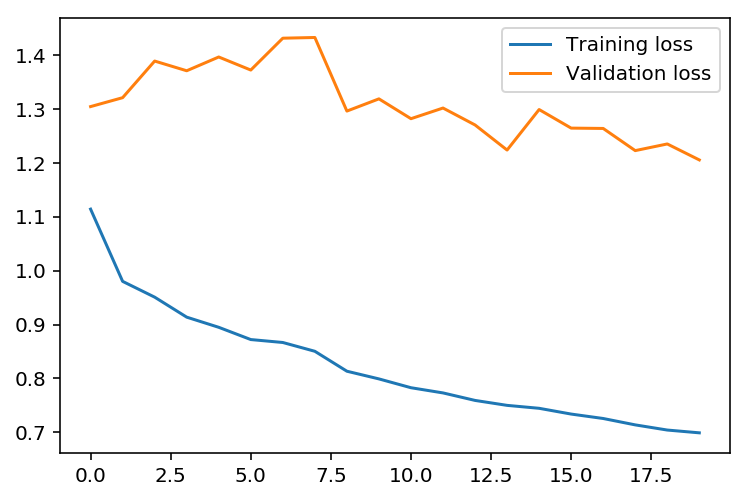

In [69]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


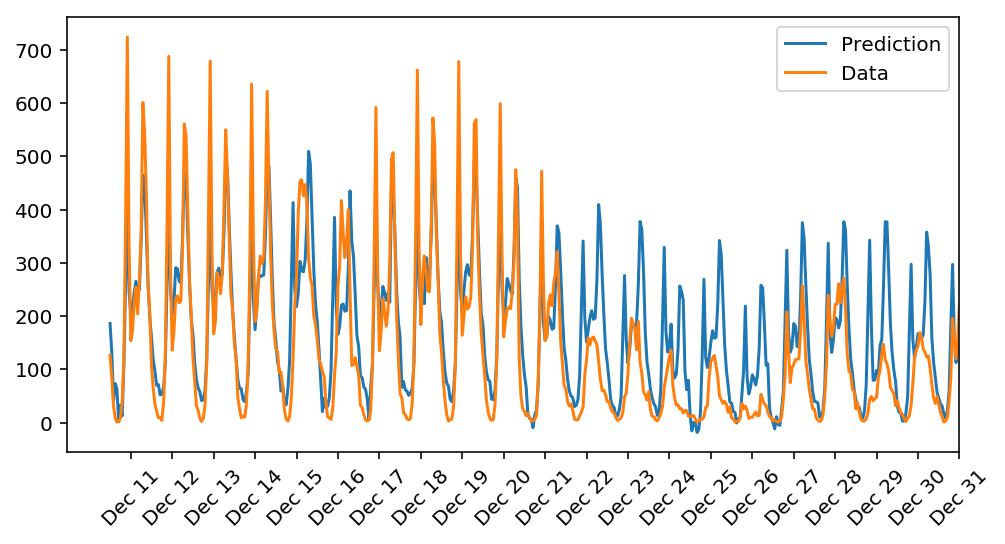

In [32]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below